In [8]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import tensorflow as tf
import cupy as cp
import matplotlib.pyplot as plt

In [59]:
class Listener:
    def __init__(self):
        self.__time_step = 9
        self.__tmp = cp.zeros([1,3])
        self.__arr_classification = cp.zeros([1,90])
        self.__vis_point = cp.zeros((1,3))
        self.__vis_balls = cp.zeros((self.__time_step,3))
        self.__vis_balls2 = cp.zeros((1,4))
        self.__predction_balls = cp.zeros((1,self.__time_step,3))
        self.__arr_prediction = cp.zeros([1,self.__time_step*3])
        self.__arr_pred_possible = cp.zeros((1,4))
        self.__diff = cp.zeros([1,3])
        self.__padding_done = False
        self.__cnt = 1
        self.__num = 1
        self.__max_index = 0
        self.__coor = -10*cp.ones(6)
        self.__find_possible_point = False
        self.__cal_possible_point = False
        self.__vis_possible_point = False
        self.__vis_hitting_point = cp.zeros((1,4))
        self.__hitting_point = -45
        self.__hitting_timimg = 0
        self.__possible_point = cp.zeros((1,4))
        self.__pred = cp.zeros([1,self.__time_step,3])
        self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
        self.__time = 0.016667
        self.__delta_T = 0.016667
        self.__anchor = 0
        self.__rowww = 0
        self.__direction = 'top6'
        self.traj_done = False
        #self.fig, self.ax = plt.subplots(2,2, figsize=(10.24,7.2))
	#self.__name = sys.argv[1]
        self.__csv_path = '/home/lab606a/catkin_ws/src/pointcloud/offline/'
        #self.__model_path = '/home/lab606a/Documents/20200415/not_fixed/saved model/500_data/prediction_not_fixed_'+ self.__direction
        #self.__model_path = '/home/lab606a/catkin_ws/src/pointcloud/models/not_fixed/prediction_all_not_fixed'
        #self.__model_path = '/home/lab606a/Documents/model comparison/not fixed model/saved model/500_data/prediction_not_fixed_all_kind_data'
        self.__model_path = '/home/lab606a/Documents/model comparison/not fixed model/saved model/500_data/prediction_not_fixed_top6'
        self.__prediction_model = load_model(self.__model_path)
        
    def append_pred(self): ## Exhaustive
        self.__pred = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1))
        while not self.__find_possible_point == True:
            self.__pred = cp.array(self.__pred)
            if ( -50 < float(cp.min(self.__pred[self.__pred.shape[0]-1,:,:])) < -40): ## find possible hitting point
                index = cp.argmin(self.__pred[self.__pred.shape[0]-1,:,:])
                row = int((index-1)/3)
                count_down = row + (self.__pred.shape[0]-1)*9
                self.__find_possible_point = True
                self.__anchor = self.__pred.shape[0]-1
                print("count down = ", int(count_down))
                #index = cp.argmin(self.__anchor[self.__anchor,:,:])
                #row = int((index-1)/3)
                self.__pred[self.__anchor, row+1:, :] = 0
                self.__pred_for_offline = self.__pred

            else: ## predict next time step
                self.__pred = cp.vstack((self.__pred, cp.zeros([1,self.__time_step,3])))
                self.__pred[self.__pred.shape[0]-1,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[self.__pred.shape[0]-2,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
                if (self.__pred.shape[0] >= 8):
                    self.__pred = cp.zeros([1,self.__time_step,3])
                    self.__find_possible_point = True
                
    def update_prediction(self):
        self.__pred[0,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
        for i in range(1, self.__pred.shape[0]):
            self.__pred[i,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[i-1,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)

    def modify(self):
        #index = cp.argmin(self.__pred[self.__anchor,:,:])
        #row = int((index-1)/3)
        if (self.__rowww < 8):
            self.__pred[self.__anchor, self.__rowww+1:, :] = 0
        if (self.__anchor != self.__pred.shape[0]-1):
            self.__pred[self.__anchor+1:, :, :] = 0
        if (self.__anchor == 0) and (self.__rowww == 0) and ( -10 < float(cp.min(self.__pred[self.__anchor,0,:])) < 10):
            self.__pred[self.__anchor,0,:] = 0
        self.__pred_for_offline = cp.vstack((self.__pred_for_offline, self.__pred))
        #self.pub_prediction()

    def calculate_hitting_point(self, arr):
        #print("cnt = ", self.__cnt)
        arr = cp.array(arr)
        self.__cal_possible_point = False
        while not self.__cal_possible_point == True:
            print(arr[self.__anchor,:,:])
            if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= -35) and (self.__anchor >= 0):
                #print("anchor = ", self.__anchor)
                index = cp.argmin(arr[self.__anchor,:,:])
                row = int((index-1)/3)
                self.__rowww = row
                if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= self.__hitting_point): ## interpolation
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case a1")
                        self.__vis_point = cp.array(self.__vis_point)
                        w1 = (self.__hitting_point-self.__vis_point[:,1]) / (arr[self.__anchor,row,1]-self.__vis_point[:,1])
                        self.__possible_point = w1*arr[self.__anchor,row,:] + (1-w1)*self.__vis_point.reshape(1,1,3)
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))

                        #w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor-1,self.__time_step-1,1])
                        #self.__possible_point = w1*arr[self.__anchor-1,self.__time_step-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        #self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        #self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case a2")
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor,row-1,1])
                        self.__possible_point = w1*arr[self.__anchor,row-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                elif (self.__hitting_point < float(cp.min(arr[self.__anchor,:,:])) <= -40):
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case b1")
                        if (self.__diff[:,1] > 0):
                            w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                            if w1 < 1:
                                self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                                self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                                self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                                print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case b2")
                        self.__diff = arr[self.__anchor,row-1,:]-arr[self.__anchor,row,:]
                        self.__diff = self.__diff.reshape(1,3)
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                        if w1 < 1:
                            self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                            self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                            self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                            print("hitting timing and position = ", self.__possible_point)
                else:
                    self.__possible_point = self.__possible_point

                self.__cal_possible_point = True
                #self.pub_prediction()
                '''
                if (row < 8):
                    arr[self.__anchor, row+1:, :] = 0
                if (self.__anchor != self.__pred.shape[0]-1):
                    arr[self.__anchor+1:, :, :] = 0
                if (self.__anchor == 0) and ( -10 < float(cp.min(arr[self.__anchor,0,:])) < 10):
                    arr[self.__anchor,0,:] = 0
                '''
                #self.__pred_for_offline = cp.vstack((self.__pred_for_offline, arr))
                #self.__cnt += 1
                if (self.__arr_pred_possible.shape[0] == 1) and (int(self.__arr_pred_possible[0,2]) == 0):
                    self.__arr_pred_possible = self.__possible_point.reshape(1,4)
                else:
                    self.__arr_pred_possible = cp.vstack((self.__arr_pred_possible, self.__possible_point.reshape(1,4)))
            else:
                if ((self.__anchor-1) >= 0) and (abs(float(cp.min(arr[self.__anchor,:,:]))-self.__hitting_point) >= 22.5):
                    self.__anchor = self.__anchor -1
                    #print("case c1")
                else:
                    self.__cal_possible_point = True

    def calculate_vis_hitting_point(self):
        if (-50 <= float(cp.min(self.__vis_balls2)) <= self.__hitting_point):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row,2]-self.__vis_balls2[row-1,2])
            self.__vis_hitting_point = (1-w1)*self.__vis_balls2[row,:] + w1*self.__vis_balls2[row-1,:]
        elif (self.__hitting_point < float(cp.min(self.__vis_balls2)) < -40):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row-1,2]-self.__vis_balls2[row,2])
            self.__vis_hitting_point = self.__vis_balls2[row,:] - w1*(self.__vis_balls2[row-1,:]-self.__vis_balls2[row,:])
        #print("vis hitting point = ", self.__vis_hitting_point)


    def show_spin_direction(self, max_index):
        ## make dictionary to replace switch case
        dictionary = {0:self.top5, 1:self.top6, 2:self.left5, 3:self.left6, 4:self.right5, 5:self.right6, 6:self.back5, 7:self.back6}
        funcToCall = dictionary[max_index]
        funcToCall()

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def classification(self):
        ## call classifier
        classes = self.__classifier.predict(cp.asnumpy(self.__arr_classification.reshape(1,30,3)), verbose=1)
        ## figure out which direction is
        self.__max_index = np.argmax(classes)
        #print("number of input balls = ", self.__cnt)
        ## show result
        if (self.__cnt >= 9):
            self.show_spin_direction(self.__max_index)
        #self.__cnt += 1

    def padding(self):
        # if __tmp is empty, init array
        #print("paddinggg")
        if (self.__padding_done == False):
            self.__tmp = self.__vis_point ## pad first point
            self.__padding_done = True
            self.__vis_balls = self.__vis_point.reshape(1,3)
        else:
        # if __tmp is not empty, then filled array
            self.__tmp = cp.hstack((self.__tmp, self.__vis_point))
            self.__vis_balls = cp.vstack((self.__vis_balls, self.__vis_point))
            #if (self.__tmp.shape[1] == 15): ## when colect 5 balls
                #self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## asigne to classification input array
            #print("shape of tmp = \n", self.__tmp.shape)
            if (self.__tmp.shape[1] == 27):
                #self.__vis_balls = self.__tmp.reshape(1,self.__time_step,3)
                self.__arr_prediction[:,:] = self.__tmp ## for predct next 5 steps
            if (self.__tmp.shape[1] > 27): ## when colect over 5 balls
                #self.__vis_balls = cp.vstack((self.__vis_balls, self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):].reshape(1,self.__time_step,3))) ## visual measurement point for calculate error
                self.__arr_prediction[:,:] = self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):] ## rolling visual measurement for predct next 5 steps
                #if (self.__tmp.shape[1] <= 90): ## when colect under 31 balls
                    #self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## still asigne to classification input array

    def save_data(self):
        visurement_balls = cp.asnumpy(self.__vis_balls)
        pred_trajs = cp.asnumpy(self.__pred_for_offline.reshape(self.__pred_for_offline.shape[0]*self.__pred_for_offline.shape[1], self.__pred_for_offline.shape[2]))

        df_vis = pd.DataFrame(data=visurement_balls)
        df_pred = pd.DataFrame(data=pred_trajs)

        vis_name = self.__csv_path + 'visurement' + str(self.__num) + '.csv'
        pred_name = self.__csv_path + 'prediction' + str(self.__num) + '.csv'

        df_vis.to_csv(vis_name, header=0, index=0)
        df_pred.to_csv(pred_name, header=0, index=0)

    def predict_traj(self):
        self.__model = self.__prediction_model

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def plot_res(self):
        self.__arr_pred_possible = cp.round_(self.__arr_pred_possible, 4)
        self.__vis_hitting_point = cp.round_(self.__vis_hitting_point, 4)

        update_times = cp.linspace(1, self.__arr_pred_possible.shape[0], self.__arr_pred_possible.shape[0])
        t = self.__arr_pred_possible[:,0]
        x = self.__arr_pred_possible[:,1]
        z = self.__arr_pred_possible[:,3]
        Euclidean_vis = cp.sqrt(cp.sum(cp.power(self.__vis_hitting_point[1:],2)))
        Euclidean_pred = cp.sqrt(cp.sum(cp.power(self.__arr_pred_possible[:,1:],2), axis=1))

        plt.figure(figsize=(8,7))

        ## plot hitting timing
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[0]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(t), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg (sec)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_timing' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((t-self.__vis_hitting_point[0])*1000)
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg error (ms)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_timing_error' + '.png'
        plt.savefig(name)

        ## plot Euclidean distance
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*Euclidean_vis), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_distance' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((Euclidean_pred-Euclidean_vis))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_distance_error' + '.png'
        plt.savefig(name)

        ## plot x coordinate
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[1]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(x), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_X-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((x-self.__vis_hitting_point[1]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_X-coordinate_error' + '.png'
        plt.savefig(name)

        ## plot z coordinate
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[3]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_Z-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((z-self.__vis_hitting_point[3]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_Z-coordinate_error' + '.png'
        plt.savefig(name)
        
    def return_vis_point(self):
        return self.__vis_hitting_point
    
    def return_pred_res(self):
        return self.__arr_pred_possible
    
    def reset_arr_pred(self):
        self.__arr_pred_possible = cp.zeros((1,4))

    def assigne(self, visss):
        #a = data.data
        self.__vis_point = cp.array(visss).reshape(1,3)
        #print(self.__vis_point)

        if (-50 < self.__vis_point[:,1] < -30):
            tmp = cp.hstack((self.__time, self.__vis_point.reshape(3,)))
            if self.__vis_possible_point == False:
                self.__vis_balls2 = tmp.reshape(1,4)
                self.__vis_possible_point = True
            else:
                self.__vis_balls2 = cp.vstack((self.__vis_balls2, tmp.reshape(1,4)))


        if self.traj_done == False:
            print("\nTime = ", self.__time) ## show current time
            print("visual measurement = ", self.__vis_point) ## show visual measurement coordinate
            self.padding() ## colect 5 balls
            '''
            if ((self.__tmp.shape[1] >= 15) and (self.__tmp.shape[1] <= 90)): ## while colect balls over 5 balls and under 30 balls
                self.classification() ## doing classification and prediction
            if (self.__tmp.shape[1] > 90): ## while colect balls over 30 balls, stop doing classification
                self.show_spin_direction(self.__max_index) ## skip classification doing prediction
            '''
            if (self.__tmp.shape[1] >= 27):
                self.predict_traj()
            #self.for_ttbot()
            self.__time += self.__delta_T
            self.__cnt += 1
            
        else:
            #print("aaaaa")
            if (self.__padding_done == True):
                self.calculate_vis_hitting_point()
                #print("pred hitting point = \n", self.__arr_pred_possible)
                #if (self.__pred_for_offline.shape[0] != 1):
                    #self.plot_error()
                    #self.plot_res()
                    #self.save_data()
                self.__num += 1

            self.__padding_done = False
            self.__arr_classification = cp.zeros([1,90])
            self.__coor = -10*cp.ones(6)
            self.__vis_balls = cp.zeros((self.__time_step,3))
            self.__cnt = 1
            self.__pred = cp.zeros([1,self.__time_step,3])
            self.__vis_balls2 = cp.zeros((1,4))
            #self.__arr_pred_possible = cp.zeros((1,4))
            self.__find_possible_point = False
            self.__vis_possible_point = False
            self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
            self.__time = 0.016667 ## reset time
            self.traj_done = False

In [60]:
# set GPU memory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

np.set_printoptions(suppress=True)

In [61]:
obj = Listener()

In [62]:
name = 'top6'

In [63]:
dataset_path = './datasets/split by random for distributed/prediction/' + name + '_test.csv'
print(dataset_path)
dataset = pd.read_csv(dataset_path, header=None)
dataset = dataset.fillna(0)
dataset = np.array(dataset)

./datasets/split by random for distributed/prediction/top6_test.csv


In [64]:
#obj = Listener()
arr_for_vis = np.array([0,0,0,0])
arr_for_pred_3rd = np.array([0,0,0,0])
arr_for_pred_end = np.array([0,0,0,0])

n = 21

arr_for_err_t1 = np.zeros((1,n))
arr_for_err_x1 = np.zeros((1,n))
arr_for_err_z1 = np.zeros((1,n))


for i in range(0,250):
    trajectory = dataset[i,:] ## read trajectory
    trajectory = trajectory.reshape(1,trajectory.shape[0]) ## reshape for padding easily
    ## padding trajectory
    trajectory = sequence.pad_sequences(trajectory, maxlen=trajectory.shape[1]+27, padding='post', dtype='float32')
    trajectory = trajectory.reshape(trajectory.shape[1],) ## reshape for read as vision system easily
    
    for j in range(0, trajectory.shape[0], 3): ## read ball coordinate as vision system
        obj.assigne(trajectory[j:j+3].reshape(1,3))
    obj.traj_done = True ## reset
    obj.assigne(np.array([0,0,0]))
    vis_arr = obj.return_vis_point() ## get vision array
    pred_arr = obj.return_pred_res() ## get prediction array
    #print("")
    print("vis from obj = \n", vis_arr)
    print("pred from obj = \n", pred_arr)
    #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
    #while pred_arr.shape[0] < n:
        #pred_arr = np.vstack(())
    
    if pred_arr.shape[0] >= n: ## update times > n
        #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
        #arr_for_pred_3rd = np.vstack((arr_for_pred_3rd, pred_arr[2,:]))
        #arr_for_pred_end = np.vstack((arr_for_pred_end, pred_arr[(pred_arr.shape[0]-10),:]))
        err = vis_arr - pred_arr ## calculate error
        #print(err.shape)
        err_t = err[:n,0] ## get 
        err_x = err[:n,1]
        err_z = err[:n,3]
        
        arr_for_err_t1 = np.vstack((arr_for_err_t1, err_t))
        arr_for_err_x1 = np.vstack((arr_for_err_x1, err_x))
        arr_for_err_z1 = np.vstack((arr_for_err_z1, err_z))
    #else:
        #print("\n\n aaaaa")
        #print(pred_arr)
    
    obj.reset_arr_pred()



Time =  0.016667
visual measurement =  [[114.038  265.454   42.2759]]

Time =  0.033334
visual measurement =  [[111.827  251.85    43.1215]]

Time =  0.050001000000000004
visual measurement =  [[109.853  240.1     43.2724]]

Time =  0.066668
visual measurement =  [[108.025  226.867   43.5601]]

Time =  0.083335
visual measurement =  [[105.81   213.493   43.1315]]

Time =  0.10000200000000001
visual measurement =  [[103.937  200.841   42.5304]]

Time =  0.11666900000000001
visual measurement =  [[101.972  188.86    41.5658]]

Time =  0.133336
visual measurement =  [[100.009  175.915   39.9983]]

Time =  0.150003
visual measurement =  [[ 98.2748 165.173   38.2066]]
1/1 [==============================] - 0s 1ms/step
count down =  19

Time =  0.16666999999999998
visual measurement =  [[ 96.4684 154.942   34.9786]]
1/1 [==============================] - 0s 1ms/step
[[ 64.60966492 -44.3038559   29.17212296]
 [ -0.16546631   0.00699234  -0.02784443]
 [  0.00191879  -0.02655029  -0.04258633]


1/1 [==============================] - 0s 929us/step
[[ 3.16549683 -2.105896    1.69991398]
 [ 0.30029297  0.172369    0.30588436]
 [ 0.38899994  0.2103405   0.30685711]
 [ 0.31192017  0.17451477  0.27179527]
 [ 0.23231506  0.15795517  0.22618771]
 [ 0.17961121  0.1543808   0.19186687]
 [ 0.14253998  0.15404701  0.165905  ]
 [ 0.11484909  0.15393448  0.14605713]
 [ 0.09347153  0.1532135   0.13077831]]
[[ 78.65965271  39.30844879  11.79944515]
 [ 77.05562592  29.04605865  15.3469429 ]
 [ 75.41081238  18.51081467  18.65073204]
 [ 73.85191345   8.20388412  21.74776268]
 [ 72.31274414  -1.91174126  24.37757492]
 [ 70.79486847 -11.93939972  26.72781944]
 [ 69.19921875 -21.5083847   28.61506653]
 [ 67.75376892 -31.24407196  30.33063126]
 [ 66.4172287  -41.77768707  31.98283768]]
count down =  8
case b2
hitting timing and position =  [  0.48844156  66.00837089 -45.          32.48826018]

Time =  0.35000699999999985
visual measurement =  [[78.2974 38.4555 12.0123]]
1/1 [=======================

1/1 [==============================] - 0s 849us/step
[[-0.00267792 -0.01405907  0.00643158]
 [ 0.00130844 -0.00914955  0.01046276]
 [ 0.00130463 -0.00199127  0.0026598 ]
 [ 0.00319672 -0.00803757  0.00728893]
 [ 0.00186157 -0.00977325  0.00568867]
 [ 0.00154114 -0.00943565  0.00387764]
 [ 0.00136566 -0.00878906  0.00266361]
 [ 0.00118256 -0.00819397  0.00196171]
 [ 0.00098419 -0.00772095  0.00157452]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00692749 -0.00334358  0.01222134]
 [ 0.00684357 -0.00225449  0.01549816]
 [ 0.00606537  0.00304794  0.00745678]
 [ 0.00801849 -0.00351715  0.01207638]
 [ 0.00670624 -0.00545692  0.01047611]
 [ 0.00640106 -0.00521278  0.00865459]
 [ 0.00624084 -0.00461388  0.00743008]
 [ 0.00605011 -0.00403595  0.00671673]
 [ 0.00587082 -0.00356483  0.00632   ]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 852us/step
[[ 0.01038361

1/1 [==============================] - 0s 840us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.48601488  65.49224115 -45.          32.4098195 ]
pred from obj = 
 [[  0.48495981  66.46844808 -45.        

1/1 [==============================] - 0s 806us/step
[[ 32.51317596  -8.71044922  27.35328293]
 [ 31.7289505  -17.21894836  28.49723434]
 [ 31.28063965 -27.34373474  30.43263626]
 [ 30.53066254 -36.44850922  31.25449753]
 [ 29.44467926 -44.3837204   31.35070419]
 [ -0.74704361   0.65455246  -0.67310047]
 [ -0.42929077   0.35050964  -0.24393177]
 [ -0.37220383   0.49004745  -0.20695591]
 [ -0.21277618   0.10132599   0.03584385]]
count down =  13
case b2
hitting timing and position =  [  0.51797142  29.36033754 -45.          31.35817598]

Time =  0.3000059999999999
visual measurement =  [[38.3783  82.873    3.38219]]
1/1 [==============================] - 0s 1ms/step
[[ 31.80871391 -19.05397034  29.018013  ]
 [ 31.23659325 -27.90838623  29.84374237]
 [ 30.60317993 -37.63974762  30.80500412]
 [ 30.14364624 -47.84479523  31.79358673]
 [ -0.24871063   0.19776535  -0.07127476]
 [ -0.09513092  -0.02212334   0.1473856 ]
 [ -0.14361191   0.01916695   0.07976818]
 [ -0.23711395   0.15423775  -0.

[[ 31.12812233 -27.93767548  26.74915695]
 [ 30.48527527 -37.72510529  27.52573013]
 [ 29.98200607 -47.70070648  28.16551208]
 [ -0.00671387  -0.37500572   0.25584793]
 [ -0.12244415  -0.15956879   0.1114378 ]
 [ -0.12465668   0.06258011   0.10429478]
 [ -0.06513596   0.00240326   0.12185383]
 [ -0.01416016  -0.15446854   0.14636517]
 [ -0.00810623  -0.20664215   0.15583324]]
count down =  2
case a2
hitting timing and position =  [  0.50452228  30.11825675 -45.          27.99230315]

Time =  0.48334299999999975
visual measurement =  [[ 30.9903 -27.9118  26.3432]]
1/1 [==============================] - 0s 1ms/step
[[ 30.80271912 -38.16028595  27.75631332]
 [ 30.42772865 -47.70373535  28.14328003]
 [  0.12733459  -0.17598343   0.05900288]
 [ -0.01374817  -0.0310936    0.04108906]
 [  0.045578    -0.06030655  -0.00598621]
 [  0.04033661   0.05109024   0.04879284]
 [  0.05066681   0.02603531  -0.02602482]
 [  0.07046509  -0.02557182  -0.03710365]
 [  0.05049896   0.01807404  -0.08385944]]



Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

visual measurement =  [[ 79.0918 163.763   29.9994]]
1/1 [==============================] - 0s 877us/step
[[ 74.24205017 -27.05074692  29.85322952]
 [ 73.89703369 -36.71166992  30.13315582]
 [ 74.04766846 -46.27562714  29.8715477 ]
 [ -0.12890625  -0.05059242   0.04370117]
 [ -0.06376266  -0.19364357   0.08951092]
 [ -0.14538956  -0.13275909   0.04841518]
 [ -0.12315369  -0.11993027   0.00453091]
 [ -0.07608414  -0.10568619   0.00453663]
 [ -0.0336113   -0.09391785   0.02281666]]
count down =  20
case a2
hitting timing and position =  [  0.55223402  74.027577   -45.          29.90644062]

Time =  0.23333799999999993
visual measurement =  [[ 78.7151 154.742   26.8152]]
1/1 [==============================] - 0s 897us/step
[[ 73.81346893 -36.36910248  29.52262878]
 [ 73.34236908 -45.51502228  29.12036514]
 [  0.02241516  -0.05807304   0.08864594]
 [  0.06793976  -0.07811928   0.06527615]
 [  0.06073761  -0.03876495   0.09621906]
 [ -0.03530121   0.01175499   0.06712055]
 [ -0.02631378  -0

1/1 [==============================] - 0s 1ms/step
[[ 72.36206055 -35.344944    35.44292068]
 [ 71.43109894 -43.94178772  35.0533905 ]
 [ -0.23524475   0.08671188  -0.0967226 ]
 [ -0.00537491  -0.07793045   0.07997608]
 [ -0.02771759  -0.02947998   0.07092285]
 [ -0.00469208   0.04398727   0.05592442]
 [  0.02650452   0.03008652   0.046731  ]
 [ -0.00533295   0.05737495   0.03374958]
 [ -0.02490234   0.04874039   0.01101971]]
count down =  10
case b2
hitting timing and position =  [  0.58539659  71.31650397 -45.          35.00544202]

Time =  0.4166749999999998
visual measurement =  [[75.8733 49.2201 21.8862]]
1/1 [==============================] - 0s 990us/step
[[ 72.31364441 -43.28339386  35.10755539]
 [ -0.20138931  -0.0173378   -0.07083607]
 [ -0.02615356  -0.05065155   0.03215122]
 [  0.04226685  -0.00118637   0.06250286]
 [  0.04990387   0.05207062   0.05473423]
 [ -0.02827072   0.0110302    0.01961422]
 [ -0.03058243  -0.00628471   0.01233673]
 [ -0.02776718  -0.01347733   0.008


Time =  0.5833449999999997
visual measurement =  [[ 73.0472 -41.2305  35.4204]]
1/1 [==============================] - 0s 791us/step
[[ 0.04047394 -0.09479904  0.06130123]
 [-0.07282257 -0.00032043 -0.00380611]
 [-0.01507568 -0.00111771  0.02660656]
 [-0.01173401 -0.01966095  0.03769779]
 [-0.0125351  -0.01992226  0.03632927]
 [-0.00724792 -0.01295471  0.03551292]
 [-0.00128937 -0.00517273  0.03511047]
 [ 0.0038681   0.0015564   0.03498745]
 [ 0.00796509  0.00685883  0.03501987]]

Time =  0.6000119999999997
visual measurement =  [[ 72.7805 -49.93    35.1732]]
1/1 [==============================] - 0s 1ms/step
[[-0.28537369 -0.07377625  0.08912182]
 [-0.16150665 -0.16796494  0.0261755 ]
 [-0.09281158 -0.06850433  0.04571056]
 [-0.12641144 -0.08075714  0.04974651]
 [-0.14751434 -0.09174728  0.04463959]
 [-0.15539932 -0.09599304  0.03887463]
 [-0.15748596 -0.09734726  0.03425884]
 [-0.15727234 -0.09734726  0.03102016]
 [-0.15625    -0.09673309  0.02895164]]

Time =  0.6166789999999996
vi


Time =  0.016667
visual measurement =  [[115.848  274.613   42.9848]]

Time =  0.033334
visual measurement =  [[113.967  260.253   45.0601]]

Time =  0.050001000000000004
visual measurement =  [[112.229  246.844   46.2979]]

Time =  0.066668
visual measurement =  [[110.578  236.341   46.6575]]

Time =  0.083335
visual measurement =  [[108.768  221.321   47.6318]]

Time =  0.10000200000000001
visual measurement =  [[106.925  210.115   47.4115]]

Time =  0.11666900000000001
visual measurement =  [[105.439  197.663   47.3228]]

Time =  0.133336
visual measurement =  [[103.574 185.085  46.797]]

Time =  0.150003
visual measurement =  [[101.895  173.991   45.7643]]
1/1 [==============================] - 0s 860us/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[100.061  162.691   44.3792]]
1/1 [==============================] - 0s 1ms/step
[[ 74.36565399 -30.09822083  22.32357407]
 [ 73.200737   -40.81309509  23.92303085]
 [ 69.74824524 -48.41306305  23.78469467]
 

1/1 [==============================] - 0s 2ms/step
[[ 71.99601746 -50.30956268  23.19021606]
 [  0.48166656  -0.62666702   0.05963039]
 [  0.08605957   0.12389374  -0.1302824 ]
 [  0.1865387    0.08076668  -0.06172466]
 [  0.12459946  -0.04441452  -0.08834743]
 [  0.0559845    0.03503227  -0.11984539]
 [  0.05967712   0.07136154  -0.11574554]
 [  0.07355499   0.08722305  -0.11012268]
 [  0.07631683   0.10652161  -0.10942078]]
count down =  9
case a1
hitting timing and position =  [  0.49917169  72.57891738 -44.99999619  22.64708486]

Time =  0.35000699999999985
visual measurement =  [[82.0847  45.7791   7.34082]]
1/1 [==============================] - 0s 840us/step
[[ 0.01657104 -0.04943848 -0.01032162]
 [ 0.07627869 -0.03474045  0.01183224]
 [ 0.05708694 -0.02898979  0.015172  ]
 [ 0.04142761 -0.04808044  0.01874828]
 [ 0.03320312 -0.05609512  0.01473522]
 [ 0.03327942 -0.05785751  0.01207733]
 [ 0.03535461 -0.0575943   0.01043224]
 [ 0.03759766 -0.05669594  0.00948429]
 [ 0.03952026 

1/1 [==============================] - 0s 1ms/step
[[0.05170822 0.00742149 0.01316357]
 [0.05724335 0.02779198 0.01933193]
 [0.05147171 0.03212357 0.01202202]
 [0.03989792 0.018013   0.01730251]
 [0.03781891 0.01748276 0.01701164]
 [0.03961182 0.0206089  0.01601601]
 [0.04193878 0.02376938 0.01529217]
 [0.04388046 0.02622986 0.01489925]
 [0.0453186  0.02799416 0.01472187]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 823us/step
[[0.02020264 0.00563049 0.00649357]
 [0.01462555 0.00482941 0.02000046]
 [0.01451874 0.01363373 0.01459312]
 [0.01488495 0.00664902 0.01933002]
 [0.01359558 0.00463295 0.0176096 ]
 [0.01360703 0.00485992 0.01570606]
 [0.0137291  0.00543976 0.01445103]
 [0.01377869 0.00599289 0.01372814]
 [0.01373291 0.00643158 0.01333332]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 832us/step
[[ 0.00476074 -0.00370216  0.00671864]
 [ 0.00759125 -0.0005188   0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 813us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 725us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

count down =  13
case b2
hitting timing and position =  [  0.48718747  93.81318278 -45.          29.53889096]

Time =  0.2666719999999999
visual measurement =  [[93.3588  96.055    8.64459]]
1/1 [==============================] - 0s 1ms/step
[[ 92.75379944  -8.33991241  26.37425232]
 [ 92.83786011 -18.3081665   27.54471588]
 [ 92.87236023 -28.32595444  28.43202209]
 [ 92.89634705 -38.19885254  29.01998138]
 [ 93.09056091 -48.07382965  29.42185211]
 [  0.19351196   0.06475067   0.08629799]
 [  0.02475739   0.10764503  -0.01594639]
 [  0.08175278   0.06712723   0.05748272]
 [ -0.04789734   0.09962082  -0.02002144]]
count down =  13
case a2
hitting timing and position =  [  0.48853101  93.03010707 -45.          29.29675996]

Time =  0.2833389999999999
visual measurement =  [[93.3242  85.5126   4.09447]]
1/1 [==============================] - 0s 1ms/step
[[ 93.23622131 -19.57769775  27.91766357]
 [ 92.88350677 -29.04433441  28.51714325]
 [ 93.29656219 -39.46851349  29.1026535 ]
 [ 90.39596

hitting timing and position =  [  0.48886963  92.13998355 -45.          28.07515243]

Time =  0.45000899999999977
visual measurement =  [[ 92.3316 -21.7151  25.2424]]
1/1 [==============================] - 0s 1ms/step
[[ 92.28587341 -31.77849579  26.40656662]
 [ 92.0114975  -41.97257233  26.65700912]
 [  0.49039841  -0.2547226    0.07206821]
 [  0.34668732  -0.25675201   0.14626598]
 [  0.11479187  -0.16759872   0.0529871 ]
 [ -0.0165863   -0.11919785  -0.01232624]
 [ -0.06874847  -0.23252869  -0.03893185]
 [  0.01539993  -0.11476326  -0.02826023]
 [  0.12659836  -0.1475563    0.0280714 ]]
count down =  1
case b2
hitting timing and position =  [  0.48829275  91.93001359 -45.          26.73138531]

Time =  0.46667599999999976
visual measurement =  [[ 92.2352 -32.0467  26.0705]]
1/1 [==============================] - 0s 989us/step
[[ 91.71630859 -41.45645142  26.40869522]
 [  0.87059021  -0.56808472   0.24621677]
 [  0.19158173  -0.03491211   0.08539486]
 [  0.03759766  -0.10064507  -0.0

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 813us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

count down =  20
case a2
hitting timing and position =  [  0.53434172  66.43214294 -45.          30.70888122]

Time =  0.21667099999999995
visual measurement =  [[ 57.4363 155.024   30.2744]]
1/1 [==============================] - 0s 2ms/step
[[ 65.21492767 -39.25415802  28.71007919]
 [ 64.99867249 -48.25870514  28.05531883]
 [ -0.02682877  -0.05287933   0.0405941 ]
 [ -0.03674698  -0.09259796   0.0670929 ]
 [ -0.1079483   -0.01517105   0.07812405]
 [ -0.14688873  -0.00302696   0.06229687]
 [ -0.084095    -0.0496769    0.0436182 ]
 [ -0.07106018  -0.05118561   0.06527233]
 [ -0.00960159  -0.08797646   0.07115746]]
count down =  19
case a2
hitting timing and position =  [  0.53937571  65.07693427 -45.          28.29227366]

Time =  0.23333799999999993
visual measurement =  [[ 57.9987 147.671   26.222 ]]
1/1 [==============================] - 0s 757us/step
[[-0.05908203 -0.10208702 -0.01001644]
 [-0.07041168 -0.04180908 -0.01092052]
 [-0.04471588 -0.03261566  0.00309277]
 [-0.05027771 -0

count down =  9
case a1
hitting timing and position =  [  0.54950543  66.81815095 -45.          25.47138205]

Time =  0.4000079999999998
visual measurement =  [[63.2751 42.6648 16.0498]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00063705 -0.00663376  0.00335121]
 [ 0.06845093 -0.00407028  0.01990604]
 [ 0.04893494  0.00523376  0.01719379]
 [ 0.03061295 -0.01325607  0.01762867]
 [ 0.02046204 -0.02122116  0.01215553]
 [ 0.01883698 -0.02312469  0.00862598]
 [ 0.01946259 -0.02310181  0.00643063]
 [ 0.02056885 -0.0225029   0.00510311]
 [ 0.02159882 -0.02184296  0.00431728]]
[[ 63.71284866  32.05754852  18.41500282]
 [ 64.2101593   21.75859833  20.59530449]
 [ 64.79171753  11.36726761  22.46992493]
 [ 65.2609787    1.19808769  24.11392212]
 [ 65.8249054   -9.3223877   25.38883972]
 [ 65.96923065 -19.03004456  26.00748444]
 [ 66.35940552 -29.23202133  26.34600067]
 [ 66.78614807 -39.22971344  26.55041122]
 [ 67.34166718 -49.16618347  26.41428375]]
count down =  8
case a2
hitting

1/1 [==============================] - 0s 3ms/step
[[ 0.0185318  -0.00655937  0.00361347]
 [ 0.02045441 -0.01251221  0.01164341]
 [ 0.0187149  -0.00178146  0.00491619]
 [ 0.01885986 -0.00703812  0.00971127]
 [ 0.01691818 -0.00831223  0.00819302]
 [ 0.01638031 -0.00769806  0.00644875]
 [ 0.01609421 -0.0068779   0.00529194]
 [ 0.01585007 -0.0061779   0.00463581]
 [ 0.01563263 -0.00564766  0.00428104]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 876us/step
[[ 0.00486755 -0.00466919  0.00775909]
 [ 0.00807953 -0.00107574  0.01186275]
 [ 0.00774765  0.00557518  0.00394726]
 [ 0.00956726 -0.00062943  0.00854588]
 [ 0.00820541 -0.00242043  0.00693607]
 [ 0.00787354 -0.00209808  0.00511837]
 [ 0.00767517 -0.00146675  0.00390148]
 [ 0.00749207 -0.00086212  0.00319862]
 [ 0.00730896 -0.00039101  0.00280857]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01023483  


Time =  0.016667
visual measurement =  [[109.46   298.711   41.5215]]

Time =  0.033334
visual measurement =  [[107.898  285.369   43.3519]]

Time =  0.050001000000000004
visual measurement =  [[106.445  272.849   44.3282]]

Time =  0.066668
visual measurement =  [[104.974  259.75    45.4513]]

Time =  0.083335
visual measurement =  [[103.454  248.573   45.6169]]

Time =  0.10000200000000001
visual measurement =  [[102.082  235.77    45.9089]]

Time =  0.11666900000000001
visual measurement =  [[100.509  222.717   45.6901]]

Time =  0.133336
visual measurement =  [[ 99.0992 211.335   44.8852]]

Time =  0.150003
visual measurement =  [[ 97.6487 198.722   43.8339]]
1/1 [==============================] - 0s 968us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 96.1331 187.616   42.4827]]
1/1 [==============================] - 0s 2ms/step
[[ 72.98581696  -7.46646118  26.16896057]
 [ 71.70237732 -17.17989349  27.9109993 ]
 [ 70.60961914 -26.97492981  29.26190186

hitting timing and position =  [  0.53444626  66.8487038  -45.          31.28065207]

Time =  0.33333999999999986
visual measurement =  [[82.3475  85.7415   8.90597]]
1/1 [==============================] - 0s 919us/step
[[ 69.75254822 -17.73976898  28.18859482]
 [ 68.38339233 -27.69882965  29.78404617]
 [ 67.08650208 -37.81721497  30.89569092]
 [ 66.02052307 -47.38796234  31.80054474]
 [  0.14720154  -0.06455803   0.12263393]
 [  0.01977539  -0.00838661   0.03110981]
 [  0.11266708  -0.05177879   0.07330418]
 [ -0.08935928  -0.01945114  -0.00594425]
 [ -0.11999512  -0.03975677  -0.02315807]]
count down =  12
case a2
hitting timing and position =  [  0.53750252  66.28649161 -45.          31.57477796]

Time =  0.35000699999999985
visual measurement =  [[80.8792  74.6344   4.70632]]
1/1 [==============================] - 0s 808us/step
[[ 67.96235657 -28.25349426  30.19416809]
 [ 66.39543915 -37.7592926   31.12099838]
 [ 65.32441711 -47.72426605  32.1339798 ]
 [  0.22844315  -0.11764908   

count down =  2
case a2
hitting timing and position =  [  0.53737907  66.39574331 -45.          30.39099166]

Time =  0.5166769999999997
visual measurement =  [[ 68.7114 -27.3931  28.3932]]
1/1 [==============================] - 0s 1ms/step
[[ 67.38039398 -37.43928528  29.71160889]
 [ 66.22281647 -47.26973724  30.4221344 ]
 [  0.05949402  -0.04153824   0.06433487]
 [ -0.02945328  -0.0410347    0.01780415]
 [  0.05627823  -0.11795425   0.05130672]
 [ -0.00047684  -0.05254555   0.04877949]
 [  0.04011536  -0.1085434    0.04824162]
 [  0.02254486  -0.1009655    0.05660915]
 [  0.03744507  -0.11881256   0.04945278]]
count down =  1
case a2
hitting timing and position =  [  0.53719222  66.49008768 -45.          30.25808231]

Time =  0.5333439999999997
visual measurement =  [[ 67.6034 -37.1263  29.2952]]
1/1 [==============================] - 0s 888us/step
[[ 66.6109848  -46.88245392  30.08556366]
 [ -0.05347824  -0.04878235  -0.00300312]
 [  0.01699066  -0.04188347  -0.00951862]
 [  0.05064

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 827us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

count down =  16
case b2
hitting timing and position =  [  0.51866895  44.86604044 -45.          22.81649665]

Time =  0.2500049999999999
visual measurement =  [[ 53.5352  115.862     8.31598]]
1/1 [==============================] - 0s 827us/step
[[ 50.43817139  12.15992165  21.4585762 ]
 [ 50.53900146   1.73951721  22.41212082]
 [ 49.73901367  -8.45802689  22.6892662 ]
 [ 49.21479797 -19.06946564  23.03470993]
 [ 48.41370773 -28.38126373  22.40423584]
 [ 48.080513   -38.50806427  21.83546066]
 [ 47.18919373 -46.77475739  20.30092621]
 [  0.32956696  -0.0286293    0.23999786]
 [  0.10812378   0.07126999   0.05361843]]
count down =  15
case a2
hitting timing and position =  [  0.5035882   47.38054902 -45.          20.63037189]

Time =  0.2666719999999999
visual measurement =  [[ 53.1939 106.576    3.4104]]
1/1 [==============================] - 0s 1ms/step
[[ 49.7269249    1.18115616  22.78184509]
 [ 49.72844696  -8.95066071  23.6003933 ]
 [ 49.07359314 -18.69816589  23.80895233]
 [ 48.

count down =  5
case a2
hitting timing and position =  [  0.50720854  48.65386017 -45.          24.86429958]

Time =  0.4333419999999998
visual measurement =  [[50.6348 -0.5248 24.3894]]
1/1 [==============================] - 0s 915us/step
[[ 50.41870117 -10.80326462  24.90948105]
 [ 50.29788208 -20.82705307  25.44502831]
 [ 49.88378143 -30.19649506  25.36837387]
 [ 49.64474869 -39.43038177  25.00918198]
 [ 49.06879425 -48.35952759  23.90626526]
 [ -0.36486053   0.29607773  -0.04494858]
 [ -0.17768097   0.18428421   0.07735443]
 [ -0.00682068   0.34548569   0.10987854]
 [ -0.00386047   0.10832214   0.20294094]]
count down =  4
case a2
hitting timing and position =  [  0.50628084  49.28549301 -45.          24.32122983]

Time =  0.45000899999999977
visual measurement =  [[ 50.4572 -11.0465  25.1658]]
1/1 [==============================] - 0s 2ms/step
[[ 50.19816589 -21.30741882  25.07726479]
 [ 50.00976944 -30.81462097  25.30882645]
 [ 49.78266144 -39.93712616  24.95121765]
 [ 48.0134277

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

count down =  21
case a2
hitting timing and position =  [  0.5253696   38.61986792 -45.          30.35134873]

Time =  0.18333699999999997
visual measurement =  [[ 49.6297 166.353   39.1821]]
1/1 [==============================] - 0s 1ms/step
[[ 38.99374008 -31.04880905  28.02351379]
 [ 38.5321312  -40.61258698  29.19322205]
 [ 33.46109772 -42.63153839  26.0812149 ]
 [ -0.29257965  -0.22094536  -0.02171516]
 [ -0.03274536  -0.37169266   0.09083748]
 [  0.25186157  -0.49383926   0.27201271]
 [ -0.00774384  -0.07800674   0.02258968]
 [  0.02278137  -0.09368896   0.0043726 ]
 [  0.08857727  -0.2007885    0.07347584]]
count down =  20
case b2

Time =  0.20000399999999996
visual measurement =  [[ 49.0936 154.906   36.5903]]
1/1 [==============================] - 0s 1ms/step
[[ 37.3995285  -42.73465729  30.04291534]
 [ -0.07769012  -0.05270004   0.08491611]
 [ -0.00293732  -0.16781807   0.06257534]
 [ -0.08256531  -0.03633118   0.03067684]
 [ -0.06899261  -0.0654068    0.04075718]
 [ -0.1250

1/1 [==============================] - 0s 1ms/step
[[ 21.02769852 -28.26334381  19.04456902]
 [  1.70770645   0.2074852    1.08469296]
 [  1.50526047  -0.0866642    1.41599751]
 [  0.94536591   0.2226944    1.00457573]
 [  0.60990524   0.11009598   0.86345673]
 [  0.28483963   0.16802216   0.64881992]
 [  0.02887726   0.20215988   0.48799229]
 [ -0.17926407   0.24235344   0.34971523]
 [ -0.34684753   0.28026009   0.23551846]]

Time =  0.3833409999999998
visual measurement =  [[43.4727 38.229  10.5819]]
1/1 [==============================] - 0s 973us/step
[[ 0.05914307  0.00984192  0.01105404]
 [ 0.0460968   0.01078415  0.00808048]
 [ 0.04481506  0.0150528   0.00129604]
 [ 0.03411865  0.000103    0.00700855]
 [ 0.03232574 -0.00082588  0.00700092]
 [ 0.03416824  0.00208664  0.00617123]
 [ 0.03653717  0.00512695  0.00554276]
 [ 0.03853226  0.00754547  0.00520992]
 [ 0.04001617  0.00928879  0.00508213]]
[[ 43.04596329  27.82227707  13.8463335 ]
 [ 42.26189804  16.7816143   17.55302429]
 [ 

1/1 [==============================] - 0s 1ms/step
[[-0.00212097 -0.01187706  0.0091486 ]
 [-0.0001297  -0.00948715  0.01274776]
 [-0.00063324 -0.00295639  0.00482273]
 [ 0.00115967 -0.00917816  0.00944614]
 [-0.00022125 -0.01096535  0.00785255]
 [-0.00055695 -0.01064301  0.00604343]
 [-0.00076294 -0.01000214  0.00482845]
 [-0.00095367 -0.00940323  0.00412846]
 [-0.00114441 -0.00892448  0.00374126]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 842us/step
[[ 0.00862503 -0.00451279  0.01497555]
 [ 0.00601578 -0.00581169  0.01703167]
 [ 0.00493622 -0.00097275  0.0088625 ]
 [ 0.00673676 -0.00772095  0.01344585]
 [ 0.00536346 -0.00972748  0.01183796]
 [ 0.00501251 -0.00950241  0.01001835]
 [ 0.00482941 -0.0089035   0.00879383]
 [ 0.00463867 -0.00833511  0.00808334]
 [ 0.00444794 -0.00786972  0.00769138]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00634384  

 [  0.51692994  39.77113296 -45.          33.37203796]
pred from obj = 
 [[  0.5253696   38.61986792 -45.          30.35134873]
 [  0.5253696   38.61986792 -45.          30.35134873]
 [  0.5253696   38.61986792 -45.          30.35134873]
 [  0.53480835  32.51457666 -45.          30.1495476 ]
 [  0.5209486   37.78196196 -45.          32.72445739]
 [  0.52106745  37.79689427 -45.          32.13543549]
 [  0.54089761  31.5259608  -45.          30.38299659]
 [  0.52524382  36.84980243 -45.          32.63797192]
 [  0.5249702   37.53417141 -45.          32.1833275 ]
 [  0.52558717  38.31353385 -45.          32.00488888]
 [  0.52332121  38.98582082 -45.          30.85119249]
 [  0.52337179  37.86377786 -45.          29.51852822]
 [  0.5017291   39.05022223 -45.          31.97933506]
 [  0.51950866  37.53714873 -45.          31.075778  ]
 [  0.51887043  38.58184942 -45.          31.91443101]
 [  0.5170841   38.90105329 -45.          32.49060219]
 [  0.51674241  39.51112061 -45.          33.50

visual measurement =  [[80.1197  84.9419   4.80042]]
1/1 [==============================] - 0s 2ms/step
[[ 71.52168274 -22.42775726  24.98416138]
 [ 70.71537781 -32.05899048  25.53428268]
 [ 70.18971252 -42.27092743  25.88363647]
 [ 11.18153     -6.8215065    4.04690456]
 [ -0.49855042  -0.34825516  -0.07054806]
 [  0.20508575  -0.49219513   0.15322018]
 [  0.11935425  -0.10408974   0.08735275]
 [  0.68406677  -0.21118164   0.2488184 ]
 [  1.07627106  -0.33822823   0.39390659]]
count down =  11
case b2
hitting timing and position =  [  0.50446415  70.04923196 -45.          25.97699896]

Time =  0.31667299999999987
visual measurement =  [[79.2059   74.8744    0.570728]]
1/1 [==============================] - 0s 905us/step
[[ 70.13434601 -31.29206848  23.16509247]
 [ 69.0298233  -41.77594757  23.50026321]
 [ -0.12112427  -0.20417023  -0.06809902]
 [  0.20666504  -0.14350891   0.07271385]
 [  0.11674118  -0.11200523   0.06434917]
 [  0.17588806  -0.03274155   0.07318878]
 [  0.0941925   -

1/1 [==============================] - 0s 1ms/step
[[ 68.57258606 -40.23822784  29.77098465]
 [ 67.83653259 -50.07202911  30.2947464 ]
 [ -0.00294495   0.02279663   0.05748177]
 [  0.0154953   -0.0653801    0.04521847]
 [  0.04354858  -0.06283188   0.08970451]
 [ -0.02889252  -0.01019859   0.08300877]
 [  0.03968811  -0.07751846   0.07802486]
 [  0.02658844  -0.0725708    0.09182835]
 [  0.07295227  -0.09499168   0.09287453]]
count down =  1
case a2
hitting timing and position =  [  0.50860642  68.21617059 -45.          30.02460317]

Time =  0.5000099999999997
visual measurement =  [[ 69.0725 -40.3778  29.4075]]
1/1 [==============================] - 0s 807us/step
[[ 42.90599442 -32.66205215  19.86368752]
 [  1.4825325   -0.02236366   0.51946449]
 [  1.45796967   0.40863419   0.7915926 ]
 [  0.75234222   0.39040375   0.58282757]
 [  0.4721756    0.33215714   0.46202374]
 [  0.14909363   0.3902359    0.31135178]
 [ -0.06703568   0.42163849   0.21091557]
 [ -0.23320007   0.45427895   0.1

1/1 [==============================] - 0s 899us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

1/1 [==============================] - 0s 2ms/step
[[ 33.12278748 -39.01828766  26.14697647]
 [ 33.15416718 -47.75493622  26.1853466 ]
 [  0.02235413   0.01764297   0.08084202]
 [ -0.00889587   0.08587837   0.08182526]
 [ -0.06895447   0.01922417   0.03635597]
 [ -0.08602905   0.08971596   0.0612402 ]
 [ -0.07234192   0.10374641  -0.04477406]
 [ -0.04252625   0.06475449  -0.06473351]
 [ -0.05463409   0.08958626  -0.10680389]]
count down =  19
case a2
hitting timing and position =  [  0.55526662  33.14427218 -45.          26.17324731]

Time =  0.2500049999999999
visual measurement =  [[ 19.997  143.367   31.0731]]
1/1 [==============================] - 0s 3ms/step
[[ 35.62106323 -47.29010773  29.52547073]
 [  0.03610992   0.1331749   -0.00443363]
 [ -0.02899551  -0.10047531   0.12909222]
 [ -0.06705475  -0.0386734    0.13543606]
 [  0.00718689  -0.05753517   0.14809036]
 [  0.01573944  -0.03816605   0.12404919]
 [  0.05568695  -0.05645943   0.13397121]
 [  0.07868195  -0.05039978   0.13

1/1 [==============================] - 0s 2ms/step
[[ 25.64507103  30.50343513  18.51881981]
 [ 26.31847572  19.40564728  22.47554016]
 [ 26.6395607   10.29636002  24.19125748]
 [ 27.42346954  -0.10340881  26.59534073]
 [ 28.27352333 -10.30265808  28.76896667]
 [ 29.05954361 -20.96885681  30.61940002]
 [ 29.83327675 -30.16627502  31.39752197]
 [ 30.67281151 -38.93733978  31.77800751]
 [ 30.03092575 -44.95432281  30.24475861]]
count down =  8
case b2
hitting timing and position =  [  0.56680453  30.02605295 -45.          30.23311914]

Time =  0.4333419999999998
visual measurement =  [[24.849  30.2864 19.2798]]
1/1 [==============================] - 0s 908us/step
[[ 24.7603569   18.35257339  22.81707001]
 [ 25.33750534   9.19058228  25.12002563]
 [ 25.27652168  -0.09840393  26.34233093]
 [ 26.01821136 -11.29281616  29.25024796]
 [ 25.91822624 -19.76062775  30.08219147]
 [ 26.08368301 -29.57485962  31.21997833]
 [ 27.28197098 -42.3219223   33.67831039]
 [ 19.37520981 -33.95716858  23.3636

1/1 [==============================] - 0s 1ms/step
[[ 0.01146698  0.00350189  0.01377487]
 [ 0.01031494 -0.00009918  0.01741505]
 [ 0.00937271  0.00380325  0.00930119]
 [ 0.01136017 -0.00317192  0.01390934]
 [ 0.01004791 -0.00524712  0.01232815]
 [ 0.00970078 -0.00504303  0.01051617]
 [ 0.00950623 -0.00445175  0.00930214]
 [ 0.00932312 -0.0038681   0.00858879]
 [ 0.00911713 -0.00339317  0.00819492]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.015728    0.00191879  0.01673031]
 [ 0.0123291  -0.00292778  0.01944447]
 [ 0.01121521  0.00062561  0.01121902]
 [ 0.01316071 -0.00644684  0.0157938 ]
 [ 0.01179504 -0.00857735  0.01419544]
 [ 0.01145935 -0.00839233  0.01238155]
 [ 0.01124573 -0.00779915  0.01115704]
 [ 0.01105118 -0.00722122  0.01044464]
 [ 0.01084137 -0.00674248  0.01005459]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 865us/step
[[ 0.02493286  

1/1 [==============================] - 0s 917us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 43.0384 190.134   44.5498]]
1/1 [==============================] - 0s 1ms/step
[[ 40.82692337  -9.68869019  24.96578979]
 [ 40.66143036 -19.82914352  27.14121628]
 [ 40.66517639 -29.72564316  29.01893616]
 [ 40.62700272 -39.87281036  30.74376678]
 [ 40.72162628 -50.00978851  32.20895386]
 [ -0.05794525   0.23965836  -0.04649258]
 [  0.06134033   0.17522812  -0.09546375]
 [  0.04602814   0.23788071  -0.1043272 ]
 [  0.01163483   0.12198257  -0.1109724 ]]
count down =  22
case a2
hitting timing and position =  [  0.54158099  40.67486244 -45.          31.48484483]

Time =  0.18333699999999997
visual measurement =  [[ 42.1395 180.867   40.0955]]
1/1 [==============================] - 0s 1ms/step
[[ 40.25579071 -20.89211273  27.72948456]
 [ 40.03150558 -30.35386658  28.97568893]
 [ 39.9547348  -40.0344696   30.21274185]
 [ 39.87480164 -49.88722229  31.33514404]
 [ -0.0

count down =  11
case b2
hitting timing and position =  [  0.54115994  37.43607423 -45.          32.38104174]

Time =  0.35000699999999985
visual measurement =  [[40.2622  74.7545   4.91332]]
1/1 [==============================] - 0s 2ms/step
[[ 37.0139122  -31.10099792  30.33160019]
 [ 36.13253784 -39.86532593  30.81625366]
 [ 29.2467289  -38.51985931  25.5306778 ]
 [ -1.15780258   0.43639565  -0.56960392]
 [ -0.39289093   0.14687347  -0.18734837]
 [  0.21576691  -0.35428619   0.25884151]
 [ -0.06965256   0.12350082  -0.06985188]
 [ -0.03157806   0.00260162  -0.04037189]
 [  0.07979584  -0.23213768   0.10197735]]

Time =  0.36667399999999983
visual measurement =  [[39.7448  65.5473   2.19007]]
1/1 [==============================] - 0s 1ms/step
[[ 36.06617737 -40.0668335   30.73596191]
 [ 35.93081284 -50.13631439  31.64403152]
 [ -0.03820419   0.00822639  -0.01062393]
 [ -0.05115509   0.00799751   0.03596973]
 [  0.01904297   0.10331726  -0.07694912]
 [  0.01241684   0.11465263   0.033

hitting timing and position =  [  0.54074697  37.09232368 -45.          27.43729037]

Time =  0.5333439999999997
visual measurement =  [[ 36.8229 -38.5597  26.1307]]
1/1 [==============================] - 0s 1ms/step
[[ 36.16679382 -48.25041199  26.64788055]
 [ -0.00040817  -0.36328697   0.09774876]
 [ -0.22234344  -0.03034973  -0.03188038]
 [ -0.14669037  -0.01537704   0.06417847]
 [ -0.05405426  -0.05834198   0.07921314]
 [ -0.05757141  -0.02067375   0.04073715]
 [ -0.03752136  -0.01830673   0.04438972]
 [ -0.02675629   0.00439262   0.03591633]
 [ -0.00410461   0.01419067   0.03836155]]
count down =  0
case a1
hitting timing and position =  [  0.54442064  36.38686142 -45.          26.47441006]

Time =  0.5500109999999997
visual measurement =  [[ 36.3468 -48.511   26.6718]]
1/1 [==============================] - 0s 811us/step
[[-0.03307724  0.06480408 -0.05484962]
 [ 0.02646637 -0.01142883 -0.02534771]
 [-0.01010895  0.00880623 -0.03439999]
 [-0.06932068 -0.02446747 -0.04374599]
 [-0.


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 963us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1


Time =  0.2666719999999999
visual measurement =  [[ 67.1384 121.428   26.9782]]
1/1 [==============================] - 0s 877us/step
[[ 62.49267578  18.13752937  16.03952217]
 [ 61.78908539   8.0219841   18.68839264]
 [ 61.38335037  -2.45025444  21.09231377]
 [ 60.9196167  -12.63085938  23.10279846]
 [ 59.97245407 -22.72117233  24.63305473]
 [ 59.51787567 -33.01470566  26.09915543]
 [ 60.72858429 -45.54197693  28.13835907]
 [ 44.44940186 -38.38452148  20.81630325]
 [ -1.03749084   0.34677887  -0.36763096]]
count down =  15
case a2
hitting timing and position =  [  0.51739808  60.67620448 -45.          28.05013544]

Time =  0.2833389999999999
visual measurement =  [[ 66.9019 110.125   23.728 ]]
1/1 [==============================] - 0s 1ms/step
[[ 62.12386703   6.63712692  19.13707924]
 [ 61.40016937  -3.60838509  21.27811623]
 [ 60.98332596 -14.0511322   23.48496437]
 [ 60.4397316  -24.35891724  25.21791267]
 [ 59.59539413 -34.31612778  26.48774338]
 [ 58.92408371 -44.3020401   27.445

1/1 [==============================] - 0s 930us/step
[[ 62.94332123   0.9969101   23.82085419]
 [ 62.41825104  -9.09142685  26.39950943]
 [ 61.98584366 -18.77251434  28.58039093]
 [ 61.60495758 -28.72319031  30.57657242]
 [ 61.3044014  -38.8356781   32.26912689]
 [ 60.499897   -48.21800232  33.41160583]
 [ -0.03106689  -0.03556442   0.09165287]
 [  0.06300354  -0.16625977   0.11707973]
 [  0.13494873  -0.06269455   0.11791515]]
count down =  5
case a2
hitting timing and position =  [  0.53906054  60.77583044 -45.          33.01975198]

Time =  0.46667599999999976
visual measurement =  [[62.8196   1.48898 23.6857 ]]
1/1 [==============================] - 0s 1ms/step
[[ 62.49140167  -8.91592407  26.5394001 ]
 [ 61.8632164  -18.51262283  28.57108307]
 [ 61.40992355 -28.28469086  30.46215439]
 [ 61.25293732 -38.34579468  32.16685867]
 [ 61.063591   -47.99906921  33.59672928]
 [  0.07577515  -0.02972984   0.02545166]
 [  0.06761932  -0.12540817  -0.00543308]
 [  0.03755569  -0.07000351  -0.

1/1 [==============================] - 0s 767us/step
[[ 0.01435471  0.00609589  0.01541424]
 [ 0.01233673 -0.00066757  0.01792717]
 [ 0.01119995  0.00239182  0.00961876]
 [ 0.01319885 -0.00481033  0.01417446]
 [ 0.01186371 -0.00697708  0.01257992]
 [ 0.01151276 -0.0067997   0.01076889]
 [ 0.01131058 -0.00621796  0.00955105]
 [ 0.01110458 -0.00563431  0.00884247]
 [ 0.0109024  -0.00516129  0.00845432]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 818us/step
[[ 0.00648117 -0.00497437  0.00969219]
 [ 0.00424957 -0.01013565  0.01394176]
 [ 0.00375366 -0.0061264   0.00599957]
 [ 0.00572586 -0.01315308  0.01064205]
 [ 0.00438309 -0.01525116  0.00906086]
 [ 0.00405121 -0.01503754  0.00724697]
 [ 0.00384521 -0.01442146  0.00601387]
 [ 0.00366211 -0.01382256  0.00529957]
 [ 0.00346375 -0.01334763  0.00489998]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 778us/step
[[-0.004753


Time =  0.20000399999999996
visual measurement =  [[ 96.0844 188.86    38.0874]]
1/1 [==============================] - 0s 1ms/step
[[ 93.87678528  -9.40474319  29.22101974]
 [ 93.78859711 -19.14609528  30.15226364]
 [ 93.68130493 -28.82673645  30.63061905]
 [ 93.74128723 -38.4969101   30.95126724]
 [ 93.80204773 -48.35811615  30.84621429]
 [  0.16446686  -0.09679031   0.13295746]
 [ -0.01282501  -0.01807785  -0.02375507]
 [  0.03846359   0.0167942    0.00373459]
 [ -0.041996     0.00502777  -0.07724571]]
count down =  22
case a2
hitting timing and position =  [  0.57235375  93.78135647 -45.          30.88198882]

Time =  0.21667099999999995
visual measurement =  [[ 95.8789 178.357   35.2381]]
1/1 [==============================] - 0s 2ms/step
[[ 93.14341736 -19.42449951  28.66972733]
 [ 92.93283081 -28.8056221   28.96390915]
 [ 93.13986206 -38.68608856  29.19490814]
 [ 93.6676712  -48.7399292   29.0800705 ]
 [  0.37194824  -0.12669373   0.12614536]
 [  0.13330841  -0.1830864    0.085

hitting timing and position =  [  0.56959095  93.36421625 -45.          30.55822751]

Time =  0.3833409999999998
visual measurement =  [[93.7572  76.1406   9.10825]]
1/1 [==============================] - 0s 898us/step
[[ 92.40062714 -26.57214355  30.86817169]
 [ 91.96173859 -36.24256134  31.18087006]
 [ 92.17713928 -46.26360321  31.16475677]
 [ -0.06919861  -0.04924393   0.03365803]
 [ -0.00485229  -0.20058632   0.05681705]
 [ -0.04520798  -0.12600327   0.05095005]
 [ -0.10669708  -0.08770752   0.0045929 ]
 [ -0.02301025  -0.07866669   0.02550983]
 [ -0.02191162  -0.02209854   0.02359104]]
count down =  11
case a2
hitting timing and position =  [  0.56877963  92.14997833 -45.          31.16678858]

Time =  0.4000079999999998
visual measurement =  [[93.5789 65.4828 12.8418]]
1/1 [==============================] - 0s 1ms/step
[[ 91.73953247 -35.96102905  31.7416954 ]
 [ 91.53894043 -45.77396393  31.54649734]
 [  0.05553436  -0.1814518    0.06121922]
 [ -0.12537384  -0.01426315   0.04507

hitting timing and position =  [  0.58417194  91.17973904 -45.          31.54690993]

Time =  0.5666779999999997
visual measurement =  [[ 91.6557 -34.5138  31.3976]]
1/1 [==============================] - 0s 905us/step
[[ 91.22587585 -43.81235504  31.46954727]
 [ -0.15446091   0.01252937  -0.05157375]
 [  0.02187347  -0.05408859   0.04288578]
 [  0.05471802  -0.02053833   0.07838154]
 [  0.06954193   0.06718063   0.06527615]
 [  0.04520798  -0.00620651   0.06054115]
 [  0.00503922  -0.00512123   0.04673767]
 [  0.00949097  -0.01015282   0.05195332]
 [  0.03026962  -0.02791214   0.06252003]]
count down =  0
case b1
hitting timing and position =  [  0.58536861  91.18261325 -45.          31.44773302]

Time =  0.5833449999999997
visual measurement =  [[ 91.4551 -43.9831  31.4385]]
1/1 [==============================] - 0s 1ms/step
[[ 0.07744217 -0.01236343 -0.01019192]
 [-0.01335144  0.01177025 -0.00397968]
 [ 0.02790833  0.01243591  0.03478527]
 [ 0.03212357 -0.00863647  0.04957581]
 [ 0.


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 974us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58513485  91.4335588  -45.          31.44289159]
pred from obj = 
 [[  0.56791699  96.95265781 -45.          32.21580002]
 [  0.57188448  94.56140596 -45.          31.40051969]
 [  0.57235375  93.78135647 -45.          30.88198882]
 [  0.57287796  93.47133143 -45.          29.12278896]
 [  0.57255759  92.97838655 -45.          29.19925316]
 [  0.57336317  92.33183472 -45.          30.95272044]
 [  0.58322623  92.33704507 -45.          31.40439461]
 [  0.5666842   92.67268979 -45.          30.67402041]
 [ 

visual measurement =  [[114.438   85.0144  12.3387]]
1/1 [==============================] - 0s 1ms/step
[[101.46676636 -16.18176651  23.82961464]
 [ 99.96212769 -25.78942871  24.960495  ]
 [ 98.914505   -35.6787796   26.01494217]
 [ 98.19005585 -45.55162048  26.92774963]
 [  0.12075806  -0.00233269   0.00061321]
 [  0.12161255  -0.00166702  -0.03703594]
 [ -0.00882339   0.06903458  -0.07442284]
 [  0.06799316  -0.05383682  -0.04820347]
 [  0.09307098  -0.04170799  -0.02149963]]
count down =  12
case a2
hitting timing and position =  [  0.50094123  98.23053265 -45.          26.87674878]

Time =  0.31667299999999987
visual measurement =  [[113.11     75.3958    7.78236]]
1/1 [==============================] - 0s 1ms/step
[[ 99.83097839 -27.70377731  24.1775322 ]
 [ 98.41280365 -37.62927246  25.13659668]
 [ 97.49783325 -47.17012787  25.94075394]
 [  0.3909111   -0.12571716   0.18901157]
 [  0.13394928  -0.12187576   0.04856777]
 [  0.05531311  -0.05192947  -0.02838898]
 [  0.02970505  -0.

hitting timing and position =  [  0.51784463  97.33676842 -45.          26.08805844]

Time =  0.48334299999999975
visual measurement =  [[100.031  -24.4661  25.266 ]]
1/1 [==============================] - 0s 1ms/step
[[ 98.78874969 -34.72735596  26.26621628]
 [ 97.27012634 -44.01689911  26.74047852]
 [ -0.59786987   0.2246151   -0.10985756]
 [ -0.15079498   0.10927391  -0.05480099]
 [ -0.02547836   0.15881729  -0.08536053]
 [  0.15919876   0.04163933  -0.01650906]
 [  0.11910629   0.01104355  -0.02559662]
 [  0.07788086   0.06500244  -0.01477242]
 [  0.09892273   0.02993011   0.0120821 ]]
count down =  1
case b2
hitting timing and position =  [  0.51844085  97.10941231 -45.          26.7906691 ]

Time =  0.5000099999999997
visual measurement =  [[ 98.8219 -34.1598  26.1891]]
1/1 [==============================] - 0s 1ms/step
[[ 97.52005768 -44.32691193  26.44586372]
 [ -0.02203369  -0.00292397  -0.05437088]
 [  0.10765839  -0.00669861  -0.01259899]
 [  0.16001129  -0.06802368  -0.0403

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

1/1 [==============================] - 0s 1ms/step
[[ 68.6005249   -6.02907562  20.182621  ]
 [ 67.05056763 -16.89526367  21.81283951]
 [ 65.12715912 -27.14873505  22.72330856]
 [ 63.51660919 -37.81267548  23.50543022]
 [ 61.64432526 -48.85974121  24.18624496]
 [  0.56548691  -0.28730583   0.11655331]
 [  0.05078125   0.04615021  -0.08455276]
 [ -0.04799271   0.16723633   0.1553688 ]
 [  0.13312912  -0.08740616   0.24660587]]
count down =  13
case a2
hitting timing and position =  [  0.45583229  62.29848371 -45.          23.94837468]

Time =  0.2500049999999999
visual measurement =  [[85.9103  93.9149   7.80593]]
1/1 [==============================] - 0s 1ms/step
[[ 67.3387146  -14.93266296  22.50602722]
 [ 65.91139984 -25.41203308  23.60644913]
 [ 63.73656082 -35.33052063  24.11900711]
 [ 62.41281128 -45.56188965  24.43869019]
 [  0.19487762  -0.03091812   0.13753223]
 [ -0.01087952  -0.03492546   0.06951141]
 [  0.21646118  -0.06548309   0.16236782]
 [ -0.06931305  -0.06891632   0.05

1/1 [==============================] - 0s 2ms/step
[[ 64.42111969 -27.25019073  26.36940384]
 [ 62.22161865 -37.22872162  26.99301147]
 [ 60.38491821 -47.66907501  27.56918716]
 [  0.08972931  -0.19210434   0.15194225]
 [ -0.10066986   0.1128006   -0.00729656]
 [ -0.02546692  -0.02060509   0.08195305]
 [ -0.09516907  -0.00137138   0.02661419]
 [ -0.14949036  -0.05817413   0.02587605]
 [ -0.22581482  -0.05200195   0.02108479]]
count down =  2
case a2
hitting timing and position =  [  0.45426992  60.85447045 -45.          27.42188792]

Time =  0.4333419999999998
visual measurement =  [[ 64.4856 -27.1129  26.4157]]
1/1 [==============================] - 0s 1ms/step
[[ 62.52928162 -36.89772034  27.53907013]
 [ 60.78159332 -47.59703827  27.96398926]
 [ -0.2858429    0.21080017  -0.05614471]
 [ -0.22114563   0.16675949  -0.09501362]
 [  0.01079559  -0.01288986   0.04010773]
 [  0.00403595  -0.01146698   0.07319546]
 [  0.07669449  -0.07666779   0.06101227]
 [  0.04523849  -0.05766869   0.062


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 756us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1

count down =  19
case b2
hitting timing and position =  [  0.50142337 104.23822127 -45.          28.31868838]

Time =  0.18333699999999997
visual measurement =  [[122.438  153.625   36.2553]]
1/1 [==============================] - 0s 2ms/step
[[105.48948669 -45.93123627  28.62449265]
 [ -0.15057373  -0.09317398   0.00448895]
 [  0.1043396    0.03955078   0.07817364]
 [  0.15202332  -0.05853653   0.05953503]
 [  0.0654068   -0.07492447   0.0355711 ]
 [  0.03064728  -0.03450394   0.03555965]
 [ -0.01199341  -0.03721046   0.03421879]
 [  0.01264191  -0.04061127   0.04509544]
 [  0.03023529  -0.04590988   0.05715466]]
count down =  18
case a1
hitting timing and position =  [  0.49993222 105.56857755 -45.          28.66010207]

Time =  0.20000399999999996
visual measurement =  [[121.517  142.446   33.7326]]
1/1 [==============================] - 0s 2ms/step
[[ 0.13315964  0.02272034 -0.02696323]
 [-0.00350189  0.02523041 -0.00280285]
 [ 0.05842209  0.03394318  0.04978085]
 [ 0.06110382  0.0

hitting timing and position =  [  0.50215193 103.09127712 -45.          28.56905455]

Time =  0.36667399999999983
visual measurement =  [[112.063   39.718   10.8286]]
1/1 [==============================] - 0s 2ms/step
[[110.06983948  29.22641945  14.43397141]
 [110.04067993  18.83292007  17.89183235]
 [108.4928894    7.68927383  21.11442566]
 [107.56613922  -2.22926712  23.47605896]
 [106.55357361 -12.22574615  25.84378052]
 [106.01087189 -22.50283432  27.83373642]
 [104.76556396 -32.65268326  29.4161644 ]
 [104.03639984 -42.70835114  30.85044861]
 [  3.64024353  -1.11451721   0.76952076]]
count down =  7
case b2
hitting timing and position =  [  0.50380835 103.87022608 -45.          31.17731658]

Time =  0.3833409999999998
visual measurement =  [[111.303   29.3237  14.9317]]
1/1 [==============================] - 0s 2ms/step
[[109.64925385  18.1770649   18.42271042]
 [109.32067871   7.89495087  21.61416245]
 [108.70865631  -2.20505905  24.8319149 ]
 [107.99723816 -12.81162262  27.4086

1/1 [==============================] - 0s 2ms/step
[[-0.00337982 -0.01717758  0.00640202]
 [ 0.00167465 -0.01234818  0.01152706]
 [ 0.00190735 -0.00550842  0.0036726 ]
 [ 0.00413513 -0.01153183  0.00836563]
 [ 0.00289154 -0.013237    0.0067997 ]
 [ 0.00258636 -0.01288033  0.00500202]
 [ 0.00240326 -0.01221085  0.00379181]
 [ 0.00221252 -0.01159859  0.00309086]
 [ 0.00203705 -0.01111794  0.00270557]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01889801 -0.0071373   0.01629734]
 [ 0.02235794 -0.00421715  0.02031898]
 [ 0.02283859  0.0022316   0.01238155]
 [ 0.0252037  -0.00391388  0.01702785]
 [ 0.02399826 -0.00568008  0.01543713]
 [ 0.02371216 -0.00534821  0.0136261 ]
 [ 0.02352905 -0.00469017  0.01241016]
 [ 0.02333832 -0.00408745  0.01170063]
 [ 0.02314377 -0.00360489  0.01131058]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 902us/step
[[ 0.00605774 -

vis from obj = 
 [  0.50708761 105.08141638 -45.          33.86558733]
pred from obj = 
 [[  0.50142337 104.23822127 -45.          28.31868838]
 [  0.49993222 105.56857755 -45.          28.66010207]
 [  0.48608654 105.23004341 -45.          26.72445144]
 [  0.48554    103.67522262 -45.          27.12765811]
 [  0.48494706 102.73372778 -45.          29.6572221 ]
 [  0.48494708 101.3996549  -45.          30.1750822 ]
 [  0.48374037 102.63823802 -45.          29.63672531]
 [  0.50234737 104.54410376 -45.          29.23642072]
 [  0.50256477 103.80525622 -45.          28.46438697]
 [  0.50249747 103.45801632 -45.          28.23349559]
 [  0.50084193 103.63848812 -45.          28.7483737 ]
 [  0.50215193 103.09127712 -45.          28.56905455]
 [  0.50380835 103.87022608 -45.          31.17731658]
 [  0.50570835 103.87358222 -45.          32.75513111]
 [  0.50576942 104.4110846  -45.          32.7433869 ]
 [  0.50674578 104.60858429 -45.          32.09236869]
 [  0.50674578 104.60858429 -45

hitting timing and position =  [  0.60211939  86.61482185 -45.          33.40580827]

Time =  0.3000059999999999
visual measurement =  [[100.682  141.247   24.5743]]
1/1 [==============================] - 0s 1ms/step
[[ 86.01470184 -45.5295639   31.16320801]
 [ -0.09828186   0.00506592  -0.01950836]
 [ -0.0076828   -0.04278564   0.03177357]
 [  0.08049774  -0.03127289   0.07222652]
 [  0.02054596   0.04270554   0.0534029 ]
 [  0.00087738  -0.01131439   0.05764389]
 [  0.00322723  -0.0135479    0.05526257]
 [  0.01692963  -0.01919556   0.06327724]
 [  0.03733444  -0.03298569   0.07324123]]
count down =  18
case a1
hitting timing and position =  [  0.61663174  86.05628774 -45.          31.14452661]

Time =  0.31667299999999987
visual measurement =  [[ 99.9129 130.856   20.5019]]
1/1 [==============================] - 0s 901us/step
[[ 0.06771088 -0.03570557 -0.02472115]
 [-0.04423904  0.00484848 -0.02616978]
 [ 0.00534058  0.0061264   0.01159859]
 [ 0.00978088 -0.01375389  0.02565002]
 [ 


Time =  0.46667599999999976
visual measurement =  [[92.7492 43.1626 17.3109]]
1/1 [==============================] - 0s 716us/step
[[ 0.06167984 -0.02636719 -0.03313541]
 [-0.02359772  0.01836967 -0.0218277 ]
 [ 0.0187149   0.02022362  0.01221848]
 [ 0.02104187  0.00021744  0.02531528]
 [ 0.02187347 -0.00350571  0.02499866]
 [ 0.0290451   0.00046921  0.02454662]
 [ 0.03672791  0.00608444  0.02428246]
 [ 0.04332352  0.01143456  0.02423859]
 [ 0.04857635  0.01595497  0.02435493]]
[[ 92.29177094  32.97127533  20.08392525]
 [ 91.24891663  23.14352036  22.1647625 ]
 [ 90.26364136  13.33323765  24.10540009]
 [ 89.45947266   3.68021774  25.60345078]
 [ 88.64551544  -6.03209686  26.79838181]
 [ 87.86882019 -15.49648285  27.62689972]
 [ 87.0456543  -24.81917572  28.17725754]
 [ 86.25673676 -34.05523682  28.36414337]
 [ 85.4892807  -43.23764038  28.25112915]]
count down =  8
case b2
hitting timing and position =  [  0.61987786  85.34198446 -45.          28.22943857]

Time =  0.48334299999999975

[[ 0.0375061  -0.00282288 -0.00124645]
 [ 0.03491211  0.00192833  0.00850773]
 [ 0.02686691  0.00907135  0.00184727]
 [ 0.01421356 -0.0044632   0.0071249 ]
 [ 0.01234055 -0.00478745  0.00697708]
 [ 0.014534   -0.00165176  0.00615025]
 [ 0.01715851  0.00144958  0.00555706]
 [ 0.01927185  0.00382805  0.00524902]
 [ 0.02075577  0.00550652  0.005126  ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00744247 -0.01511383  0.00588894]
 [ 0.00276184 -0.01290131  0.01931477]
 [ 0.00369263 -0.00392914  0.01400852]
 [ 0.0042572  -0.01118088  0.01868916]
 [ 0.00312805 -0.0133934   0.01691341]
 [ 0.00325012 -0.01328278  0.01496506]
 [ 0.00347137 -0.01278305  0.01368046]
 [ 0.00354004 -0.01228714  0.01294041]
 [ 0.00354767 -0.01188278  0.01253414]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00527191 -0.00801849  0.00536823]
 [ 0.01062775 -0.00174713  0.

visual measurement =  [[ 98.1552 289.701   44.288 ]]

Time =  0.050001000000000004
visual measurement =  [[ 96.4357 276.773   45.5293]]

Time =  0.066668
visual measurement =  [[ 94.8154 264.559   46.2172]]

Time =  0.083335
visual measurement =  [[ 93.2264 251.822   46.5828]]

Time =  0.10000200000000001
visual measurement =  [[ 91.9114 238.721   46.4133]]

Time =  0.11666900000000001
visual measurement =  [[ 90.0434 227.313   45.8706]]

Time =  0.133336
visual measurement =  [[ 88.2321 215.467   44.8801]]

Time =  0.150003
visual measurement =  [[ 86.9416 204.219   43.7287]]
1/1 [==============================] - 0s 1ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 85.0956 193.453   41.8234]]
1/1 [==============================] - 0s 813us/step
[[ 57.8538208   -4.00140762  28.24931335]
 [ 58.1590271  -13.63824463  30.47434235]
 [ 55.60617828 -22.27171326  31.43851852]
 [ 54.62802887 -32.91753769  33.11948776]
 [ 54.63574982 -43.95928192  34.32741928]
 [ 

count down =  13
case a2
hitting timing and position =  [  0.53591819  53.5234533  -45.          32.35924294]

Time =  0.33333999999999986
visual measurement =  [[70.6389  86.4231   7.87958]]
1/1 [==============================] - 0s 1ms/step
[[ 57.19593048 -16.74343109  29.099823  ]
 [ 56.21438217 -27.00304413  30.57151031]
 [ 54.8132019  -37.17214203  31.49208069]
 [ 53.4312973  -46.18448639  31.71225739]
 [  0.21849823  -0.06575394   0.10782528]
 [  0.41197205  -0.23952103   0.11316776]
 [  0.30144882  -0.2039566    0.03048801]
 [  0.14853668  -0.05635071  -0.05695057]
 [  0.09859467   0.00314713  -0.04576778]]
count down =  12
case a2
hitting timing and position =  [  0.53553453  53.6129201  -45.          31.68331971]

Time =  0.35000699999999985
visual measurement =  [[69.3623  76.3507   2.86982]]
1/1 [==============================] - 0s 950us/step
[[ 56.11338043 -27.57137299  30.35132217]
 [ 54.91500092 -37.56233978  31.6237793 ]
 [ 53.73815155 -47.21637726  32.66093826]
 [ -0.3

count down =  2
case a2
hitting timing and position =  [  0.535518    51.91276351 -45.          33.78317885]

Time =  0.5166769999999997
visual measurement =  [[ 55.3985 -26.0832  31.5589]]
1/1 [==============================] - 0s 2ms/step
[[ 53.784729   -36.64651489  32.96107483]
 [ 51.58992004 -45.36224365  33.32780838]
 [ -0.55361557   0.58246231  -0.33074093]
 [ -0.05435181  -0.12803841   0.02445698]
 [ -0.26967621  -0.19610596  -0.07658672]
 [ -0.2256279   -0.04369736  -0.10253716]
 [ -0.16363144   0.04018402  -0.10486317]
 [ -0.02383423   0.03567505  -0.03622627]
 [  0.08073425   0.00124359   0.01648998]]
count down =  1
case a2
hitting timing and position =  [  0.53403671  51.68114083 -45.          33.31256618]

Time =  0.5333439999999997
visual measurement =  [[ 53.98   -35.7706  32.8385]]
1/1 [==============================] - 0s 1ms/step
[[ 51.77123642 -45.49295807  35.13644028]
 [ -0.16146851   0.10461807  -0.17042828]
 [  0.17655563  -0.22517967   0.12570286]
 [ -0.0344619


Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.50036718  82.13199308 -45.          29.49368884]

Time =  0.2500049999999999
visual measurement =  [[110.89   116.229   23.8888]]
1/1 [==============================] - 0s 2ms/step
[[ 92.01797485  12.95084     17.69782448]
 [ 90.05672455   3.13244247  20.81810951]
 [ 88.24013519  -6.95843506  23.13311005]
 [ 86.5128479  -17.30543518  25.194767  ]
 [ 84.15519714 -26.77897263  26.59619522]
 [ 82.32481384 -36.38356018  27.88418579]
 [ 79.89455414 -45.30068207  28.49933624]
 [ -0.17085266   0.11653519   0.08719826]
 [  0.08168411   0.047966     0.16510868]]
count down =  15
case a2
hitting timing and position =  [  0.50057201  79.9765016  -45.          28.4785936 ]

Time =  0.2666719999999999
visual measurement =  [[109.138  106.064   20.1348]]
1/1 [==============================] - 0s 987us/step
[[ 90.31475067   3.9790287   21.35955429]
 [ 88.45843506  -5.799263    23.81643677]
 [ 86.8104248  -15.56316376  25.76726532]
 [ 84.9495697  -25.62529373  27.42

hitting timing and position =  [  0.51865854  81.61848345 -45.          29.63400967]

Time =  0.4333419999999998
visual measurement =  [[91.2325   4.79401 19.9047 ]]
1/1 [==============================] - 0s 797us/step
[[ 89.42739868  -5.4489975   22.75891495]
 [ 87.26263428 -15.15972137  24.66347122]
 [ 85.76251221 -25.08030319  26.40351105]
 [ 84.08755493 -34.86887741  27.78632736]
 [ 82.47383118 -44.17004395  28.98805237]
 [ -0.26493073   0.03366852  -0.00192165]
 [ -0.11810303   0.03868484   0.04076767]
 [ -0.11315918   0.02423096   0.08034611]
 [  0.12960052  -0.07800865   0.12569237]]
count down =  4
case b2
hitting timing and position =  [  0.51816422  82.32983636 -45.          29.09528397]

Time =  0.45000899999999977
visual measurement =  [[89.3574  -5.34555 22.4449 ]]
1/1 [==============================] - 0s 882us/step
[[ 87.51270294 -15.49489594  24.68306732]
 [ 85.574646   -25.26296997  26.29514694]
 [ 84.01164246 -35.15975952  27.75390625]
 [ 82.20272064 -44.444664    28.


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00626373 -0.00856018  0.00073338]
 [-0.00298691 -0.00816917  0.00705814]
 [-0.00284576 -0.0026207  -0.0006485 ]
 [-0.0007019  -0.00921631  0.0040617 ]
 [-0.00196075 -0.01115608  0.00249958]
 [-0.00226212 -0.01089096  0.00068474]
 [-0.00243378 -0.01026535 -0.00053406]
 [-0.00262451 -0.00966263 -0.00124836]
 [-0.00280762 -0.00918579 -0.00164318]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.50124736  65.87585594 -45.          27.4815164 ]

Time =  0.18333699999999997
visual measurement =  [[ 58.0667 169.196   38.8542]]
1/1 [==============================] - 0s 699us/step
[[ 63.06391907 -35.37579346  27.88760376]
 [ 63.31394958 -45.26136017  29.02682495]
 [ -0.09106445   0.0811348   -0.04214191]
 [ -0.01352692  -0.0460453    0.01072598]
 [ -0.09476089   0.01480484  -0.04461098]
 [ -0.01853943   0.00875473  -0.00195217]
 [  0.00120163  -0.04366302  -0.00779819]
 [ -0.0014801   -0.04348373   0.00373554]
 [  0.01145172  -0.0723896   -0.00252914]]
count down =  19
case a2
hitting timing and position =  [  0.50045065  63.30733914 -45.          28.99670558]

Time =  0.20000399999999996
visual measurement =  [[ 58.6554 156.675   36.4528]]
1/1 [==============================] - 0s 1ms/step
[[ 63.3653717  -42.64845276  30.19186401]
 [ 19.04310608 -14.27272797   9.73743153]
 [ -1.69223022   0.76241684  -0.46925831]
 [  0.5904541   -1.18956757   0.

count down =  9
case a1
hitting timing and position =  [  0.5162694   63.69511796 -45.00000381  28.22618901]

Time =  0.36667399999999983
visual measurement =  [[61.8394 49.5052  5.2399]]
1/1 [==============================] - 0s 1ms/step
[[-0.0029068   0.05107117  0.00504589]
 [ 0.05198288  0.04049301  0.01575947]
 [ 0.04924011  0.05018616  0.01834393]
 [ 0.03259659  0.03029251  0.02025318]
 [ 0.02252197  0.02238464  0.01543236]
 [ 0.02068329  0.02095795  0.01228046]
 [ 0.02106476  0.02145386  0.01030636]
 [ 0.02194214  0.0223999   0.00910473]
 [ 0.02279663  0.02328873  0.00838757]]
[[ 62.04853058  38.67976379   9.24584579]
 [ 62.16134644  27.56495476  12.88090897]
 [ 62.51802826  16.69723892  16.22894287]
 [ 62.88493347   5.79265594  19.35118103]
 [ 63.12765121  -5.09788895  22.03913116]
 [ 63.41122818 -15.65773392  24.28638268]
 [ 63.49062729 -25.75397491  26.01149368]
 [ 63.72743225 -35.92330551  27.47335052]
 [ 64.04141235 -46.25552368  28.78152847]]
count down =  8
case a2
hittin

1/1 [==============================] - 0s 813us/step
[[ 0.02275848  0.00078583  0.01641941]
 [ 0.01383209 -0.00291824  0.02755451]
 [ 0.0130043   0.00539398  0.02192688]
 [ 0.01324844 -0.00170898  0.02662754]
 [ 0.01188278 -0.00377846  0.0249033 ]
 [ 0.01183701 -0.00357819  0.02300072]
 [ 0.01195526 -0.0030098   0.02174377]
 [ 0.01197815 -0.00246239  0.02102375]
 [ 0.01193237 -0.00202942  0.0206337 ]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00233841 -0.0075531   0.00819016]
 [ 0.00506592 -0.00416946  0.01196384]
 [ 0.00466919  0.002491    0.00405502]
 [ 0.00647354 -0.00370407  0.00865364]
 [ 0.00509644 -0.00549698  0.00703907]
 [ 0.00475311 -0.00518036  0.00521564]
 [ 0.00456238 -0.00454712  0.00400066]
 [ 0.00437927 -0.00394821  0.00329494]
 [ 0.00419998 -0.00347519  0.00290775]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00792694 -


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 852us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.51421396  63.77260601 -45.          31.50577378]
pred from obj = 
 [[  0.50124736  65.87585594 -45.          27.4815164 ]
 [  0.50045065  63.30733914 -45.          28.99670558]
 [  0.52076737  62.91534732 -45.          30.50896908]
 [  0.52022056  63.54928473 -45.          29.34530553]
 [  0.51862379  65.80523764 -45.          29.44705437]
 [  0.50481943  66.71143196 -45.          28.62966626]
 [  0.50152352  64.61373067 -45.          25.82526187]
 [  0.51677955  62.84267823 -45.          26.98738223]
 [ 

1/1 [==============================] - 0s 968us/step
[[ 64.43002319   8.79714203  19.63097763]
 [ 63.60021973  -0.6906662   22.20883179]
 [ 63.12462616 -10.65921021  24.5842247 ]
 [ 62.43931961 -20.27947235  26.66199112]
 [ 61.96006775 -29.83440399  28.48366928]
 [ 61.45764923 -39.43791199  30.08696747]
 [ 59.97594452 -47.78611755  30.80980301]
 [ -0.51367569   0.32883453  -0.20587826]
 [ -0.08445358   0.45379639  -0.09400177]]
count down =  15
case a2
hitting timing and position =  [  0.53890642  60.47044642 -45.          30.56856496]

Time =  0.3000059999999999
visual measurement =  [[68.5237 95.5676 22.1826]]
1/1 [==============================] - 0s 1ms/step
[[ 64.77259827  -2.97825241  22.66115952]
 [ 63.97752762 -12.44268417  24.78375626]
 [ 63.68788147 -22.23239136  26.8897171 ]
 [ 63.34257507 -31.84991455  28.70712662]
 [ 63.31239319 -41.77526093  30.2025032 ]
 [  2.06085205  -1.1576767    0.98766232]
 [ -0.09770966  -0.05125046  -0.01940632]
 [  0.10637665  -0.30302048   0.102

1/1 [==============================] - 0s 1ms/step
[[ 65.2093811  -11.49146652  23.4356575 ]
 [ 64.5112381  -20.89089966  25.21160126]
 [ 64.10507965 -30.58930969  26.88799286]
 [ 63.86589813 -40.18625641  28.21985626]
 [ 63.53703308 -49.51808929  29.22333527]
 [ -0.15107727   0.11041641  -0.00393009]
 [  0.0316925   -0.13271904   0.08112335]
 [ -0.01060486   0.00222588   0.03650951]
 [  0.11404419  -0.07103729   0.03229809]]
count down =  4
case a2
hitting timing and position =  [  0.54141348  63.696256   -45.          28.73749205]

Time =  0.48334299999999975
visual measurement =  [[ 65.2818 -11.2398  23.0985]]
1/1 [==============================] - 0s 2ms/step
[[ 65.05722809 -21.13139343  25.15398598]
 [ 64.77175903 -30.36504364  26.58048058]
 [ 64.51315308 -39.71892548  27.6406517 ]
 [ 64.55108643 -49.08315277  28.5597496 ]
 [  0.14278412  -0.03119278   0.11009121]
 [  0.03412247   0.02990341   0.06844807]
 [  0.08445358   0.02477646   0.09279537]
 [  0.08525848   0.01947021   0.08

1/1 [==============================] - 0s 2ms/step
[[ 0.00788879 -0.00301743  0.00870037]
 [ 0.00610352 -0.00781441  0.01307964]
 [ 0.00592041 -0.00361252  0.00523376]
 [ 0.00798416 -0.01060867  0.00988865]
 [ 0.00671005 -0.01269722  0.00830173]
 [ 0.00639343 -0.01248169  0.00648022]
 [ 0.0062027  -0.01187706  0.00525188]
 [ 0.00602722 -0.01128006  0.00453091]
 [ 0.0058403  -0.01080322  0.00413036]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 930us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -

1/1 [==============================] - 0s 1ms/step
[[ 52.4603157  -35.75698853  25.60391998]
 [ 53.03347015 -45.60054779  25.69200516]
 [ -0.07301331   0.07924271  -0.02640057]
 [ -0.06484985   0.06334686   0.04124069]
 [ -0.04080963   0.05794525   0.04124165]
 [ -0.01423645   0.02357674   0.07460117]
 [  0.02414703  -0.00317383   0.05010033]
 [  0.02574921   0.01230812   0.06612015]
 [  0.04059601  -0.00637054   0.0605793 ]]
count down =  19
case a2
hitting timing and position =  [  0.51769384  52.99850245 -45.          25.68663115]

Time =  0.21667099999999995
visual measurement =  [[ 39.2737 151.151   28.9591]]
1/1 [==============================] - 0s 1ms/step
[[ 51.4123764  -46.65619659  25.58371162]
 [ -0.18024063   0.01988602  -0.01786518]
 [ -0.01348877  -0.0247345    0.00615025]
 [ -0.00336456   0.02198792   0.0197258 ]
 [  0.01298141  -0.04631424   0.04096794]
 [  0.02643204  -0.01153564   0.01443768]
 [  0.03815079  -0.00807953   0.01271057]
 [  0.04032135  -0.00667953   0.0

1/1 [==============================] - 0s 1ms/step
[[-0.00527573  0.02490616 -0.00419903]
 [ 0.08002472  0.01068306  0.01316929]
 [ 0.05458832  0.02027512  0.00349331]
 [ 0.0295105  -0.00054932  0.00038528]
 [ 0.01583862 -0.01051712 -0.00648785]
 [ 0.01163101 -0.01409531 -0.01085758]
 [ 0.01042175 -0.01541901 -0.01358128]
 [ 0.0101738  -0.01586723 -0.01525974]
 [ 0.01024628 -0.0159874  -0.0162878 ]]
[[ 47.92321396  33.88232422  15.79840374]
 [ 49.03410721  23.59030914  18.16576767]
 [ 49.65560913  13.133564    20.26623917]
 [ 50.25084305   3.02024078  21.97517395]
 [ 51.03166199  -7.65995789  23.52558899]
 [ 51.62891006 -17.87054443  24.51689529]
 [ 52.14302826 -27.85826111  25.04065704]
 [ 52.77265549 -38.06092834  25.35329437]
 [ 53.15893173 -47.33150482  25.10885239]]
count down =  8
case a2
hitting timing and position =  [  0.52086867  53.06178514 -45.          25.17032836]

Time =  0.4000079999999998
visual measurement =  [[47.9328 34.3926 15.6074]]
1/1 [==========================


Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 909us/step
[[ 0.0027771  -0.00383759  0.0066309 ]
 [ 0.00613403 -0.0009346   0.0110569 ]
 [ 0.00566101  0.0055542   0.00314617]
 [ 0.00746918 -0.00069237  0.00775814]
 [ 0.00609589 -0.00249863  0.00614834]
 [ 0.00575638 -0.00218582  0.00432777]
 [ 0.00554657 -0.00154877  0.00311184]
 [ 0.00536346 -0.00094986  0.00240612]
 [ 0.00517273 -0.00046921  0.0020113 ]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01457214  0.00114632  0.01404667]
 [ 0.0120163  -0.00086212  0.01701641]
 [ 0.01073456  0.0034256   0.0088892 ]
 [ 0.01256561 -0.00345039  0.013484  ]
 [ 0.01119232 -0.00551605  0.01188278]
 [ 0.0108757  -0.00530815  0.01005459]
 [ 0.01068115 -0.00471115  0.00882626]
 [ 0.01050568 -0.00414085  0.00811386]
 [ 0.01029968 -0.00367546  0.00771999]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 1ms/step
count down =  19

Time =  0.16666999999999998
visual measurement =  [[ 98.0957 163.302   31.1443]]
1/1 [==============================] - 0s 1ms/step
[[ 70.48800659 -41.14459229  27.95145798]
 [ 52.46452713 -37.04985046  21.62231445]
 [ -1.42748642   0.91781235  -0.30471897]
 [  0.58405304  -0.98898506   0.40823269]
 [ -0.33795166  -0.35452271   0.04438686]
 [ -0.21261597  -0.31881905   0.10252476]
 [ -0.34750366  -0.28390312   0.05463028]
 [ -0.27722931  -0.27939987   0.08269882]
 [ -0.13867569  -0.29135704   0.11899185]]
count down =  18
case b1
hitting timing and position =  [  0.48992869  70.79497133 -45.          28.03120701]

Time =  0.18333699999999997
visual measurement =  [[ 96.3735 151.659   28.2681]]
1/1 [==============================] - 0s 2ms/step
[[ 63.89115143 -48.05297089  26.11514282]
 [ -0.14524078  -0.11040115  -0.08529949]
 [ -0.036026     0.07295418  -0.07222748]
 [  0.01244354   0.06941223  -0.02664471]
 [ -0.042

count down =  8
case b2
hitting timing and position =  [  0.49083931  68.02909826 -45.          26.58858649]

Time =  0.35000699999999985
visual measurement =  [[80.7258 43.0308 11.556 ]]
1/1 [==============================] - 0s 2ms/step
[[ 78.9624939   31.92123795  14.51321983]
 [ 77.53898621  21.45626831  17.1339817 ]
 [ 76.23434448  10.40428543  19.47816277]
 [ 74.92282104   0.04541016  21.38415909]
 [ 73.33139038 -10.03813934  22.67106247]
 [ 71.81275177 -19.81125641  23.67650986]
 [ 70.52282715 -30.35736465  24.62307739]
 [ 69.1193161  -39.86569977  24.96187401]
 [ 67.60088348 -49.39994812  25.11962509]]
count down =  8
case a2
hitting timing and position =  [  0.49103463  68.30162302 -45.          25.04682475]

Time =  0.36667399999999983
visual measurement =  [[79.138  32.0162 14.5733]]
1/1 [==============================] - 0s 1ms/step
[[ 77.72599792  20.92053986  17.04383469]
 [ 76.49467468  10.64533043  19.11972046]
 [ 75.27537537  -0.22702408  21.18497467]
 [ 73.86751556 -1

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00660706 -0.00467873  0.00780392]
 [ 0.01025772 -0.00070763  0.01218414]
 [ 0.00997925  0.00603867  0.00428391]
 [ 0.01183701 -0.00012398  0.00887966]
 [ 0.0104599  -0.00190926  0.00726986]
 [ 0.01013565 -0.00157928  0.0054493 ]
 [ 0.00994873 -0.0009346   0.00423336]
 [ 0.00975418 -0.00033569  0.00353146]
 [ 0.00956726  0.00013351  0.00314331]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00878143 -0.00081444  0.01192188]
 [ 0.00793839 -0.00097847  0.01534748]
 [ 0.00693893  0.00389481  0.00729847]
 [ 0.00884247 -0.00278473  0.01192188]
 [ 0.00752258 -0.00477982  0.01032925]
 [ 0.00720215 -0.00453758  0.00850964]
 [ 0.00701904 -0.00393295  0.00728703]
 [ 0.00682831 -0.0033474   0.00657272]
 [ 0.00665283 -0.0028801   0.00617504]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [============================


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.49299695  67.23636885 -45.          23.98244017]
pred from obj = 
 [[  0.48992869  70.79497133 -45.          28.03120701]
 [  0.49975521  64.38770482 -45.          26.14805481]
 [  0.49023199  68.23634342 -45.          26.23345716]
 [  0.46878341  71.14523504 -45.          27.75111725]
 [  0.46830637  70.43029269 -45.          26.82701223]
 [  0.48457164  70.85256664 -45.          28.04417014]
 [  0.487954    70.45864682 -45.          27.30359921]
 [  0.48818122  69.70587121 -45.          25.35395167]
 [  0

1/1 [==============================] - 0s 1ms/step
[[ 44.36992645  11.06786537  15.64027786]
 [ 43.6766777    0.6967392   18.65967178]
 [ 43.22804642  -9.38384628  21.03215027]
 [ 42.85469055 -19.349617    23.17067337]
 [ 42.55682373 -29.31417847  24.8654213 ]
 [ 41.98858643 -39.37548065  26.16506577]
 [ 41.19181824 -48.8944931   28.1942749 ]
 [ -0.20009995   0.38293076  -0.02039814]
 [  0.3529129   -0.21808815   0.11792278]]
count down =  15
case a2
hitting timing and position =  [  0.54016293  41.51779829 -45.          27.36406893]

Time =  0.3000059999999999
visual measurement =  [[ 46.4782 102.653   19.0894]]
1/1 [==============================] - 0s 1ms/step
[[ 43.42644501   0.42497063  20.15765381]
 [ 43.19149017 -10.01615143  22.70817566]
 [ 42.75175095 -19.75363159  24.50634003]
 [ 42.46601105 -30.03824615  26.44294739]
 [ 41.99959564 -39.57236481  27.58679581]
 [ 41.86714172 -49.69863129  29.14339447]
 [  0.07056427  -0.08049774  -0.10080624]
 [  0.24681854  -0.03951645  -0.00

1/1 [==============================] - 0s 1ms/step
[[ 44.16380692 -12.47859192  23.31808853]
 [ 43.69973755 -22.52033234  24.91676331]
 [ 43.42513275 -32.74788666  26.27202797]
 [ 44.15339661 -44.82480621  28.14095306]
 [  3.23579407  -2.91896057   1.9984951 ]
 [ -0.28842163  -0.09376526  -0.2066164 ]
 [  0.0116806   -0.12713623  -0.11322975]
 [ -0.12719345  -0.02669144  -0.17825031]
 [ -0.02463531  -0.29016876  -0.00291634]]
count down =  3
case b2
hitting timing and position =  [  0.53358578  44.16396116 -45.          28.16806462]

Time =  0.48334299999999975
visual measurement =  [[ 44.3419 -12.795   23.5243]]
1/1 [==============================] - 0s 1ms/step
[[ 44.31938934 -23.44197845  25.77216148]
 [ 44.0307312  -33.52845764  26.93086243]
 [ 43.73065186 -43.44083405  27.9707489 ]
 [ -0.1835022    0.23155594  -0.10312557]
 [ -0.02382278  -0.0430603    0.01699352]
 [ -0.04561615   0.02972794  -0.01655483]
 [  0.01651001  -0.04034424   0.01064587]
 [ -0.00729752  -0.03999519   0.01

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 786us/step
[[-0.00475311 -

1/1 [==============================] - 0s 1ms/step
[[ 36.41016769  -5.88529205  30.48770142]
 [ 36.43019104 -15.27368164  31.921772  ]
 [ 36.74539185 -25.45281219  33.54140472]
 [ 37.09309387 -35.97714233  34.76337433]
 [ 36.55572891 -43.84893036  34.56734085]
 [  0.06549835  -0.0680275    0.04765034]
 [  0.049366     0.028965     0.10585213]
 [ -0.11994934   0.06214523   0.08171177]
 [ -0.18583298   0.05554581   0.0968523 ]]
count down =  22
case b2
hitting timing and position =  [  0.60244917  36.47715153 -45.          34.53867542]

Time =  0.23333799999999993
visual measurement =  [[ 33.3543 174.592   37.3101]]
1/1 [==============================] - 0s 1ms/step
[[ 34.28643799 -13.8066864   32.00515747]
 [ 34.42220688 -23.75146484  33.70151901]
 [ 34.38564682 -33.46533203  34.97719193]
 [ 33.84727478 -42.11963654  35.18914413]
 [ -0.02960205  -0.3662796    0.1382103 ]
 [ -0.29201508  -0.18638802  -0.08709049]
 [ -0.28407288  -0.13232422  -0.10756207]
 [ -0.22771072  -0.09781837  -0.0

1/1 [==============================] - 0s 1ms/step
[[ 33.77357483 -26.22692871  33.63613129]
 [ 33.62852478 -35.79136276  34.55653   ]
 [ 33.49170685 -44.99468231  35.13684845]
 [ -0.16309357   0.01781845   0.03269863]
 [ -0.07899857  -0.00847244   0.01548481]
 [ -0.15062714   0.01355743   0.07479095]
 [ -0.09775543  -0.07575989   0.11089039]
 [ -0.15212631  -0.07633591   0.01351929]
 [ -0.22789764  -0.05821037  -0.04530811]]
count down =  11
case b2
hitting timing and position =  [  0.60002163  33.49162779 -45.          35.13718376]

Time =  0.4166749999999998
visual measurement =  [[33.9769 62.6861 11.0149]]
1/1 [==============================] - 0s 1ms/step
[[ 33.52838135 -39.81687164  33.43201065]
 [ 33.41240311 -49.52498627  33.41921616]
 [  0.15550995  -0.19940758   0.0428896 ]
 [  0.08123779   0.02841949   0.07671452]
 [ -0.0381546    0.06511688  -0.01966763]
 [ -0.0433197    0.06788635   0.05149746]
 [ -0.05838013   0.02020645   0.00772572]
 [ -0.02318573   0.01655197   0.00261

1/1 [==============================] - 0s 976us/step
[[ 34.24740601 -47.67571259  34.22846985]
 [  0.16876984   0.11740494  -0.10945988]
 [  0.09123993  -0.04093933   0.03645229]
 [  0.06078339   0.00017548   0.10112476]
 [  0.1006813    0.02837372   0.07525349]
 [  0.05760956   0.04888344   0.04605484]
 [  0.07662582   0.03711891   0.03705311]
 [  0.0821228    0.05224991   0.02340126]
 [  0.10919189   0.03853607   0.03476048]]
count down =  0
case a1
hitting timing and position =  [  0.59562565  34.16350402 -45.          34.02104252]

Time =  0.6000119999999997
visual measurement =  [[ 33.5556 -46.456   33.3993]]
1/1 [==============================] - 0s 886us/step
[[-0.04251099  0.00214005  0.03245735]
 [ 0.03678894 -0.04111862  0.02035236]
 [ 0.03106689 -0.01805496  0.01404762]
 [ 0.00918579 -0.03042221  0.01317406]
 [-0.00211334 -0.03466034  0.00853729]
 [-0.0050354  -0.0342617   0.00570202]
 [-0.00553131 -0.03293228  0.00397396]
 [-0.00537109 -0.03164673  0.00293827]
 [-0.00505447

visual measurement =  [[ 87.7671 311.124   41.6444]]

Time =  0.033334
visual measurement =  [[ 87.0448 288.628   44.0378]]

Time =  0.050001000000000004
visual measurement =  [[ 86.8469 282.242   43.5122]]

Time =  0.066668
visual measurement =  [[ 86.2425 270.934   43.5712]]

Time =  0.083335
visual measurement =  [[ 85.8331 257.753   43.7804]]

Time =  0.10000200000000001
visual measurement =  [[ 85.0171 246.473   43.0794]]

Time =  0.11666900000000001
visual measurement =  [[ 84.4412 234.701   41.9041]]

Time =  0.133336
visual measurement =  [[ 84.0576 221.483   40.7188]]

Time =  0.150003
visual measurement =  [[ 83.0941 203.21    40.5372]]
1/1 [==============================] - 0s 901us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 82.5636 198.922   36.9244]]
1/1 [==============================] - 0s 866us/step
[[ 71.35765839  -5.55460358  29.18177032]
 [ 70.99777222 -16.56448364  30.83935547]
 [ 70.75561523 -25.44820404  31.61740494]
 [ 68.78683472

1/1 [==============================] - 0s 1ms/step
[[ 68.15457916 -11.96630859  29.52550888]
 [ 69.22910309 -23.65692902  31.70446014]
 [ 68.22558594 -30.91267014  31.52134705]
 [ 68.34401703 -42.99242401  33.30651855]
 [ 68.2292099  -48.05289459  30.76718903]
 [ -0.47607803   0.27042007  -0.38585377]
 [  1.24044037  -0.11855698  -0.03928185]
 [  1.43815613  -0.71819687   0.71519375]
 [  1.778862    -0.47861481   0.71621895]]
count down =  13
case a2
hitting timing and position =  [  0.56006591  68.29847106 -45.          32.29912272]

Time =  0.35000699999999985
visual measurement =  [[74.8479  82.2925   3.41599]]
1/1 [==============================] - 0s 1ms/step
[[ 66.20270538 -27.4674263   31.91832733]
 [ 63.82518005 -35.12558365  31.07688141]
 [ 63.1718483  -45.72634125  31.23832321]
 [  4.97781372  -3.74878693   2.17563152]
 [ -2.1370697    1.37537575  -1.21047211]
 [ -0.28380585   0.31778526  -0.24043751]
 [ -0.15865326   0.47917938  -0.20825386]
 [  0.10238647   0.32830048  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 68.10407257 -30.24446106  23.89945602]
 [ 67.309021   -40.23899078  23.88074493]
 [ 66.6209259  -50.14867401  23.1219635 ]
 [ -0.03125     -0.06181717   0.06033802]
 [  0.05661774   0.1269474    0.09886074]
 [  0.12018967  -0.04303551   0.23937702]
 [ -0.03186035  -0.03284836   0.17722988]
 [  0.05165863  -0.1295433    0.15958881]
 [  0.01660156  -0.13927841   0.13018513]]
count down =  2
case a2
hitting timing and position =  [  0.5586705   66.97843252 -45.          23.51619591]

Time =  0.5333439999999997
visual measurement =  [[ 68.1011 -30.4042  23.5102]]
1/1 [==============================] - 0s 976us/step
[[ 66.96511841 -39.99289703  23.95913315]
 [ 65.94996643 -49.36620331  23.46276093]
 [ -0.11998749   0.07108688  -0.01904392]
 [  0.05119705   0.03795242  -0.01360226]
 [  0.09794235  -0.03805161   0.03393745]
 [  0.0088768   -0.0999794    0.016119  ]
 [  0.05389786  -0.14463615  -0.01935291]
 [ -0.05238342  -0.09391022  -0.0

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 833us/step
[[-0.00475311 -

1/1 [==============================] - 0s 1ms/step
[[ 64.68006897 -38.195961    29.36155319]
 [ 61.8279686  -45.53884125  27.9002037 ]
 [  0.11277008  -0.18506622   0.09484577]
 [  0.22276688  -0.40156174   0.1277113 ]
 [ -0.04261017  -0.20505524   0.06972408]
 [ -0.19016266  -0.13557816   0.03323269]
 [ -0.16841888  -0.16529465   0.0071516 ]
 [ -0.15904236  -0.15559006   0.02328587]
 [ -0.10115051  -0.18823242   0.03390408]]
count down =  19
case a2
hitting timing and position =  [  0.56790107  62.03726376 -45.          28.00744165]

Time =  0.2666719999999999
visual measurement =  [[ 74.9224 139.615   22.7946]]
1/1 [==============================] - 0s 1ms/step
[[ 64.37226105 -46.33391571  29.92694473]
 [ -0.08682251  -0.01421738  -0.00619411]
 [ -0.00995636   0.02563477  -0.0171442 ]
 [  0.05211639   0.01053619   0.02911472]
 [ -0.00878525   0.01974869   0.02522659]
 [ -0.01050949   0.01907349   0.01665878]
 [  0.02135849   0.01107788   0.02156162]
 [  0.03855133   0.00112724   0.02

1/1 [==============================] - 0s 2ms/step
[[-0.05555725 -0.05384064  0.02356815]
 [ 0.00035858 -0.04705048  0.0263319 ]
 [ 0.01989746 -0.03017616  0.0389452 ]
 [ 0.01628876 -0.04195786  0.0466938 ]
 [ 0.01399612 -0.0431633   0.04530811]
 [ 0.01777267 -0.03917503  0.04459095]
 [ 0.02228546 -0.03450394  0.04435635]
 [ 0.02619171 -0.03040314  0.04441547]
 [ 0.0292778  -0.02714729  0.04461956]]
[[ 69.92700958  32.53548813  21.94613647]
 [ 69.49632263  23.09204865  24.29331589]
 [ 68.81728363  13.43364239  26.31329727]
 [ 68.29898834   3.78475571  27.98669815]
 [ 67.82778931  -5.83805084  29.37396622]
 [ 67.35910034 -15.33665848  30.37979126]
 [ 66.79550171 -24.36186218  31.00838852]
 [ 66.24682617 -33.22987747  31.22775269]
 [ 65.67237854 -42.23967743  31.19786453]]
count down =  8
case b2
hitting timing and position =  [  0.58845125  65.49638565 -45.          31.18870773]

Time =  0.45000899999999977
visual measurement =  [[69.8288 32.713  21.4009]]
1/1 [=========================

1/1 [==============================] - 0s 1ms/step
[[-0.00087738 -0.01098824  0.00547886]
 [ 0.0032196  -0.00600243  0.00973606]
 [ 0.00328827  0.00119019  0.00199986]
 [ 0.00518036 -0.00484467  0.00663376]
 [ 0.00386047 -0.00658798  0.00502777]
 [ 0.00354385 -0.00624466  0.00321484]
 [ 0.00337219 -0.0056076   0.00199986]
 [ 0.00319672 -0.0050087   0.00129604]
 [ 0.00301743 -0.0045433   0.00090694]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00710297 -0.00318909  0.01265526]
 [ 0.00688934 -0.00232887  0.01581478]
 [ 0.00609207  0.00290298  0.00775051]
 [ 0.0080719  -0.00369835  0.01236725]
 [ 0.0067482  -0.00564957  0.01076984]
 [ 0.00644684 -0.00540924  0.00894833]
 [ 0.00625992 -0.00480461  0.00771809]
 [ 0.00608444 -0.0042305   0.00700665]
 [ 0.00592041 -0.0037632   0.00660992]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 852us/step
[[ 0.0090332   


Time =  0.150003
visual measurement =  [[ 78.4465 232.529   45.3003]]
1/1 [==============================] - 0s 1ms/step
count down =  28

Time =  0.16666999999999998
visual measurement =  [[ 78.4901 221.231   45.4765]]
1/1 [==============================] - 0s 2ms/step
[[ 80.84323883 -47.75981903  30.22944641]
 [ -0.32676697   0.18702316  -0.0848217 ]
 [ -0.15375519   0.13396072  -0.07972622]
 [  0.01784134   0.14958954  -0.04296684]
 [ -0.03909302   0.11438751  -0.01010227]
 [ -0.00814056   0.06443787   0.02009296]
 [  0.03546906   0.04933167   0.03662777]
 [  0.07386017   0.03549957   0.0562849 ]
 [  0.10397339   0.02448654   0.0707531 ]]
count down =  27
case a1
hitting timing and position =  [  0.633175    80.81909596 -45.00001526  30.38587881]

Time =  0.18333699999999997
visual measurement =  [[ 78.7333 209.72    44.0606]]
1/1 [==============================] - 0s 9ms/step
[[-0.13283539  0.09311295  0.10434818]
 [-0.02999878 -0.014328    0.05150509]
 [ 0.03783798  0.0789566   0

1/1 [==============================] - 0s 2ms/step
[[ 81.64494324  17.47825241  25.19640541]
 [ 81.47397614   7.69958496  26.92950439]
 [ 81.63607788  -2.59353256  28.5428772 ]
 [ 81.85758972 -12.44351959  29.73812866]
 [ 81.77913666 -22.32865906  30.48781967]
 [ 82.19338989 -32.38915253  31.21496964]
 [ 83.95681763 -43.95032501  32.17100906]
 [ 14.23496628  -7.0687027    5.20658684]
 [  1.05158997  -0.25569725   0.55021095]]
count down =  15
case b2
hitting timing and position =  [  0.58485825  84.11692474 -45.          32.25781087]

Time =  0.33333999999999986
visual measurement =  [[ 79.4598 115.396   15.2151]]
1/1 [==============================] - 0s 994us/step
[[ 81.70595551  12.81536674  26.05482483]
 [ 81.76680756   3.03931808  27.67230988]
 [ 81.6858902   -6.89624023  28.86359406]
 [ 81.7323761  -16.52998734  29.89292145]
 [ 81.60525513 -26.01982117  30.3000946 ]
 [ 81.84085083 -35.84806061  30.79808807]
 [ 82.7020874  -46.34064484  31.00964355]
 [  1.24512482  -0.90902328   0

count down =  6
case b2
hitting timing and position =  [  0.60111411  80.17555729 -45.          32.0475193 ]

Time =  0.5000099999999997
visual measurement =  [[79.9353 14.5106 25.6184]]
1/1 [==============================] - 0s 1ms/step
[[ 79.91096497   4.02105713  27.69139862]
 [ 79.94353485  -5.47005081  29.20773697]
 [ 79.91696167 -15.20948029  30.51881027]
 [ 79.67247772 -24.63426208  31.30176163]
 [ 79.60229492 -34.03881073  31.8712883 ]
 [ 79.72849274 -44.08715057  32.20259094]
 [  0.98529816  -0.48733139   0.3882494 ]
 [  0.15389252  -0.31574631   0.09262753]
 [  0.1002388    0.03042221  -0.0402422 ]]
count down =  5
case b2
hitting timing and position =  [  0.60152613  79.73995728 -45.          32.23268839]

Time =  0.5166769999999997
visual measurement =  [[80.0808   4.32537 27.5239 ]]
1/1 [==============================] - 0s 2ms/step
[[ 80.06019592  -5.63981247  29.32471085]
 [ 80.04170227 -15.23936081  30.4753952 ]
 [ 80.00018311 -24.83977127  31.30752182]
 [ 80.28173065 -


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00775909  0.0041008   0.01225948]
 [ 0.00638199 -0.00129318  0.01559544]
 [ 0.00524902  0.00217056  0.00741863]
 [ 0.00719452 -0.00491905  0.01201916]
 [ 0.00585938 -0.00704575  0.01043129]
 [ 0.00551605 -0.00685883  0.00862408]
 [ 0.00531006 -0.00626373  0.00740719]
 [ 0.00511169 -0.00567627  0.00669956]
 [ 0.00492477 -0.00519943  0.00630856]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01400375  0.00484467  0.01588917]
 [ 0.01215363 -0.00085258  0.01856327]
 [ 0.0109024   0.00227356  0.01028347]
 [ 0.01289368 -0.00491142  0.01484203]
 [ 0.01155472 -0.007061    0.01324463]
 [ 0.01121521 -0.00689125  0.01143265]
 [ 0.01100159 -0.00630188  0.01021862]
 [ 0.01079559 -0.00572777  0.00950909]
 [ 0.01060104 -0.00524521  0.00911808]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
[[ 56.92843628 -39.96828461  23.42392349]
 [  0.58844757  -0.14393806   0.03104305]
 [  0.7921524    0.42891312   0.30336475]
 [  0.44461823   0.29170227   0.25571346]
 [  0.28603363   0.16507339   0.21216869]
 [  0.01017761   0.23542786   0.08895016]
 [ -0.14839935   0.25512886   0.02054405]
 [ -0.2767868    0.27996445  -0.03749752]
 [ -0.37134171   0.30462646  -0.08273029]]

Time =  0.21667099999999995
visual measurement =  [[ 83.4108 137.241   31.4828]]
1/1 [==============================] - 0s 914us/step
[[-0.03548431 -0.01248169 -0.01307392]
 [-0.00130463 -0.01165771 -0.00203609]
 [-0.00489807  0.00057983  0.0057497 ]
 [-0.01602936 -0.01543808  0.01089382]
 [-0.02212906 -0.02054596  0.00774956]
 [-0.02082062 -0.01991653  0.0056963 ]
 [-0.01795197 -0.01780701  0.00447655]
 [-0.01519394 -0.01557541  0.00381088]
 [-0.01290894 -0.0136261   0.00349426]]
[[ 78.51111603  32.7024498   12.42692757]
 [ 77.93332672  22.44754219  15.80878258]

hitting timing and position =  [  0.50796782  75.81293177 -45.          28.55629856]

Time =  0.3833409999999998
visual measurement =  [[79.4077 32.1724 12.0564]]
1/1 [==============================] - 0s 2ms/step
[[ 78.44665527  21.56930733  15.02046871]
 [ 78.1852417   10.99043655  18.08044624]
 [ 77.65361023   0.71391296  20.44381714]
 [ 77.20585632  -9.91471481  22.56238174]
 [ 76.61669922 -19.97558594  24.24729538]
 [ 76.07380676 -29.94355774  25.73889923]
 [ 76.00413513 -40.12560272  27.06742477]
 [ 75.72029114 -49.82822418  27.5060997 ]
 [  0.42556     -0.38920975   0.280303  ]]
count down =  7
case a2
hitting timing and position =  [  0.50830384  75.86153775 -45.          27.28780603]

Time =  0.4000079999999998
visual measurement =  [[79.0291 21.3965 15.4187]]
1/1 [==============================] - 0s 2ms/step
[[ 78.63868713  11.07546997  18.33136749]
 [ 78.35907745   0.9590416   20.81858063]
 [ 77.97805023  -9.63837433  22.99135208]
 [ 77.55467224 -19.4909668   24.73603439]
 

1/1 [==============================] - 0s 879us/step
[[-0.0016861  -0.01529694  0.01158047]
 [-0.00217438 -0.01397324  0.01447392]
 [-0.00271606 -0.00857353  0.00643253]
 [-0.00073242 -0.01505089  0.0110693 ]
 [-0.00209045 -0.01695633  0.00949097]
 [-0.00243378 -0.0166626   0.00769138]
 [-0.00263214 -0.01602745  0.00648022]
 [-0.00284195 -0.01543427  0.00577641]
 [-0.00301743 -0.01495934  0.00538731]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 746us/step
[[ 0.00591278 -0.00077438  0.00894165]
 [ 0.00462341 -0.00517082  0.01325512]
 [ 0.00393677 -0.00122452  0.00524616]
 [ 0.00589371 -0.00822639  0.0098753 ]
 [ 0.00455475 -0.01032257  0.00829029]
 [ 0.0042305  -0.01012039  0.00647259]
 [ 0.00402832 -0.00952721  0.00524998]
 [ 0.0038414  -0.00893784  0.00453091]
 [ 0.00364685 -0.00845337  0.00413799]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01352692

visual measurement =  [[ 12.8639 266.055   48.0186]]

Time =  0.083335
visual measurement =  [[ 13.5977 252.775   48.177 ]]

Time =  0.10000200000000001
visual measurement =  [[ 14.4799 240.341   47.8482]]

Time =  0.11666900000000001
visual measurement =  [[ 15.2288 227.307   47.0816]]

Time =  0.133336
visual measurement =  [[ 16.2727 214.      46.0997]]

Time =  0.150003
visual measurement =  [[ 16.5411 203.264   44.4219]]
1/1 [==============================] - 0s 782us/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 17.7761 190.393   42.7177]]
1/1 [==============================] - 0s 2ms/step
[[ 34.25505829 -14.176651    22.88013458]
 [ 34.78651047 -23.39853668  23.65920639]
 [ 35.7037735  -33.32701874  24.76579285]
 [ 36.5843277  -42.95296478  25.37493515]
 [ -0.02046967   0.15476227  -0.09051704]
 [ -0.07907867   0.14550781  -0.10262775]
 [  0.10227966  -0.1201973    0.08395481]
 [  0.03121185   0.10859489   0.01535702]
 [  0.13925552  -0.00283813   0

1/1 [==============================] - 0s 1ms/step
[[ 34.64475632 -27.59682465  24.59154701]
 [ 35.40426636 -38.23794556  25.79774857]
 [ 36.06283569 -48.55335236  26.32714844]
 [ -0.01735687   0.31697464  -0.02091599]
 [ -0.08049011   0.21031761  -0.06047535]
 [ -0.11605835   0.1972332    0.00482273]
 [  0.08243942   0.0474205    0.12854099]
 [  0.16507721  -0.01771545   0.15379429]
 [  0.20643616  -0.0340004    0.18206882]]
count down =  11
case a2
hitting timing and position =  [  0.52241829  35.83597805 -45.          26.14478585]

Time =  0.35000699999999985
visual measurement =  [[25.0438  69.3008   1.25738]]
1/1 [==============================] - 0s 2ms/step
[[ 35.26436234 -36.14638519  23.28993607]
 [ 35.71224594 -46.11525726  24.53915787]
 [  0.00167847  -0.02606201   0.0174284 ]
 [  0.02810669   0.09692001   0.01104069]
 [  0.0496521    0.0544548    0.03563595]
 [  0.07814789   0.03226089   0.12413311]
 [  0.12042236   0.0553093    0.03573704]
 [  0.13976288   0.02968216   0.0

1/1 [==============================] - 0s 2ms/step
[[ 32.57099915 -49.0087204   31.16884232]
 [  0.14654922   0.05038452  -0.08677959]
 [ -0.06106567  -0.07175255  -0.00069332]
 [ -0.04343033  -0.03999519   0.07976246]
 [ -0.01481247  -0.01241112   0.04321003]
 [ -0.06295013   0.00762367   0.00202465]
 [ -0.04586792   0.00966644  -0.006917  ]
 [ -0.03874207   0.03747177  -0.0239954 ]
 [ -0.01225281   0.03830147  -0.01859951]]
count down =  0
case a1
hitting timing and position =  [  0.52614733  32.56370225 -45.          30.95301479]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.03363419 -0.29573822  0.02800941]
 [-0.04763794 -0.28009796 -0.00648212]
 [-0.03913879 -0.23827362 -0.01528263]
 [-0.06026459 -0.21522141 -0.02436352]
 [-0.06700897 -0.18905258 -0.03236389]
 [-0.06746292 -0.16742134 -0.03737164]
 [-0.0668335  -0.15169907 -0.0406599 ]
 [-0.06616974 -0.14068604 -0.04284763]
 [-0.06568146 -0.13306999 -0.044301

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.

hitting timing and position =  [  0.62240019  79.59819802 -45.          31.90116511]

Time =  0.2500049999999999
visual measurement =  [[ 87.5052 166.328   36.6526]]
1/1 [==============================] - 0s 1ms/step
[[ 80.45661926 -10.82587433  32.08419037]
 [ 79.94185638 -19.65172195  32.88726044]
 [ 79.63659668 -28.34977722  33.4451828 ]
 [ 79.49597168 -37.27449036  33.86066437]
 [ 79.03013611 -46.07701874  33.57735062]
 [  0.23664856  -0.06633949   0.12143612]
 [  0.09505463  -0.09682846   0.11779881]
 [  0.03234863  -0.03321648   0.03074741]
 [  0.00997543  -0.01793671  -0.03757191]]
count down =  22
case a2
hitting timing and position =  [  0.61871826  79.08713265 -45.          33.612015  ]

Time =  0.2666719999999999
visual measurement =  [[ 87.1509 157.434   33.4774]]
1/1 [==============================] - 0s 834us/step
[[ 80.87936401 -19.28255463  33.90914536]
 [ 80.38348389 -27.73833084  34.33952713]
 [ 80.06089783 -36.52490997  34.61990738]
 [ 79.74984741 -44.99676514  34.32

1/1 [==============================] - 0s 834us/step
[[ 82.26785278 -21.15110779  33.54439163]
 [ 81.77033997 -29.44983673  33.80057526]
 [ 81.5079422  -38.27613831  34.00789642]
 [ 81.23131561 -46.75980377  33.58628845]
 [  0.22301483  -0.07835388   0.09014034]
 [ -0.03487396  -0.05759811   0.02274609]
 [  0.14152908  -0.14076996   0.05018902]
 [ -0.007164    -0.03946304  -0.02209759]
 [ -0.05422974  -0.03866196  -0.03404713]]
count down =  12
case a2
hitting timing and position =  [  0.62013631  81.28869747 -45.          33.67374443]

Time =  0.4333419999999998
visual measurement =  [[84.5152 62.8302 12.7923]]
1/1 [==============================] - 0s 1ms/step
[[ 81.88644409 -30.58931732  32.22761917]
 [ 81.51346588 -39.13413239  31.99710083]
 [ 81.16293335 -47.62812042  31.48360062]
 [  0.15808868  -0.12802887   0.09729767]
 [  0.00258636  -0.10645294   0.05748844]
 [  0.12344742  -0.11774254   0.09399319]
 [  0.01256561  -0.04866219   0.01625919]
 [  0.00132751  -0.02168083   0.007

1/1 [==============================] - 0s 944us/step
[[ 81.96507263 -29.42088318  32.88188171]
 [ 81.53442383 -37.85968781  32.72125626]
 [ 81.19776154 -46.33387756  32.31736755]
 [  0.08558655  -0.08512878   0.0413599 ]
 [ -0.02976227  -0.10591507   0.04809952]
 [  0.09427643  -0.10970306   0.06300163]
 [  0.03804779  -0.09225082  -0.00037479]
 [  0.00385284  -0.03451347  -0.02098656]
 [ -0.06723022  -0.01945496  -0.0255518 ]]
count down =  2
case a2
hitting timing and position =  [  0.61930246  81.25075377 -45.          32.38094155]

Time =  0.6000119999999997
visual measurement =  [[ 82.1766 -30.2051  33.215 ]]
1/1 [==============================] - 0s 955us/step
[[ 81.64359283 -38.86771393  33.17407227]
 [ 81.05622864 -47.4623642   32.73113632]
 [ -0.12306213  -0.00240326   0.01005459]
 [ -0.06664276  -0.0632782    0.03621197]
 [ -0.00298309  -0.05494118   0.09133816]
 [ -0.05487823   0.02978706   0.07672596]
 [  0.00640106   0.00597      0.06765652]
 [ -0.00936127   0.02588272   0

1/1 [==============================] - 0s 886us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.62778222  81.90551088 -45.          33.52656028]
pred from obj = 
 [[  0.61682629  82.01322478 -45.          33.0746415 ]
 [  0.62491126  79.91573266 -45.          32.28785118]
 [  0.62432758  80.2957565  -45.          31.18376948]
 [  0.62524896  79.90618524 -45.          31.92991513]
 [  0.62240019  79.59819802 -45.          31.90116511]
 [  0.61871826  79.08713265 -45.          33.612015  ]
 [  0.63335236  79.74972864 -45.          34.32825019]
 [  0.61953673  79.37616423 -45.          32.74841559]
 [  0.62049226  79.88398163 -45.          33.97501975]
 [  0.63317

visual measurement =  [[ 84.8451 108.993   18.6285]]
1/1 [==============================] - 0s 3ms/step
[[ 82.05039978   7.86678314  22.77865982]
 [ 81.71907806  -1.8067131   24.66699219]
 [ 81.53474426 -11.69174957  26.23256111]
 [ 81.2348938  -21.42007446  27.50689697]
 [ 80.87626648 -30.90296173  28.38506699]
 [ 81.53787231 -41.39041901  29.38579941]
 [  4.99872208  -2.0220356    1.64901638]
 [  0.70547485  -0.7971344    0.30531979]
 [  0.48825836   0.01292038   0.14757919]]
count down =  14
case b2
hitting timing and position =  [  0.53908046  81.76558431 -45.          29.73023225]

Time =  0.3000059999999999
visual measurement =  [[84.719  97.6609 14.7511]]
1/1 [==============================] - 0s 2ms/step
[[ 82.27955627  -2.43521309  25.05291367]
 [ 81.74272156 -12.13438416  26.47198105]
 [ 81.56025696 -21.76254272  27.80871582]
 [ 81.75609589 -31.61073303  28.92235947]
 [ 82.1295166  -41.49259186  29.68087387]
 [  3.09067535  -1.08868408   0.97179985]
 [  0.37095642  -0.1832256


Time =  0.46667599999999976
visual measurement =  [[83.0138  -4.56905 27.3857 ]]
1/1 [==============================] - 0s 1ms/step
[[ 82.53452301 -14.29361725  29.41346359]
 [ 82.45069122 -24.21975327  31.19099045]
 [ 82.36882782 -34.17456055  32.52006531]
 [ 82.51672363 -43.86779785  33.76257324]
 [ -0.04394531   0.11914062  -0.11005497]
 [  0.03881836   0.05098343   0.01515293]
 [ -0.02705765   0.06741714   0.03549385]
 [  0.07628632   0.03125      0.04053211]
 [  0.03098679   0.05644989  -0.0017786 ]]
count down =  3
case b2
hitting timing and position =  [  0.53529076  82.53399835 -45.          33.90770227]

Time =  0.48334299999999975
visual measurement =  [[ 82.8089 -14.5692  29.3104]]
1/1 [==============================] - 0s 1ms/step
[[ 82.73208618 -24.43254852  31.23632431]
 [ 82.4511261  -33.83629608  32.26855087]
 [ 82.48856354 -43.74808502  33.2252121 ]
 [ -0.12916565   0.09321594  -0.07072926]
 [ -0.00754929  -0.0234108    0.03859234]
 [  0.07260132  -0.01028442   0.0693

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 854us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  

count down =  20
case b2
hitting timing and position =  [  0.55445242  24.54108754 -45.          25.5628975 ]

Time =  0.21667099999999995
visual measurement =  [[ 38.4025 164.012   30.9474]]
1/1 [==============================] - 0s 870us/step
[[ 24.93113327 -30.91838837  25.96538925]
 [ 23.78723145 -38.91918182  24.51761627]
 [  1.62763214  -3.54456711   1.9397583 ]
 [ -0.19475174   0.11302757   0.07548046]
 [ -0.17323685   0.34065628  -0.18461514]
 [ -0.13872147   0.3233757   -0.09021091]
 [ -0.1426506    0.22242737  -0.06630993]
 [ -0.05090714  -0.05883408   0.04359722]
 [  0.03699493  -0.17980194   0.08889771]]

Time =  0.23333799999999993
visual measurement =  [[ 38.067  151.454   27.9207]]
1/1 [==============================] - 0s 910us/step
[[ 25.74363708 -40.02913666  26.77430534]
 [ -0.02456665  -0.01454926   0.06088066]
 [ -0.06575394   0.07783699   0.0227766 ]
 [ -0.0112915    0.01839638   0.13328457]
 [ -0.00170135   0.04803085   0.10592079]
 [ -0.07936478   0.03462982   0


Time =  0.4000079999999998
visual measurement =  [[32.0265 45.7839 13.4824]]
1/1 [==============================] - 0s 944us/step
[[ 0.1231842  -0.02882576  0.07357216]
 [ 0.16700745 -0.01718903  0.08230495]
 [ 0.13300323 -0.00902176  0.06826973]
 [ 0.10151672 -0.03111076  0.06402302]
 [ 0.08543777 -0.04242325  0.05782604]
 [ 0.07947922 -0.04730606  0.0541544 ]
 [ 0.0769577  -0.04979324  0.0519886 ]
 [ 0.07577515 -0.05117416  0.05070114]
 [ 0.07512665 -0.05200005  0.04993343]]
[[ 31.39987183  34.93409729  15.85642433]
 [ 31.17829895  24.01197815  18.43826103]
 [ 30.44714928  14.17686462  20.25157928]
 [ 29.84523392   4.20229721  21.74813461]
 [ 29.36082077  -6.25468445  23.20418167]
 [ 28.74386978 -16.14492035  24.07323837]
 [ 28.16802597 -26.18321991  24.85677338]
 [ 27.64331818 -36.27783966  25.31129265]
 [ 26.97635078 -45.54828644  25.16754341]]
count down =  8
case a2
hitting timing and position =  [  0.53432974  27.01579755 -45.          25.17604524]

Time =  0.4166749999999998
v

[[-0.00875092 -0.01359558 -0.00786209]
 [-0.01277542 -0.0148468   0.00300312]
 [-0.01320648 -0.00479889 -0.00287533]
 [-0.01265717 -0.01082993  0.0019598 ]
 [-0.01419067 -0.01240921  0.00036144]
 [-0.01444244 -0.01193237 -0.00143719]
 [-0.01451874 -0.01120377 -0.00262451]
 [-0.01461029 -0.0105629  -0.00329685]
 [-0.01476288 -0.01007271 -0.00365257]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 802us/step
[[-0.00456238 -0.01025772  0.00568104]
 [-0.00258636 -0.00855827  0.00970745]
 [-0.00322723 -0.00258255  0.00169277]
 [-0.00140381 -0.00895691  0.00632763]
 [-0.00279236 -0.01080704  0.00474262]
 [-0.00315857 -0.01049805  0.00293541]
 [-0.00336456 -0.00984955  0.0017252 ]
 [-0.00357056 -0.00925064  0.00102329]
 [-0.00376129 -0.00876999  0.00063801]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 952us/step
[[ 0.00623322 -0.00525665  0.01236248]
 [ 0.0046196  -0.00592804


Time =  0.016667
visual measurement =  [[ 79.2577 300.958   42.2142]]

Time =  0.033334
visual measurement =  [[ 78.8118 288.518   43.1095]]

Time =  0.050001000000000004
visual measurement =  [[ 78.3884 276.759   43.4526]]

Time =  0.066668
visual measurement =  [[ 78.1785 261.9     43.889 ]]

Time =  0.083335
visual measurement =  [[ 77.7603 249.079   43.8757]]

Time =  0.10000200000000001
visual measurement =  [[ 77.364 236.993  43.167]]

Time =  0.11666900000000001
visual measurement =  [[ 76.9741 224.488   42.236 ]]

Time =  0.133336
visual measurement =  [[ 76.8098 211.718   40.8786]]

Time =  0.150003
visual measurement =  [[ 76.0477 202.348   38.8448]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 75.6868 188.94    36.9986]]
1/1 [==============================] - 0s 886us/step
[[ 69.25828552 -15.71156311  27.26220703]
 [ 68.68191528 -25.68091583  28.36028671]
 [ 68.32091522 -35.8465271   28.98988342]
 

hitting timing and position =  [  0.53827337  69.46723723 -45.          31.47457186]

Time =  0.33333999999999986
visual measurement =  [[72.6369  81.5741   3.06631]]
1/1 [==============================] - 0s 1ms/step
[[ 70.41544342 -24.05438614  33.31178665]
 [ 70.07055664 -33.79751968  34.11484528]
 [ 69.96981812 -43.63912964  34.58880997]
 [ -0.2402916    0.12169266  -0.1002121 ]
 [ -0.0292511   -0.02015877   0.02442741]
 [ -0.07489777  -0.00038147   0.03954792]
 [ -0.03403473  -0.03177643  -0.01386738]
 [ -0.01965714  -0.01663589  -0.00779343]
 [  0.07444     -0.01077271   0.04304981]]
count down =  11
case b2
hitting timing and position =  [  0.53564867  69.95588827 -45.          34.65434848]

Time =  0.35000699999999985
visual measurement =  [[72.1587 71.1244  7.1775]]
1/1 [==============================] - 0s 2ms/step
[[ 70.07849121 -33.26967621  30.56193161]
 [ 69.49040222 -42.82411957  30.63097   ]
 [ -0.15346909  -0.04053688  -0.00390244]
 [ -0.07826233  -0.08084106   0.03398


Time =  0.5166769999999997
visual measurement =  [[ 68.8116 -33.8497  29.3208]]
1/1 [==============================] - 0s 1ms/step
[[ 68.66885376 -44.17934418  30.20448685]
 [ -0.17233276   0.06261063  -0.04504871]
 [ -0.05033493  -0.00206757   0.0305891 ]
 [ -0.07976913   0.03194237   0.02096272]
 [ -0.07327271   0.04566956   0.03468227]
 [ -0.07801056   0.02466965   0.03179646]
 [ -0.05160522   0.01465988   0.0349226 ]
 [ -0.02864838   0.00132179   0.04394913]
 [ -0.00504303  -0.01559067   0.05650902]]
count down =  0
case b1
hitting timing and position =  [  0.53474198  68.60915948 -45.          30.2082215 ]

Time =  0.5333439999999997
visual measurement =  [[ 68.7799 -44.3254  29.5765]]
1/1 [==============================] - 0s 798us/step
[[-0.02973557 -0.00543976  0.00847912]
 [ 0.03702545 -0.00457764  0.02542019]
 [ 0.04367828  0.00776291  0.03438663]
 [ 0.03549957 -0.00745773  0.04015255]
 [ 0.03082275 -0.01165009  0.03749561]
 [ 0.03299713 -0.01011658  0.03581905]
 [ 0.0363616

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

[[ 0.05631256 -0.00053787 -0.00916195]
 [ 0.0165863   0.02489853  0.00944138]
 [ 0.04158401  0.02784729  0.03869057]
 [ 0.0420723   0.0087204   0.05115604]
 [ 0.04254913  0.00434113  0.05085659]
 [ 0.04920959  0.0070076   0.0503664 ]
 [ 0.05634308  0.01133347  0.0500555 ]
 [ 0.06243134  0.01559258  0.04996777]
 [ 0.06725311  0.01926231  0.05004025]]
[[ 87.02346039  37.38690948  16.01659393]
 [ 86.66131592  27.11401367  18.96789169]
 [ 86.64810181  16.47974586  21.62303162]
 [ 86.69773102   6.05837631  23.8437767 ]
 [ 86.62717438  -4.54077911  25.7568779 ]
 [ 86.52565002 -14.8348465   27.23652267]
 [ 86.42643738 -24.6794281   28.24484253]
 [ 86.50375366 -34.76425552  29.03312302]
 [ 86.49338531 -44.62267303  29.4055481 ]]
count down =  17
case b2
hitting timing and position =  [  0.55064892  86.49298847 -45.          29.41980252]

Time =  0.2666719999999999
visual measurement =  [[ 87.035  132.117   24.1526]]
1/1 [==============================] - 0s 1ms/step
[[ 86.72003937  26.62245178

hitting timing and position =  [  0.55625406  85.79331128 -45.          37.3004417 ]

Time =  0.4333419999999998
visual measurement =  [[87.4274 36.3155 20.5912]]
1/1 [==============================] - 0s 1ms/step
[[ 88.27026367  25.93151855  23.98908997]
 [ 88.06356812  14.57675552  27.18712234]
 [ 87.69715881   5.58654404  29.19994736]
 [ 87.80038452  -3.8130188   31.49708557]
 [ 88.43758392 -14.0397644   33.24115372]
 [ 87.077034   -22.36882782  33.81207657]
 [ 86.17359924 -30.23019028  33.93854904]
 [ 86.86828613 -42.30503845  35.26391602]
 [ 39.60739517 -18.49009705  15.53160858]]
count down =  7
case b2
hitting timing and position =  [  0.57039787  87.02333193 -45.          35.55972206]

Time =  0.45000899999999977
visual measurement =  [[87.1332 22.0801 25.5561]]
1/1 [==============================] - 0s 2ms/step
[[ 88.15705109  13.2454586   28.27983475]
 [ 87.04135132   4.10909081  29.56832886]
 [ 86.91345215  -6.44416046  31.58636856]
 [ 86.0328064  -15.20045471  32.70112991]


1/1 [==============================] - 0s 1ms/step
[[ 0.00545883 -0.00800133  0.01015854]
 [ 0.00856018 -0.00470924  0.01441669]
 [ 0.00836182  0.00138092  0.00645256]
 [ 0.01054382 -0.00491333  0.01109982]
 [ 0.00930786 -0.00674057  0.00950146]
 [ 0.00902557 -0.00644493  0.00768375]
 [ 0.00884247 -0.00582314  0.00646114]
 [ 0.00867462 -0.00522614  0.0057478 ]
 [ 0.00849915 -0.00476074  0.00535488]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01054764  0.00452042  0.01312351]
 [ 0.01066589  0.00099564  0.0164175 ]
 [ 0.00993729  0.00495148  0.00820446]
 [ 0.01209259 -0.0019722   0.01278973]
 [ 0.01082993 -0.00402832  0.01120186]
 [ 0.01051712 -0.00382614  0.00938988]
 [ 0.0103302  -0.00322342  0.00817394]
 [ 0.01012039 -0.00263977  0.00746441]
 [ 0.00992584 -0.00217056  0.0070734 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00289154 -0.

1/1 [==============================] - 0s 944us/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 31.7602 212.016   41.9343]]
1/1 [==============================] - 0s 2ms/step
[[ 57.17106628  20.26460648  25.82109451]
 [ 58.47058487  10.04009438  27.8048172 ]
 [ 59.57484055   0.16493988  29.31516266]
 [ 60.47199249  -9.63054276  30.46985626]
 [ 61.61804199 -19.47862625  31.44644165]
 [ 62.51688004 -28.91647339  31.69882965]
 [ 63.48207474 -38.25823212  31.91743469]
 [ 64.93250275 -47.59273529  31.82687759]
 [ -0.53785706   0.2731781   -0.3459301 ]]
count down =  25
case a2
hitting timing and position =  [  0.5879744   64.5296344  -45.          31.85203058]

Time =  0.18333699999999997
visual measurement =  [[ 33.4423 200.375   40.3191]]
1/1 [==============================] - 0s 907us/step
[[ 58.71305847  11.23134613  27.7001915 ]
 [ 60.23429108   1.32422638  29.00298691]
 [ 61.2483139   -8.4978447   30.00127411]
 [ 62.43138123 -18.23982239  30.69319916]
 [ 63

1/1 [==============================] - 0s 989us/step
[[ 60.62789917   1.46435356  30.2052803 ]
 [ 62.13565826  -8.63504791  31.59315109]
 [ 63.21589661 -18.45172119  32.69022751]
 [ 64.41648102 -27.80807114  33.37444305]
 [ 65.40039825 -36.86965942  33.53621674]
 [ 67.15019226 -46.83849335  33.71547699]
 [  0.14119339  -0.19281197  -0.08089256]
 [ -0.37090302   0.38653946  -0.29404545]
 [ -0.0747261    0.30757523  -0.10097408]]
count down =  14
case a2
hitting timing and position =  [  0.5864188   66.82748805 -45.          33.68241708]

Time =  0.36667399999999983
visual measurement =  [[49.6542   94.414     0.525665]]
1/1 [==============================] - 0s 4ms/step
[[ 62.66891098  -7.65425873  29.54442596]
 [ 63.89630508 -17.58978271  30.61833954]
 [ 65.0340271  -26.8438797   31.21718597]
 [ 66.17526245 -36.22153473  31.62923431]
 [ 67.44213104 -45.47853088  31.42379379]
 [ -0.19749451   0.09975052  -0.1746912 ]
 [ -0.16851044   0.12725449  -0.10259724]
 [ -0.07672119   0.10293579 

1/1 [==============================] - 0s 684us/step
[[ 65.16543579 -10.33479691  26.50998306]
 [ 66.44684601 -19.67401505  26.82273483]
 [ 67.49373627 -28.33553696  26.94098663]
 [ 68.92127991 -37.40576935  26.98226547]
 [ 69.90649414 -45.63247681  25.85451508]
 [ -0.40042877   0.16042709   0.01776981]
 [ -0.33420563  -0.01072693  -0.04030704]
 [ -0.13752747  -0.00294876   0.04444027]
 [ -0.21329498  -0.00485802   0.00577259]]
count down =  4
case a2
hitting timing and position =  [  0.60129337  69.83074997 -45.          25.94121756]

Time =  0.5500109999999997
visual measurement =  [[ 65.2333 -10.4087  26.5262]]
1/1 [==============================] - 0s 913us/step
[[ 66.32211304 -19.6572876   26.96088028]
 [ 67.57183838 -28.65823364  27.10319138]
 [ 68.81694794 -38.05944061  27.16220093]
 [ 69.78013611 -46.51212311  26.41389847]
 [ -0.04227066  -0.07691574   0.0897913 ]
 [ -0.11952972  -0.03364563   0.06253433]
 [ -0.00671387  -0.08977127   0.11401558]
 [ -0.05371094  -0.09012604   0

1/1 [==============================] - 0s 1ms/step
[[ 0.00332642 -0.00542068  0.00741673]
 [ 0.00353241 -0.00804138  0.01250935]
 [ 0.00359726 -0.0030632   0.00472832]
 [ 0.00572968 -0.00984955  0.0094347 ]
 [ 0.00445175 -0.01187134  0.00787449]
 [ 0.00411606 -0.01163292  0.00607014]
 [ 0.00393677 -0.01102066  0.00485325]
 [ 0.0037384  -0.01041985  0.00414562]
 [ 0.00354004 -0.00993729  0.00375271]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

hitting timing and position =  [  0.52116749  56.24639292 -45.          27.82131474]

Time =  0.2500049999999999
visual measurement =  [[ 59.2441 144.118   34.5866]]
1/1 [==============================] - 0s 2ms/step
[[ 59.03863907  34.43267059   9.40836716]
 [ 58.81481171  23.61163139  12.42791843]
 [ 58.13721085  12.48859119  15.50391006]
 [ 57.92835999   2.12866211  18.26736069]
 [ 58.37636566  -9.5716362   21.14034271]
 [ 57.67294693 -19.21548462  22.65165329]
 [ 57.28264236 -28.31267166  23.85664368]
 [ 59.50257492 -42.41683197  26.94163895]
 [ 34.69649887 -25.34614182  15.5810318 ]]
count down =  16
case b2
hitting timing and position =  [  0.53639655  59.90915416 -45.          27.50665388]

Time =  0.2666719999999999
visual measurement =  [[ 59.0047 133.424   31.0882]]
1/1 [==============================] - 0s 1ms/step
[[ 58.01145935  28.14047432  12.6637125 ]
 [ 57.41546631  17.8320179   15.84456062]
 [ 57.27537155   7.14030266  18.88858414]
 [ 57.07688141  -3.40821075  21.3932

1/1 [==============================] - 0s 1ms/step
[[ 57.00874329  19.62475777  15.86826992]
 [ 56.72493744   9.18608856  18.73213196]
 [ 56.57908249  -1.35837936  21.32379532]
 [ 56.48575211 -11.71315765  23.56101227]
 [ 55.97182846 -21.75213623  25.26638031]
 [ 55.81916809 -31.8344841   26.8347168 ]
 [ 57.24373627 -44.20832062  29.13261414]
 [ 42.35019684 -37.71520996  22.12379456]
 [ -1.12549591   0.9900856   -0.39000416]]
count down =  6
case b2
hitting timing and position =  [  0.55107736  57.33488029 -45.          29.27963385]

Time =  0.45000899999999977
visual measurement =  [[56.8849 19.7575 15.804 ]]
1/1 [==============================] - 0s 1ms/step
[[ 56.78330994   9.35598564  18.59296989]
 [ 56.58608627  -0.93696976  21.10595131]
 [ 56.43442535 -11.45700836  23.5786438 ]
 [ 56.05133057 -21.58287048  25.43977737]
 [ 55.90383148 -31.6568985   26.94697952]
 [ 56.69998932 -43.53503418  28.84087372]
 [ 35.51152802 -29.85961914  18.2019577 ]
 [ -1.83092499   0.34274483  -0.72100

1/1 [==============================] - 0s 1ms/step
[[ 0.00643921  0.00057983  0.01014423]
 [ 0.00491333 -0.00509644  0.01399803]
 [ 0.0041275  -0.00140381  0.00593853]
 [ 0.006073   -0.00847626  0.01055622]
 [ 0.00473785 -0.0105896   0.00897503]
 [ 0.0043869  -0.01039505  0.00716305]
 [ 0.00419235 -0.00979424  0.00593948]
 [ 0.0039978  -0.00920868  0.00522995]
 [ 0.00380707 -0.00873566  0.00483513]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01659393  0.0059433   0.0171957 ]
 [ 0.01495743 -0.000103    0.01964664]
 [ 0.01384735  0.00301743  0.01131535]
 [ 0.01590729 -0.00413513  0.01586342]
 [ 0.01458359 -0.00628281  0.01426601]
 [ 0.01424789 -0.00610924  0.01245213]
 [ 0.01403046 -0.00552368  0.01123714]
 [ 0.01383972 -0.00494957  0.01053333]
 [ 0.01364899 -0.00447273  0.01013851]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01438141 -0.

1/1 [==============================] - 0s 1ms/step
[[ 42.63555527 -32.98381805  25.97726822]
 [ 42.40127182 -42.69927216  26.60712433]
 [ -0.31698608   0.30002213  -0.15476704]
 [ -0.13239288   0.11857224  -0.02507305]
 [ -0.11750031   0.03683853  -0.05434132]
 [ -0.0131073   -0.01028633   0.01892948]
 [ -0.00203705   0.00515747  -0.01439762]
 [  0.05123901   0.00482559   0.00004292]
 [  0.08142853  -0.00502777  -0.00245857]]
count down =  19
case b2
hitting timing and position =  [  0.52062393  42.34579089 -45.          26.75628128]

Time =  0.20000399999999996
visual measurement =  [[ 50.7197 160.543   32.2747]]
1/1 [==============================] - 0s 1ms/step
[[ 44.8770256  -38.74376678  27.40082932]
 [ 44.38248825 -48.11208344  27.2061882 ]
 [ -0.10653687   0.17520714   0.0328207 ]
 [ -0.05360413   0.18359947   0.02008533]
 [  0.06068802   0.02329445   0.07635021]
 [ -0.00791168   0.05022049   0.12009144]
 [  0.03229523   0.03606796   0.0663681 ]
 [  0.04947662   0.05926323   0.0

1/1 [==============================] - 0s 2ms/step
[[ 39.05873108 -41.16143036  29.60795593]
 [  0.25154495  -0.37055206   0.24027729]
 [  0.02830505  -0.06054306   0.07051563]
 [  0.02175903   0.01877975   0.09614849]
 [  0.00278473  -0.00512505   0.08712101]
 [ -0.06930542   0.01879883   0.03907871]
 [ -0.09971619   0.00272369   0.01975155]
 [ -0.12857819   0.00108719   0.00249195]
 [ -0.13277817  -0.02174377   0.00679874]]
count down =  9
case b1
hitting timing and position =  [  0.53983727  38.92704681 -45.          29.62576609]

Time =  0.3833409999999998
visual measurement =  [[45.1557 52.1541 12.807 ]]
1/1 [==============================] - 0s 1ms/step
[[ 41.69631195 -45.79470062  30.65506363]
 [  0.05886841   0.09140396  -0.05151749]
 [  0.0158577   -0.10596848   0.10026932]
 [ -0.05381012   0.01086426   0.06351566]
 [ -0.01150131  -0.04081535   0.08856106]
 [ -0.02855301   0.00437164   0.0513382 ]
 [  0.00266266  -0.02325439   0.06122494]
 [  0.01280975  -0.0223484    0.058763

1/1 [==============================] - 0s 1ms/step
[[1.3133316  0.61442566 0.35680485]
 [1.20056534 0.59512329 0.30234241]
 [1.11842728 0.5754776  0.2535429 ]
 [1.04028702 0.50921631 0.22329998]
 [0.98960876 0.46442604 0.1956768 ]
 [0.95738983 0.43452454 0.17444324]
 [0.93544006 0.4132328  0.15882301]
 [0.91965485 0.39748001 0.14748287]
 [0.90791321 0.38554764 0.13924408]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00279999 -0.0302887  -0.0312109 ]
 [-0.00575256  0.0163002  -0.03081226]
 [-0.0028801   0.03267097 -0.03743267]
 [-0.00453186  0.02657318 -0.0323782 ]
 [-0.00582123  0.02590561 -0.03342342]
 [-0.00544357  0.02726746 -0.03478909]
 [-0.00497437  0.02864647 -0.03570271]
 [-0.00468063  0.02972031 -0.03621769]
 [-0.00453949  0.03049469 -0.0364933 ]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.05817795  0.01105118 -0.00239754]
 [ 0.


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 910us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.53117137  41.81124638 -45.          33.56916212]
pred from obj = 
 [[  0.51968096  42.18843307 -45.          26.37735117]
 [  0.52062393  42.34579089 -45.          26.75628128]
 [  0.52221365  44.54676979 -45.          27.2708465 ]
 [  0.51976243  41.79822898 -45.          28.77124292]
 [  0.51836403  40.78259127 -45.          28.35090402]
 [  0.51984363  42.96861542 -45.          29.9331953 ]
 [  0.5196933   43.01392587 -45.          28.53889435]
 [  0.53915845  42.1447203  -45.          27.50406342]
 [ 

[[ 41.00413513  14.89835072  24.95996094]
 [ 42.02552795   5.27574348  25.95881653]
 [ 42.93992996  -4.92723846  27.10723877]
 [ 43.45729446 -14.6975174   27.71164131]
 [ 43.93863297 -23.75965118  27.59607315]
 [ 44.65308762 -33.14486694  27.38601303]
 [ 45.49592209 -41.99217987  26.6180954 ]
 [ -0.46581268   0.58937073  -0.47557831]
 [ -0.03083801   0.06446838  -0.06489658]]
count down =  15
case b2
hitting timing and position =  [  0.55567728  45.78246044 -45.          26.35702651]

Time =  0.3000059999999999
visual measurement =  [[ 33.3908  107.612     5.05738]]
1/1 [==============================] - 0s 2ms/step
[[ 42.33472061   5.74414062  26.19902039]
 [ 43.20923615  -3.96845245  26.95251465]
 [ 43.98175812 -14.0176506   27.71147537]
 [ 44.5450058  -23.01599884  27.62674332]
 [ 45.4391098  -32.44420624  27.61066055]
 [ 45.88261032 -40.93776703  26.70600891]
 [ -0.28226089   0.57992935  -0.48403835]
 [  0.02277374   0.37385178  -0.32154179]
 [  0.14611053   0.28114891  -0.21662807

[[ 41.14687729  -5.73849487  25.51783371]
 [ 41.67627335 -14.8230896   25.51509094]
 [ 41.87908554 -23.71080017  25.28348923]
 [ 42.39827728 -32.84294128  24.97798538]
 [ 42.84664536 -41.21743011  23.96208954]
 [ -0.52981949   0.28892517  -0.40958118]
 [ -0.41423798   0.19464111  -0.24102497]
 [ -0.11804199   0.11695671  -0.08737946]
 [ -0.00960541  -0.05394936   0.01720524]]
count down =  4
case b2
hitting timing and position =  [  0.55753911  43.04916322 -45.          23.50323204]

Time =  0.48334299999999975
visual measurement =  [[41.0996  -5.98269 25.5965 ]]
1/1 [==============================] - 0s 1ms/step
[[ 41.34151459 -15.66159821  25.47978592]
 [ 41.56774902 -24.8055954   25.34897423]
 [ 41.87050629 -33.64497757  24.95418549]
 [ 42.35544586 -42.59925079  24.22111511]
 [ -0.21868896   0.04270172  -0.14215088]
 [ -0.04125214  -0.15720367  -0.02181721]
 [  0.06787109  -0.27648926   0.00768375]
 [ -0.09541321  -0.21445084  -0.08533573]
 [ -0.12614441  -0.21305275  -0.07955456]]



Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 884us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1

visual measurement =  [[ 64.2225 144.484   25.3187]]
1/1 [==============================] - 0s 1ms/step
[[ 52.04135513 -32.22525024  20.63389397]
 [  1.84636688  -0.03693771   0.57565212]
 [  1.72657776   0.8433094    0.78135586]
 [  1.12898254   0.48731995   0.66787815]
 [  0.80227661   0.44346046   0.54721928]
 [  0.46992493   0.47700691   0.41404247]
 [  0.2591095    0.48744583   0.33032894]
 [  0.09938049   0.50267029   0.26337337]
 [ -0.01369858   0.51976585   0.21289062]]

Time =  0.23333799999999993
visual measurement =  [[ 65.0941 134.152   21.6822]]
1/1 [==============================] - 0s 1ms/step
[[0.12327576 0.02467346 0.14135075]
 [0.29652405 0.07427979 0.15594387]
 [0.27011871 0.0860672  0.14400196]
 [0.24328613 0.07231522 0.13859272]
 [0.2280159  0.06655121 0.13075829]
 [0.22276688 0.06528282 0.12603283]
 [0.22091675 0.06511688 0.12321281]
 [0.22034836 0.06520844 0.12153149]
 [0.22025299 0.06531334 0.12053394]]
[[ 76.63925171  30.56441307  21.64079857]
 [ 77.44743347  1

hitting timing and position =  [  0.52126121  83.80767543 -45.          30.42282975]

Time =  0.4000079999999998
visual measurement =  [[75.3992 30.3672 20.6115]]
1/1 [==============================] - 0s 955us/step
[[ 76.95783234  20.16457558  23.33997154]
 [ 77.62181091  10.36131287  25.30073166]
 [ 78.56746674   0.43664742  27.01092911]
 [ 79.53775787  -9.31539154  28.38552094]
 [ 80.42419434 -18.81078339  29.45196533]
 [ 81.45389557 -28.63261414  30.3146553 ]
 [ 82.39823914 -38.08260345  30.81513977]
 [ 82.52550507 -47.31330109  30.21162033]
 [ -0.47997665   0.34405136  -0.05063343]]
count down =  7
case a2
hitting timing and position =  [  0.52085391  82.49361101 -45.          30.36286807]

Time =  0.4166749999999998
visual measurement =  [[76.3187 20.4772 23.2055]]
1/1 [==============================] - 0s 980us/step
[[ 77.09664917  10.19754982  25.49961853]
 [ 78.1076355    0.36398125  27.29815292]
 [ 78.96963501  -9.60997772  28.70951843]
 [ 79.71666718 -19.35184479  29.6223564

1/1 [==============================] - 0s 1ms/step
[[ 0.0067215  -0.00153732  0.01083851]
 [ 0.00720215 -0.00064278  0.01461315]
 [ 0.00643921  0.00455093  0.00661755]
 [ 0.00844574 -0.00203705  0.01125622]
 [ 0.007164   -0.00398636  0.0096674 ]
 [ 0.0068512  -0.00374031  0.00784397]
 [ 0.00667953 -0.00313187  0.00661945]
 [ 0.00650787 -0.00255394  0.00590611]
 [ 0.00632477 -0.00208282  0.00551128]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 896us/step
[[ 0.00839996  0.00534821  0.01254654]
 [ 0.00788879  0.00064087  0.01576614]
 [ 0.00699997  0.00431824  0.00758076]
 [ 0.00909424 -0.00268936  0.0121727 ]
 [ 0.00780487 -0.00478745  0.01059055]
 [ 0.00749207 -0.0045929   0.00878048]
 [ 0.00728607 -0.0039978   0.00756168]
 [ 0.00708771 -0.00341988  0.00685596]
 [ 0.00689697 -0.00295067  0.00646114]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 969us/step
[[ 0.0118103 


Time =  0.016667
visual measurement =  [[146.981  311.578   43.2523]]

Time =  0.033334
visual measurement =  [[144.864  299.494   44.7846]]

Time =  0.050001000000000004
visual measurement =  [[142.916  286.685   46.1841]]

Time =  0.066668
visual measurement =  [[141.054  275.889   46.8151]]

Time =  0.083335
visual measurement =  [[139.133  264.493   47.1019]]

Time =  0.10000200000000001
visual measurement =  [[137.129  252.499   47.5553]]

Time =  0.11666900000000001
visual measurement =  [[135.452  242.276   46.8764]]

Time =  0.133336
visual measurement =  [[133.469  231.503   46.3964]]

Time =  0.150003
visual measurement =  [[131.91  223.209  44.927]]
1/1 [==============================] - 0s 1ms/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[129.873  211.521   43.7548]]
1/1 [==============================] - 0s 1ms/step
[[ 84.53482056 -48.08065033  25.4158783 ]
 [ -0.22818756   0.12867546  -0.08592033]
 [ -0.14970398   0.11138344  -0.04800606]
 [ 

visual measurement =  [[114.338  124.687   16.3913]]
1/1 [==============================] - 0s 5ms/step
[[ 86.1337738  -43.04730988  29.31383133]
 [ -0.22709656   0.01335144  -0.09323788]
 [ -0.16125488  -0.01583099  -0.04786396]
 [ -0.03014374   0.00796127   0.02056789]
 [ -0.00184631   0.04953384   0.04618168]
 [ -0.01508331  -0.0184021    0.0453577 ]
 [ -0.02090454  -0.01705551   0.04168987]
 [ -0.0021286   -0.02832413   0.05464649]
 [  0.02635956  -0.04967117   0.06842136]]
count down =  18
case b1
hitting timing and position =  [  0.63680309  85.96802138 -45.          29.23233664]

Time =  0.33333999999999986
visual measurement =  [[112.848  115.789   12.4233]]
1/1 [==============================] - 0s 954us/step
[[-0.06319809 -0.08125114 -0.04889107]
 [-0.06768799 -0.05077934 -0.01643848]
 [-0.0480957  -0.04084015  0.01129055]
 [-0.0439415  -0.05434036  0.02553654]
 [-0.03984833 -0.05566216  0.02707577]
 [-0.03039932 -0.05118942  0.02806377]
 [-0.02117157 -0.04571152  0.02889729]

1/1 [==============================] - 0s 2ms/step
[[-0.03704834 -0.07229996 -0.02600861]
 [-0.06481552 -0.04205894 -0.01273441]
 [-0.03738022 -0.03459167  0.01643181]
 [-0.03314209 -0.04943466  0.03029633]
 [-0.02997589 -0.05067825  0.03131962]
 [-0.02137756 -0.04572678  0.03193188]
 [-0.01283646 -0.03972626  0.03247547]
 [-0.00569534 -0.03424072  0.03303623]
 [-0.00009155 -0.02967834  0.03359032]]
[[ 96.81835175  24.90878296  27.52429962]
 [ 95.06547546  16.12730789  28.91795349]
 [ 93.50715637   7.47938156  30.2231369 ]
 [ 92.02007294  -1.25651932  31.24750137]
 [ 90.58870697 -10.11127853  32.04538345]
 [ 88.95800781 -18.14249802  32.2060318 ]
 [ 87.26073456 -26.49085236  32.22166061]
 [ 85.77519226 -34.71598816  31.89875031]
 [ 84.25580597 -42.97362518  31.16727066]]
count down =  8
case b2
hitting timing and position =  [  0.63743598  83.88295765 -45.          30.98776992]

Time =  0.5000099999999997
visual measurement =  [[96.9388 24.8984 27.4046]]
1/1 [==========================

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 948us/step
[[ 0.0196228   0.02700615 -0.0006485 ]
 [ 0.02250671  0.01533699  0.01415443]
 [ 0.02179718  0.02487183  0.00850487]
 [ 0.02227783  0.0185833   0.01331425]
 [ 0.02081299  0.01686096  0.01167965]
 [ 0.02060699  0.01724434  0.00983143]
 [ 0.02056503  0.01791382  0.00861454]
 [ 0.02047729  0.01851654  0.00792217]
 [ 0.02035522  0.01899719  0.00755024]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00444412 -0.0089035   0.0057354 ]
 [ 0.00978088 -0.00231934  0.01044178]
 [ 0.01002502  0.0051651   0.0027113 ]
 [ 0.01200867 -0.00078964  0.00732613]
 [ 0.01071167 -0.00249863  0.00571346]
 [ 0.01040649 -0.00214767  0.00389481]
 [ 0.01023865 -0.00149918  0.00267506]
 [ 0.01006699 -0.00090408  0.00197315]
 [ 0.00988007 -0.00043869  0.00158787]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

1/1 [==============================] - 0s 981us/step
[[ 61.1344986   28.63625145  25.01092339]
 [ 61.82554245  18.42525482  27.58287621]
 [ 62.41199493   8.89593887  29.16966248]
 [ 63.20484161  -0.95804596  31.0492897 ]
 [ 63.80513763 -10.45745087  32.27310562]
 [ 64.53161621 -19.89088058  33.36713791]
 [ 65.16888428 -29.38272095  33.9418869 ]
 [ 65.75       -38.45503235  34.29177856]
 [ 66.95111847 -48.54355621  34.5266304 ]]
count down =  26
case a2
hitting timing and position =  [  0.60586622  66.52923011 -45.          34.44413957]

Time =  0.18333699999999997
visual measurement =  [[ 46.6692 215.204   44.2335]]
1/1 [==============================] - 0s 919us/step
[[ 59.3002243   21.81518936  25.69350433]
 [ 60.19841766  11.60599136  27.585186  ]
 [ 60.74308395   1.92396927  29.00653076]
 [ 61.36125946  -7.67997742  30.05694199]
 [ 61.81461334 -17.22174072  30.89105606]
 [ 62.26876831 -26.12486267  31.17496109]
 [ 63.09945679 -35.44736481  31.48395157]
 [ 63.86216736 -44.59215546  


Time =  0.35000699999999985
visual measurement =  [[ 52.7125 114.23    12.4219]]
1/1 [==============================] - 0s 2ms/step
[[ 58.01623535  15.46947765  26.37914658]
 [ 58.52145386   6.25281143  27.47212982]
 [ 58.97760391  -3.37177277  28.58454514]
 [ 59.50735855 -12.79035187  29.50519562]
 [ 59.59180832 -21.98213577  29.90836334]
 [ 60.44075394 -31.44652557  30.31025314]
 [ 63.0516243  -43.49530792  31.31784439]
 [ 28.9239769  -20.56126785  13.77431202]
 [ -0.93825531   0.93924522  -0.27900791]]
count down =  15
case b2
hitting timing and position =  [  0.61876043  63.37767849 -45.          31.44367574]

Time =  0.36667399999999983
visual measurement =  [[ 53.426   104.851     7.72665]]
1/1 [==============================] - 0s 978us/step
[[ 58.91997147   6.26905823  28.76854324]
 [ 59.63417053  -3.50163841  29.77731323]
 [ 60.37979889 -13.70048904  30.82015991]
 [ 61.13660049 -22.99556732  31.24835968]
 [ 61.82052231 -33.01901627  31.6431694 ]
 [ 63.28762436 -43.14858246  3

1/1 [==============================] - 0s 1ms/step
[[ 59.25268173   1.46853828  31.64892578]
 [ 59.66640472  -7.5169754   33.01774216]
 [ 60.24537659 -17.10163879  34.56148148]
 [ 60.6595993  -26.01560974  35.42450714]
 [ 60.82255554 -34.54698944  35.72854996]
 [ 61.37538528 -43.77907562  36.02885437]
 [ -0.06522369   0.01773071   0.05722141]
 [ -0.19954681   0.18467712  -0.07301426]
 [ -0.03049469   0.20118141   0.02074909]]
count down =  5
case b2
hitting timing and position =  [  0.63555018  61.44849588 -45.          36.06856901]

Time =  0.5500109999999997
visual measurement =  [[59.4396   1.37558 31.7302 ]]
1/1 [==============================] - 0s 2ms/step
[[ 59.72534943  -7.9502182   32.97198486]
 [ 60.3146286  -17.69697571  34.47504807]
 [ 60.67624283 -26.29099274  35.25797653]
 [ 61.30667114 -35.7039566   36.13392258]
 [ 61.76128769 -44.64472198  36.27997971]
 [ -0.09342957  -0.0251236   -0.11712265]
 [ -0.1289444    0.02285194  -0.1153307 ]
 [ -0.12560272   0.11357117  -0.087

1/1 [==============================] - 0s 947us/step
[[ 0.01589584  0.00632477  0.01720142]
 [ 0.01421356 -0.00000763  0.01942539]
 [ 0.01301575  0.00302505  0.01108646]
 [ 0.0150528  -0.00415802  0.01563931]
 [ 0.01372528 -0.00631905  0.01404476]
 [ 0.01339722 -0.0061512   0.01223564]
 [ 0.01316833 -0.00555992  0.01102257]
 [ 0.01297379 -0.00498199  0.01031494]
 [ 0.01277924 -0.00450516  0.00992489]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02267075  0.00046158  0.01597881]
 [ 0.01954269 -0.00268555  0.01991081]
 [ 0.01898956  0.00202751  0.0119791 ]
 [ 0.02091599 -0.00480652  0.01662636]
 [ 0.0195694  -0.00684738  0.01505661]
 [ 0.0192337  -0.00662231  0.01324749]
 [ 0.01903152 -0.00599861  0.01202679]
 [ 0.01883698 -0.00540161  0.01131916]
 [ 0.01863098 -0.00492477  0.0109272 ]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 838us/step
[[-0.00475311


Time =  0.2500049999999999
visual measurement =  [[ 75.7623 133.679   22.6638]]
1/1 [==============================] - 0s 867us/step
[[ 73.57345581  27.09651375  19.38487625]
 [ 73.33490753  16.76096916  22.10379028]
 [ 72.97276306   6.0989399   24.41732025]
 [ 72.52133942  -4.15382385  26.21231079]
 [ 72.58509827 -14.93002319  27.88417816]
 [ 72.11724854 -24.48213196  29.08979797]
 [ 71.75488281 -34.32964325  29.66529846]
 [ 72.17897034 -44.80073547  30.58011627]
 [  0.20569611  -0.09538269   0.26508617]]
count down =  16
case b2
hitting timing and position =  [  0.53366117  72.18704071 -45.          30.59752522]

Time =  0.2666719999999999
visual measurement =  [[ 75.6034 122.534   18.7169]]
1/1 [==============================] - 0s 866us/step
[[ 73.53948975  16.79372978  22.49775696]
 [ 73.25775146   6.40474129  24.67090607]
 [ 73.17005157  -3.98636627  26.51190948]
 [ 73.0473175  -14.18106079  28.05721283]
 [ 72.51184082 -24.15166092  29.08760452]
 [ 72.17591858 -34.1883316   29.9

hitting timing and position =  [  0.52285051  73.10164293 -45.          27.2094586 ]

Time =  0.4333419999999998
visual measurement =  [[72.8791 15.6098 20.7009]]
1/1 [==============================] - 0s 1ms/step
[[ 72.50482178   5.06449509  22.77251053]
 [ 72.1577301   -4.9987793   24.25597382]
 [ 71.85623169 -15.42630386  25.80036163]
 [ 71.54837799 -25.54642487  26.77814102]
 [ 71.15936279 -35.49282455  27.4792366 ]
 [ 70.67195892 -45.42449951  27.66074753]
 [ -0.7349205    0.07838631  -0.37085056]
 [ -0.31335831   0.06924438  -0.21997166]
 [ -0.13366699   0.19499207  -0.20371628]]
count down =  5
case a2
hitting timing and position =  [  0.51738938  70.69279153 -45.          27.65298939]

Time =  0.45000899999999977
visual measurement =  [[72.586    5.59217 22.4467 ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.26425171  -5.12003708  24.32554626]
 [ 71.82496643 -15.06972504  25.47576141]
 [ 71.76626587 -25.34945297  26.40882492]
 [ 71.48025513 -35.33155823  26.9300670


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01468658  0.00614166  0.01656246]
 [ 0.01301575 -0.0000267   0.01899719]
 [ 0.01177216  0.00300598  0.01067448]
 [ 0.01379395 -0.00418854  0.01522636]
 [ 0.01247406 -0.00634766  0.01362991]
 [ 0.01212692 -0.00617599  0.01181889]
 [ 0.0119133  -0.0055809   0.01060486]
 [ 0.01171875 -0.00500488  0.00989628]
 [ 0.01151276 -0.00453377  0.00950909]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00118256 -0.00444794  0.00559902]
 [ 0.00251007 -0.00697136  0.01112843]
 [ 0.00270081 -0.0019722   0.00340176]
 [ 0.00489426 -0.00876999  0.008111  ]
 [ 0.00364685 -0.01079941  0.0065546 ]
 [ 0.00333023 -0.01056862  0.00474548]
 [ 0.00313568 -0.00996017  0.00352764]
 [ 0.00294495 -0.0093689   0.0028162 ]
 [ 0.00276184 -0.00888443  0.00242519]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.51685404  98.58452166 -45.          27.59042493]

Time =  0.18333699999999997
visual measurement =  [[107.427 152.501  44.212]]
1/1 [==============================] - 0s 1ms/step
[[100.68972778 -39.02996063  26.94025803]
 [ 99.73600769 -48.62757111  28.4783287 ]
 [ -0.02410126   0.18133926   0.09478474]
 [ -0.08480835   0.0598011    0.08150768]
 [ -0.04218292   0.09113312  -0.03062725]
 [ -0.02912903  -0.02016068   0.00535488]
 [ -0.0254097    0.01397705   0.01213169]
 [ -0.09361649   0.04952049   0.03197956]
 [ -0.05010605   0.03997803   0.05325222]]
count down =  19
case a2
hitting timing and position =  [  0.50630956 100.09648153 -45.          27.89699018]

Time =  0.20000399999999996
visual measurement =  [[106.959  141.88    42.1351]]
1/1 [==============================] - 0s 772us/step
[[101.92802429 -52.9380188   24.28418732]
 [ -0.1008873   -0.7163868    0.07527828]
 [ -0.08802795   0.54439163   0.05312061]
 [ -0.17823029   0.03848648   0.067

count down =  9
case a1
hitting timing and position =  [  0.5158488  101.799341   -44.99999619  25.22045335]

Time =  0.36667399999999983
visual measurement =  [[102.979    43.5328    6.45649]]
1/1 [==============================] - 0s 959us/step
[[ 0.11130524 -0.00892258 -0.07244492]
 [ 0.02725983  0.00186157 -0.03417206]
 [ 0.06971741  0.01064301  0.01036739]
 [ 0.07065582 -0.01202774  0.0264225 ]
 [ 0.07066727 -0.01948738  0.02701283]
 [ 0.07740402 -0.01899147  0.0265913 ]
 [ 0.08485031 -0.01616287  0.02604198]
 [ 0.09130096 -0.01291466  0.02563381]
 [ 0.09646225 -0.00990105  0.02540302]]
[[101.58673859  35.61651611   1.51497078]
 [ 99.59673309  23.60581589   5.12527704]
 [101.74152374  12.35393333   9.18872643]
 [101.08908081   3.49952698  11.93906403]
 [101.62467957  -6.98300171  15.3695755 ]
 [101.03544617 -15.52953339  17.84118843]
 [101.6916275  -26.26906586  20.36579514]
 [101.55119324 -36.40802765  22.21246719]
 [102.59677124 -48.89503479  24.23422623]]
count down =  8
case a

1/1 [==============================] - 0s 891us/step
[[-0.00862885 -0.03414917 -0.00492191]
 [-0.01205444 -0.02231407  0.01048946]
 [-0.00958633 -0.01280212  0.00557041]
 [-0.0086174  -0.02020645  0.01032925]
 [-0.00951385 -0.02254868  0.00853634]
 [-0.00921631 -0.02252579  0.00656605]
 [-0.00889587 -0.02207565  0.00526142]
 [-0.00871277 -0.02161598  0.00450611]
 [-0.00867462 -0.02123642  0.0040884 ]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 931us/step
[[ 0.00875092 -0.00200272  0.0021925 ]
 [ 0.01425552  0.00512314  0.00755405]
 [ 0.01469803  0.01276588  0.00009918]
 [ 0.01664734  0.00683403  0.00475597]
 [ 0.01537323  0.00514221  0.00314808]
 [ 0.0151062   0.00548553  0.00132465]
 [ 0.01495743  0.00611496  0.00010204]
 [ 0.01480103  0.00670242 -0.00060558]
 [ 0.01463318  0.00716782 -0.0010004 ]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 771us/step
[[-0.000480

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 907us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.52034576 100.22935293 -45.          32.32473769]
pred from obj = 
 [[  0.51685404  98.58452166 -45.          27.59042493]
 [  0.50630956 100.09648153 -45.          27.89699018]
 [  0.51599789 102.13301547 -45.          25.01153732]
 [  0.51014003 102.20797423 -45.          25.03569593]
 [  0.50408709 102.94353048 -45.          21.9841003 ]
 [  0.50566741 101.84481774 -45.          23.71052836]
 [  0.50636676  99.02387584 -45.          22.47768663]
 [  0.503048    98.02192487 -45.          23.31245089]
 [  0.50283323  96.57654787 -45

hitting timing and position =  [  0.60936212  34.80853813 -45.          26.96556901]

Time =  0.2833389999999999
visual measurement =  [[ 34.8172 147.809   19.6188]]
1/1 [==============================] - 0s 1ms/step
[[ 36.99266434 -42.18050385  28.22003174]
 [ -0.10432816  -0.04614258   0.0656395 ]
 [ -0.04058838  -0.07082748   0.08603477]
 [ -0.06053162   0.00396729   0.11240101]
 [ -0.00668335  -0.04397202   0.13939476]
 [ -0.02635956  -0.01401138   0.09995461]
 [ -0.02461243  -0.0334549    0.09403706]
 [ -0.03270721  -0.03693771   0.08437443]
 [ -0.02685928  -0.05310822   0.08781719]]
count down =  18
case b1
hitting timing and position =  [  0.60548444  36.64456353 -45.          27.70878933]

Time =  0.3000059999999999
visual measurement =  [[ 35.62  136.32   19.626]]
1/1 [==============================] - 0s 1ms/step
[[-0.00093079 -0.07049179  0.02120113]
 [-0.03221893 -0.05097389  0.0113306 ]
 [-0.00769043 -0.02527618  0.01945114]
 [-0.02012634 -0.03900146  0.02440357]
 [-0.0283

1/1 [==============================] - 0s 999us/step
[[ 37.00053406 -48.92092133  36.62829971]
 [  0.30204773  -0.16928864  -0.07835484]
 [  0.11990356   0.02446747  -0.04372501]
 [  0.26429749  -0.1009903    0.19323826]
 [  0.2122345   -0.04691315   0.11337185]
 [  0.1102066   -0.02844238   0.0678854 ]
 [  0.09597015  -0.0403347    0.04070759]
 [  0.06989288  -0.01973152   0.0116663 ]
 [  0.06969452  -0.0272789    0.00848103]]
count down =  9
case a1
hitting timing and position =  [  0.61600923  36.97409074 -45.          35.99166471]

Time =  0.46667599999999976
visual measurement =  [[36.3357 39.1115 23.1616]]
1/1 [==============================] - 0s 1ms/step
[[-0.03089142  0.00136185  0.02379513]
 [ 0.06925201 -0.03787994  0.02255535]
 [ 0.05266571 -0.01768875  0.01187992]
 [ 0.02899933 -0.0313797   0.00915432]
 [ 0.01694489 -0.03692818  0.00342655]
 [ 0.01360703 -0.03763962 -0.00012112]
 [ 0.01286316 -0.03713989 -0.00229931]
 [ 0.01291656 -0.03642273 -0.00362587]
 [ 0.01315308 -0.

1/1 [==============================] - 0s 1ms/step
[[-0.021492    0.01274872  0.01658916]
 [ 0.06531906 -0.02184296  0.01947975]
 [ 0.05435562 -0.00117493  0.01217937]
 [ 0.03251266 -0.01517487  0.01076794]
 [ 0.02121353 -0.02059937  0.00558567]
 [ 0.01835632 -0.02105713  0.00238323]
 [ 0.01793671 -0.02030182  0.0004282 ]
 [ 0.01818848 -0.01937485 -0.00074863]
 [ 0.01856613 -0.0185833  -0.00143909]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 854us/step
[[0.03400421 0.00660133 0.02036858]
 [0.03601837 0.0137825  0.02262402]
 [0.03356171 0.01935196 0.01490116]
 [0.02341843 0.00590134 0.02086639]
 [0.02154541 0.00593567 0.02117443]
 [0.02315521 0.00954056 0.02061081]
 [0.02528381 0.01307297 0.02017689]
 [0.0271225  0.01581192 0.01998138]
 [0.02851486 0.01778793 0.01994228]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 824us/step
[[ 0.01734161 -0.00154495  0.00445843]
 

visual measurement =  [[ 92.7837 277.915   40.3899]]

Time =  0.033334
visual measurement =  [[ 91.4408 264.326   41.1853]]

Time =  0.050001000000000004
visual measurement =  [[ 90.2322 252.721   41.0118]]

Time =  0.066668
visual measurement =  [[ 88.9919 239.433   41.0165]]

Time =  0.083335
visual measurement =  [[ 87.6396 227.921   40.3817]]

Time =  0.10000200000000001
visual measurement =  [[ 86.5408 215.985   39.5277]]

Time =  0.11666900000000001
visual measurement =  [[ 85.1407 206.553   37.4753]]

Time =  0.133336
visual measurement =  [[ 83.9473 195.63    35.9065]]

Time =  0.150003
visual measurement =  [[ 82.7632 183.501   33.9783]]
1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 81.4692 172.801   30.7577]]
1/1 [==============================] - 0s 1ms/step
[[ 60.17718887 -24.07465363  28.14282227]
 [ 59.7552681  -34.55245209  29.25736618]
 [ 57.91657639 -43.22714996  28.76804733]
 [  0.23984146  -0

1/1 [==============================] - 0s 4ms/step
[[ 59.11888504 -32.97029877  26.19557953]
 [ 57.88595581 -42.21051788  25.61891556]
 [  0.20560837  -0.16221809   0.15552807]
 [ -0.13017273   0.05989456  -0.00367641]
 [ -0.12973785   0.10776329  -0.04394722]
 [ -0.03360748   0.11508751   0.01863575]
 [  0.02870941   0.05067444   0.02530193]
 [  0.04463959   0.05136871   0.0480051 ]
 [  0.09577179   0.00580597   0.06361961]]
count down =  10
case b2
hitting timing and position =  [  0.52170851  57.51375316 -45.          25.44482944]

Time =  0.35000699999999985
visual measurement =  [[69.2422  59.9327   9.31632]]
1/1 [==============================] - 0s 823us/step
[[ 58.49847794 -41.37429047  24.03971863]
 [ -0.06614685  -0.00249863   0.03580761]
 [  0.07321167  -0.0766716    0.06965542]
 [  0.06279373  -0.03691483   0.02101421]
 [  0.0038414   -0.0367775    0.0264883 ]
 [ -0.0368309   -0.03304672   0.00342941]
 [ -0.05609894  -0.02001572  -0.00909519]
 [ -0.05948639  -0.03317261  -0

count down =  0
case a1
hitting timing and position =  [  0.53238493  51.58452705 -45.          21.11867722]

Time =  0.5333439999999997
visual measurement =  [[ 58.5644 -49.4225  21.7096]]
1/1 [==============================] - 0s 1ms/step
[[-0.02827454  0.12964249 -0.00851536]
 [ 0.17047882  0.03511047  0.04279613]
 [ 0.139534    0.04379845  0.02917194]
 [ 0.1038475   0.01203918  0.02325249]
 [ 0.08401489 -0.00625801  0.01335621]
 [ 0.07593918 -0.0154953   0.00601292]
 [ 0.0724678  -0.02051353  0.00091648]
 [ 0.07092667 -0.02331352 -0.00249672]
 [ 0.07026672 -0.02488136 -0.00473595]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 976us/step
[[-0.04906464 -0.07951736 -0.03328228]
 [-0.02731705 -0.0296402  -0.0036335 ]
 [-0.03211212 -0.01352692 -0.00894451]
 [-0.03693771 -0.01849937 -0.0024538 ]
 [-0.03945923 -0.01771927 -0.00263882]
 [-0.0395813  -0.01509857 -0.00349903]
 [-0.03933716 -0.01278877 -0.00410748]
 [-0.03913879 -0.0

1/1 [==============================] - 0s 787us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 765us/step
[[-0.00475311

count down =  15
case b2
hitting timing and position =  [  0.52152416  57.52732798 -45.          32.1796529 ]

Time =  0.2666719999999999
visual measurement =  [[ 73.3705 107.17    14.9195]]
1/1 [==============================] - 0s 969us/step
[[ 62.99020004   6.92986298  27.53365517]
 [ 61.90670013  -2.41230011  29.16574097]
 [ 60.64711761 -11.24185944  30.6015625 ]
 [ 59.88510895 -22.14922333  32.75701904]
 [ 57.97962952 -30.44357681  33.10006714]
 [ 58.01677704 -40.89826965  34.08803177]
 [  0.55480957  -0.43860245   0.18005943]
 [  0.12520599   0.15446472  -0.10154057]
 [  0.29489899  -0.09474182   0.20761204]]
count down =  14
case b2
hitting timing and position =  [  0.52321603  58.03135127 -45.          34.47564378]

Time =  0.2833389999999999
visual measurement =  [[72.454  95.8826 11.3542]]
1/1 [==============================] - 0s 924us/step
[[ 61.86530304  -3.41670609  29.89495087]
 [ 60.73574066 -12.40196991  31.22120285]
 [ 59.75111389 -22.33626938  32.89454269]
 [ 59.0407

 [ -0.05973053   0.00016975  -0.10926819]]
count down =  5
case a2
hitting timing and position =  [  0.5198627   55.46600612 -45.          35.04315333]

Time =  0.45000899999999977
visual measurement =  [[61.6328  -1.76939 30.8367 ]]
1/1 [==============================] - 0s 1ms/step
[[ 60.39922714 -11.46595764  32.92195892]
 [ 59.54338074 -20.75902176  34.36668015]
 [ 58.96409607 -30.44063568  35.80149841]
 [ 57.69076538 -39.30671692  36.11753082]
 [ 55.39169312 -46.659935    35.41361237]
 [ -0.64326477   0.27723694  -0.36900234]
 [  0.03089905  -0.11086464   0.07884598]
 [ -0.222332     0.15476227  -0.08717918]
 [ -0.01551056   0.11027145  -0.00890636]]
count down =  4
case a2
hitting timing and position =  [  0.52043945  55.9106918  -45.          35.57251679]

Time =  0.46667599999999976
visual measurement =  [[ 60.5875 -11.124   32.6239]]
1/1 [==============================] - 0s 860us/step
[[ 59.06966782 -20.59883881  34.38156891]
 [ 58.43385696 -30.33302307  35.57624054]
 [ 57.21

1/1 [==============================] - 0s 895us/step
[[ 0.01761627  0.00556946  0.01400471]
 [ 0.01316833 -0.00181198  0.01744652]
 [ 0.0120163   0.00129128  0.00932407]
 [ 0.01389313 -0.00595856  0.01390553]
 [ 0.01252365 -0.00813675  0.01230049]
 [ 0.01218414 -0.00796509  0.0104723 ]
 [ 0.01198578 -0.00736618  0.00923824]
 [ 0.01179504 -0.00678635  0.00852299]
 [ 0.01160431 -0.00630569  0.00812721]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

hitting timing and position =  [  0.55017167  53.12586672 -45.          31.94029013]

Time =  0.20000399999999996
visual measurement =  [[ 48.7398 164.745   32.6436]]
1/1 [==============================] - 0s 2ms/step
[[ 49.35007858 -26.67089081  25.76687241]
 [ 49.10803223 -35.98026276  25.87469482]
 [ 49.22133255 -45.73491669  25.70018005]
 [ -0.08188629   0.02522659   0.07713032]
 [ -0.07561493   0.00773239   0.0940876 ]
 [ -0.04792786   0.07808685   0.08210659]
 [  0.02429962   0.02705765   0.08879948]
 [  0.11263657  -0.02402115   0.10967731]
 [  0.15799332  -0.04143143   0.14538479]]
count down =  20
case a2
hitting timing and position =  [  0.53459969  49.21279649 -45.          25.71332802]

Time =  0.21667099999999995
visual measurement =  [[ 48.6161 154.34    26.8299]]
1/1 [==============================] - 0s 914us/step
[[ 50.60700607 -35.00350189  25.36075974]
 [ 50.34680176 -43.83196259  25.29447174]
 [ -0.08597565  -0.00539017   0.00107479]
 [  0.00112534  -0.02552795   0.

visual measurement =  [[50.1819 56.7998 14.5185]]
1/1 [==============================] - 0s 884us/step
[[ 50.8695755  -35.90710449  33.04406357]
 [ 50.61282349 -44.76778412  33.04721451]
 [  0.15153503  -0.12492561   0.06046581]
 [  0.04811096  -0.00978088   0.06377697]
 [  0.10682678  -0.08755875   0.10626602]
 [  0.08272934  -0.06156158   0.07023907]
 [  0.07428741  -0.06056213   0.06474686]
 [  0.04026794  -0.01292419   0.04412937]
 [  0.00971222  -0.00932121   0.03290272]]
count down =  10
case b2
hitting timing and position =  [  0.5671148   50.60609467 -45.          33.04729709]

Time =  0.4000079999999998
visual measurement =  [[50.3578 47.5062 17.8533]]
1/1 [==============================] - 0s 982us/step
[[ 49.92435837 -47.03356171  32.1111145 ]
 [ -0.06602478   0.0739212   -0.07528019]
 [ -0.05253601  -0.02540398   0.00950623]
 [ -0.08171463   0.0193119    0.02118874]
 [ -0.04105377  -0.01495361   0.0511198 ]
 [ -0.02780914   0.02444458   0.02989483]
 [  0.02736282  -0.008508

hitting timing and position =  [  0.5684485   51.25759119 -45.          32.48158234]

Time =  0.5666779999999997
visual measurement =  [[ 51.6215 -44.471   32.6527]]
1/1 [==============================] - 0s 8ms/step
[[-0.07970428  0.00471115  0.00975704]
 [-0.00320816 -0.0271244   0.00434971]
 [ 0.00621033 -0.00339508  0.00639343]
 [-0.00688934 -0.0150795   0.00904369]
 [-0.01459503 -0.01780701  0.00539303]
 [-0.01503754 -0.01574326  0.00315189]
 [-0.01379395 -0.01291656  0.00183392]
 [-0.01236725 -0.01042938  0.00109959]
 [-0.01115417 -0.00849915  0.00071621]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 992us/step
[[ 0.01039886 -0.0141964   0.01510906]
 [ 0.00515366 -0.0097847   0.01110554]
 [ 0.00421524 -0.00249863  0.00449181]
 [-0.00638199 -0.01580238  0.0102272 ]
 [-0.00806808 -0.01585579  0.01019955]
 [-0.00604248 -0.0124054   0.00932789]
 [-0.00357056 -0.00902939  0.00866032]
 [-0.00148773 -0.0064106   0.00829411]
 [ 

1/1 [==============================] - 0s 839us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.56767447  51.63710232 -45.          32.65112006]
pred from obj = 
 [[  0.53531704  54.51609368 -45.          31.20074374]
 [  0.55017167  53.12586672 -45.          31.94029013]
 [  0.53459969  49.21279649 -45.          25.71332802]
 [  0.5522161   50.31237578 -45.          25.2857016 ]
 [  0.5522161   50.31237578 -45.          25.2857016 ]
 [  0.55604812  50.00643806 -45.          27.41735543]
 [  0.53397046  50.45785591 -45.          28.25784902]
 [  0.55101816  49.63290201 -45.          30.68435095]
 [  0.55156117  48.89877814 -45.          31.05633411]
 [  0.55433

1/1 [==============================] - 0s 982us/step
[[ 63.43838501 -16.854599    24.22142792]
 [ 61.29950333 -25.954216    24.86298752]
 [ 58.67373657 -34.16905975  24.82806396]
 [ 57.26132202 -45.24027252  26.1179657 ]
 [  0.30889893   0.04111099   0.00348186]
 [  0.24932861   0.07580566  -0.07394505]
 [  0.34211731   0.05821228  -0.09857845]
 [ -0.08686829   0.07609558  -0.36945152]
 [  0.20160675  -0.28572845  -0.18077278]]
count down =  12
case a2
hitting timing and position =  [  0.48370471  57.29197489 -45.          26.08997166]

Time =  0.3000059999999999
visual measurement =  [[84.6137  79.6683   6.84508]]
1/1 [==============================] - 0s 930us/step
[[ 61.85697937 -21.80843353  25.97483063]
 [ 59.2286911  -32.37420273  27.49942017]
 [ 57.04225159 -42.52170563  28.67363358]
 [ -0.44158936   0.23891449  -0.1524992 ]
 [ -0.11051941   0.06755447  -0.07627583]
 [ -0.05705261  -0.08527756  -0.01597118]
 [ -0.0222435   -0.14367485  -0.01748085]
 [ -0.07061005  -0.14827728   

1/1 [==============================] - 0s 860us/step
[[ 57.74832916 -32.26429749  28.08279991]
 [ 55.8418541  -44.22533417  31.00576782]
 [ -0.42847824   0.15916634  -0.15190029]
 [  0.10980225  -0.10738945  -0.00986195]
 [  0.18205643  -0.22826004   0.02154255]
 [ -0.00370789  -0.15211105   0.01762199]
 [ -0.02980042  -0.17948914   0.01013565]
 [ -0.08091736  -0.13292694   0.0026741 ]
 [ -0.15157318  -0.10550499  -0.03075409]]
count down =  1
case b2
hitting timing and position =  [  0.50108945  55.71837976 -45.          31.19507611]

Time =  0.48334299999999975
visual measurement =  [[ 58.2176 -35.6847  29.6357]]
1/1 [==============================] - 0s 1ms/step
[[ 55.69542694 -45.01841736  30.96535873]
 [ -0.03253937  -0.08343124   0.01944447]
 [  0.05317307  -0.06961441  -0.04450417]
 [  0.03150177  -0.04903412  -0.00479698]
 [ -0.01583481  -0.03177834  -0.01793575]
 [ -0.04527283  -0.02131271  -0.04084206]
 [ -0.02977753  -0.03193665  -0.04133129]
 [ -0.02512741  -0.03940582  -0.


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 951us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 1ms/step
[[ 64.93719482 -13.64479446  32.41104889]
 [ 65.45591736 -22.27241516  32.92182922]
 [ 66.49353027 -31.60096741  33.83853149]
 [ 69.10163116 -43.49030304  35.03126526]
 [ 13.34373856  -7.27885437   6.31344509]
 [ -1.34324646   0.34050369  -0.55525875]
 [ -0.05717468  -0.69313431   0.13392639]
 [  0.15589142  -0.50374985   0.16343784]
 [  0.41999435  -0.17980576   0.2328558 ]]
count down =  21
case b2
hitting timing and position =  [  0.58546136  69.43280543 -45.          35.1827175 ]

Time =  0.23333799999999993
visual measurement =  [[ 46.4205 168.005   33.8738]]
1/1 [==============================] - 0s 1ms/step
[[ 66.37042999 -21.82688141  32.18514633]
 [ 67.04184723 -30.66678238  32.42633057]
 [ 67.80560303 -40.45850372  32.94478989]
 [ 68.12711334 -48.60488892  32.38956833]
 [ -0.1759491    0.07614899  -0.04250622]
 [  0.00072479   0.08752441   0.09506321]
 [  0.12298584  -0.02057457   0.1358099 ]
 [  0.11787033   0.08074188   0.0

1/1 [==============================] - 0s 897us/step
[[ 68.55282593 -29.58333206  29.51791   ]
 [ 69.34750366 -39.27130127  29.77776337]
 [ 70.56388855 -48.68964386  29.46416855]
 [  0.04137039  -0.03350258   0.11113739]
 [ -0.02037811  -0.04361725   0.09444714]
 [  0.00003815   0.00155258   0.10087681]
 [  0.0100708   -0.01391602   0.05909252]
 [ -0.00517654  -0.00261688   0.03653049]
 [ -0.00333405  -0.03039932   0.05351067]]
count down =  11
case a2
hitting timing and position =  [  0.58987431  70.08736872 -45.          29.58701959]

Time =  0.4166749999999998
visual measurement =  [[59.2946 59.117  14.1813]]
1/1 [==============================] - 0s 1ms/step
[[ 69.50306702 -38.52046967  28.78625107]
 [ 70.00234985 -46.09008026  27.40069962]
 [  0.05262375  -0.17942047   0.13192463]
 [  0.0630455   -0.06485748   0.09236622]
 [  0.05019379  -0.01617241   0.0729475 ]
 [ -0.06032944   0.0097847    0.0369463 ]
 [ -0.06242371  -0.01770782   0.01395512]
 [ -0.07826614   0.00778389   0.019

1/1 [==============================] - 0s 885us/step
[[ 70.15463257 -47.31176758  27.65729904]
 [ -0.04097366   0.04434967  -0.03891087]
 [  0.01876068   0.03575897   0.03925991]
 [  0.08865356   0.03129196   0.03346729]
 [  0.00283051   0.01541901   0.0238657 ]
 [ -0.00070953   0.02590561   0.01770496]
 [  0.01796722   0.02975845   0.01876545]
 [  0.03134155   0.02641296   0.02218533]
 [  0.03897095   0.02592468   0.02404118]]
count down =  0
case a1
hitting timing and position =  [  0.59573061  69.95628838 -45.          27.78925755]

Time =  0.6000119999999997
visual measurement =  [[ 70.2198 -47.1643  27.7962]]
1/1 [==============================] - 0s 1ms/step
[[-0.03767014 -0.02148819 -0.01842022]
 [ 0.01397705 -0.01538849  0.00221157]
 [ 0.00918579 -0.00109863  0.00814342]
 [-0.00197601 -0.01581383  0.01296329]
 [-0.00789642 -0.02048874  0.0099268 ]
 [-0.00650406 -0.01971626  0.00802135]
 [-0.00366592 -0.01760483  0.00693035]
 [-0.00094604 -0.01543045  0.00636387]
 [ 0.00127029 -


Time =  0.016667
visual measurement =  [[103.407  287.017   43.3854]]

Time =  0.033334
visual measurement =  [[102.725  276.791   44.2329]]

Time =  0.050001000000000004
visual measurement =  [[102.081  263.431   45.1268]]

Time =  0.066668
visual measurement =  [[101.329  252.015   45.3053]]

Time =  0.083335
visual measurement =  [[100.698  238.977   45.6093]]

Time =  0.10000200000000001
visual measurement =  [[100.186  227.732   45.2651]]

Time =  0.11666900000000001
visual measurement =  [[ 99.4328 216.14    44.2269]]

Time =  0.133336
visual measurement =  [[ 99.0105 203.261   43.5948]]

Time =  0.150003
visual measurement =  [[ 98.2749 192.002   42.2091]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 97.6767 179.7     40.4232]]
1/1 [==============================] - 0s 1ms/step
[[ 85.59835815 -14.61576843  26.71349716]
 [ 84.82578278 -24.23656464  27.94812393]
 [ 84.23573303 -33.89299011  28.98984146]


hitting timing and position =  [  0.5367022  83.9303886 -45.         30.9668005]

Time =  0.33333999999999986
visual measurement =  [[91.6718  80.2604   5.00372]]
1/1 [==============================] - 0s 1ms/step
[[ 85.79434967 -17.97147751  27.3363266 ]
 [ 85.22409821 -27.08598709  28.27940369]
 [ 84.60416412 -36.38549805  28.9572525 ]
 [ 84.18882751 -45.27494049  29.3350296 ]
 [  0.27183533  -0.07526016   0.07524776]
 [  0.05865479  -0.03019905   0.02483082]
 [  0.01438522  -0.01652908   0.04854298]
 [ -0.03538513  -0.03158188   0.04973507]
 [ -0.15184784  -0.00577164   0.02018261]]
count down =  12
case a2
hitting timing and position =  [  0.53385949  84.20167341 -45.          29.32334538]

Time =  0.35000699999999985
visual measurement =  [[91.0629  70.9601   2.77318]]
1/1 [==============================] - 0s 1ms/step
[[ 85.04454041 -26.56810379  28.72932053]
 [ 84.33363342 -35.44182205  29.08804321]
 [ 83.75076294 -44.23848724  29.31296539]
 [  0.05740356   0.02420807   0.053754

hitting timing and position =  [  0.53624126  85.70433196 -45.          34.0978982 ]

Time =  0.5166769999999997
visual measurement =  [[ 86.949  -28.3719  32.7592]]
1/1 [==============================] - 0s 822us/step
[[ 86.11911011 -37.76100159  33.68037033]
 [ 85.83256531 -46.73493195  34.36470795]
 [  0.08707809  -0.07369423  -0.02536869]
 [ -0.02362061  -0.03895569   0.04872227]
 [  0.05723953  -0.14521408   0.06963921]
 [ -0.01956177  -0.02399826   0.04517746]
 [  0.01318741  -0.03878593   0.05057812]
 [  0.04724121  -0.02553177   0.0698185 ]
 [  0.02970123  -0.04648018   0.05740261]]
count down =  1
case a2
hitting timing and position =  [  0.53656623  85.88796308 -45.          34.2324048 ]

Time =  0.5333439999999997
visual measurement =  [[ 86.3404 -36.9893  33.444 ]]
1/1 [==============================] - 0s 1ms/step
[[ 86.06030273 -46.82642365  34.31687164]
 [ -0.09127426   0.00201035   0.01166725]
 [ -0.05391693  -0.05786896   0.02251053]
 [  0.05700684  -0.05488586   0.090

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 1ms/step
[[ 55.44741821 -43.28117371  31.48705292]
 [ -0.0865593    0.04094315  -0.03261757]
 [  0.05551147  -0.10096931   0.06025219]
 [ -0.01379395  -0.00427437   0.00624657]
 [ -0.01008606  -0.05347061   0.03431034]
 [ -0.03890228  -0.02534866   0.00443363]
 [ -0.02980423  -0.04837608   0.0008173 ]
 [ -0.03463745  -0.05853271  -0.00420666]
 [ -0.03171158  -0.07741165   0.00153446]]
count down =  18
case b1
hitting timing and position =  [  0.56955583  55.51448857 -45.          31.59971969]

Time =  0.2666719999999999
visual measurement =  [[ 56.6602 130.592   25.4533]]
1/1 [==============================] - 0s 943us/step
[[-0.03762817 -0.01250458  0.00998974]
 [ 0.02896881 -0.01748276  0.0163126 ]
 [ 0.03089523  0.0028038   0.0177145 ]
 [ 0.01794434 -0.00974274  0.02028179]
 [ 0.01056671 -0.01326752  0.01648808]
 [ 0.01050949 -0.01183319  0.01418781]
 [ 0.01209259 -0.00946045  0.01286221]
 [ 0.0137825  -0.00726318  0.0121336 ]
 [ 0.01517105 

hitting timing and position =  [  0.57084506  55.61693336 -45.          33.65561575]

Time =  0.4333419999999998
visual measurement =  [[56.3614 32.7192 19.7146]]
1/1 [==============================] - 0s 972us/step
[[ 56.56532288  23.45938873  22.87619781]
 [ 56.54358292  13.73670578  25.4514122 ]
 [ 56.06740952   3.90490341  27.4618187 ]
 [ 55.95252991  -5.55879211  29.20744705]
 [ 56.2184906  -15.27592468  30.88882446]
 [ 56.40258789 -24.57843018  32.13874435]
 [ 55.80376053 -33.74481583  32.78565216]
 [ 55.07419586 -42.69983673  32.88454437]
 [ -0.16703796   0.34362793  -0.23899746]]
count down =  7
case b2
hitting timing and position =  [  0.57095904  54.88680179 -45.          32.90994557]

Time =  0.45000899999999977
visual measurement =  [[56.178  23.133  22.4217]]
1/1 [==============================] - 0s 921us/step
[[ 56.28672409  12.93910789  25.2652092 ]
 [ 56.09422684   3.66631889  27.15214157]
 [ 55.814785    -5.95773697  28.76803589]
 [ 55.97631073 -15.61056519  30.439529


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00267792 -0.00573921  0.00726795]
 [ 0.00533295 -0.00296211  0.01143932]
 [ 0.00485229  0.0034523   0.00349522]
 [ 0.00665283 -0.00281525  0.00809669]
 [ 0.00526428 -0.00462341  0.00649071]
 [ 0.00492096 -0.00431061  0.00467396]
 [ 0.0047226  -0.00367355  0.00345516]
 [ 0.00453186 -0.00307274  0.00275517]
 [ 0.00434113 -0.0025959   0.00236416]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00790787  0.00441742  0.01352406]
 [ 0.00761414  0.00032997  0.0165472 ]
 [ 0.00663757  0.00416565  0.00834846]
 [ 0.00865173 -0.00281906  0.01294041]
 [ 0.00733566 -0.0049057   0.01135731]
 [ 0.00701141 -0.00471115  0.00954914]
 [ 0.00680542 -0.00412369  0.00833321]
 [ 0.00662231 -0.00355148  0.00762749]
 [ 0.00643158 -0.00307846  0.00723553]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

visual measurement =  [[ 83.437  215.959   45.0522]]

Time =  0.150003
visual measurement =  [[ 82.9097 204.688   43.6757]]
1/1 [==============================] - 0s 1ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 81.9912 193.895   42.1808]]
1/1 [==============================] - 0s 1ms/step
[[ 71.91846466  -3.79684448  27.35034943]
 [ 71.26196289 -13.52246094  28.8513031 ]
 [ 70.97309113 -23.55973434  30.13674164]
 [ 70.42179871 -33.01805878  30.92799759]
 [ 69.76307678 -42.09770966  31.29798889]
 [ -0.27694702   0.2027874   -0.18140316]
 [  0.09776306   0.11037827  -0.01865673]
 [  0.07912445   0.07245636  -0.01608181]
 [ -0.00065231   0.05647278  -0.08890247]]
count down =  22
case b2
hitting timing and position =  [  0.55533857  69.55251777 -45.          31.41625579]

Time =  0.18333699999999997
visual measurement =  [[ 81.4815 181.977   40.2858]]
1/1 [==============================] - 0s 844us/step
[[ 70.77993011 -13.81113434  29.46265411]
 [ 70.302

hitting timing and position =  [  0.55297511  65.70908259 -45.          30.61589308]

Time =  0.35000699999999985
visual measurement =  [[75.1637  82.8365   1.96876]]
1/1 [==============================] - 0s 1ms/step
[[ 68.62242889 -20.44818878  29.48184586]
 [ 67.84069824 -29.92350388  30.46854401]
 [ 67.50085449 -40.56587982  31.50799942]
 [ 22.59339905 -14.1823349   10.51484776]
 [ -1.70382309   0.09970856  -0.68825531]
 [  0.04946899  -0.5720005    0.09624958]
 [ -0.03305054   0.02708435  -0.01280975]
 [  1.1173172   -0.32864952   0.45724392]
 [  1.7549324   -0.5750885    0.79509544]]
count down =  11
case b2
hitting timing and position =  [  0.55695527  67.35925942 -45.          31.941086  ]

Time =  0.36667399999999983
visual measurement =  [[74.4236  72.2366   5.33787]]
1/1 [==============================] - 0s 1ms/step
[[ 66.90335083 -31.2213974   31.69133377]
 [ 65.84816742 -40.86036682  32.13601303]
 [ -0.33506775   0.12853622  -0.07422161]
 [ -0.07287598   0.02080536   0.02

1/1 [==============================] - 0s 1ms/step
[[ 66.79692078 -39.01287079  33.46883011]
 [  6.90986633  -4.39789963   3.78346157]
 [ -0.61232758   0.27530479  -0.28428364]
 [  0.49811935  -0.56138039   0.24188709]
 [  0.14929962  -0.11254501   0.07272434]
 [ -0.08697891  -0.18126488   0.00437927]
 [ -0.19854736  -0.15130997  -0.05133724]
 [ -0.14357758  -0.13803673  -0.02856636]
 [  0.01708984  -0.19391823   0.06657124]]

Time =  0.5500109999999997
visual measurement =  [[ 67.8949 -37.9947  34.1201]]
1/1 [==============================] - 0s 1ms/step
[[ 56.89981079 -42.56562042  29.95333099]
 [  0.03553009   0.19439316  -0.03288841]
 [  0.56464005   0.35015488   0.22856808]
 [  0.31499481   0.25918198   0.19814491]
 [  0.21865845   0.08501625   0.20661068]
 [ -0.02183533   0.13857651   0.08805561]
 [ -0.14888      0.12470436   0.02847004]
 [ -0.27281189   0.13335991  -0.03156281]
 [ -0.36846924   0.14280891  -0.07833862]]
count down =  0
case b1
hitting timing and position =  [  0

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 812us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

visual measurement =  [[ 57.2887 132.91    25.8799]]
1/1 [==============================] - 0s 953us/step
[[-0.00689316 -0.04320526  0.05567837]
 [-0.01212692 -0.02867126  0.02632618]
 [ 0.01387405 -0.00865555  0.03445339]
 [ 0.00337982 -0.02293777  0.03910732]
 [-0.00443268 -0.02627373  0.03613853]
 [-0.00526428 -0.02409744  0.03432751]
 [-0.00442505 -0.02108765  0.03327656]
 [-0.00337982 -0.01848984  0.03270531]
 [-0.00250626 -0.01654434  0.03240871]]
[[ 51.33837128  35.75421143  17.05844498]
 [ 50.59105682  26.02643585  19.89985847]
 [ 49.83588409  15.70259857  22.57691193]
 [ 49.09531021   6.02831268  24.60248566]
 [ 48.39883423  -3.56088257  26.21165276]
 [ 47.73752213 -13.07132721  27.50587845]
 [ 47.0117836  -22.36835098  28.47452545]
 [ 46.40884399 -31.94073868  29.21888351]
 [ 45.52231216 -40.47122192  29.2762413 ]]
count down =  17
case b2
hitting timing and position =  [  0.5755264   45.05165818 -45.          29.30669218]

Time =  0.2833389999999999
visual measurement =  [[ 

hitting timing and position =  [  0.58655123  43.897198   -45.          28.29575485]

Time =  0.45000899999999977
visual measurement =  [[50.7081 29.2588 21.3867]]
1/1 [==============================] - 0s 2ms/step
[[ 50.36257935  20.65175247  23.44342422]
 [ 49.61820602  10.92333031  25.68719101]
 [ 48.68034744   2.28742981  26.9993782 ]
 [ 48.36237335  -7.17088318  28.64186096]
 [ 47.71999741 -16.08292389  29.56219864]
 [ 47.06497574 -24.98120117  30.26435852]
 [ 46.69028854 -34.09662628  30.91520309]
 [ 46.22959518 -43.62535095  31.13856888]
 [  0.973629    -1.09800148   0.75915718]]
count down =  7
case b2
hitting timing and position =  [  0.58574944  46.16313386 -45.          31.17079245]

Time =  0.46667599999999976
visual measurement =  [[50.029 20.087 23.802]]
1/1 [==============================] - 0s 5ms/step
[[ 49.39473343  10.25554657  26.34920692]
 [ 48.63407516   1.46465302  27.96776581]
 [ 48.03077316  -7.87663269  29.46299362]
 [ 47.6634407  -17.44786835  30.9564476 ]
 [

1/1 [==============================] - 0s 1ms/step
[[ 0.00994873 -0.00189209  0.0142107 ]
 [ 0.00819778 -0.0030098   0.01677799]
 [ 0.00714111  0.00172234  0.00863934]
 [ 0.00900269 -0.00503922  0.01323128]
 [ 0.00764465 -0.00706482  0.01162624]
 [ 0.00733185 -0.00684357  0.009799  ]
 [ 0.00714111 -0.00625229  0.00857353]
 [ 0.00695419 -0.00567818  0.00785923]
 [ 0.00676727 -0.00522041  0.0074625 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00702667  0.00482178  0.01276112]
 [ 0.00619125 -0.00017166  0.01591015]
 [ 0.00524902  0.00338936  0.00771713]
 [ 0.00731659 -0.00365067  0.01231289]
 [ 0.00603485 -0.00576973  0.01072598]
 [ 0.00571442 -0.00557709  0.00891972]
 [ 0.00552368 -0.00498962  0.00770092]
 [ 0.00532532 -0.00440979  0.00699139]
 [ 0.00513077 -0.0039444   0.00659847]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00215912  0.

1/1 [==============================] - 0s 1ms/step
[[ 73.09228516 -35.91572571  27.65556145]
 [ 72.05503082 -45.35659027  28.09970474]
 [ -0.09970856   0.04481125  -0.01796627]
 [ -0.02843475  -0.03018188   0.01451015]
 [  0.00647736  -0.04957008   0.00877094]
 [  0.01795197  -0.025177     0.02356148]
 [  0.03678131  -0.08389282   0.01200294]
 [  0.02644348  -0.0765419    0.02389526]
 [  0.04443741  -0.10475159   0.0223341 ]]
count down =  19
case a2
hitting timing and position =  [  0.50063953  72.09420889 -45.          28.08292904]

Time =  0.20000399999999996
visual measurement =  [[ 96.1528 146.032   29.0072]]
1/1 [==============================] - 0s 1ms/step
[[ 71.31237793 -45.50543976  28.89785385]
 [ -0.1584549    0.03628349  -0.01581287]
 [ -0.01510239   0.01702118  -0.02315617]
 [  0.04270172   0.01859665  -0.00915909]
 [ -0.01591492   0.02766228  -0.00580597]
 [ -0.03424835   0.00672531  -0.00371838]
 [ -0.01678467   0.00625229  -0.00221825]
 [  0.00465012  -0.00444412   0.0

1/1 [==============================] - 0s 2ms/step
[[-0.05830383 -0.05873871 -0.01350498]
 [-0.03481674 -0.0214119   0.00082493]
 [-0.02197266 -0.00886345  0.01426888]
 [-0.02732849 -0.02357864  0.02175331]
 [-0.03037262 -0.0268116   0.01987553]
 [-0.02674866 -0.02420807  0.01879406]
 [-0.02215576 -0.02046013  0.01830101]
 [-0.01810837 -0.01695633  0.01818943]
 [-0.01489258 -0.01408005  0.01828384]]
[[ 82.25576782  35.20312119  13.35840988]
 [ 80.85700989  25.08531189  16.3004303 ]
 [ 79.36406708  14.67923927  18.97683144]
 [ 78.00572205   4.64428902  21.22353363]
 [ 76.62823486  -5.04867554  23.01384735]
 [ 75.21318817 -14.49446869  24.41553497]
 [ 73.88191223 -24.35172272  25.73999023]
 [ 72.6233902  -33.84942627  26.59578323]
 [ 71.27911377 -42.99095917  27.10092926]]
count down =  8
case b2
hitting timing and position =  [  0.52033992  70.98368123 -45.          27.21194554]

Time =  0.3833409999999998
visual measurement =  [[81.9944 35.3042 13.0799]]
1/1 [==========================

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 933us/step
[[ 0.00600433 -0.00386238  0.00627422]
 [ 0.01070023  0.00049591  0.01109982]
 [ 0.01071167  0.00751877  0.00333309]
 [ 0.01261139  0.00142479  0.00795841]
 [ 0.01127625 -0.00032997  0.00634861]
 [ 0.01095963 -0.00000381  0.00453472]
 [ 0.01077652  0.00064468  0.00331593]
 [ 0.01059723  0.00122833  0.00261211]
 [ 0.01042938  0.00170517  0.00222111]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.007061   -0.0027771   0.01098347]
 [ 0.00752258 -0.00180054  0.0147438 ]
 [ 0.00684357  0.003582    0.00677395]
 [ 0.00882721 -0.00296021  0.01141548]
 [ 0.00751877 -0.00488663  0.00982857]
 [ 0.00722504 -0.00463104  0.00800991]
 [ 0.00704956 -0.00402069  0.00678349]
 [ 0.00687027 -0.00344086  0.00606918]
 [ 0.00668335 -0.00297546  0.00567532]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

vis from obj = 
 [  0.52441826  72.44292871 -45.          23.9512842 ]
pred from obj = 
 [[  0.51824006  70.74775626 -45.          30.7231624 ]
 [  0.50063953  72.09420889 -45.          28.08292904]
 [  0.51663302  71.37792824 -45.          28.8981424 ]
 [  0.50237339  70.83664161 -45.          28.5694184 ]
 [  0.50667861  71.48105204 -45.          28.55476316]
 [  0.50653722  72.12882587 -45.          29.99555637]
 [  0.50105393  71.63853307 -45.          31.01610585]
 [  0.52049243  70.21468698 -45.          32.83052287]
 [  0.51945721  70.75795205 -45.          32.46759698]
 [  0.52291004  71.0433425  -45.          31.35465515]
 [  0.52134159  71.58486905 -45.          27.28549831]
 [  0.52122777  71.43534607 -45.          27.07701492]
 [  0.52033992  70.98368123 -45.          27.21194554]
 [  0.51797852  71.83675817 -45.          26.41341704]
 [  0.51877232  71.88261963 -45.          25.5051622 ]
 [  0.5198856   71.29701218 -45.          26.50974262]
 [  0.51915906  72.00530754 -45

1/1 [==============================] - 0s 1ms/step
[[ 54.86104202   6.72347641  26.27939606]
 [ 55.03849411  -3.16710281  27.32373428]
 [ 55.30290604 -13.24755096  28.04631042]
 [ 55.69516373 -22.86876297  28.36425018]
 [ 56.16437531 -32.67624283  28.60074997]
 [ 56.72399139 -42.53551483  28.47515869]
 [ -0.21269608   0.114151    -0.10298061]
 [ -0.33071136   0.28590012  -0.19106293]
 [ -0.29404068   0.25003624  -0.0810318 ]]
count down =  14
case b2
hitting timing and position =  [  0.55417719  56.86387652 -45.          28.44376511]

Time =  0.31667299999999987
visual measurement =  [[ 51.5004  100.832     3.38702]]
1/1 [==============================] - 0s 902us/step
[[ 56.38476181  -3.99003029  28.01679611]
 [ 56.75935745 -14.01161194  28.88189697]
 [ 57.3134613  -23.93992615  29.46749496]
 [ 57.72201538 -33.56784821  29.7063942 ]
 [ 58.23631287 -43.22740173  29.48921204]
 [ -0.43494415   0.14105415  -0.22119617]
 [ -0.11896896   0.17010498  -0.02556705]
 [ -0.02651215   0.05040359 

1/1 [==============================] - 0s 993us/step
[[ 55.69190598 -14.18973541  29.17242432]
 [ 55.63203812 -23.57479095  29.7172966 ]
 [ 56.03348923 -33.26172256  30.36378098]
 [ 56.59440994 -43.34537506  30.49324036]
 [  2.43528748  -1.76085281   1.28745937]
 [ -0.51199341   0.02161598  -0.14251995]
 [ -0.08629227  -0.15866089   0.06374454]
 [ -0.07354736  -0.08897781   0.04230881]
 [ -0.01615906  -0.06026459   0.09472752]]
count down =  3
case b2
hitting timing and position =  [  0.55274589  56.68645133 -45.          30.51448333]

Time =  0.5000099999999997
visual measurement =  [[ 55.512  -13.671   28.8737]]
1/1 [==============================] - 0s 897us/step
[[ 55.58021545 -23.78939056  29.03190231]
 [ 55.62941742 -33.10584259  29.45724869]
 [ 56.23740005 -42.84026337  29.74966431]
 [  9.43357849  -7.27772522   4.92164946]
 [ -0.67285156  -0.11572266  -0.21449375]
 [  0.30087662  -0.31752777   0.15738392]
 [  0.20948029   0.03352165   0.05938911]
 [  0.72055054  -0.26056099   0


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 875us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1


Time =  0.23333799999999993
visual measurement =  [[ 71.5684 133.068   39.2652]]
1/1 [==============================] - 0s 1ms/step
[[-0.0408783  -0.04016113 -0.00184536]
 [-0.01833344 -0.00893402  0.00902271]
 [-0.01140594  0.00253677  0.02163601]
 [-0.01745224 -0.01234627  0.02902699]
 [-0.02068329 -0.01599503  0.02715302]
 [-0.0172081  -0.01390266  0.02605057]
 [-0.01276398 -0.0105896   0.025527  ]
 [-0.00883865 -0.00743103  0.02538013]
 [-0.00571442 -0.00479698  0.02543736]]
[[ 73.0333252   34.85370255   4.62097549]
 [ 73.24773407  24.69993591   8.82561779]
 [ 73.09178925  14.42303467  12.56057835]
 [ 73.18206787   4.4067955   16.12932014]
 [ 73.27577972  -5.84746552  19.32380295]
 [ 73.21137238 -15.6030159   22.09055328]
 [ 73.14752197 -25.26803589  24.55632782]
 [ 73.16356659 -34.78910065  26.71659088]
 [ 73.12828064 -44.27597809  28.52687836]]
count down =  17
case b2
hitting timing and position =  [  0.534616    73.12558768 -45.          28.66503633]

Time =  0.250004999999999

1/1 [==============================] - 0s 916us/step
[[ 71.69894409  18.88485909  11.927948  ]
 [ 71.42619324   9.45521927  15.12457466]
 [ 71.35818481  -0.11354637  17.57659149]
 [ 71.09078979 -10.05039978  20.29924774]
 [ 70.90260315 -19.52437592  22.64396286]
 [ 71.03453827 -29.11075592  24.72485542]
 [ 70.77113342 -38.47702789  26.64616776]
 [ 70.34909058 -46.89762115  27.32519531]
 [ -0.07435608   0.04279137  -0.25482273]]
count down =  7
case a2
hitting timing and position =  [  0.53709999  70.44419996 -45.          27.17217319]

Time =  0.4333419999999998
visual measurement =  [[71.6164 18.2566 12.47  ]]
1/1 [==============================] - 0s 1ms/step
[[ 71.10552979   8.15791893  15.87024784]
 [ 71.22504425  -1.14128494  19.01105881]
 [ 71.13232422 -10.49358368  21.21502304]
 [ 70.69259644 -20.08692932  23.60084724]
 [ 71.07053375 -29.59762955  25.67253494]
 [ 71.02923584 -38.89920044  27.64357758]
 [ 70.42964172 -47.28826141  28.32234764]
 [  0.0946579   -0.15931511   0.1348

[[ 0.00824356 -0.00042725  0.01147652]
 [ 0.00764084 -0.0004425   0.01504421]
 [ 0.00665283  0.00439453  0.00700283]
 [ 0.00857544 -0.00230026  0.01163197]
 [ 0.00725555 -0.00430107  0.01003647]
 [ 0.00694275 -0.00405884  0.00821495]
 [ 0.00675964 -0.00346375  0.00698662]
 [ 0.00657654 -0.00288391  0.00627422]
 [ 0.00640106 -0.00241089  0.00587845]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 916us/step
[[ 0.00751114  0.00460052  0.01267147]
 [ 0.0064621  -0.00056267  0.01585007]
 [ 0.00544357  0.00297546  0.00766277]
 [ 0.00747299 -0.00407982  0.01225948]
 [ 0.00616455 -0.00620461  0.01067638]
 [ 0.00584412 -0.00601578  0.00887012]
 [ 0.00564194 -0.00541878  0.00764751]
 [ 0.00544357 -0.00484085  0.0069418 ]
 [ 0.00525665 -0.00436974  0.00655079]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.01092529  0.00735474  0.0137558 ]
 [ 0.00931168  0.00078201  


Time =  0.11666900000000001
visual measurement =  [[108.33   199.447   46.7658]]

Time =  0.133336
visual measurement =  [[107.275  187.686   45.8656]]

Time =  0.150003
visual measurement =  [[106.007 175.752  44.984]]
1/1 [==============================] - 0s 846us/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[105.018  164.485   43.5757]]
1/1 [==============================] - 0s 1ms/step
[[ 86.64047241 -29.79989624  23.32807922]
 [ 85.57404327 -40.51830292  24.99600601]
 [ 83.9105072  -49.61566925  25.91069031]
 [  0.18410492  -0.14407158   0.20449448]
 [  0.07705688   0.03184319   0.08966255]
 [  0.1443634   -0.07445717   0.03982258]
 [  0.0216713   -0.11134338   0.0025692 ]
 [ -0.00376129  -0.17359161   0.02223873]
 [ -0.02347946  -0.15586472   0.00892735]]
count down =  20
case a2
hitting timing and position =  [  0.50846622  84.75452425 -45.          25.44661312]

Time =  0.18333699999999997
visual measurement =  [[103.84   153.097   41.8461]]
1/1 [


Time =  0.35000699999999985
visual measurement =  [[93.8347  49.6386   6.42344]]
1/1 [==============================] - 0s 4ms/step
[[ 45.03712845 -26.49072266  16.40938568]
 [  2.4348526   -0.22999573   0.77740765]
 [  1.73642349   1.0492363    0.89963245]
 [  1.08402634   0.8347702    0.77147579]
 [  0.7666893    0.79637527   0.6603632 ]
 [  0.46762466   0.81591034   0.55498219]
 [  0.27626038   0.82810783   0.4875164 ]
 [  0.14200592   0.84324455   0.43694019]
 [  0.05244064   0.8602066    0.40044498]]

Time =  0.36667399999999983
visual measurement =  [[92.9295   40.7616    0.802703]]
1/1 [==============================] - 0s 1ms/step
[[-0.11364746  0.18940353  0.07418823]
 [-0.02820969  0.06010437  0.04639053]
 [ 0.02893448  0.14488983  0.06831646]
 [-0.00911331  0.12283325  0.07410526]
 [-0.03195953  0.10385895  0.06953716]
 [-0.04012299  0.09361076  0.06383991]
 [-0.04179382  0.08777809  0.05920696]
 [-0.04082489  0.08443642  0.05600834]
 [-0.0389328   0.08263397  0.05407143]]


1/1 [==============================] - 0s 961us/step
[[-0.12258911 -0.11737442  0.05616093]
 [-0.15266418 -0.08667374  0.10308552]
 [-0.14682388 -0.09169769  0.0974226 ]
 [-0.14479065 -0.11446762  0.10232258]
 [-0.14094543 -0.12303162  0.09944153]
 [-0.13629913 -0.12611389  0.09608173]
 [-0.13249207 -0.12738991  0.09361362]
 [-0.129776   -0.12794876  0.0920248 ]
 [-0.12795258 -0.12820625  0.09105968]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 921us/step
[[ 0.00687408 -0.00263596  0.00446415]
 [ 0.01174927  0.0025177   0.00938892]
 [ 0.01191711  0.00976753  0.00177479]
 [ 0.01381683  0.00372505  0.00641346]
 [ 0.01250458  0.00199318  0.00480556]
 [ 0.01222229  0.00232887  0.00298977]
 [ 0.01205444  0.00296211  0.00176716]
 [ 0.01188278  0.00355339  0.00106144]
 [ 0.01171494  0.00401497  0.00067425]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00490189

1/1 [==============================] - 0s 866us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 832us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.50598282  85.56960314 -45.          24.53585442]
pred from obj = 
 [[  0.50846622  84.75452425 -45.      

count down =  17
case b2
hitting timing and position =  [  0.57109309  35.65005657 -45.          30.74358916]

Time =  0.2833389999999999
visual measurement =  [[ 44.9662 137.423   27.1428]]
1/1 [==============================] - 0s 2ms/step
[[ 41.58665848  32.82390594  20.35742569]
 [ 41.29025269  22.73693275  23.49516296]
 [ 40.9622345   12.10427189  26.65860176]
 [ 40.61514282   2.23084259  29.25059891]
 [ 40.39036179  -8.53929901  31.79875946]
 [ 40.02759171 -18.44126892  33.55102539]
 [ 39.46455002 -27.53446198  34.55558777]
 [ 39.09238815 -36.94620514  35.52688217]
 [ 38.24706268 -44.63776398  35.40267563]]
count down =  17
case b2
hitting timing and position =  [  0.58412994  38.20725185 -45.          35.39682609]

Time =  0.3000059999999999
visual measurement =  [[ 44.5965 126.432   23.327 ]]
1/1 [==============================] - 0s 820us/step
[[ 41.05527496  25.15437317  24.10746384]
 [ 40.31476212  15.30272293  26.71373367]
 [ 40.01887512   5.74283981  28.94194031]
 [ 39.697

visual measurement =  [[41.4145 22.4414 22.1147]]
1/1 [==============================] - 0s 2ms/step
[[ 41.09090424  12.14945602  24.88112259]
 [ 40.79647827   1.51139069  27.44317245]
 [ 40.45841217  -8.66610718  29.4955101 ]
 [ 40.42784882 -20.03896332  32.16242218]
 [ 39.8074379  -29.01868439  32.94501877]
 [ 39.17015839 -38.48587036  33.57340622]
 [ 37.83796692 -46.39605713  33.09315109]
 [ -0.49172211   0.19533157  -0.50693035]
 [  0.37087631  -0.22636414   0.30012608]]
count down =  6
case a2
hitting timing and position =  [  0.56961953  38.07308341 -45.          33.17791061]

Time =  0.48334299999999975
visual measurement =  [[40.9078 12.231  24.8199]]
1/1 [==============================] - 0s 1ms/step
[[ 40.89104462   0.94421768  28.05644608]
 [ 40.34875488  -8.95093536  29.45541382]
 [ 39.98547363 -19.54652405  31.35651398]
 [ 39.3347702  -28.87297821  32.16044617]
 [ 38.61962891 -37.93004608  32.60128021]
 [ 38.33678818 -47.68993378  33.05712891]
 [ -0.05523682  -0.00885391  

1/1 [==============================] - 0s 1ms/step
[[ 0.00550842  0.0037365   0.01194382]
 [ 0.00452423 -0.00102234  0.01533318]
 [ 0.00357056  0.00259018  0.00717068]
 [ 0.00563049 -0.00444794  0.01177502]
 [ 0.00432587 -0.00656319  0.01019764]
 [ 0.00399017 -0.00636673  0.00838947]
 [ 0.00379181 -0.00577545  0.00716782]
 [ 0.00359344 -0.0051918   0.00646114]
 [ 0.00341034 -0.0047245   0.00607204]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 908us/step
[[ 0.01389313  0.00432968  0.01375866]
 [ 0.01180267 -0.00259399  0.01661205]
 [ 0.01091003  0.00058365  0.00838184]
 [ 0.01290131 -0.00660515  0.01294899]
 [ 0.01156616 -0.00875854  0.01134968]
 [ 0.01122284 -0.00858498  0.00953865]
 [ 0.01101685 -0.00799561  0.00831509]
 [ 0.01081467 -0.00741577  0.00760269]
 [ 0.01062775 -0.00694656  0.00720596]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 914us/step
[[ 0.01662827

visual measurement =  [[127.981  167.331   38.2883]]
1/1 [==============================] - 0s 2ms/step
[[106.68376923 -10.97148514  29.66701126]
 [105.51794434 -19.58553696  30.6407814 ]
 [104.27794647 -28.31348419  31.53560257]
 [103.70681763 -37.41605377  32.15628052]
 [102.64391327 -46.2845993   32.38940811]
 [  0.01701355   0.02985001   0.11513615]
 [  0.19296646  -0.07533646   0.10459995]
 [  0.24795914  -0.19416809   0.08321476]
 [  0.13330841  -0.09587479  -0.07634449]]
count down =  22
case a2
hitting timing and position =  [  0.5690922  102.79787382 -45.          32.35563983]

Time =  0.21667099999999995
visual measurement =  [[126.708  156.874   35.8329]]
1/1 [==============================] - 0s 1ms/step
[[105.34654999 -19.43510437  30.29027939]
 [103.83375549 -28.40704346  31.29734039]
 [103.12989044 -37.01649475  31.99476624]
 [102.06719971 -45.58464813  32.26865768]
 [  0.07329559  -0.10373688   0.1335001 ]
 [ -0.00065231   0.04158401  -0.05162334]
 [  0.13391113   0.035

1/1 [==============================] - 0s 2ms/step
[[102.49951172 -30.19429016  31.02017975]
 [101.39788818 -39.0353241   31.4135437 ]
 [100.63409424 -47.4021225   31.7289238 ]
 [  0.14838409  -0.00884628   0.02567005]
 [  0.10398102   0.16548729  -0.04300785]
 [  0.11410522   0.06300926   0.00583649]
 [ -0.05723572   0.08813095  -0.04509258]
 [ -0.02132797   0.09788132   0.00684929]
 [  0.05290222   0.12037277   0.03377724]]
count down =  11
case a2
hitting timing and position =  [  0.57146312 100.85338082 -45.          31.63837762]

Time =  0.4000079999999998
visual measurement =  [[113.598   52.7809  11.1179]]
1/1 [==============================] - 0s 860us/step
[[101.16643524 -38.45770264  33.14818954]
 [ 99.83086395 -46.9238739   33.30715561]
 [  0.13375092   0.05672455  -0.02530289]
 [  0.03704071  -0.00265312  -0.01160812]
 [  0.04078674  -0.09650803   0.03581047]
 [ -0.07096863  -0.06071281   0.02567387]
 [ -0.13404083  -0.01083183   0.01339054]
 [ -0.11077881   0.00549889   0.

1/1 [==============================] - 0s 2ms/step
[[100.6940155  -48.87822723  32.45029068]
 [ -0.1987915   -0.05384254   0.07095432]
 [ -0.11598587   0.00175858   0.05099201]
 [  0.07293701  -0.03165627   0.09035397]
 [ -0.05761719   0.030159     0.06982517]
 [ -0.02810669  -0.00371361   0.09694958]
 [ -0.01176453  -0.0057373    0.10463715]
 [  0.01249695  -0.00149918   0.11730671]
 [  0.03165436  -0.00274086   0.12634182]]
count down =  0
case a1
hitting timing and position =  [  0.57584811 101.06374731 -45.          32.42627539]

Time =  0.5833449999999997
visual measurement =  [[100.239  -49.3211  32.7303]]
1/1 [==============================] - 0s 2ms/step
[[-0.25408936 -0.11948013 -0.10285091]
 [-0.05945206 -0.17531586 -0.11246395]
 [ 0.05453873 -0.04315948 -0.0401659 ]
 [ 0.04972839 -0.04320526 -0.00292492]
 [ 0.04942703 -0.04808807  0.0127058 ]
 [ 0.06021881 -0.04710388  0.02201939]
 [ 0.07377625 -0.04415894  0.02849293]
 [ 0.08692551 -0.04050827  0.03350735]
 [ 0.09857941 -0.

1/1 [==============================] - 0s 985us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.5754001 100.8477249 -45.         32.5713739]
pred from obj = 
 [[  0.56824155 103.87852572 -45.          32.0082135 ]
 [  0.57327299 103.99786712 -45.          30.55055269]
 [  0.5690922  102.79787382 -45.          32.35563983]
 [  0.56781527 102.13971243 -45.          32.2499687 ]
 [  0.56856026 101.45766252 -45.          31.24860017]
 [  0.56868308  99.99125082 -45.          31.62887622]
 [  0.58311677 100.10110293 -45.00000763  31.18448146]
 [  0.57891252 100.3255582  -45.          32.16324172]
 [  0.55437737 103.78169552 -45.          32.00277351]
 [  0.56801224 

1/1 [==============================] - 0s 2ms/step
[[ 36.9810524   17.45311737  27.79083252]
 [ 37.44508362   7.53708267  30.21313858]
 [ 37.90863037  -1.83290672  31.98916245]
 [ 38.5026741  -10.89203644  33.50109482]
 [ 39.73548126 -22.67064667  36.0021553 ]
 [ 40.64370346 -32.92129517  37.58805084]
 [ 40.88354492 -41.46720123  37.9838295 ]
 [  2.23049927  -2.66847801   2.75974369]
 [  0.72611237  -1.15132332   1.18295956]]
count down =  15
case b2
hitting timing and position =  [  0.55690098  40.98269317 -45.          38.14744075]

Time =  0.3000059999999999
visual measurement =  [[ 27.9214 112.199   14.7042]]
1/1 [==============================] - 0s 1ms/step
[[ 36.85427856   6.6753273   29.26299286]
 [ 37.53591537  -3.2141571   31.3205986 ]
 [ 37.78492355 -12.33172607  32.48787689]
 [ 38.46950531 -21.953125    33.83934021]
 [ 39.45103073 -32.29988098  35.50393295]
 [ 39.36188126 -40.81032562  35.64017487]
 [  0.15679169   0.04297256   0.2313242 ]
 [ -0.08379364   0.0971508   -0.00

1/1 [==============================] - 0s 1ms/step
[[ 36.81771088  -3.39455032  28.22082901]
 [ 37.36571884 -13.54798126  29.79266357]
 [ 37.96974945 -23.38566589  30.96234512]
 [ 38.50622559 -33.06285095  31.8087616 ]
 [ 39.31303406 -42.97728729  32.63085556]
 [ -0.40808105   0.00840378  -0.350173  ]
 [ -0.13510132   0.12371826  -0.24080753]
 [ -0.1661377    0.22863388  -0.17867374]
 [ -0.11156464   0.16799545  -0.13262081]]
count down =  4
case b2
hitting timing and position =  [  0.55341135  39.47763663 -45.          32.79857663]

Time =  0.48334299999999975
visual measurement =  [[36.7884  -2.73631 27.907  ]]
1/1 [==============================] - 0s 1ms/step
[[ 37.76554871 -13.2846756   29.77977371]
 [ 38.36606598 -23.17580414  30.9185791 ]
 [ 39.02904892 -32.85384369  31.83542252]
 [ 39.95790863 -43.05382538  32.73598862]
 [ -0.17448425   0.12765121  -0.08853626]
 [  0.0177002   -0.03050232   0.09531689]
 [ -0.06336212  -0.02537346   0.02413082]
 [ -0.03129578   0.02129745   0.03

1/1 [==============================] - 0s 1ms/step
[[-0.00672913 -0.01408768  0.00397015]
 [-0.00524521 -0.01242447  0.009202  ]
 [-0.00543976 -0.00676346  0.00147343]
 [-0.00336075 -0.01322937  0.00621891]
 [-0.00466919 -0.01510239  0.00469494]
 [-0.00500488 -0.01480484  0.00291348]
 [-0.00519562 -0.01416016  0.00170994]
 [-0.00539398 -0.01356125  0.00100994]
 [-0.00558472 -0.01308441  0.00061893]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

1/1 [==============================] - 0s 909us/step
[[ 45.13167572 -10.73699188  28.11176682]
 [ 45.69340515 -20.47428513  28.45950127]
 [ 45.93712616 -29.2695694   28.32203674]
 [ 46.49714661 -38.36490631  28.08463669]
 [ 46.7036171  -46.94672394  27.0341568 ]
 [ -0.18093109   0.22892189  -0.22641563]
 [ -0.17358398   0.25848198  -0.16621113]
 [  0.08191681   0.2063942   -0.06141758]
 [  0.12845612   0.03093338   0.03674793]]
count down =  22
case a2
hitting timing and position =  [  0.57045879  46.65678074 -45.          27.27245065]

Time =  0.21667099999999995
visual measurement =  [[ 33.5041 177.137   28.9518]]
1/1 [==============================] - 0s 2ms/step
[[ 45.26712799 -16.65287018  29.66169739]
 [ 45.28043747 -25.11973572  29.23703003]
 [ 45.71570206 -34.29203415  29.1957016 ]
 [ 45.92970276 -42.91286469  28.4522171 ]
 [ -0.15775299  -0.00416946  -0.21913147]
 [ -0.08926392   0.01808357  -0.08597469]
 [  0.03521729  -0.10519028  -0.08025837]
 [ -0.02336884  -0.06510925  -0

[[ 44.29602814 -25.74783325  28.35726929]
 [ 44.585289   -35.10980225  28.01716614]
 [ 44.90614319 -44.03139496  27.11743927]
 [  0.00199509   0.09356308   0.0231142 ]
 [ -0.05423737   0.08422089   0.06527519]
 [ -0.04437256   0.1870842    0.03342533]
 [  0.00756073   0.03816414   0.07437038]
 [  0.0136261    0.04544067   0.04319763]
 [  0.04426575  -0.002882     0.07988548]]
count down =  11
case b2
hitting timing and position =  [  0.58515451  44.94097789 -45.          27.01975716]

Time =  0.4000079999999998
visual measurement =  [[39.3066 62.9754 15.5676]]
1/1 [==============================] - 0s 871us/step
[[ 44.01194382 -36.05545425  28.10312653]
 [ 44.14972687 -45.27947235  27.67913818]
 [ -0.14292145   0.08413696  -0.0671072 ]
 [ -0.0747757    0.10758018   0.04849339]
 [ -0.04798889   0.0122776    0.11578751]
 [ -0.0753479   -0.00727081   0.1226387 ]
 [ -0.02071762  -0.00000191   0.08500385]
 [ -0.01900482   0.04111862   0.06246662]
 [ -0.00966644   0.03785706   0.04136562]]
c

1/1 [==============================] - 0s 2ms/step
[[ 45.47639465 -46.94894409  27.60976982]
 [ -0.14613342  -0.04109192   0.05611897]
 [ -0.05095673  -0.02490807   0.06699657]
 [ -0.12163544  -0.02447128   0.09169674]
 [ -0.04421997  -0.07204056   0.12122536]
 [ -0.00512695  -0.04471397   0.10437298]
 [  0.04075241  -0.064394     0.11926174]
 [  0.06288528  -0.06861115   0.12272739]
 [  0.0881424   -0.07419014   0.13017941]]
count down =  0
case a1
hitting timing and position =  [  0.58005396  45.37419143 -45.          27.66125333]

Time =  0.5833449999999997
visual measurement =  [[ 45.4633 -47.1359  27.6712]]
1/1 [==============================] - 0s 3ms/step
[[ 0.01551437  0.06759453  0.00148201]
 [ 0.09643173  0.03350449  0.01086712]
 [ 0.07389832  0.04478455  0.00087643]
 [ 0.0478096   0.02455139 -0.00249386]
 [ 0.03382874  0.01519394 -0.00923634]
 [ 0.02930069  0.01208115 -0.01352215]
 [ 0.0278244   0.01109123 -0.01620579]
 [ 0.02738953  0.01086807 -0.01786327]
 [ 0.02732086  0.

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.57980531  45.35615502 -45.          27.71352674]
pred from obj = 
 [[  0.58442464  47.58186774 -45.          28.85494887]
 [  0.56669432  46.57967612 -45.          29.21856763]
 [  0.57045879  46.65678074 -45.          27.27245065]
 [  0.58738014  45.98151313 -45.          28.27221672]
 [  0.58762041  46.46334616 -45.          26.72231239]
 [  0.58695236  44.65045247 -45.          24.17188943]
 [  0.58740592  41.50858192 -45.          22.89320999]
 [  0.59978769  46.53118172 -45.          23.20469919]
 [  0.59255879  47.31073797 -45.          22.94339991]
 [  0.58510159  49.35351948 -45.          26.44557128]
 [  0.585


Time =  0.2833389999999999
visual measurement =  [[ 41.6774 146.837   23.7276]]
1/1 [==============================] - 0s 972us/step
[[ 53.6365242  -41.50496674  25.18544197]
 [  4.83296967  -4.33735657   2.39844418]
 [ -0.8577919   -0.04918289  -0.14768887]
 [  0.02878571  -0.34252357   0.0747242 ]
 [ -0.16600418  -0.19805527   0.02650833]
 [ -0.234375    -0.17148018  -0.02867794]
 [ -0.28405762  -0.10599899  -0.05026722]
 [ -0.22779846  -0.08975601  -0.03869534]
 [ -0.13407135  -0.102705     0.00374508]]
count down =  18
case b1
hitting timing and position =  [  0.60591582  53.87056472 -45.          25.15387407]

Time =  0.3000059999999999
visual measurement =  [[ 42.4858 137.267   19.6368]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00107574 -0.02624512  0.00483799]
 [-0.01657486  0.00256729 -0.00478649]
 [ 0.00300598  0.01496506  0.00270557]
 [-0.01065826 -0.00518417  0.00591183]
 [-0.0206337  -0.01220512  0.00155354]
 [-0.02269745 -0.01239777 -0.0012207 ]
 [-0.022598

1/1 [==============================] - 0s 912us/step
[[-0.05430603 -0.05015182 -0.02735138]
 [ 0.03025818 -0.01895142  0.00697613]
 [ 0.01480865 -0.00757599  0.00406361]
 [-0.0042038  -0.02669525  0.00455475]
 [-0.01470566 -0.03547668 -0.00050449]
 [-0.01664734 -0.03807449 -0.0036478 ]
 [-0.0163002  -0.03866386 -0.00552845]
 [-0.01547241 -0.0385704  -0.00662518]
 [-0.01466751 -0.03830528 -0.00725555]]
[[ 50.22335052  35.07357788  17.93336487]
 [ 51.29323578  25.40649796  19.24742699]
 [ 52.08647919  15.13378525  20.64727783]
 [ 52.71059418   5.70727158  21.20070267]
 [ 53.51746368  -4.43021393  21.8475132 ]
 [ 54.1486969  -14.23921204  22.04792786]
 [ 54.69683075 -23.40874481  21.72750854]
 [ 55.27813721 -32.9396019   21.29117012]
 [ 55.86667633 -42.27822113  20.37211609]]
count down =  8
case b2
hitting timing and position =  [  0.60486967  56.03820847 -45.          20.10425402]

Time =  0.46667599999999976
visual measurement =  [[50.7982 36.3163 19.3921]]
1/1 [=======================

1/1 [==============================] - 0s 962us/step
[[ 0.00697327 -0.00522614 -0.00026226]
 [ 0.0030365  -0.00383377  0.01376057]
 [ 0.00345612  0.00547791  0.00848866]
 [ 0.00390625 -0.00135422  0.01324368]
 [ 0.00263977 -0.00331497  0.01152897]
 [ 0.00265503 -0.00305748  0.0096302 ]
 [ 0.00278091 -0.00246811  0.00837326]
 [ 0.00283051 -0.00190735  0.00765324]
 [ 0.00279999 -0.00146866  0.00725937]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 855us/step
[[ 0.0021286  -0.00383377  0.00563526]
 [ 0.00606537 -0.00050354  0.01027393]
 [ 0.00574493  0.00617599  0.00242615]
 [ 0.00758362 -0.00002289  0.00704479]
 [ 0.00621033 -0.00180817  0.0054369 ]
 [ 0.005867   -0.00148392  0.00361919]
 [ 0.0056839  -0.00084114  0.00239849]
 [ 0.00549316 -0.00024986  0.00169468]
 [ 0.00531769  0.00022888  0.00130749]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01086426


Time =  0.016667
visual measurement =  [[ 37.5768 312.907   44.5285]]

Time =  0.033334
visual measurement =  [[ 37.4082 300.348   46.1026]]

Time =  0.050001000000000004
visual measurement =  [[ 37.2275 288.456   47.0861]]

Time =  0.066668
visual measurement =  [[ 36.8028 277.046   47.791 ]]

Time =  0.083335
visual measurement =  [[ 36.379  266.182   47.9774]]

Time =  0.10000200000000001
visual measurement =  [[ 36.073  254.526   48.1189]]

Time =  0.11666900000000001
visual measurement =  [[ 35.7644 243.434   47.7931]]

Time =  0.133336
visual measurement =  [[ 35.454  232.843   47.0348]]

Time =  0.150003
visual measurement =  [[ 35.3437 220.544   46.2508]]
1/1 [==============================] - 0s 1ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 34.9183 209.802   44.9179]]
1/1 [==============================] - 0s 1ms/step
[[ 31.16377068  18.93391609  25.82178116]
 [ 31.0967083   11.42503929  27.58258438]
 [ 30.78640938   0.00345993  31.24521255]


hitting timing and position =  [  0.58873374  27.12348945 -45.          42.05441797]

Time =  0.33333999999999986
visual measurement =  [[ 31.6328 109.437   13.8385]]
1/1 [==============================] - 0s 1ms/step
[[ 28.80726051   8.34104156  28.78587341]
 [ 28.68431854  -1.33774948  31.10634613]
 [ 27.95702934 -11.00097656  32.72509766]
 [ 27.59249115 -20.64583969  34.37696075]
 [ 27.14779854 -30.19017029  35.6192627 ]
 [ 27.06288147 -39.75775909  36.78835678]
 [  0.53275299  -0.78930664   1.33980083]
 [ -0.13167572  -0.23078156   0.36959934]
 [ -0.1790123    0.17507935   0.33365726]]

Time =  0.35000699999999985
visual measurement =  [[ 31.213   101.002     8.93746]]
1/1 [==============================] - 0s 1ms/step
[[ 28.32619858  -0.58537292  29.82440567]
 [ 27.72252274  -9.55504608  31.06772995]
 [ 27.21395874 -19.46248627  32.49868393]
 [ 26.28020477 -28.56015778  33.0357933 ]
 [ 26.30800247 -38.95055389  34.29150009]
 [ -0.25991821  -0.15141296  -0.12167263]
 [ -0.07117844 

visual measurement =  [[27.5697   5.08266 32.0664 ]]
1/1 [==============================] - 0s 1ms/step
[[ 27.51667023  -5.00527954  34.57493591]
 [ 27.68953514 -13.52795029  35.03664398]
 [ 27.31588554 -24.85891342  37.22805405]
 [ 26.87255096 -32.38724136  36.86861801]
 [ 26.66425323 -42.41422272  37.31765747]
 [  7.03553772 -12.16761017   9.69351959]
 [ -0.46698761   0.08511734  -1.28893185]
 [ -0.19361877  -1.05844307   0.14197636]
 [  0.00295639  -0.33745575   0.12868595]]
count down =  4
case b2
hitting timing and position =  [  0.60431012  26.61053701 -45.          37.43345663]

Time =  0.5333439999999997
visual measurement =  [[26.9563  -3.65059 33.493  ]]
1/1 [==============================] - 0s 2ms/step
[[ 26.5150032   -7.59763336  32.34746933]
 [ 27.26651573 -20.68180084  36.19263077]
 [ 27.68877411 -33.81999969  39.61608887]
 [ 25.90963936 -36.15739059  36.0027504 ]
 [ 25.07623863 -45.38008881  35.45555878]
 [ -0.16024399   0.2207737   -1.19957161]
 [ -0.27220917   0.85762

1/1 [==============================] - 0s 2ms/step
[[-0.04985046 -0.04760551 -0.05008221]
 [-0.04350281 -0.03563499 -0.03781319]
 [-0.04057312 -0.02529907 -0.04438496]
 [-0.03866959 -0.03061676 -0.03937817]
 [-0.04001236 -0.03197098 -0.04087353]
 [-0.04030228 -0.03142548 -0.04265881]
 [-0.04043961 -0.0306797  -0.04386425]
 [-0.04058838 -0.03001785 -0.04457569]
 [-0.04074478 -0.02952576 -0.04496861]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.

count down =  21
case b2
hitting timing and position =  [  0.6105098   54.21207483 -45.          30.04567714]

Time =  0.2500049999999999
visual measurement =  [[ 70.3944 160.799   35.7435]]
1/1 [==============================] - 0s 850us/step
[[ 63.97474289 -29.28383255  31.1525383 ]
 [ 63.59864807 -38.92041779  31.70459366]
 [ 61.95786667 -46.74642181  30.86651611]
 [ -0.03810883  -0.13888931   0.03465557]
 [ -0.13526917  -0.10752869  -0.0168705 ]
 [  0.10707092  -0.21142197   0.06317329]
 [ -0.07492065  -0.0341835   -0.06494999]
 [ -0.04457855  -0.04793358  -0.05948925]
 [ -0.01273346  -0.05837631  -0.02100468]]
count down =  20
case a2
hitting timing and position =  [  0.58706435  62.32401732 -45.          31.05353837]

Time =  0.2666719999999999
visual measurement =  [[ 69.8265 150.988   31.9666]]
1/1 [==============================] - 0s 834us/step
[[ 63.17321777 -40.58119965  34.08280182]
 [  1.94094849  -1.55948257   1.19986248]
 [ -0.38061142   0.12574005  -0.18807793]
 [  0.1

visual measurement =  [[67.6963 52.3406 15.2249]]
1/1 [==============================] - 0s 917us/step
[[ 64.09055328 -45.46855927  36.82331467]
 [ -0.10004425   0.03490448  -0.04367161]
 [ -0.0247879   -0.01681137  -0.00139332]
 [  0.04193878  -0.00749207   0.04160213]
 [  0.00624084   0.03673744   0.03135014]
 [ -0.04079437   0.04120445   0.0021143 ]
 [ -0.00128937   0.00339699   0.01445293]
 [  0.00538635   0.00118828   0.01222229]
 [  0.02664566  -0.02284241   0.02818108]]
count down =  9
case a1
hitting timing and position =  [  0.59993216  64.10782676 -45.          36.71984647]

Time =  0.45000899999999977
visual measurement =  [[67.4811 42.2444 18.8329]]
1/1 [==============================] - 0s 996us/step
[[-0.01490784  0.02428818  0.01846409]
 [ 0.03319168 -0.00007629  0.01129436]
 [ 0.05219269  0.01475143  0.02278328]
 [ 0.04410934 -0.00004578  0.02904987]
 [ 0.03849411 -0.00298309  0.02665424]
 [ 0.0396347  -0.00024414  0.02514267]
 [ 0.04214478  0.00348663  0.02429008]
 [ 0

1/1 [==============================] - 0s 2ms/step
[[-0.02082825 -0.05486488  0.0042572 ]
 [-0.01384735 -0.0426445   0.00589657]
 [-0.01168823 -0.02805138  0.0011282 ]
 [-0.02168274 -0.0391655   0.00714588]
 [-0.02237701 -0.03829193  0.00722122]
 [-0.01955414 -0.03453255  0.00639439]
 [-0.01655197 -0.0310936   0.00574398]
 [-0.01418304 -0.02852631  0.00537395]
 [-0.01252365 -0.02673149  0.00520802]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02193451 -0.00471878  0.01473045]
 [ 0.01113129 -0.00683594  0.02541447]
 [ 0.01036835  0.0009861   0.01975918]
 [ 0.01055527 -0.00643158  0.02436543]
 [ 0.00920868 -0.00868416  0.0225687 ]
 [ 0.00925446 -0.00858307  0.02062035]
 [ 0.0094223  -0.00807571  0.01933002]
 [ 0.00949097 -0.00758743  0.01858997]
 [ 0.00946808 -0.00717354  0.01818371]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 803us/step
[[-0.00059509 -


Time =  0.150003
visual measurement =  [[109.781  194.987   40.2642]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[108.537  183.525   38.2986]]
1/1 [==============================] - 0s 993us/step
[[ 87.97493744 -17.52843857  27.32107925]
 [ 86.95558167 -27.25263214  28.50968933]
 [ 86.23937988 -37.4881134   29.52645874]
 [ 85.49627686 -47.29849243  30.22403717]
 [  0.14839935  -0.02526093  -0.00430202]
 [  0.1149826   -0.08105469   0.00564194]
 [  0.06237793   0.06005859   0.01286602]
 [  0.01267242   0.01420212   0.0150919 ]
 [ -0.01477432   0.0308075    0.01786232]]
count down =  21
case a2
hitting timing and position =  [  0.52058194  85.67037988 -45.          30.06060019]

Time =  0.18333699999999997
visual measurement =  [[107.294  171.86    36.0174]]
1/1 [==============================] - 0s 1000us/step
[[ 87.606987   -28.67280197  29.95484924]
 [ 86.61431885 -38.30936432  30.61655426]
 [ 86.01974487 -4

count down =  11
case b2
hitting timing and position =  [  0.53728789  84.18937096 -45.          31.73640113]

Time =  0.35000699999999985
visual measurement =  [[96.4692  70.16     7.71452]]
1/1 [==============================] - 0s 2ms/step
[[ 85.99539185 -30.97668457  33.96255875]
 [ 84.92443848 -40.86633301  34.52976227]
 [  1.10169983  -0.53987122   0.42797565]
 [  0.10724258   0.02710724   0.27522945]
 [ -0.0483551    0.06738663   0.1076231 ]
 [ -0.02819061   0.1504097    0.03246593]
 [ -0.05604553   0.03748322   0.01730633]
 [  0.08311462   0.06921387   0.0547781 ]
 [  0.17853546   0.00710106   0.09368229]]
count down =  10
case b2
hitting timing and position =  [  0.54031046  84.47680228 -45.          34.76684152]

Time =  0.36667399999999983
visual measurement =  [[95.3999 59.4241 12.1441]]
1/1 [==============================] - 0s 1ms/step
[[ 85.44189453 -40.88524628  34.88178635]
 [  1.19090271  -0.57397079   0.4904356 ]
 [ -0.17245865   0.02383804  -0.01652241]
 [ -0.084045


Time =  0.5333439999999997
visual measurement =  [[ 85.5731 -39.5553  37.7625]]
1/1 [==============================] - 0s 848us/step
[[ 82.95376587 -48.28801727  36.9638443 ]
 [ -0.14339066   0.02679062   0.0052433 ]
 [ -0.14748001  -0.0165062   -0.02583027]
 [  0.13521957  -0.02430916   0.11706066]
 [ -0.01266479   0.05249405   0.07496166]
 [ -0.07389832   0.00117111   0.06231117]
 [ -0.03637695  -0.02414703   0.07492542]
 [ -0.03195572  -0.03111839   0.07754803]
 [ -0.01392365  -0.04616928   0.08705616]]
count down =  0
case a1
hitting timing and position =  [  0.54373559  83.93998907 -45.          37.26455216]

Time =  0.5500109999999997
visual measurement =  [[ 84.7812 -49.281   38.6048]]
1/1 [==============================] - 0s 1ms/step
[[ 0.03414917  0.00497818 -0.00712204]
 [-0.01984406 -0.00236511 -0.02496624]
 [ 0.0010376   0.00651169 -0.00107288]
 [-0.00119781 -0.00949287  0.00916195]
 [-0.00333405 -0.01167297  0.00770092]
 [ 0.00069809 -0.00778008  0.00647831]
 [ 0.0055923

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 979us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 867us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

hitting timing and position =  [  0.5239762   55.24831044 -45.          30.68581488]

Time =  0.2666719999999999
visual measurement =  [[ 54.627 108.694  20.62 ]]
1/1 [==============================] - 0s 839us/step
[[ 52.68134308   9.99230194  23.0275383 ]
 [ 52.55661011   0.50350189  25.10811996]
 [ 52.38488007  -8.98100662  26.8927269 ]
 [ 52.10070038 -18.47986603  28.39079285]
 [ 52.05184937 -28.18400955  29.7131424 ]
 [ 52.52708054 -39.2410202   31.03338623]
 [ 26.09247971 -20.5072937   15.21283627]
 [ -2.10587311   0.20084381  -0.96160698]
 [  0.6805954    0.10090828   0.38356495]]

Time =  0.2833389999999999
visual measurement =  [[54.6739 94.2368 18.5402]]
1/1 [==============================] - 0s 917us/step
[[ 52.11623383  -4.87623596  23.80859756]
 [ 51.8445816  -14.9119339   25.60628128]
 [ 51.58364105 -24.9424324   27.11047363]
 [ 51.49764252 -34.90679932  28.36284637]
 [ 51.22554016 -44.31021881  29.06137466]
 [ -0.35645676   0.25259781  -0.06616688]
 [  0.02329254  -0.052

1/1 [==============================] - 0s 880us/step
[[ 50.82416534  -7.17745972  25.01553154]
 [ 50.52070999 -16.63089752  26.92744064]
 [ 50.14642334 -26.05900574  28.70309067]
 [ 49.72127533 -35.24395752  29.94484329]
 [ 49.58333206 -44.46942139  31.18563843]
 [ -0.8171463    0.33905411  -0.3721323 ]
 [ -0.31223297  -0.01953697  -0.11359692]
 [ -0.28865814   0.05366135  -0.0839529 ]
 [ -0.15576172  -0.0479393   -0.05731487]]
count down =  4
case b2
hitting timing and position =  [  0.53430256  49.57539861 -45.          31.25699954]

Time =  0.46667599999999976
visual measurement =  [[51.0709  -6.93285 24.7892 ]]
1/1 [==============================] - 0s 2ms/step
[[ 50.3891716  -16.38343048  26.56192017]
 [ 49.81378174 -25.97286987  28.37226105]
 [ 49.53554916 -35.78269196  30.12981033]
 [ 49.16024399 -44.88499451  31.59067917]
 [ -0.06040192  -0.14543152  -0.00491238]
 [ -0.20501709  -0.02898407  -0.08415127]
 [ -0.16074371  -0.0379715   -0.05037308]
 [ -0.17355347  -0.01729965  -0.

1/1 [==============================] - 0s 945us/step
[[ 0.01660156  0.00445175  0.0173893 ]
 [ 0.01681519  0.00086594  0.02193069]
 [ 0.01625824  0.00511169  0.01397514]
 [ 0.01838303 -0.00178528  0.0186348 ]
 [ 0.01713562 -0.00384521  0.017066  ]
 [ 0.016819   -0.00362778  0.01525211]
 [ 0.01664734 -0.00301743  0.01402664]
 [ 0.01645279 -0.00243568  0.01331425]
 [ 0.0162735  -0.00195885  0.01291466]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 927us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 845us/step
[[-0.004753

count down =  19
case b2
hitting timing and position =  [  0.52158804  41.71463472 -45.          29.45330527]

Time =  0.20000399999999996
visual measurement =  [[ 49.9276 158.546   33.9532]]
1/1 [==============================] - 0s 923us/step
[[ 39.48600769 -42.46902466  28.72351456]
 [  8.12203598 -11.13911057   6.7249155 ]
 [ -1.69225693   0.31082153  -0.92543125]
 [  0.20428467  -1.21598625   0.276474  ]
 [ -0.28736877  -0.38965034  -0.07170773]
 [ -0.30813599  -0.47252274  -0.08792782]
 [ -0.30290985  -0.40043259  -0.11172962]
 [ -0.24905014  -0.34814072  -0.11168957]
 [ -0.12685013  -0.36144066  -0.05314636]]
count down =  18
case b1
hitting timing and position =  [  0.52116123  39.33754179 -45.          28.879133  ]

Time =  0.21667099999999995
visual measurement =  [[ 49.4212 146.692   30.9925]]
1/1 [==============================] - 0s 990us/step
[[ 41.3300209  -48.04761505  29.47216415]
 [ -0.04669189  -0.15087891  -0.02519226]
 [ -0.13521576  -0.05121231   0.00881481]
 [ -0

count down =  9
case a1
hitting timing and position =  [  0.53305912  40.29233582 -44.99999619  31.8173796 ]

Time =  0.3833409999999998
visual measurement =  [[45.3499 42.7666 14.5794]]
1/1 [==============================] - 0s 1ms/step
[[0.4920578  0.21485901 0.099967  ]
 [0.56897736 0.20897675 0.07111549]
 [0.54107666 0.20842361 0.05251217]
 [0.50637817 0.18785858 0.04438496]
 [0.48661041 0.17713547 0.03594494]
 [0.47774506 0.17211151 0.03077984]
 [0.4731102  0.16909981 0.02751541]
 [0.47042847 0.16703796 0.02540779]
 [0.46875381 0.16554451 0.02402973]]
[[ 45.52159119  32.99370575  17.97388458]
 [ 44.78323364  22.00151062  21.08955956]
 [ 43.64094543  11.71797562  23.65288544]
 [ 43.32118607   2.49180984  25.81699753]
 [ 43.7434845   -9.69784546  29.06638718]
 [ 42.72357941 -18.17730713  29.81057358]
 [ 42.6154213  -29.03810883  31.53624725]
 [ 42.07738495 -39.75758362  32.5605278 ]
 [ 23.09601784 -23.06101227  17.05051422]]

Time =  0.4000079999999998
visual measurement =  [[44.842

[[ 0.01924133 -0.00152588  0.00695705]
 [ 0.01024628 -0.00625992  0.01759052]
 [ 0.00904083  0.00224686  0.01191044]
 [ 0.00911713 -0.0045948   0.01665211]
 [ 0.00756073 -0.00654411  0.01497555]
 [ 0.00738525 -0.00626564  0.01310444]
 [ 0.00739288 -0.00564575  0.01187229]
 [ 0.00736237 -0.00506973  0.01116657]
 [ 0.00728989 -0.00461388  0.01078701]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 890us/step
[[ 0.00086975 -0.00938034  0.00815487]
 [ 0.00320435 -0.00690079  0.01213932]
 [ 0.00281525 -0.00035477  0.00425434]
 [ 0.00463867 -0.00658035  0.00887966]
 [ 0.00326157 -0.00837708  0.00728035]
 [ 0.00292206 -0.00805092  0.00546837]
 [ 0.00272369 -0.00740433  0.00425434]
 [ 0.00252914 -0.00681305  0.00355339]
 [ 0.00235748 -0.00634384  0.00316334]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00983429 -0.00211716  0.01430798]
 [ 0.00801468 -0.00325394  

 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.53119296  42.25261059 -45.          34.11603056]
pred from obj = 
 [[  0.51974844  42.73183701 -45.          28.20470234]
 [  0.52158804  41.71463472 -45.          29.45330527]
 [  0.52116123  39.33754179 -45.          28.879133  ]
 [  0.53308317  41.45664536 -45.          29.49595695]
 [  0.5230019   41.59989748 -45.          28.39952971]
 [  0.53830385  36.42647027 -45.          24.83238616]
 [  0.53830385  36.42647027 -45.          24.83238616]
 [  0.52453748  40.05732747 -45.          27.99337563]
 [  0.52169533  42.18802455 -45.          28.84210822]
 [  0.52346026  41.9530274  -45.          28.35017758]
 [  0.51929654  40.65401007 -45.          29.13728984]
 [  0.51733129  40.25208419 -45.          30.66632258]
 [  0.53305912  40.29233582 -44.99999619  31.8173796 ]
 [  0.53305912  40.29233582 -44.99999619  31.8173796 ]
 [  0.53783293  38.61434458 -45.          31.62879006]
 [  0.51899446  40.87952537 -45.          33.8

hitting timing and position =  [  0.55734116  91.60979841 -45.          24.80511955]

Time =  0.3000059999999999
visual measurement =  [[105.62   103.412   12.6251]]
1/1 [==============================] - 0s 1ms/step
[[ 95.63774109   7.34939957  21.31590462]
 [ 95.00961304  -1.81358337  22.51935577]
 [ 94.26409912 -11.43829346  23.33211136]
 [ 93.46724701 -20.61773682  23.87297058]
 [ 92.27836609 -29.76355743  24.08363342]
 [ 91.21538544 -38.85347748  23.91643524]
 [ 90.40747833 -47.55470276  23.56760788]
 [  0.03662872   0.02079773  -0.04930019]
 [  0.0721817   -0.00294495   0.17649269]]
count down =  15
case a2
hitting timing and position =  [  0.55490448  90.644682   -45.          23.67002452]

Time =  0.31667299999999987
visual measurement =  [[104.604    94.1894    8.24193]]
1/1 [==============================] - 0s 1ms/step
[[ 93.94773102  -1.73368073  21.72854424]
 [ 92.89257812 -10.78952408  22.63075256]
 [ 92.01602173 -20.17946625  23.09858513]
 [ 91.13361359 -29.73522949  23.

count down =  5
case a2
hitting timing and position =  [  0.55085162  90.34690541 -45.          31.27101042]

Time =  0.48334299999999975
visual measurement =  [[95.0864   -0.550107 27.7523  ]]
1/1 [==============================] - 0s 2ms/step
[[ 93.98141479  -9.73033905  29.3553772 ]
 [ 92.82788086 -18.55606079  30.22973251]
 [ 91.73815918 -27.43714142  30.9991188 ]
 [ 90.97711182 -36.42943573  31.53335953]
 [ 89.98181915 -45.31505585  31.65220642]
 [ -0.22578812   0.09947205  -0.00813961]
 [ -0.00054169   0.00716209   0.03495121]
 [  0.06706238  -0.02518654  -0.00233364]
 [  0.06742096   0.02457809  -0.07285023]]
count down =  4
case a2
hitting timing and position =  [  0.55060196  90.01710907 -45.          31.64799249]

Time =  0.5000099999999997
visual measurement =  [[94.0664  -9.81825 29.2152 ]]
1/1 [==============================] - 0s 897us/step
[[ 92.8633194  -18.71954346  30.47778702]
 [ 91.7671051  -27.65943909  31.25239944]
 [ 90.89038086 -36.65943909  31.77157211]
 [ 90.2


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00344086 -0.01037216  0.00336647]
 [-0.00130844 -0.01060104  0.00880146]
 [-0.00121307 -0.00518799  0.00104523]
 [ 0.00093079 -0.01182556  0.00573826]
 [-0.00032806 -0.01378441  0.00416756]
 [-0.00063705 -0.01353264  0.00235653]
 [-0.00082397 -0.01291656  0.00113201]
 [-0.00100708 -0.01232147  0.00041676]
 [-0.00119019 -0.01184845  0.00002384]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.59012807  62.72083425 -45.          32.17089659]

Time =  0.21667099999999995
visual measurement =  [[ 45.6031 179.226   43.6391]]
1/1 [==============================] - 0s 1ms/step
[[ 59.30500031 -11.87548828  27.67987823]
 [ 59.82662201 -21.51460266  29.10248947]
 [ 60.62439728 -30.975914    30.48905182]
 [ 61.05026245 -40.35136414  31.47011566]
 [ -0.1276474    0.03369904  -0.07327747]
 [ -0.08680725   0.12514877  -0.05691624]
 [  0.03450775  -0.13874054   0.08676624]
 [  0.07211304  -0.11801529   0.01749897]
 [  0.12447357  -0.08841515   0.01928997]]
count down =  21
case b2
hitting timing and position =  [  0.59160901  61.26141947 -45.          31.95655722]

Time =  0.23333799999999993
visual measurement =  [[ 45.8929 170.77    41.0151]]
1/1 [==============================] - 0s 1ms/step
[[ 58.69680023 -22.55964279  30.38803482]
 [ 59.06549835 -32.36999893  31.67298508]
 [ 59.83613586 -42.30480194  32.92237091]
 [ -0.06301117   0.07112312  -0.02

[[ 57.9848938  -33.57496643  34.09709549]
 [ 58.34519958 -43.15843201  35.46823502]
 [ -0.17147827   0.14297295  -0.06893063]
 [ -0.06977844   0.03986931  -0.01628971]
 [ -0.0911026   -0.02319908  -0.01164436]
 [  0.0065155   -0.03081703  -0.00471973]
 [ -0.00001144  -0.02802658   0.0111475 ]
 [  0.03044128  -0.00389671   0.02743626]
 [  0.02784729  -0.01719666   0.03828335]]
count down =  10
case b2
hitting timing and position =  [  0.58654775  58.41443629 -45.          35.73171451]

Time =  0.4166749999999998
visual measurement =  [[53.208   60.0017   5.79131]]
1/1 [==============================] - 0s 797us/step
[[ 58.91449356 -42.11589813  36.42572021]
 [  0.04159164  -0.1231842    0.10530376]
 [ -0.04854584   0.15728378  -0.01866436]
 [  0.00917053   0.03001976   0.03011608]
 [ -0.00653458   0.07071304   0.01824188]
 [ -0.07222748   0.09025574  -0.01781559]
 [ -0.06099319   0.04963303  -0.01688004]
 [ -0.07246399   0.04890442  -0.0269537 ]
 [ -0.06110382   0.01789093  -0.01041126]

hitting timing and position =  [  0.59359078  59.24749    -45.          31.11245327]

Time =  0.6000119999999997
visual measurement =  [[ 60.2464 -49.2772  32.0999]]
1/1 [==============================] - 0s 979us/step
[[0.01749802 0.07815552 0.01692581]
 [0.09213257 0.0399704  0.01911831]
 [0.08055496 0.05073357 0.01605225]
 [0.06025696 0.03126144 0.0155468 ]
 [0.04850769 0.02299881 0.00961399]
 [0.04545593 0.02101707 0.00570774]
 [0.04497528 0.02098846 0.00321579]
 [0.04524612 0.02152634 0.00165272]
 [0.04567337 0.02211952 0.00068951]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.02833557  0.00984573 -0.00736141]
 [-0.00123215  0.01147461 -0.00143528]
 [-0.01277924  0.014534   -0.01276302]
 [-0.02227783  0.00360489 -0.00778675]
 [-0.02515411  0.00422478 -0.00805569]
 [-0.02462006  0.00802612 -0.00884724]
 [-0.02342987  0.01156616 -0.00936031]
 [-0.02232361  0.01425552 -0.00959873]
 [-0.0214653   0.01613617 -0.0


Time =  0.050001000000000004
visual measurement =  [[ 76.3666 301.209   46.3715]]

Time =  0.066668
visual measurement =  [[ 75.9832 287.441   47.1053]]

Time =  0.083335
visual measurement =  [[ 75.3802 275.706   47.3619]]

Time =  0.10000200000000001
visual measurement =  [[ 75.0233 260.886   47.6869]]

Time =  0.11666900000000001
visual measurement =  [[ 74.7005 249.304   47.1516]]

Time =  0.133336
visual measurement =  [[ 74.1561 237.138   46.606 ]]

Time =  0.150003
visual measurement =  [[ 73.6364 225.632   45.4151]]
1/1 [==============================] - 0s 1ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 73.1319 212.729   43.7721]]
1/1 [==============================] - 0s 1ms/step
[[ 65.93737793   7.76141739  26.78112793]
 [ 65.62560272  -2.73916435  28.76076508]
 [ 65.25468445 -13.21207428  30.29867935]
 [ 64.88278198 -23.16880035  31.34090042]
 [ 64.78422546 -33.46383667  32.33504105]
 [ 64.52209473 -43.68056488  32.68790054]
 [  1.07307053  

1/1 [==============================] - 0s 979us/step
[[ 64.07830048  -0.39904785  28.85965729]
 [ 63.82637405 -10.70653915  30.53147888]
 [ 63.03748703 -20.39324188  31.59602737]
 [ 62.98168564 -30.46535873  32.67266083]
 [ 62.75310516 -40.78012848  33.41014862]
 [ 58.02783203 -45.90488434  31.0206604 ]
 [ -1.19031525   0.4677124   -0.67813206]
 [ -0.19313049   0.07857513  -0.14588356]
 [  0.33277893  -0.15472412   0.12517262]]
count down =  14
case a2
hitting timing and position =  [  0.56962091  58.86217922 -45.          31.44257522]

Time =  0.35000699999999985
visual measurement =  [[67.3174  95.1111   4.85207]]
1/1 [==============================] - 0s 887us/step
[[ 62.86125183 -10.1877327   30.98920441]
 [ 62.1348877  -19.92584229  32.40294266]
 [ 61.61032104 -29.60289001  33.42813492]
 [ 61.07007599 -39.35368347  34.11389923]
 [ 60.05347443 -48.48258209  34.20547104]
 [ -0.28385544  -0.01111984  -0.16912651]
 [ -0.0326767    0.09759903  -0.03630447]
 [  0.04869843   0.06005478  

[[ 63.03492737 -20.12835693  34.01160812]
 [ 62.4203949  -29.78533936  35.08136368]
 [ 61.88082504 -39.81375885  35.83883286]
 [ 59.72566986 -47.52480316  35.20198822]
 [ -0.65544891   0.09275055  -0.29334545]
 [ -0.17493439  -0.0321846   -0.02865314]
 [ -0.08538818  -0.05747986   0.04717922]
 [  0.01148987  -0.04859543   0.04248238]
 [  0.02993774  -0.00092888   0.04281425]]
count down =  3
case a2
hitting timing and position =  [  0.57213522  60.43132559 -45.          35.41050827]

Time =  0.5333439999999997
visual measurement =  [[ 62.8794 -20.0778  34.2421]]
1/1 [==============================] - 0s 1ms/step
[[ 62.71886444 -29.99097443  35.25878143]
 [ 62.01776505 -39.64199066  35.93148422]
 [ 58.10652161 -45.50569916  34.04631042]
 [ -0.2655983   -0.21414375  -0.05658627]
 [ -0.1243515   -0.26232529   0.00797462]
 [  0.25568771  -0.38890457   0.21906376]
 [  0.01171112  -0.23251343   0.00957203]
 [ -0.10237885  -0.18796158  -0.06699467]
 [ -0.16936874  -0.14759064  -0.07721615]]
c


Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 766us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1


Time =  0.2500049999999999
visual measurement =  [[ 71.1569 154.228   34.4137]]
1/1 [==============================] - 0s 1ms/step
[[ 65.81229401 -40.38349152  33.27115631]
 [ -0.00751114  -0.02709198   0.02932739]
 [  0.14642334  -0.01148605  -0.00087452]
 [  0.1048317   -0.02939034   0.01597881]
 [  0.06010437   0.02534294  -0.01507854]
 [ -0.04238892  -0.01718712  -0.05586147]
 [ -0.08254242  -0.03206062  -0.08022881]
 [ -0.10458374  -0.04759979  -0.09008884]
 [ -0.10710907  -0.0827446   -0.08035755]]
count down =  18
case b1
hitting timing and position =  [  0.57432036  65.68019726 -45.          33.62770733]

Time =  0.2666719999999999
visual measurement =  [[ 70.3784 144.687   28.8374]]
1/1 [==============================] - 0s 1ms/step
[[-0.03300858 -0.07084274  0.02580929]
 [-0.07969284 -0.03111649 -0.02725697]
 [-0.01171875 -0.00896645 -0.0027113 ]
 [-0.00610352 -0.0165863   0.00800037]
 [-0.00588226 -0.01098633  0.00755215]
 [-0.00058365 -0.00053024  0.00760269]
 [ 0.00510406

count down =  8
case b2
hitting timing and position =  [  0.57295141  65.29119546 -45.          33.71752124]

Time =  0.4333419999999998
visual measurement =  [[67.8889 39.8811 17.4278]]
1/1 [==============================] - 0s 1ms/step
[[ 67.39820862  29.08323288  20.34638786]
 [ 67.16203308  19.11359406  23.34746933]
 [ 67.14958191   8.64900208  25.93737793]
 [ 66.82671356  -1.57196426  28.11207962]
 [ 66.59449005 -11.72895432  29.7955513 ]
 [ 66.15325165 -21.57888794  31.0172081 ]
 [ 65.92969513 -31.42776489  31.8775177 ]
 [ 66.01158905 -41.47277069  32.71743011]
 [ 64.16079712 -48.29676819  31.66562271]]
count down =  8
case a2
hitting timing and position =  [  0.57473006  65.05494047 -45.          32.17376551]

Time =  0.45000899999999977
visual measurement =  [[67.8288 28.926  20.8024]]
1/1 [==============================] - 0s 836us/step
[[ 67.78820801  18.28088379  23.88626099]
 [ 67.22554016   8.54831696  25.82492447]
 [ 67.14164734  -1.29024506  27.81277847]
 [ 66.72737122 -


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 868us/step
[[ 0.0072937  -0.00315475  0.01266861]
 [ 0.00725555 -0.00221252  0.01584721]
 [ 0.0065155   0.00307465  0.00778294]
 [ 0.00849915 -0.00349808  0.01240063]
 [ 0.00720215 -0.00545692  0.01079845]
 [ 0.00689316 -0.00519943  0.00897789]
 [ 0.00671387 -0.0045929   0.00775242]
 [ 0.00654221 -0.00401497  0.00703907]
 [ 0.00635529 -0.00355721  0.00664234]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01083374  0.00632477  0.01393414]
 [ 0.01015472  0.00183296  0.01686954]
 [ 0.00923157  0.00555801  0.00866604]
 [ 0.01130295 -0.00144196  0.01325703]
 [ 0.01000977 -0.00354004  0.01167011]
 [ 0.00969315 -0.00334549  0.00986195]
 [ 0.0094986  -0.00275421  0.00864506]
 [ 0.00930023 -0.00216675  0.00793552]
 [ 0.0091095  -0.00169563  0.00754452]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1

visual measurement =  [[ 39.224  221.981   46.3982]]
1/1 [==============================] - 0s 1ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 40.535  209.872   45.0595]]
1/1 [==============================] - 0s 1ms/step
[[ 59.99015045   9.10533142  26.43011284]
 [ 60.70061111  -0.76307678  28.72163391]
 [ 61.22253799 -10.77174377  30.72261429]
 [ 62.02258301 -20.65524292  32.47038269]
 [ 62.60328674 -30.26235962  33.5838089 ]
 [ 63.29386902 -39.99480438  34.7157135 ]
 [ 62.64382172 -48.02851105  34.70649338]
 [ -0.81440735   0.36674881  -0.28278065]
 [ -0.17494965   0.28245544  -0.06028652]]
count down =  24
case a2
hitting timing and position =  [  0.57296105  62.88887366 -45.          34.70996914]

Time =  0.18333699999999997
visual measurement =  [[ 41.7506 198.429   43.157 ]]
1/1 [==============================] - 0s 913us/step
[[ 61.30406189   0.03884125  27.69357681]
 [ 62.27911377 -10.05638885  29.80967712]
 [ 62.89772797 -19.77202606  31.553127

hitting timing and position =  [  0.58346091  64.77124838 -45.          33.12828146]

Time =  0.35000699999999985
visual measurement =  [[52.4646  95.2737   7.23857]]
1/1 [==============================] - 0s 1ms/step
[[ 61.98391724  -5.21194077  28.87666702]
 [ 62.95730591 -14.73512268  30.40599442]
 [ 63.75881577 -24.3790741   31.70304489]
 [ 64.79219055 -34.03304291  32.74587631]
 [ 65.68164825 -43.41213226  33.26620483]
 [ -0.35753632   0.24542999  -0.1526556 ]
 [ -0.00189972  -0.04027939   0.00948238]
 [ -0.03356171  -0.03128815   0.02039433]
 [ -0.08458328   0.03601456   0.01447296]]
count down =  13
case b2
hitting timing and position =  [  0.5861667   65.8322323  -45.          33.35429578]

Time =  0.36667399999999983
visual measurement =  [[53.1559  86.0575   1.99163]]
1/1 [==============================] - 0s 1ms/step
[[ 62.79909515 -14.60648727  29.98817825]
 [ 63.59235764 -24.1322403   31.2206192 ]
 [ 64.4821167  -33.65268707  32.21905518]
 [ 65.38027954 -42.78092957  32.69

count down =  3
case b2
hitting timing and position =  [  0.58445011  68.80812995 -45.          34.5651289 ]

Time =  0.5333439999999997
visual measurement =  [[ 65.4992 -15.6321  31.2958]]
1/1 [==============================] - 0s 935us/step
[[ 66.52144623 -25.18560028  32.64593506]
 [ 67.41386414 -34.66718292  33.5638504 ]
 [ 68.81089783 -44.49741364  34.41494751]
 [ -0.101017     0.0423851   -0.01750278]
 [ -0.05931091  -0.05485916   0.06146336]
 [ -0.08012009   0.07505035   0.03083324]
 [  0.03605652  -0.04034424   0.03066158]
 [ -0.0377121   -0.00784683  -0.00642109]
 [ -0.07011032  -0.01184845  -0.01002407]]
count down =  2
case b2
hitting timing and position =  [  0.58419713  68.88232342 -45.          34.45846122]

Time =  0.5500109999999997
visual measurement =  [[ 66.3337 -21.4661  30.4625]]
1/1 [==============================] - 0s 937us/step
[[ 68.09807587 -33.22161102  32.765522  ]
 [ 69.32751465 -42.97743988  33.68527222]
 [  0.19206619   0.01476288  -0.0365572 ]
 [ -0.216

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 885us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  

[[114.49580383 -21.57187271  31.31539536]
 [113.26638794 -30.29504013  32.23320007]
 [113.00785065 -38.92211151  32.74111557]
 [112.58106995 -47.68032074  32.84819412]
 [  0.23303223  -0.38285065   0.23652744]
 [  0.12549591   0.04249954  -0.03626347]
 [  0.32381439   0.15606499   0.07124424]
 [  0.19756699   0.2379837    0.02883244]
 [  0.14125824   0.12622261   0.02150059]]
count down =  21
case a2
hitting timing and position =  [  0.60511269 112.71167988 -45.          32.81542431]

Time =  0.2666719999999999
visual measurement =  [[123.176  146.464   30.5975]]
1/1 [==============================] - 0s 1ms/step
[[115.2377243  -30.82793045  30.03215408]
 [114.48173523 -39.61190796  29.94848633]
 [114.50322723 -47.69745636  29.82720947]
 [ -0.01239014  -0.03626633   0.09940815]
 [  0.13813782   0.08877563   0.05055523]
 [  0.04072571   0.04990959   0.00193977]
 [ -0.08440399   0.12266159  -0.02658939]
 [  0.16508865  -0.01194763   0.08262348]
 [  0.30163956   0.034235     0.0983448 ]]


1/1 [==============================] - 0s 987us/step
[[117.15467834 -31.15604782  31.98363495]
 [116.33885193 -39.6208725   31.8939476 ]
 [116.59037781 -47.70077515  31.80614853]
 [ -0.30456543   0.04173088   0.02647495]
 [ -0.03684998   0.2222023   -0.01567554]
 [  0.02133942   0.12775993  -0.03386021]
 [  0.00413513   0.15437889  -0.0249548 ]
 [  0.24117279   0.01754761   0.10311222]
 [  0.31167603   0.05438614   0.11929607]]
count down =  11
case a2
hitting timing and position =  [  0.62225008 116.50630318 -45.          31.8354961 ]

Time =  0.45000899999999977
visual measurement =  [[120.747   47.985   16.1283]]
1/1 [==============================] - 0s 1ms/step
[[117.93530273 -39.06264496  30.79032135]
 [117.27682495 -47.42095184  30.44438553]
 [  0.21118546   0.29091835   0.2045393 ]
 [ -0.08390045  -0.09230042   0.14208508]
 [  0.12056732   0.01532745   0.11617374]
 [  0.12626648  -0.21051025   0.1670475 ]
 [ -0.0762291   -0.05433083   0.15253162]
 [ -0.08216095  -0.06823349   0

1/1 [==============================] - 0s 1ms/step
[[ 0.25427246  0.20156479 -0.11053658]
 [-0.36194611  0.08148575 -0.18880939]
 [-0.21460724  0.0738678  -0.08513546]
 [-0.1966095   0.02830887 -0.0486536 ]
 [-0.1875      0.01278687 -0.03653526]
 [-0.17203522  0.01175308 -0.02871418]
 [-0.1572113   0.01505661 -0.02352238]
 [-0.14498901  0.01930237 -0.01999187]
 [-0.13544846  0.02330399 -0.01753807]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 916us/step
[[ 0.04640961 -0.00142288 -0.02927303]
 [ 0.05696487 -0.00890732  0.01689243]
 [ 0.037117    0.00336838  0.0099535 ]
 [ 0.02033997 -0.008564    0.01546383]
 [ 0.01763916 -0.00823212  0.01624584]
 [ 0.01967239 -0.00493813  0.01632214]
 [ 0.0222168  -0.00189972  0.01638126]
 [ 0.02423859  0.00033188  0.01649189]
 [ 0.02563477  0.00185966  0.01661015]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0042572  -


Time =  0.016667
visual measurement =  [[ 94.0422 319.402   42.5022]]

Time =  0.033334
visual measurement =  [[ 94.0506 307.545   43.9806]]

Time =  0.050001000000000004
visual measurement =  [[ 94.1931 293.513   45.5366]]

Time =  0.066668
visual measurement =  [[ 94.1442 281.621   46.5544]]

Time =  0.083335
visual measurement =  [[ 94.1129 270.43    46.7708]]

Time =  0.10000200000000001
visual measurement =  [[ 93.9012 260.937   46.7931]]

Time =  0.11666900000000001
visual measurement =  [[ 94.0084 248.489   46.6444]]

Time =  0.133336
visual measurement =  [[ 93.9465 237.819   45.8597]]

Time =  0.150003
visual measurement =  [[ 93.835  226.613   45.0648]]
1/1 [==============================] - 0s 2ms/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 93.6259 217.946   43.5073]]
1/1 [==============================] - 0s 2ms/step
[[ 92.62669373 -47.46334076  28.27814865]
 [ -0.27298737   0.11903     -0.05383205]
 [ -0.12387085   0.01954651   0.00220585]



Time =  0.31667299999999987
visual measurement =  [[ 92.1371 126.037   17.6132]]
1/1 [==============================] - 0s 1ms/step
[[ 85.92313385 -48.37056732  27.69928169]
 [ -0.27123642   0.04512024  -0.08288765]
 [ -0.17414093   0.1184864   -0.04387951]
 [  0.08496094   0.03631973  -0.00711536]
 [ -0.02246475   0.01895142   0.00607967]
 [ -0.01723099   0.0079689    0.01897526]
 [  0.02014923   0.00461197   0.03112507]
 [  0.04333115   0.00304794   0.04251766]
 [  0.06020737   0.00283051   0.04916096]]
count down =  18
case a1
hitting timing and position =  [  0.6330239   86.04322378 -45.          27.50435999]

Time =  0.33333999999999986
visual measurement =  [[ 92.2397 118.057   12.891 ]]
1/1 [==============================] - 0s 858us/step
[[-0.09759521 -0.05500984 -0.08079624]
 [-0.07537079 -0.03154945 -0.05620861]
 [-0.07746887 -0.00901413 -0.05929279]
 [-0.08907318 -0.01772308 -0.05274296]
 [-0.08973694 -0.01617432 -0.05188274]
 [-0.08670807 -0.01236343 -0.05198002]
 [-0.0836

1/1 [==============================] - 0s 2ms/step
[[-0.13416672 -0.07564354 -0.09760571]
 [-0.10063934 -0.04256248 -0.0673151 ]
 [-0.10072327 -0.01081085 -0.06976318]
 [-0.11244583 -0.01664352 -0.0628767 ]
 [-0.11283493 -0.01412582 -0.06147099]
 [-0.10955811 -0.01004982 -0.06112576]
 [-0.10634613 -0.00673676 -0.06095409]
 [-0.10395813 -0.00441933 -0.06080818]
 [-0.10235214 -0.00287247 -0.06067848]]
[[ 90.93721008  23.27427673  25.40581894]
 [ 90.80360413  13.84881496  26.89031601]
 [ 90.43927765   4.62020111  28.05654526]
 [ 90.19477844  -4.59614563  28.74756622]
 [ 90.31305695 -13.34638977  29.23027039]
 [ 90.23612976 -21.88115692  29.48358917]
 [ 90.2980957  -30.84889984  29.55165482]
 [ 90.21788788 -39.95623016  28.92368317]
 [  1.41317749   0.02602196   0.15865612]]

Time =  0.5000099999999997
visual measurement =  [[90.826  22.795  25.4641]]
1/1 [==============================] - 0s 1ms/step
[[ 90.83442688  13.40078735  27.05024338]
 [ 90.47993469   4.31121063  28.16036606]
 [ 90

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 841us/step
[[ 0.01441956  0.00754547 -0.0115118 ]
 [ 0.01774597 -0.00642586  0.00111294]
 [ 0.01597595  0.00381851 -0.00495243]
 [ 0.01588821 -0.00177956 -0.00002575]
 [ 0.01394272 -0.00315285 -0.00151157]
 [ 0.01340485 -0.00254822 -0.00324535]
 [ 0.01316071 -0.00173569 -0.00438595]
 [ 0.01293564 -0.00102997 -0.00503063]
 [ 0.01271057 -0.00048447 -0.00537205]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 962us/step
[[ 0.0052948  -0.00666618  0.00623226]
 [ 0.01023102 -0.00055313  0.01090145]
 [ 0.01034164  0.00677109  0.00313282]
 [ 0.01227188  0.00076294  0.00774479]
 [ 0.01094818 -0.00095367  0.00613308]
 [ 0.01063538 -0.00060844  0.00431538]
 [ 0.01045227  0.00004578  0.00310326]
 [ 0.01027679  0.00064468  0.00239944]
 [ 0.01009369  0.00111008  0.00201607]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 917us/step
[[108.92271423 -11.49104309  25.94937897]
 [107.68812561 -20.4310379   26.85334396]
 [107.34512329 -31.06641769  27.77700806]
 [106.622612   -41.64070892  28.34321594]
 [ 94.77627563 -44.18227386  25.70082474]
 [ -1.98441696   0.98163605  -0.45205593]
 [ -0.20568466   0.05008507  -0.00280857]
 [ -0.07017517  -0.2743969    0.02975368]
 [  0.25269318  -0.06886673   0.07292271]]
count down =  22
case b2
hitting timing and position =  [  0.55537346  90.96482125 -45.          24.85065864]

Time =  0.18333699999999997
visual measurement =  [[133.613  181.601   34.2236]]
1/1 [==============================] - 0s 789us/step
[[107.52851868 -20.54347992  26.03956985]
 [105.93716431 -29.55827713  26.71307373]
 [105.43255615 -40.87049103  27.41220474]
 [ 70.49636078 -30.98737335  18.7734642 ]
 [ -1.45318222   0.15322113  -0.40779209]
 [ -0.79259491  -0.65000343  -0.14793301]
 [ -0.57003784  -0.19988251  -0.17733002]
 [  0.79671478  -0.05215073  

1/1 [==============================] - 0s 1ms/step
[[103.50268555 -30.53200531  29.5452652 ]
 [102.0194397  -40.3166275   29.99663162]
 [ 99.56756592 -48.361763    29.65556717]
 [  0.1723938   -0.0496254    0.10127544]
 [  0.23711395  -0.02239037   0.04457569]
 [  0.18182755  -0.00837708   0.05463982]
 [ -0.17366028   0.05194092  -0.04219913]
 [ -0.08465576   0.00557709   0.00667286]
 [  0.1056366    0.02054977   0.05736256]]
count down =  11
case a2
hitting timing and position =  [  0.54030852 100.59211281 -45.          29.79808532]

Time =  0.36667399999999983
visual measurement =  [[116.027   61.7734  11.4268]]
1/1 [==============================] - 0s 961us/step
[[102.45092773 -42.50492096  29.85520554]
 [ 52.8455658  -24.14434052  15.95140457]
 [ -1.40195084   1.00648117   0.13279438]
 [  0.10975266  -1.07121277   0.4467802 ]
 [ -1.12130737  -0.61172676  -0.13517284]
 [ -0.67840958  -0.04767609   0.0394392 ]
 [ -0.96648407  -0.0512619    0.02071857]
 [ -0.53416443  -0.09790993   0

visual measurement =  [[100.747  -39.9671  31.6166]]
1/1 [==============================] - 0s 948us/step
[[ 99.43508911 -49.48812103  31.56965637]
 [ -0.10083771  -0.0567131    0.10154438]
 [ -0.04695511  -0.01818275   0.0565815 ]
 [  0.15060425  -0.06188202   0.09502316]
 [  0.00546646   0.01160049   0.07118797]
 [  0.0318718   -0.0270462    0.10109615]
 [  0.05944824  -0.0262146    0.1101675 ]
 [  0.08571625  -0.02086639   0.1237936 ]
 [  0.106987    -0.02120209   0.13271236]]
count down =  0
case a1
hitting timing and position =  [  0.54215433 100.0535124  -45.          31.59178518]

Time =  0.5500109999999997
visual measurement =  [[ 99.0514 -49.8984  31.6804]]
1/1 [==============================] - 0s 3ms/step
[[ 0.06712341  0.01111603 -0.02961445]
 [-0.0202179   0.00295639 -0.01663589]
 [ 0.01148224  0.01382828  0.01933956]
 [ 0.01266861 -0.00473404  0.03244686]
 [ 0.01268005 -0.0092144   0.03151512]
 [ 0.01873016 -0.00697327  0.03016663]
 [ 0.02529526 -0.00309372  0.0290308 ]
 

1/1 [==============================] - 0s 873us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 866us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311

1/1 [==============================] - 0s 896us/step
[[ 83.57872009 -18.29945374  33.32507324]
 [ 82.04291534 -26.62052155  33.17836761]
 [ 80.49987793 -34.98381805  32.83561707]
 [ 79.29795837 -43.44257355  32.09187698]
 [  0.35391235  -0.03525162   0.09750366]
 [ -0.02215195   0.00898361  -0.04712963]
 [  0.12647247  -0.12196732   0.04273796]
 [ -0.00699234  -0.15036774   0.01923656]
 [ -0.03820038  -0.1741333    0.02540493]]
count down =  21
case b2
hitting timing and position =  [  0.61974773  79.07666089 -45.          31.95493953]

Time =  0.2666719999999999
visual measurement =  [[115.52   150.331   21.2613]]
1/1 [==============================] - 0s 2ms/step
[[ 80.85617828 -27.30475616  34.5063858 ]
 [ 79.21829224 -35.64347076  34.31147003]
 [ 77.83290863 -43.92410278  33.78140259]
 [ -0.15476227   0.11912155  -0.09652805]
 [  0.04397964  -0.07385635   0.03530407]
 [  0.01168823   0.03662872   0.01172829]
 [  0.00802612  -0.02223206  -0.03326702]
 [  0.00794983   0.02207947  -0.

1/1 [==============================] - 0s 922us/step
[[ 81.19906616 -35.51052094  27.92022705]
 [ 79.61221313 -44.74863434  27.07683945]
 [ -0.09246063  -0.11044693   0.05432796]
 [ -0.12496567   0.00722885   0.0062151 ]
 [  0.04011154  -0.00071716   0.10701084]
 [  0.02236176   0.0080719    0.11174107]
 [ -0.00311279  -0.02251053   0.07399845]
 [ -0.09151459   0.02619553   0.05142879]
 [ -0.0933876    0.01292038   0.04030704]]
count down =  10
case b2
hitting timing and position =  [  0.6171325   79.56903545 -45.          27.05389118]

Time =  0.45000899999999977
visual measurement =  [[96.4251 45.2312 22.0736]]
1/1 [==============================] - 0s 1ms/step
[[ 80.91578674 -43.62638092  30.76903152]
 [ -0.19704056   0.02919769  -0.07889843]
 [ -0.10688019  -0.03814316  -0.02349663]
 [ -0.01291656   0.0082016    0.03271008]
 [ -0.01144409   0.04747581   0.04365444]
 [ -0.03128052  -0.01650429   0.04240894]
 [ -0.02625275  -0.02134705   0.04050541]
 [ -0.00598145  -0.0345993    0.05

1/1 [==============================] - 0s 914us/step
[[ 80.04257202 -43.66881561  31.4493103 ]
 [ -0.17548752   0.0110302   -0.07517338]
 [ -0.07611084  -0.05776215  -0.01379871]
 [ -0.00090027  -0.00938606   0.03834057]
 [ -0.00109863   0.03544807   0.04179859]
 [ -0.03024292  -0.02488136   0.03723526]
 [ -0.02532959  -0.03101349   0.03475666]
 [ -0.0065155   -0.04424286   0.04455662]
 [  0.02115631  -0.06723595   0.05896282]]
count down =  0
case b1
hitting timing and position =  [  0.6191461   79.80146228 -45.          31.37755413]

Time =  0.6166789999999996
visual measurement =  [[ 79.7745 -42.8835  31.1246]]
1/1 [==============================] - 0s 1ms/step
[[-0.02465057 -0.06161499 -0.01432323]
 [-0.04047012 -0.03134155 -0.0053091 ]
 [-0.01605988 -0.02359009  0.01920795]
 [-0.01446915 -0.03825378  0.03121853]
 [-0.01326752 -0.03963089  0.03139019]
 [-0.00629807 -0.03487778  0.03152275]
 [ 0.00094986 -0.02913857  0.0317812 ]
 [ 0.00707245 -0.02392578  0.03215981]
 [ 0.01193237 -

 [  0.6191461   79.80146228 -45.          31.37755413]]

Time =  0.016667
visual measurement =  [[ 56.5807 290.239   41.2597]]

Time =  0.033334
visual measurement =  [[ 55.9921 277.612   43.0313]]

Time =  0.050001000000000004
visual measurement =  [[ 55.6666 265.736   44.2073]]

Time =  0.066668
visual measurement =  [[ 55.1647 253.162   45.301 ]]

Time =  0.083335
visual measurement =  [[ 54.6799 241.265   45.8753]]

Time =  0.10000200000000001
visual measurement =  [[ 54.1544 231.117   45.5504]]

Time =  0.11666900000000001
visual measurement =  [[ 53.5295 219.214   45.4128]]

Time =  0.133336
visual measurement =  [[ 53.444  206.062   44.9826]]

Time =  0.150003
visual measurement =  [[ 52.5999 196.267   43.8822]]
1/1 [==============================] - 0s 856us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 52.0293 186.044   42.389 ]]
1/1 [==============================] - 0s 1ms/step
[[ 43.40086746  -6.3465271   25.8285141 ]
 [ 42.95893478 -15.7852172

count down =  13
case a2
hitting timing and position =  [  0.53402463  42.72360768 -45.          32.65837584]

Time =  0.33333999999999986
visual measurement =  [[47.8315 83.4363 11.3858]]
1/1 [==============================] - 0s 883us/step
[[ 42.46647644 -16.60678101  27.44695282]
 [ 41.98825455 -26.68982315  29.64110565]
 [ 41.62133789 -36.66238403  31.73615646]
 [ 41.7287178  -47.29355621  34.34490204]
 [  0.24830627  -0.29043198   0.26155949]
 [ -0.14939117   0.1187706   -0.04750252]
 [ -0.12372589   0.20207596  -0.08066845]
 [ -0.17913055   0.0671463   -0.02966022]
 [ -0.177845    -0.02757645  -0.02073383]]
count down =  12
case a2
hitting timing and position =  [  0.53693972  41.70555179 -45.          33.78209443]

Time =  0.35000699999999985
visual measurement =  [[47.2436  74.604    6.40321]]
1/1 [==============================] - 0s 912us/step
[[ 42.92024231 -25.02044296  28.79117584]
 [ 42.76834869 -34.24575424  30.81046677]
 [ 44.06401825 -47.55744934  35.21974564]
 [ -0.26

count down =  2
case b2
hitting timing and position =  [  0.55154511  44.08696786 -45.          23.96401193]

Time =  0.5166769999999997
visual measurement =  [[ 44.3837 -23.3822  21.7834]]
1/1 [==============================] - 0s 1ms/step
[[ 44.58202362 -34.07304382  23.47545433]
 [ 44.54165649 -43.42140198  23.86735344]
 [ -0.16107941   0.16509247  -0.11402988]
 [ -0.01337051  -0.00263596   0.07221508]
 [  0.03056335  -0.04725266   0.01024914]
 [ -0.01728821  -0.0252533    0.02457333]
 [ -0.00491333  -0.06140518  -0.00869179]
 [ -0.01277924  -0.04818344  -0.01112843]
 [ -0.03799438  -0.04018021  -0.03719044]]
count down =  1
case b2
hitting timing and position =  [  0.55282545  44.53483995 -45.          23.93353096]

Time =  0.5333439999999997
visual measurement =  [[ 44.0485 -32.9856  22.7541]]
1/1 [==============================] - 0s 1ms/step
[[ 43.833004   -43.2733078   24.08012772]
 [ -0.13911438  -0.01452255   0.04018784]
 [ -0.08318329   0.00593567   0.01041603]
 [ -0.0731582

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 839us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 831us/step
[[-0.00475311

[[ 75.88495636 -38.57563019  32.07172012]
 [ 75.32632446 -47.34522247  31.87472153]
 [ -0.07872772   0.01037979   0.02313328]
 [ -0.15395355   0.00191307   0.00446033]
 [ -0.04736328   0.01442719   0.02483273]
 [ -0.05754471   0.07668877   0.03065395]
 [  0.01100159   0.01081467   0.04213238]
 [ -0.0087738    0.01587868   0.04596329]
 [  0.00455475  -0.00595284   0.03780937]]
count down =  19
case a2
hitting timing and position =  [  0.5711352   75.47571751 -45.          31.9274042 ]

Time =  0.2666719999999999
visual measurement =  [[ 83.9118 140.751   29.2159]]
1/1 [==============================] - 0s 1ms/step
[[ 75.4797287  -46.19416046  32.43133926]
 [ -0.09107208   0.03066254  -0.01588726]
 [ -0.00434875  -0.03778458   0.02762699]
 [  0.0417099   -0.02324104   0.0501318 ]
 [ -0.02599335   0.03710747   0.02938747]
 [ -0.04410553   0.00299644   0.02984428]
 [ -0.01708984  -0.00675201   0.03288746]
 [  0.00344849  -0.01597595   0.0401659 ]
 [  0.02658081  -0.03051758   0.051404  ]]


1/1 [==============================] - 0s 949us/step
[[-0.02611923 -0.01867294  0.00304222]
 [-0.0057373  -0.01164246  0.00594616]
 [ 0.00501251  0.00004959  0.02017975]
 [-0.00054169 -0.01483727  0.02800369]
 [-0.00386047 -0.01793671  0.02618885]
 [-0.0006485  -0.01529121  0.02501965]
 [ 0.00356293 -0.01150703  0.02439785]
 [ 0.00733185 -0.00794983  0.02414989]
 [ 0.01036072 -0.00502014  0.02412128]]
[[ 78.23298645  30.77344131  20.28330231]
 [ 77.96351624  20.98703766  23.28914261]
 [ 77.49029541  10.91659164  25.86779404]
 [ 76.9950943    0.93432236  28.06209183]
 [ 76.49634552  -8.89082336  29.77872849]
 [ 76.05149841 -18.57661819  31.16974258]
 [ 75.6495285  -27.80687714  32.10935593]
 [ 75.36236572 -37.26602173  32.88351822]
 [ 74.69503784 -46.19884491  33.0911293 ]]
count down =  8
case a2
hitting timing and position =  [  0.56891482  74.78459773 -45.          33.0632665 ]

Time =  0.45000899999999977
visual measurement =  [[78.3281 30.995  20.2922]]
1/1 [=======================

1/1 [==============================] - 0s 1ms/step
[[ 0.00399017 -0.00785828  0.00703716]
 [ 0.00829315 -0.0026741   0.01134109]
 [ 0.00828552  0.00447273  0.00354958]
 [ 0.01018524 -0.00158119  0.00815964]
 [ 0.0088501  -0.00331879  0.00655079]
 [ 0.00854492 -0.00297546  0.00473499]
 [ 0.00836945 -0.00233269  0.00351429]
 [ 0.00818634 -0.00174332  0.00281525]
 [ 0.00800705 -0.00127029  0.00242805]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00708008 -0.00195312  0.01178455]
 [ 0.00717545 -0.00109673  0.01526546]
 [ 0.00637054  0.00408936  0.00723648]
 [ 0.00833893 -0.00251579  0.01186085]
 [ 0.00705338 -0.0044651   0.01026249]
 [ 0.00674438 -0.00422096  0.00844479]
 [ 0.00656509 -0.00362015  0.00721645]
 [ 0.00637817 -0.00304222  0.00650311]
 [ 0.00619507 -0.00257492  0.00610828]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 849us/step
[[ 0.0082016   

1/1 [==============================] - 0s 985us/step
count down =  20

Time =  0.16666999999999998
visual measurement =  [[ 47.2001 168.263   34.2038]]
1/1 [==============================] - 0s 1ms/step
[[ 44.29707336 -31.72436523  27.71799088]
 [ 44.0447731  -41.33824921  28.25817871]
 [ -0.40985107   0.25997925  -0.15003204]
 [ -0.15232086   0.08386612  -0.03639317]
 [ -0.0854187    0.01063538  -0.03986645]
 [  0.02542114  -0.0083847    0.01232052]
 [  0.03354645  -0.03548431   0.01251888]
 [  0.08116913  -0.04480553   0.02835655]
 [  0.09838867  -0.06191254   0.03164482]]
count down =  19
case b2
hitting timing and position =  [  0.50635815  43.94867659 -45.          28.46392628]

Time =  0.18333699999999997
visual measurement =  [[ 46.84   157.476   31.1242]]
1/1 [==============================] - 0s 1ms/step
[[ 43.61959076 -41.11336517  27.14809036]
 [  1.11088943  -1.70326996   0.96560764]
 [ -0.52747726  -0.12397385  -0.21213913]
 [ -0.09268951  -0.12014771  -0.02551079]
 [ -0.1

count down =  9
case b1
hitting timing and position =  [  0.50417508  45.8395089  -45.          27.82096897]

Time =  0.35000699999999985
visual measurement =  [[45.0314  53.5648   7.35204]]
1/1 [==============================] - 0s 863us/step
[[-0.01705933 -0.04841995 -0.0532198 ]
 [-0.0052948  -0.01593781 -0.04441833]
 [-0.00973511 -0.00031281 -0.04563808]
 [-0.0307312  -0.01982498 -0.04525566]
 [-0.04319763 -0.02837181 -0.05014324]
 [-0.04693604 -0.03061867 -0.05314922]
 [-0.0480423  -0.03094864 -0.05496311]
 [-0.0483017  -0.03073883 -0.05604744]
 [-0.04830933 -0.0304451  -0.05669117]]
[[ 44.46234894  40.75258636  12.03735161]
 [ 44.16077423  31.38583565  14.00080967]
 [ 44.34768677  19.98903656  16.46486282]
 [ 44.24647522   9.63698196  18.20798111]
 [ 44.21313858  -0.6394577   19.72844696]
 [ 44.19417191 -10.85352325  20.98533249]
 [ 44.56507874 -22.11437607  22.41188431]
 [ 44.44015121 -32.27508545  22.87807465]
 [ 43.98791122 -41.50588226  22.78548431]]
count down =  8
case b2
h

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02561569 -0.00756454  0.00296688]
 [ 0.03300476  0.00761223  0.00901318]
 [ 0.02878571  0.01244736  0.000947  ]
 [ 0.0181427  -0.00131989  0.00667667]
 [ 0.01606369 -0.00137329  0.00684261]
 [ 0.01757812  0.00221825  0.00621796]
 [ 0.01966858  0.00574875  0.00576115]
 [ 0.02146149  0.00849533  0.00555897]
 [ 0.02281952  0.01047516  0.00551319]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 830us/step
[[ 0.02216339 -0.00898361 -0.00850773]
 [ 0.02270889 -0.00923538 -0.00262833]
 [ 0.02194214  0.00150681 -0.00949574]
 [ 0.02260971 -0.00363731 -0.00478268]
 [ 0.02087402 -0.0049057  -0.00634766]
 [ 0.020401   -0.00431824 -0.00812721]
 [ 0.02015686 -0.00353241 -0.00930691]
 [ 0.01993561 -0.00286674 -0.00997925]
 [ 0.0197258  -0.00235748 -0.01034069]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 950us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 901us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.51118377  43.44300118 -45.          27.49059229]
pred from obj = 
 [[ 

hitting timing and position =  [  0.53743647  40.22547622 -45.          29.07206239]

Time =  0.2833389999999999
visual measurement =  [[ 48.1638 109.788   20.4999]]
1/1 [==============================] - 0s 961us/step
[[ 42.72309494   7.31238556  20.15264702]
 [ 42.02711487  -3.11856079  22.32466698]
 [ 41.31372833 -13.4391098   24.24395752]
 [ 40.52637863 -23.13239288  25.51350021]
 [ 39.85469055 -33.14025879  26.6795578 ]
 [ 39.36130524 -43.00591278  27.87265015]
 [ -0.54911423   0.45347214  -0.25720692]
 [ -0.09414291   0.25191116   0.01092625]
 [  0.06023788   0.19544411  -0.00095081]]
count down =  14
case b2
hitting timing and position =  [  0.5367128   39.26158013 -45.          28.11380296]

Time =  0.3000059999999999
visual measurement =  [[47.7714 99.4855 16.5409]]
1/1 [==============================] - 0s 2ms/step
[[ 42.63347626  -1.43212128  22.1004982 ]
 [ 41.91212845 -11.40730286  23.93467331]
 [ 41.42358017 -21.6047287   25.4928627 ]
 [ 40.6722641  -31.13248444  26.61320

count down =  4
case b2
hitting timing and position =  [  0.53856345  41.46650623 -45.          32.75982124]

Time =  0.46667599999999976
visual measurement =  [[43.5489 -2.866  27.0432]]
1/1 [==============================] - 0s 4ms/step
[[ 43.4618187  -12.81025314  29.344841  ]
 [ 43.00768661 -22.72428131  30.99506378]
 [ 42.70243073 -32.5803299   32.48474121]
 [ 42.47360229 -42.35572052  33.70722198]
 [ -0.1991272    0.20461273   0.02471638]
 [  0.10102844   0.10916328   0.12301922]
 [ -0.05446243   0.1377182    0.00287724]
 [  0.01610184   0.08100128   0.05771923]
 [  0.03316498   0.03425026   0.09671116]]
count down =  3
case b2
hitting timing and position =  [  0.53785249  42.41170335 -45.          34.03790758]

Time =  0.48334299999999975
visual measurement =  [[ 43.2857 -13.9574  29.7504]]
1/1 [==============================] - 0s 1ms/step
[[ 42.36730194 -22.67983246  30.26904678]
 [ 41.92694855 -32.52827072  31.36902618]
 [ 41.18261719 -41.89723206  32.03165054]
 [ -0.11280823

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 900us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

1/1 [==============================] - 0s 1ms/step
[[ 78.25460815 -36.20569229  30.03808212]
 [ 78.44831085 -45.57292938  29.89404297]
 [ -0.2050972    0.03371429  -0.00405025]
 [ -0.14422226  -0.02875519   0.03549099]
 [ -0.08511734  -0.01585007   0.0281744 ]
 [ -0.06990051   0.04205322   0.03463078]
 [ -0.03988647  -0.00719833   0.02871513]
 [ -0.0238266    0.00727081   0.03824043]
 [  0.00518799  -0.02230453   0.03749561]]
count down =  19
case a2
hitting timing and position =  [  0.51769641  78.43646339 -45.          29.90285285]

Time =  0.21667099999999995
visual measurement =  [[ 64.7796 147.489   28.8998]]
1/1 [==============================] - 0s 879us/step
[[ 78.34579468 -47.27671051  29.5157547 ]
 [ -0.14717484   0.09344101  -0.03841877]
 [ -0.05170441   0.04567909   0.00973415]
 [  0.04806137   0.02228165   0.01234722]
 [ -0.02428436   0.04740906   0.00433922]
 [ -0.02425003   0.02431488   0.01628399]
 [ -0.0007515    0.02086258   0.0202837 ]
 [  0.02052689   0.01638794   0

1/1 [==============================] - 0s 1ms/step
[[ 2.04276276 -1.24554443  0.9692049 ]
 [ 0.11396027  0.06907845  0.1537466 ]
 [ 0.2738533   0.06528091  0.20431042]
 [ 0.24738312  0.02580643  0.19767952]
 [ 0.20898819  0.01379013  0.17379284]
 [ 0.18841553  0.01619339  0.1557827 ]
 [ 0.17623901  0.02207565  0.14212894]
 [ 0.16797638  0.02780914  0.13170147]
 [ 0.16184235  0.03232574  0.12371445]]
[[ 72.91331482  36.90664291  19.0595665 ]
 [ 73.42108154  27.04149818  22.01996613]
 [ 74.05329895  17.146698    24.63162231]
 [ 74.67469788   7.48023987  26.85474396]
 [ 75.25991058  -2.31772995  28.77423096]
 [ 75.84005737 -12.02309418  30.36760712]
 [ 76.40272522 -21.4919281   31.56551361]
 [ 76.95419312 -30.82491302  32.36699295]
 [ 77.5756073  -40.26917267  32.86867905]]
count down =  8
case b2
hitting timing and position =  [  0.54169285  77.88688667 -45.          33.11998411]

Time =  0.4000079999999998
visual measurement =  [[72.5146 37.5419 18.7432]]
1/1 [==========================

1/1 [==============================] - 0s 1ms/step
[[ 0.01524353  0.01509857 -0.00884151]
 [ 0.01597595  0.00110626  0.00235271]
 [ 0.01443481  0.01099777 -0.00373363]
 [ 0.01462555  0.00523758  0.00111103]
 [ 0.0128479   0.00376129 -0.00044537]
 [ 0.01242065  0.00428391 -0.00222015]
 [ 0.01221466  0.00504684 -0.0033884 ]
 [ 0.01202393  0.0057106  -0.00404644]
 [ 0.01183319  0.00623322 -0.00440121]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 849us/step
[[ 0.00331879 -0.00646973  0.0065527 ]
 [ 0.00738525 -0.00143051  0.01087379]
 [ 0.00729752  0.00561523  0.00305843]
 [ 0.00917816 -0.00046539  0.0076685 ]
 [ 0.00784302 -0.00221634  0.00605965]
 [ 0.00751495 -0.00187492  0.0042429 ]
 [ 0.00733185 -0.00123215  0.00302982]
 [ 0.00714874 -0.00063515  0.00232983]
 [ 0.00696564 -0.00016022  0.00194454]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00791168  


Time =  0.066668
visual measurement =  [[108.361  241.375   42.3676]]

Time =  0.083335
visual measurement =  [[106.763  230.147   41.8534]]

Time =  0.10000200000000001
visual measurement =  [[105.253  219.459   40.9215]]

Time =  0.11666900000000001
visual measurement =  [[103.727  205.529   40.3352]]

Time =  0.133336
visual measurement =  [[102.108 195.073  38.622]]

Time =  0.150003
visual measurement =  [[100.568  182.543   37.3413]]
1/1 [==============================] - 0s 2ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 99.0009 171.497   34.9617]]
1/1 [==============================] - 0s 1ms/step
[[ 74.2191391  -22.26313782  28.25569916]
 [ 73.02725983 -31.40605927  28.79733276]
 [ 72.12304688 -40.86510468  29.2421875 ]
 [  0.48397827  -0.30246735   0.16267681]
 [  0.00258636  -0.0697937   -0.01107883]
 [  0.1286087   -0.06459045   0.03808975]
 [  0.0292511   -0.0269928   -0.03468418]
 [  0.04190063   0.00097275  -0.0409174 ]
 [  0.17507553  -0

1/1 [==============================] - 0s 877us/step
[[ 72.14352417 -32.32790375  26.63809204]
 [ 70.68534851 -41.98603058  27.42049789]
 [ -0.11048889   0.0808773    0.01617336]
 [  0.06332016  -0.02023125   0.05884933]
 [ -0.01976013  -0.07177162   0.03408146]
 [  0.00572205  -0.02066231   0.04458714]
 [ -0.01280212  -0.05402756   0.02783298]
 [  0.01919556  -0.04483414   0.05191994]
 [  0.05893707  -0.08494759   0.06583118]]
count down =  10
case b2
hitting timing and position =  [  0.5218782   70.23030201 -45.          27.66465987]

Time =  0.35000699999999985
visual measurement =  [[83.9642  59.0283   5.30124]]
1/1 [==============================] - 0s 2ms/step
[[ 70.73083496 -41.42620087  26.73419571]
 [  0.09213257  -0.08495331   0.07135296]
 [  0.0240097   -0.0303688    0.03238392]
 [ -0.0202179   -0.0139637   -0.010396  ]
 [  0.00032425  -0.00245285   0.0058403 ]
 [ -0.05130768  -0.02482033  -0.00174904]
 [ -0.0617981   -0.02004623  -0.00920582]
 [ -0.04318237  -0.03624916   0


Time =  0.5166769999999997
visual measurement =  [[ 71.558  -43.2755  25.5931]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01102448 -0.019104   -0.00402546]
 [-0.00135422  0.02511024  0.00391388]
 [ 0.01922226  0.02970505  0.01904011]
 [ 0.01030731  0.00816727  0.02509785]
 [ 0.00398254  0.00120163  0.02159977]
 [ 0.00534058  0.00164986  0.01926899]
 [ 0.00837708  0.00404358  0.01784897]
 [ 0.01130676  0.00663376  0.01706219]
 [ 0.01372528  0.00887108  0.0166626 ]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00252533 -0.03677368 -0.00104046]
 [ 0.00645447 -0.01740646  0.00512505]
 [ 0.00208282 -0.009058   -0.00052357]
 [-0.00971985 -0.0223999   0.00512409]
 [-0.01143646 -0.02281189  0.00499249]
 [-0.00924301 -0.01981163  0.00407696]
 [-0.00662231 -0.016819    0.0033884 ]
 [-0.00451279 -0.01451111  0.00300884]
 [-0.00299072 -0.01289368  0.00283718]]

Time =  0.5500109999999997
visual measurement =  

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [====================

1/1 [==============================] - 0s 2ms/step
[[ 82.68521118 -20.89997864  26.83482742]
 [ 81.12686157 -30.30673218  28.086483  ]
 [ 79.99350739 -40.44298553  29.63785172]
 [  6.31693649  -3.07601547   2.28945065]
 [ -0.1300354   -0.28083038  -0.01704693]
 [  0.4109726   -0.3392086    0.22770977]
 [  0.08345413  -0.08819199   0.0793314 ]
 [  0.55181885  -0.13236046   0.21580029]
 [  0.92728424  -0.19881821   0.36272717]]
count down =  11
case b2
hitting timing and position =  [  0.50750308  79.48397874 -45.          30.33530958]

Time =  0.31667299999999987
visual measurement =  [[96.3634 71.2434  3.7639]]
1/1 [==============================] - 0s 1ms/step
[[ 81.34922791 -31.57862473  27.54904175]
 [ 79.69317627 -41.44005585  28.57782364]
 [  0.08153534  -0.17501068   0.03584194]
 [  0.00538635  -0.05221748   0.075634  ]
 [  0.01991272  -0.0457325    0.0555582 ]
 [  0.05395508  -0.00701332   0.047719  ]
 [ -0.03340149  -0.09413338   0.01878548]
 [  0.02961731  -0.06223679   0.0478

1/1 [==============================] - 0s 1ms/step
[[ 79.32167816 -42.80967712  30.40047836]
 [ -0.04801559  -0.01900291   0.00431919]
 [ -0.0169487    0.00624275   0.00208759]
 [ -0.02545166   0.0106945    0.00882244]
 [  0.01734924   0.05465317   0.01990795]
 [ -0.0382309    0.01258087   0.01412868]
 [ -0.04178238   0.00590515   0.00990009]
 [ -0.02637482  -0.00711441   0.02032566]
 [ -0.00103378  -0.03075409   0.03691006]]
count down =  0
case b1
hitting timing and position =  [  0.50378285  78.89907352 -45.          30.66570056]

Time =  0.5000099999999997
visual measurement =  [[ 79.2736 -42.7451  30.2375]]
1/1 [==============================] - 0s 907us/step
[[ 0.02174377 -0.01361656 -0.00750637]
 [-0.01255798  0.01892281 -0.00225544]
 [ 0.01985931  0.0232811   0.02321911]
 [ 0.01866913  0.00499725  0.03357792]
 [ 0.01737976  0.00191879  0.03221607]
 [ 0.02264786  0.00591278  0.03120422]
 [ 0.02874756  0.01131058  0.03063107]
 [ 0.03408051  0.01635361  0.030406  ]
 [ 0.03836823  

1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

1/1 [==============================] - 0s 979us/step
[[ 76.99101257 -22.72151566  29.04129028]
 [ 75.73394775 -31.23075867  29.01722336]
 [ 74.73484802 -39.92960358  28.85508728]
 [ 73.78038788 -48.56034088  28.14173508]
 [  0.0697403   -0.0551281    0.12288666]
 [  0.01100922   0.00866318   0.07837582]
 [  0.19987488  -0.04097748   0.09434319]
 [  0.04605103  -0.03884125   0.04719448]
 [  0.1375885   -0.05064964   0.06928062]]
count down =  21
case a2
hitting timing and position =  [  0.59022045  74.17412057 -45.          28.43600623]

Time =  0.2500049999999999
visual measurement =  [[ 99.2959 145.73    28.2984]]
1/1 [==============================] - 0s 1ms/step
[[ 77.49060059 -31.90844727  28.91469574]
 [ 76.67103577 -40.71839142  28.7281723 ]
 [ 73.80706024 -47.54225922  27.39303207]
 [  0.15690613  -0.24073792   0.14292336]
 [  0.13238144  -0.188694     0.11416435]
 [  0.35350037  -0.24325562   0.18772984]
 [  0.05537415  -0.06385803   0.07479763]
 [  0.05947876  -0.0733223    0.

[[ 74.27850342 -41.18247986  31.40550995]
 [ 72.80503845 -49.4056015   30.09481049]
 [ -0.17958069   0.25601196   0.04068279]
 [ -0.10122681   0.01063156   0.04669762]
 [ -0.00488281   0.00662994   0.14047623]
 [ -0.03429794   0.04880524   0.12178135]
 [  0.03382111  -0.01823425   0.11066532]
 [ -0.009552    -0.00553894   0.10560322]
 [  0.02062988  -0.02182388   0.09475803]]
count down =  10
case a2
hitting timing and position =  [  0.59227448  73.59445879 -45.          30.79702794]

Time =  0.4333419999999998
visual measurement =  [[85.2799 48.4385 16.9392]]
1/1 [==============================] - 0s 1ms/step
[[ 73.10229492 -40.08408356  29.22622681]
 [ 71.71589661 -48.94857025  28.58071136]
 [ -0.22611237   0.26043701   0.00787067]
 [  0.01107788  -0.01701164   0.03748608]
 [  0.01641846   0.00975227   0.10860348]
 [ -0.02713776   0.02548599   0.10104465]
 [  0.03362274  -0.01457596   0.07376385]
 [ -0.00884247   0.0066185    0.07577324]
 [  0.02528     -0.01549911   0.06974506]]
cou

1/1 [==============================] - 0s 1ms/step
[[-0.04542923 -0.04001427 -0.00503063]
 [ 0.01069641 -0.03137779  0.01150608]
 [ 0.00539398 -0.01862335  0.01764202]
 [-0.00469208 -0.03335953  0.02263355]
 [-0.01000214 -0.03796005  0.01959038]
 [-0.00815201 -0.03710938  0.01766109]
 [-0.00496292 -0.03494263  0.01654339]
 [-0.00201035 -0.03271294  0.01596355]
 [ 0.00039673 -0.0308075   0.01570511]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 888us/step
[[-0.01225281 -0.02618027 -0.02281952]
 [ 0.01097107 -0.00775528  0.00515175]
 [ 0.00035858 -0.00364685 -0.0025444 ]
 [-0.0076828  -0.01293564  0.00331783]
 [-0.01101685 -0.01305008  0.00296688]
 [-0.01113892 -0.01031685  0.00200558]
 [-0.01061249 -0.00768661  0.00131893]
 [-0.01008606 -0.00570297  0.00092602]
 [-0.00971603 -0.00431442  0.00072384]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01004791 -


Time =  0.066668
visual measurement =  [[ 88.037  265.872   45.0984]]

Time =  0.083335
visual measurement =  [[ 87.8219 253.013   45.2561]]

Time =  0.10000200000000001
visual measurement =  [[ 87.6203 240.857   45.1732]]

Time =  0.11666900000000001
visual measurement =  [[ 87.4366 229.393   44.4086]]

Time =  0.133336
visual measurement =  [[ 87.3307 214.551   43.9627]]

Time =  0.150003
visual measurement =  [[ 87.1718 204.391   42.412 ]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 87.1619 192.947   40.6532]]
1/1 [==============================] - 0s 868us/step
[[ 84.71914673 -12.48781586  26.02996445]
 [ 84.48361206 -22.60880661  27.28113174]
 [ 84.39953613 -32.82266617  28.34428024]
 [ 84.29826355 -42.7095871   29.07091904]
 [ -0.22318649   0.11347771  -0.09245014]
 [  0.09181976  -0.03823853   0.10076046]
 [  0.02817535   0.037817     0.091609  ]
 [  0.00673676   0.07000923   0.02160931]
 [  0.1867485

1/1 [==============================] - 0s 1ms/step
[[ 85.14528656 -23.77848816  27.24226379]
 [ 84.67983246 -33.6449585   28.0847168 ]
 [ 84.58866882 -44.04416656  28.90361404]
 [ -0.11712646   0.04943275  -0.00837517]
 [  0.05266571  -0.08194351   0.0836153 ]
 [ -0.04039001  -0.0120163    0.08510494]
 [  0.00693512  -0.04380417   0.0759201 ]
 [ -0.06137848   0.00951385   0.0587635 ]
 [ -0.06140137   0.0564537    0.05628014]]
count down =  11
case b2
hitting timing and position =  [  0.53487593  84.5802896  -45.          28.97888221]

Time =  0.35000699999999985
visual measurement =  [[86.3367  73.0302   1.69406]]
1/1 [==============================] - 0s 923us/step
[[ 85.79984283 -32.99214935  27.18519211]
 [ 85.36826324 -42.8073349   27.86173248]
 [ -0.20733643   0.00074387  -0.01677418]
 [  0.07032013  -0.08838463   0.05835819]
 [  0.05430603  -0.09615707   0.05140591]
 [ -0.02624893  -0.05834198   0.04886818]
 [ -0.10189056  -0.09097099   0.02179623]
 [ -0.06739807  -0.04190826   0

1/1 [==============================] - 0s 1ms/step
[[ 84.42427826 -42.53673553  29.02122116]
 [  0.01337433  -0.03690338   0.0102663 ]
 [  0.04212952   0.0197525    0.02810097]
 [ -0.00621796  -0.01871109  -0.00335503]
 [  0.04167938   0.03370094   0.00163937]
 [ -0.00871277   0.00148773  -0.00243282]
 [ -0.03147888  -0.00380325  -0.01131153]
 [ -0.01792145  -0.01360893  -0.00251293]
 [  0.0056572   -0.032938     0.01229763]]
count down =  0
case b1
hitting timing and position =  [  0.53755726  84.2740741  -45.          29.17220159]

Time =  0.5333439999999997
visual measurement =  [[ 84.6681 -43.3803  28.8965]]
1/1 [==============================] - 0s 1ms/step
[[ 0.04264069 -0.01571274 -0.02685833]
 [-0.02587128  0.01591682 -0.01478291]
 [ 0.015625    0.01781082  0.01804161]
 [ 0.01625824 -0.00317764  0.03031445]
 [ 0.01589203 -0.00760269  0.02940273]
 [ 0.02211761 -0.0042057   0.0284729 ]
 [ 0.02906036  0.00097656  0.02784634]
 [ 0.03508759  0.00598526  0.02752972]
 [ 0.03991699  0.

1/1 [==============================] - 0s 970us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 939us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 950us/step
[[-0.004753

1/1 [==============================] - 0s 1ms/step
[[ 75.54724884 -33.87911987  31.77121735]
 [ 73.9070816  -42.63689423  31.51688385]
 [  0.95101166  -0.68921661   0.47750378]
 [  0.68595123  -0.26691055   0.35179996]
 [  0.31998825  -0.19442368   0.15045261]
 [ -0.002388     0.04660416  -0.03429508]
 [ -0.11156464  -0.11140823  -0.08461571]
 [ -0.0308075   -0.09781265  -0.07957363]
 [ -0.03249359  -0.08135223  -0.09330559]]
count down =  19
case b2
hitting timing and position =  [  0.60450925  73.46451612 -45.          31.44825717]

Time =  0.2833389999999999
visual measurement =  [[108.657  128.514   24.1263]]
1/1 [==============================] - 0s 1ms/step
[[ 73.67230225 -40.83377838  31.95484161]
 [ 71.13375854 -48.59355164  31.14454651]
 [ -0.16699982   0.14426804  -0.02995205]
 [  0.04781342  -0.14307404   0.06788921]
 [  0.00785828  -0.06793213   0.08402634]
 [ -0.05446625   0.00382614   0.07438374]
 [ -0.00093842  -0.0547924    0.06952477]
 [ -0.02908325  -0.04135132   0.07

1/1 [==============================] - 0s 1ms/step
[[-0.04922485 -0.05381012 -0.00224113]
 [-0.00645065 -0.0309124   0.01360035]
 [-0.00325775 -0.01854324  0.02507877]
 [-0.00862503 -0.0320015   0.03252888]
 [-0.0111084  -0.03494453  0.03077793]
 [-0.00711441 -0.03250504  0.02974415]
 [-0.002285   -0.02899551  0.02925777]
 [ 0.00190735 -0.02570915  0.02912998]
 [ 0.00522614 -0.02297783  0.02920628]]
[[ 88.92267609  26.72287178  21.44677734]
 [ 86.96736145  17.48414612  23.57129669]
 [ 85.16275787   8.47143364  25.33834076]
 [ 83.52760315  -0.54063034  26.90402603]
 [ 81.7826767   -9.91126633  28.1978302 ]
 [ 80.01261902 -18.64600372  28.95473099]
 [ 78.18409729 -27.44857788  29.5189209 ]
 [ 76.41130066 -36.03610229  29.62382507]
 [ 74.69147491 -44.45944977  29.33792496]]
count down =  8
case b2
hitting timing and position =  [  0.60108157  74.58110879 -45.          29.31957793]

Time =  0.46667599999999976
visual measurement =  [[88.7795 26.864  21.4344]]
1/1 [=========================

1/1 [==============================] - 0s 964us/step
[[ 0.00196838 -0.00577545  0.00510502]
 [ 0.00644684 -0.00084305  0.00972843]
 [ 0.00644302  0.00621414  0.0019722 ]
 [ 0.00833893  0.00014114  0.00659466]
 [ 0.00700378 -0.00160217  0.00499249]
 [ 0.00669861 -0.00126648  0.00317478]
 [ 0.00650787 -0.00061798  0.0019598 ]
 [ 0.00632858 -0.00002861  0.00125504]
 [ 0.00614929  0.00044632  0.0008688 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00753784 -0.00227737  0.01168537]
 [ 0.00774384 -0.00134659  0.01521683]
 [ 0.00701141  0.0039444   0.0072155 ]
 [ 0.00898743 -0.00261497  0.01185131]
 [ 0.00769424 -0.00455093  0.01025867]
 [ 0.0073967  -0.00431061  0.00843716]
 [ 0.00720978 -0.00369644  0.00721264]
 [ 0.00704193 -0.00312042  0.00649738]
 [ 0.00686646 -0.00265121  0.00610256]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00880432  

[[102.25878906 -26.64103699  26.82141495]
 [101.27830505 -36.29659271  27.90884018]
 [100.72972107 -45.90300751  28.96860886]
 [  0.34573364   0.08360291   0.10696316]
 [  0.13101196   0.01615906   0.02531528]
 [  0.04722595   0.04913902   0.00787449]
 [ -0.04499054  -0.03740692  -0.00869465]
 [ -0.05160522   0.01592445   0.03132915]
 [  0.00655365   0.07076836   0.05569363]]
count down =  20
case a2
hitting timing and position =  [  0.50157671 100.78128822 -45.          28.8689901 ]

Time =  0.18333699999999997
visual measurement =  [[116.332  159.277   37.4691]]
1/1 [==============================] - 0s 1ms/step
[[101.20175171 -35.51983643  28.32475471]
 [100.02129364 -44.75541687  29.13190842]
 [ -0.34451294   0.14854813  -0.04164314]
 [ -0.05356598   0.09858513  -0.02120876]
 [  0.0520401    0.07389832  -0.05180645]
 [  0.08483124  -0.00729942  -0.00804234]
 [ -0.02915192  -0.00172043  -0.0194788 ]
 [ -0.01102448   0.03076744   0.00925732]
 [  0.01979828  -0.00853348   0.03729248]]

1/1 [==============================] - 0s 1ms/step
[[100.70830536 -43.68657684  29.33992767]
 [  0.02954865  -0.02409363  -0.02726936]
 [  0.06162262  -0.00579453   0.01204777]
 [  0.08520889  -0.06060982   0.00949955]
 [  0.05298233  -0.00683975   0.00269604]
 [  0.04056549  -0.03354454   0.0053854 ]
 [ -0.00548553  -0.04166985  -0.00129986]
 [  0.0161438   -0.05067825   0.01415634]
 [  0.04658508  -0.06958008   0.03245831]]
count down =  9
case b1
hitting timing and position =  [  0.51903982 100.54456747 -45.          29.44821072]

Time =  0.36667399999999983
visual measurement =  [[108.233    47.0897    6.78969]]
1/1 [==============================] - 0s 1ms/step
[[ 0.12575531  0.01390457 -0.02552605]
 [-0.02271271  0.03574371 -0.01301098]
 [ 0.04219055  0.0379715   0.03784847]
 [ 0.04515076  0.01092911  0.05335712]
 [ 0.04461288  0.00214767  0.05258656]
 [ 0.05089188  0.00268555  0.05103779]
 [ 0.05792236  0.00584984  0.04955769]
 [ 0.06396484  0.00942993  0.04839039]
 [ 0.06871033

[[ 0.01735687 -0.00169563 -0.03187275]
 [ 0.03065491  0.00336838 -0.0059576 ]
 [ 0.01866531  0.01764297 -0.01052952]
 [ 0.00408936  0.00663757 -0.0038929 ]
 [ 0.00161743  0.00760269 -0.00279331]
 [ 0.00353241  0.01139641 -0.0026865 ]
 [ 0.00597382  0.01481628 -0.00265598]
 [ 0.00794983  0.01734161 -0.00257206]
 [ 0.00936127  0.01907539 -0.00245953]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 947us/step
[[-0.00986481 -0.0117569  -0.00134754]
 [-0.00857544 -0.0052948   0.01385307]
 [-0.00581741  0.00469971  0.00888538]
 [-0.00468063 -0.0024147   0.01366138]
 [-0.00559235 -0.00461388  0.01191235]
 [-0.00534821 -0.00452805  0.00997829]
 [-0.00509262 -0.00405312  0.00870037]
 [-0.00498962 -0.00356674  0.00796413]
 [-0.00497437 -0.00317001  0.00756168]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00115967 -0.00591278  0.00128937]
 [ 0.00776672  0.00066948  


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.51828192 101.5732214  -45.          25.9491909

1/1 [==============================] - 0s 872us/step
[[ 0.02062988 -0.03980637  0.05251789]
 [ 0.07831955 -0.04659271  0.05237198]
 [ 0.06109619 -0.02791405  0.04332066]
 [ 0.03546143 -0.0438652   0.04127407]
 [ 0.02241516 -0.05099869  0.03620815]
 [ 0.01843262 -0.05286789  0.03322029]
 [ 0.01721954 -0.0532341   0.03146076]
 [ 0.01691437 -0.05315399  0.03042507]
 [ 0.01690292 -0.0529747   0.02981853]]
[[ 30.10100174  32.93653107  14.88166237]
 [ 29.78841019  22.6698761   18.1149292 ]
 [ 29.73939133  12.56022453  20.67266273]
 [ 29.84562683   2.42855644  23.16669464]
 [ 29.67273903  -7.12793732  24.99659157]
 [ 29.63264656 -16.96958923  26.58623886]
 [ 29.61927032 -26.64076233  27.87469101]
 [ 29.58704567 -35.99022675  28.62220001]
 [ 29.5602684  -45.10635376  29.32939911]]
count down =  17
case a2
hitting timing and position =  [  0.56687245  29.5605808  -45.          29.32114853]

Time =  0.3000059999999999
visual measurement =  [[ 30.3046 122.83    28.2236]]
1/1 [====================

count down =  7
case b2
hitting timing and position =  [  0.58547323  27.4421218  -45.          31.72863575]

Time =  0.46667599999999976
visual measurement =  [[28.336  23.1375 19.5038]]
1/1 [==============================] - 0s 1ms/step
[[ 27.87499619  13.00516891  22.63257217]
 [ 27.78115654   3.56666946  24.77902603]
 [ 27.51812935  -6.55617142  26.84687424]
 [ 27.39681244 -15.79750061  28.44276428]
 [ 27.2792244  -25.47971725  29.90843964]
 [ 26.82946587 -34.74159241  30.75481796]
 [ 26.58226776 -44.46921539  31.72520447]
 [ -0.08533478   0.38921738  -0.34764004]
 [ -0.06864166   0.46121216  -0.30306244]]
count down =  6
case b2
hitting timing and position =  [  0.58425443  26.56877948 -45.          31.77815329]

Time =  0.48334299999999975
visual measurement =  [[27.8115 14.2338 22.0502]]
1/1 [==============================] - 0s 1ms/step
[[ 27.54221153   4.26451111  25.00757027]
 [ 27.89541626  -6.04714203  27.5528698 ]
 [ 27.65422058 -15.54198837  29.22811508]
 [ 27.32393646 -2

1/1 [==============================] - 0s 955us/step
[[ 0.00767517  0.00457764  0.01256847]
 [ 0.00671387 -0.00027466  0.01585579]
 [ 0.00579071  0.00331497  0.00767803]
 [ 0.00786591 -0.0037384   0.01226711]
 [ 0.00656128 -0.00585556  0.01067924]
 [ 0.00624084 -0.00567055  0.00886822]
 [ 0.00603867 -0.00506973  0.00765324]
 [ 0.00585175 -0.00450134  0.00693607]
 [ 0.00565338 -0.00402451  0.00654697]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00882339  0.00303841  0.01326752]
 [ 0.00683212 -0.00173569  0.01639271]
 [ 0.00578308  0.00183868  0.00820255]
 [ 0.00777054 -0.00521851  0.0127964 ]
 [ 0.00644684 -0.00733376  0.01120853]
 [ 0.00609589 -0.00714684  0.00939655]
 [ 0.00591278 -0.00655174  0.00817394]
 [ 0.00571442 -0.00597382  0.00746822]
 [ 0.00551224 -0.00550079  0.00707531]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01725006  

[[ 39.64608383   4.11665916  29.49549484]
 [ 39.60601044  -4.45982361  29.89504242]
 [ 39.84753036 -15.08940125  31.06884384]
 [ 40.0498848  -24.24552155  31.31144333]
 [ 39.85315704 -32.89434814  31.08831406]
 [ 40.1725235  -42.04557037  31.06880188]
 [  1.29859161  -0.06813431   0.56122398]
 [  0.57962036   0.02143478   0.41317654]
 [  0.44229889   0.67868233   0.13619232]]
count down =  23
case b2
hitting timing and position =  [  0.58872586  40.27562948 -45.          31.06250246]

Time =  0.20000399999999996
visual measurement =  [[ 35.9489 188.255   33.788 ]]
1/1 [==============================] - 0s 1ms/step
[[ 40.95656586 -10.04628754  29.16010284]
 [ 41.03411102 -19.62680817  29.62307358]
 [ 40.85129929 -28.4855423   29.53174973]
 [ 41.07975388 -37.8886795   29.56411743]
 [ 40.84323883 -46.64319611  28.80925751]
 [ -0.16107559   0.0993042   -0.20590782]
 [ -0.18640137   0.19146347  -0.12406254]
 [  0.04898071   0.22379303  -0.04052067]
 [  0.09905243   0.01843643   0.05723572]]

1/1 [==============================] - 0s 1ms/step
[[ 39.35273361 -19.67297745  34.46088028]
 [ 38.97122192 -27.77236176  33.9930687 ]
 [ 38.70564651 -37.16445923  34.16086578]
 [ 38.74011993 -46.48867035  34.01962662]
 [ -0.0329361    0.01821518  -0.0950737 ]
 [  0.0452652    0.0760231    0.04403305]
 [  0.13378906  -0.05844498   0.05999565]
 [  0.16004944  -0.00813293  -0.04366779]
 [  0.25785065  -0.11191177  -0.02880001]]
count down =  12
case a2
hitting timing and position =  [  0.56933899  38.73461603 -45.          34.04217636]

Time =  0.3833409999999998
visual measurement =  [[37.8723 72.2417 14.4256]]
1/1 [==============================] - 0s 879us/step
[[ 39.27129364 -28.25911713  34.58031464]
 [ 39.19910431 -37.70005035  34.71596527]
 [ 38.54383469 -45.76163483  34.1048317 ]
 [ -0.48068619   0.49311066  -0.43606853]
 [ -0.18066406   0.21847534  -0.1531353 ]
 [ -0.06655121   0.09174347  -0.01138783]
 [ -0.06698608   0.09814644  -0.07229042]
 [ -0.05129242   0.13924026  -0.133

1/1 [==============================] - 0s 897us/step
[[ 39.0258522  -38.587883    35.18605423]
 [ 39.24764633 -47.93978119  34.85134888]
 [ -0.05532074  -0.11295319  -0.10963917]
 [  0.0098114    0.08296013  -0.03294277]
 [  0.04496002  -0.04868317  -0.02642822]
 [  0.02208328  -0.09158516  -0.00087261]
 [ -0.02495956  -0.11915779  -0.03093624]
 [  0.00482941  -0.07060814  -0.04598904]
 [  0.0166626   -0.03918076  -0.04750729]]
count down =  1
case a2
hitting timing and position =  [  0.57191729  39.17792506 -45.          34.95656393]

Time =  0.5666779999999997
visual measurement =  [[ 39.0328 -38.2633  34.4321]]
1/1 [==============================] - 0s 1ms/step
[[ 38.88970947 -47.2795639   34.38900375]
 [  0.12006378  -0.07102013  -0.04551411]
 [  0.05182648  -0.05777359   0.05120373]
 [  0.03826904  -0.00447845   0.10006237]
 [  0.05326843  -0.03432274   0.10158348]
 [ -0.00556946  -0.00112343   0.06044865]
 [  0.00215149  -0.02667618   0.05400276]
 [ -0.0059166   -0.01910591   0.0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.57813941  39.18573724 -45.          34.38354978]
pred from obj = 
 [[  0.5


Time =  0.2833389999999999
visual measurement =  [[111.322 125.591  28.447]]
1/1 [==============================] - 0s 1ms/step
[[ 92.51886749 -47.75136566  31.9166832 ]
 [ -0.10826111  -0.03701019   0.03889751]
 [ -0.10510254   0.00624466   0.012393  ]
 [  0.06804276  -0.02606201   0.07070446]
 [ -0.04007339   0.04130936   0.05255795]
 [ -0.02321625  -0.00166512   0.07775688]
 [  0.00898361  -0.00986481   0.08986759]
 [  0.03662872  -0.01307869   0.10483265]
 [  0.06255341  -0.02079201   0.11742496]]
count down =  18
case a1
hitting timing and position =  [  0.59974745  92.81731899 -45.          31.86161088]

Time =  0.3000059999999999
visual measurement =  [[110.538  115.083   24.9637]]
1/1 [==============================] - 0s 815us/step
[[-0.33781433 -0.19528198  0.00409794]
 [-0.19341278 -0.25508499 -0.04543781]
 [-0.07352448 -0.1194191   0.01450729]
 [-0.08296967 -0.1181221   0.04318523]
 [-0.08579254 -0.12221527  0.0535574 ]
 [-0.07656097 -0.12030029  0.05888081]
 [-0.06359863 

hitting timing and position =  [  0.5914378   93.7799753  -45.          33.56057354]

Time =  0.46667599999999976
visual measurement =  [[103.156   21.2058  21.563 ]]
1/1 [==============================] - 0s 1ms/step
[[102.6390686   11.20598412  24.76044083]
 [101.09410095   2.43073273  26.91189575]
 [100.57730865  -7.49362946  29.17368317]
 [ 99.85503387 -16.63061523  31.07631683]
 [ 98.40279388 -25.50521088  32.39484024]
 [ 97.75828552 -34.6000824   33.64171219]
 [ 98.64813232 -45.8068924   35.21257401]
 [ 62.64987183 -31.31015015  22.68078423]
 [ -1.15131378   0.61655045  -0.01463032]]
count down =  6
case a2
hitting timing and position =  [  0.56787803  98.58406319 -45.          35.09947166]

Time =  0.48334299999999975
visual measurement =  [[102.336   11.3667  24.8928]]
1/1 [==============================] - 0s 1ms/step
[[102.2756424    1.82284164  27.50722885]
 [100.85062408  -7.19942474  29.63219833]
 [ 99.97266388 -16.92499924  31.58611298]
 [ 98.87037659 -25.87341309  33.009

1/1 [==============================] - 0s 814us/step
[[ 0.00957489  0.00351524  0.01281357]
 [ 0.01026917  0.00033951  0.0163517 ]
 [ 0.00967026  0.00442886  0.00817585]
 [ 0.01185608 -0.00244141  0.01277065]
 [ 0.01061249 -0.00449181  0.01118565]
 [ 0.01029205 -0.00428391  0.00937939]
 [ 0.01010132 -0.00367737  0.00815868]
 [ 0.00991058 -0.00309372  0.00744724]
 [ 0.00970459 -0.00261688  0.00706005]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01073837 -0.00128174  0.01248646]
 [ 0.01022339 -0.00416756  0.01675129]
 [ 0.00967407  0.00000954  0.00870228]
 [ 0.01174927 -0.00691223  0.01331711]
 [ 0.01045609 -0.00896835  0.01172733]
 [ 0.01013184 -0.00875854  0.00990486]
 [ 0.0099411  -0.0081501   0.00867653]
 [ 0.00974655 -0.00756454  0.00796318]
 [ 0.009552   -0.00708961  0.00756264]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 997us/step
[[ 0.00513458

[[ 93.21076965   7.89342499  25.7407074 ]
 [ 91.27620697  -0.12776756  27.15168762]
 [ 90.03153992  -9.35852051  28.51584625]
 [ 88.54865265 -17.84196854  29.51205826]
 [ 86.65688324 -26.72923279  30.19408798]
 [ 85.30412292 -34.98249054  30.54824448]
 [ 85.11994934 -45.05784607  31.05680084]
 [ 65.79316711 -39.21776581  24.00646973]
 [ -1.61260223   0.69465065  -0.31723499]]
count down =  24
case a2
hitting timing and position =  [  0.58344069  85.12100674 -45.          31.05388105]

Time =  0.20000399999999996
visual measurement =  [[119.356  168.531   39.0681]]
1/1 [==============================] - 0s 829us/step
[[ 91.26903534  -0.42765045  26.84737778]
 [ 89.67707825  -8.86581421  28.04968262]
 [ 88.80078888 -17.55335236  28.94994736]
 [ 87.30731201 -26.1598587   29.63521957]
 [ 86.04605103 -34.80999756  29.94002151]
 [ 85.06641388 -43.74855804  29.99439621]
 [  1.46886826  -0.53161621   0.39858532]
 [  0.31217575  -0.30501366   0.14217281]
 [  0.41474915   0.1435585    0.01373005

1/1 [==============================] - 0s 877us/step
[[ 86.81787109 -12.05139923  28.28919601]
 [ 85.10207367 -20.94742203  29.15841293]
 [ 83.32817078 -29.26198578  29.70243454]
 [ 82.00195312 -37.84934235  30.12163925]
 [ 81.04297638 -47.22580719  30.31476212]
 [ -0.05134583  -0.08500671   0.12298298]
 [  0.06691742  -0.17892456   0.11819363]
 [  0.14542389  -0.15607834   0.06402493]
 [  0.11388397  -0.1460762    0.01123333]]
count down =  13
case a2
hitting timing and position =  [  0.58730145  81.27062053 -45.          30.26891816]

Time =  0.3833409999999998
visual measurement =  [[101.665    70.5612    6.01568]]
1/1 [==============================] - 0s 962us/step
[[ 85.73862457 -18.9040184   32.0391922 ]
 [ 84.15419769 -27.44340515  32.8433075 ]
 [ 82.84394836 -36.08319092  33.42438507]
 [ 81.62348938 -44.68579865  33.78375626]
 [  0.29925537   0.03473473   0.09735107]
 [  0.09143829  -0.00191879  -0.01001263]
 [  0.21766663  -0.11152649   0.10643768]
 [  0.07666016  -0.1615181 

1/1 [==============================] - 0s 952us/step
[[ 82.97788239 -26.30223083  36.80624008]
 [ 81.21836853 -34.24077225  37.33092499]
 [ 79.75875092 -42.77631378  37.79448318]
 [  0.88807678  -0.36528778   0.39076519]
 [ -0.29443359   0.17811203  -0.09833622]
 [ -0.02349091   0.22275162   0.06206226]
 [  0.10951996   0.11858749   0.14350414]
 [  0.27797699   0.12584114   0.21918678]
 [  0.4375       0.04876137   0.32357502]]
count down =  2
case b2
hitting timing and position =  [  0.6043541   79.37849015 -45.          37.91524974]

Time =  0.5666779999999997
visual measurement =  [[ 82.7741 -25.6539  37.7367]]
1/1 [==============================] - 0s 1ms/step
[[ 81.87831116 -34.65314865  37.63562775]
 [ 80.4881897  -43.29721832  38.23006821]
 [ -0.24869537   0.02921867  -0.19073009]
 [  0.02458954  -0.00205231   0.04666424]
 [ -0.14800644   0.00111198   0.00369549]
 [ -0.08609009   0.10965157   0.01074886]
 [ -0.02880859   0.08671951   0.01444435]
 [  0.03459167   0.0896492    0.0


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 895us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 841us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.60565334  79.02920734 -45.          39.472

1/1 [==============================] - 0s 1ms/step
[[ 77.35205078   4.32865524  14.2723856 ]
 [ 75.74328613  -6.31365204  17.16370392]
 [ 74.80906677 -16.31473541  19.54957581]
 [ 74.13598633 -26.84971619  21.69298553]
 [ 73.35005188 -37.54040527  23.8703804 ]
 [ 72.02073669 -47.8469696   25.2326889 ]
 [  0.25234604  -0.07910156   0.16308498]
 [  0.14414978   0.27017212   0.03252697]
 [ -0.08660889   0.1456852   -0.0049305 ]]
count down =  14
case a2
hitting timing and position =  [  0.5046139  72.3879318 -45.         24.8563801]

Time =  0.2833389999999999
visual measurement =  [[ 89.0707 100.93    20.1369]]
1/1 [==============================] - 0s 2ms/step
[[ 77.72883606  -6.56794739  19.99723434]
 [ 76.61660004 -16.96006393  22.32744598]
 [ 75.31976318 -26.88632202  24.16642761]
 [ 74.46559906 -37.32727814  25.92831039]
 [ 73.39679718 -47.4927597   27.26095581]
 [  0.53836441  -0.0144577    0.24792576]
 [  0.19454193   0.01987076   0.05542469]
 [  0.12239838  -0.07064438   0.131436

1/1 [==============================] - 0s 831us/step
[[ 76.78766632 -13.98387909  20.67008209]
 [ 75.41178894 -24.3094902   22.62707138]
 [ 74.34696198 -34.61664581  24.48895645]
 [ 73.35350037 -44.88387299  25.81504822]
 [ -0.34920502   0.03234863  -0.02136707]
 [ -0.16259384  -0.12470627   0.05387592]
 [  0.01178741   0.01054573  -0.01599884]
 [ -0.13438416  -0.04958344  -0.13297176]
 [  0.07937241  -0.10682678  -0.11306286]]
count down =  3
case b2
hitting timing and position =  [  0.51686551  73.34226386 -45.          25.83004692]

Time =  0.46667599999999976
visual measurement =  [[ 76.3503 -14.0332  20.4679]]
1/1 [==============================] - 0s 1ms/step
[[ 75.40885925 -24.29494476  22.13088608]
 [ 74.17087555 -34.69623947  23.9917717 ]
 [ 72.83975983 -44.91629791  25.5545578 ]
 [ -0.40249634   0.15693474  -0.03293991]
 [ -0.13468933   0.06116486   0.00156307]
 [ -0.17775345   0.07476997  -0.06356716]
 [ -0.05318451  -0.00322533  -0.03402424]
 [ -0.10124969  -0.01329231  -0.


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

[[ 9.48752022 -7.32411194  5.28954935]
 [ 1.83472443  0.59320068  1.06776524]
 [ 1.57346344  0.60520172  0.99189281]
 [ 1.25315094  0.62632751  0.84761143]
 [ 1.01126099  0.59871292  0.73139095]
 [ 0.82466888  0.58568764  0.63640308]
 [ 0.68102264  0.57432556  0.56141376]
 [ 0.56741333  0.56385231  0.50128746]
 [ 0.47612762  0.55364227  0.45275974]]
[[ 70.96311188  39.973629    12.44776917]
 [ 68.96420288  30.42760849  15.01038933]
 [ 66.43743134  18.29489136  18.20857811]
 [ 63.94294357   8.6942997   20.43816566]
 [ 61.33209991   0.37760162  21.50882339]
 [ 59.3788681  -11.59687424  24.48796844]
 [ 56.89303589 -20.61005402  25.73220062]
 [ 54.64094925 -27.36040497  25.55330276]
 [ 52.97077942 -41.44664764  28.77046585]]
count down =  17
case b2
hitting timing and position =  [  0.50421437  52.5494675  -45.          29.58201754]

Time =  0.21667099999999995
visual measurement =  [[ 91.6834 130.29    29.0824]]
1/1 [==============================] - 0s 1ms/step
[[ 68.00421143  26.2530536

count down =  8
case a2
hitting timing and position =  [  0.50114297  49.13340868 -45.          33.17013137]

Time =  0.3833409999999998
visual measurement =  [[66.069  32.2724 17.8452]]
1/1 [==============================] - 0s 1ms/step
[[ 62.65882111  20.48746681  20.25899124]
 [ 59.88761139  13.56882286  22.30818558]
 [ 59.80915833   0.02878189  26.67365265]
 [ 55.82982635  -7.76265335  27.90985489]
 [ 52.47692108 -14.84276962  28.47009659]
 [ 51.59207916 -27.60784912  32.20198441]
 [ 48.67998505 -32.89860535  30.79529953]
 [ 52.96617126 -46.12570953  36.58233261]
 [ -2.86106873   3.48324966  -2.73725605]]
count down =  7
case a2
hitting timing and position =  [  0.50142847  52.60138993 -45.          36.0898198 ]

Time =  0.4000079999999998
visual measurement =  [[63.6425 22.5835 21.3868]]
1/1 [==============================] - 0s 1ms/step
[[ 54.81557465  10.19301605  23.68813324]
 [ 58.59280396   3.68355942  25.39452362]
 [ 52.64820099 -15.78481293  31.0164299 ]
 [ 50.12418365 -14.

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 972us/step
[[ 0.00997543 -0.00310898  0.01497936]
 [ 0.00778198 -0.00402451  0.01730251]
 [ 0.00668335  0.00077057  0.00915623]
 [ 0.0085144  -0.00599098  0.01373959]
 [ 0.00714493 -0.00801086  0.01212978]
 [ 0.00681305 -0.00780106  0.01030064]
 [ 0.00662231 -0.00720787  0.00907612]
 [ 0.00645065 -0.00663376  0.00836277]
 [ 0.00625229 -0.00617599  0.00796509]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00800323  0.00479889  0.01312447]
 [ 0.00706863 -0.00008774  0.01621914]
 [ 0.0061264   0.00349808  0.00801754]
 [ 0.00822067 -0.00354385  0.01261234]
 [ 0.00692368 -0.00565338  0.01102352]
 [ 0.00660706 -0.00546265  0.00921345]
 [ 0.00640106 -0.00487518  0.00799656]
 [ 0.00621033 -0.00429916  0.00728703]
 [ 0.00601959 -0.00382233  0.0068903 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

visual measurement =  [[101.646  295.472   41.3112]]

Time =  0.033334
visual measurement =  [[100.399  283.571   42.4309]]

Time =  0.050001000000000004
visual measurement =  [[ 99.1544 271.099   42.942 ]]

Time =  0.066668
visual measurement =  [[ 97.9056 258.073   43.3845]]

Time =  0.083335
visual measurement =  [[ 96.7332 245.776   43.3321]]

Time =  0.10000200000000001
visual measurement =  [[ 95.6294 234.133   42.8236]]

Time =  0.11666900000000001
visual measurement =  [[ 94.3067 222.054   42.084 ]]

Time =  0.133336
visual measurement =  [[ 93.0054 209.625   41.1391]]

Time =  0.150003
visual measurement =  [[ 91.8316 198.781   39.4288]]
1/1 [==============================] - 0s 2ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 90.8826 187.601   37.36  ]]
1/1 [==============================] - 0s 904us/step
[[ 71.18711853  -9.67717743  27.61399078]
 [ 70.15200806 -19.19493103  28.55854416]
 [ 69.1243515  -28.79773331  28.98993683]
 [ 68.24000549 -

hitting timing and position =  [  0.53595243  66.74118653 -45.          31.47161754]

Time =  0.33333999999999986
visual measurement =  [[79.9611   84.6391   -0.441168]]
1/1 [==============================] - 0s 1ms/step
[[ 69.62815857 -16.98007965  28.33925247]
 [ 68.32189941 -26.57437515  29.16611481]
 [ 67.31288147 -36.30554962  29.58439636]
 [ 66.87387848 -46.17373657  29.89860535]
 [ -0.05517578   0.0162468    0.05134392]
 [  0.02429199  -0.01514816   0.07254219]
 [  0.04057312   0.00199127   0.06393528]
 [ -0.03283691  -0.03076553   0.02618694]
 [ -0.06629181  -0.01825714   0.02349758]]
count down =  12
case a2
hitting timing and position =  [  0.5353264   66.92609414 -45.          29.86123287]

Time =  0.35000699999999985
visual measurement =  [[78.9107  75.3788   2.20326]]
1/1 [==============================] - 0s 3ms/step
[[ 67.23925781 -26.82667542  29.59771347]
 [ 65.85030365 -36.32704163  30.04842377]
 [ 64.76789093 -46.05934906  30.38319397]
 [ -0.03349304  -0.09169769   0

hitting timing and position =  [  0.53670815  65.98299743 -45.          29.4194674 ]

Time =  0.5166769999999997
visual measurement =  [[ 68.0459 -27.2707  28.3271]]
1/1 [==============================] - 0s 994us/step
[[ 67.16400146 -37.47280121  29.54912949]
 [ 65.97670746 -46.97859955  29.56871414]
 [ -0.28668976   0.21952629  -0.03446674]
 [ -0.21947479   0.03642654  -0.05237389]
 [ -0.06256485   0.01725006  -0.00485992]
 [ -0.03408813   0.03576469   0.03705311]
 [  0.03521729  -0.04551506   0.03318882]
 [  0.01521301  -0.04730606   0.03647327]
 [  0.03714752  -0.07623863   0.02923679]]
count down =  1
case a2
hitting timing and position =  [  0.53681318  66.22383866 -45.          29.56463766]

Time =  0.5333439999999997
visual measurement =  [[ 66.9703 -37.0932  28.97  ]]
1/1 [==============================] - 0s 929us/step
[[ 65.97475433 -46.58789825  29.21463394]
 [ -0.128685    -0.01676941  -0.02700615]
 [ -0.00081635  -0.01719284  -0.02421284]
 [  0.05626678  -0.01572609   0.0

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 890us/step
[[-0.00475311 -

1/1 [==============================] - 0s 934us/step
[[ 42.55078506  28.67625427  15.67411327]
 [ 41.71001816  18.41201019  18.32280731]
 [ 41.24381256   7.36446381  21.1193428 ]
 [ 40.34212875  -2.78334427  22.89251518]
 [ 39.75131989 -13.05988312  24.60601425]
 [ 39.33945084 -23.5787735   26.29882812]
 [ 38.66897964 -33.70218277  27.38711929]
 [ 37.32194901 -42.95658112  27.23933792]
 [  0.57765198  -0.53837967   0.10760212]]
count down =  16
case b2
hitting timing and position =  [  0.53702416  37.02451769 -45.          27.20670703]

Time =  0.2666719999999999
visual measurement =  [[ 47.4403 121.427   23.5647]]
1/1 [==============================] - 0s 975us/step
[[ 42.48091125  18.41588974  18.37572861]
 [ 41.79511261   7.92225647  20.76986694]
 [ 41.49951172  -2.57203293  22.9901619 ]
 [ 40.92048645 -12.51824951  24.47374916]
 [ 40.36258316 -22.56554794  25.86346817]
 [ 39.83821869 -32.52713776  26.89094734]
 [ 39.24627686 -42.24504852  27.64678574]
 [ -0.3732338    0.26261902  -

1/1 [==============================] - 0s 1ms/step
[[ 42.5009079   11.14184761  23.21632385]
 [ 42.21400833   0.48687553  25.71659088]
 [ 41.90210724  -9.43625641  27.55706406]
 [ 41.96197128 -20.51832581  30.03091812]
 [ 41.19549179 -28.91987228  30.43896103]
 [ 40.58684158 -38.34490967  31.09081268]
 [ 38.8948288  -45.48332214  30.27401352]
 [ -0.82810593   0.52997589  -0.67939091]
 [  0.00853729   0.40086555   0.04237747]]
count down =  6
case a2
hitting timing and position =  [  0.53447248  39.0093903  -45.          30.32931673]

Time =  0.45000899999999977
visual measurement =  [[42.7059 10.3175 23.5585]]
1/1 [==============================] - 0s 2ms/step
[[ 42.32126999   0.16071701  25.93173599]
 [ 41.8887825   -9.86905289  27.64012909]
 [ 41.38749313 -19.43540955  28.95949173]
 [ 41.04241943 -28.95774078  30.09427261]
 [ 40.76987076 -38.19991302  30.80994415]
 [ 40.43609238 -47.32959747  31.11318588]
 [  0.01664734  -0.15973663   0.04695892]
 [  0.13103485  -0.03433609   0.04126

1/1 [==============================] - 0s 904us/step
[[ 0.00496674  0.0034256   0.0115633 ]
 [ 0.00411606 -0.00135231  0.01496315]
 [ 0.00318146  0.00226974  0.00680828]
 [ 0.00522995 -0.00475311  0.01141262]
 [ 0.00393677 -0.00687408  0.00983334]
 [ 0.0036087  -0.00667763  0.00802708]
 [ 0.00340271 -0.00608444  0.00680923]
 [ 0.00321198 -0.00549889  0.0060997 ]
 [ 0.00300598 -0.0050354   0.00570965]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01419067  0.00393295  0.01514912]
 [ 0.01258469 -0.00286865  0.01778221]
 [ 0.01166534  0.00022888  0.0095377 ]
 [ 0.01368713 -0.00695801  0.01410389]
 [ 0.01235962 -0.00912094  0.01251984]
 [ 0.0120163  -0.00894165  0.0107069 ]
 [ 0.01181793 -0.00835419  0.0094862 ]
 [ 0.01160812 -0.00777245  0.00877857]
 [ 0.01141357 -0.00730133  0.00838566]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01422119  

count down =  24
case b2
hitting timing and position =  [  0.58564631  51.17068897 -45.          29.33009154]

Time =  0.18333699999999997
visual measurement =  [[ 59.1081 201.963   43.7779]]
1/1 [==============================] - 0s 830us/step
[[ 52.75422668   3.82902336  22.83812332]
 [ 52.40958786  -6.3793869   24.40243149]
 [ 51.98156738 -16.40524292  25.52659225]
 [ 51.68740845 -26.22002411  26.2522316 ]
 [ 51.45359802 -36.06954193  26.81214905]
 [ 50.70569611 -44.99782562  26.64421463]
 [ -0.11793137   0.01502228  -0.0514555 ]
 [  0.08410645  -0.07678604   0.07197475]
 [  0.1062851   -0.15167236   0.06175709]]
count down =  23
case b2
hitting timing and position =  [  0.58334906  50.70551396 -45.          26.64417373]

Time =  0.20000399999999996
visual measurement =  [[ 58.8205 189.981   41.728 ]]
1/1 [==============================] - 0s 1ms/step
[[ 52.49160004  -7.08093643  24.18446541]
 [ 51.99932098 -16.83203125  25.35257721]
 [ 51.44311523 -26.43400955  25.96690178]
 [ 51.2

count down =  13
case b2
hitting timing and position =  [  0.58657383  51.78058671 -45.          26.56217239]

Time =  0.36667399999999983
visual measurement =  [[55.0062  88.6614   4.16083]]
1/1 [==============================] - 0s 893us/step
[[ 53.08217621 -15.40959167  25.36923218]
 [ 52.67802429 -25.22454834  26.26029205]
 [ 52.11408997 -34.84899139  26.57012558]
 [ 52.10038376 -44.60943604  26.79315186]
 [ -0.02142715  -0.03134727   0.04973221]
 [ -0.0531311   -0.09359169   0.02486897]
 [ -0.10874939   0.0517807    0.0088129 ]
 [ -0.2328186    0.06843567  -0.03415203]
 [ -0.26383972   0.05525208  -0.01664829]]
count down =  12
case b2
hitting timing and position =  [  0.58401193  52.0998353  -45.          26.80207625]

Time =  0.3833409999999998
visual measurement =  [[54.7242  79.0607   4.01781]]
1/1 [==============================] - 0s 2ms/step
[[ 52.57940674 -24.40254211  26.18273544]
 [ 52.25420761 -34.23405075  26.68200111]
 [ 51.9926033  -43.82736969  26.7130127 ]
 [  0.22

count down =  2
case b2
hitting timing and position =  [  0.59057268  49.21238143 -45.          30.81932256]

Time =  0.5500109999999997
visual measurement =  [[ 50.6342 -23.1997  30.0807]]
1/1 [==============================] - 0s 1ms/step
[[ 49.92631531 -33.30789185  31.10021591]
 [ 49.6694603  -42.45183563  31.64394379]
 [ -0.05345917   0.03173256   0.01838779]
 [ -0.0750351   -0.02586555   0.0466423 ]
 [ -0.14304352  -0.05051231   0.03818703]
 [ -0.05990601  -0.05882645   0.04675961]
 [ -0.06095505  -0.04843903   0.05162334]
 [ -0.06101608  -0.01373291   0.05179691]
 [ -0.05787659  -0.02096748   0.05777073]]
count down =  1
case b2
hitting timing and position =  [  0.58798963  49.59788191 -45.          31.79546572]

Time =  0.5666779999999997
visual measurement =  [[ 50.4083 -33.1097  30.7578]]
1/1 [==============================] - 0s 1ms/step
[[ 49.84454346 -41.50385284  30.82123947]
 [  0.22721863  -0.34790421   0.29856777]
 [ -0.01400757  -0.10365677   0.07176113]
 [ -0.0576744


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58744569  49.90976324 -45.          31.0598397

1/1 [==============================] - 0s 1ms/step
[[ 29.91060448   9.6758728   19.12552261]
 [ 29.30712128  -0.60525513  21.41949844]
 [ 28.99788284 -11.09496689  23.46164322]
 [ 28.85176849 -21.38782883  25.27987289]
 [ 28.90109825 -31.63790512  27.09983063]
 [ 28.58822632 -41.33359528  28.15502548]
 [  0.63228607  -1.18777084   0.7486763 ]
 [ -0.16948318  -0.11097527  -0.0105114 ]
 [  0.06784058   0.07670975   0.20041943]]
count down =  14
case b2
hitting timing and position =  [  0.52297959  28.46991446 -45.          28.55404518]

Time =  0.2833389999999999
visual measurement =  [[ 32.529  100.609   21.8668]]
1/1 [==============================] - 0s 1ms/step
[[ 29.40072823  -2.75327682  23.42962265]
 [ 28.86294937 -12.60666656  25.40145302]
 [ 28.76817322 -22.90048218  27.30296326]
 [ 28.53208923 -33.12765503  29.05031967]
 [ 28.49287033 -43.52207184  30.69532013]
 [  1.77841187  -2.78079987   2.06978321]
 [  0.01580811  -0.25039101   0.12199497]
 [ -0.08906555  -0.139925     0.16

1/1 [==============================] - 0s 2ms/step
[[ 30.04654312 -14.06607056  23.80728149]
 [ 29.23467636 -23.5652771   25.17013741]
 [ 29.25424957 -34.08618927  27.31786346]
 [ 28.48483086 -43.83879852  28.58140945]
 [ -0.5032196    0.17944336  -0.28604221]
 [ -0.18986511   0.1757431   -0.07066441]
 [ -0.15903473   0.16643524  -0.0523386 ]
 [ -0.15979385   0.16366196  -0.04807663]
 [ -0.04663467   0.04029465   0.02029133]]
count down =  3
case b2
hitting timing and position =  [  0.51866147  28.39321946 -45.          28.73185447]

Time =  0.46667599999999976
visual measurement =  [[ 30.1603 -13.7269  23.7814]]
1/1 [==============================] - 0s 833us/step
[[ 30.10126495 -24.69309998  26.18720436]
 [ 30.12768745 -34.79734039  27.56072807]
 [ 29.8079834  -44.53437042  28.63314056]
 [ -0.25115585   0.2547493   -0.21382427]
 [ -0.2281189    0.14573479  -0.15159893]
 [ -0.12911987   0.10348511  -0.06599331]
 [ -0.0521431    0.07453918  -0.04067039]
 [ -0.06840515  -0.00140762  -0.


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 930us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 932us/step
[[ 52.47708893 -40.92017365  25.87264061]
 [ 33.24463272 -30.57026672  16.96464539]
 [ -2.10121918   1.17591858  -0.68597698]
 [  0.47877502  -1.18287086   0.3396349 ]
 [ -0.31040573  -0.33756256   0.01604939]
 [ -0.23628235  -0.41678429   0.07142735]
 [ -0.3379364   -0.30825424   0.00454044]
 [ -0.26734543  -0.27756119   0.02311039]
 [ -0.13111877  -0.28023529   0.06231213]]
count down =  18
case b1
hitting timing and position =  [  0.52417012  52.40358637 -45.          26.06937745]

Time =  0.21667099999999995
visual measurement =  [[ 67.0118 143.148   24.5203]]
1/1 [==============================] - 0s 857us/step
[[-0.01115036 -0.0277977   0.00568295]
 [ 0.00473785 -0.00467682 -0.00085354]
 [ 0.01593018  0.01250839  0.0029726 ]
 [ 0.00357819 -0.00306129  0.00571537]
 [-0.00466156 -0.0080452   0.00161076]
 [-0.00550842 -0.00730515 -0.00091076]
 [-0.00460052 -0.00532913 -0.00240326]
 [-0.00344849 -0.00343132 -0.00325012]
 [-0.002487

1/1 [==============================] - 0s 1ms/step
[[1.18156433 0.61211014 0.16453552]
 [1.1459198  0.64405823 0.1530056 ]
 [1.08214569 0.59463501 0.12216377]
 [1.03681183 0.5683403  0.10442162]
 [1.01451492 0.56097794 0.09216785]
 [1.0040741  0.55969238 0.08505249]
 [0.99835205 0.55956268 0.08071709]
 [0.99490356 0.55949402 0.07798672]
 [0.99270248 0.55929565 0.07623577]]
[[ 58.93658829  31.6585331   18.52857971]
 [ 57.88801575  21.60879517  20.57086182]
 [ 57.25064087  11.27948761  22.59353638]
 [ 56.54776001   1.61531067  23.95533371]
 [ 56.16384125  -9.13111877  25.3730278 ]
 [ 55.10651398 -18.59646606  25.9593811 ]
 [ 54.51809692 -28.37931442  26.36764336]
 [ 54.0610199  -38.74913788  26.58990479]
 [  6.389534    -4.50011063   2.82720852]]

Time =  0.4000079999999998
visual measurement =  [[58.8225 31.421  18.4667]]
1/1 [==============================] - 0s 1ms/step
[[ 58.22053528  21.27315903  21.04947281]
 [ 57.5171814   11.38714409  22.62874985]
 [ 56.93703461   1.33059311  24.

1/1 [==============================] - 0s 1ms/step
[[ 0.00387573 -0.00479889  0.00793743]
 [ 0.00615692 -0.00230026  0.01183605]
 [ 0.00563431  0.00406647  0.00389385]
 [ 0.00741577 -0.00222015  0.00848866]
 [ 0.00602722 -0.00405121  0.00687313]
 [ 0.00568771 -0.00374603  0.0050478 ]
 [ 0.00549698 -0.00311661  0.00382805]
 [ 0.00530243 -0.00252151  0.00311947]
 [ 0.00512314 -0.00204849  0.00272846]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01581573  0.00170135  0.01523685]
 [ 0.01245499 -0.00060654  0.01775551]
 [ 0.01105499  0.00348282  0.00957584]
 [ 0.01285553 -0.00345993  0.01414871]
 [ 0.01147461 -0.00554466  0.01253986]
 [ 0.01113129 -0.00534821  0.01071453]
 [ 0.01094437 -0.00477028  0.00948524]
 [ 0.010746   -0.00419617  0.00876904]
 [ 0.01055908 -0.00373459  0.00837421]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 921us/step
[[ 0.00746155  


Time =  0.083335
visual measurement =  [[ 79.628  234.908   44.6529]]

Time =  0.10000200000000001
visual measurement =  [[ 79.6435 223.606   43.9347]]

Time =  0.11666900000000001
visual measurement =  [[ 79.6201 210.906   43.1826]]

Time =  0.133336
visual measurement =  [[ 79.1929 199.772   42.1006]]

Time =  0.150003
visual measurement =  [[ 79.1658 187.521   40.588 ]]
1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 78.9558 176.733   38.591 ]]
1/1 [==============================] - 0s 1ms/step
[[ 76.86895752 -25.61837006  28.35398483]
 [ 76.4369812  -35.41082001  29.38588333]
 [ 76.34619904 -45.69585419  30.35974121]
 [  0.02155304  -0.01271439  -0.0038538 ]
 [ -0.07042694  -0.08613205  -0.02048969]
 [ -0.12280273   0.02019119  -0.018013  ]
 [ -0.02244568  -0.01686096  -0.01811409]
 [  0.06161118  -0.02514076   0.01666737]
 [  0.11554337  -0.00654221   0.03810883]]
count down =  20
case a2
hitting timing and

1/1 [==============================] - 0s 978us/step
[[ 75.02373505 -28.19354248  30.29370499]
 [ 74.52227783 -37.66764069  30.81309509]
 [ 74.50384521 -47.66410065  31.28759766]
 [  0.21318054  -0.10420609   0.16719341]
 [ -0.07712555  -0.00876236   0.04654598]
 [  0.0202179   -0.05014229   0.10063171]
 [ -0.06790161  -0.00564194   0.03544235]
 [ -0.0582428   -0.0134182    0.04836845]
 [ -0.05821228  -0.01213074   0.06526089]]
count down =  11
case a2
hitting timing and position =  [  0.52111883  74.50875759 -45.          31.16114063]

Time =  0.35000699999999985
visual measurement =  [[76.8236  63.6142   5.79506]]
1/1 [==============================] - 0s 1ms/step
[[ 73.87234497 -38.02693176  31.17327118]
 [ 73.17559052 -47.1772995   31.16269684]
 [ -0.1840744    0.19392776  -0.0305872 ]
 [ -0.19287872  -0.00084305   0.00950527]
 [ -0.0882225    0.00680923   0.00981426]
 [ -0.09898376   0.07935524   0.01522541]
 [ -0.03411102   0.01009369   0.02095318]
 [ -0.02274704   0.00060844   0


Time =  0.5166769999999997
visual measurement =  [[ 75.2792 -37.17    29.2451]]
1/1 [==============================] - 0s 1ms/step
[[ 75.18048859 -46.25225067  29.38845444]
 [ -0.16562653   0.06368256  -0.02862167]
 [ -0.0209198   -0.0026741    0.00899029]
 [  0.03710175   0.01671219   0.00649166]
 [ -0.01914978   0.03095627   0.0062151 ]
 [ -0.03458405   0.00475693   0.01130486]
 [ -0.02017975   0.00320816   0.01145458]
 [ -0.00245667  -0.00479507   0.02015686]
 [  0.01370621  -0.01472473   0.02889919]]
count down =  0
case a1
hitting timing and position =  [  0.53104597  75.19409849 -45.          29.36868889]

Time =  0.5333439999999997
visual measurement =  [[ 75.1208 -46.8703  29.3335]]
1/1 [==============================] - 0s 1ms/step
[[-0.01933289 -0.01164627 -0.0163393 ]
 [ 0.0150528  -0.00515938  0.00099468]
 [ 0.01603317  0.00599861  0.01208305]
 [ 0.00774384 -0.0096283   0.01885223]
 [ 0.00335312 -0.01412964  0.01658726]
 [ 0.00592422 -0.01288223  0.01510715]
 [ 0.00969696 

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 969us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 935us/step
[[-0.00475311

hitting timing and position =  [  0.51230058  96.56084994 -45.          28.93447358]

Time =  0.2500049999999999
visual measurement =  [[108.408  109.801   15.6567]]
1/1 [==============================] - 0s 3ms/step
[[101.20326233   5.79054642  24.28678131]
 [100.45433807  -4.15464783  26.12060165]
 [ 99.4614563  -14.53193665  27.62267303]
 [ 98.29090118 -24.14228058  28.64968872]
 [ 97.15098572 -33.60879135  29.32185745]
 [ 95.62901306 -43.1316452   29.79078293]
 [ 80.6776123  -42.4253006   25.62775421]
 [ -1.11139297   0.41085052  -0.34416103]
 [  1.16045761   0.02459335   0.54917336]]
count down =  14
case b2
hitting timing and position =  [  0.50328001  95.33040668 -45.          29.88278467]

Time =  0.2666719999999999
visual measurement =  [[107.706   98.3209  12.0444]]
1/1 [==============================] - 0s 1ms/step
[[ 99.16868591  -5.07698059  25.69964981]
 [ 97.95923615 -14.65100098  27.08586884]
 [ 97.39672089 -24.78268814  28.50648499]
 [ 96.49060059 -34.62097168  29.4913

count down =  4
case b2
hitting timing and position =  [  0.50491551  95.1521004  -45.          33.18780724]

Time =  0.4333419999999998
visual measurement =  [[98.8276  -3.23101 28.2435 ]]
1/1 [==============================] - 0s 2ms/step
[[ 97.8981781  -13.13847351  29.64313507]
 [ 96.5822525  -22.66570282  30.59841156]
 [ 95.85825348 -32.43110657  31.61158752]
 [ 94.70597076 -41.9407196   32.27816391]
 [ -0.44726562   0.08142853  -0.13666344]
 [ -0.02512741  -0.01837158   0.00031185]
 [ -0.05927277   0.02363777   0.02388096]
 [ -0.0605278   -0.07214737   0.01168728]
 [  0.05165863   0.00307083  -0.00021076]]
count down =  3
case b2
hitting timing and position =  [  0.50537184  94.33527682 -45.          32.49260419]

Time =  0.45000899999999977
visual measurement =  [[ 98.0173 -13.164   29.9179]]
1/1 [==============================] - 0s 957us/step
[[ 97.09347534 -22.71414948  31.10089111]
 [ 96.07632446 -32.14128494  31.86406326]
 [ 95.20580292 -41.89409637  32.72728729]
 [ -0.3081

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 941us/step
[[-0.00475311 -

hitting timing and position =  [  0.57051651  61.63583597 -45.          28.24676491]

Time =  0.18333699999999997
visual measurement =  [[ 61.1861 191.812   38.4084]]
1/1 [==============================] - 0s 1ms/step
[[ 60.53203583  -0.86523819  25.63435745]
 [ 60.85462189 -10.59658432  26.81370926]
 [ 60.40904999 -19.7672081   27.29030228]
 [ 60.67656708 -29.57455444  27.86830521]
 [ 60.84894562 -39.58036804  28.0370636 ]
 [ 55.78124619 -43.68399811  25.18061066]
 [ -0.90428162   0.24122047  -0.38835526]
 [  0.20282745  -0.38034058   0.05987072]
 [  0.50333786  -0.44981384   0.22462654]]
count down =  23
case b2
hitting timing and position =  [  0.58868998  54.15607483 -45.          24.26456866]

Time =  0.20000399999999996
visual measurement =  [[ 61.217  181.313   36.1188]]
1/1 [==============================] - 0s 1ms/step
[[ 60.98369598  -9.22768021  28.57424545]
 [ 60.73976517 -18.71317673  29.50033951]
 [ 60.53717422 -27.8190918   30.04886246]
 [ 60.39050674 -37.04184723  30.34

1/1 [==============================] - 0s 1ms/step
[[ 64.81729126 -17.6245575   27.96844292]
 [ 64.81034851 -26.91912842  28.58707047]
 [ 65.00872803 -36.63497162  29.02891541]
 [ 65.38123322 -46.13140106  28.92382431]
 [  0.25656128  -0.11776352   0.13342571]
 [  0.0762825   -0.05829239   0.05565739]
 [  0.05416107  -0.02787399   0.04091167]
 [  0.03965759  -0.0171814    0.02016354]
 [  0.00356293   0.01424408   0.01933956]]
count down =  12
case a2
hitting timing and position =  [  0.5686637   65.33685309 -45.          28.93634482]

Time =  0.3833409999999998
visual measurement =  [[63.0666  72.2229   6.61782]]
1/1 [==============================] - 0s 971us/step
[[ 65.37391663 -27.08188248  26.41755295]
 [ 65.63257599 -36.16563034  26.37301636]
 [ 66.29570007 -45.74921417  26.11844826]
 [  0.07618332  -0.00063324   0.11427021]
 [ -0.2698288    0.13203812  -0.01668835]
 [ -0.20589066   0.16513062  -0.00033665]
 [ -0.04790878   0.11503601   0.0213213 ]
 [  0.0825386    0.04908752   0.

visual measurement =  [[ 64.66   -23.7025  26.6796]]
1/1 [==============================] - 0s 1ms/step
[[ 64.80872345 -33.93699646  27.04007339]
 [ 65.00783539 -42.47618103  26.3734169 ]
 [ -0.10778809   0.02117538  -0.01626778]
 [ -0.17879868   0.02146339   0.02291012]
 [ -0.23581696   0.08136177  -0.06210804]
 [ -0.04988098   0.0600853   -0.00852203]
 [ -0.01203918   0.01903725   0.00063419]
 [  0.02920532   0.01821899   0.02818584]
 [  0.09103394  -0.02897263   0.0434494 ]]
count down =  1
case b2
hitting timing and position =  [  0.58827105  65.06668439 -45.          26.17638166]

Time =  0.5666779999999997
visual measurement =  [[ 64.701  -32.7414  26.8727]]
1/1 [==============================] - 0s 2ms/step
[[ 64.62287903 -41.93452454  26.66175842]
 [ -0.06971741  -0.04788589  -0.01385021]
 [  0.08168411  -0.12392235   0.05684471]
 [ -0.01148987  -0.07732773  -0.01385784]
 [ -0.02010727  -0.07991219  -0.00551128]
 [ -0.04798889  -0.08234024  -0.01537037]
 [ -0.05144501  -0.07940


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58845548  65.00727594 -45.          26.1379862

1/1 [==============================] - 0s 927us/step
[[ 70.49372101 -13.49295807  28.82819748]
 [ 70.06846619 -23.66934586  30.46871948]
 [ 69.56465149 -33.41159439  31.36315918]
 [ 69.56134033 -43.4669342   32.34627533]
 [ -0.03955841   0.07480431  -0.00343132]
 [  0.08450699   0.04297256   0.0772543 ]
 [  0.00687408   0.0105114    0.07631397]
 [  0.0945816   -0.04728699   0.08590412]
 [  0.05416107   0.00485802   0.06817913]]
count down =  12
case b2
hitting timing and position =  [  0.4858841   69.5608355  -45.          32.49616402]

Time =  0.2833389999999999
visual measurement =  [[74.2052  80.5986   4.33383]]
1/1 [==============================] - 0s 1ms/step
[[ 70.1995697  -23.52365875  31.74324036]
 [ 69.5728302  -33.07073212  32.66926956]
 [ 69.30680847 -43.10733795  33.56674194]
 [ -0.17106628  -0.00860977  -0.07558346]
 [ -0.03307343  -0.11120605  -0.00355053]
 [ -0.01789093  -0.09157562   0.04471493]
 [  0.0188942   -0.10855293  -0.00918484]
 [  0.08918762  -0.09863663   0.

1/1 [==============================] - 0s 1ms/step
[[ 71.26692963 -34.07342529  29.68957138]
 [ 70.60358429 -43.3748703   29.79853821]
 [ -0.15529633   0.04485321  -0.01272297]
 [ -0.12870026  -0.03065109   0.01667309]
 [ -0.10329056   0.01423645  -0.03048992]
 [ -0.04073334   0.05639267  -0.01008892]
 [ -0.00111389  -0.01438141  -0.00364685]
 [  0.01243973  -0.01072121   0.00645733]
 [  0.04561234  -0.04662704   0.01004696]]
count down =  1
case b2
hitting timing and position =  [  0.48625502  70.48768593 -45.          29.81757667]

Time =  0.46667599999999976
visual measurement =  [[ 71.1814 -33.917   29.6528]]
1/1 [==============================] - 0s 1ms/step
[[ 70.70793915 -43.57209015  30.2346077 ]
 [ -0.19678879  -0.02371979  -0.04317951]
 [  0.05503082  -0.10062408   0.04013157]
 [ -0.00814056  -0.04094887   0.01998425]
 [  0.0045166   -0.01745224   0.02219868]
 [ -0.02667999  -0.04990387   0.02028751]
 [ -0.02239227  -0.05293465   0.01528263]
 [ -0.0042305   -0.06766891   0.02

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 809us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

1/1 [==============================] - 0s 889us/step
[[-0.00292969 -0.01370239 -0.03307056]
 [-0.01928711 -0.00134659 -0.01140308]
 [-0.01074982  0.01057434  0.00950909]
 [-0.01341248 -0.00392914  0.01986885]
 [-0.01407623 -0.00674438  0.01899242]
 [-0.00840759 -0.00383759  0.01826572]
 [-0.00210571  0.00027847  0.01786232]
 [ 0.00332642  0.00422668  0.01774979]
 [ 0.00765228  0.00758743  0.01782513]]
[[ 98.32804108  31.15824509  15.34195805]
 [ 96.64680481  20.8235817   18.15694046]
 [ 95.41169739   9.87664795  20.97574615]
 [ 93.92971802   0.41420555  23.09118843]
 [ 92.39256287  -9.61330032  24.93137741]
 [ 91.00787354 -19.42990112  26.50222778]
 [ 89.38621521 -29.32500458  27.74288559]
 [ 88.56813049 -39.47106171  29.03477859]
 [ 86.61850739 -48.05418396  29.34139633]]
count down =  17
case a2
hitting timing and position =  [  0.50594072  87.31225349 -45.          29.2322907 ]

Time =  0.23333799999999993
visual measurement =  [[110.775 125.016  22.783]]
1/1 [======================

hitting timing and position =  [  0.50604856  87.44721464 -45.          28.11554224]

Time =  0.4000079999999998
visual measurement =  [[96.84   21.2041 18.2329]]
1/1 [==============================] - 0s 1ms/step
[[ 95.03431702  10.63830185  20.87576294]
 [ 93.81280518   0.44827652  23.36357498]
 [ 92.37653351  -9.84410858  25.20581055]
 [ 90.89486694 -19.6099472   26.59685707]
 [ 89.19358826 -29.4032135   27.7277813 ]
 [ 87.5196991  -38.89588165  28.53656387]
 [ 85.89385986 -48.10073853  29.06513214]
 [  0.45514679  -0.07539368   0.18381977]
 [  0.38558197   0.02822685   0.21452808]]
count down =  6
case a2
hitting timing and position =  [  0.50562443  86.44153838 -45.          28.88707918]

Time =  0.4166749999999998
visual measurement =  [[95.4902 10.8223 20.7006]]
1/1 [==============================] - 0s 836us/step
[[ 94.10289764   0.68392181  22.98757172]
 [ 92.65045929  -9.17436981  24.86017418]
 [ 91.30393982 -19.23970795  26.41166306]
 [ 89.91455078 -29.32033157  27.55152512]

[[ 0.00766754  0.00505638  0.01245975]
 [ 0.00719833  0.00059891  0.01564503]
 [ 0.00630951  0.00431061  0.00744534]
 [ 0.0083847  -0.00268555  0.01203823]
 [ 0.00710678 -0.004776    0.01045132]
 [ 0.00678635 -0.00458336  0.00864315]
 [ 0.00659561 -0.00398636  0.00742245]
 [ 0.00640106 -0.00341225  0.00671673]
 [ 0.00619888 -0.00294495  0.00632572]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01142883  0.00807381  0.01382732]
 [ 0.00917435  0.00125122  0.01654911]
 [ 0.00785828  0.00429916  0.00828457]
 [ 0.0098114  -0.00290489  0.01285267]
 [ 0.00846863 -0.00506973  0.01126575]
 [ 0.00811768 -0.00489426  0.0094595 ]
 [ 0.00790787 -0.00431252  0.00824261]
 [ 0.00770569 -0.00373077  0.00753498]
 [ 0.00751877 -0.00326347  0.00714397]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01396942  0.00662613  0.01577473]
 [ 0.01191711  0.00040817  0.


Time =  0.066668
visual measurement =  [[112.953  232.22    45.9701]]

Time =  0.083335
visual measurement =  [[112.891  224.358   45.3061]]

Time =  0.10000200000000001
visual measurement =  [[111.957  208.341   45.9723]]

Time =  0.11666900000000001
visual measurement =  [[111.481  196.967   45.3162]]

Time =  0.133336
visual measurement =  [[110.955  185.377   44.4479]]

Time =  0.150003
visual measurement =  [[110.582 173.649  43.389]]
1/1 [==============================] - 0s 1ms/step

Time =  0.16666999999999998
visual measurement =  [[110.059 162.583  41.812]]
1/1 [==============================] - 0s 830us/step

Time =  0.18333699999999997
visual measurement =  [[109.663  152.809   39.5925]]
1/1 [==============================] - 0s 1ms/step

Time =  0.20000399999999996
visual measurement =  [[109.154 142.157  37.066]]
1/1 [==============================] - 0s 2ms/step

Time =  0.21667099999999995
visual measurement =  [[108.702 130.805  34.824]]
1/1 [=========================

1/1 [==============================] - 0s 940us/step
[[ 84.71683502  -7.27620697  27.24394608]
 [ 84.86309814 -17.03817368  28.67564011]
 [ 84.9380188  -26.75801086  29.78549957]
 [ 85.17279816 -36.37418365  30.59391403]
 [ 85.34809875 -45.71434784  31.08245468]
 [  0.0608139    0.05431557   0.06375027]
 [ -0.01504898  -0.00146103   0.01317883]
 [  0.01408005   0.03062057   0.04969501]
 [  0.01399994   0.03108597  -0.02873325]]
count down =  22
case a2
hitting timing and position =  [  0.56795271  85.33469154 -45.          31.04509046]

Time =  0.21667099999999995
visual measurement =  [[ 81.9572 177.152   39.6849]]
1/1 [==============================] - 0s 871us/step
[[ 82.95326233 -18.31724548  28.39971924]
 [ 82.95689392 -27.70337677  29.28747177]
 [ 83.15391541 -37.51024628  29.91812134]
 [ 83.27365875 -46.73802185  30.10715866]
 [  0.01319885   0.06739235   0.04512691]
 [ -0.02607727   0.03441811   0.04557514]
 [ -0.07375336   0.02648926   0.05627918]
 [ -0.06547546   0.03384781  

1/1 [==============================] - 0s 1ms/step
[[ 83.12568665 -31.68070984  29.56151199]
 [ 82.95324707 -41.13661957  29.8810463 ]
 [ -0.09364319  -0.01350212  -0.01791382]
 [  0.0525589   -0.01703644   0.12126255]
 [  0.00910187  -0.03377342   0.02533436]
 [ -0.03961182   0.0193634   -0.00154209]
 [ -0.09767914  -0.04905701  -0.01924133]
 [ -0.02364349  -0.00421906  -0.00390148]
 [  0.01316071  -0.04214287   0.01142979]]
count down =  10
case b2
hitting timing and position =  [  0.5734876   82.88279381 -45.          30.01159773]

Time =  0.4000079999999998
visual measurement =  [[82.3115  61.3203   6.96398]]
1/1 [==============================] - 0s 1ms/step
[[ 84.27566528 -40.91791534  32.11856079]
 [  0.24669647  -0.13108444   0.11461163]
 [  0.07660294   0.01743889   0.07005501]
 [ -0.07204056  -0.01953697   0.03782558]
 [  0.05883789   0.09559631   0.03862476]
 [  0.00076294   0.022892     0.02699947]
 [ -0.03961945   0.01060867   0.01241589]
 [ -0.02447128  -0.00124168   0.01

1/1 [==============================] - 0s 868us/step
[[-0.07246399  0.17995453  0.00700378]
 [ 0.14795685  0.0666275   0.02434063]
 [ 0.20089722  0.14665222  0.06031704]
 [ 0.17224884  0.12976456  0.07600975]
 [ 0.15545654  0.11643219  0.07830811]
 [ 0.15141296  0.11060715  0.07828045]
 [ 0.15220642  0.10814667  0.07799816]
 [ 0.15467834  0.10744476  0.07800007]
 [ 0.15751266  0.10772324  0.07834148]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 855us/step
[[0.07241821 0.04040527 0.00615025]
 [0.08239365 0.03237915 0.0225687 ]
 [0.06707001 0.02843094 0.01207066]
 [0.0567131  0.01585007 0.01692867]
 [0.05261993 0.0147438  0.0162611 ]
 [0.05229187 0.01723862 0.01519489]
 [0.05282593 0.01987648 0.01447582]
 [0.05342102 0.02194214 0.01408482]
 [0.05387497 0.0234127  0.01389408]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01866531  0.00751686 -0.00581646]
 


Time =  0.10000200000000001
visual measurement =  [[ 78.5944 214.25    46.2723]]

Time =  0.11666900000000001
visual measurement =  [[ 78.8119 202.058   45.903 ]]

Time =  0.133336
visual measurement =  [[ 79.2058 189.703   45.3048]]

Time =  0.150003
visual measurement =  [[ 79.5951 178.914   43.9706]]
1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 79.5748 168.622   41.9341]]
1/1 [==============================] - 0s 962us/step
[[ 82.75860596 -24.09630966  25.12055206]
 [ 82.42372131 -33.61135101  26.5889473 ]
 [ 82.57347107 -43.04824066  27.92583847]
 [ -0.02784729   0.09153175  -0.01606464]
 [ -0.14952087   0.079422    -0.01006222]
 [ -0.0353775    0.02187538  -0.01037502]
 [ -0.00342178   0.00858688  -0.02819157]
 [ -0.01715469   0.06196022  -0.03028202]
 [  0.03074265   0.04402542  -0.01766682]]
count down =  20
case b2
hitting timing and position =  [  0.52012411  82.60444266 -45.          28.20233739]

T

1/1 [==============================] - 0s 908us/step
[[ 81.40098572 -30.66466522  27.91848946]
 [ 80.70159912 -40.47597504  29.24712753]
 [  4.02293015  -2.03845978   1.42242908]
 [  0.09593964   0.05845261   0.22754002]
 [ -0.00007248  -0.17087555   0.03613567]
 [ -0.0385704    0.11388397  -0.1118536 ]
 [ -0.2815094    0.09754944  -0.18593025]
 [ -0.10046387   0.10536385  -0.14377117]
 [  0.2061615    0.00734901  -0.03625107]]
count down =  10
case b2
hitting timing and position =  [  0.5243622   80.37910982 -45.          29.85976661]

Time =  0.35000699999999985
visual measurement =  [[81.0882  55.4682   3.69233]]
1/1 [==============================] - 0s 1ms/step
[[ 83.03725433 -43.56623077  30.51473999]
 [ -0.15359497   0.05887985  -0.03289509]
 [ -0.04654694   0.01885986   0.00524044]
 [ -0.02096558  -0.00573349   0.01096249]
 [  0.00079346   0.04988861   0.01192284]
 [ -0.01727295   0.00903702   0.02118874]
 [ -0.00747681  -0.00699043   0.02521038]
 [  0.02292633  -0.02046204   0

1/1 [==============================] - 0s 840us/step
[[-0.01331329 -0.04964066 -0.04061699]
 [-0.05705643 -0.00803566 -0.0206728 ]
 [-0.02758408 -0.00096512  0.00817299]
 [-0.02602768 -0.01776314  0.02090931]
 [-0.02486038 -0.0205574   0.02107716]
 [-0.01760864 -0.01661873  0.02109623]
 [-0.01000214 -0.01134682  0.02122784]
 [-0.00352859 -0.00637817  0.02150631]
 [ 0.00161743 -0.00220108  0.02186871]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00737    -0.02648354 -0.01191139]
 [ 0.01102448 -0.01506805  0.00011921]
 [ 0.00454712 -0.0047226  -0.00541306]
 [-0.00797272 -0.01745987  0.00029659]
 [-0.00967026 -0.01753807  0.00041771]
 [-0.00735474 -0.01436424 -0.000247  ]
 [-0.00466919 -0.01130295 -0.000741  ]
 [-0.00252533 -0.00897217 -0.00099087]
 [-0.00102234 -0.00733948 -0.00108433]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00085449 -

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 928us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 962us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

hitting timing and position =  [  0.50677559  71.23533299 -45.          27.12455506]

Time =  0.2666719999999999
visual measurement =  [[ 85.7683 101.597    9.0255]]
1/1 [==============================] - 0s 1ms/step
[[ 76.13853455  -3.21155167  24.16084099]
 [ 74.83439636 -13.13520432  25.03744125]
 [ 74.04478455 -23.0708847   25.50983047]
 [ 72.90113068 -32.71897125  25.75452042]
 [ 71.99993134 -42.32835388  25.65904045]
 [ -0.255867     0.00029755  -0.0647974 ]
 [ -0.08956146   0.07610321   0.01873493]
 [  0.01423645   0.05079651   0.06012726]
 [  0.00148392  -0.0038662    0.02323818]]
count down =  13
case b2
hitting timing and position =  [  0.50464384  71.74937562 -45.          25.63249466]

Time =  0.2833389999999999
visual measurement =  [[84.8242  90.8789   4.67986]]
1/1 [==============================] - 0s 1ms/step
[[ 76.16576385 -14.03078461  25.23447418]
 [ 74.86923218 -23.84298706  25.74565506]
 [ 73.81790924 -33.71512222  26.03688431]
 [ 73.27198792 -43.80869293  26.1280

hitting timing and position =  [  0.50714674  68.90612418 -45.          22.59788506]

Time =  0.45000899999999977
visual measurement =  [[ 72.9741 -11.7339  21.4034]]
1/1 [==============================] - 0s 1ms/step
[[ 71.64065552 -21.4846077   21.96620178]
 [ 70.46684265 -30.93083191  21.88628387]
 [ 69.74219513 -40.62596893  21.49027634]
 [ 60.45601654 -42.65611267  17.99872398]
 [ -1.34948349   0.29952049  -0.42363644]
 [ -0.58141708   0.04128647  -0.18051243]
 [ -0.26136017   0.08562088  -0.08392811]
 [  0.05418015  -0.05387688   0.0346384 ]
 [  0.21855927  -0.01631927   0.09020805]]
count down =  3
case b2

Time =  0.46667599999999976
visual measurement =  [[ 72.3085 -21.9255  24.6451]]
1/1 [==============================] - 0s 850us/step
[[ 71.20658875 -31.09898758  23.43428802]
 [ 69.99198914 -40.45317078  22.96573257]
 [ 68.27571869 -48.72117615  21.63592911]
 [  0.01273346  -0.17969894   0.12969875]
 [  0.18421555   0.08309937   0.13030434]
 [  0.22526932  -0.09815025   0.27

1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.


Time =  0.2833389999999999
visual measurement =  [[ 69.8053 142.462   26.0269]]
1/1 [==============================] - 0s 900us/step

Time =  0.3000059999999999
visual measurement =  [[ 69.4477 132.697   22.0823]]
1/1 [==============================] - 0s 973us/step

Time =  0.31667299999999987
visual measurement =  [[ 69.1037 122.656   17.817 ]]
1/1 [==============================] - 0s 1ms/step

Time =  0.33333999999999986
visual measurement =  [[ 68.946  112.452   13.4372]]
1/1 [==============================] - 0s 2ms/step

Time =  0.35000699999999985
visual measurement =  [[ 68.4323  104.311     8.14104]]
1/1 [==============================] - 0s 4ms/step

Time =  0.36667399999999983
visual measurement =  [[68.5296  88.3159   5.55843]]
1/1 [==============================] - 0s 3ms/step

Time =  0.3833409999999998
visual measurement =  [[68.0708 83.2154  3.5952]]
1/1 [==============================] - 0s 1ms/step

Time =  0.4000079999999998
visual measurement =  [[67.9278  72.6238


Time =  0.23333799999999993
visual measurement =  [[ 76.4128 129.192   21.4094]]
1/1 [==============================] - 0s 1ms/step
[[ 65.62049866  27.78111267  17.14558029]
 [ 64.38069153  17.50136185  19.47703362]
 [ 63.46493912   7.02107811  21.82505226]
 [ 62.25728607  -2.60032654  23.39562607]
 [ 61.45159531 -12.90562439  24.8494606 ]
 [ 59.9832077  -22.84802246  26.04122925]
 [ 58.6886673  -32.22374725  26.46549225]
 [ 57.94920349 -41.73579407  27.06188965]
 [ -0.76897049   0.09298515  -0.2072916 ]]
count down =  16
case b2
hitting timing and position =  [  0.52239654  57.69544505 -45.          27.26655264]

Time =  0.2500049999999999
visual measurement =  [[ 75.2064 119.256   17.0476]]
1/1 [==============================] - 0s 1ms/step
[[ 64.36932373  17.03511047  19.64964867]
 [ 63.43255997   6.7550106   21.71630478]
 [ 62.35497284  -3.26574898  23.50236511]
 [ 61.43645477 -13.01831055  24.80899048]
 [ 60.3279953  -22.98129654  25.87386513]
 [ 59.16135788 -32.99768829  26.5018

hitting timing and position =  [  0.52233105  58.9096276  -45.          31.08325456]

Time =  0.4166749999999998
visual measurement =  [[63.7777 18.5247 21.6068]]
1/1 [==============================] - 0s 1ms/step
[[ 63.12169647   8.36053085  24.58747864]
 [ 62.15075302  -1.00549889  26.20410919]
 [ 60.70109558 -10.31344986  27.86787796]
 [ 59.5162468  -20.02981186  29.23126984]
 [ 58.39168549 -29.78787231  30.2132225 ]
 [ 56.9340744  -38.81253815  30.67769241]
 [ -0.11899567  -0.37993622  -0.07461071]
 [ -0.43187714   0.04062271  -0.25091648]
 [  0.14667892  -0.21084023  -0.01056957]]

Time =  0.4333419999999998
visual measurement =  [[62.6786   8.21116 24.0021 ]]
1/1 [==============================] - 0s 1ms/step
[[ 61.50741959  -1.69010544  25.79339218]
 [ 60.26812363 -10.96611023  26.98840332]
 [ 59.00951385 -20.79681778  28.21855545]
 [ 57.79180145 -30.32751846  28.90586472]
 [ 56.4310379  -39.27194214  29.05183411]
 [ -0.01198578   0.23688126  -0.00953388]
 [ -0.05461502   0.3916

1/1 [==============================] - 0s 1ms/step
[[ 0.01298523  0.00714493  0.01493931]
 [ 0.01155853  0.00063896  0.01748562]
 [ 0.01044464  0.0037384   0.0092144 ]
 [ 0.01247406 -0.00343704  0.01378727]
 [ 0.01116562 -0.00559425  0.01220131]
 [ 0.01081467 -0.00542259  0.0103941 ]
 [ 0.01060867 -0.00483322  0.00917912]
 [ 0.01040649 -0.00424957  0.0084734 ]
 [ 0.0102005  -0.00378036  0.0080843 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01406097  0.00661659  0.01534271]
 [ 0.01260376 -0.00026321  0.01782799]
 [ 0.01161575  0.00275803  0.00953579]
 [ 0.01366425 -0.00443268  0.01409435]
 [ 0.01236343 -0.00659752  0.01250362]
 [ 0.0120163  -0.00642395  0.01069832]
 [ 0.0118103  -0.00582886  0.00948238]
 [ 0.01161194 -0.00525665  0.0087738 ]
 [ 0.01140213 -0.00478363  0.00838184]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01235962  0.

1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 89.278  179.232   35.9139]]
1/1 [==============================] - 0s 1ms/step
[[ 54.38917923 -16.82627869  27.87244034]
 [ 53.00623703 -26.87651825  29.06857681]
 [ 51.75064087 -37.19043732  29.87765884]
 [ 47.52906036 -43.3677597   27.92806625]
 [  0.5553627   -0.04196548   0.1654768 ]
 [  0.48875427   0.04240417   0.02936649]
 [  0.17311096   0.34104538  -0.17200089]
 [  0.45519257   0.23959351  -0.0389595 ]
 [  0.28316116   0.49172974  -0.06340885]]
count down =  21
case b2
hitting timing and position =  [  0.53774794  46.41358777 -45.          27.41292338]

Time =  0.18333699999999997
visual measurement =  [[ 87.3818 167.25    33.2569]]
1/1 [==============================] - 0s 933us/step
[[ 54.49754333 -28.82344055  30.42048645]
 [ 52.32342529 -37.78287506  30.11883926]
 [ 42.53435516 -37.06056976  24.94739914]
 [ -0.69850922   0.1026535   -0.34753418]
 [ -0.1

visual measurement =  [[71.1048  55.5834   7.99469]]
1/1 [==============================] - 0s 908us/step
[[ 54.34605408 -46.40062714  24.8374939 ]
 [ -0.12205505  -0.08682632   0.03267956]
 [ -0.0407753   -0.04803467   0.04735279]
 [ -0.04737854  -0.04108238   0.08893299]
 [ -0.08668518  -0.06293106   0.0824213 ]
 [ -0.09350204  -0.0310173    0.05088711]
 [ -0.08573151  -0.01689339   0.04821301]
 [ -0.08328629  -0.01220322   0.04657841]
 [ -0.07850647  -0.0050602    0.04535389]]
count down =  9
case a1
hitting timing and position =  [  0.5164481   54.5762145  -45.00000381  24.60617901]

Time =  0.36667399999999983
visual measurement =  [[68.3753  55.3141   6.26219]]
1/1 [==============================] - 0s 916us/step
[[-0.01976776 -0.01972961  0.0262022 ]
 [ 0.06290817 -0.01173782  0.02969933]
 [ 0.06246185  0.0055275   0.02795887]
 [ 0.04917145 -0.00751877  0.02894688]
 [ 0.04105759 -0.01161194  0.0241518 ]
 [ 0.04031754 -0.01064301  0.02120304]
 [ 0.04130936 -0.0086689   0.01943111

1/1 [==============================] - 0s 853us/step
[[ 0.00669098  0.05294418  0.02777386]
 [ 0.10874176  0.03793716  0.03746319]
 [ 0.08185577  0.04352951  0.02552509]
 [ 0.05531311  0.02009583  0.0209589 ]
 [ 0.04037476  0.00829697  0.01307392]
 [ 0.03507233  0.00338554  0.00797272]
 [ 0.03300476  0.00108337  0.0047121 ]
 [ 0.03212738 -0.00011063  0.00263691]
 [ 0.03170013 -0.00078583  0.00132275]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[0.02573776 0.01704597 0.00277424]
 [0.03787231 0.03060913 0.00929737]
 [0.03196716 0.03394699 0.0007391 ]
 [0.02086258 0.0199852  0.00607777]
 [0.01863861 0.01987457 0.0059824 ]
 [0.02011871 0.02344513 0.00516224]
 [0.02222443 0.02698517 0.00457668]
 [0.02402878 0.02974319 0.00428104]
 [0.02539062 0.03171921 0.00418186]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 858us/step
[[ 0.02800751 -0.0031395  -0.00462055]
 


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 958us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.53006517  52.81964181 -45.          25.90066

hitting timing and position =  [  0.61876332  71.02456378 -45.          33.01143213]

Time =  0.2833389999999999
visual measurement =  [[ 82.2173 144.649   26.2529]]
1/1 [==============================] - 0s 935us/step
[[ 72.32369995 -38.36505127  33.29307556]
 [ 71.52838135 -46.89380646  32.84876633]
 [ -0.09918594   0.0454483   -0.01875591]
 [ -0.06899261  -0.02323532   0.01989841]
 [  0.03998566  -0.03526688   0.06494808]
 [  0.00115585   0.05115509   0.05233955]
 [  0.03436279   0.00465775   0.04604053]
 [  0.0006485    0.02106857   0.0392065 ]
 [ -0.00499344   0.01172447   0.02062321]]
count down =  19
case a2
hitting timing and position =  [  0.6037129  71.7049815 -45.         32.947425 ]

Time =  0.3000059999999999
visual measurement =  [[ 81.9168 134.422   22.5715]]
1/1 [==============================] - 0s 885us/step
[[ 72.4006958  -47.60063934  33.61885071]
 [ -0.11747742   0.07722855  -0.06591129]
 [ -0.0446701   -0.04289818  -0.00265598]
 [  0.04808807  -0.02202606   0.0374

count down =  9
case b1
hitting timing and position =  [  0.61765658  72.82467284 -45.          29.10883644]

Time =  0.46667599999999976
visual measurement =  [[77.3884 39.0517 20.309 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.05771637 -0.05287743 -0.01464558]
 [-0.01688385 -0.03068161  0.00555134]
 [-0.01314545 -0.01750565  0.01718235]
 [-0.01926422 -0.0312767   0.02465153]
 [-0.0222168  -0.03449631  0.02292728]
 [-0.01857376 -0.03226471  0.02190495]
 [-0.01402283 -0.0289135   0.02142239]
 [-0.01003265 -0.02573967  0.02129173]
 [-0.00685883 -0.02310562  0.0213623 ]]
[[ 77.07437134  29.3254261   22.35588074]
 [ 76.52056885  19.91002655  24.18315506]
 [ 76.03401184  10.17431259  25.81840134]
 [ 75.57875061   0.69107056  27.00128937]
 [ 75.15444946  -8.69444275  27.8924427 ]
 [ 74.70396423 -17.76129913  28.39624023]
 [ 74.27026367 -27.01029587  28.7360611 ]
 [ 73.83407593 -35.92751312  28.6244278 ]
 [ 73.3259964  -44.9608078   28.20566368]]
count down =  8
case b2
hittin

1/1 [==============================] - 0s 921us/step
[[ 0.01847458  0.03006363 -0.00218487]
 [ 0.02176285  0.01856041  0.01140499]
 [ 0.02100372  0.02852631  0.00564098]
 [ 0.021595    0.02262115  0.01050282]
 [ 0.02005768  0.02108002  0.00891209]
 [ 0.01978302  0.02155113  0.00710201]
 [ 0.01966858  0.02227783  0.00590801]
 [ 0.01953125  0.02292633  0.00523186]
 [ 0.0193634   0.02342224  0.00486946]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00494766 -0.00427055  0.00621891]
 [ 0.00928116  0.00037766  0.01079559]
 [ 0.00924301  0.00738907  0.00301552]
 [ 0.01113129  0.00129318  0.00763226]
 [ 0.00979614 -0.00045776  0.00602245]
 [ 0.00947571 -0.00012589  0.00420475]
 [ 0.00930786  0.00051689  0.00299168]
 [ 0.00911713  0.00110626  0.00228596]
 [ 0.00893021  0.00157547  0.00189972]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 932us/step
[[ 0.00720215

1/1 [==============================] - 0s 994us/step
[[ 78.09050751  22.10821915  22.68267441]
 [ 76.30843353  12.74448299  24.88745117]
 [ 75.1342926    4.04108238  26.36581802]
 [ 73.397789    -5.27529907  27.94674873]
 [ 71.58996582 -13.80528259  28.63304901]
 [ 70.29064941 -22.98913193  29.41330338]
 [ 68.63278198 -31.46119308  29.52362823]
 [ 67.06295013 -39.51277924  29.31243134]
 [ 66.25523376 -48.37614441  29.19936371]]
count down =  26
case a2
hitting timing and position =  [  0.60636063  66.56290101 -45.          29.2424323 ]

Time =  0.18333699999999997
visual measurement =  [[103.233 188.958  40.708]]
1/1 [==============================] - 0s 1ms/step
[[ 76.42790222  12.66452122  24.91739273]
 [ 74.53199768   3.72790527  26.34574127]
 [ 73.30636597  -5.40010071  27.81287003]
 [ 71.63638306 -14.32971191  28.91952896]
 [ 69.89178467 -23.49686813  29.69311523]
 [ 68.62161255 -31.68287277  29.88654709]
 [ 68.55149078 -42.34854889  30.58294296]
 [ 28.49888039 -18.66988373  12.55

1/1 [==============================] - 0s 2ms/step
[[ 73.70175171   5.083004    25.90912437]
 [ 72.20410919  -3.06812668  26.57834244]
 [ 70.92591858 -12.89536667  28.06533051]
 [ 69.45153809 -23.75254822  29.87494659]
 [ 67.59764099 -30.82756042  29.1715889 ]
 [ 66.23630524 -39.31578064  29.37677765]
 [ 65.66936493 -48.25371552  28.88611603]
 [  0.22385406  -0.23044205   0.497962  ]
 [  0.42396545   0.19926453   0.21572208]]
count down =  15
case a2
hitting timing and position =  [  0.60607936  65.87575069 -45.          29.06473372]

Time =  0.36667399999999983
visual measurement =  [[87.2483  90.2735   1.75281]]
1/1 [==============================] - 0s 1ms/step
[[ 71.71450806   0.36830902  28.16599464]
 [ 70.22927856  -8.07550049  29.47302246]
 [ 69.14225006 -16.96658325  30.4059639 ]
 [ 67.66337585 -25.82108307  31.18119812]
 [ 66.03771973 -33.41362     31.08444214]
 [ 64.66101837 -41.63357544  30.79786301]
 [ 54.60125732 -41.33217621  26.20017624]
 [ -1.2834549    0.52065659  -0.3

1/1 [==============================] - 0s 943us/step
[[ 72.34819031  -9.76004791  32.1033783 ]
 [ 70.97929382 -18.30301666  32.66284943]
 [ 69.77429199 -26.63873291  33.03128433]
 [ 68.6842041  -35.23273468  33.17516327]
 [ 67.24354553 -43.45536041  32.646698  ]
 [  0.23695374  -0.07179642   0.04218578]
 [  0.08821869  -0.15610123   0.12220001]
 [  0.04063416  -0.05657196   0.02143192]
 [ -0.00611115  -0.02485275  -0.03138351]]
count down =  4
case b2
hitting timing and position =  [  0.61980994  66.97291443 -45.          32.54742455]

Time =  0.5500109999999997
visual measurement =  [[72.5617  -9.07161 31.913  ]]
1/1 [==============================] - 0s 1ms/step
[[ 71.11540222 -18.02599335  32.78805542]
 [ 69.63851929 -26.22703552  32.81011581]
 [ 68.45061493 -34.53408051  32.86238861]
 [ 67.26750183 -42.80448914  32.38319016]
 [  0.08590698   0.01783371  -0.00823784]
 [ -0.01890945  -0.0737896    0.00968933]
 [  0.05327988  -0.16413879   0.03796196]
 [ -0.08141327  -0.15906715   0.0

1/1 [==============================] - 0s 1ms/step
[[ 0.01534271  0.00573349  0.01621151]
 [ 0.0139389  -0.00071335  0.01863766]
 [ 0.01300049  0.00244713  0.01032162]
 [ 0.01508331 -0.00470734  0.01487255]
 [ 0.01377106 -0.00686264  0.01328087]
 [ 0.01343536 -0.00667953  0.01147175]
 [ 0.01322174 -0.00609207  0.01025295]
 [ 0.01302338 -0.00551414  0.00954533]
 [ 0.01281738 -0.00504112  0.00915527]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 852us/step
[[ 0.00353622 -0.00681114  0.00865269]
 [ 0.00041962 -0.01282501  0.0125227 ]
 [-0.00005341 -0.00894547  0.00456524]
 [ 0.00195312 -0.01600647  0.00921535]
 [ 0.00061798 -0.01810837  0.00763035]
 [ 0.00029755 -0.01790619  0.00580883]
 [ 0.00009155 -0.01729202  0.00458241]
 [-0.00011444 -0.01670074  0.00386524]
 [-0.00029373 -0.01621246  0.00346661]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

1/1 [==============================] - 0s 907us/step
[[ 61.0710907  -32.84825134  28.85155869]
 [ 60.92995453 -42.62989044  28.65510559]
 [ -0.90408325   0.32128906  -0.32792187]
 [  0.18996429  -0.11446381   0.10056973]
 [  0.05726242   0.04217911   0.06942749]
 [  0.00444412   0.07604599   0.05520535]
 [ -0.00046539  -0.09066391   0.04949284]
 [  0.05162811  -0.10031319   0.06217384]
 [  0.05392456  -0.09897995   0.05122662]]
count down =  19
case b2
hitting timing and position =  [  0.58738345  60.89575697 -45.          28.60750464]

Time =  0.2666719999999999
visual measurement =  [[ 61.8465 150.443   25.8031]]
1/1 [==============================] - 0s 2ms/step
[[ 60.40703583 -41.53845978  27.91951942]
 [  0.48589325  -0.64577866   0.35331249]
 [ -0.14344788  -0.1021595   -0.02035809]
 [ -0.00566864  -0.00766563  -0.02123928]
 [ -0.03206635  -0.03427124  -0.00767708]
 [ -0.13043213  -0.02776146  -0.04924583]
 [ -0.17664337  -0.00331116  -0.07826138]
 [ -0.17205048  -0.01170731  -0.

1/1 [==============================] - 0s 1ms/step
[[ 57.45041656 -49.1667099   27.49544525]
 [ -0.02893066  -0.0825386    0.02513504]
 [ -0.03847504   0.02013206   0.00140285]
 [  0.0174942    0.00527191   0.07154751]
 [ -0.00262451  -0.02300262   0.06810284]
 [  0.01083374   0.01477623   0.04485989]
 [  0.04177856   0.02289772   0.04744244]
 [  0.05445099   0.0291729    0.04640484]
 [  0.06354904   0.03900146   0.04417515]]
count down =  9
case a1
hitting timing and position =  [  0.59930421  57.55718973 -45.          27.07340547]

Time =  0.45000899999999977
visual measurement =  [[59.8325 38.3396 20.0881]]
1/1 [==============================] - 0s 884us/step
[[-0.00900269  0.01835632 -0.00157547]
 [ 0.10012436 -0.00199509  0.02406502]
 [ 0.07488251  0.0096817   0.01578712]
 [ 0.05339813 -0.00798416  0.01406574]
 [ 0.04209137 -0.01587296  0.00781918]
 [ 0.03956604 -0.01797104  0.00378704]
 [ 0.03956985 -0.01820374  0.00126171]
 [ 0.0402298  -0.01784515 -0.00027943]
 [ 0.04091644 -0.

1/1 [==============================] - 0s 943us/step
[[-0.00158691 -0.0284729  -0.00742054]
 [ 0.03800964  0.00389099  0.0182476 ]
 [ 0.03329086  0.01847839  0.01215172]
 [ 0.02790451  0.01273346  0.01867962]
 [ 0.0256424   0.0138588   0.01870441]
 [ 0.02586365  0.0169735   0.01796055]
 [ 0.02645874  0.01966667  0.01740456]
 [ 0.02696991  0.02162552  0.01709557]
 [ 0.02732086  0.02296257  0.01694012]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02878189 -0.00293159 -0.0010519 ]
 [ 0.03054428 -0.00574112  0.00586796]
 [ 0.02935791  0.00488472 -0.00096798]
 [ 0.02971649 -0.00036621  0.00375652]
 [ 0.02787018 -0.00167656  0.0022049 ]
 [ 0.02736664 -0.00108719  0.00043678]
 [ 0.02710724 -0.00029755 -0.00073719]
 [ 0.02687836  0.00037956 -0.00140667]
 [ 0.02667236  0.00090027 -0.00176334]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00093842 -

1/1 [==============================] - 0s 2ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[126.88   190.97    37.1968]]
1/1 [==============================] - 0s 886us/step
[[102.7752533    8.24157333  28.87359619]
 [101.75634766  -0.78753281  29.93877792]
 [100.60610962  -9.93650818  30.66447449]
 [ 99.65906525 -18.74034119  31.15349579]
 [ 98.58070374 -27.49155426  31.11479187]
 [ 97.55010986 -36.34325409  30.94718552]
 [ 96.49464417 -44.9920578   30.25587082]
 [ -0.31438446   0.22722054  -0.01356792]
 [  0.06513214   0.05683136   0.05755329]]
count down =  24
case b2
hitting timing and position =  [  0.58336031  96.49367493 -45.          30.25523598]

Time =  0.18333699999999997
visual measurement =  [[125.566  180.796   34.8711]]
1/1 [==============================] - 0s 1ms/step
[[102.05054474  -0.11485291  30.38634872]
 [100.91123962  -9.17887878  31.28586197]
 [ 99.79737854 -17.98375702  31.83560944]
 [ 98.74665833 -27.01961517  31.97053909]
 [ 97.6


Time =  0.35000699999999985
visual measurement =  [[113.721    89.0739    6.24527]]
1/1 [==============================] - 0s 1ms/step
[[102.97770691  -4.91788101  31.85182571]
 [101.79747009 -13.76255035  32.40943146]
 [100.5274353  -22.55751801  32.58285522]
 [ 99.72399902 -31.26810837  32.57294464]
 [ 98.59926605 -39.61347198  32.21785736]
 [ 94.6306076  -45.95267487  30.4241333 ]
 [ -0.68438339   0.20024872  -0.2903986 ]
 [ -0.42076111  -0.07231903  -0.08702564]
 [  0.25125122  -0.06012344   0.01948452]]
count down =  14
case a2
hitting timing and position =  [  0.58584977  95.22702978 -45.          30.69369966]

Time =  0.36667399999999983
visual measurement =  [[112.655   79.6064  10.6772]]
1/1 [==============================] - 0s 929us/step
[[101.9329834  -12.78398132  31.87945938]
 [101.0515976  -21.04432297  31.8313942 ]
 [ 99.90543365 -29.44364929  31.64453125]
 [ 99.04737854 -37.84197235  31.27282715]
 [ 98.79550171 -46.65912628  30.50200653]
 [ -0.07785797  -0.02561569   

hitting timing and position =  [  0.60474118  96.78602856 -45.          32.72188793]

Time =  0.5333439999999997
visual measurement =  [[100.878    -9.73907  33.8464 ]]
1/1 [==============================] - 0s 3ms/step
[[ 99.26963043 -18.1971817   34.18450546]
 [ 98.21122742 -26.03926849  33.8302803 ]
 [ 97.51170349 -34.31128693  33.75043869]
 [ 96.00101471 -42.33205414  32.7653656 ]
 [  0.29597473  -0.06559372   0.11591625]
 [ -0.18534088   0.06907654  -0.06261158]
 [  0.04641342  -0.10206795   0.04871464]
 [ -0.01074982  -0.12447357   0.03654194]
 [ -0.04432678  -0.13734818   0.04486179]]
count down =  3
case b2
hitting timing and position =  [  0.60555594  95.49851466 -45.          32.43770098]

Time =  0.5500109999999997
visual measurement =  [[ 99.6391 -18.3553  34.4324]]
1/1 [==============================] - 0s 878us/step
[[ 98.29476166 -26.42825317  34.22451782]
 [ 96.92280579 -34.74802399  33.80515289]
 [ 96.08267975 -42.93134308  33.08663177]
 [ -0.28041077   0.09033585  -0.

1/1 [==============================] - 0s 912us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 876us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311

count down =  16
case a2
hitting timing and position =  [  0.50209797  62.60237566 -45.          30.71808922]

Time =  0.2500049999999999
visual measurement =  [[ 86.9841 113.041   25.7896]]
1/1 [==============================] - 0s 946us/step
[[ 71.9533844   13.29124165  19.55909348]
 [ 70.15930939   3.48533249  22.14159393]
 [ 68.57015991  -6.73855591  24.2681427 ]
 [ 66.8870697  -15.87397766  25.95298386]
 [ 65.37120819 -25.8600769   27.57880783]
 [ 63.37767029 -35.34965897  28.77209091]
 [ 61.87159348 -44.58307648  29.57096863]
 [  0.38909531   0.03227615   0.25178623]
 [  0.52839661  -0.64188004   0.34456348]]
count down =  15
case b2
hitting timing and position =  [  0.51742958  61.80358844 -45.          29.60704096]

Time =  0.2666719999999999
visual measurement =  [[ 85.2435 103.491   21.8969]]
1/1 [==============================] - 0s 1ms/step
[[ 70.24493408   2.96036911  22.26649475]
 [ 68.10498047  -5.75673294  23.86618805]
 [ 67.00898743 -17.59319305  26.53775215]
 [ 64.875

visual measurement =  [[69.0921   5.45993 23.3087 ]]
1/1 [==============================] - 0s 1ms/step
[[ 66.60783386  -5.3552475   25.88205719]
 [ 64.64679718 -15.73486328  28.14042854]
 [ 62.38841629 -23.73165512  28.37311935]
 [ 60.72674561 -31.80957031  29.39990616]
 [ 58.35118103 -43.0032959   30.12810516]
 [  0.06011963   0.03185654  -0.34765244]
 [  0.96663666  -0.18377113   0.17199612]
 [  1.10040283  -0.01786804  -0.09061432]
 [ -0.11106873   0.08088303  -0.89689922]]
count down =  4
case b2
hitting timing and position =  [  0.51965001  57.92743475 -45.          30.25799918]

Time =  0.45000899999999977
visual measurement =  [[67.4037  -4.64091 25.8942 ]]
1/1 [==============================] - 0s 1ms/step
[[ 65.52778625 -14.00142288  27.78279114]
 [ 64.05515289 -24.09311676  29.80938721]
 [ 61.86048508 -32.54805756  30.57620239]
 [ 60.71689606 -42.40701294  32.0294838 ]
 [  0.28969193  -0.07229233   0.1450119 ]
 [  0.01446533   0.25848007  -0.14907455]
 [  0.03684998   0.1799

1/1 [==============================] - 0s 793us/step
[[ 0.01680756 -0.00388145  0.01165867]
 [ 0.01483154 -0.00613403  0.0158453 ]
 [ 0.01477814 -0.00085831  0.00798893]
 [ 0.01684189 -0.00757217  0.01266003]
 [ 0.01552582 -0.00956154  0.01109409]
 [ 0.01519012 -0.00931549  0.00929165]
 [ 0.01499557 -0.00868988  0.00807667]
 [ 0.01478195 -0.00808716  0.00736904]
 [ 0.01459122 -0.00759888  0.00697994]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 995us/step
[[-0.00475311

1/1 [==============================] - 0s 1ms/step
[[ 43.89702606  15.97189713  25.51520538]
 [ 43.78512573   7.15366173  26.78150558]
 [ 43.99386597  -2.75255585  28.08620071]
 [ 44.09523773 -12.40804291  29.20439148]
 [ 44.22438431 -21.80166626  30.02402878]
 [ 44.07740402 -30.54293442  30.08088684]
 [ 44.51449966 -40.26078796  30.4980278 ]
 [ 44.75683594 -49.27437592  30.36778259]
 [ -0.34393311   0.34384918  -0.49396038]]
count down =  25
case a2
hitting timing and position =  [  0.60791574  44.64191651 -45.          30.42954679]

Time =  0.20000399999999996
visual measurement =  [[ 39.7693 195.906   41.149 ]]
1/1 [==============================] - 0s 2ms/step
[[ 44.35839462   5.63341904  27.6240921 ]
 [ 44.5794754   -3.79755783  28.54796219]
 [ 44.66432571 -14.04924774  29.37809753]
 [ 44.70436096 -23.56250381  29.95849609]
 [ 44.58209991 -32.23670197  29.88764572]
 [ 44.75632858 -41.74150848  29.92876434]
 [ 42.05332947 -46.41566467  27.52120209]
 [ -0.96022797   0.65566254  -0.6

1/1 [==============================] - 0s 1ms/step
[[ 44.87958145 -13.183815    30.32546997]
 [ 44.98812485 -22.3482666   31.35169983]
 [ 45.30088425 -32.34027481  32.65145111]
 [ 45.01277161 -41.46349335  32.95832825]
 [  0.29445648  -0.35222626   0.27803707]
 [ -0.26137543   0.03503418  -0.08664322]
 [ -0.17553711   0.00275993  -0.04105473]
 [ -0.10300446   0.09291458  -0.01218128]
 [ -0.13569641   0.14697266  -0.0140543 ]]
count down =  12
case b2
hitting timing and position =  [  0.58980576  44.90108818 -45.          33.0772855 ]

Time =  0.3833409999999998
visual measurement =  [[42.9647  79.5189   3.43704]]
1/1 [==============================] - 0s 872us/step
[[ 46.82793427 -25.20604706  32.01468277]
 [ 46.71548462 -34.37771606  32.24499512]
 [ 47.08581161 -44.10370636  32.80894852]
 [  0.08604431  -0.11308289   0.17459202]
 [ -0.00880814  -0.16239548   0.10354328]
 [ -0.11143875  -0.010849     0.05542564]
 [ -0.0764122   -0.13031387   0.03130245]
 [ -0.12772369  -0.15229797  -0.

visual measurement =  [[ 45.3349 -24.451   31.9457]]
1/1 [==============================] - 0s 875us/step
[[ 45.68626785 -34.16131592  32.77946854]
 [ 45.43107986 -43.60486603  33.19366074]
 [ -0.18792725   0.13553619  -0.04564762]
 [ -0.15533447   0.00194931  -0.02768421]
 [ -0.14223862  -0.07539368   0.00044346]
 [ -0.05414963  -0.08014679   0.00631142]
 [ -0.06991196  -0.06005478   0.00579166]
 [ -0.0555954   -0.02466965   0.00405216]
 [ -0.05205536  -0.03938675   0.02129745]]
count down =  1
case b2
hitting timing and position =  [  0.58580728  45.39337991 -45.          33.25485103]

Time =  0.5666779999999997
visual measurement =  [[ 45.567  -34.4648  32.9851]]
1/1 [==============================] - 0s 924us/step
[[ 45.29808044 -43.97176361  33.38175964]
 [  0.04718018   0.05060577  -0.03143215]
 [  0.0758667   -0.08351135   0.08575535]
 [  0.01914215   0.01358414   0.05408001]
 [  0.03394318  -0.02702713   0.07434464]
 [ -0.01917648   0.02026176   0.03091145]
 [ -0.01957703  -0.0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 791us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58501449  45.67877486 -45.          33.48523727]
pred from obj = 
 [[  0

1/1 [==============================] - 0s 1ms/step
[[ 61.35374451  11.12109756  24.16278076]
 [ 62.39401245   0.97454453  26.50668526]
 [ 63.07279968  -9.13233948  28.41988182]
 [ 64.08236694 -19.03313446  30.09172058]
 [ 65.57936096 -29.54587173  31.74840927]
 [ 67.41342926 -41.35578918  33.46837997]
 [ 17.93909836 -10.14653015   8.6815834 ]
 [ -0.53684235  -0.61021233   0.00810528]
 [  1.09313965  -0.07693672   0.52601242]]
count down =  14
case b2
hitting timing and position =  [  0.52181997  67.97937153 -45.          33.99911492]

Time =  0.2833389999999999
visual measurement =  [[ 50.3301 104.943   15.5976]]
1/1 [==============================] - 0s 1ms/step
[[ 61.2366066    3.32433701  26.84490204]
 [ 62.08460999  -6.65738678  28.65219116]
 [ 62.75584412 -16.36547089  30.07095337]
 [ 63.55355072 -26.00054169  31.25331497]
 [ 64.34909058 -35.60951233  32.18797684]
 [ 65.22975922 -45.31109619  32.96204376]
 [ -0.38418961   0.18266678  -0.05377102]
 [ -0.28152466   0.28928757  -0.09

1/1 [==============================] - 0s 978us/step
[[ 65.18158722 -10.61579895  23.51082802]
 [ 66.06394958 -20.38147736  24.16997147]
 [ 67.20697021 -30.1980896   25.02020264]
 [ 68.59278107 -40.68115997  25.58585739]
 [  1.77365112  -1.00641251   0.56283283]
 [ -0.27032852   0.21863937  -0.12256241]
 [  0.11741257  -0.09381104   0.07050133]
 [  0.10458374  -0.01522446  -0.05963612]
 [  0.70822906  -0.08755875   0.10890293]]
count down =  3
case b2
hitting timing and position =  [  0.52354351  69.16371069 -45.          25.81889717]

Time =  0.46667599999999976
visual measurement =  [[ 65.364  -10.3811  23.2033]]
1/1 [==============================] - 0s 923us/step
[[ 66.63124847 -20.67636871  24.57244873]
 [ 67.42070007 -30.42584229  25.18104172]
 [ 68.4707489  -40.80014801  25.50437927]
 [ 61.80636597 -43.98980713  22.60440063]
 [ -1.26988983   0.37083817  -0.33142567]
 [ -0.60679245   0.02586746  -0.12533855]
 [ -0.33595657   0.10126495  -0.01213932]
 [  0.14849854  -0.03101349   

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 924us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 948us/step
[[-0.00475311

1/1 [==============================] - 0s 1ms/step
[[106.5322113    0.69682312  28.86327362]
 [105.58122253  -8.1583519   29.90431213]
 [105.29719543 -17.15666962  30.84781647]
 [104.58195496 -25.96278381  31.27407837]
 [104.05575562 -34.66121674  31.46966553]
 [103.54367065 -43.39988708  31.38679886]
 [ -0.32448196   0.05401611  -0.09118557]
 [  0.00341034   0.03400803   0.06083012]
 [  0.1102562    0.08914948   0.01867962]]
count down =  23
case b2
hitting timing and position =  [  0.60306385 103.44990424 -45.          31.37162538]

Time =  0.21667099999999995
visual measurement =  [[115.391  170.348   36.3019]]
1/1 [==============================] - 0s 1ms/step
[[105.69941711  -9.44590759  30.96728897]
 [104.90274048 -18.13252258  31.67189026]
 [104.20370483 -26.98762512  32.37371826]
 [103.81050873 -35.9335289   32.77441406]
 [103.25318909 -44.89051056  32.82712936]
 [ -0.22341919   0.04708099   0.05880833]
 [ -0.095047     0.10355186   0.03714657]
 [  0.08802032  -0.02384949   0.0

1/1 [==============================] - 0s 1ms/step
[[106.62934875 -15.48138428  31.72340012]
 [105.63820648 -24.15953827  32.04739761]
 [105.2468338  -32.69193268  32.54141998]
 [104.67614746 -41.6186142   32.64617157]
 [  0.40563965  -0.12570953   0.15075779]
 [ -0.44281769   0.14247894  -0.09977055]
 [ -0.11383057  -0.09213638   0.06689644]
 [ -0.06820679  -0.14577103   0.03104115]
 [ -0.00613403  -0.07092285  -0.01368046]]
count down =  12
case b2
hitting timing and position =  [  0.60632538 104.45997411 -45.          32.68585099]

Time =  0.4000079999999998
visual measurement =  [[110.665    69.4804    9.86197]]
1/1 [==============================] - 0s 2ms/step
[[106.40332031 -24.26782227  31.09247208]
 [105.62724304 -33.07292175  31.41355515]
 [105.14352417 -41.97196198  31.6004715 ]
 [  1.14790344  -0.25003624   0.39762974]
 [  0.20818329   0.01519585   0.15491009]
 [  0.30251312  -0.08171082   0.16033077]
 [  0.04541779  -0.0552597    0.06639767]
 [  0.13314438  -0.04025841   0

visual measurement =  [[106.597  -21.8777  28.3651]]
1/1 [==============================] - 0s 1ms/step
[[105.87654114 -30.28359985  28.38781929]
 [105.23725891 -39.09452057  28.07072639]
 [104.98222351 -47.25812531  27.55817795]
 [  0.20920181  -0.0950222    0.05860424]
 [  0.16084671   0.02528381  -0.00676727]
 [  0.05478668  -0.07298088   0.03557014]
 [ -0.0949707    0.05499649  -0.01796627]
 [  0.04689026   0.01328278   0.04030132]
 [  0.05493927   0.08969879   0.01870823]]
count down =  2
case a2
hitting timing and position =  [  0.60462224 105.05276856 -45.          27.69995338]

Time =  0.5833449999999997
visual measurement =  [[106.277  -30.3697  28.2568]]
1/1 [==============================] - 0s 1ms/step
[[105.75180054 -39.30932617  27.86971664]
 [105.09807587 -47.39868927  27.17900467]
 [  0.13862228   0.16439056   0.06377697]
 [  0.13991547  -0.09136581   0.09010315]
 [  0.09128571  -0.06362915   0.05560398]
 [  0.00517273  -0.14533043   0.04537106]
 [ -0.10153198  -0.00220

1/1 [==============================] - 0s 857us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.61103241 105.63743799 -45.          27.89736705]
pred from obj = 
 [[  0.58743396 106.19714562 -45.          30.11675802]
 [  0.60114165 104.00560249 -45.          30.39466073]
 [  0.60306385 103.44990424 -45.          31.37162538]
 [  0.60021574 103.24637646 -45.          32.82777375]
 [  0.604997   103.26486147 -45.          33.79908238]
 [  0.60526938 101.62195433 -45.          31.61302834]
 [  0.60271074 102.99600157 -45.          29.50363584]
 [  0.60276753 103.7813531  -45.          31.38772179]
 [  0.61649705 103.63808678 -45.          30.34274245]
 [  0.60248

[[ 0.24846649 -0.09254456  0.05170155]
 [-0.06338501  0.02308083 -0.01841927]
 [ 0.03827667  0.01432037  0.03814602]
 [ 0.04495239 -0.01599884  0.05204773]
 [ 0.04404449 -0.022892    0.04906368]
 [ 0.05033112 -0.01895523  0.04620743]
 [ 0.05750275 -0.01250839  0.04388523]
 [ 0.06363678 -0.00626755  0.04213428]
 [ 0.06845093 -0.00104904  0.04087734]]
[[ 87.30838013  37.29788971  20.05218887]
 [ 87.76390076  27.29249191  23.00773239]
 [ 88.45418549  17.07922173  25.56064224]
 [ 89.14285278   6.92015266  27.77793503]
 [ 89.71820831  -3.05741882  29.50271606]
 [ 90.30795288 -13.07302856  30.92693329]
 [ 90.95004272 -22.70197296  31.88186646]
 [ 91.63603973 -32.34398651  32.51706696]
 [ 92.07769775 -41.79891968  32.68433762]]
count down =  17
case b2
hitting timing and position =  [  0.58898781  92.22722634 -45.          32.74096909]

Time =  0.3000059999999999
visual measurement =  [[ 80.5054 128.869   20.5403]]
1/1 [==============================] - 0s 1ms/step
[[ 87.92118073  28.10640717

hitting timing and position =  [  0.60001555  94.10358244 -45.          33.63095615]

Time =  0.46667599999999976
visual measurement =  [[88.3934 30.6842 23.5375]]
1/1 [==============================] - 0s 2ms/step
[[ 89.48249817  21.11531067  26.12450027]
 [ 90.35988617  11.3748951   28.18122482]
 [ 90.76773071   1.62902069  29.90516281]
 [ 91.45515442  -7.97977066  31.06081772]
 [ 92.36010742 -17.31941986  32.13216019]
 [ 92.97402954 -26.43331146  32.86285782]
 [ 93.52227783 -35.47637558  33.30799103]
 [ 94.20161438 -44.45328522  33.15543365]
 [ -0.53903961   0.13167763  -0.12110996]]
count down =  7
case b2
hitting timing and position =  [  0.60102706  94.24298756 -45.          33.14614255]

Time =  0.48334299999999975
visual measurement =  [[89.1077 21.1353 25.9727]]
1/1 [==============================] - 0s 1ms/step
[[ 90.10946655  10.73975372  28.37420464]
 [ 90.22560883   1.81609535  29.70982742]
 [ 90.78746796  -8.03195953  31.06328583]
 [ 91.63930511 -17.1412735   32.13875961]

1/1 [==============================] - 0s 1ms/step
[[ 0.00803375 -0.00726128  0.0116663 ]
 [ 0.01049042 -0.00423622  0.01583576]
 [ 0.01025391  0.00174713  0.00787449]
 [ 0.01241302 -0.00457001  0.01252079]
 [ 0.01116943 -0.00641632  0.01092815]
 [ 0.01086807 -0.00611877  0.00910664]
 [ 0.01071167 -0.00548935  0.00788784]
 [ 0.01052856 -0.0049057   0.00717258]
 [ 0.01034546 -0.00443077  0.00677872]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 835us/step
[[ 0.00985718  0.00445175  0.01319218]
 [ 0.01016998  0.00076294  0.0165844 ]
 [ 0.00945282  0.00469971  0.00839138]
 [ 0.01158905 -0.00222015  0.01298141]
 [ 0.0103302  -0.00428391  0.01139832]
 [ 0.0100174  -0.00408554  0.00958824]
 [ 0.0098114  -0.00348282  0.00837231]
 [ 0.00962067 -0.00290489  0.00766277]
 [ 0.00942993 -0.00242233  0.00726986]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00949097 -

1/1 [==============================] - 0s 916us/step
[[ 0.05827713 -0.05088043  0.02588749]
 [-0.02719116  0.0344162   0.00426006]
 [ 0.01888657  0.03601837  0.02381516]
 [ 0.00944901  0.00997543  0.02867508]
 [ 0.00074768  0.00175095  0.0234766 ]
 [ 0.00055695  0.00231934  0.01998615]
 [ 0.00263214  0.00520325  0.01777649]
 [ 0.00495148  0.00828171  0.01643467]
 [ 0.00696945  0.01089096  0.01565075]]
[[ 81.16531372  39.60257721  13.06357193]
 [ 79.73091125  29.08246231  15.9212532 ]
 [ 78.26026917  18.41357803  18.52964211]
 [ 76.91281891   7.81879425  20.84762573]
 [ 75.52552795  -2.22749329  22.60476494]
 [ 74.0664978  -11.92581177  23.91993332]
 [ 72.66098022 -22.03431702  25.147892  ]
 [ 71.37417603 -31.9185791   25.97437286]
 [ 70.02871704 -41.55826569  26.48557281]]
count down =  17
case b2
hitting timing and position =  [  0.48929375  69.54833707 -45.          26.66809062]

Time =  0.20000399999999996
visual measurement =  [[ 94.4441 133.296   24.8601]]
1/1 [===================

count down =  7
case b2
hitting timing and position =  [  0.48798036  69.42429359 -45.          29.95478019]

Time =  0.36667399999999983
visual measurement =  [[79.9944 27.6493 16.8461]]
1/1 [==============================] - 0s 918us/step
[[ 78.56999207  17.2665863   19.56148529]
 [ 77.08496094   6.86987686  22.24123383]
 [ 75.73217773  -3.86219406  24.49858093]
 [ 74.40775299 -13.91162872  26.27598572]
 [ 72.75393677 -23.99757385  27.6519928 ]
 [ 71.13290405 -34.16379547  28.70963287]
 [ 69.92649841 -44.305336    29.63029099]
 [ -0.1581955    0.05294037  -0.17982388]
 [  0.21995544  -0.5178833    0.04904652]]
count down =  6
case b2
hitting timing and position =  [  0.48448464  69.84386338 -45.          29.6933532 ]

Time =  0.3833409999999998
visual measurement =  [[78.6268 17.0006 19.9495]]
1/1 [==============================] - 0s 2ms/step
[[ 77.21466064   6.70166779  22.11205673]
 [ 75.85108948  -3.77249527  24.20357895]
 [ 74.32315063 -13.75346375  25.97275925]
 [ 73.0714798  -

[[ 0.01045609  0.0067215   0.01339912]
 [ 0.00970078  0.00187874  0.01646709]
 [ 0.00876617  0.00553131  0.00827694]
 [ 0.01081848 -0.00148964  0.01286602]
 [ 0.00953674 -0.00358582  0.01128006]
 [ 0.00920868 -0.00338745  0.00947285]
 [ 0.00901794 -0.0028038   0.00825214]
 [ 0.00881958 -0.00222778  0.00754452]
 [ 0.00862885 -0.00175858  0.0071497 ]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.0105896   0.00470352  0.01330471]
 [ 0.00887299 -0.00121498  0.01658344]
 [ 0.0076828   0.00213242  0.0083952 ]
 [ 0.00959015 -0.00499535  0.01298618]
 [ 0.00823212 -0.00712204  0.01140118]
 [ 0.00788498 -0.00694466  0.0095892 ]
 [ 0.00767899 -0.00635147  0.00837326]
 [ 0.00746918 -0.00576401  0.00765896]
 [ 0.00727844 -0.00529099  0.00727272]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 811us/step
[[ 0.01465988  0.00587463  0.01666164]
 [ 0.01293182 -0.00019455  


Time =  0.016667
visual measurement =  [[ 92.4732 321.784   44.8751]]

Time =  0.033334
visual measurement =  [[ 91.9786 309.779   46.5775]]

Time =  0.050001000000000004
visual measurement =  [[ 91.916  295.582   48.3301]]

Time =  0.066668
visual measurement =  [[ 91.4722 284.92    49.0965]]

Time =  0.083335
visual measurement =  [[ 90.9441 272.215   49.9504]]

Time =  0.10000200000000001
visual measurement =  [[ 90.7474 261.479   49.8481]]

Time =  0.11666900000000001
visual measurement =  [[ 90.4134 247.811   50.0432]]

Time =  0.133336
visual measurement =  [[ 90.0139 238.163   49.4888]]

Time =  0.150003
visual measurement =  [[ 89.7284 225.883   48.7887]]
1/1 [==============================] - 0s 852us/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 89.4625 214.262   47.6926]]
1/1 [==============================] - 0s 1ms/step
[[-0.01165771 -0.03573608 -0.01936245]
 [-0.0318985  -0.0262413  -0.01270199]
 [-0.0180397  -0.01522064  0.00861645]
 [-0.01

1/1 [==============================] - 0s 1ms/step
[[ 0.01965332 -0.04302979  0.00150585]
 [-0.0444603  -0.00473404 -0.01400661]
 [-0.00833893  0.00121498  0.01418591]
 [-0.00658417 -0.01502419  0.02629757]
 [-0.0065918  -0.01617432  0.02605343]
 [-0.00073242 -0.01075554  0.02584934]
 [ 0.00566483 -0.00434494  0.02582455]
 [ 0.01114655  0.00139236  0.02596283]
 [ 0.01552963  0.00605774  0.02619839]]
[[ 82.0193634   29.56181717  23.47230148]
 [ 81.67788696  20.23279572  26.01606369]
 [ 81.27349854  10.61429977  28.32286835]
 [ 80.92105103   1.17746544  30.22799683]
 [ 80.54639435  -8.22306824  31.74645996]
 [ 80.16435242 -17.27017212  32.83939362]
 [ 79.74970245 -26.23858643  33.65703964]
 [ 79.40450287 -35.06034851  34.09735489]
 [ 78.98117065 -43.91082001  34.24536133]]
count down =  17
case b2
hitting timing and position =  [  0.61873012  78.92907343 -45.          34.26357569]

Time =  0.33333999999999986
visual measurement =  [[ 85.0852 114.301   16.8128]]
1/1 [=====================

hitting timing and position =  [  0.61924511  78.06018778 -45.          36.15194101]

Time =  0.48334299999999975
visual measurement =  [[81.8613 28.6351 25.4694]]
1/1 [==============================] - 0s 932us/step
[[ 81.46592712  19.22357368  28.3133812 ]
 [ 81.16849518  10.08576775  30.46427536]
 [ 80.59022522   0.57095337  32.46131134]
 [ 80.06064606  -8.94089508  33.96134949]
 [ 79.65838623 -17.92198563  35.13309479]
 [ 79.09494781 -27.03630829  35.89886093]
 [ 78.43583679 -35.79959106  36.48204803]
 [ 78.34176636 -44.89672852  36.94801712]
 [ -0.18409729  -0.04608345  -0.20110798]]
count down =  7
case b2
hitting timing and position =  [  0.61686821  78.34069846 -45.          36.95330684]

Time =  0.5000099999999997
visual measurement =  [[81.4244 19.3714 28.0261]]
1/1 [==============================] - 0s 949us/step
[[ 80.8127594    9.41780472  30.71420288]
 [ 80.28830719   0.04026413  32.77000427]
 [ 79.85771179  -9.14705658  34.33101273]
 [ 79.52784729 -18.14128113  35.558971

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00280762 -0.01186371  0.0070715 ]
 [ 0.00748825 -0.00564957  0.01128483]
 [ 0.00764847  0.00175858  0.00351048]
 [ 0.00960159 -0.00422096  0.00811958]
 [ 0.00827408 -0.00593376  0.00650597]
 [ 0.0079689  -0.00559044  0.00468731]
 [ 0.00778961 -0.00494385  0.00347042]
 [ 0.00762177 -0.00435257  0.0027647 ]
 [ 0.00743866 -0.00387764  0.00237751]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0102005  -0.00316429  0.01316357]
 [ 0.01151276 -0.00114822  0.01679707]
 [ 0.01098633  0.00440407  0.00875759]
 [ 0.01306534 -0.00206947  0.01337242]
 [ 0.0118103  -0.00398254  0.01177406]
 [ 0.01150894 -0.00371742  0.00994778]
 [ 0.01133728 -0.00310898  0.00872135]
 [ 0.01116562 -0.00252533  0.00800896]
 [ 0.0109787  -0.00206566  0.00760937]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

[[ 57.59261322 -12.51168823  26.1127739 ]
 [ 57.12867355 -22.38478851  27.14138794]
 [ 56.74346924 -32.3719635   27.98002243]
 [ 56.69398117 -42.70753479  28.56584167]
 [ -0.10361481  -0.13492393   0.05172634]
 [ -0.01680756  -0.09984589   0.08168697]
 [ -0.01345825  -0.06253815   0.07837677]
 [ -0.03905487  -0.04200745   0.02565384]
 [ -0.01997375   0.00101471   0.06235218]]
count down =  21
case b2
hitting timing and position =  [  0.5370408   56.68300455 -45.          28.6957784 ]

Time =  0.18333699999999997
visual measurement =  [[ 63.1925 183.613   35.9994]]
1/1 [==============================] - 0s 2ms/step
[[ 56.23265839 -20.53401947  30.18494034]
 [ 56.09448624 -30.68266296  31.46909714]
 [ 55.95064545 -40.41301727  32.27355194]
 [  3.47206116  -2.32105446   2.00058746]
 [ -0.07956696  -0.14740372  -0.06154346]
 [  0.24149323  -0.10966301   0.05201435]
 [ -0.04460144   0.19839478  -0.15623569]
 [  0.23151398   0.01781273   0.01586723]
 [  0.54697418  -0.18822098   0.2232542 ]]

count down =  11
case a2
hitting timing and position =  [  0.53867348  56.30041497 -45.          29.23437741]

Time =  0.36667399999999983
visual measurement =  [[58.8858  64.6673   8.07888]]
1/1 [==============================] - 0s 1ms/step
[[ 55.72142029 -40.2179184   25.72014236]
 [  0.85987091  -1.02927399   0.56619358]
 [ -0.32607269  -0.12292099  -0.07221031]
 [ -0.13440704  -0.13790131  -0.04875851]
 [ -0.11818695  -0.10430908  -0.0311861 ]
 [ -0.13518906  -0.10702515  -0.04144573]
 [ -0.13848877  -0.08203888  -0.05173969]
 [ -0.09579849  -0.09542847  -0.03423023]
 [ -0.05157471  -0.11798096  -0.00733662]]
count down =  9
case b1
hitting timing and position =  [  0.5408498   55.56354112 -45.          26.21190379]

Time =  0.3833409999999998
visual measurement =  [[58.4654 53.973  11.8279]]
1/1 [==============================] - 0s 1ms/step
[[ 56.20410919 -49.00808716  29.84021378]
 [ -0.06996918  -0.05975723  -0.00772285]
 [ -0.04788589  -0.02852631  -0.02178001]
 [  0.01296234

hitting timing and position =  [  0.55281682  45.33000824 -45.          25.14851529]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.04122925 -0.06907272  0.00312901]
 [-0.0368309  -0.05273438  0.00233936]
 [-0.03521729 -0.04148865 -0.00164986]
 [-0.04495239 -0.05380821  0.00486851]
 [-0.04586029 -0.05381012  0.00506878]
 [-0.04327011 -0.05062866  0.00423717]
 [-0.04042816 -0.04755402  0.00355434]
 [-0.0381546  -0.04520798  0.00315571]
 [-0.03652191 -0.0435524   0.00296497]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 904us/step
[[ 0.00279999 -0.02591324 -0.0233984 ]
 [-0.00622559 -0.00715637 -0.00504589]
 [-0.00518417  0.00089073 -0.00972176]
 [-0.00485992 -0.00667953 -0.00502968]
 [-0.00595856 -0.0089798  -0.00688457]
 [-0.0056839  -0.00890732 -0.00889015]
 [-0.00533295 -0.00843811 -0.01022053]
 [-0.00513077 -0.00796509 -0.010993  ]
 [-0.00505829 -0.0075

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 979us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.5398204   55.41682373 -45.          29.36023002]
pred from obj = 
 [[  0.5370408   56.68300455 -45.        

visual measurement =  [[103.873   99.4524  12.7003]]
1/1 [==============================] - 0s 1ms/step
[[102.62739563  -2.48310089  30.51276779]
 [102.29424286 -12.21851349  32.27617645]
 [101.35237122 -21.6689415   33.54439163]
 [101.28943634 -31.47361755  34.66195297]
 [101.17897797 -41.18532562  35.43631363]
 [ 90.58456421 -43.79230499  32.12652969]
 [ -1.35078049   0.4130249   -0.50845051]
 [ -0.12303543  -0.44186401   0.05367947]
 [  0.80110168  -0.47522354   0.19642735]]
count down =  14
case b2
hitting timing and position =  [  0.54106506  85.67665402 -45.          30.59325729]

Time =  0.3000059999999999
visual measurement =  [[103.576    90.4535    7.66333]]
1/1 [==============================] - 0s 1ms/step
[[101.3391571  -12.35532379  31.66115952]
 [100.71616364 -21.80103302  32.88882828]
 [100.52676392 -31.67995453  34.1099472 ]
 [100.10519409 -41.31809235  34.95249176]
 [  0.29315948  -0.10527039   0.12367535]
 [ -0.0304451   -0.13307953   0.03371525]
 [ -0.01232529  -0.0

count down =  3
case b2
hitting timing and position =  [  0.51837727  97.73295266 -45.          29.25461788]

Time =  0.46667599999999976
visual measurement =  [[ 98.8315 -13.5847  26.344 ]]
1/1 [==============================] - 0s 892us/step
[[ 98.53993225 -23.58257294  27.54777527]
 [ 97.62414551 -33.04021454  28.35079193]
 [ 97.08512115 -42.74486542  29.16988373]
 [  1.72008514  -0.75579834   0.54705715]
 [  0.00761795  -0.16488266   0.08613491]
 [  0.01132202  -0.14813232   0.10165501]
 [ -0.09090042  -0.13836861   0.05102062]
 [  0.03071594  -0.09281921   0.06627846]
 [  0.30745697  -0.08351898   0.12830257]]
count down =  2
case b2
hitting timing and position =  [  0.52055002  96.95986446 -45.          29.36022156]

Time =  0.48334299999999975
visual measurement =  [[ 98.3017 -23.699   27.4832]]
1/1 [==============================] - 0s 993us/step
[[ 97.72135162 -33.51561737  28.44890976]
 [ 96.83322144 -43.2747879   28.90181351]
 [ -0.36894226   0.13703346  -0.15225887]
 [  0.0

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 890us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 883us/step
[[-0.00475311

visual measurement =  [[ 74.3805 180.159   36.4541]]
1/1 [==============================] - 0s 3ms/step
[[ 83.22006226  -8.52902222  29.80340195]
 [ 83.68715668 -17.91184235  30.59288406]
 [ 84.11320496 -27.16722107  31.02231598]
 [ 84.7450943  -36.4837265   31.35886765]
 [ 85.04087067 -45.54123688  30.87071228]
 [ -0.01366806   0.0443306    0.07291603]
 [ -0.06417847  -0.00792885   0.03543186]
 [ -0.03572083   0.0735054    0.01525593]
 [ -0.03318787   0.05471611  -0.00560951]]
count down =  22
case a2
hitting timing and position =  [  0.58434095  85.02319638 -45.          30.89988229]

Time =  0.23333799999999993
visual measurement =  [[ 75.0505 166.596   34.5205]]
1/1 [==============================] - 0s 1ms/step
[[ 83.95628357 -24.43299866  30.40591812]
 [ 84.13123322 -33.28590775  30.69284439]
 [ 84.89247131 -43.15564728  30.8070755 ]
 [ 53.67490387 -29.68474579  18.99482346]
 [ -2.86426544   0.50802994  -0.85840511]
 [ -0.99809265  -0.35340691  -0.24334812]
 [ -0.44869232  -0.068

count down =  11
case b2
hitting timing and position =  [  0.58334784  82.5739576  -45.          32.0938604 ]

Time =  0.4000079999999998
visual measurement =  [[79.6184 63.9443 10.7612]]
1/1 [==============================] - 0s 1ms/step
[[ 83.52171326 -36.7539978   32.90215683]
 [ 83.53651428 -45.86055756  32.66941452]
 [ -0.0201416   -0.11116409   0.02029133]
 [ -0.0931015   -0.02349091   0.04940128]
 [  0.02121735  -0.05238152   0.08030224]
 [  0.01189804   0.02606201   0.06590939]
 [  0.02101135  -0.01353836   0.0600481 ]
 [  0.00141144   0.01226044   0.05357265]
 [ -0.00125885  -0.00508881   0.03917027]]
count down =  10
case a2
hitting timing and position =  [  0.56825301  83.53511561 -45.          32.69140835]

Time =  0.4166749999999998
visual measurement =  [[80.131  53.5931 14.5494]]
1/1 [==============================] - 0s 1ms/step
[[ 84.13352966 -46.03755188  32.76536942]
 [ -0.12353897   0.05105209  -0.03928471]
 [ -0.05184555  -0.02608871   0.05569363]
 [  0.01002502  -

visual measurement =  [[ 85.1126 -46.0279  33.1081]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02227783 -0.02145386 -0.02214432]
 [-0.02998734 -0.00788498 -0.01554775]
 [-0.00284958 -0.00060463  0.01392746]
 [-0.00063324 -0.01665497  0.02720737]
 [ 0.00061035 -0.01874733  0.02764606]
 [ 0.00748062 -0.0145092   0.02773571]
 [ 0.01461029 -0.00908852  0.02784824]
 [ 0.02064514 -0.00407028  0.02806377]
 [ 0.02542114  0.00012589  0.02835083]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.03431702 -0.01441193 -0.0025959 ]
 [ 0.03963852 -0.00506973  0.01163197]
 [ 0.03312683  0.00562286  0.00568581]
 [ 0.02099609 -0.00640106  0.01138973]
 [ 0.01942444 -0.00583267  0.01153564]
 [ 0.02177048 -0.00217438  0.01089096]
 [ 0.0244751   0.00123215  0.01040745]
 [ 0.02663422  0.00379181  0.01016521]
 [ 0.02815247  0.00557327  0.01007557]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========


Time =  0.050001000000000004
visual measurement =  [[ 33.3715 284.667   45.9271]]

Time =  0.066668
visual measurement =  [[ 33.6234 272.228   46.3418]]

Time =  0.083335
visual measurement =  [[ 33.9546 259.161   46.4557]]

Time =  0.10000200000000001
visual measurement =  [[ 34.1386 248.023   45.8963]]

Time =  0.11666900000000001
visual measurement =  [[ 34.4973 235.108   45.0692]]

Time =  0.133336
visual measurement =  [[ 34.8314 222.85    44.0739]]

Time =  0.150003
visual measurement =  [[ 35.0082 212.303   42.0617]]
1/1 [==============================] - 0s 854us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 35.476  199.19    40.7474]]
1/1 [==============================] - 0s 1ms/step
[[ 39.47220993  -9.9489212   26.27634621]
 [ 39.09794235 -19.01911163  27.08885193]
 [ 39.21948624 -28.8139801   28.05601501]
 [ 40.78928757 -42.2062149   30.00517273]
 [ 18.77331161 -20.69739532  13.4908638 ]
 [ -1.53230667   0.36897469  -0.8758955 ]
 [ -0.27546692

hitting timing and position =  [  0.55340716  38.82250863 -45.          31.86122551]

Time =  0.33333999999999986
visual measurement =  [[36.3751  92.8057   4.38019]]
1/1 [==============================] - 0s 899us/step
[[ 38.75776291 -10.366539    31.46603012]
 [ 38.89600754 -19.71279907  32.38140488]
 [ 39.01747131 -28.98209381  33.01509094]
 [ 39.02228546 -38.34364319  33.30617142]
 [ 39.08956146 -47.5779953   33.47242355]
 [  0.00928116  -0.06580734  -0.05394268]
 [ -0.07131958   0.08837128  -0.03763676]
 [ -0.06331635   0.10860443   0.00040913]
 [ -0.05350113  -0.0474205    0.07117558]]
count down =  13
case a2
hitting timing and position =  [  0.554664    39.07077972 -45.          33.4260102 ]

Time =  0.35000699999999985
visual measurement =  [[36.8029  82.0486   4.61925]]
1/1 [==============================] - 0s 1ms/step
[[ 38.69117355 -21.12911987  31.73088455]
 [ 38.82173538 -30.33560181  32.25477982]
 [ 38.71031189 -40.04840851  32.78851318]
 [ 39.20411301 -50.06671906  33.

count down =  2
case b2
hitting timing and position =  [  0.55321718  39.58295282 -45.          34.05890345]

Time =  0.5166769999999997
visual measurement =  [[ 39.4379 -22.8178  32.3051]]
1/1 [==============================] - 0s 1ms/step
[[ 39.22093201 -32.73560715  33.24816132]
 [ 39.23820114 -42.45475006  33.13404846]
 [  0.36042786  -0.65242195   0.49289799]
 [  0.05142212   0.11023903   0.07013512]
 [ -0.0277977    0.22356224  -0.05128002]
 [  0.02609634   0.1987915   -0.05591297]
 [  0.00460052   0.03906059  -0.00913906]
 [  0.05153656  -0.02855682   0.01861095]
 [  0.03406525  -0.01991272   0.00992489]]
count down =  1
case b2
hitting timing and position =  [  0.55437576  39.24272358 -45.          33.10416458]

Time =  0.5333439999999997
visual measurement =  [[ 39.6676 -32.7279  33.0704]]
1/1 [==============================] - 0s 793us/step
[[ 39.14823914 -42.24568939  32.27583694]
 [  0.10597992  -0.42303467   0.28954315]
 [ -0.05964661  -0.10238647  -0.04457951]
 [  0.07356

 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995


count down =  15
case b2
hitting timing and position =  [  0.50275626  50.2703868  -45.          25.33394008]

Time =  0.2500049999999999
visual measurement =  [[ 80.9551 108.765   23.3323]]
1/1 [==============================] - 0s 878us/step
[[ 60.12166595   6.77410507  18.90740967]
 [ 57.62071991  -3.18134308  20.39588356]
 [ 55.83657074 -13.099823    22.04063034]
 [ 54.08952332 -23.31998825  23.59573364]
 [ 52.27651215 -32.74980927  24.76303482]
 [ 50.09960175 -43.13645935  25.79172707]
 [  0.45092392   0.4552784   -0.04549789]
 [  0.25080872   0.3609314   -0.04418087]
 [  0.20719147   0.05413055   0.01021099]]
count down =  14
case b2
hitting timing and position =  [  0.50300034  49.70902721 -45.          25.97629185]

Time =  0.2666719999999999
visual measurement =  [[78.8822 99.1026 19.482 ]]
1/1 [==============================] - 0s 2ms/step
[[ 59.40155792  -4.34889221  22.32819176]
 [ 57.23381042 -14.27754974  24.2857132 ]
 [ 55.24969482 -24.11747742  25.82934952]
 [ 53.438400

visual measurement =  [[59.4835 -1.0156 25.7703]]
1/1 [==============================] - 0s 1ms/step
[[ 57.23474884 -12.60712433  27.99089813]
 [ 55.04476166 -20.92750168  28.88143921]
 [ 52.4474678  -30.42891693  29.62841415]
 [ 52.50367737 -42.60340118  32.24115753]
 [  2.23501587  -1.66630936   1.3140974 ]
 [ -0.16934204  -0.02444077  -0.30343151]
 [  0.10972595  -0.12717247  -0.34506512]
 [ -0.2178688   -0.01427841  -0.70592022]
 [  0.25117874  -0.2835083   -0.36100292]]
count down =  3
case b2
hitting timing and position =  [  0.50329097  52.51474246 -45.          32.75548714]

Time =  0.45000899999999977
visual measurement =  [[ 57.6192 -10.7627  27.9706]]
1/1 [==============================] - 0s 969us/step
[[ 55.30670547 -21.52367783  30.18756104]
 [ 53.3264122  -30.90263748  32.00839615]
 [ 50.90201569 -40.64569855  33.3362236 ]
 [ 20.78944016 -18.30816269  14.19949627]
 [ -1.82524872   0.6775589   -1.14073658]
 [ -0.07378387  -0.02711678  -0.1669054 ]
 [  0.04714966   0.25797

1/1 [==============================] - 0s 1ms/step
[[ 0.01435089  0.00703049  0.01520252]
 [ 0.01277161  0.00040817  0.01779461]
 [ 0.01165771  0.00342369  0.00951099]
 [ 0.01370239 -0.00377846  0.01407337]
 [ 0.01239395 -0.00594711  0.01248455]
 [ 0.01205826 -0.00577164  0.01067638]
 [ 0.01184082 -0.00518799  0.00945568]
 [ 0.01164246 -0.00461006  0.00874901]
 [ 0.01143646 -0.00413513  0.00835705]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

1/1 [==============================] - 0s 1ms/step
[[ 42.97562408 -34.24028015  31.43198776]
 [ 41.8029213  -42.91536713  31.34796906]
 [ -0.08797836  -0.06522942   0.0293169 ]
 [ -0.02436829   0.03580093   0.05118465]
 [  0.00226593  -0.07374954   0.09059811]
 [ -0.00407791  -0.07328796   0.08116817]
 [ -0.03945541  -0.08909988   0.07633495]
 [ -0.07746124  -0.03888321   0.04480839]
 [ -0.12490082  -0.01854706   0.0234623 ]]
count down =  19
case b2
hitting timing and position =  [  0.5206821   41.52111953 -45.          31.32777927]

Time =  0.20000399999999996
visual measurement =  [[ 53.7376 150.031   25.2216]]
1/1 [==============================] - 0s 3ms/step
[[ 40.8752594  -43.72177887  28.04352951]
 [  0.10827637  -0.23722267   0.1247263 ]
 [  0.03940582  -0.18671417   0.09422112]
 [  0.01660919  -0.01324272   0.07794285]
 [  0.00149155  -0.05789185   0.08363056]
 [ -0.05096436  -0.00868607   0.02598476]
 [ -0.07476807  -0.00810242   0.00813484]
 [ -0.09718704   0.00119209  -0.0


Time =  0.36667399999999983
visual measurement =  [[47.9909 42.7713 13.5088]]
1/1 [==============================] - 0s 924us/step
[[ 0.00698471  0.04732513 -0.04589748]
 [ 0.07022095  0.01874924 -0.02007961]
 [ 0.0368576   0.02159882 -0.03174114]
 [ 0.0057373  -0.00524902 -0.03565598]
 [-0.01084518 -0.0187912  -0.0426712 ]
 [-0.01708221 -0.02476501 -0.04715824]
 [-0.01969147 -0.02770042 -0.04996204]
 [-0.02088547 -0.02923584 -0.05169964]
 [-0.02147675 -0.03009224 -0.05276871]]
[[ 46.93712234  34.67182922  15.42056179]
 [ 46.36162949  24.79530907  17.23979759]
 [ 45.40416718  14.82075119  18.30929947]
 [ 44.91042328   5.08260345  20.11905479]
 [ 44.69841003  -7.55541992  22.06229782]
 [ 43.35210037 -14.96840668  21.90032578]
 [ 43.35929108 -26.7313385   22.89006042]
 [ 42.63469696 -35.7298584   22.35230637]
 [ 44.40736771 -49.56568909  23.15385437]]
count down =  8
case a2
hitting timing and position =  [  0.50550995  43.82240366 -45.          22.88935135]

Time =  0.3833409999999998



Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00002289 -0.00381088  0.00471687]
 [ 0.00344086 -0.00136757  0.00949574]
 [ 0.00297546  0.0050106   0.00162125]
 [ 0.00482941 -0.00125504  0.00625706]
 [ 0.00344467 -0.00307083  0.00465965]
 [ 0.00310135 -0.00275421  0.00284672]
 [ 0.00292206 -0.0021019   0.00162983]
 [ 0.00270844 -0.00150299  0.00092793]
 [ 0.0025177  -0.00102615  0.00053692]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01153564 -0.00122643  0.01418114]
 [ 0.00969696 -0.00254631  0.01689243]
 [ 0.00861359  0.00223923  0.00876141]
 [ 0.01045227 -0.00448608  0.01336098]
 [ 0.00909805 -0.00648499  0.0117569 ]
 [ 0.00875473 -0.0062561   0.00993919]
 [ 0.00855255 -0.00564766  0.00871563]
 [ 0.00836563 -0.00507545  0.00800419]
 [ 0.00818634 -0.00460243  0.00761318]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.50958766  43.38057754 -45.          22.64184422]
pred from obj = 
 [[  0.52458457  41.59237952 -45.          33.71170968]
 [  0.5206821   41.52111953 -45.          31.32777927]
 [  0.51913278  40.7024688  -45.          28.03114987]
 [  0.52079669  42.21393764 -45.          25.66366864]
 [  0.51901177  41.29389127 -45.          29.9168672 ]
 [  0.51846373  42.10977892 -45.          34.71368827]
 [  0.51911692  40.4352271  -45.          26.58145985]
 [  0.50130322  40.02851953 -45.          29.31700801]
 [  0.50153565  41.86591819 -45.          34.08461847]
 [  0.51842419  41.53362794 -45.          33.19529422]
 [  0.503

1/1 [==============================] - 0s 1ms/step
[[-0.02046967 -0.04493141 -0.04339886]
 [-0.02286911 -0.019207   -0.0089035 ]
 [-0.01385117 -0.00973511  0.01439095]
 [-0.01431274 -0.02445984  0.02650261]
 [-0.01310349 -0.02743721  0.0267477 ]
 [-0.00585175 -0.02457237  0.02679539]
 [ 0.00167847 -0.02045059  0.02694607]
 [ 0.00805664 -0.01646614  0.02722263]
 [ 0.01307678 -0.01305389  0.02758503]]
[[ 97.61151886  28.98717308  21.71577644]
 [ 95.76997375  19.26791763  23.42642212]
 [ 94.49992371   9.59746933  24.87828255]
 [ 93.25202942   0.27159882  25.95007324]
 [ 92.05499268  -9.27231216  26.71824646]
 [ 90.92012787 -18.46846008  27.13817596]
 [ 89.56278229 -27.76550674  27.2246933 ]
 [ 88.2572937  -36.80843353  26.95809174]
 [ 86.98908997 -45.91875458  26.31068039]]
count down =  17
case a2
hitting timing and position =  [  0.58502583  87.11698535 -45.          26.37597031]

Time =  0.31667299999999987
visual measurement =  [[109.09   116.666   13.9781]]
1/1 [=====================

count down =  7
case a2
hitting timing and position =  [  0.58401366  87.40100851 -45.          32.80080213]

Time =  0.48334299999999975
visual measurement =  [[96.1237 19.3606 26.3364]]
1/1 [==============================] - 0s 856us/step
[[ 94.59680176   9.49974632  28.42567825]
 [ 93.30137634   0.24991226  30.00202179]
 [ 91.94771576  -9.25650024  31.22962189]
 [ 90.78884125 -18.4185791   32.11087799]
 [ 89.48589325 -27.41967773  32.44169235]
 [ 88.24691772 -36.40531158  32.57931519]
 [ 86.82954407 -45.45277405  32.24725342]
 [ -0.16970825   0.28416824  -0.12191105]
 [  0.11658096   0.18750954  -0.12361431]]
count down =  6
case a2
hitting timing and position =  [  0.58417909  86.90047556 -45.          32.26387122]

Time =  0.5000099999999997
visual measurement =  [[94.8652   9.54082 28.3669 ]]
1/1 [==============================] - 0s 903us/step
[[ 93.34158325  -0.07138443  29.60616302]
 [ 91.94749451  -9.29919434  30.77459717]
 [ 90.68443298 -18.52209091  31.62685776]
 [ 89.38014

1/1 [==============================] - 0s 1ms/step
[[ 0.01113892  0.0055542   0.01387405]
 [ 0.01093292  0.00144768  0.01708126]
 [ 0.01007843  0.00526047  0.00885677]
 [ 0.01219177 -0.00170135  0.01344395]
 [ 0.01091003 -0.00378418  0.01185417]
 [ 0.01058197 -0.00358582  0.0100441 ]
 [ 0.01038742 -0.00298882  0.00882626]
 [ 0.01018524 -0.00240707  0.00811577]
 [ 0.01000595 -0.00193405  0.00772572]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 906us/step
[[ 0.0116806   0.00790405  0.01439381]
 [ 0.01006317  0.00189972  0.01737499]
 [ 0.00880051  0.00511169  0.00912571]
 [ 0.01076508 -0.00203323  0.01370049]
 [ 0.00944519 -0.00418091  0.01211643]
 [ 0.00910187 -0.0039978   0.01030922]
 [ 0.00888824 -0.00340652  0.00909328]
 [ 0.00868988 -0.00282669  0.0083828 ]
 [ 0.00849152 -0.00235939  0.00799274]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01623154  

1/1 [==============================] - 0s 1ms/step
[[ 61.60831451  -7.75385666  29.39430618]
 [ 62.30713654 -17.45203781  30.38164902]
 [ 62.99705124 -26.89711761  30.99729919]
 [ 63.70112991 -36.3345871   31.37565231]
 [ 64.46302032 -45.75513458  31.26847839]
 [ -0.19449997   0.13256073  -0.08806801]
 [ -0.16612244   0.18891525  -0.04723263]
 [ -0.0891571    0.17499542   0.02980328]
 [ -0.03812408   0.13770103   0.03472137]]
count down =  22
case a2
hitting timing and position =  [  0.568014    64.40194852 -45.          31.27706927]

Time =  0.21667099999999995
visual measurement =  [[ 43.9722 178.33    35.5356]]
1/1 [==============================] - 0s 2ms/step
[[ 63.59283829 -13.91225433  31.62085342]
 [ 64.1268692  -22.21416092  31.88357162]
 [ 65.44303894 -32.02293777  33.01774979]
 [ 67.65863037 -43.91222382  34.0385437 ]
 [ 40.32509995 -26.62373352  19.26406479]
 [ -2.31880188   0.84639931  -1.13682556]
 [ -0.05777359  -0.71352005   0.07630253]
 [ -0.07629395  -0.47806168   0.0

1/1 [==============================] - 0s 926us/step
[[ 66.54103088 -26.39963913  32.15389633]
 [ 67.24397278 -35.91301727  32.68045044]
 [ 68.28263092 -45.40497589  32.93387604]
 [ -0.06565094   0.14507675  -0.02275372]
 [ -0.01846313   0.03281212   0.04951   ]
 [ -0.11676025   0.15545273   0.00916576]
 [ -0.00073624   0.00674438   0.01376724]
 [ -0.07307434   0.03287888  -0.0241785 ]
 [ -0.09670258   0.02095032  -0.01131439]]
count down =  11
case a2
hitting timing and position =  [  0.5673891   68.23831641 -45.          32.9230636 ]

Time =  0.4000079999999998
visual measurement =  [[56.9999 64.2078 13.1018]]
1/1 [==============================] - 0s 1ms/step
[[ 68.17665863 -35.86686707  32.37542343]
 [ 68.85418701 -45.50198364  32.40664291]
 [ -0.1693306   -0.00678635  -0.08144093]
 [ -0.14238739  -0.03358841   0.03440285]
 [ -0.09266663   0.02758789   0.04395199]
 [ -0.03123474   0.03252029   0.04889393]
 [ -0.00598907  -0.01597786   0.04187965]
 [ -0.02373505  -0.00169182   0.036

1/1 [==============================] - 0s 1ms/step
[[ 69.10568237 -45.97899628  34.83359528]
 [ -0.17489624   0.028965    -0.05586529]
 [ -0.0305748   -0.02219391   0.00937271]
 [  0.00880432   0.00138474   0.03520107]
 [ -0.0205574    0.04354477   0.02906132]
 [ -0.03360748   0.02056503   0.02283382]
 [  0.0074234   -0.0029068    0.03263474]
 [  0.03223419  -0.01177406   0.03923225]
 [  0.06169891  -0.03129578   0.05568123]]
count down =  0
case a1
hitting timing and position =  [  0.58156779  69.03205578 -45.          34.83164444]

Time =  0.5833449999999997
visual measurement =  [[ 69.661  -46.719   35.1499]]
1/1 [==============================] - 0s 1ms/step
[[0.02624512 0.04529953 0.00907135]
 [0.06025314 0.02119446 0.00893497]
 [0.07271957 0.03207397 0.02134895]
 [0.06407166 0.01560974 0.028018  ]
 [0.05844116 0.01145554 0.02570629]
 [0.05968094 0.01325798 0.02418423]
 [0.06233215 0.01635742 0.02330494]
 [0.06488419 0.01934052 0.02285194]
 [0.06700897 0.02180099 0.02266407]]

Tim

1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58045718  69.44514836 -45.          35.09192416]
pred from obj = 
 [[  0.58761085  64.05601452 -45.          28.29249869]
 [  0.5694413   66.40220139 -45.          28.80776078]
 [  0.568014    64.40194852 -45.          31.27706927]
 [  0.5848699   67.86133957 -45.          34.13193832]
 [  0.5863406   69.55489769 -45.          33.66188171]
 [  0.58660175  68.22975674 -45.          33.30359614]
 [  0.58316314  66.23839515 -45.          31.04980237]
 [  0.56913745  68.46247951 -45.          32.0707696 ]
 [  0.56873785  69.09247473 -45.          31.66232548]
 [  0.5718923

hitting timing and position =  [  0.56900011  84.28827161 -45.          33.47070997]

Time =  0.3000059999999999
visual measurement =  [[101.507   121.215     8.89968]]
1/1 [==============================] - 0s 1ms/step
[[ 90.74404144  20.0631752   29.63558578]
 [ 89.41176605  10.24863815  31.33683777]
 [ 88.1092453    0.53156281  32.86365128]
 [ 87.25550842  -9.07770538  34.07981873]
 [ 86.21294403 -18.30971146  34.81090927]
 [ 85.13516998 -27.5133667   34.75159836]
 [ 84.45278931 -37.30163574  35.19389725]
 [ 83.08027649 -46.21024323  34.18460083]
 [ -0.58398819   0.04000092  -0.32470608]]
count down =  16
case a2
hitting timing and position =  [  0.56894223  83.26673373 -45.          34.32171476]

Time =  0.31667299999999987
visual measurement =  [[100.65    110.443     4.56402]]
1/1 [==============================] - 0s 993us/step
[[ 89.61586761   9.27092361  32.01654816]
 [ 88.5170517   -0.48949432  33.70193481]
 [ 87.43819427  -9.93854904  34.93600845]
 [ 86.76544952 -19.24972534

1/1 [==============================] - 0s 1ms/step
[[ 88.04888916  -0.36737061  26.24577332]
 [ 86.93087769  -9.76726532  27.05807114]
 [ 85.74741364 -19.00107574  27.35118484]
 [ 84.79862213 -28.60774994  27.32339859]
 [ 83.57281494 -37.82975769  27.20211792]
 [ 82.55934906 -46.99684906  26.53675079]
 [ -0.4990654    0.09462357  -0.1951189 ]
 [ -0.23720551   0.11267281  -0.06318378]
 [  0.03983307   0.07408524  -0.03703594]]
count down =  5
case a2
hitting timing and position =  [  0.57030854  82.78011029 -45.          26.68168638]

Time =  0.5000099999999997
visual measurement =  [[87.8342   -0.511024 26.697   ]]
1/1 [==============================] - 0s 3ms/step
[[ 86.58470154  -9.9434967   27.00500488]
 [ 85.50920868 -19.47181702  27.52385712]
 [ 84.48979187 -28.95288849  27.46717072]
 [ 83.44223785 -38.19150543  27.28498077]
 [ 82.58784485 -47.5825882   26.6860199 ]
 [ -0.01910782  -0.00772667  -0.03096294]
 [ -0.17441559   0.09271622  -0.10231113]
 [ -0.09249115   0.1037178   -0.

1/1 [==============================] - 0s 1ms/step
[[ 0.01272583  0.00627899  0.0157795 ]
 [ 0.01068115 -0.00012589  0.01833248]
 [ 0.00931549  0.00283623  0.01002789]
 [ 0.01128769 -0.00438881  0.01458836]
 [ 0.0099411  -0.00656128  0.01299381]
 [ 0.00959778 -0.00638771  0.01118374]
 [ 0.00936508 -0.00580406  0.00996685]
 [ 0.00917053 -0.00522804  0.00926208]
 [ 0.00896835 -0.00475311  0.00886822]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01006317 -0.00679398  0.00083256]
 [-0.00605774 -0.00736237  0.00693893]
 [-0.00596619 -0.00234604 -0.00084782]
 [-0.00371552 -0.00909996  0.00384617]
 [-0.00493622 -0.0111084   0.00226688]
 [-0.00522614 -0.01087952  0.00045109]
 [-0.0053978  -0.01027107 -0.00077248]
 [-0.00559616 -0.00968361 -0.00148869]
 [-0.00576782 -0.00921059 -0.00188541]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.

1/1 [==============================] - 0s 1ms/step
[[ 64.04621124 -19.33100128  20.84445953]
 [ 64.34133911 -28.85552216  20.53146172]
 [ 64.74014282 -38.25395966  19.87339211]
 [ 65.58808136 -48.24183655  18.96691322]
 [  0.20527267  -0.14327049  -0.04912663]
 [  0.06129837  -0.08642387   0.03592205]
 [  0.02066422  -0.00058365   0.01644039]
 [ -0.09170532  -0.06965828  -0.07138252]
 [ -0.02088165  -0.04508209  -0.07756519]]
count down =  21
case a2
hitting timing and position =  [  0.57208773  65.31285989 -45.          19.26113555]

Time =  0.23333799999999993
visual measurement =  [[ 53.0872 164.134   26.7553]]
1/1 [==============================] - 0s 977us/step
[[ 64.62459564 -28.68040466  19.92017746]
 [ 64.57448578 -37.29810333  18.88356781]
 [ 64.89731598 -46.72545624  17.78137589]
 [  0.10401917  -0.19927216   0.08491516]
 [  0.11295319   0.01743698   0.11749554]
 [ -0.06908417   0.02893639   0.10419655]
 [ -0.06275177   0.03320312   0.07815838]
 [ -0.00095367  -0.03787231   0

1/1 [==============================] - 0s 1ms/step
[[ 69.09367371 -31.43707275  32.6661377 ]
 [ 69.72296143 -42.3482132   33.62905884]
 [ 68.13825989 -48.64963531  31.42549133]
 [ -0.62372971   0.24332428  -0.10247135]
 [ -0.07722473  -0.23960495   0.10452271]
 [  0.25104904  -0.27062416   0.20553875]
 [  0.03626633  -0.11954498   0.09518623]
 [  0.06695557  -0.11127472   0.07650089]
 [  0.07036972  -0.14723778   0.1147089 ]]
count down =  11
case a2
hitting timing and position =  [  0.59299813  69.0560817  -45.          32.70174575]

Time =  0.4166749999999998
visual measurement =  [[61.867 52.314 21.774]]
1/1 [==============================] - 0s 870us/step
[[ 67.12115479 -39.92237091  36.99102783]
 [ 67.07527161 -48.36986542  36.70313644]
 [ -0.30488586   0.04677963  -0.08726215]
 [ -0.14083481  -0.00032234   0.00214481]
 [ -0.00561142  -0.03369522   0.07280445]
 [ -0.01847076  -0.01181793   0.11047363]
 [ -0.01376343  -0.02225685   0.09774971]
 [ -0.04169464   0.01412582   0.090373

1/1 [==============================] - 0s 1ms/step
[[ 0.01028442 -0.05530548  0.05369377]
 [-0.03691864 -0.00795364  0.00661755]
 [ 0.01215744 -0.00102425  0.03061962]
 [ 0.01329041 -0.01667976  0.04087734]
 [ 0.01155853 -0.0166626   0.03992176]
 [ 0.01565552 -0.01035309  0.039464  ]
 [ 0.02047729 -0.00346375  0.03935909]
 [ 0.02466202  0.00240898  0.03945637]
 [ 0.02799225  0.00697708  0.0396471 ]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00093079 -0.01886559  0.01533031]
 [ 0.003685   -0.0093956   0.01305485]
 [ 0.00726318  0.00595284  0.00847626]
 [-0.00242615 -0.00526428  0.01417732]
 [-0.00272369 -0.00461578  0.01404572]
 [ 0.00041962 -0.00109863  0.01309872]
 [ 0.00364685  0.00214386  0.01237774]
 [ 0.00613403  0.00457764  0.01196766]
 [ 0.00786591  0.00626945  0.01177216]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0129509  -0.


Time =  0.033334
visual measurement =  [[ 49.7675 265.699   43.7861]]

Time =  0.050001000000000004
visual measurement =  [[ 49.9063 253.136   44.8851]]

Time =  0.066668
visual measurement =  [[ 49.8588 240.032   45.6705]]

Time =  0.083335
visual measurement =  [[ 49.7408 228.777   45.7745]]

Time =  0.10000200000000001
visual measurement =  [[ 49.4007 218.006   45.4509]]

Time =  0.11666900000000001
visual measurement =  [[ 49.4559 204.811   45.2557]]

Time =  0.133336
visual measurement =  [[ 49.1782 194.182   44.3206]]

Time =  0.150003
visual measurement =  [[ 49.0063 182.271   42.9834]]
1/1 [==============================] - 0s 969us/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 48.8352 170.961   41.3391]]
1/1 [==============================] - 0s 1ms/step
[[ 45.84321213 -22.70172882  26.58114052]
 [ 45.87545395 -33.16755676  28.69978333]
 [ 45.75012589 -42.61719513  30.53090668]
 [ -0.21104431   0.12322617  -0.05888081]
 [ -0.06832886  -0.11935043

1/1 [==============================] - 0s 1ms/step
[[ 43.26292419 -32.01657867  29.34335709]
 [ 43.00720215 -41.59307098  30.70999908]
 [ -0.20855713  -0.0103569    0.17013168]
 [  0.00224304   0.02854347   0.12654686]
 [  0.07708359  -0.0713768   -0.0097723 ]
 [  0.0276947    0.06221771  -0.05451488]
 [ -0.0356369   -0.05093956  -0.03183079]
 [  0.06015778  -0.15552711   0.03612804]
 [  0.0521431   -0.14853287   0.03501225]]
count down =  10
case b2
hitting timing and position =  [  0.52260645  42.91622658 -45.          31.19619509]

Time =  0.35000699999999985
visual measurement =  [[46.02    57.6874   3.13693]]
1/1 [==============================] - 0s 843us/step
[[ 42.09440613 -41.15576172  30.05985641]
 [  0.29211807  -0.81069565   0.55661488]
 [ -0.22792816  -0.14710617  -0.16658115]
 [ -0.07922363  -0.11899185  -0.02786732]
 [ -0.12128448  -0.0739975   -0.0655241 ]
 [ -0.15680695  -0.06419373  -0.08417034]
 [ -0.16185379  -0.05002213  -0.10693264]
 [ -0.15053558  -0.05090714  -0

hitting timing and position =  [  0.51902192  43.95357037 -45.          24.65063991]

Time =  0.5166769999999997
visual measurement =  [[ 43.7671 -41.9703  24.2935]]
1/1 [==============================] - 0s 1ms/step
[[-0.03173828 -0.00478172 -0.0035696 ]
 [ 0.03903198  0.00066185  0.00315571]
 [ 0.02222443  0.01477051 -0.00625706]
 [-0.00086212 -0.00447845 -0.00927639]
 [-0.01376343 -0.01366043 -0.01591015]
 [-0.0177536  -0.01681137 -0.0200386 ]
 [-0.01900101 -0.0179615  -0.02258205]
 [-0.0193634  -0.01837921 -0.02414227]
 [-0.01944733 -0.01854706 -0.02509785]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01517487 -0.00867081  0.00293064]
 [ 0.01255035  0.00442505  0.00331306]
 [ 0.01006317  0.00788879 -0.00246334]
 [-0.00067139 -0.00712204  0.00341797]
 [-0.00254059 -0.00829887  0.00332737]
 [-0.00071716 -0.00559998  0.00237751]
 [ 0.00163269 -0.00270844  0.00165272]
 [ 0.0036087  -0.00039291  0.00125408]
 [ 0.

1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 783us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 887us/step
[[-0.00475311

1/1 [==============================] - 0s 1ms/step
[[ 53.62689972 -31.45297623  34.94508743]
 [ 53.30231476 -40.48246002  35.70942688]
 [ 53.18463516 -49.36554718  36.54907227]
 [ -0.19098282   0.03715515  -0.12255192]
 [  0.01907349  -0.12521362   0.03649616]
 [ -0.0586319   -0.06042099   0.00844383]
 [ -0.06845856  -0.13596725   0.00518131]
 [ -0.12533569  -0.06874657  -0.06228447]
 [ -0.11408234  -0.02482414  -0.05990505]]
count down =  20
case a2
hitting timing and position =  [  0.60820291  53.24246819 -45.          36.13643289]

Time =  0.2833389999999999
visual measurement =  [[ 55.4923 140.707   32.5072]]
1/1 [==============================] - 0s 1ms/step
[[ 52.6184845  -38.66171265  37.22914886]
 [ 52.19845581 -47.12850189  37.55600739]
 [ -0.12554932  -0.08401489  -0.03487968]
 [ -0.02616119  -0.02481079   0.02320004]
 [  0.09431076  -0.1262188    0.05282688]
 [  0.09254074  -0.12504005   0.06336308]
 [  0.01411057  -0.09488297   0.04314709]
 [  0.03331375  -0.03503036   0.05

1/1 [==============================] - 0s 2ms/step
[[ 0.014534   -0.05821991  0.03173828]
 [ 0.00209808 -0.02690887  0.01385307]
 [ 0.03066635 -0.0070343   0.02443886]
 [ 0.02370453 -0.02057266  0.03033543]
 [ 0.0178833  -0.02329254  0.02795696]
 [ 0.01866531 -0.02053261  0.0266304 ]
 [ 0.02072144 -0.01698685  0.02596951]
 [ 0.02269363 -0.01392365  0.02569485]
 [ 0.02424622 -0.01159668  0.02562809]]
[[ 54.40592957  36.02642059  16.37375259]
 [ 54.21305847  25.67324829  19.28297997]
 [ 53.86122894  16.17082787  21.50286674]
 [ 53.48339844   6.78491592  23.38820648]
 [ 53.28496552  -2.74140167  24.9968605 ]
 [ 53.11538696 -12.32195663  26.38859177]
 [ 52.71067429 -21.18075562  27.12928009]
 [ 52.44241333 -30.31492615  27.65333557]
 [ 52.00486755 -39.18228912  27.88630676]]

Time =  0.46667599999999976
visual measurement =  [[54.5283 35.4764 16.7365]]
1/1 [==============================] - 0s 1ms/step
[[ 54.63235474  26.36657524  19.52363205]
 [ 54.31147003  16.57181549  21.79102898]
 [ 5

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0333786  -0.00292206 -0.0011034 ]
 [ 0.03307343 -0.0056839   0.00475788]
 [ 0.03189087  0.0045166  -0.00216389]
 [ 0.03230286 -0.00088882  0.00250912]
 [ 0.03047943 -0.00226593  0.00092793]
 [ 0.02999115 -0.00172424 -0.00085735]
 [ 0.02975464 -0.00095367 -0.00204468]
 [ 0.02953339 -0.00029373 -0.00272083]
 [ 0.02933502  0.00021935 -0.00308704]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00084305 -0.00636292  0.00681973]
 [ 0.00317001 -0.00374413  0.0107832 ]
 [ 0.00261688  0.00256348  0.00280476]
 [ 0.00439453 -0.00372887  0.00740719]
 [ 0.00300598 -0.0055542   0.00579929]
 [ 0.00267029 -0.00525284  0.00397682]
 [ 0.00247192 -0.00460815  0.0027647 ]
 [ 0.00226593 -0.00401306  0.00205708]
 [ 0.00209045 -0.00354004  0.00166988]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 1ms/step
[[ 75.98447418 -14.30811691  24.81674576]
 [ 76.47357178 -24.16304779  26.34588242]
 [ 76.93239594 -33.83094025  27.59769821]
 [ 77.74064636 -43.63869476  28.66191101]
 [  0.63635635  -0.23172951   0.13515377]
 [ -0.23997498  -0.02975273  -0.06422901]
 [ -0.00144196  -0.11338043   0.0203619 ]
 [  0.04680634  -0.07756042  -0.03769207]
 [  0.38701248  -0.14949036   0.02196789]]
count down =  21
case b2
hitting timing and position =  [  0.53565736  77.85283061 -45.          28.80962254]

Time =  0.18333699999999997
visual measurement =  [[ 64.5027 172.521   41.4413]]
1/1 [==============================] - 0s 1ms/step
[[ 74.85540771 -22.70810699  26.70471954]
 [ 75.02645874 -32.32482147  28.14968491]
 [ 75.73204803 -42.35083771  29.60175705]
 [  3.73368073  -2.00890732   1.4373312 ]
 [ -0.3184433   -0.13694382  -0.08303356]
 [  0.01066589  -0.15211487   0.01329041]
 [  0.02688599   0.01222801  -0.0276289 ]
 [  0.38960266  -0.04668045   0.0

1/1 [==============================] - 0s 974us/step
[[ 74.8951416  -38.15142822  27.7947998 ]
 [ 75.37538147 -47.82506561  28.72378922]
 [  0.00240326  -0.02352715  -0.02563572]
 [  0.02462769  -0.08010101   0.02891159]
 [ -0.01531982  -0.06190109  -0.00653362]
 [ -0.02980804  -0.04213333   0.00231647]
 [ -0.0054245   -0.07048988  -0.0130682 ]
 [ -0.02905655  -0.05512428  -0.00251389]
 [ -0.02507782  -0.07661819  -0.0135107 ]]
count down =  10
case a2
hitting timing and position =  [  0.52154439  75.23513338 -45.          28.4524894 ]

Time =  0.36667399999999983
visual measurement =  [[70.599   57.0471   1.09908]]
1/1 [==============================] - 0s 822us/step
[[ 76.21053314 -47.54270172  28.17226028]
 [ -0.09430695   0.03680038  -0.03349972]
 [ -0.09840393   0.03871918   0.0219698 ]
 [  0.03751373   0.0174675    0.02381325]
 [ -0.02806854   0.02050018   0.01066685]
 [ -0.02242279   0.02007675   0.02269268]
 [  0.01373291   0.02094269   0.03300095]
 [  0.04878235   0.01717949  


Time =  0.5333439999999997
visual measurement =  [[ 76.6247 -44.6422  31.598 ]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01840973 -0.00519562  0.00322914]
 [-0.00914001  0.01993752  0.00299168]
 [ 0.01357269  0.02613258  0.02462482]
 [ 0.01009369  0.00812531  0.03436661]
 [ 0.00738525  0.00417137  0.03310871]
 [ 0.01124954  0.00687408  0.03222561]
 [ 0.01609802  0.01100731  0.0317564 ]
 [ 0.02038193  0.01494598  0.03159237]
 [ 0.02383423  0.01823425  0.03161907]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00110245 -0.04247284 -0.00739384]
 [ 0.00488281 -0.02781487  0.00176716]
 [ 0.00094604 -0.01684189 -0.00377464]
 [-0.01066589 -0.02913094  0.0019722 ]
 [-0.01208496 -0.02889442  0.00199509]
 [-0.00967789 -0.02550316  0.00121021]
 [-0.00693512 -0.02228165  0.00061607]
 [-0.00476074 -0.01984978  0.00029087]
 [-0.00320435 -0.0181427   0.0001545 ]]

Time =  0.5666779999999997
visual measurement =  

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.

count down =  15
case b2
hitting timing and position =  [  0.5168491   59.44246991 -45.          28.52867776]

Time =  0.2666719999999999
visual measurement =  [[ 55.774  102.566   26.4541]]
1/1 [==============================] - 0s 977us/step
[[ 58.54273987   4.84132576  17.32949829]
 [ 58.54153061  -5.13076782  20.42281723]
 [ 58.90250397 -14.91547394  23.12467194]
 [ 59.01027679 -24.80629349  25.66945267]
 [ 59.34295273 -34.65526199  27.83985519]
 [ 59.4981041  -44.39688873  29.65093231]
 [ -0.37561035  -0.05537796  -0.07534313]
 [ -0.39046097   0.17029572  -0.09472561]
 [ -0.10439301   0.03699303  -0.12257481]]
count down =  14
case b2
hitting timing and position =  [  0.51770887  59.50770963 -45.          29.76305743]

Time =  0.2833389999999999
visual measurement =  [[56.0006 92.6407 22.6519]]
1/1 [==============================] - 0s 1ms/step
[[ 59.26341248  -6.88448334  20.40689468]
 [ 59.50559235 -16.94503021  22.97364807]
 [ 59.90907288 -26.84519958  25.18283081]
 [ 60.670684

count down =  4
case a2
hitting timing and position =  [  0.50576939  59.2077218  -45.          28.9642565 ]

Time =  0.45000899999999977
visual measurement =  [[57.8715  -7.59334 20.8599 ]]
1/1 [==============================] - 0s 858us/step
[[ 57.94578552 -17.95580292  23.3241024 ]
 [ 57.84809494 -27.34039688  25.22212982]
 [ 57.86419678 -37.11515045  26.85614395]
 [ 58.344841   -47.13608551  28.56645203]
 [  0.26081085  -0.27059937   0.20513821]
 [  0.07720566  -0.3410778    0.11310577]
 [ -0.07376099  -0.20248413   0.06668186]
 [ -0.10313797  -0.15894508   0.00739956]
 [  0.02440643  -0.20410538  -0.00674152]]
count down =  3
case a2
hitting timing and position =  [  0.50356278  58.24238578 -45.          28.20187883]

Time =  0.46667599999999976
visual measurement =  [[ 58.0206 -17.7894  23.3598]]
1/1 [==============================] - 0s 2ms/step
[[ 57.82300186 -27.6530304   25.39935684]
 [ 57.77822113 -37.30945587  27.31194687]
 [ 57.81906509 -47.13313293  29.02109146]
 [ -0.013

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 877us/step
[[-0.00475311 -

hitting timing and position =  [  0.52291098  52.95631671 -45.          28.77709686]

Time =  0.20000399999999996
visual measurement =  [[ 78.3976 157.892   38.487 ]]
1/1 [==============================] - 0s 1ms/step
[[ 50.99247742 -39.5895462   27.62741089]
 [ 48.21952438 -47.1830368   27.35009003]
 [ -0.48903656   0.15711975  -0.11125469]
 [  0.01618958  -0.19915199   0.08049011]
 [ -0.00328827  -0.09335327   0.07352352]
 [ -0.06624603  -0.06623459   0.10501385]
 [ -0.03549957  -0.12759399   0.07568073]
 [ -0.02532196  -0.12746811   0.08683872]
 [ -0.01276398  -0.12978363   0.07782078]]
count down =  19
case a2
hitting timing and position =  [  0.52146856  49.01671488 -45.          27.42981642]

Time =  0.21667099999999995
visual measurement =  [[ 76.7003 146.015   36.9501]]
1/1 [==============================] - 0s 1ms/step
[[ 49.23612976 -48.78736115  28.52207947]
 [ -0.08028793  -0.29738235   0.02154827]
 [ -0.11201859  -0.05523109  -0.05965996]
 [ -0.02700043  -0.03442764   0.05

count down =  9
case a1
hitting timing and position =  [  0.53301924  48.07142966 -44.99999619  31.88683535]

Time =  0.3833409999999998
visual measurement =  [[61.3753 42.927  10.3017]]
1/1 [==============================] - 0s 2ms/step
[[-0.05796814 -0.0831871  -0.12567806]
 [-0.0351944  -0.09878349 -0.14164352]
 [-0.04156494 -0.1017189  -0.15084362]
 [-0.07064819 -0.10619736 -0.15760517]
 [-0.08102417 -0.09900665 -0.16280842]
 [-0.08245087 -0.09070206 -0.16503429]
 [-0.08153534 -0.08439255 -0.1659174 ]
 [-0.08013916 -0.08003616 -0.16616154]
 [-0.07883453 -0.07711411 -0.16612911]]
[[ 59.9914093   32.44441986  13.94451046]
 [ 58.36962128  21.47055435  18.0308094 ]
 [ 56.75972748  11.56694984  20.89502525]
 [ 55.59535217   1.61667252  24.03955078]
 [ 55.25492096 -10.54064941  28.01355743]
 [ 53.32746124 -19.43072128  29.55224609]
 [ 50.89352417 -28.53313828  30.51241302]
 [ 49.84896469 -40.44605255  32.83879471]
 [  9.33764458  -1.20278931   2.79986095]]
count down =  7
case b2
hitting

[[ 0.03721619 -0.00334167 -0.00468445]
 [ 0.03435516 -0.00499344  0.00012875]
 [ 0.03329086  0.00457764 -0.00690556]
 [ 0.03378677 -0.00099182 -0.00227642]
 [ 0.03199768 -0.00245285 -0.00388622]
 [ 0.03153229 -0.00194359 -0.00569439]
 [ 0.03130341 -0.001194   -0.00689602]
 [ 0.03109741 -0.00055313 -0.00758457]
 [ 0.03090668 -0.00004387 -0.00796032]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00170135 -0.00806808  0.00885105]
 [ 0.00315857 -0.00577164  0.01228046]
 [ 0.00254059  0.00049973  0.00427914]
 [ 0.00430298 -0.00580788  0.00887012]
 [ 0.00289917 -0.00764465  0.0072546 ]
 [ 0.00255585 -0.00734329  0.00543308]
 [ 0.00236511 -0.00671005  0.00420952]
 [ 0.00217438 -0.00611115  0.00350094]
 [ 0.00198364 -0.00563812  0.0031147 ]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1000us/step
[[ 0.00849915  0.00508118  0.01240826]
 [ 0.00817871  0.00133896 

 [[  0.51831578  52.75359706 -45.          25.66660266]
 [  0.52291098  52.95631671 -45.          28.77709686]
 [  0.52146856  49.01671488 -45.          27.42981642]
 [  0.53301996  49.77009012 -45.          28.68593763]
 [  0.52314344  49.74342621 -45.          30.8307957 ]
 [  0.5241742   47.3094798  -45.          28.53943821]
 [  0.51894698  49.27570138 -45.          28.76280715]
 [  0.5346215   51.57256839 -45.          31.41145724]
 [  0.51819631  51.49927535 -45.          32.84796307]
 [  0.52094934  50.82591434 -45.          30.44315169]
 [  0.53474128  49.48727629 -45.          29.64779192]
 [  0.5228605   48.07324385 -45.          27.11815343]
 [  0.53301924  48.07142966 -44.99999619  31.88683535]
 [  0.52304829  49.44966114 -45.          33.72810019]
 [  0.52211789  49.93539675 -45.          31.40322102]
 [  0.52211789  49.93539675 -45.          31.40322102]
 [  0.5236235   48.51190368 -45.          31.10371245]
 [  0.52382425  48.53251211 -45.          31.93802595]
 [  0.520

hitting timing and position =  [  0.58850472  51.02283101 -45.          27.89822254]

Time =  0.31667299999999987
visual measurement =  [[ 44.2904 115.236   11.0504]]
1/1 [==============================] - 0s 1ms/step
[[ 47.35773087  16.66279793  27.49941635]
 [ 47.63337326   8.19926834  28.27332687]
 [ 47.69398499   0.37408638  28.15135193]
 [ 48.17684174 -10.37647247  29.39223862]
 [ 48.79340363 -21.23840332  30.36842346]
 [ 48.97501373 -28.83133316  29.47662354]
 [ 49.61660004 -39.0304184   29.72816849]
 [ 49.15594101 -45.79319763  27.5178051 ]
 [  1.28250122  -0.92211533   0.3809948 ]]
count down =  16
case a2
hitting timing and position =  [  0.58529985  49.20997111 -45.          27.77705576]

Time =  0.33333999999999986
visual measurement =  [[ 44.7984  105.495     8.29596]]
1/1 [==============================] - 0s 967us/step
[[ 47.65398407   7.13414764  29.43481064]
 [ 47.93542862  -0.95369339  29.44920349]
 [ 48.31053543 -11.52370453  30.5184288 ]
 [ 48.75302124 -22.21699524  

count down =  5
case b2
hitting timing and position =  [  0.58644928  51.14744225 -45.          15.84451544]

Time =  0.5000099999999997
visual measurement =  [[49.6334   5.04984 15.4256 ]]
1/1 [==============================] - 0s 886us/step
[[ 49.84952164  -5.73134232  16.46489906]
 [ 49.97057724 -15.27851868  16.64044571]
 [ 50.03057098 -24.59786987  16.60783768]
 [ 50.46139908 -34.13897705  16.48034859]
 [ 51.37776184 -44.23313141  16.11805916]
 [  0.09073639   0.1735611   -0.16832924]
 [ -0.11180115  -0.03780746   0.00612354]
 [  0.25687027  -0.28805542   0.10169125]
 [  0.26845551  -0.19044495   0.16318798]]
count down =  4
case b2
hitting timing and position =  [  0.58461122  51.44737934 -45.          16.09053547]

Time =  0.5166769999999997
visual measurement =  [[50.0189 -4.4305 15.5355]]
1/1 [==============================] - 0s 1ms/step
[[ 49.71351242 -15.29293442  16.5546627 ]
 [ 49.9610672  -24.79987717  16.46955299]
 [ 50.30360413 -34.032547    16.27349663]
 [ 50.72684479


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.01563263 -0.03948975  0.01545048]
 [-0.02384949 -0.04497337  0.01492405]
 [-0.02495193 -0.04056931  0.00653362]
 [-0.02296829 -0.04722977  0.01113224]
 [-0.02431107 -0.04913521  0.00955009]
 [-0.02468872 -0.04882622  0.00774288]
 [-0.02492523 -0.04816818  0.0065279 ]
 [-0.02514648 -0.0475502   0.005826  ]
 [-0.02535629 -0.04705811  0.00543785]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  18
case b1
hitting timing and position =  [  0.54035298  64.95025046 -45.          30.82767388]

Time =  0.23333799999999993
visual measurement =  [[ 78.7567 147.566   23.1423]]
1/1 [==============================] - 0s 1ms/step
[[ 0.39694214 -0.20654297  0.19493771]
 [-0.0124054   0.05483246  0.01222515]
 [ 0.09623337  0.05802536  0.0418539 ]
 [ 0.08651352  0.02731705  0.0439539 ]
 [ 0.0723114   0.01987839  0.03427315]
 [ 0.06890869  0.023283    0.0276556 ]
 [ 0.06905365  0.02903366  0.02315807]
 [ 0.07017517  0.03446007  0.02011108]
 [ 0.07138824  0.03880119  0.0180378 ]]
[[ 73.31414795  39.53487396  20.43677139]
 [ 71.58818054  29.14751625  22.02297401]
 [ 71.45876312  16.89177513  25.5320034 ]
 [ 70.42531586   8.11566544  26.27180862]
 [ 70.02946472  -1.88187027  27.79951859]
 [ 69.22372437 -10.91384888  28.33697128]
 [ 68.45630646 -18.56837463  28.40591621]
 [ 67.69172668 -28.92063522  29.47208023]
 [ 67.06499481 -38.63080597  29.90901947]]

Time =  0.250004999999999

hitting timing and position =  [  0.53995864  68.33727221 -45.          26.86632598]

Time =  0.4166749999999998
visual measurement =  [[72.1171 31.7022 20.8624]]
1/1 [==============================] - 0s 897us/step
[[ 71.50209045  20.80274963  22.80679321]
 [ 70.49607086  10.84583092  24.323349  ]
 [ 69.98545837   0.82355881  25.41840363]
 [ 69.34320831  -9.15564728  26.22443771]
 [ 68.80755615 -19.17353058  26.91388321]
 [ 68.15924072 -28.69810867  26.88851929]
 [ 67.49520874 -38.83911896  26.9878273 ]
 [ 66.24673462 -46.96107483  25.94370842]
 [ -1.11943054   0.0827713   -0.19157505]]
count down =  7
case a2
hitting timing and position =  [  0.53736831  66.54818309 -45.          26.1958146 ]

Time =  0.4333419999999998
visual measurement =  [[71.6084 21.0031 23.1349]]
1/1 [==============================] - 0s 2ms/step
[[ 71.22303009  10.20584869  24.94303513]
 [ 70.14225769   0.34215355  26.11959839]
 [ 69.70667267  -9.64062881  27.23700714]
 [ 69.21948242 -19.9329834   28.21099472]

1/1 [==============================] - 0s 2ms/step
[[ 0.00746918  0.00473595  0.01265144]
 [ 0.00631714 -0.00058746  0.01583958]
 [ 0.00526428  0.00292015  0.00765133]
 [ 0.00727081 -0.00415421  0.01224518]
 [ 0.00595856 -0.00627136  0.01066303]
 [ 0.00562668 -0.00608444  0.00885868]
 [ 0.0054245  -0.00549126  0.00763607]
 [ 0.00522614 -0.00491333  0.00693035]
 [ 0.0050354  -0.00444031  0.00653744]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 961us/step
[[ 0.01123047  0.007267    0.01386356]
 [ 0.00971985  0.00074768  0.01656055]
 [ 0.00857544  0.0038681   0.00830173]
 [ 0.01056671 -0.00331879  0.01287937]
 [ 0.0092392  -0.00547409  0.01129246]
 [ 0.00889587 -0.00529671  0.0094862 ]
 [ 0.00868225 -0.00470924  0.00827122]
 [ 0.00848389 -0.0041275   0.00756741]
 [ 0.00828552 -0.00365829  0.00717449]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01502609  

1/1 [==============================] - 0s 1ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 83.3212 196.72    42.2399]]
1/1 [==============================] - 0s 926us/step
[[ 71.86993408  -1.20169258  26.82394409]
 [ 71.12332153 -10.51661682  28.12474442]
 [ 70.36732483 -20.01688385  29.37000656]
 [ 70.15293884 -29.85009766  30.397789  ]
 [ 71.2598877  -41.30145264  31.70692444]
 [ 14.52680969  -7.41504669   6.18995333]
 [ -0.40123749  -0.13676834  -0.12756252]
 [  0.56173706  -1.19083214   0.32852936]
 [  1.41680908  -0.87756729   0.57581711]]
count down =  22
case b2
hitting timing and position =  [  0.55539409  71.61740895 -45.          32.12974771]

Time =  0.18333699999999997
visual measurement =  [[ 82.7715 184.682   40.3212]]
1/1 [==============================] - 0s 1ms/step
[[ 70.49708557 -11.85090256  28.62199783]
 [ 69.81074524 -21.72411346  30.24723053]
 [ 69.19804382 -31.03789139  31.11957932]
 [ 69.57624817 -41.72241211  32.27811432]
 [  3.7

hitting timing and position =  [  0.55567695  69.18209228 -45.          32.7725442 ]

Time =  0.35000699999999985
visual measurement =  [[76.3828  80.1808   3.13159]]
1/1 [==============================] - 0s 1ms/step
[[ 70.27311707 -21.61222839  30.79196548]
 [ 69.46594238 -30.75020599  31.62540436]
 [ 68.94918823 -40.3640213   32.22873306]
 [ 65.95928955 -47.37116241  31.38277817]
 [ -0.65350342   0.06732941  -0.24025726]
 [ -0.2528038   -0.10908699  -0.01674175]
 [ -0.28783417  -0.02612305  -0.06834126]
 [ -0.0623703   -0.00406647  -0.01056004]
 [  0.16893387   0.02246666   0.05704212]]
count down =  12
case a2
hitting timing and position =  [  0.55565098  66.97104816 -45.          31.66904277]

Time =  0.36667399999999983
visual measurement =  [[75.4526  70.5307   3.77614]]
1/1 [==============================] - 0s 878us/step
[[ 70.10513306 -33.13399887  30.14492416]
 [ 69.32180786 -42.41008759  30.28508759]
 [ -0.14992523   0.04576111  -0.01695156]
 [ -0.09133148  -0.01754761   0.

count down =  2
case a2
hitting timing and position =  [  0.55611236  66.46615779 -45.          32.56465235]

Time =  0.5333439999999997
visual measurement =  [[ 67.9706 -29.9266  31.8224]]
1/1 [==============================] - 0s 952us/step
[[ 66.90706635 -39.84214783  33.01898575]
 [ 65.88637543 -48.61554718  32.80727386]
 [ -0.1207428    0.18535995  -0.01690388]
 [ -0.12726974   0.00611305  -0.01228428]
 [ -0.00631714  -0.04601669   0.03199863]
 [ -0.07839966   0.02695847   0.03356171]
 [ -0.03098297  -0.0389843    0.03546619]
 [ -0.03631592  -0.03146362   0.03953743]
 [ -0.01535797  -0.04285812   0.03160191]]
count down =  1
case a2
hitting timing and position =  [  0.55687953  66.30700556 -45.          32.89452104]

Time =  0.5500109999999997
visual measurement =  [[ 67.2922 -39.7596  32.7845]]
1/1 [==============================] - 0s 960us/step
[[ 65.71572876 -48.05502319  32.05078506]
 [ -0.11954498  -0.02353287  -0.00607777]
 [ -0.10747528   0.07399368  -0.06567383]
 [  0.036

1/1 [==============================] - 0s 908us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -


Time =  0.2666719999999999
visual measurement =  [[ 33.262  120.94    14.7094]]
1/1 [==============================] - 0s 1ms/step
[[ 26.42774582  18.51874161  22.58691406]
 [ 25.83947182   8.84080696  23.86011887]
 [ 25.26483727  -1.91535568  25.61054993]
 [ 24.55122948 -11.79309082  26.5608902 ]
 [ 23.79801369 -21.0740509   26.900383  ]
 [ 22.91743851 -31.24346924  27.33415985]
 [ 22.90581894 -41.7128067   28.25247574]
 [ -0.33153534   0.9266777   -0.48852921]
 [ -0.31425476   0.47127151   0.03635406]]
count down =  15
case b2
hitting timing and position =  [  0.53857715  22.90217059 -45.          28.54081126]

Time =  0.2833389999999999
visual measurement =  [[ 32.6042 117.717   11.9556]]
1/1 [==============================] - 0s 2ms/step
[[ 27.71384621  11.16705132  24.38648224]
 [ 27.22050285   1.34436226  26.02671814]
 [ 26.36209488  -8.58301163  27.08072662]
 [ 25.75728798 -18.50881195  28.14329147]
 [ 25.15434456 -28.08150482  28.84713745]
 [ 25.20201492 -38.3392868   29.79193

1/1 [==============================] - 0s 2ms/step
[[ 23.94545746  -0.33826828  27.32201385]
 [ 22.9277916   -9.20529556  27.86580658]
 [ 22.69927216 -19.72302628  29.45569992]
 [ 21.78348541 -28.86272049  29.9403801 ]
 [ 21.7974987  -39.30535126  31.10944748]
 [  0.96039581  -1.96501923   1.400527  ]
 [ -0.12257385  -0.08743095  -0.03345394]
 [ -0.14696503   0.35504532  -0.09285164]
 [ -0.20412445   0.47774124  -0.1047945 ]]

Time =  0.48334299999999975
visual measurement =  [[24.1119   1.15529 26.5677 ]]
1/1 [==============================] - 0s 1ms/step
[[ 23.57317352  -9.45198441  27.78340912]
 [ 22.46970367 -18.39956665  28.25409317]
 [ 22.55559921 -28.53304291  29.63840103]
 [ 22.41735458 -39.73960114  30.87110519]
 [  3.94686127  -7.45612335   5.67857075]
 [ -0.59939575   0.70297432  -0.65526962]
 [ -0.08522797  -0.02711678   0.06268024]
 [  0.02125549   0.18984795   0.09499073]
 [  0.07207108   0.4665966   -0.00561905]]

Time =  0.5000099999999997
visual measurement =  [[23.554

1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.

visual measurement =  [[21.7147  88.9691   3.02509]]
1/1 [==============================] - 0s 966us/step

Time =  0.4000079999999998
visual measurement =  [[22.3315  78.592    7.65225]]
1/1 [==============================] - 0s 2ms/step

Time =  0.4166749999999998
visual measurement =  [[23.0067 68.3675 11.8765]]
1/1 [==============================] - 0s 1ms/step

Time =  0.4333419999999998
visual measurement =  [[23.5986 58.2256 15.6155]]
1/1 [==============================] - 0s 962us/step

Time =  0.45000899999999977
visual measurement =  [[24.1863 49.2662 18.7435]]
1/1 [==============================] - 0s 872us/step

Time =  0.46667599999999976
visual measurement =  [[24.56   39.7321 21.6126]]
1/1 [==============================] - 0s 1ms/step

Time =  0.48334299999999975
visual measurement =  [[25.365  29.3465 24.5578]]
1/1 [==============================] - 0s 14ms/step

Time =  0.5000099999999997
visual measurement =  [[25.9206 19.9238 26.6985]]
1/1 [==========================

hitting timing and position =  [  0.60208793  72.17018986 -45.          31.78914885]

Time =  0.2666719999999999
visual measurement =  [[ 74.168  155.844   30.2886]]
1/1 [==============================] - 0s 955us/step
[[ 72.15826416 -34.88951111  32.61371231]
 [ 71.77965546 -44.09647369  32.61146927]
 [ -0.11225891  -0.00572968  -0.03147221]
 [  0.01464844  -0.08089256   0.06941319]
 [  0.05365372  -0.05365372   0.0672245 ]
 [  0.01077271   0.02432823   0.04023266]
 [  0.03003693  -0.01631737   0.03230953]
 [  0.00209808   0.00808907   0.02179623]
 [ -0.01290131  -0.00647736   0.00181484]]
count down =  19
case b2
hitting timing and position =  [  0.60164762  71.74250065 -45.          32.61124915]

Time =  0.2833389999999999
visual measurement =  [[ 74.2426 143.578   27.0074]]
1/1 [==============================] - 0s 1ms/step
[[ 6.2086792  -3.91941643  2.80732822]
 [ 0.91719055  0.20467377  0.50839424]
 [ 0.92959595  0.23139572  0.53005123]
 [ 0.79928207  0.20584106  0.49280167]
 [ 0

hitting timing and position =  [  0.59977922  70.45253515 -45.          33.09535053]

Time =  0.45000899999999977
visual measurement =  [[72.0138 43.1859 18.9511]]
1/1 [==============================] - 0s 2ms/step
[[-0.02281189  0.00543976  0.01431465]
 [ 0.0269165  -0.0140152   0.01316738]
 [ 0.04102325 -0.00014496  0.02494526]
 [ 0.03377533 -0.01470375  0.03170109]
 [ 0.02915955 -0.01767349  0.02954006]
 [ 0.03118896 -0.01503181  0.02816486]
 [ 0.03442001 -0.01133347  0.02740574]
 [ 0.03742981 -0.00791931  0.02706718]
 [ 0.03987122 -0.00514603  0.02696991]]
[[ 72.04249573  32.55483627  22.35985565]
 [ 71.7489624   22.55454636  25.29829025]
 [ 71.26180267  12.49792957  27.78728104]
 [ 70.96151733   2.35183716  29.96117783]
 [ 70.50273132  -7.36685562  31.52386093]
 [ 70.21681213 -17.38166809  32.92086029]
 [ 69.83255768 -26.74032593  33.74314117]
 [ 69.58470154 -36.40255737  34.40502548]
 [ 69.25361633 -46.14693451  34.70544815]]
count down =  8
case a2
hitting timing and position = 

1/1 [==============================] - 0s 930us/step
[[ 0.02058029 -0.00271034  0.01450825]
 [ 0.01223373 -0.00350189  0.02626038]
 [ 0.01184845  0.00466919  0.0206728 ]
 [ 0.01217651 -0.00262833  0.02531624]
 [ 0.01089478 -0.00481415  0.02353954]
 [ 0.01095963 -0.00468445  0.02160168]
 [ 0.0111351  -0.00416565  0.02032471]
 [ 0.01119995 -0.00366211  0.01958752]
 [ 0.01118469 -0.00325584  0.01918602]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00308228 -0.00833321  0.0064888 ]
 [ 0.00735474 -0.00320053  0.01079655]
 [ 0.00741959  0.00400162  0.00305271]
 [ 0.00931168 -0.00204849  0.00767708]
 [ 0.00798035 -0.00377274  0.00606918]
 [ 0.00769043 -0.00344276  0.00425243]
 [ 0.00750732 -0.00279617  0.00303459]
 [ 0.00733948 -0.0022049   0.00232983]
 [ 0.00715637 -0.00173759  0.00194454]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 884us/step
[[ 0.00732422

visual measurement =  [[ 78.2123 204.369   40.7815]]

Time =  0.133336
visual measurement =  [[ 77.7975 191.724   39.7329]]

Time =  0.150003
visual measurement =  [[ 77.0019 179.706   38.3669]]
1/1 [==============================] - 0s 1ms/step
count down =  20

Time =  0.16666999999999998
visual measurement =  [[ 76.465  169.987   35.9076]]
1/1 [==============================] - 0s 918us/step
[[ 67.49727631 -29.18562317  28.75321198]
 [ 66.80409241 -39.25225067  30.0292511 ]
 [ 66.68849182 -49.65318298  31.02580261]
 [  0.04483032   0.10232162   0.11552143]
 [  0.09575653   0.0723362    0.06491566]
 [  0.08023071   0.00725174   0.08536816]
 [ -0.01774597   0.05705261   0.00786495]
 [  0.01223373   0.00799179   0.03514862]
 [  0.00450897   0.01877975   0.04833412]]
count down =  20
case a2
hitting timing and position =  [  0.5074665   66.74020937 -45.          30.57996407]

Time =  0.18333699999999997
visual measurement =  [[ 75.7305 158.327   33.3601]]
1/1 [==========================

[[ 62.94470978 -34.28243256  31.17816544]
 [ 61.79801178 -44.19068146  31.74794769]
 [ -0.17605972   0.24591827  -0.08326626]
 [ -0.15513611   0.0858345   -0.07703304]
 [ -0.03687286   0.03896713  -0.06384563]
 [  0.05842209   0.08449936  -0.01248264]
 [  0.14248657   0.03417969   0.00946522]
 [  0.16259003   0.03357506   0.02412033]
 [  0.17895889   0.00387192   0.0236063 ]]
count down =  10
case b2
hitting timing and position =  [  0.51803838  61.70434801 -45.          31.79448824]

Time =  0.35000699999999985
visual measurement =  [[69.6946  55.155    8.99177]]
1/1 [==============================] - 0s 1ms/step
[[ 63.9597168  -45.91739655  30.22021866]
 [ -0.00747299  -0.06560898   0.03670025]
 [  0.03393936  -0.03341675   0.03164577]
 [  0.0363121   -0.03879929   0.06802273]
 [ -0.0087738   -0.00647354   0.05263805]
 [ -0.02401733  -0.01119995   0.04058552]
 [ -0.00654221  -0.01208496   0.03773975]
 [  0.00385284  -0.01852036   0.04024601]
 [  0.01425171  -0.02660751   0.04545116]]

1/1 [==============================] - 0s 1ms/step
[[-0.02882385 -0.03061676  0.01701164]
 [ 0.04536438 -0.01779556  0.02984619]
 [ 0.03898621 -0.0029068   0.0308485 ]
 [ 0.02680969 -0.01674652  0.03342915]
 [ 0.02010345 -0.02125931  0.02936268]
 [ 0.02074814 -0.02053642  0.02687359]
 [ 0.02293396 -0.01861954  0.02542591]
 [ 0.02510834 -0.01669312  0.02463055]
 [ 0.02686691 -0.01509476  0.02422428]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02681351 -0.00040054  0.00701237]
 [ 0.02902222  0.01533127  0.00984287]
 [ 0.02595901  0.02108955  0.00339508]
 [ 0.0149765   0.00713921  0.00880909]
 [ 0.01328659  0.00652885  0.00850201]
 [ 0.01534271  0.00952911  0.00744534]
 [ 0.01783752  0.01258087  0.00667191]
 [ 0.01988602  0.01495743  0.00623417]
 [ 0.02138138  0.01665497  0.00602818]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01381683  0.


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 990us/step
[[ 31.69597435 -45.50408936  33.80864716]
 [  0.05464172   0.20121384  -0.27040005]
 [  0.07057953   0.04203796  -0.10629559]
 [  0.07214355   0.03888702  -0.02933598]
 [  0.14088821   0.06838036  -0.03225327]
 [  0.11405182   0.0613327   -0.03628635]
 [  0.15336609   0.03164673  -0.02761555]
 [  0.17607117   0.03537178  -0.02665806]
 [  0.22032166   0.00444031   0.00290203]]
count down =  18
case a1
hitting timing and position =  [  0.58330052  31.70003096 -45.          33.79940132]

Time =  0.2833389999999999
visual measurement =  [[ 33.3811 133.459   26.5414]]
1/1 [==============================] - 0s 2ms/step
[[-0.03264618  0.00373459  0.02656364]
 [ 0.02190399 -0.03113937  0.02296448]
 [ 0.02642441 -0.00637054  0.02203465]
 [ 0.00741577 -0.01882553  0.02340221]
 [-0.00260162 -0.02258492  0.01985931]
 [-0.00475311 -0.0215416   0.01771164]
 [-0.00478363 -0.01965714  0.01643944]
 [-0.00432587 -0.01792908  0.0157032 ]
 [-0.0038147  

count down =  7
case b2
hitting timing and position =  [  0.57257704  34.66840903 -45.          27.64176716]

Time =  0.45000899999999977
visual measurement =  [[34.5911 28.5394 16.631 ]]
1/1 [==============================] - 0s 895us/step
[[ 34.83582306  17.99395752  19.19681549]
 [ 34.62524033   7.50016785  21.36957932]
 [ 34.70137024  -2.71376419  23.05764389]
 [ 34.83390427 -12.61668015  24.48526382]
 [ 34.82737732 -22.58351898  25.57542038]
 [ 34.89408112 -32.78590012  26.4120903 ]
 [ 35.27626419 -43.35187531  27.28620911]
 [ -0.49274445   0.35399246  -0.57321835]
 [ -0.06247711   0.1594162   -0.01320744]]
count down =  6
case b2
hitting timing and position =  [  0.56927779  35.33587869 -45.          27.42255779]

Time =  0.46667599999999976
visual measurement =  [[34.7689 18.1438 19.062 ]]
1/1 [==============================] - 0s 938us/step
[[ 34.71462631   7.50280952  21.21540833]
 [ 34.63621521  -2.75393105  22.8189888 ]
 [ 34.68645096 -13.09514618  24.06590271]
 [ 34.7508316

1/1 [==============================] - 0s 1ms/step
[[ 0.00634003  0.00382042  0.01226425]
 [ 0.00546265 -0.00099754  0.01549244]
 [ 0.00455475  0.0026474   0.0073061 ]
 [ 0.00663757 -0.0043869   0.01190567]
 [ 0.00534821 -0.00649261  0.01031685]
 [ 0.00502014 -0.00630569  0.00850773]
 [ 0.00482941 -0.0057106   0.00728893]
 [ 0.00463867 -0.00512886  0.00657749]
 [ 0.00444412 -0.00465393  0.00618839]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 899us/step
[[ 0.00701904  0.00455856  0.01296616]
 [ 0.00549316 -0.00078201  0.01612186]
 [ 0.00439453  0.00264549  0.00793362]
 [ 0.00640869 -0.00444412  0.01253414]
 [ 0.00508881 -0.00656891  0.01094723]
 [ 0.00476074 -0.00638962  0.00913906]
 [ 0.00456238 -0.00579834  0.00792027]
 [ 0.00436401 -0.00522232  0.00721073]
 [ 0.00417328 -0.0047493   0.00681782]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 864us/step
[[ 0.01499939

hitting timing and position =  [  0.56727402  54.38405713 -45.          25.35029151]

Time =  0.18333699999999997
visual measurement =  [[ 61.8289 201.102   40.5145]]
1/1 [==============================] - 0s 1ms/step
[[ 55.63531876   2.94297218  24.50930405]
 [ 55.30907059  -6.58054352  25.33772659]
 [ 54.79434204 -16.43179321  25.91793823]
 [ 54.39576721 -25.87059784  26.04447556]
 [ 54.05431747 -35.49501801  25.94038391]
 [ 53.35673523 -44.45830536  25.22516251]
 [ -0.01248169  -0.03739548   0.04230976]
 [ -0.04372406  -0.07922363   0.01954937]
 [ -0.0626564   -0.09017181   0.04988575]]
count down =  23
case b2
hitting timing and position =  [  0.58435227  53.31457697 -45.          25.18193823]

Time =  0.20000399999999996
visual measurement =  [[ 61.6602 189.265   38.1064]]
1/1 [==============================] - 0s 3ms/step
[[ 54.93527222  -7.50011826  25.4894352 ]
 [ 54.46909714 -17.21962738  26.35058212]
 [ 53.8549614  -26.68403625  26.64803696]
 [ 53.61036301 -36.35372162  26.80

count down =  13
case b2
hitting timing and position =  [  0.58673225  58.80247412 -45.          34.00839228]

Time =  0.36667399999999983
visual measurement =  [[58.9173  88.0535   5.24656]]
1/1 [==============================] - 0s 845us/step
[[ 57.90999603 -13.73627853  32.03103256]
 [ 57.38995361 -22.81619263  32.67814255]
 [ 56.98486328 -31.97619629  33.2321434 ]
 [ 58.001297   -43.41036987  34.24078369]
 [  5.69322586  -3.88720703   3.25515461]
 [ -0.75436401   0.1560421   -0.31008244]
 [  0.00093842  -0.40685272   0.12606716]
 [  0.07159424  -0.26758194   0.09609318]
 [  0.10639572  -0.09438705   0.11221027]]
count down =  12
case b2
hitting timing and position =  [  0.58566212  58.14260617 -45.          34.38100939]

Time =  0.3833409999999998
visual measurement =  [[58.688   77.3159   9.60808]]
1/1 [==============================] - 0s 1ms/step
[[ 57.58003998 -23.23362732  32.39993668]
 [ 57.37662506 -32.88481903  32.94359589]
 [ 57.17763519 -42.16817474  33.00732803]
 [ -0.00

hitting timing and position =  [  0.58844663  54.31377521 -45.          33.29569254]

Time =  0.5500109999999997
visual measurement =  [[ 55.4592 -23.8259  32.9871]]
1/1 [==============================] - 0s 1ms/step
[[ 55.17793274 -33.2068634   33.54426956]
 [ 54.4777298  -42.87596893  33.52114868]
 [ -0.43992996   0.14142036  -0.0863409 ]
 [  0.01670074  -0.00286102   0.07656193]
 [  0.08527374   0.02658844   0.11830616]
 [  0.06093597   0.06549072   0.05376339]
 [  0.04917526  -0.02116394   0.06250095]
 [  0.05506134  -0.01801682   0.06471539]
 [  0.02038574   0.00397491   0.03705883]]
count down =  1
case b2
hitting timing and position =  [  0.58700627  54.32391487 -45.          33.51606967]

Time =  0.5666779999999997
visual measurement =  [[ 55.1882 -33.1618  33.231 ]]
1/1 [==============================] - 0s 2ms/step
[[ 54.54079819 -41.94071198  33.25365829]
 [  0.09261322  -0.30131531   0.22859097]
 [ -0.04994202  -0.06146049  -0.02450943]
 [  0.06999207   0.04556847   0.06494

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58920449  54.54254801 -45.          32.52989307]
pred from obj = 
 [[  0.56727402  54.38405713 -45.          

[[ 87.0219574   19.48420143  21.85007858]
 [ 85.41539001   8.89959717  24.05246353]
 [ 83.95936584  -0.65787506  25.43389893]
 [ 82.38479614 -10.46284485  26.79497337]
 [ 80.89605713 -20.7012558   27.93807983]
 [ 78.89474487 -29.70028687  28.17847443]
 [ 77.36026001 -39.37031555  28.59975433]
 [ 76.29214478 -48.51268768  28.57881927]
 [ -0.73548889   0.21354866  -0.49473763]]
count down =  16
case a2
hitting timing and position =  [  0.5397478   76.70253665 -45.          28.58686296]

Time =  0.2833389999999999
visual measurement =  [[100.409 111.648  11.263]]
1/1 [==============================] - 0s 922us/step
[[ 85.39367676   8.49194336  25.9591713 ]
 [ 83.91100311  -1.21524239  27.87073708]
 [ 82.38858032 -11.60636139  29.35601425]
 [ 80.79457092 -20.9548645   30.32986832]
 [ 79.48548126 -30.65011978  31.05179214]
 [ 77.87354279 -40.87220001  31.3487587 ]
 [ 36.80142593 -19.44138336  14.49265862]
 [ -0.14224243  -0.58821487  -0.01063824]
 [  2.25081635  -0.21913147   0.83683681]]
c

1/1 [==============================] - 0s 933us/step
[[ 85.52250671  -2.01771164  28.38694   ]
 [ 84.39868164 -11.41749573  29.68130112]
 [ 82.38484955 -20.30408478  30.35363007]
 [ 82.0742569  -30.76273346  31.42784119]
 [ 82.11315918 -42.10492706  32.42348099]
 [ 44.15184784 -23.56021881  17.20168114]
 [ -1.99849701   0.18035126  -0.64115906]
 [  0.26045227  -0.99597549   0.33845806]
 [  2.07730865  -1.34101868   0.811903  ]]
count down =  4
case b2
hitting timing and position =  [  0.53759822  82.12308891 -45.          32.67761612]

Time =  0.46667599999999976
visual measurement =  [[85.7993  -1.14882 28.3721 ]]
1/1 [==============================] - 0s 1ms/step
[[ 84.36226654 -11.75098801  29.6307106 ]
 [ 82.57814026 -20.12434387  30.25457764]
 [ 81.88186646 -30.31103516  31.32046127]
 [ 82.63311768 -42.71498108  32.49367523]
 [ 38.78464508 -20.03578186  15.03197575]
 [ -2.1471138    0.52682114  -0.76758289]
 [ -0.09422302  -0.77280426   0.11207676]
 [  0.08428192  -0.72091293   0.

1/1 [==============================] - 0s 2ms/step
[[ 0.01545715  0.00690842  0.01657295]
 [ 0.01334381  0.0002861   0.0189743 ]
 [ 0.01202393  0.00320816  0.01064205]
 [ 0.01399994 -0.00402832  0.01518917]
 [ 0.01265717 -0.00621033  0.01359367]
 [ 0.01230621 -0.0060463   0.01178074]
 [ 0.01209259 -0.00545883  0.01056385]
 [ 0.0118866  -0.00487518  0.00985909]
 [ 0.01168823 -0.00440788  0.00946522]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 945us/step
[[ 0.00422668 -0.00316811  0.01204777]
 [ 0.00415802 -0.00630569  0.01684666]
 [ 0.00349426 -0.00186539  0.00894642]
 [ 0.00548172 -0.00872421  0.01363659]
 [ 0.00415421 -0.01074791  0.01208782]
 [ 0.00382233 -0.01051712  0.01028156]
 [ 0.00362396 -0.00989723  0.00906658]
 [ 0.00342941 -0.00930405  0.00836086]
 [ 0.00323486 -0.00882721  0.00796795]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00475311 -

hitting timing and position =  [  0.5378403   29.06255206 -45.          26.32589787]

Time =  0.20000399999999996
visual measurement =  [[ 39.0128 160.916   29.7388]]
1/1 [==============================] - 0s 1ms/step
[[ 29.5520134  -30.6361084   26.56906509]
 [ 27.99746704 -38.73067474  25.44130516]
 [ 10.56028557 -16.51115799   9.58845806]
 [ -2.0856781    1.28527069  -0.96100903]
 [ -0.89009094   1.28065109  -0.56352139]
 [ -0.04883575   0.54480362  -0.02684689]
 [ -0.29908752   0.88413239  -0.23845196]
 [ -0.08435059   0.47657394  -0.01656342]
 [  0.23810577  -0.09574318   0.28112507]]

Time =  0.21667099999999995
visual measurement =  [[ 38.6084 149.291   27.1442]]
1/1 [==============================] - 0s 1ms/step
[[ 29.95983505 -37.77306366  27.25561905]
 [ 28.97925568 -45.80448914  26.51975632]
 [  0.15633392  -0.42014313   0.18006039]
 [  0.00991821  -0.37693787   0.23927212]
 [ -0.11824036  -0.21255684   0.11056614]
 [ -0.15126801  -0.01085281   0.0965786 ]
 [ -0.12319183  -0

1/1 [==============================] - 0s 1ms/step
[[-0.03572845 -0.09727859  0.02159214]
 [-0.04008102 -0.0842762   0.01892281]
 [-0.02338791 -0.05529785  0.02421284]
 [-0.03798676 -0.06698227  0.02866173]
 [-0.04627609 -0.07000351  0.02666378]
 [-0.0474472  -0.06835556  0.025527  ]
 [-0.04694366 -0.0660305   0.02492237]
 [-0.04618073 -0.06402588  0.02462673]
 [-0.04549408 -0.06251144  0.02450371]]
[[ 34.49277115  37.15554047  16.2367878 ]
 [ 33.93167114  26.61691284  19.35228157]
 [ 33.5888176   16.37057686  21.85498428]
 [ 32.99076462   7.60140991  23.22929764]
 [ 32.80599976  -2.94722748  25.22357178]
 [ 32.34453201 -12.45735168  26.38379669]
 [ 31.96516418 -22.06102371  27.41449356]
 [ 31.52308655 -31.04009247  27.77120209]
 [ 31.10097885 -40.28607178  28.08446503]]
count down =  8
case b2
hitting timing and position =  [  0.54184143  30.88577337 -45.          28.24417759]

Time =  0.4000079999999998
visual measurement =  [[34.931  36.7011 16.6798]]
1/1 [==========================

1/1 [==============================] - 0s 926us/step
[[-0.02054214 -0.03193283  0.00645924]
 [-0.01995087 -0.0245266   0.01056576]
 [-0.01969528 -0.01591873  0.00345039]
 [-0.01797867 -0.02153015  0.00824642]
 [-0.01927948 -0.02303696  0.00670147]
 [-0.01953125 -0.02259636  0.00490665]
 [-0.01967621 -0.0219059   0.0036993 ]
 [-0.01981354 -0.0213089   0.00299263]
 [-0.01997375 -0.02084351  0.00260639]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 935us/step
[[ 0.01057053 -0.00318527  0.01496601]
 [ 0.00791168 -0.00506973  0.01701736]
 [ 0.00680542 -0.00038719  0.00883389]
 [ 0.00860977 -0.00717163  0.01340771]
 [ 0.00721741 -0.00920486  0.01179314]
 [ 0.00687408 -0.00898933  0.00997066]
 [ 0.00667572 -0.0083828   0.00874805]
 [ 0.00649261 -0.0078125   0.00803566]
 [ 0.00630951 -0.00734711  0.0076437 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00715637


Time =  0.016667
visual measurement =  [[119.776 268.481  41.241]]

Time =  0.033334
visual measurement =  [[118.587  254.733   41.8683]]

Time =  0.050001000000000004
visual measurement =  [[117.497  241.845   41.7509]]

Time =  0.066668
visual measurement =  [[116.375  228.681   41.3665]]

Time =  0.083335
visual measurement =  [[115.322  216.255   40.7863]]

Time =  0.10000200000000001
visual measurement =  [[114.161  202.754   39.7305]]

Time =  0.11666900000000001
visual measurement =  [[113.063  190.025   38.7491]]

Time =  0.133336
visual measurement =  [[112.253  179.682   36.4457]]

Time =  0.150003
visual measurement =  [[111.119  168.275   34.2179]]
1/1 [==============================] - 0s 950us/step
count down =  19

Time =  0.16666999999999998
visual measurement =  [[110.102  156.026   31.4991]]
1/1 [==============================] - 0s 912us/step
[[ 93.84587097 -43.58592224  26.07757378]
 [  0.0676384   -0.06078339  -0.00928974]
 [  0.19186401  -0.03519821   0.00311375]

1/1 [==============================] - 0s 1ms/step
[[ 0.07489777 -0.00123978 -0.01134682]
 [-0.00110626  0.0260067   0.0012188 ]
 [ 0.03351593  0.02954102  0.03717327]
 [ 0.03630447  0.00973511  0.05106831]
 [ 0.03770447  0.00537682  0.05100536]
 [ 0.04512024  0.008358    0.05048466]
 [ 0.05285263  0.01304054  0.05004025]
 [ 0.05940247  0.01763916  0.04979801]
 [ 0.06458664  0.02158737  0.04972935]]
[[ 99.53774261  37.64927292  15.55279827]
 [ 98.69442749  27.06741524  18.56912231]
 [ 97.65302277  16.46983528  21.32254791]
 [ 96.73005676   5.69080734  23.83029938]
 [ 95.75006104  -4.76264191  25.828022  ]
 [ 94.78398895 -15.12921143  27.43724442]
 [ 93.76785278 -25.09333038  28.63985825]
 [ 92.89685822 -35.07656097  29.58452988]
 [ 92.12129211 -44.97559357  30.24631882]]
count down =  8
case b2
hitting timing and position =  [  0.48338409  92.11937993 -45.          30.24795048]

Time =  0.35000699999999985
visual measurement =  [[99.456  37.9464 15.1443]]
1/1 [=========================

1/1 [==============================] - 0s 869us/step
[[ 0.00331497 -0.00951004  0.00457096]
 [ 0.00922012 -0.0030098   0.00961494]
 [ 0.00959015  0.00457954  0.00194454]
 [ 0.01156616 -0.00136185  0.00657558]
 [ 0.01026154 -0.00304794  0.0049696 ]
 [ 0.00995255 -0.00270653  0.00315285]
 [ 0.00979233 -0.00205231  0.00193691]
 [ 0.00961304 -0.00146103  0.0012331 ]
 [ 0.00942993 -0.00098801  0.000844  ]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 893us/step
[[ 0.00894928 -0.00707436  0.01159191]
 [ 0.01072693 -0.00456429  0.01573658]
 [ 0.01041031  0.00139236  0.00779247]
 [ 0.01250458 -0.00493622  0.01244259]
 [ 0.01123047 -0.00677681  0.01085281]
 [ 0.01092911 -0.00648117  0.00903416]
 [ 0.01075745 -0.00585175  0.00781345]
 [ 0.01058197 -0.00526428  0.00710487]
 [ 0.01040268 -0.00478745  0.00671101]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 938us/step
[[ 0.012722


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 919us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.48615425  91.68181836 -45.          30.01958


Time =  0.2833389999999999
visual measurement =  [[101.696  109.733   25.3008]]
1/1 [==============================] - 0s 1ms/step
[[ 90.36841583  16.77954674  18.46908188]
 [ 88.70454407   7.36580658  21.24629402]
 [ 88.14857483  -2.16095734  23.75934219]
 [ 86.78399658 -11.64391708  26.00053787]
 [ 85.54813385 -20.68635559  27.64862061]
 [ 84.45602417 -29.50129318  29.05445099]
 [ 83.83441925 -39.30393219  30.27826309]
 [ 72.72406006 -40.60796356  27.19121933]
 [ -2.47845078   1.13190842  -0.92854023]]
count down =  16
case b2

Time =  0.3000059999999999
visual measurement =  [[100.357 101.321  21.293]]
1/1 [==============================] - 0s 1ms/step
[[ 88.5410614    6.93130875  23.33034897]
 [ 86.83204651  -2.32269096  25.9338913 ]
 [ 86.1397171  -11.99642181  28.19989395]
 [ 84.32455444 -20.4887085   29.70769119]
 [ 83.39816284 -29.84783936  31.39131546]
 [ 81.72766113 -39.25074005  32.3105278 ]
 [ 41.82730484 -20.35149002  16.55805969]
 [ -0.64416504  -0.12765121  -0.20047283]

1/1 [==============================] - 0s 1ms/step
[[ 86.73522949  -0.68790436  23.13557053]
 [ 85.15101624  -9.7963028   25.31178284]
 [ 84.10229492 -18.6708374   26.84990311]
 [ 82.83747864 -27.9608078   28.40765762]
 [ 81.50239563 -36.94755554  29.38188934]
 [ 80.23684692 -45.51433563  30.281353  ]
 [ -0.14724731   0.26781464  -0.16722965]
 [ -0.18576431   0.20653152   0.02875805]
 [  0.0151825    0.08200264  -0.05781078]]
count down =  5
case a2
hitting timing and position =  [  0.55101166  80.31282842 -45.          30.22735065]

Time =  0.48334299999999975
visual measurement =  [[87.0707     -0.00979582 23.1282    ]]
1/1 [==============================] - 0s 878us/step
[[ 85.66568756  -9.38240051  25.53498077]
 [ 84.17752075 -18.49134064  27.06837845]
 [ 82.75998688 -27.22745514  28.31955338]
 [ 81.73336029 -36.29810333  29.42654419]
 [ 80.39848328 -44.87492371  30.13168716]
 [ -0.46872711   0.12151718  -0.16178608]
 [ -0.1211853   -0.06468201  -0.05539799]
 [ -0.06658936  -0.0412


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 865us/step
[[ 0.01397705  0.00513077  0.01589966]
 [ 0.01216125 -0.00060081  0.01865292]
 [ 0.01091003  0.00252914  0.01037312]
 [ 0.01290512 -0.00464821  0.01493073]
 [ 0.01157379 -0.00680923  0.01333332]
 [ 0.01123428 -0.00662613  0.01151848]
 [ 0.01100922 -0.00603676  0.01030445]
 [ 0.01081085 -0.00546455  0.00959492]
 [ 0.01062012 -0.00499344  0.00920582]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 878us/step
[[-0.00996399 -0.00976562 -0.00085735]
 [-0.00606537 -0.00917435  0.00565147]
 [-0.00587463 -0.00361061 -0.00205135]
 [-0.00369263 -0.0102005   0.00266171]
 [-0.00493622 -0.01213074  0.00109482]
 [-0.00524902 -0.0118618  -0.00071335]
 [-0.0054245  -0.01123047 -0.00193501]
 [-0.0056076  -0.01063538 -0.00265026]
 [-0.00579453 -0.01015472 -0.00304127]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 5ms/step
[[ 45.30546951 -44.99344635  26.98936462]
 [ -0.15734482   0.04063797  -0.03830814]
 [ -0.02125549  -0.06315994   0.01775837]
 [ -0.0526123    0.00793839  -0.00128365]
 [ -0.02019501  -0.03669357   0.02601528]
 [ -0.01336288  -0.00528717  -0.00023079]
 [  0.00450134  -0.01390457   0.00309944]
 [  0.00911713  -0.01511192   0.00153446]
 [  0.02230072  -0.0218811    0.00766659]]
count down =  18
case b1
hitting timing and position =  [  0.51668917  45.30513743 -45.          26.98940436]

Time =  0.21667099999999995
visual measurement =  [[ 48.1255 142.449   28.345 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.03126144  0.00969505 -0.00611401]
 [ 0.04095459 -0.00257874  0.00036144]
 [ 0.02925491  0.0153656  -0.00638199]
 [ 0.00760651 -0.00081253 -0.00810242]
 [-0.00429916 -0.00761032 -0.01391506]
 [-0.00753403 -0.00894928 -0.01753139]
 [-0.0082016  -0.00874519 -0.01974869]
 [-0.00813293 -0.00819397 -0.02109337]
 [-0.00785828 -

hitting timing and position =  [  0.5185752   44.75486423 -45.          25.82230768]

Time =  0.3833409999999998
visual measurement =  [[46.4377 38.0184 13.5875]]
1/1 [==============================] - 0s 3ms/step
[[ 46.27972794  27.85013962  16.49705887]
 [ 46.00362396  17.32023621  19.0694561 ]
 [ 45.75473785   6.7563858   21.47134781]
 [ 45.41635132  -3.21311378  23.16188431]
 [ 45.62326431 -13.81686401  25.05913925]
 [ 45.57461548 -24.04166794  26.47410583]
 [ 44.96065521 -33.99645233  27.11775208]
 [ 43.93492126 -43.19147491  26.78655243]
 [  1.0448761    0.11353683  -0.02169991]]
count down =  7
case b2
hitting timing and position =  [  0.51995515  43.73317455 -45.          26.72141035]

Time =  0.4000079999999998
visual measurement =  [[46.3128 27.8786 16.5303]]
1/1 [==============================] - 0s 1ms/step
[[ 45.89252853  17.43722725  19.06074905]
 [ 45.52323532   7.00383377  21.32173538]
 [ 45.42306519  -3.46876144  23.46861649]
 [ 45.20322418 -13.66180801  25.16180038]
 

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01050568 -0.00371552  0.01490116]
 [ 0.00827789 -0.00437737  0.01708984]
 [ 0.00719452  0.00055313  0.00891399]
 [ 0.00902939 -0.00613213  0.01349354]
 [ 0.00765228 -0.00812531  0.01188946]
 [ 0.00730896 -0.00788879  0.01006699]
 [ 0.00710678 -0.00728226  0.00884533]
 [ 0.0069313  -0.00670433  0.00813389]
 [ 0.00674438 -0.00624084  0.00774193]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0069046   0.00453949  0.01263523]
 [ 0.00597763 -0.00073624  0.01579189]
 [ 0.00502396  0.00279617  0.00759983]
 [ 0.00708771 -0.00427246  0.01219845]
 [ 0.00579834 -0.0063858   0.01061249]
 [ 0.00546265 -0.00619507  0.00880718]
 [ 0.00526428 -0.00560188  0.00759029]
 [ 0.00506592 -0.00503349  0.00688076]
 [ 0.00487518 -0.00456047  0.00648785]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================


Time =  0.016667
visual measurement =  [[ 85.0408 309.847   41.0639]]

Time =  0.033334
visual measurement =  [[ 84.4348 296.937   42.526 ]]

Time =  0.050001000000000004
visual measurement =  [[ 83.8634 284.762   43.3962]]

Time =  0.066668
visual measurement =  [[ 83.3211 273.194   43.9753]]

Time =  0.083335
visual measurement =  [[ 82.565  262.254   43.7916]]

Time =  0.10000200000000001
visual measurement =  [[ 82.2625 249.469   44.0046]]

Time =  0.11666900000000001
visual measurement =  [[ 81.5173 237.385   43.5201]]

Time =  0.133336
visual measurement =  [[ 80.8342 226.983   42.4195]]

Time =  0.150003
visual measurement =  [[ 80.3812 216.071   41.1097]]
1/1 [==============================] - 0s 1ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 79.5381 206.574   39.255 ]]
1/1 [==============================] - 0s 1ms/step
[[ 68.54718018  16.70993233  27.18699265]
 [ 67.26932526   7.43803215  28.23461914]
 [ 66.7731781   -2.61397552  29.52623367]


visual measurement =  [[ 73.9733  105.358     5.87103]]
1/1 [==============================] - 0s 5ms/step
[[ 68.05011749   5.76338196  29.54953766]
 [ 67.23930359  -3.66701508  30.93741226]
 [ 66.58028412 -13.33312988  32.05262375]
 [ 66.24252319 -22.98207092  33.01026535]
 [ 65.13301086 -32.03653717  33.21377182]
 [ 64.56441498 -40.93688202  33.31428528]
 [ -0.66619873   0.5705986   -0.33222294]
 [ -0.06698608   0.22890091   0.00434589]
 [  0.00365448   0.11275482  -0.02246571]]
count down =  14
case b2
hitting timing and position =  [  0.59095369  64.30484389 -45.          33.36017092]

Time =  0.35000699999999985
visual measurement =  [[73.3637   96.8993    0.293418]]
1/1 [==============================] - 0s 1ms/step
[[ 67.89667511  -5.87827682  28.60829544]
 [ 66.90168762 -15.95111084  29.8196373 ]
 [ 66.30123138 -25.52964401  30.6062851 ]
 [ 65.89060974 -36.01099777  31.46636581]
 [ 65.40805817 -46.34275055  31.77270889]
 [  1.24953079  -0.81653023   0.56583118]
 [ -0.04502487  

1/1 [==============================] - 0s 859us/step
[[ 67.58709717  -7.967659    29.71110535]
 [ 66.97610474 -17.12775421  30.44190979]
 [ 66.42337036 -25.73722839  30.74523926]
 [ 65.9457016  -34.71815872  30.94697189]
 [ 65.19163513 -43.31285858  30.3967247 ]
 [ -0.19127655   0.05990028  -0.12522221]
 [ -0.10857391  -0.01755524  -0.02260876]
 [ -0.02881622   0.05947495  -0.00246143]
 [  0.01313019   0.03913689  -0.00179482]]
count down =  4
case b2
hitting timing and position =  [  0.60328374  65.04361172 -45.          30.28871106]

Time =  0.5333439999999997
visual measurement =  [[67.643   -7.90947 29.9739 ]]
1/1 [==============================] - 0s 934us/step
[[ 67.07844543 -17.01369858  30.68161011]
 [ 66.42977142 -25.86119461  30.94907379]
 [ 65.88575745 -34.85955048  31.05887985]
 [ 65.36829376 -43.60637665  30.67637253]
 [ -0.0519104    0.03657913  -0.10592556]
 [ -0.0928421    0.01685715  -0.06099224]
 [  0.04879761  -0.11401367   0.00490952]
 [ -0.02874756  -0.08885193  -0

1/1 [==============================] - 0s 1ms/step
[[ 0.01185608 -0.00435638  0.01045513]
 [ 0.01053619 -0.00665092  0.01499081]
 [ 0.0104599  -0.00148773  0.00714779]
 [ 0.01252747 -0.00821304  0.01182842]
 [ 0.01122284 -0.01020813  0.0102663 ]
 [ 0.01088333 -0.0099678   0.00846958]
 [ 0.01068878 -0.00934029  0.00725079]
 [ 0.01048279 -0.00874329  0.00654316]
 [ 0.01028442 -0.00825119  0.00615597]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 911us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 960us/step
[[-0.00475311

[[ 52.47999191 -35.04933167  29.4099884 ]
 [ 52.07658386 -43.67214203  29.71838379]
 [ -0.05643845  -0.03884697   0.00982189]
 [ -0.00840759  -0.08687592   0.05216599]
 [ -0.06258774  -0.18455124   0.01105595]
 [ -0.09724426  -0.14764404  -0.01518726]
 [ -0.12207794  -0.12980843  -0.03555393]
 [ -0.1648941   -0.08468437  -0.05744648]
 [ -0.18291473  -0.0884819   -0.07438946]]
count down =  19
case b2
hitting timing and position =  [  0.56924461  52.01446159 -45.          29.76587472]

Time =  0.2500049999999999
visual measurement =  [[ 49.4039 138.557   26.2058]]
1/1 [==============================] - 0s 1ms/step
[[ 52.24748993 -41.74098969  29.75097656]
 [ -0.12086105   0.01147461   0.01562786]
 [  0.0070343   -0.06645203   0.05342388]
 [ -0.0843277    0.06783676  -0.01935482]
 [ -0.04507446  -0.0163517    0.03162098]
 [ -0.07250214   0.01371384   0.00073528]
 [ -0.07474518  -0.0040741   -0.00744724]
 [ -0.07910156  -0.01623154  -0.011693  ]
 [ -0.07512665  -0.03721619  -0.00447845]]


1/1 [==============================] - 0s 1ms/step
[[-0.0276947  -0.00858307  0.01688576]
 [ 0.00296783 -0.01512909  0.00478458]
 [ 0.02266693  0.00739861  0.01188946]
 [ 0.01286316 -0.00444031  0.01654053]
 [ 0.00619507 -0.00644684  0.01373768]
 [ 0.00639725 -0.00346375  0.01207924]
 [ 0.00806808  0.0001545   0.01117229]
 [ 0.00976562  0.0032444   0.01071835]
 [ 0.0111618   0.00559616  0.01053047]]
[[ 52.05747223  31.44871902  21.3758812 ]
 [ 52.16932297  21.88039017  23.77287674]
 [ 52.20741272  12.35534191  25.92295837]
 [ 52.26968384   3.01722145  27.6242485 ]
 [ 52.41477585  -6.59598541  29.17090607]
 [ 52.45878983 -15.83257294  30.23181534]
 [ 52.46365356 -25.04541016  31.04742813]
 [ 52.44144058 -34.00924683  31.41472626]
 [ 52.30345154 -42.50385284  31.36284256]]
count down =  8
case b2
hitting timing and position =  [  0.57157561  52.26290334 -45.          31.34759649]

Time =  0.4333419999999998
visual measurement =  [[51.7326 32.1521 21.2913]]
1/1 [==========================

1/1 [==============================] - 0s 1ms/step
[[ 0.00387192 -0.00708389  0.00829601]
 [ 0.00665283 -0.0039959   0.01227283]
 [ 0.00635147  0.00266266  0.00442123]
 [ 0.00817871 -0.00353622  0.00903225]
 [ 0.00682068 -0.00532722  0.00742435]
 [ 0.00649261 -0.00500679  0.00560379]
 [ 0.00631332 -0.00437355  0.00438976]
 [ 0.0061264  -0.00377846  0.00367832]
 [ 0.00593948 -0.00330734  0.00329304]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00981903 -0.00179672  0.01406384]
 [ 0.008255   -0.00243759  0.0167284 ]
 [ 0.00724411  0.00242424  0.00861454]
 [ 0.00911713 -0.00429916  0.01321507]
 [ 0.00778198 -0.00631714  0.01160812]
 [ 0.00746155 -0.00609589  0.00978374]
 [ 0.00727081 -0.00549889  0.0085535 ]
 [ 0.00708771 -0.0049324   0.00784016]
 [ 0.0069046  -0.00446701  0.00744343]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00770187  0.

visual measurement =  [[ 38.8249 193.745   39.2871]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 38.1759 183.187   36.9738]]
1/1 [==============================] - 0s 1ms/step
[[ 25.15197945 -11.26040649  28.99178696]
 [ 24.10807419 -19.1268158   29.41599274]
 [ 23.78306961 -29.74889374  31.40242004]
 [ 23.770401   -41.73358917  33.35804749]
 [  7.60212326 -13.98945236  10.6799593 ]
 [ -0.64687347   0.47294044  -0.85599422]
 [ -0.13020325  -0.46173859   0.10373878]
 [ -0.01016998  -0.02024841   0.02670574]
 [  0.03793335   0.37020111  -0.09489346]]
count down =  21
case b2
hitting timing and position =  [  0.53788657  23.76694819 -45.          33.89105082]

Time =  0.18333699999999997
visual measurement =  [[ 37.3272 172.995   33.794 ]]
1/1 [==============================] - 0s 10ms/step
[[ 25.37908554 -21.09513855  32.00359726]
 [ 24.3564949  -30.43875122  33.09962845]
 [ 24.1383667  -41.3067627   34.4766769

count down =  11
case b2
hitting timing and position =  [  0.53561144  25.40127965 -45.          32.38248992]

Time =  0.35000699999999985
visual measurement =  [[32.2463  69.4187   2.77399]]
1/1 [==============================] - 0s 1ms/step
[[ 25.98673058 -31.22445297  31.87257767]
 [ 25.07730103 -40.58983612  32.14529037]
 [  0.22969818  -0.82304573   0.53599548]
 [ -0.01423645   0.07508469  -0.14739323]
 [ -0.08673096   0.20554733  -0.29470158]
 [ -0.12558746   0.05684662  -0.11402988]
 [ -0.08877182  -0.04122162  -0.10721493]
 [ -0.00374985  -0.1403656   -0.02108479]
 [  0.05024338  -0.13508606  -0.00324059]]
count down =  10
case b2
hitting timing and position =  [  0.5411925   24.64905017 -45.          32.27371093]

Time =  0.36667399999999983
visual measurement =  [[31.4299  59.2361   7.04813]]
1/1 [==============================] - 0s 1ms/step
[[ 24.67367363 -40.43136597  29.86142349]
 [  9.21376801 -18.80558777  12.0050602 ]
 [ -1.53051758   0.7458477   -1.32681561]
 [  0.051


Time =  0.5333439999999997
visual measurement =  [[ 24.505  -40.7471  30.2249]]
1/1 [==============================] - 0s 942us/step
[[-0.00934601 -0.11069298  0.06356812]
 [-0.00124359 -0.10217857  0.05624485]
 [ 0.01263428 -0.07091904  0.05947399]
 [-0.00321198 -0.07997131  0.06371498]
 [-0.01134491 -0.08188248  0.06227779]
 [-0.01239777 -0.07979584  0.06161499]
 [-0.01187897 -0.07737732  0.06132793]
 [-0.01110458 -0.07541466  0.06123257]
 [-0.0104599  -0.07399559  0.06123066]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.04683685 -0.01866531  0.03881931]
 [ 0.01659393 -0.02400208  0.02869129]
 [ 0.01943207 -0.02008438  0.0245142 ]
 [ 0.00989532 -0.03570938  0.03143597]
 [ 0.00856018 -0.03727341  0.03199577]
 [ 0.01068115 -0.03481293  0.03143406]
 [ 0.01322937 -0.03206062  0.03094292]
 [ 0.01535034 -0.02981567  0.0306797 ]
 [ 0.01692963 -0.02816391  0.0305891 ]]

Time =  0.5666779999999997
visual measurement =

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 974us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.54095446  24.07860804 -45.          30.48234031]
pred from obj = 
 [[  0

count down =  18
case a1
hitting timing and position =  [  0.58323772  51.09300295 -45.          31.67596058]

Time =  0.2833389999999999
visual measurement =  [[ 49.248  131.267   23.8441]]
1/1 [==============================] - 0s 921us/step
[[6.14089966 4.42400169 1.46109581]
 [5.72855377 4.12486649 1.27509594]
 [5.57914734 3.92034721 1.20685101]
 [5.46606064 3.76979065 1.15510845]
 [5.39286804 3.67327881 1.1130085 ]
 [5.34436798 3.60771561 1.08162117]
 [5.31095886 3.56156158 1.05889702]
 [5.28722382 3.5284214  1.04261875]
 [5.27002716 3.50432396 1.03099442]]
[[ 50.97963715  29.76836014  17.58895874]
 [ 51.18641281  19.78281784  19.96224022]
 [ 51.11236572   9.52203369  22.1212101 ]
 [ 51.20846939  -0.47590637  23.95267105]
 [ 51.69220734 -11.07218933  25.63004684]
 [ 51.4813118  -20.29808807  26.32218933]
 [ 51.69402313 -29.66739655  26.85047913]
 [ 52.86983871 -41.52010345  27.99649429]
 [ 22.07932281 -17.23135376  10.79007435]]
count down =  16
case b2
hitting timing and position

1/1 [==============================] - 0s 897us/step
[[ 50.86905289  20.73137283  23.42962646]
 [ 50.87761688  10.69039917  25.70455551]
 [ 50.83097839   0.80203247  27.556633  ]
 [ 50.94850159  -9.21385193  29.15103912]
 [ 51.12940216 -19.13796234  30.50542068]
 [ 51.07031631 -28.45085526  31.18667984]
 [ 50.64011765 -37.35140228  31.49861145]
 [ 50.44850159 -46.80931091  31.54707336]
 [  0.14250946   0.19514465  -0.03379345]]
count down =  7
case a2
hitting timing and position =  [  0.56986642  50.485158   -45.          31.53780253]

Time =  0.46667599999999976
visual measurement =  [[50.9    19.8449 23.9067]]
1/1 [==============================] - 0s 2ms/step
[[ 51.4073143    9.89023399  26.14559555]
 [ 51.38683319   0.23598862  27.81631851]
 [ 51.27484894  -9.60032654  29.14866257]
 [ 51.47732544 -19.66773987  30.4910965 ]
 [ 51.43318176 -29.1340332   31.18701935]
 [ 51.38990402 -38.51720428  31.68504333]
 [ 51.41563416 -47.75996399  31.68833923]
 [  0.13584137   0.04465103   0.034


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 898us/step
[[ 0.007164    0.00470352  0.01263523]
 [ 0.00619507 -0.0004425   0.01574802]
 [ 0.00521088  0.00310898  0.00755215]
 [ 0.00725555 -0.00394058  0.01214504]
 [ 0.00594711 -0.00605774  0.01056194]
 [ 0.00563431 -0.00587082  0.00875378]
 [ 0.00542831 -0.00527573  0.00753689]
 [ 0.00522614 -0.00469398  0.00682735]
 [ 0.0050354  -0.00422668  0.00643635]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 971us/step
[[ 0.01397705  0.00730896  0.01559353]
 [ 0.01206207  0.00061417  0.01821995]
 [ 0.01081085  0.00360298  0.00995922]
 [ 0.01278687 -0.00361443  0.01453114]
 [ 0.01145172 -0.00578117  0.01294613]
 [ 0.0111084  -0.0056076   0.01114368]
 [ 0.01089478 -0.00501633  0.0099268 ]
 [ 0.01069641 -0.00443268  0.00921917]
 [ 0.01049805 -0.00396729  0.00883198]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 2ms/step
[[ 76.64893341 -39.74503326  25.20066452]
 [  1.18040466  -0.67602158   0.38166332]
 [  0.08203888  -0.1299572    0.09366322]
 [ -0.08549118  -0.15197754  -0.09677601]
 [  0.03689575  -0.08856964  -0.06434536]
 [ -0.05496216  -0.10752678  -0.06741238]
 [ -0.09916687  -0.09700012  -0.08229351]
 [ -0.05194092  -0.11218262  -0.06195068]
 [  0.0106163   -0.13972092  -0.0281086 ]]

Time =  0.20000399999999996
visual measurement =  [[ 86.6217 147.605   24.4196]]
1/1 [==============================] - 0s 1ms/step
[[ 76.40544128 -46.14254761  25.27719879]
 [ -0.08885193   0.07588577  -0.01034641]
 [ -0.06170273   0.06793594   0.01492596]
 [  0.06539154   0.03853607  -0.00767326]
 [ -0.02077484   0.02555275  -0.00180721]
 [ -0.02794647   0.02212524   0.00084686]
 [ -0.00878143   0.03056526   0.00731182]
 [  0.0164566    0.02645493   0.02055645]
 [  0.03727722   0.02205276   0.03098774]]
count down =  18
case a1
hitting timing and position =  [ 

1/1 [==============================] - 0s 1ms/step
[[ 0.02441406 -0.021492   -0.01233578]
 [-0.02514267  0.00538826 -0.01447296]
 [ 0.00920105  0.00931549  0.01294231]
 [ 0.0092926  -0.00866508  0.02450085]
 [ 0.00845337 -0.0112648   0.02391529]
 [ 0.01381302 -0.00694275  0.02343082]
 [ 0.01987076 -0.00133324  0.02320099]
 [ 0.02511597  0.00382996  0.02319908]
 [ 0.02933502  0.00808716  0.02333355]]
[[ 82.0333786   33.93826675  20.22436905]
 [ 81.90930939  23.92389297  22.94088364]
 [ 81.59909058  14.06027508  25.49451828]
 [ 81.22100067   4.10768509  27.62736511]
 [ 80.82221222  -5.85510254  29.34253693]
 [ 80.39683533 -15.46580505  30.59358597]
 [ 79.96549988 -24.98508453  31.57005692]
 [ 79.53266144 -34.1517334   32.10411453]
 [ 79.19351196 -43.94361115  32.62112045]]
count down =  8
case b2
hitting timing and position =  [  0.51847511  79.15692309 -45.          32.67689722]

Time =  0.3833409999999998
visual measurement =  [[81.8509 33.2143 20.3558]]
1/1 [==========================

1/1 [==============================] - 0s 1ms/step
[[ 0.00485992 -0.00817299  0.00696564]
 [ 0.00964355 -0.00259399  0.01142979]
 [ 0.009758    0.00468826  0.00365734]
 [ 0.01168823 -0.00132751  0.00827026]
 [ 0.01036072 -0.00304985  0.00665951]
 [ 0.01005554 -0.00270844  0.0048418 ]
 [ 0.00986481 -0.00206375  0.00362587]
 [ 0.00969696 -0.00146484  0.00292397]
 [ 0.00950623 -0.00100327  0.00253773]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 945us/step
[[ 0.00775909 -0.00271225  0.01187992]
 [ 0.0083847  -0.00141907  0.0155077 ]
 [ 0.00772095  0.0039711   0.00749588]
 [ 0.00974274 -0.00256348  0.01212978]
 [ 0.00845337 -0.0044899   0.01053333]
 [ 0.00814056 -0.0042305   0.00871181]
 [ 0.00797272 -0.00362778  0.00748634]
 [ 0.00780869 -0.00304413  0.00677109]
 [ 0.00761795 -0.00257874  0.00637531]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01013184  

vis from obj = 
 [  0.51593915  78.72066841 -45.          31.97133991]
pred from obj = 
 [[  0.50171663  74.7099805  -45.          28.59018193]
 [  0.50171663  74.7099805  -45.          28.59018193]
 [  0.51657871  76.46568751 -45.          25.27214145]
 [  0.52122392  77.22908793 -45.          25.6124736 ]
 [  0.52034887  78.06134073 -45.          27.68453921]
 [  0.50003806  77.54228525 -45.          26.00651905]
 [  0.50179639  77.60899417 -45.          25.43438721]
 [  0.50086743  77.36366387 -45.          26.32787496]
 [  0.51836379  77.51206391 -45.          28.07289313]
 [  0.51674751  76.78560337 -45.          30.25819164]
 [  0.51722678  77.42976678 -45.          32.39439911]
 [  0.51720289  78.34404164 -45.          31.98562538]
 [  0.51847511  79.15692309 -45.          32.67689722]
 [  0.50068155  77.87012648 -45.          31.92814533]
 [  0.50221933  78.77214339 -45.          32.58383904]
 [  0.50052835  78.49676448 -45.          32.19053464]
 [  0.50141088  78.96355531 -45


Time =  0.3000059999999999
visual measurement =  [[77.1942 74.0804  5.3215]]
1/1 [==============================] - 0s 1ms/step
[[ 71.79606628 -30.45233154  29.50525284]
 [ 71.08596802 -40.40142059  30.61797714]
 [ 69.11669922 -48.90480042  30.6028862 ]
 [  0.01830673   0.02301025   0.08189201]
 [  0.03812027  -0.04416656   0.08242702]
 [  0.26937103  -0.17669296   0.18198681]
 [  0.01805878  -0.01893616   0.04873848]
 [  0.06642914  -0.06761742   0.06661415]
 [  0.07557297  -0.08036041   0.08283806]]
count down =  11
case a2
hitting timing and position =  [  0.49099658  70.02099866 -45.          30.60981605]

Time =  0.31667299999999987
visual measurement =  [[76.5303  63.8604   4.22415]]
1/1 [==============================] - 0s 2ms/step
[[ 70.43203735 -39.77045441  29.87242889]
 [ 70.11683655 -49.79717255  30.67459488]
 [  0.02210617   0.04538345   0.04991531]
 [ -0.00236511  -0.05037689   0.05210209]
 [  0.02615356  -0.05138397   0.08200169]
 [ -0.03089905   0.01628494   0.0751543

hitting timing and position =  [  0.49129125  67.78425841 -45.          31.08118317]

Time =  0.48334299999999975
visual measurement =  [[ 68.5526 -39.6671  30.2821]]
1/1 [==============================] - 0s 1ms/step
[[ 66.39396667 -48.63335419  30.49491119]
 [ -0.17803192  -0.02508545  -0.08550167]
 [ -0.09299469   0.06882286  -0.05267525]
 [  0.04489136   0.04682159   0.02527905]
 [ -0.01464844   0.02116966   0.02341938]
 [ -0.05336761   0.04286957   0.00309277]
 [ -0.02989197   0.04294205   0.00478554]
 [ -0.02349854   0.0459671    0.004282  ]
 [ -0.01828003   0.04948044   0.00438595]]
count down =  0
case a1
hitting timing and position =  [  0.49325611  67.26869849 -45.          30.40867497]

Time =  0.5000099999999997
visual measurement =  [[ 67.7964 -49.3591  30.7137]]
1/1 [==============================] - 0s 1ms/step
[[0.02862549 0.05631638 0.01723003]
 [0.09580994 0.03326225 0.0240984 ]
 [0.08302307 0.04171944 0.0233593 ]
 [0.06448746 0.02174759 0.02398109]
 [0.0537262  0.013


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 985us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1

[[104.64845276  22.86886024  16.37869263]
 [103.83737183  12.89199066  18.73124313]
 [102.53143311   2.70690536  20.81500244]
 [102.2234726   -7.10719299  22.41246796]
 [101.58322906 -16.9835968   23.74866104]
 [100.66358185 -27.14265442  25.04561615]
 [ 99.92313385 -36.14029694  25.76332855]
 [100.23435974 -45.98934937  26.13724136]
 [  1.60010529  -0.22335243   0.81610775]]
count down =  16
case a2
hitting timing and position =  [  0.48501722 100.20309672 -45.          26.09968136]

Time =  0.23333799999999993
visual measurement =  [[109.616  117.306   20.3158]]
1/1 [==============================] - 0s 965us/step
[[102.56947327  12.93095589  19.67611694]
 [101.91152191   3.11784363  21.74720764]
 [101.23394775  -7.31282043  23.52119827]
 [100.42444611 -17.05584335  25.10601234]
 [ 99.3888092  -26.57125473  26.14043045]
 [ 98.72492981 -36.31497955  27.12055969]
 [ 99.59391785 -47.11811829  28.36338997]
 [  4.18507385  -1.74754715   1.14171028]
 [  0.65226746  -0.12561607   0.51799679

1/1 [==============================] - 0s 1ms/step
[[101.71676636   2.45821762  21.08348846]
 [101.17235565  -7.54305267  22.54984665]
 [100.52906036 -17.62425995  23.72467422]
 [ 99.93343353 -27.71601868  24.55155563]
 [ 98.78514099 -37.20436859  25.13876343]
 [ 97.98109436 -46.4469223   25.62059784]
 [ -0.21843719   0.2354393   -0.01282883]
 [  0.11984253   0.09115219   0.17319202]
 [  0.10628891  -0.0915451    0.06536961]]
count down =  5
case a2
hitting timing and position =  [  0.48595222  98.10696791 -45.          25.54516664]

Time =  0.4166749999999998
visual measurement =  [[101.718     2.60097  20.9976 ]]
1/1 [==============================] - 0s 1ms/step
[[100.61289978  -7.75911713  22.49399757]
 [ 99.89261627 -17.54219818  23.56002045]
 [ 99.40291595 -27.64098358  24.54423714]
 [ 98.64366913 -37.44232941  25.22595978]
 [ 97.8634491  -46.83854675  25.76445007]
 [  0.04226685  -0.00956726   0.08519173]
 [  0.05383682   0.06910896   0.05804253]
 [  0.02024078   0.01741791   0.

1/1 [==============================] - 0s 787us/step
[[ 0.01789856  0.00676346  0.01467228]
 [ 0.01623154  0.00069618  0.01835918]
 [ 0.01531982  0.00405693  0.01028728]
 [ 0.01730728 -0.00309944  0.01489544]
 [ 0.01597214 -0.00525475  0.01330757]
 [ 0.01564789 -0.00507355  0.01148987]
 [ 0.01542282 -0.00448799  0.01026535]
 [ 0.01524353 -0.00390625  0.00954914]
 [ 0.0150528  -0.00343323  0.00915623]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 893us/step
[[-0.01831818 -0.02256012  0.00319958]
 [-0.01499939 -0.02064896  0.00842762]
 [-0.01480865 -0.01482201  0.00067425]
 [-0.01263046 -0.02133179  0.00541592]
 [-0.01388931 -0.02322769  0.00386524]
 [-0.01418686 -0.0229435   0.00207043]
 [-0.01438522 -0.02231216  0.00085545]
 [-0.01458359 -0.02170753  0.00014687]
 [-0.01475906 -0.02123642 -0.00024319]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 929us/step
[[-0.004753


Time =  0.066668
visual measurement =  [[120.069  234.74    39.0833]]

Time =  0.083335
visual measurement =  [[117.95   221.227   37.8096]]

Time =  0.10000200000000001
visual measurement =  [[115.42   207.539   36.5917]]

Time =  0.11666900000000001
visual measurement =  [[113.044  196.392   34.4385]]

Time =  0.133336
visual measurement =  [[111.004  185.737   31.7738]]

Time =  0.150003
visual measurement =  [[108.819  173.149   29.2206]]
1/1 [==============================] - 0s 6ms/step
count down =  19

Time =  0.16666999999999998
visual measurement =  [[106.574  161.196   26.2411]]
1/1 [==============================] - 0s 1ms/step
[[ 70.53237152 -42.04749298  20.78279495]
 [ -0.04933167  -0.10046577   0.04146481]
 [ -0.15946198   0.10561371  -0.03030872]
 [  0.00857544  -0.01132774  -0.01788616]
 [ -0.05521393  -0.03450012   0.00613689]
 [ -0.0766716   -0.02132797   0.00067616]
 [ -0.02909088  -0.0124588    0.02107525]
 [  0.02119446  -0.03159332   0.05007458]
 [  0.06626892 

1/1 [==============================] - 0s 914us/step
[[-0.01298523 -0.05181885 -0.01893711]
 [ 0.05349731  0.00228119  0.02056885]
 [ 0.03998566  0.01046371  0.02235985]
 [ 0.0249939  -0.0086174   0.0248785 ]
 [ 0.016922   -0.01671982  0.02026653]
 [ 0.01706696 -0.01846695  0.01733303]
 [ 0.01914597 -0.01821899  0.01557446]
 [ 0.0213089  -0.01740646  0.01458263]
 [ 0.02310181 -0.0165329   0.01405048]]
[[ 83.42669678  38.85051727  13.57178783]
 [ 81.89234161  27.97991943  15.34409142]
 [ 79.77841187  16.74526596  17.2274437 ]
 [ 77.89680481   6.06991196  18.4821434 ]
 [ 76.00764465  -4.41055679  19.31847763]
 [ 74.03492737 -13.95904922  19.52065659]
 [ 72.34249878 -25.1372757   19.99161911]
 [ 70.63050842 -34.87913513  19.66735077]
 [ 68.95080566 -44.75792694  19.13942146]]
count down =  8
case b2
hitting timing and position =  [  0.48375141  68.90964569 -45.          19.12648492]

Time =  0.35000699999999985
visual measurement =  [[84.233  38.2735 13.804 ]]
1/1 [=======================


Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00753021 -0.00355911  0.0076952 ]
 [ 0.01172638  0.0003624   0.01239491]
 [ 0.01149368  0.007164    0.00451756]
 [ 0.01335144  0.00101471  0.00912571]
 [ 0.01199341 -0.00076294  0.007514  ]
 [ 0.01167297 -0.00043488  0.00569439]
 [ 0.01147461  0.0002079   0.00447655]
 [ 0.0112915   0.00080872  0.00377369]
 [ 0.0111084   0.00128174  0.00338268]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 866us/step
[[ 0.00798035 -0.00161552  0.01126385]
 [ 0.00774384 -0.00133896  0.01491451]
 [ 0.00688171  0.00378418  0.00691795]
 [ 0.00881958 -0.00282669  0.01155567]
 [ 0.00749969 -0.004776    0.00996685]
 [ 0.00717926 -0.00452423  0.00814724]
 [ 0.00699234 -0.00391388  0.00692368]
 [ 0.00681305 -0.00333405  0.00620842]
 [ 0.00663757 -0.00286865  0.00581646]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 891us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 911us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729

1/1 [==============================] - 0s 1ms/step

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 923us/step

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 932us/step
vis from obj = 
 [  0.62680143  57.36976946 -45.          37.95884357]
pred from obj = 
 [[0. 0. 0. 0.]]

Time =  0.016667
visual measurement =  [[ 77.6572 322.395   43.0222]]

Time =  0.033334
visual measurement =  [[ 78.5554 307.363   44.6711]]

Time =  0.050001000000000004
visual measurement =  [[ 78.9246 296.094   45.2872]]

Time =  0.066668
visual measurement =  [[ 79.4897 282.687   46.0212]]

Time =  0.083335
visual measurement =  [[ 80.2735 270.102   46.2089]]

Time =  0.100002

hitting timing and position =  [  0.60192874  91.36006537 -45.          28.22478796]

Time =  0.31667299999999987
visual measurement =  [[ 84.8057 119.049   11.3097]]
1/1 [==============================] - 0s 1ms/step
[[ 88.95751953  21.96946716  26.75561905]
 [ 89.25765991  12.3270359   28.21811295]
 [ 89.50485229   2.95226288  29.37823105]
 [ 89.87805176  -6.53157806  30.02020645]
 [ 90.08140564 -15.57050323  30.47373962]
 [ 90.3343277  -24.54573059  30.58652115]
 [ 90.81930542 -33.39291382  30.66591644]
 [ 90.90788269 -42.24291229  29.85593414]
 [ -0.19589233   0.0364151   -0.07615376]]
count down =  16
case b2
hitting timing and position =  [  0.60520436  90.93547764 -45.          29.60359599]

Time =  0.33333999999999986
visual measurement =  [[ 85.1264  109.427     6.74275]]
1/1 [==============================] - 0s 2ms/step
[[ 88.8139267   11.73619461  31.38170624]
 [ 88.68442535   2.87961578  32.70931244]
 [ 88.66670227  -6.12948608  33.65587616]
 [ 88.88626862 -14.68863678  34

1/1 [==============================] - 0s 891us/step
[[ 87.79551697   2.22500229  31.05901718]
 [ 88.07685089  -6.64154434  31.95756912]
 [ 88.26361847 -15.70474243  32.72481918]
 [ 88.56451416 -24.88619232  33.05702209]
 [ 88.66030121 -33.6346817   33.16732025]
 [ 88.75070953 -42.56285858  32.67547226]
 [  0.29066467   0.10728836   0.10270405]
 [  0.01815796   0.10508347   0.05586338]
 [  0.08285904   0.11695099  -0.00430965]]
count down =  5
case b2
hitting timing and position =  [  0.60456162  88.77538847 -45.          32.54121158]

Time =  0.5166769999999997
visual measurement =  [[87.9028   2.79177 30.776  ]]
1/1 [==============================] - 0s 2ms/step
[[ 88.02152252  -6.5704155   31.74611282]
 [ 88.24820709 -15.4212265   32.25815964]
 [ 88.45474243 -24.46505356  32.63214493]
 [ 89.08378601 -33.87091827  33.07971954]
 [ 89.2172699  -42.65032959  32.52244568]
 [  0.2973671    0.0652504    0.06688213]
 [  0.25547028  -0.02846146   0.11622524]
 [  0.11081696   0.01470184  -0.0

1/1 [==============================] - 0s 859us/step
[[ 0.01277924  0.0067215   0.01284218]
 [ 0.01129913  0.00097275  0.01610851]
 [ 0.01026154  0.00432587  0.00794792]
 [ 0.01228714 -0.00281143  0.01254272]
 [ 0.0109787  -0.00495148  0.01095009]
 [ 0.01065063 -0.00477219  0.00914097]
 [ 0.01043701 -0.00417709  0.00791836]
 [ 0.01023102 -0.00359535  0.00720787]
 [ 0.01004028 -0.00313187  0.00681782]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 874us/step
[[-0.00143051 -0.01099014  0.00507641]
 [ 0.00018311 -0.01105499  0.01019859]
 [ 0.00019836 -0.00566673  0.00240803]
 [ 0.00231934 -0.01230621  0.00709629]
 [ 0.00106812 -0.01427269  0.00552082]
 [ 0.00076294 -0.01402473  0.00370598]
 [ 0.00058746 -0.01340866  0.00247955]
 [ 0.00041199 -0.0128231   0.00176716]
 [ 0.00022125 -0.01234818  0.00137043]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311

hitting timing and position =  [  0.60267353  70.93657475 -45.          35.0476308 ]

Time =  0.23333799999999993
visual measurement =  [[112.949  161.078   31.5822]]
1/1 [==============================] - 0s 910us/step
[[ 74.71308899 -14.52910614  30.77787781]
 [ 72.87046051 -22.99478149  30.88866043]
 [ 70.86134338 -31.17991638  30.60123444]
 [ 69.19981384 -39.56735992  30.25492096]
 [ 67.18141174 -47.5076828   29.20080566]
 [ -0.19948578   0.08502769  -0.11699295]
 [  0.08179855  -0.2603569    0.11163902]
 [  0.16165924  -0.24152184   0.04096699]
 [  0.03720474  -0.16949463  -0.02567673]]
count down =  22
case a2
hitting timing and position =  [  0.60527571  67.81885588 -45.          29.53371238]

Time =  0.2500049999999999
visual measurement =  [[110.613  149.237   28.2235]]
1/1 [==============================] - 0s 910us/step
[[ 73.60388184 -21.3036232   28.18008232]
 [ 71.86675262 -29.38321686  27.61380005]
 [ 70.48878479 -37.81600952  27.12119293]
 [ 69.06474304 -46.26667023  26

count down =  11
case b2
hitting timing and position =  [  0.60525074  69.42761892 -45.          34.91128735]

Time =  0.4166749999999998
visual measurement =  [[90.5425 55.618  19.2232]]
1/1 [==============================] - 0s 3ms/step
[[ 71.64439392 -34.41602707  35.50643921]
 [ 69.97247314 -42.70722198  35.20516586]
 [ -0.14177322   0.13864899  -0.12296391]
 [  0.0817337   -0.12082672   0.08104801]
 [ -0.04927826  -0.06536865   0.06228065]
 [ -0.09386063   0.04655075   0.01132679]
 [ -0.03116989   0.06171799   0.00764942]
 [ -0.04434967   0.08286667   0.00544643]
 [ -0.05875015   0.0595665   -0.00744724]]
count down =  10
case b2
hitting timing and position =  [  0.60462095  69.51013409 -45.          35.12185424]

Time =  0.4333419999999998
visual measurement =  [[88.4592 46.3926 22.8134]]
1/1 [==============================] - 0s 1ms/step
[[ 69.87948608 -43.68385315  36.09902573]
 [ -0.13360596   0.01388931  -0.10259724]
 [ -0.07578278  -0.09062958  -0.03462696]
 [  0.02764511  -

count down =  0
case b1
hitting timing and position =  [  0.60161302  69.36497106 -45.          39.11586399]

Time =  0.6000119999999997
visual measurement =  [[ 68.7748 -43.0741  39.6708]]
1/1 [==============================] - 0s 5ms/step
[[-0.07157898 -0.07933426  0.06605434]
 [-0.11252594 -0.01943207 -0.01892471]
 [-0.06595612 -0.01316833  0.00152302]
 [-0.06546402 -0.02714157  0.01022434]
 [-0.06787491 -0.02514839  0.00832462]
 [-0.06452179 -0.01748276  0.00725842]
 [-0.0603981  -0.00975227  0.00669765]
 [-0.05680847 -0.00340271  0.00644016]
 [-0.05396271  0.00139809  0.0063448 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00111389 -0.01250458  0.02199841]
 [ 0.00048065 -0.01075745  0.01394939]
 [ 0.00590515  0.00495148  0.00846577]
 [-0.00321198 -0.00601387  0.01364613]
 [-0.00300598 -0.00504684  0.01327229]
 [ 0.00048828 -0.00127792  0.01221561]
 [ 0.00396347  0.00214005  0.01144505]
 [ 0.00661469  0.004


Time =  0.016667
visual measurement =  [[125.966  296.732   44.0325]]

Time =  0.033334
visual measurement =  [[124.762 283.781  45.234]]

Time =  0.050001000000000004
visual measurement =  [[123.509  270.385   46.0569]]

Time =  0.066668
visual measurement =  [[122.246  258.966   46.1622]]

Time =  0.083335
visual measurement =  [[121.03   245.887   46.3881]]

Time =  0.10000200000000001
visual measurement =  [[119.812  234.664   45.7316]]

Time =  0.11666900000000001
visual measurement =  [[118.776  223.001   44.8337]]

Time =  0.133336
visual measurement =  [[117.586 211.946  43.763]]

Time =  0.150003
visual measurement =  [[116.478  199.669   42.4495]]
1/1 [==============================] - 0s 824us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[115.344  188.915   40.6242]]
1/1 [==============================] - 0s 1ms/step
[[ 97.46967316  -5.02279663  27.11801529]
 [ 96.04005432 -14.3075943   28.03467941]
 [ 95.3409729  -23.93760681  28.98812103]
 [ 9

count down =  13
case b2
hitting timing and position =  [  0.55399988  92.7441919  -45.          28.36500945]

Time =  0.33333999999999986
visual measurement =  [[104.532    87.9538    4.52454]]
1/1 [==============================] - 0s 968us/step
[[ 94.11799622 -10.40045166  27.31029892]
 [ 93.16384888 -19.6709671   28.1313591 ]
 [ 92.2277832  -29.20266342  28.76195145]
 [ 91.37621307 -38.54179382  29.09052277]
 [ 90.60647583 -47.87319183  29.19478989]
 [  0.01979828   0.00977135   0.05696774]
 [ -0.00989532   0.07849884  -0.00599194]
 [  0.08405304   0.00686646   0.01636982]
 [ -0.06421661   0.06315422  -0.06596756]]
count down =  13
case a2
hitting timing and position =  [  0.55514287  90.84348241 -45.          29.16268543]

Time =  0.35000699999999985
visual measurement =  [[103.719   78.5079   2.4467]]
1/1 [==============================] - 0s 823us/step
[[ 92.36685944 -19.34109497  27.7974968 ]
 [ 91.12364197 -28.40988159  28.27058411]
 [ 90.1733017  -37.59644318  28.58560944]
 [

hitting timing and position =  [  0.55416455  88.39274288 -45.          28.27172507]

Time =  0.5166769999999997
visual measurement =  [[ 93.6205 -20.8918  27.556 ]]
1/1 [==============================] - 0s 2ms/step
[[ 92.27779388 -30.64664459  28.15578461]
 [ 89.32993317 -39.41213989  27.86693764]
 [ 53.2580719  -26.28141785  16.61055183]
 [ -6.33088684   2.29191589  -1.73916721]
 [ -4.11686707   0.82863235  -0.94506836]
 [ -0.40557861   0.38580894  -0.19353962]
 [ -1.04478455   1.00088882  -0.37839031]
 [ -0.86203766   0.87954712  -0.34866619]
 [  0.30606842   0.39773941   0.01403141]]

Time =  0.5333439999999997
visual measurement =  [[ 92.5719 -30.2029  28.0368]]
1/1 [==============================] - 0s 1ms/step
[[ 91.99394989 -39.48234558  27.9896431 ]
 [ 74.41461182 -38.53858185  23.33596039]
 [ -0.99112701   0.5365181   -0.15939808]
 [  0.14318466  -0.55987167   0.19383621]
 [ -0.60578918  -0.34854507  -0.13365269]
 [ -0.39663696  -0.13251114  -0.05531216]
 [ -0.54962921  -0.0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

hitting timing and position =  [  0.48399973  33.53256547 -45.          32.71170316]

Time =  0.2500049999999999
visual measurement =  [[ 40.316  109.398   24.7729]]
1/1 [==============================] - 0s 7ms/step
[[ 35.96988678   5.87267303  21.39605713]
 [ 35.26852036  -4.38257599  24.14225006]
 [ 34.90843201 -14.73717499  26.7349205 ]
 [ 34.32781982 -24.21084595  28.54243088]
 [ 33.72800827 -33.68930817  30.10323334]
 [ 33.51358414 -44.02666473  31.9447937 ]
 [  0.29972839  -0.29969215   0.34610748]
 [ -0.15319061   0.31862068  -0.00448132]
 [  0.18884277   0.70069504   0.09563923]]
count down =  14
case b2
hitting timing and position =  [  0.50157932  33.49339459 -45.          32.11818964]

Time =  0.2666719999999999
visual measurement =  [[39.4297 99.869  21.0056]]
1/1 [==============================] - 0s 1ms/step
[[ 34.2385788   -3.80988312  23.05221558]
 [ 33.65815735 -14.16437912  25.4657917 ]
 [ 33.08533478 -23.66494751  27.00561142]
 [ 32.65264893 -33.94866562  28.8133125


Time =  0.4333419999999998
visual measurement =  [[34.8177  -1.97591 26.5722 ]]
1/1 [==============================] - 0s 782us/step
[[ 33.99581146 -14.26747894  30.15250397]
 [ 33.03388596 -21.36777496  30.97696686]
 [ 32.60162354 -31.55657959  33.46539688]
 [ 32.18405533 -41.81951141  35.2378006 ]
 [ 26.58067513 -40.85147858  30.11842728]
 [ -1.12358093   0.8415184   -1.01206684]
 [ -0.31856537  -0.04761696  -0.14053631]
 [ -0.27817535  -0.15067863  -0.00951099]
 [ -0.28601837  -0.23391151   0.00700951]]
count down =  3
case b2
hitting timing and position =  [  0.50517511  32.0546507  -45.          35.78706955]

Time =  0.45000899999999977
visual measurement =  [[ 34.4109 -11.7966  29.3957]]
1/1 [==============================] - 0s 868us/step
[[ 33.61093903 -21.61667633  31.27153015]
 [ 33.36349869 -30.75707245  32.99396515]
 [ 32.96762085 -40.77701569  34.94909286]
 [  1.2353363   -1.59853363   1.60831738]
 [ -0.17569351  -0.01804733   0.00396442]
 [  0.13502502  -0.2531662    0.3

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 994us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 854us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================


Time =  0.18333699999999997
visual measurement =  [[ 60.3234 157.985   36.511 ]]
1/1 [==============================] - 0s 962us/step
[[ 40.23799896 -40.37924957  28.27552223]
 [ 29.65481377 -35.9018364   21.41436386]
 [ -1.60148621   0.85798645  -0.66100788]
 [  0.16355515  -1.10777664   0.38766766]
 [ -0.47262955  -0.29849815   0.02238178]
 [ -0.4094696   -0.27946472   0.0636692 ]
 [ -0.39382172  -0.23601723   0.02271271]
 [ -0.27487946  -0.26568604   0.07424641]
 [ -0.15008545  -0.29337883   0.12224674]]
count down =  18
case b1
hitting timing and position =  [  0.50788663  39.86518197 -45.          28.81857948]

Time =  0.20000399999999996
visual measurement =  [[ 59.3329 147.101   34.9642]]
1/1 [==============================] - 0s 1ms/step
[[ 2.0617218  -0.87187386  1.3228693 ]
 [ 0.36795425  0.49365234  0.35232639]
 [ 0.42198181  0.50151825  0.32220078]
 [ 0.34020996  0.43712997  0.28307915]
 [ 0.26230621  0.40475845  0.24031162]
 [ 0.20917511  0.38608742  0.2097311 ]
 [ 0.1701

1/1 [==============================] - 0s 1ms/step
[[ 49.35671234  31.64112091  14.15074444]
 [ 48.02643204  20.74118423  17.67665291]
 [ 46.83423996  10.17552567  20.4438591 ]
 [ 45.95923996  -0.23167992  22.89962769]
 [ 45.38628387 -11.20408249  25.33802795]
 [ 44.1736412  -20.9214325   26.84828949]
 [ 42.67401123 -30.23733521  27.80642319]
 [ 42.44373322 -40.68952179  29.48231888]
 [  0.60657883  -0.6521492    0.6325655 ]]
count down =  7
case b2
hitting timing and position =  [  0.50688347  42.34876664 -45.          30.17345769]

Time =  0.3833409999999998
visual measurement =  [[48.7813 31.3981 14.0546]]
1/1 [==============================] - 0s 938us/step
[[ 48.10100555  20.54169464  17.49207115]
 [ 47.12511444   9.7504921   20.64762878]
 [ 46.14267349  -0.3290062   23.00259781]
 [ 45.03215027 -10.54473114  25.11359024]
 [ 44.08452225 -20.58686447  26.78664398]
 [ 42.6815567  -29.96399307  27.9916954 ]
 [ 41.55883789 -39.65758514  29.23574066]
 [ -1.38610077   1.09308052  -1.0099

1/1 [==============================] - 0s 1ms/step
[[ 0.01026154 -0.00545502  0.01543522]
 [ 0.00719452 -0.00677109  0.01731586]
 [ 0.00610733 -0.00180054  0.00912952]
 [ 0.00787354 -0.00848198  0.01370144]
 [ 0.00645828 -0.01047516  0.01209354]
 [ 0.00611115 -0.01023483  0.01027489]
 [ 0.00591278 -0.00962448  0.00905132]
 [ 0.00572968 -0.00904465  0.00833702]
 [ 0.00554276 -0.00858116  0.00794888]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 870us/step
[[ 0.00670624  0.00486374  0.01237011]
 [ 0.00576401 -0.00052643  0.01559544]
 [ 0.00477982  0.00295258  0.00740528]
 [ 0.00682068 -0.00412178  0.01200676]
 [ 0.00552368 -0.00624466  0.01042843]
 [ 0.00519562 -0.00605965  0.00861645]
 [ 0.00499725 -0.00547218  0.00739574]
 [ 0.0048027  -0.00488281  0.00668812]
 [ 0.00460815 -0.0044136   0.00629902]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 820us/step
[[ 0.00484848


Time =  0.016667
visual measurement =  [[113.482  266.981   40.8032]]

Time =  0.033334
visual measurement =  [[111.771  253.302   41.2112]]

Time =  0.050001000000000004
visual measurement =  [[110.074  239.349   41.3212]]

Time =  0.066668
visual measurement =  [[108.397  225.21    41.1636]]

Time =  0.083335
visual measurement =  [[106.624  211.949   40.3616]]

Time =  0.10000200000000001
visual measurement =  [[104.963  199.433   39.1887]]

Time =  0.11666900000000001
visual measurement =  [[103.335  186.745   37.6486]]

Time =  0.133336
visual measurement =  [[101.871 173.813  38.231]]

Time =  0.150003
visual measurement =  [[100.331 162.645  32.873]]
1/1 [==============================] - 0s 1ms/step
count down =  18

Time =  0.16666999999999998
visual measurement =  [[ 98.8653 150.421   30.5084]]
1/1 [==============================] - 0s 865us/step
[[-0.01399612 -0.00199127 -0.01106644]
 [ 0.01873016  0.01313019  0.00640011]
 [ 0.01912689  0.02240562  0.01644611]
 [ 0.00950623

[[ 84.51428986  39.257164     8.59515095]
 [ 83.74519348  27.31507301  11.46469021]
 [ 82.57353973  16.02529716  14.01064587]
 [ 81.55799866   5.13396454  16.0803318 ]
 [ 80.62670898  -5.16514587  17.72689056]
 [ 79.53682709 -15.97488403  19.35442162]
 [ 78.3265152  -25.88154602  20.37948799]
 [ 77.23274231 -36.18895721  21.25305176]
 [ 76.27403259 -47.11687469  22.23941422]]
count down =  8
case a2
hitting timing and position =  [  0.45323761  76.45974669 -45.          22.04834343]

Time =  0.33333999999999986
visual measurement =  [[84.9454 38.4468 10.0399]]
1/1 [==============================] - 0s 969us/step
[[ 83.37367249  27.04288292  13.32884216]
 [ 82.4342804   16.67390633  15.74430466]
 [ 81.11454773   5.78284645  17.85145378]
 [ 79.82720947  -4.50069046  19.61685944]
 [ 78.43080139 -15.12125015  21.11268997]
 [ 76.99960327 -24.92042923  22.01534653]
 [ 76.12112427 -35.33290863  23.11109543]
 [ 75.7792511  -47.17034149  23.51744843]
 [  0.42503357   0.4232502   -0.41018009]]
c

[[ 0.00447845 -0.00734901  0.00722027]
 [ 0.00881195 -0.00257492  0.01160717]
 [ 0.0087204   0.00447845  0.00377655]
 [ 0.01062012 -0.00160217  0.00838661]
 [ 0.00926971 -0.00333786  0.0067749 ]
 [ 0.00894547 -0.00300407  0.00496197]
 [ 0.00876999 -0.00235367  0.00374794]
 [ 0.00857544 -0.0017643   0.00304317]
 [ 0.00839233 -0.00128555  0.00265789]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00814819 -0.00182724  0.01194477]
 [ 0.00803757 -0.00117683  0.01543808]
 [ 0.00722122  0.00401115  0.00741863]
 [ 0.00917816 -0.00259018  0.01205349]
 [ 0.00786591 -0.00453568  0.01046085]
 [ 0.00756836 -0.00429153  0.0086422 ]
 [ 0.00739288 -0.00367928  0.00741482]
 [ 0.00720978 -0.00310516  0.00669956]
 [ 0.00701904 -0.00263977  0.00630474]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.0079155   0.00500107  0.01268196]
 [ 0.00713348  0.00014687  0.

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

visual measurement =  [[ 87.643  164.26    33.1801]]
1/1 [==============================] - 0s 1ms/step
[[ 56.22381592 -15.33908081  32.44532776]
 [ 54.84891891 -24.81072235  33.15377426]
 [ 53.18446732 -33.70298004  33.23390198]
 [ 51.63305664 -42.58341217  33.11312866]
 [ -0.16007614  -0.08354568  -0.08920002]
 [ -0.05265808   0.04046249   0.04248238]
 [ -0.1634407    0.04979897  -0.0751524 ]
 [  0.01093292  -0.11308098   0.02530384]
 [ -0.26449585   0.00800514  -0.12346935]]
count down =  21
case b2
hitting timing and position =  [  0.63788151  51.21087897 -45.          33.08026322]

Time =  0.2833389999999999
visual measurement =  [[ 85.9237 154.498   29.3595]]
1/1 [==============================] - 0s 944us/step
[[ 56.84592438 -26.6697998   33.87737656]
 [ 55.2167511  -35.31698608  33.76470947]
 [ 53.80748367 -44.37934113  33.92335129]
 [  0.06578064  -0.15979195   0.07792377]
 [ -0.01264954   0.04659653   0.00492382]
 [ -0.0500679    0.04314041   0.0282793 ]
 [ -0.0955658   -0.02

1/1 [==============================] - 0s 1ms/step
[[ 55.85852814 -28.24542236  34.10458374]
 [ 54.15967178 -36.96369934  33.93866348]
 [ 52.70235443 -45.94356537  34.03255463]
 [  0.03726959  -0.21053696   0.077981  ]
 [ -0.08345413   0.05584717  -0.02284336]
 [ -0.06744766   0.02849579   0.0145483 ]
 [ -0.13763428  -0.01489639  -0.0787344 ]
 [ -0.17771149  -0.04678535  -0.10852337]
 [ -0.16516113  -0.0603466   -0.08239651]]
count down =  11
case a2
hitting timing and position =  [  0.6184303   52.85548302 -45.          34.02268895]

Time =  0.45000899999999977
visual measurement =  [[70.3528 57.8773 17.5405]]
1/1 [==============================] - 0s 892us/step
[[ 54.34629059 -37.2509079   34.86211777]
 [ 52.68965149 -45.92157745  34.38671875]
 [ -0.12263489   0.04216003  -0.03661251]
 [ -0.04875946   0.02362442  -0.0067873 ]
 [  0.13039017  -0.10066223   0.09641171]
 [  0.06577682  -0.05805206   0.06830978]
 [  0.00903702  -0.05224991   0.04242611]
 [ -0.01951599  -0.01141739   0.03

1/1 [==============================] - 0s 1ms/step
[[ 55.56853104 -37.03011322  34.01896667]
 [ 54.0750351  -45.90911102  33.51227951]
 [ -0.11619949   0.05028915  -0.03421879]
 [ -0.07402802   0.06720543  -0.02576828]
 [  0.11458588  -0.04362488   0.08240509]
 [  0.07235718  -0.01560211   0.06852245]
 [  0.02558136  -0.03138733   0.04523182]
 [ -0.0129776   -0.00232124   0.03166676]
 [ -0.04540253   0.01089096   0.01142406]]
count down =  1
case a2
hitting timing and position =  [  0.61838552  54.22795254 -45.          33.56415866]

Time =  0.6166789999999996
visual measurement =  [[ 55.5281 -36.703   33.4828]]
1/1 [==============================] - 0s 1ms/step
[[ 54.33045197 -45.99375153  33.65665436]
 [ -0.02479553   0.01341057  -0.04005909]
 [  0.01285934  -0.08566856   0.02754307]
 [  0.03303528  -0.02272797   0.06629658]
 [  0.00046921  -0.03087616   0.06248569]
 [ -0.03659439  -0.00019836   0.02401638]
 [ -0.01535797  -0.02984619   0.027318  ]
 [ -0.01959991  -0.03197861   0.020


Time =  0.016667
visual measurement =  [[135.775  305.595   42.3668]]

Time =  0.033334
visual measurement =  [[134.299  292.308   43.6136]]

Time =  0.050001000000000004
visual measurement =  [[132.863  277.335   44.4175]]

Time =  0.066668
visual measurement =  [[131.369  265.71    44.5416]]

Time =  0.083335
visual measurement =  [[129.755  251.319   44.7328]]

Time =  0.10000200000000001
visual measurement =  [[128.488  237.792   44.4526]]

Time =  0.11666900000000001
visual measurement =  [[127.016  226.125   43.5518]]

Time =  0.133336
visual measurement =  [[125.738  214.124   42.2107]]

Time =  0.150003
visual measurement =  [[124.177  200.11    41.0361]]
1/1 [==============================] - 0s 955us/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[123.112  191.145   38.6508]]
1/1 [==============================] - 0s 1ms/step
[[100.09143066 -12.65229034  25.81120491]
 [ 98.86134338 -22.01368713  27.01767731]
 [ 98.18983459 -32.26872253  28.06762695

count down =  12
case b2
hitting timing and position =  [  0.53678406  95.31342708 -45.          29.77451908]

Time =  0.33333999999999986
visual measurement =  [[110.536    82.6975    1.21383]]
1/1 [==============================] - 0s 1ms/step
[[ 99.27075195 -22.35108185  28.38797379]
 [ 97.73088074 -31.63218307  29.45306015]
 [ 97.18852234 -42.17967987  30.34779358]
 [ 65.82465363 -32.25919342  21.00289154]
 [ -2.14656067   0.29998016  -0.72129726]
 [ -1.1115799   -0.46984482  -0.27731609]
 [ -0.6366806   -0.17274094  -0.15766239]
 [  0.26715088  -0.02588654   0.13504505]
 [  0.78068542  -0.02422714   0.30534077]]
count down =  11
case b2
hitting timing and position =  [  0.53780063  97.04349984 -45.          30.58703847]

Time =  0.35000699999999985
visual measurement =  [[109.653    71.1975    4.18054]]
1/1 [==============================] - 0s 1ms/step
[[ 97.61143494 -31.94857025  30.30439758]
 [ 95.91067505 -42.28751373  30.5672226 ]
 [  3.37867737  -1.25605011   0.92811489]
 [ 

hitting timing and position =  [  0.53562034  97.09233764 -45.          23.81565989]

Time =  0.5166769999999997
visual measurement =  [[ 98.8182 -33.0908  24.2155]]
1/1 [==============================] - 0s 1ms/step
[[ 98.71156311 -44.12358856  23.37704086]
 [ 42.93822861 -20.8168869   10.35785389]
 [ -1.19236755   0.88201904   0.50734138]
 [ -0.06484985  -0.77763557   0.48915291]
 [ -0.71776199  -0.75905609   0.00149822]
 [ -0.49938965   0.00184822   0.09914303]
 [ -0.82041931   0.00341797   0.12266827]
 [ -0.42883682  -0.05065155   0.16140175]
 [ -0.1831665   -0.03754997   0.24371052]]
count down =  0
case b1
hitting timing and position =  [  0.53473582  98.58260305 -45.          23.34202622]

Time =  0.5333439999999997
visual measurement =  [[ 97.9084 -42.6889  24.2371]]
1/1 [==============================] - 0s 1ms/step
[[11.45593643 -5.85582733  3.55954933]
 [ 0.80871964  0.1915741   0.4085741 ]
 [ 0.8071022   0.33662415  0.57735348]
 [ 0.69078827  0.28566742  0.60110188]
 [ 0.62

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 2ms/step
[[-0.02550507  0.0069809   0.00049591]
 [ 0.03425598 -0.01296234  0.00595474]
 [ 0.03665924  0.00638199  0.00963593]
 [ 0.02455902 -0.00639153  0.0132246 ]
 [ 0.01768112 -0.00977325  0.0098772 ]
 [ 0.0180397  -0.00813293  0.00783253]
 [ 0.01998901 -0.00550652  0.00666332]
 [ 0.02198029 -0.00304794  0.00605011]
 [ 0.02362823 -0.00109673  0.00575542]]
[[ 50.79850769  32.76163101  17.40789032]
 [ 52.20513916  22.6805954   20.51765442]
 [ 53.58440399  12.08586502  23.51064301]
 [ 54.93594742   2.36138916  25.80946732]
 [ 56.35902405  -7.97575378  28.00862503]
 [ 57.52657318 -17.73561859  29.63777542]
 [ 58.73392487 -27.55586243  30.95228958]
 [ 59.90799713 -37.20153046  31.86002731]
 [ 60.78448868 -46.04055023  32.20946121]]
count down =  17
case a2
hitting timing and position =  [  0.53530608  60.68130603 -45.          32.16832503]

Time =  0.2666719999999999
visual measurement =  [[ 39.7632 124.173   24.9893]]
1/1 [======================

1/1 [==============================] - 0s 1ms/step
[[ 53.34621429  13.4628582   23.83581543]
 [ 54.89656067   3.49085617  26.29373169]
 [ 56.3451767   -6.51064301  28.68080902]
 [ 57.69747543 -16.40661621  30.64667511]
 [ 58.92743301 -25.70265961  31.72890854]
 [ 60.13576508 -35.23369598  32.84976959]
 [ 61.14036179 -44.14815521  33.07712173]
 [ -0.39955139   0.01266861   0.03051758]
 [  0.01268768  -0.23736382   0.20760059]]
count down =  6
case b2
hitting timing and position =  [  0.55160366  61.23635869 -45.          33.09884697]

Time =  0.45000899999999977
visual measurement =  [[53.1202 13.2611 23.9091]]
1/1 [==============================] - 0s 1ms/step
[[ 54.41257858   2.84297562  26.77627945]
 [ 55.58730316  -7.01444626  28.57904816]
 [ 56.94633484 -17.07746887  30.39595795]
 [ 57.96523666 -26.45855331  31.43901443]
 [ 59.21955109 -35.93664551  32.31327057]
 [ 60.3418808  -45.25269318  32.72324753]
 [ -0.46514893   0.22885132  -0.03035355]
 [ -0.16723251   0.04347038   0.03613


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01118469  0.00570679  0.01396465]
 [ 0.00913239 -0.0007019   0.01710033]
 [ 0.00787354  0.0025177   0.0088892 ]
 [ 0.00977325 -0.00465775  0.01347637]
 [ 0.00840759 -0.00680542  0.01189518]
 [ 0.00806427 -0.00662041  0.01008701]
 [ 0.00785065 -0.00602722  0.00887203]
 [ 0.00764084 -0.00544357  0.0081625 ]
 [ 0.00743866 -0.00497437  0.00776768]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 988us/step
[[ 0.01412582  0.0067215   0.0150404 ]
 [ 0.01199341 -0.00009537  0.01758957]
 [ 0.01082611  0.00295448  0.00928307]
 [ 0.01279449 -0.00425339  0.01383781]
 [ 0.01146698 -0.00641251  0.01224041]
 [ 0.01111603 -0.00624466  0.01042843]
 [ 0.01089859 -0.00564957  0.00921535]
 [ 0.01068878 -0.00507545  0.00850773]
 [ 0.01050186 -0.0045948   0.00811672]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 1ms/step
[[ 98.66998291   2.8866806   34.42644882]
 [ 98.40788269  -6.63894272  35.71232605]
 [ 98.29180145 -15.35004425  36.49337006]
 [ 98.31030273 -24.91656494  36.84869766]
 [ 97.47653961 -33.82663727  36.70365906]
 [ 97.39133453 -43.10652924  36.25193787]
 [  0.07880402  -0.18990707  -0.11549854]
 [  0.188591    -0.14095688  -0.07979298]
 [  0.4365387   -0.40275574   0.01153278]]
count down =  23
case b2
hitting timing and position =  [  0.58674574  97.37394927 -45.          36.1597686 ]

Time =  0.20000399999999996
visual measurement =  [[ 98.3417 184.405   33.4314]]
1/1 [==============================] - 0s 1ms/step
[[ 99.16455078  -5.83287811  32.99470901]
 [ 98.81438446 -15.30070877  33.781353  ]
 [ 98.820961   -24.41439056  34.13050079]
 [ 98.80506897 -33.59337616  34.37457657]
 [ 98.8791275  -42.7711792   33.96585846]
 [ -0.04325485   0.04610825   0.10311413]
 [  0.14319229   0.0106945    0.08795834]
 [  0.06702423   0.06296349  -0.0

1/1 [==============================] - 0s 1ms/step
[[ 95.1897583  -10.01145935  33.45264435]
 [ 94.75849152 -18.98864746  34.01020813]
 [ 94.22291565 -27.80528259  34.14217758]
 [ 93.69572449 -36.62265778  34.13892746]
 [ 93.64290619 -45.70835114  33.61248016]
 [  0.15939331  -0.04851723   0.14955616]
 [  0.10914612   0.00330162   0.0497694 ]
 [  0.15250397  -0.0480423   -0.00564575]
 [  0.07824707  -0.11942482  -0.13250637]]
count down =  13
case a2
hitting timing and position =  [  0.58464442  93.64702408 -45.          33.65352376]

Time =  0.3833409999999998
visual measurement =  [[97.6364 74.8658 13.8906]]
1/1 [==============================] - 0s 1ms/step
[[ 95.66238403 -19.9697876   33.07053757]
 [ 95.1703186  -28.56285858  32.95944977]
 [ 94.80171204 -37.31034851  32.71881866]
 [ 94.80645752 -46.42937469  32.05989838]
 [  0.39628601  -0.01519775   0.11814117]
 [  0.0298233    0.05463028  -0.04410458]
 [  0.07191467  -0.04635429   0.00597858]
 [ -0.02007294  -0.02511597  -0.07568

[[ 96.18426514 -30.54350281  31.55173492]
 [ 95.75045776 -39.65914154  31.03846359]
 [ 94.89334869 -47.81737518  29.82727814]
 [  0.33123779  -0.20317459   0.11134052]
 [  0.19788361  -0.11715317   0.0565052 ]
 [  0.10164642  -0.17235947   0.10295963]
 [ -0.18357086   0.01850128  -0.00485516]
 [ -0.00797272  -0.00800323   0.05164814]
 [  0.03424835   0.03326797   0.06226635]]
count down =  2
case a2
hitting timing and position =  [  0.5891008   95.18934387 -45.          30.24555052]

Time =  0.5666779999999997
visual measurement =  [[ 96.579  -30.9681  31.4411]]
1/1 [==============================] - 0s 2ms/step
[[ 96.00131989 -39.6595459   30.90185165]
 [ 95.8764801  -48.09145355  29.64693069]
 [  0.04178619  -0.06358719   0.0999651 ]
 [  0.03143311  -0.10451126   0.05194283]
 [  0.02468872  -0.11314774   0.13801956]
 [ -0.01792145  -0.10494041   0.13284397]
 [  0.01688004  -0.06700134   0.10773373]
 [ -0.04302216  -0.01009369   0.09450054]
 [ -0.02468872  -0.02264023   0.0872612 ]]
c

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.59294969  96.40618938 -45.          30.33248539]
pred from obj = 
 [[  0.5

1/1 [==============================] - 0s 966us/step
[[ 42.59989166   6.04232407  25.89048004]
 [ 41.70069504  -3.50416183  27.37995529]
 [ 40.81651306 -13.12559509  28.62640762]
 [ 39.55353546 -21.9618988   28.97470093]
 [ 39.17218018 -31.78488159  29.81710815]
 [ 38.70181274 -41.55945587  29.97533035]
 [  0.93001556  -0.81604767   0.56556225]
 [ -0.05023575  -0.17583847  -0.04851723]
 [  0.16444397   0.10403442   0.08990479]]
count down =  14
case b2
hitting timing and position =  [  0.5225436   38.53624851 -45.          30.03102285]

Time =  0.2833389999999999
visual measurement =  [[49.522   97.5995   7.22158]]
1/1 [==============================] - 0s 960us/step
[[ 40.75057983  -2.96589661  23.66789627]
 [ 39.86243057 -12.7080307   24.89107513]
 [ 39.16238403 -22.72891998  25.84041214]
 [ 38.05752182 -31.97162628  26.12843323]
 [ 37.56181335 -41.77768707  26.51110458]
 [  0.05278778  -0.1749649    0.07275963]
 [  0.05893707   0.01033974   0.08797646]
 [  0.05135727   0.03017807   

1/1 [==============================] - 0s 2ms/step
[[ 40.8318634  -13.38413239  31.55268478]
 [ 40.10543442 -23.0367775   32.53005219]
 [ 39.53662872 -32.40322876  33.25965881]
 [ 38.29901123 -40.70412445  32.97206116]
 [ 36.71355438 -48.78838348  32.25070953]
 [ -0.17957306   0.34179115  -0.26697063]
 [ -0.01799393   0.08749008   0.05279064]
 [ -0.03170013   0.24167252   0.00677776]
 [ -0.08314514   0.13358879  -0.00405025]]
count down =  4
case a2
hitting timing and position =  [  0.52448736  37.45651901 -45.          32.5887438 ]

Time =  0.46667599999999976
visual measurement =  [[ 41.3772 -13.1568  31.7423]]
1/1 [==============================] - 0s 931us/step
[[ 40.81978226 -24.45458984  33.71029663]
 [ 40.17836761 -32.73194885  33.45096588]
 [ 39.4789238  -42.02705383  33.61310196]
 [ 37.46006012 -48.87622833  32.20292664]
 [ -0.08750916   0.24401283  -0.04620266]
 [  0.00105286   0.06916428   0.08677387]
 [  0.04060364   0.05442047   0.09113598]
 [  0.01660919   0.02230453   0.

[[ 0.01084137  0.00469208  0.01471329]
 [ 0.00864792 -0.00129509  0.0178175 ]
 [ 0.00738525  0.0018959   0.00966644]
 [ 0.00933838 -0.00527191  0.01426792]
 [ 0.00801086 -0.00741959  0.01269054]
 [ 0.00764465 -0.0072403   0.01088238]
 [ 0.00743866 -0.00665283  0.00967121]
 [ 0.00723648 -0.00606918  0.00896358]
 [ 0.00704193 -0.00559998  0.00857067]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 915us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  

1/1 [==============================] - 0s 2ms/step
[[ 62.25632858  25.21752548  26.57348251]
 [ 61.64913177  14.21411705  29.36506653]
 [ 60.57440567   4.91516113  31.16115189]
 [ 59.48799133  -4.23762894  32.57786179]
 [ 58.45185852 -13.94424438  33.9322052 ]
 [ 57.2904129  -23.40010071  34.76309967]
 [ 56.59139633 -32.86088562  35.48301697]
 [ 56.36423874 -43.06799316  36.02897263]
 [  2.68980408  -1.49954414   2.05188274]]
count down =  25
case b2
hitting timing and position =  [  0.61983374  56.32124223 -45.          36.13231141]

Time =  0.20000399999999996
visual measurement =  [[ 80.2244 198.818   43.9658]]
1/1 [==============================] - 0s 1ms/step
[[ 61.21461487  14.94034958  28.55998993]
 [ 60.09373474   5.32355118  30.34784317]
 [ 59.05402756  -4.03543854  31.87129593]
 [ 57.89907074 -12.91841888  33.0188179 ]
 [ 56.72760391 -22.35462189  33.96258926]
 [ 56.19615173 -31.97950745  34.82061768]
 [ 56.66831207 -42.71689606  35.70535278]
 [  6.87538147  -4.87614822   4.3

1/1 [==============================] - 0s 1ms/step
[[ 63.0544281   16.16490173  27.87089157]
 [ 61.9431839    6.74588203  29.41849899]
 [ 61.2066803   -2.68559265  31.01430893]
 [ 60.13368225 -11.58390427  32.16717529]
 [ 59.24053192 -21.37625122  33.312397  ]
 [ 58.68815613 -30.6649704   33.94610596]
 [ 58.74878311 -41.53895569  34.6481781 ]
 [ 37.91107941 -29.92862701  22.09625244]
 [ -2.10989761   2.13715744  -1.15023899]]
count down =  15
case b2
hitting timing and position =  [  0.62198388  58.76807987 -45.          34.87163829]

Time =  0.36667399999999983
visual measurement =  [[ 71.1247  105.17      8.50504]]
1/1 [==============================] - 0s 840us/step
[[ 61.51269913   6.69215775  30.02012634]
 [ 60.23082733  -2.31358337  31.56200409]
 [ 59.30288696 -11.5388298   32.67857742]
 [ 58.05886841 -20.73885345  33.64508438]
 [ 56.90960312 -29.66002655  34.3066864 ]
 [ 56.32365417 -39.89823151  34.92618561]
 [ 38.16582108 -29.92498016  23.54560089]
 [ -2.32701874   0.84882355 

count down =  6
case b2
hitting timing and position =  [  0.63524951  56.09586514 -45.          29.78797729]

Time =  0.5333439999999997
visual measurement =  [[61.8701 10.5104 27.1994]]
1/1 [==============================] - 0s 863us/step
[[ 60.88542175   0.93201828  28.41344452]
 [ 60.16673279  -8.26898956  29.18084335]
 [ 59.18980408 -17.8780098   29.92656708]
 [ 58.35074615 -26.72785187  30.02389908]
 [ 57.1856575  -36.27309418  29.96725464]
 [ 56.23477554 -44.53199005  29.083992  ]
 [ -0.08448792  -0.13702393  -0.12492275]
 [  0.27474976  -0.31340027   0.1196413 ]
 [ -0.03346252  -0.17194366   0.01523304]]
count down =  5
case b2
hitting timing and position =  [  0.63429048  56.18089156 -45.          29.03393983]

Time =  0.5500109999999997
visual measurement =  [[60.8371   1.82557 28.2181 ]]
1/1 [==============================] - 0s 1ms/step
[[ 59.82063293  -7.66420746  29.19226837]
 [ 58.92045593 -17.24469376  29.82499695]
 [ 57.9596405  -25.8468399   29.89593887]
 [ 56.82851791

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00999451  0.00498581  0.01281929]
 [ 0.0080719  -0.00138855  0.01611614]
 [ 0.00689697  0.0019455   0.00794315]
 [ 0.00881577 -0.00520706  0.01253796]
 [ 0.00744247 -0.00734329  0.01095486]
 [ 0.00710297 -0.00716019  0.0091486 ]
 [ 0.00688934 -0.00655746  0.0079298 ]
 [ 0.00669098 -0.00598145  0.00722408]
 [ 0.00650024 -0.00550652  0.00682735]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 811us/step
[[ 0.01416016  0.00634384  0.01492596]
 [ 0.01209259 -0.00038147  0.01752758]
 [ 0.01095963  0.00270844  0.00922871]
 [ 0.01293945 -0.00448227  0.01378536]
 [ 0.01160812 -0.0066433   0.01218891]
 [ 0.01125336 -0.00646591  0.01037884]
 [ 0.01105499 -0.00587845  0.00916004]
 [ 0.01083755 -0.00530243  0.00845242]
 [ 0.01063538 -0.00482178  0.00806522]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

1/1 [==============================] - 0s 1ms/step
[[ 77.7381134  -21.32065582  31.84516525]
 [ 77.35787964 -30.29737091  32.08286285]
 [ 77.40084076 -39.99052429  32.28755188]
 [ 76.52254486 -48.60409546  31.50107956]
 [ -0.25712585   0.10741425  -0.04517174]
 [ -0.2515564    0.09822845  -0.03892517]
 [ -0.05807114   0.01724625   0.01883984]
 [ -0.06506348   0.06322861  -0.03050613]
 [ -0.01789856   0.06404114  -0.01072216]]
count down =  21
case a2
hitting timing and position =  [  0.59031882  76.89004194 -45.          31.83015577]

Time =  0.2500049999999999
visual measurement =  [[ 77.6336 158.117   30.0638]]
1/1 [==============================] - 0s 1ms/step
[[ 78.02732849 -33.27548981  30.14907837]
 [ 77.63768768 -42.33642578  29.6689949 ]
 [ -0.60632706   0.06176567  -0.13657856]
 [  0.12341309  -0.13661957   0.09395504]
 [  0.03865814  -0.03303719   0.04129505]
 [ -0.01837158   0.02147102   0.02345181]
 [ -0.01823044  -0.09809113   0.01145458]
 [  0.03457642  -0.05101013   0.00

1/1 [==============================] - 0s 2ms/step
[[ 76.69717407 -40.75222778  30.45112228]
 [ 76.28075409 -49.29113007  29.14613724]
 [ -0.14993286   0.11367035   0.07380581]
 [ -0.1452179    0.02436447   0.04457378]
 [ -0.06056595   0.01782227   0.11670685]
 [ -0.05477142   0.04671097   0.10382843]
 [  0.02045441  -0.0099144    0.09414196]
 [  0.00123978  -0.00311279   0.10052776]
 [  0.04238892  -0.0288372    0.09509945]]
count down =  10
case a2
hitting timing and position =  [  0.59172081  76.49002131 -45.          29.80194291]

Time =  0.4333419999999998
visual measurement =  [[77.4592 47.3258 17.6518]]
1/1 [==============================] - 0s 1ms/step
[[ 62.21687317 -42.02777863  24.2520771 ]
 [  0.16418839  -0.07792664  -0.12154675]
 [  0.51197433   0.38723183   0.14952564]
 [  0.32008743   0.2383461    0.14732838]
 [  0.20979309   0.09711838   0.13959408]
 [ -0.01300812   0.16049767   0.04187965]
 [ -0.12735748   0.16965866  -0.00562096]
 [ -0.22449493   0.18656158  -0.04781

1/1 [==============================] - 0s 1ms/step
[[0.02910614 0.32652664 0.07777691]
 [0.16786194 0.18566513 0.07322788]
 [0.20171356 0.24597549 0.09181881]
 [0.15818787 0.21502113 0.09595108]
 [0.13149643 0.19231415 0.09030342]
 [0.11981201 0.17961121 0.08411884]
 [0.11489105 0.17204475 0.07918262]
 [0.11305618 0.16744614 0.07569027]
 [0.11255646 0.1646843  0.0734272 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.0197525  -0.01395798 -0.01772213]
 [ 0.03222656 -0.00089645  0.00956059]
 [ 0.01809692  0.00022125  0.00091648]
 [ 0.00887299 -0.01013947  0.00648975]
 [ 0.00502014 -0.01064301  0.00603962]
 [ 0.00466156 -0.00801468  0.0050478 ]
 [ 0.00508881 -0.00540924  0.00435638]
 [ 0.00556564 -0.00341034  0.00396919]
 [ 0.00591278 -0.00201035  0.00376987]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.0164032  -0.00082016 -0.00376606]
 [ 0.


Time =  0.016667
visual measurement =  [[ 85.8718 301.29    41.581 ]]

Time =  0.033334
visual measurement =  [[ 84.2331 289.011   41.9627]]

Time =  0.050001000000000004
visual measurement =  [[ 82.4229 277.332   41.8277]]

Time =  0.066668
visual measurement =  [[ 80.8919 263.684   41.8729]]

Time =  0.083335
visual measurement =  [[ 79.8751 248.311   43.0458]]

Time =  0.10000200000000001
visual measurement =  [[ 77.641  240.769   39.9479]]

Time =  0.11666900000000001
visual measurement =  [[ 75.8875 228.967   38.4747]]

Time =  0.133336
visual measurement =  [[ 75.2901 212.633   39.4024]]

Time =  0.150003
visual measurement =  [[ 73.2748 203.934   37.0389]]
1/1 [==============================] - 0s 1ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 71.9635 191.92    35.3378]]
1/1 [==============================] - 0s 1ms/step
[[ 45.77522659  -2.86706161  28.65372086]
 [ 44.23968506 -12.42481232  29.75556946]
 [ 42.93615341 -22.11177826  30.61219025]


1/1 [==============================] - 0s 2ms/step
[[ 44.5002861  -13.25179291  27.80070496]
 [ 43.66885376 -22.6905365   28.14196968]
 [ 42.69649887 -31.75717163  28.296772  ]
 [ 41.90844345 -40.64678192  28.09396362]
 [ 41.01666641 -49.59759521  27.47386169]
 [ -0.2244606    0.13675308  -0.18059444]
 [ -0.10424423   0.20127106  -0.00960827]
 [ -0.05490494   0.21551514   0.01205158]
 [ -0.20466614   0.03602219   0.03924847]]
count down =  13
case a2
hitting timing and position =  [  0.55857202  41.47472868 -45.          27.79237774]

Time =  0.35000699999999985
visual measurement =  [[56.0926 77.3024 10.141 ]]
1/1 [==============================] - 0s 1ms/step
[[ 43.18735123 -20.54854584  30.08097076]
 [ 42.04201889 -29.50671387  30.26511383]
 [ 40.74723053 -38.06546783  30.07458496]
 [ 40.17298126 -47.6234436   30.27810669]
 [ -0.02063751  -0.10149765  -0.01801586]
 [ -0.06740952   0.14518738  -0.03116035]
 [  0.0139389   -0.06895828   0.0185194 ]
 [ -0.14367676   0.057621    -0.1469

1/1 [==============================] - 0s 884us/step
[[ 39.5218544  -29.71363449  22.16677856]
 [ 37.92153549 -39.12328339  21.27420807]
 [  0.0654068   -0.82788086  -0.11441517]
 [ -0.19905472  -0.09780693  -0.08419323]
 [  0.09819794  -0.25621033   0.02200985]
 [  0.07460785  -0.19053268   0.04176235]
 [  0.08351135  -0.19940376   0.00877094]
 [  0.04253387  -0.18898964  -0.0031538 ]
 [  0.01551819  -0.2034626   -0.02222347]]

Time =  0.5333439999999997
visual measurement =  [[ 42.1884 -32.2746  25.4549]]
1/1 [==============================] - 0s 940us/step
[[ 41.59991074 -40.87273407  23.75120544]
 [ -0.16906738   0.05899239   0.06979847]
 [ -0.08130646   0.03398132   0.08898449]
 [ -0.08039093   0.16314316   0.07858944]
 [ -0.04302216   0.05443573   0.12232876]
 [ -0.07098389   0.07852173   0.07374382]
 [ -0.09952545   0.06821442   0.05951214]
 [ -0.12108231   0.05429077   0.04934311]
 [ -0.13160706   0.03756142   0.04724407]]
count down =  0
case b1
hitting timing and position =  

1/1 [==============================] - 0s 857us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [====================

1/1 [==============================] - 0s 1ms/step
[[ 68.15057373   4.96013069  26.54593277]
 [ 67.68819427  -4.62018967  27.77177429]
 [ 67.342453   -14.3947525   28.80713272]
 [ 67.27784729 -24.21385956  29.61211777]
 [ 66.50234985 -33.35682297  29.78151703]
 [ 65.94397736 -42.27793121  29.62245941]
 [ -0.72465897   0.49162865  -0.30250072]
 [ -0.28257751   0.28904343  -0.10054111]
 [ -0.14920807   0.17159271  -0.05363941]]
count down =  14
case b2
hitting timing and position =  [  0.55509655  65.77360297 -45.          29.57392668]

Time =  0.31667299999999987
visual measurement =  [[71.1012  96.4063   6.23528]]
1/1 [==============================] - 0s 1ms/step
[[ 67.16281891  -4.82403564  28.03768539]
 [ 66.49433899 -14.38599777  28.9569397 ]
 [ 66.11529541 -23.97281265  29.65032959]
 [ 65.59196472 -33.40820312  29.98299026]
 [ 65.01100922 -42.78694916  29.86061096]
 [ -0.39463425   0.12286568  -0.11866188]
 [  0.01197052   0.05559921   0.01380444]
 [  0.00135803   0.1289711   -0.0

[[ 68.68883514  -9.32817841  30.42344666]
 [ 68.34739685 -18.60882568  31.3147583 ]
 [ 67.97789001 -27.38588715  31.71775818]
 [ 67.83560944 -36.56710052  32.08217239]
 [ 67.44069672 -45.38909149  31.75996399]
 [ -0.1609726    0.12288475  -0.13971043]
 [ -0.09037399   0.01539993  -0.05718327]
 [ -0.00125885   0.08247757  -0.02092648]
 [  0.08966064   0.08791161  -0.01544857]]
count down =  4
case a2
hitting timing and position =  [  0.55074609  67.45811423 -45.          31.7741749 ]

Time =  0.5000099999999997
visual measurement =  [[68.7172  -9.41565 30.6248 ]]
1/1 [==============================] - 0s 2ms/step
[[ 68.5677948  -18.65960693  31.51947021]
 [ 68.21135712 -27.63257599  31.96609879]
 [ 68.00905609 -36.9782486   32.23619461]
 [ 67.98677826 -46.04459381  32.05789185]
 [  0.07785034   0.00314522  -0.01377201]
 [ -0.04782867   0.05925751  -0.0363512 ]
 [  0.09922791  -0.08797073   0.02917194]
 [ -0.00361633  -0.01102638  -0.03133678]
 [ -0.03334045  -0.02111816  -0.03604507]]
c


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 851us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 2ms/step
[[ 80.43589783  30.97701836  16.06419182]
 [ 78.82450104  20.17115593  19.35552979]
 [ 77.33502197  10.03720856  21.96270752]
 [ 76.56897736   0.14578056  24.53138351]
 [ 75.67588806 -10.44800568  26.57632065]
 [ 73.23260498 -18.86194611  27.4223156 ]
 [ 72.08669281 -28.17032623  28.48110199]
 [ 71.60306549 -39.95714569  30.37095261]
 [ 54.47964859 -34.85991287  23.20798302]]

Time =  0.23333799999999993
visual measurement =  [[ 89.7639 123.135   23.8963]]
1/1 [==============================] - 0s 906us/step
[[ 78.8175354   20.73874283  19.41499329]
 [ 77.78543854  10.89188766  22.04911423]
 [ 76.74964905   0.58226204  24.44967461]
 [ 75.92661285  -9.41978455  26.345438  ]
 [ 74.23474884 -18.29164124  27.47249222]
 [ 73.53337097 -28.87055206  29.2016983 ]
 [ 72.82831573 -38.78253937  30.18703461]
 [ 67.98551941 -45.28525543  29.11244583]
 [ -1.04113388   0.56053162  -0.22887039]]
count down =  16
case a2
hitting timing and position =  

[[ 78.81678009   9.95936966  21.78637695]
 [ 77.71737671  -0.43238831  24.18646622]
 [ 76.37503052 -10.53368378  25.85586357]
 [ 74.69955444 -19.46165085  26.88491058]
 [ 73.96057892 -29.82317352  28.27358627]
 [ 73.26260376 -40.80344391  29.27021027]
 [ 38.15074921 -22.14933777  15.032691  ]
 [ -0.93589783  -0.28105164  -0.25693035]
 [  1.80515671   0.13994217   0.69620991]]
count down =  5
case b2
hitting timing and position =  [  0.50637997  72.99584422 -45.          29.65111058]

Time =  0.4166749999999998
visual measurement =  [[78.8507   9.97438 21.923  ]]
1/1 [==============================] - 0s 1ms/step
[[ 78.32093811  -0.2730484   24.12172318]
 [ 77.33989716 -10.23200989  25.85388756]
 [ 76.2736969  -19.65857697  27.01417923]
 [ 75.58714294 -29.86029053  28.17552948]
 [ 74.55899048 -39.56826019  28.93006134]
 [ 73.44468689 -48.9070816   29.10090637]
 [ -0.07361603   0.07391739   0.05360699]
 [  0.1044693   -0.02811432   0.1217947 ]
 [  0.04956436   0.06264877   0.0286274 ]]
c

1/1 [==============================] - 0s 2ms/step
[[ 0.01078796  0.00764084  0.01354218]
 [ 0.00884247  0.00088882  0.01630878]
 [ 0.0075531   0.00393677  0.00805378]
 [ 0.00950623 -0.0032692   0.01262856]
 [ 0.00816345 -0.00543594  0.01104069]
 [ 0.00781631 -0.00526428  0.00923443]
 [ 0.00760269 -0.004673    0.00801754]
 [ 0.0073967  -0.0041008   0.00730991]
 [ 0.00719452 -0.00362396  0.00692081]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01584625  0.00568771  0.01603127]
 [ 0.01375198 -0.00086594  0.01862431]
 [ 0.01259613  0.00221634  0.01031208]
 [ 0.01458359 -0.00498581  0.01486301]
 [ 0.013237   -0.00715637  0.01326561]
 [ 0.01289368 -0.00698471  0.01144981]
 [ 0.01266861 -0.00638962  0.01023579]
 [ 0.01246643 -0.00580788  0.00952816]
 [ 0.01226807 -0.00533676  0.00913334]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 793us/step
[[ 0.00993347 -

1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[105.233  167.739   39.7431]]
1/1 [==============================] - 0s 952us/step
[[ 95.20913696 -26.51786423  27.12831497]
 [ 94.27005005 -36.00337219  28.57850647]
 [ 93.7793045  -45.66303253  30.20413971]
 [  0.02429199   0.063591     0.00167084]
 [ -0.00582123   0.02580261   0.03198528]
 [ -0.0134201    0.02470779   0.01988125]
 [ -0.10917664  -0.03041458  -0.00027943]
 [ -0.08358002   0.013731     0.04206944]
 [ -0.06137085   0.06053543   0.0466671 ]]
count down =  20
case a2
hitting timing and position =  [  0.50115401  93.81298895 -45.          30.09255735]

Time =  0.18333699999999997
visual measurement =  [[104.641  158.339   37.1943]]
1/1 [==============================] - 0s 1ms/step
[[ 94.05995178 -34.74749756  27.73140335]
 [ 93.14178467 -44.11997223  29.0701828 ]
 [ -0.21331787  -0.07229233  -0.02334118]
 [  0.01030731   0.00655746  -0.02491951]
 [  0.0

count down =  10
case b2
hitting timing and position =  [  0.52303062  93.79991804 -45.          28.78556544]

Time =  0.35000699999999985
visual measurement =  [[99.5062  57.3997   2.43316]]
1/1 [==============================] - 0s 2ms/step
[[ 94.25608826 -42.50553131  29.00839233]
 [  0.07511139  -0.04462051  -0.02828121]
 [  0.08285522  -0.0029068    0.01322937]
 [  0.02209091  -0.06515503  -0.04949665]
 [  0.08821869   0.0190773   -0.03364086]
 [  0.0467453   -0.03240013  -0.02943134]
 [ -0.00765228  -0.04457474  -0.04127216]
 [  0.00382614  -0.05709076  -0.02712822]
 [  0.03515244  -0.0818367   -0.0055666 ]]
count down =  9
case b1
hitting timing and position =  [  0.52099525  94.00404954 -45.          29.27993561]

Time =  0.36667399999999983
visual measurement =  [[98.8325 46.8726  6.6604]]
1/1 [==============================] - 0s 980us/step
[[ 0.23992538 -0.05434418  0.03026676]
 [-0.06906128  0.05915833 -0.02166271]
 [ 0.03784943  0.05194473  0.0357666 ]
 [ 0.03861237  0.017

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.02610397 -0.02831268 -0.03527355]
 [-0.01164246 -0.0187645  -0.01429272]
 [-0.02017975 -0.00056076 -0.01903915]
 [-0.03392792 -0.01050949 -0.01266289]
 [-0.03565216 -0.0092659  -0.01166439]
 [-0.03321075 -0.00546265 -0.01158619]
 [-0.03044128 -0.00211716 -0.01156998]
 [-0.02828217  0.00032425 -0.01150036]
 [-0.02676773  0.00198746 -0.01139545]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.01431274 -0.02237701 -0.00674915]
 [-0.01582718 -0.01506042  0.00825787]
 [-0.01334381 -0.00547409  0.0033102 ]
 [-0.01237869 -0.01275635  0.00805569]
 [-0.01334381 -0.01501083  0.00627804]
 [-0.01306915 -0.01494217  0.00432301]
 [-0.01279449 -0.01447296  0.00302982]
 [-0.01265717 -0.01399994  0.00228024]
 [-0.01264191 -0.01361847  0.00187016]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [============================


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.52141548  93.43037176 -45.          29.9895242

count down =  17
case a2
hitting timing and position =  [  0.55060749  74.76328073 -45.          33.23676842]

Time =  0.2833389999999999
visual measurement =  [[ 85.8759 116.243   14.681 ]]
1/1 [==============================] - 0s 896us/step
[[ 79.62493896  16.9109726   25.99926758]
 [ 78.81207275   7.36417389  27.74193954]
 [ 78.30487061  -2.28109169  29.30668259]
 [ 77.69522095 -11.74451447  30.42333984]
 [ 77.01277924 -21.14669037  31.2156601 ]
 [ 76.31789398 -30.41966248  31.64819717]
 [ 76.00962067 -39.98252869  32.00600433]
 [ 71.22694397 -45.65076447  30.07450867]
 [ -1.23851776   0.73480606  -0.48541546]]
count down =  16
case a2
hitting timing and position =  [  0.55192452  71.77603828 -45.          30.29626175]

Time =  0.3000059999999999
visual measurement =  [[ 85.0287  107.706     9.76251]]
1/1 [==============================] - 0s 764us/step
[[ 78.72531128   7.22379684  26.72549438]
 [ 78.08735657  -2.3900547   28.1373558 ]
 [ 77.52905273 -11.81048584  28.94446182]
 [ 7

1/1 [==============================] - 0s 1ms/step
[[ 77.12757111  -2.13209152  31.38683701]
 [ 76.49627686 -11.85533905  32.97777176]
 [ 75.60542297 -21.188694    34.03218842]
 [ 75.01441956 -30.51078415  34.79270554]
 [ 74.47223663 -39.89865875  35.38699341]
 [ 73.41398621 -48.80148315  35.2308197 ]
 [ -0.06047821   0.01914978  -0.0193491 ]
 [ -0.09183502   0.09991074  -0.02675247]
 [  0.01644897   0.07143021  -0.04858303]]
count down =  5
case a2
hitting timing and position =  [  0.55712777  73.86585642 -45.          35.29750547]

Time =  0.48334299999999975
visual measurement =  [[76.9987  -2.16995 31.4737 ]]
1/1 [==============================] - 0s 905us/step
[[ 76.24681091 -12.04611588  33.18560791]
 [ 75.26908875 -21.22701263  34.29782486]
 [ 74.42799377 -30.63143158  35.06840134]
 [ 73.75436401 -39.90215302  35.54197311]
 [ 72.28184509 -48.41114044  35.15256119]
 [ -0.19731903  -0.01877975  -0.04190159]
 [  0.00835419  -0.06252289   0.03395081]
 [ -0.01238251  -0.09352493   0.

1/1 [==============================] - 0s 925us/step
[[ 0.0171051   0.00614548  0.01706028]
 [ 0.01502228 -0.00026703  0.0194788 ]
 [ 0.01381683  0.00276947  0.01113987]
 [ 0.01580048 -0.00442886  0.01567936]
 [ 0.01446533 -0.00659943  0.014081  ]
 [ 0.01410675 -0.00643158  0.01226902]
 [ 0.01389313 -0.0058403   0.01104927]
 [ 0.01367188 -0.00525665  0.01034451]
 [ 0.01348114 -0.00477982  0.00995445]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 891us/step
[[-0.00209045 -0.01375961  0.00978184]
 [-0.00530624 -0.01911736  0.01330662]
 [-0.00578308 -0.01495934  0.00536633]
 [-0.00379944 -0.02192688  0.01004982]
 [-0.00512314 -0.02400017  0.00849152]
 [-0.00547028 -0.02376938  0.00668812]
 [-0.00567245 -0.02314758  0.00547028]
 [-0.00586319 -0.02254868  0.00475693]
 [-0.00606537 -0.02206039  0.00436211]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 905us/step
[[-0.004753

1/1 [==============================] - 0s 932us/step
[[ 0.30158234 -0.13437653  0.07469845]
 [-0.01997375  0.0395546  -0.0207262 ]
 [ 0.08126068  0.04032135  0.01665974]
 [ 0.07523346  0.01031113  0.02301693]
 [ 0.06557846  0.0025692   0.01638699]
 [ 0.0658493   0.00577545  0.01167965]
 [ 0.06890106  0.01161194  0.00848293]
 [ 0.07229614  0.01732063  0.00636768]
 [ 0.07529449  0.02209282  0.0049963 ]]
[[ 68.35858154  40.99028778  15.97069836]
 [ 69.06973267  30.72842407  18.56367111]
 [ 69.88243866  20.44181824  20.93395424]
 [ 70.56544495  10.1212635   23.05502701]
 [ 71.26311493  -0.19646835  24.76711273]
 [ 72.02894592 -10.45624542  26.14527893]
 [ 72.72071838 -20.41015244  27.05573463]
 [ 73.44273376 -30.37292099  27.62785149]
 [ 74.22879028 -40.50795746  27.96931458]]
count down =  17
case b2
hitting timing and position =  [  0.50739713  74.57718561 -45.          28.12065757]

Time =  0.21667099999999995
visual measurement =  [[ 61.0861 136.348   23.5165]]
1/1 [===================

hitting timing and position =  [  0.50473593  75.32150216 -45.          32.83803709]

Time =  0.3833409999999998
visual measurement =  [[68.0562 30.0289 20.1453]]
1/1 [==============================] - 0s 2ms/step
[[ 68.99581909  19.47411346  23.17720795]
 [ 69.35656738   9.45752335  25.28202248]
 [ 69.80112457  -0.79822922  27.43406296]
 [ 70.54589081 -10.71857071  29.14903641]
 [ 70.37903595 -20.38723755  30.15871048]
 [ 71.61172485 -31.10103607  31.68838501]
 [ 74.97568512 -43.83403778  33.81990814]
 [ 21.16326332 -12.05250549   9.27649021]
 [  0.98120499  -0.24228668   0.7275486 ]]
count down =  6
case b2
hitting timing and position =  [  0.5015362   75.28372329 -45.          34.01509193]

Time =  0.4000079999999998
visual measurement =  [[68.4693 20.0658 23.0784]]
1/1 [==============================] - 0s 1ms/step
[[ 69.34205627   9.38440323  25.62386703]
 [ 69.77868652  -0.29373169  27.3587532 ]
 [ 70.18878937 -10.76196289  29.1954422 ]
 [ 70.59516907 -20.45458984  30.42743683]
 

[[ 0.01172638  0.00704575  0.01356792]
 [ 0.01107407  0.00268555  0.01664639]
 [ 0.01017761  0.00642776  0.00845718]
 [ 0.01226807 -0.00056458  0.01304913]
 [ 0.01100159 -0.00265312  0.01146221]
 [ 0.01068115 -0.00246239  0.00965214]
 [ 0.0104866  -0.0018692   0.00843143]
 [ 0.01028442 -0.00128937  0.00771809]
 [ 0.01010895 -0.00082397  0.0073328 ]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 985us/step
[[ 0.0171814   0.0020752   0.01078129]
 [ 0.01285934 -0.00448418  0.01486874]
 [ 0.01202393 -0.00089073  0.00685215]
 [ 0.0138092  -0.00806046  0.01144505]
 [ 0.01240158 -0.01023483  0.00982761]
 [ 0.01205444 -0.01005554  0.00799084]
 [ 0.01186371 -0.00946808  0.00675106]
 [ 0.01166916 -0.00888252  0.00602818]
 [ 0.01149368 -0.00841141  0.00562382]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.0131073   0.00382233  0.01500034]
 [ 0.01087189 -0.00194168  

visual measurement =  [[ 73.1995 299.648   46.1086]]

Time =  0.066668
visual measurement =  [[ 72.6548 287.136   47.1809]]

Time =  0.083335
visual measurement =  [[ 72.1344 274.006   47.8942]]

Time =  0.10000200000000001
visual measurement =  [[ 71.8802 262.883   47.8871]]

Time =  0.11666900000000001
visual measurement =  [[ 71.4026 249.875   48.027 ]]

Time =  0.133336
visual measurement =  [[ 70.9364 240.99    46.9146]]

Time =  0.150003
visual measurement =  [[ 70.9506 228.218   46.1105]]
1/1 [==============================] - 0s 949us/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 70.5187 217.084   44.749 ]]
1/1 [==============================] - 0s 1ms/step
[[ 63.73097992  19.06880569  25.25925064]
 [ 63.34724045   9.15364456  27.29558563]
 [ 63.07133484  -0.81754875  29.02106094]
 [ 62.82971573 -10.82514954  30.47919083]
 [ 62.34477234 -20.46557617  31.45645523]
 [ 62.00956726 -29.98712921  32.04193115]
 [ 61.88977814 -39.80529022  32.57054901]
 [

hitting timing and position =  [  0.58472888  66.48473518 -45.          33.19734318]

Time =  0.33333999999999986
visual measurement =  [[ 68.2521 113.475   13.4441]]
1/1 [==============================] - 0s 885us/step
[[ 66.58032227  11.77548599  27.64032745]
 [ 66.26008606   2.12273407  29.38350296]
 [ 66.28781891  -7.77219391  30.87627411]
 [ 66.15367889 -17.67234039  32.10634232]
 [ 65.83473206 -27.12168884  32.71526337]
 [ 65.46286011 -36.61105347  33.08399963]
 [ 64.95701599 -45.40938568  32.90979385]
 [ -0.02428818   0.04117584  -0.27827549]
 [  0.28028107  -0.03648376  -0.04518795]]
count down =  15
case a2
hitting timing and position =  [  0.58412051  64.98055288 -45.          32.91789963]

Time =  0.35000699999999985
visual measurement =  [[ 68.28    103.686     8.92235]]
1/1 [==============================] - 0s 813us/step
[[ 66.76919556   2.59421921  28.83801651]
 [ 66.47845459  -6.97677994  30.17761993]
 [ 66.21942139 -16.61611938  31.2634964 ]
 [ 66.13160706 -26.10688782

count down =  5
case b2
hitting timing and position =  [  0.60119668  63.91960815 -45.          28.3880327 ]

Time =  0.5166769999999997
visual measurement =  [[65.6011   3.18003 26.2575 ]]
1/1 [==============================] - 0s 1ms/step
[[ 65.35664368  -6.85988998  27.61327553]
 [ 64.93043518 -16.26443481  28.3891716 ]
 [ 64.60813904 -25.88200378  29.03927994]
 [ 64.36167145 -35.48666763  29.35258484]
 [ 63.87439728 -44.80316162  29.01319504]
 [  0.02820587  -0.07172012   0.05855465]
 [  0.07242584   0.00070572   0.04385853]
 [  0.0555954    0.08853531   0.05608845]
 [  0.05124664   0.13010788   0.04069614]]
count down =  4
case b2
hitting timing and position =  [  0.60036414  63.86410218 -45.          29.00602443]

Time =  0.5333439999999997
visual measurement =  [[65.2464  -6.45244 27.5909 ]]
1/1 [==============================] - 0s 722us/step
[[ 64.92216492 -16.23203278  28.56905365]
 [ 64.54463196 -25.79549408  29.25782776]
 [ 64.14682007 -35.42975235  29.5751152 ]
 [ 63.98672

1/1 [==============================] - 0s 886us/step
[[ 0.00322342 -0.00865555  0.00928783]
 [ 0.00190735 -0.010746    0.01368046]
 [ 0.00184631 -0.0056572   0.00581074]
 [ 0.0039444  -0.01242065  0.01048183]
 [ 0.0026474  -0.01441956  0.00890827]
 [ 0.00231934 -0.01417542  0.00710392]
 [ 0.00211334 -0.0135498   0.00588226]
 [ 0.00191498 -0.0129509   0.00517368]
 [ 0.00172424 -0.01246071  0.00478268]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 991us/step
[[-0.00475311

1/1 [==============================] - 0s 1ms/step
[[ 54.41416931 -37.92718506  30.99594879]
 [ 54.16758347 -47.75221252  31.879879  ]
 [ -0.09641647  -0.04390144   0.0292635 ]
 [ -0.032341    -0.0059166    0.04117298]
 [  0.02593231  -0.1199646    0.10754395]
 [ -0.04621887  -0.05260086   0.07573223]
 [ -0.04627228  -0.04888344   0.0508585 ]
 [ -0.05569839  -0.00627708   0.04459095]
 [ -0.05146027   0.0082016    0.03219128]]
count down =  19
case a2
hitting timing and position =  [  0.5546798   54.23665774 -45.          31.63227014]

Time =  0.2500049999999999
visual measurement =  [[ 63.596  145.525   33.4294]]
1/1 [==============================] - 0s 1ms/step
[[ 53.1558609  -47.268013    31.08320236]
 [ -0.14009094  -0.04566765  -0.02081108]
 [ -0.04442215  -0.09484482  -0.00755119]
 [ -0.03225708  -0.08979416   0.04060841]
 [ -0.04963303  -0.05649185   0.03566265]
 [ -0.04320526  -0.02304077   0.0152235 ]
 [ -0.00656891  -0.03074265   0.02355099]
 [  0.00563049  -0.02570915   0.02

1/1 [==============================] - 0s 900us/step
[[-0.01508331  0.0410614   0.01953411]
 [ 0.03762817  0.0207386   0.01206112]
 [ 0.04430389  0.04014587  0.01392078]
 [ 0.02988434  0.02630615  0.01606655]
 [ 0.02111816  0.02241135  0.01193905]
 [ 0.01992035  0.02375793  0.00935459]
 [ 0.02061462  0.0261097   0.00779247]
 [ 0.02162552  0.02826309  0.00688076]
 [ 0.02255249  0.02995682  0.0063715 ]]
[[ 57.18182373  35.9910202   14.72508144]
 [ 56.81358719  25.62316513  18.11296463]
 [ 56.05252075  15.11862373  21.22755814]
 [ 55.28808975   5.21942902  23.71725082]
 [ 54.71790695  -4.96852112  25.97584152]
 [ 54.17789459 -15.12570572  27.99002457]
 [ 53.41999435 -24.74037933  29.43637085]
 [ 52.9053421  -34.87391281  30.74679947]
 [ 52.04814911 -44.24785614  31.38531876]]
count down =  8
case b2
hitting timing and position =  [  0.56801532  51.9793699  -45.          31.43655209]

Time =  0.4333419999999998
visual measurement =  [[57.7314 35.675  15.4561]]
1/1 [========================


Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 896us/step
[[-0.00027466 -0.01161385  0.00837421]
 [ 0.00178146 -0.00830078  0.01188469]
 [ 0.00145721 -0.00157166  0.00403309]
 [ 0.00328064 -0.00774384  0.00864697]
 [ 0.00191879 -0.00951385  0.00704193]
 [ 0.00158691 -0.00919342  0.00522614]
 [ 0.00140381 -0.00855255  0.00400257]
 [ 0.0012207  -0.00796127  0.00330257]
 [ 0.00104523 -0.00749016  0.00291348]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 870us/step
[[ 0.01026535 -0.00201607  0.01473618]
 [ 0.00807571 -0.00277328  0.0170517 ]
 [ 0.00694275  0.00196648  0.00888729]
 [ 0.00877762 -0.00478554  0.01347256]
 [ 0.00741577 -0.00681305  0.01186275]
 [ 0.00708008 -0.0065937   0.01003742]
 [ 0.0069046  -0.00600243  0.008811  ]
 [ 0.0067215  -0.0054245   0.00809479]
 [ 0.00652695 -0.00497055  0.00770092]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1

visual measurement =  [[117.434  278.816   45.0468]]

Time =  0.066668
visual measurement =  [[115.645  268.04    45.7478]]

Time =  0.083335
visual measurement =  [[114.081  256.615   46.1203]]

Time =  0.10000200000000001
visual measurement =  [[112.62   245.814   45.7649]]

Time =  0.11666900000000001
visual measurement =  [[111.032  233.414   45.5555]]

Time =  0.133336
visual measurement =  [[109.507  223.667   44.5636]]

Time =  0.150003
visual measurement =  [[108.011  211.476   43.7051]]
1/1 [==============================] - 0s 1ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[106.341  201.713   42.3428]]
1/1 [==============================] - 0s 1ms/step
[[ 79.34442139  18.74704552  23.61081123]
 [ 77.98497772   9.5033989   25.66934776]
 [ 76.56828308   0.396698    27.38563156]
 [ 74.85420227  -8.90259171  28.59799576]
 [ 73.1491394  -18.3653717   29.51467896]
 [ 71.45782471 -26.88074112  29.95261765]
 [ 69.9442749  -35.65598297  30.18494034]
 [ 6

1/1 [==============================] - 0s 1ms/step
[[ 74.45202637  15.41115379  24.11909866]
 [ 72.59790039   6.13747406  25.96162224]
 [ 70.90893555  -2.73583221  27.32145691]
 [ 69.22629547 -11.60734558  28.42101288]
 [ 67.65837097 -21.87867355  29.568573  ]
 [ 65.36306763 -29.08462906  29.15202713]
 [ 63.51007843 -36.86952972  28.92551422]
 [ 62.81590652 -46.58833313  28.84288406]
 [ -0.52017975  -0.02563286  -0.22563267]]
count down =  16
case a2
hitting timing and position =  [  0.60273587  62.92935426 -45.          28.85638822]

Time =  0.35000699999999985
visual measurement =  [[89.4699  98.3703   4.19971]]
1/1 [==============================] - 0s 2ms/step
[[ 72.35811615   4.99562645  27.06617355]
 [ 70.66641998  -4.15420341  28.59011078]
 [ 69.26335144 -13.44818115  29.70480347]
 [ 67.71469116 -23.07297516  30.79631424]
 [ 65.82730865 -30.95632553  30.72270203]
 [ 63.99427795 -39.02988434  30.52640915]
 [ 62.96318054 -48.04961395  30.61983871]
 [  0.41175079  -0.14691925   0.3

1/1 [==============================] - 0s 2ms/step
[[ 72.1735611   -1.22306061  30.38972092]
 [ 70.66848755  -9.85311127  31.62694931]
 [ 69.45779419 -18.58703613  32.66486359]
 [ 67.94082642 -27.13226318  33.14687347]
 [ 66.35643005 -35.27125549  33.12094498]
 [ 65.30319214 -44.18547821  33.09889603]
 [  0.68209839  -0.18860054   0.36293316]
 [  0.19442368  -0.1671524    0.18393803]
 [  0.11046982   0.07582092   0.07157993]]
count down =  5
case b2
hitting timing and position =  [  0.61820192  65.20695433 -45.          33.09688134]

Time =  0.5333439999999997
visual measurement =  [[72.0615   -0.614098 29.7983  ]]
1/1 [==============================] - 0s 1ms/step
[[ 70.45589447  -9.61742783  31.57025528]
 [ 68.73587036 -18.39806747  32.29508591]
 [ 67.43312073 -26.54988861  32.79482651]
 [ 66.34139252 -35.11627197  33.15857697]
 [ 64.51626587 -43.54001617  32.72605133]
 [  0.60567856  -0.28399658   0.3453064 ]
 [  0.29290771  -0.28735924   0.28725338]
 [  0.24636078  -0.23218727   0.


Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01512146  0.00663185  0.01676655]
 [ 0.01349258  0.00032043  0.01904392]
 [ 0.01227951  0.00337982  0.01071072]
 [ 0.01431274 -0.00379181  0.01526546]
 [ 0.01299286 -0.00594902  0.01366901]
 [ 0.01264954 -0.00577545  0.01186275]
 [ 0.01243591 -0.00518227  0.01065063]
 [ 0.0122261  -0.00461197  0.00994492]
 [ 0.01202393 -0.00413132  0.00955296]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 978us/step
[[ 0.016716   -0.00247574  0.01299763]
 [ 0.01448059 -0.00506973  0.01719475]
 [ 0.01422119 -0.00004196  0.0093174 ]
 [ 0.01620865 -0.00679779  0.01398563]
 [ 0.01489258 -0.00880432  0.0124197 ]
 [ 0.01455688 -0.00856018  0.0106163 ]
 [ 0.01435852 -0.00793457  0.00940323]
 [ 0.0141449  -0.00734329  0.00869274]
 [ 0.01396179 -0.00685692  0.00830555]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 2ms/step

Time =  0.5166769999999997
visual measurement =  [[66.0009  6.6415 28.1418]]
1/1 [==============================] - 0s 1ms/step

Time =  0.5333439999999997
visual measurement =  [[66.5812    0.698738 28.11    ]]
1/1 [==============================] - 0s 990us/step

Time =  0.5500109999999997
visual measurement =  [[ 67.3513 -12.6838  31.6465]]
1/1 [==============================] - 0s 991us/step

Time =  0.5666779999999997
visual measurement =  [[ 68.136  -22.0605  32.7451]]
1/1 [==============================] - 0s 967us/step

Time =  0.5833449999999997
visual measurement =  [[ 68.661  -31.0006  33.3834]]
1/1 [==============================] - 0s 956us/step

Time =  0.6000119999999997
visual measurement =  [[ 69.4118 -40.3968  34.0565]]
1/1 [==============================] - 0s 1ms/step

Time =  0.6166789999999996
visual measurement =  [[ 70.2426 -49.6749  34.0805]]
1/1 [==============================] - 0s 941us/step

Time =  0.6333

count down =  15
case a2
hitting timing and position =  [  0.51809055  48.46158716 -45.          26.02930233]

Time =  0.2833389999999999
visual measurement =  [[ 49.7668 101.711   21.4647]]
1/1 [==============================] - 0s 849us/step
[[ 48.92678452   3.35972977  18.07536507]
 [ 48.4588356   -6.44004822  20.59218216]
 [ 48.15814209 -16.47548294  22.73731613]
 [ 47.91804504 -26.29800034  24.6061821 ]
 [ 47.56746674 -35.79085541  25.94466782]
 [ 47.36973572 -45.56137848  27.54607201]
 [ -0.1370697    0.22054482  -0.0489397 ]
 [ -0.21221924   0.22238159  -0.0486021 ]
 [ -0.06660461   0.1734581   -0.13723564]]
count down =  14
case a2
hitting timing and position =  [  0.51763462  47.38109662 -45.          27.45406119]

Time =  0.3000059999999999
visual measurement =  [[49.6465 91.9819 17.3745]]
1/1 [==============================] - 0s 968us/step
[[ 48.72278214  -6.24547577  20.38988876]
 [ 48.49541473 -16.21290207  22.44334793]
 [ 48.47650909 -26.02984619  24.18286896]
 [ 48.4125

1/1 [==============================] - 0s 1ms/step
[[ 48.95383453 -17.13293076  21.36186218]
 [ 48.65943909 -26.82930756  23.03288269]
 [ 48.81445694 -36.96525574  24.58940887]
 [ 48.94752502 -47.13328552  25.84764099]
 [  0.17596436  -0.00495148   0.14984226]
 [ -0.14266205  -0.08194923   0.0254755 ]
 [ -0.0638237    0.05364227  -0.00129604]
 [ -0.12271118   0.00053406  -0.02935219]
 [ -0.11676788  -0.06203651  -0.03050041]]
count down =  3
case a2
hitting timing and position =  [  0.52017379  48.91960691 -45.          25.58365983]

Time =  0.48334299999999975
visual measurement =  [[ 48.8913 -17.4824  21.3135]]
1/1 [==============================] - 0s 867us/step
[[ 48.60580444 -27.43811798  23.18144226]
 [ 48.44254684 -37.52788544  24.68656158]
 [ 48.60060501 -47.82006073  25.86708832]
 [  0.29013062  -0.15934563   0.22408772]
 [  0.06932068   0.00751686   0.11008739]
 [ -0.07312012   0.05676651   0.0827837 ]
 [ -0.08325958   0.00649834   0.06091785]
 [ -0.07905579  -0.05928993   0.

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.


Time =  0.21667099999999995
visual measurement =  [[ 60.6686 141.142   28.0068]]
1/1 [==============================] - 0s 949us/step
[[-0.01136017  0.03395271  0.00734425]
 [ 0.043396    0.01295471  0.00846767]
 [ 0.0487442   0.0334816   0.01045609]
 [ 0.0345993   0.02035332  0.01287365]
 [ 0.02628326  0.01677704  0.00900364]
 [ 0.0254364   0.01828766  0.00659657]
 [ 0.02642059  0.02073479  0.00516701]
 [ 0.02766418  0.02297783  0.00435352]
 [ 0.02873993  0.02473259  0.00391674]]
[[ 56.5585022   37.0868454   15.68339539]
 [ 55.89823914  26.49753952  18.84508133]
 [ 55.30442429  15.8814373   21.62696838]
 [ 54.64344788   5.62614822  24.05172729]
 [ 54.07070923  -4.65692139  26.07759857]
 [ 53.52731705 -14.72866821  27.752985  ]
 [ 52.84070206 -24.26293945  28.88326645]
 [ 52.46852875 -34.58139801  30.03992081]
 [ 51.95287323 -44.3998642   30.67194366]]
count down =  17
case b2
hitting timing and position =  [  0.51769574  51.92135473 -45.          30.71057491]

Time =  0.2333379999999


Time =  0.4000079999999998
visual measurement =  [[55.7487 27.6668 18.6164]]
1/1 [==============================] - 0s 949us/step
[[ 55.48583984  17.69821358  21.08195114]
 [ 54.98879242   7.83798981  23.10348892]
 [ 54.617939    -2.21524811  24.6868782 ]
 [ 54.14084625 -12.0757103   26.05093575]
 [ 53.3961792  -21.5226593   26.93393326]
 [ 53.00535583 -31.0598526   27.5219841 ]
 [ 52.93534088 -41.03792572  28.18014145]
 [ 51.19641113 -48.18090057  27.31893158]
 [ -0.56871796   0.25909615  -0.3065424 ]]
count down =  7
case a2
hitting timing and position =  [  0.52409913  51.97078914 -45.          27.70244447]

Time =  0.4166749999999998
visual measurement =  [[55.2897 17.4895 21.011 ]]
1/1 [==============================] - 0s 1ms/step
[[ 54.99349213   7.95101357  23.0068779 ]
 [ 54.31515121  -2.00936127  24.66888428]
 [ 53.92045593 -11.90081024  25.81155014]
 [ 53.55079651 -21.75289154  26.87164307]
 [ 52.99682999 -31.05472946  27.31969833]
 [ 52.37683868 -40.07292938  27.56143951]


1/1 [==============================] - 0s 5ms/step
[[ 0.00498199 -0.00017166  0.01000118]
 [ 0.00357056 -0.00575638  0.01382828]
 [ 0.00278473 -0.00204086  0.00575924]
 [ 0.00473785 -0.00909233  0.01037693]
 [ 0.0033989  -0.01121521  0.00879765]
 [ 0.00305939 -0.01100922  0.00698948]
 [ 0.00284576 -0.01041031  0.00576401]
 [ 0.00266647 -0.00982666  0.00505543]
 [ 0.00247574 -0.00934982  0.00466251]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01715469  0.00563431  0.01785183]
 [ 0.01519012 -0.00034904  0.02030277]
 [ 0.01399994  0.00273514  0.0119791 ]
 [ 0.01602173 -0.00443459  0.01652431]
 [ 0.01470947 -0.00658417  0.01492405]
 [ 0.01436234 -0.00641251  0.01311302]
 [ 0.01415253 -0.00582123  0.01189041]
 [ 0.01395416 -0.00524139  0.01118565]
 [ 0.0137558  -0.00477219  0.01079178]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01958466 -0.


Time =  0.083335
visual measurement =  [[132.959  244.03    45.9118]]

Time =  0.10000200000000001
visual measurement =  [[130.853  235.194   45.3361]]

Time =  0.11666900000000001
visual measurement =  [[128.649  223.728   44.8578]]

Time =  0.133336
visual measurement =  [[126.481  213.774   44.0165]]

Time =  0.150003
visual measurement =  [[124.315  203.381   42.7409]]
1/1 [==============================] - 0s 2ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[122.06   193.469   41.1089]]
1/1 [==============================] - 0s 2ms/step
[[ 88.28440094  19.1765976   26.02121735]
 [ 86.31297302  10.35683441  27.38163757]
 [ 84.25601196   1.5602169   28.29370117]
 [ 82.3633194   -7.2440834   29.15392685]
 [ 80.81002808 -15.80228043  29.4390831 ]
 [ 78.73910522 -23.74745178  29.22544479]
 [ 77.49887848 -31.66830063  29.01400375]
 [ 77.02689362 -42.7133255   29.3429184 ]
 [ 33.74052429 -19.02623749  12.22362137]]
count down =  25
case b2
hitting timing and

visual measurement =  [[102.395   101.273     7.76234]]
1/1 [==============================] - 0s 1ms/step
[[ 83.65696716  10.83532715  27.59047699]
 [ 81.48455811   2.50499916  28.44762039]
 [ 79.70920563  -6.68840027  29.35793304]
 [ 77.78922272 -14.96171188  29.76010513]
 [ 75.76089478 -23.4009285   29.87014389]
 [ 74.08552551 -31.23947144  29.70625305]
 [ 73.11713409 -40.16329956  29.63705826]
 [ 61.47927094 -39.83513641  24.68588257]
 [ -1.7986908    1.14795303  -0.49786472]]
count down =  15
case b2
hitting timing and position =  [  0.60904549  72.59226751 -45.          29.59955479]

Time =  0.35000699999999985
visual measurement =  [[100.684    92.4094    3.02376]]
1/1 [==============================] - 0s 917us/step
[[ 82.36830139   2.72972488  28.48703384]
 [ 80.96798706  -6.30135345  29.90388107]
 [ 79.22361755 -14.7783432   30.27617645]
 [ 77.5345459  -23.30222321  30.44460678]
 [ 75.57096863 -31.63946533  30.44842148]
 [ 74.08702087 -39.66490936  30.19568253]
 [ 72.69595337

hitting timing and position =  [  0.60697788  70.75306547 -45.          28.84695108]

Time =  0.5166769999999997
visual measurement =  [[81.1781   1.81527 28.3873 ]]
1/1 [==============================] - 0s 855us/step
[[ 79.20320892  -6.91419983  29.02465057]
 [ 77.52739716 -15.82190704  29.76638412]
 [ 75.44628143 -24.10539246  29.60303116]
 [ 73.72496033 -32.58230591  29.59672165]
 [ 71.93287659 -40.64723206  29.1290741 ]
 [ 68.8298111  -47.73047638  27.86169815]
 [ -0.55744553   0.03288269  -0.26913071]
 [ -0.36620331  -0.02833176  -0.03625679]
 [  0.04030228  -0.1161499    0.0659647 ]]
count down =  5
case a2
hitting timing and position =  [  0.60643686  70.02599277 -45.          28.35025113]

Time =  0.5333439999999997
visual measurement =  [[79.1972  -6.41916 29.0918 ]]
1/1 [==============================] - 0s 1ms/step
[[ 77.16042328 -16.04521561  30.05198288]
 [ 75.13816833 -23.88758087  30.0449791 ]
 [ 73.59440613 -32.63111877  30.22647095]
 [ 72.35041809 -41.78862762  30.075

 [ 0.00707245 -0.003685    0.00684071]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 865us/step
[[ 0.01573944  0.00522232  0.01614666]
 [ 0.01375198 -0.00127792  0.01867485]
 [ 0.01266479  0.00184441  0.01035976]
 [ 0.01467896 -0.00533295  0.01491261]
 [ 0.01334    -0.00749779  0.01331043]
 [ 0.01299667 -0.0073185   0.01150036]
 [ 0.01278687 -0.00672531  0.01027775]
 [ 0.0125885  -0.00614548  0.00957394]
 [ 0.01238632 -0.00567245  0.00918293]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00851059 -0.00480652  0.01330853]
 [ 0.00621796 -0.00878143  0.01731014]
 [ 0.00566864 -0.00447655  0.00938511]
 [ 0.0076828  -0.01140594  0.01405621]
 [ 0.00636292 -0.01346207  0.01249027]
 [ 0.00603485 -0.01323318  0.01067638]
 [ 0.00582886 -0.0126152   0.00945377]
 [ 0.00563812 -0.01202011  0.00874901]
 [ 0.00543976 -0.01153374  0.00835323]]

Time =  0.766681999999999

1/1 [==============================] - 0s 973us/step
[[-0.00725555 -0.02271271 -0.01257324]
 [-0.00947571 -0.01080322  0.00330067]
 [ 0.00821686 -0.00256538  0.02574444]
 [ 0.00730133 -0.01811218  0.03692055]
 [ 0.00720978 -0.02082825  0.03663349]
 [ 0.01312256 -0.0174408   0.03636265]
 [ 0.01953125 -0.01284409  0.03630638]
 [ 0.0249939  -0.0085125   0.03644371]
 [ 0.02933502 -0.00488091  0.03669643]]
[[ 74.70056915  35.22531509  18.24448586]
 [ 75.25322723  25.1472683   21.02403641]
 [ 76.09873962  14.74358749  23.60583687]
 [ 76.82052612   4.70402908  25.75529289]
 [ 77.50696564  -5.60836792  27.57806015]
 [ 78.1847229  -15.63976288  29.01698685]
 [ 78.93454742 -25.68216705  30.09238052]
 [ 79.60636139 -35.4207077   30.7368927 ]
 [ 80.38217163 -45.2362442   31.11270142]]
count down =  17
case a2
hitting timing and position =  [  0.51707815  80.36349912 -45.          31.1036563 ]

Time =  0.2500049999999999
visual measurement =  [[ 67.8296 131.535   21.3283]]
1/1 [====================

hitting timing and position =  [  0.53454315  80.12203844 -45.          28.61345761]

Time =  0.4166749999999998
visual measurement =  [[75.6713 25.0574 19.1188]]
1/1 [==============================] - 0s 875us/step
[[ 76.23242188  15.01791763  21.68352318]
 [ 77.40502167   4.17227173  24.00719833]
 [ 78.23893738  -6.20283127  25.84768677]
 [ 79.190979   -15.95376968  27.1412468 ]
 [ 79.77548218 -26.04145432  28.30703735]
 [ 80.64794159 -36.0521698   29.08475494]
 [ 83.64151001 -47.66260529  30.09772873]
 [  1.67821503  -0.91671562   0.50891018]
 [  0.02806091  -0.40817642   0.0321331 ]]
count down =  6
case a2
hitting timing and position =  [  0.52049922  82.95499906 -45.          29.86542484]

Time =  0.4333419999999998
visual measurement =  [[76.4182 14.5607 21.7175]]
1/1 [==============================] - 0s 845us/step
[[ 76.82693481   3.98596191  23.75371742]
 [ 77.79190063  -6.06912231  25.46960449]
 [ 78.5953598  -16.37054443  27.03692245]
 [ 79.30318451 -26.44720459  28.0866413

1/1 [==============================] - 0s 5ms/step
[[ 0.00906372  0.00606918  0.01284504]
 [ 0.00840759  0.00137711  0.01598072]
 [ 0.00746155  0.00505066  0.00778103]
 [ 0.0095253  -0.00196075  0.01237392]
 [ 0.00823212 -0.00406647  0.01079178]
 [ 0.00790405 -0.0038681   0.00898266]
 [ 0.0077095  -0.00328064  0.00776196]
 [ 0.00752258 -0.00269699  0.00705242]
 [ 0.00732422 -0.00222778  0.00665951]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 950us/step
[[ 0.01212311  0.00770187  0.01405525]
 [ 0.00993347  0.00099945  0.01691151]
 [ 0.0086441   0.00408554  0.00866604]
 [ 0.01057434 -0.00310898  0.01323795]
 [ 0.00922394 -0.00527191  0.01165676]
 [ 0.0088768  -0.00510025  0.00984287]
 [ 0.00867081 -0.00450897  0.00862408]
 [ 0.00846863 -0.00393486  0.00791836]
 [ 0.00827026 -0.00346375  0.00752735]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01338959  

visual measurement =  [[ 50.6032 272.414   50.0552]]

Time =  0.10000200000000001
visual measurement =  [[ 51.0555 262.325   50.0935]]

Time =  0.11666900000000001
visual measurement =  [[ 52.1223 249.184   50.4231]]

Time =  0.133336
visual measurement =  [[ 52.6177 237.799   50.3516]]

Time =  0.150003
visual measurement =  [[ 53.2914 227.082   49.5986]]
1/1 [==============================] - 0s 966us/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 53.9703 215.851   48.619 ]]
1/1 [==============================] - 0s 960us/step
[[ 65.57081604  22.78761673  21.85837746]
 [ 66.0899353   13.08536434  24.79341888]
 [ 66.70882416   3.37137222  27.37928772]
 [ 67.13789368  -6.08657074  29.45727158]
 [ 67.54284668 -15.02801514  31.07286835]
 [ 68.31965637 -24.90615845  32.7542305 ]
 [ 68.82621002 -34.15739441  33.85655594]
 [ 69.62464905 -43.4196701   34.70552444]
 [  0.29026031  -0.0170517    0.21227932]]
count down =  25
case b2
hitting timing and position =  [

hitting timing and position =  [  0.6191399   67.53083185 -45.          33.62431155]

Time =  0.35000699999999985
visual measurement =  [[ 60.5081 105.978   16.8927]]
1/1 [==============================] - 0s 881us/step
[[ 66.17012787   9.98991776  26.98823929]
 [ 66.88835144   1.22102356  28.96103668]
 [ 67.22753906  -8.02002335  30.56396866]
 [ 67.59077454 -17.3092804   31.86954498]
 [ 67.89988708 -26.29416656  32.79009247]
 [ 68.60882568 -35.31642914  33.73252869]
 [ 68.62585449 -43.93559265  33.78714752]
 [ -0.26027679   0.2970047   -0.14788723]
 [  0.22423553  -0.09221077   0.04783058]]
count down =  15
case b2
hitting timing and position =  [  0.61873726  68.62795743 -45.          33.79389257]

Time =  0.36667399999999983
visual measurement =  [[61.0251 97.1317 12.2128]]
1/1 [==============================] - 0s 844us/step
[[ 66.48651123   0.03845978  27.94346046]
 [ 67.60662842  -6.86590576  27.73669052]
 [ 67.86303711 -17.99040985  30.27796173]
 [ 68.31726074 -27.40795135  31.3

visual measurement =  [[67.2947  0.8862 25.4361]]
1/1 [==============================] - 0s 906us/step
[[ 67.71982574  -8.56041718  27.20385361]
 [ 68.07913208 -17.44769287  27.84577942]
 [ 68.5345993  -26.96540833  28.92124939]
 [ 69.28371429 -36.47503662  29.64660645]
 [ 69.63196564 -45.33402252  29.27767563]
 [ -0.04193878   0.04285431   0.10719013]
 [  0.06332397  -0.11555099   0.05239201]
 [  0.08870697  -0.11587334   0.07947445]
 [  0.02898407   0.06295586   0.00983906]]
count down =  4
case a2
hitting timing and position =  [  0.60064042  69.61883504 -45.          29.29158593]

Time =  0.5500109999999997
visual measurement =  [[67.9147  -8.55225 27.0226 ]]
1/1 [==============================] - 0s 1ms/step
[[ 68.31607056 -17.89370728  28.44712448]
 [ 68.81606293 -26.98763275  29.17247009]
 [ 69.19628906 -36.20411682  29.69257355]
 [ 69.67707062 -44.99768829  29.64530182]
 [ -0.05436707  -0.02518654   0.02689648]
 [ -0.03651428  -0.106884     0.02896976]
 [  0.0189209   -0.122116

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 815us/step
[[ 0.00365448 -0.00219345  0.00617504]
 [ 0.00494385 -0.00357819  0.01172733]
 [ 0.00480652  0.00155258  0.00388432]
 [ 0.00693512 -0.00514984  0.00856876]
 [ 0.00566483 -0.0071373   0.00700855]
 [ 0.00534439 -0.00688171  0.00520039]
 [ 0.0051384  -0.00625992  0.00398159]
 [ 0.00495148 -0.00566101  0.00327396]
 [ 0.00475311 -0.00518799  0.00288105]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==========================


Time =  0.2500049999999999
visual measurement =  [[ 24.8665 145.653   25.2265]]
1/1 [==============================] - 0s 879us/step
[[ 39.0595665  -47.49583435  31.91269684]
 [  0.05518723   0.03577423   0.00976562]
 [ -0.00285721  -0.1319313    0.11187267]
 [ -0.04734421  -0.05373764   0.12662315]
 [  0.00753403  -0.06426239   0.1341238 ]
 [ -0.0022316   -0.02246284   0.10023594]
 [  0.03034973  -0.04010963   0.10448551]
 [  0.04172134  -0.02940559   0.09689426]
 [  0.06931686  -0.03827667   0.10677528]]
count down =  18
case a1
hitting timing and position =  [  0.56646263  38.87616627 -45.          31.826299  ]

Time =  0.2666719999999999
visual measurement =  [[ 25.9597 134.213   21.5276]]
1/1 [==============================] - 0s 973us/step
[[-0.02193451  0.00736237  0.00533199]
 [ 0.05373764 -0.01814651  0.00777817]
 [ 0.03762054  0.00104904 -0.0012579 ]
 [ 0.01361847 -0.01402664 -0.00368595]
 [ 0.00121689 -0.02019119 -0.00943375]
 [-0.00224304 -0.02118301 -0.01295948]
 [-0.0029

hitting timing and position =  [  0.56752547  40.83016528 -45.          27.65426499]

Time =  0.4333419999999998
visual measurement =  [[34.652  33.3095 20.4039]]
1/1 [==============================] - 0s 890us/step
[[ 35.26574707  22.17331696  22.57384109]
 [ 35.9922905   12.37909794  24.22898102]
 [ 36.9062233    2.31699181  25.78750992]
 [ 37.67449951  -7.78768158  27.13110733]
 [ 38.05418777 -16.75857544  27.72256279]
 [ 39.04600143 -26.84583282  28.53778458]
 [ 39.65876389 -36.56365204  28.83712387]
 [ 38.26093674 -42.30718994  26.96598434]
 [ -0.28923798   0.88282776  -0.76187229]]
count down =  7
case b2
hitting timing and position =  [  0.57449218  37.60557708 -45.          26.08871611]

Time =  0.45000899999999977
visual measurement =  [[35.6572 22.808  22.8219]]
1/1 [==============================] - 0s 871us/step
[[ 36.54859924  11.58339691  24.73119354]
 [ 37.43522263   1.74132156  26.22649765]
 [ 37.99765778  -8.07738113  27.2372818 ]
 [ 38.33445358 -17.69115829  27.921157

1/1 [==============================] - 0s 2ms/step
[[ 0.00854492 -0.00303268  0.01400757]
 [ 0.00665283 -0.00399971  0.01640415]
 [ 0.00562668  0.00083923  0.00825882]
 [ 0.00747681 -0.00588989  0.01284885]
 [ 0.00611877 -0.00789642  0.01124477]
 [ 0.0057869  -0.00767136  0.00941944]
 [ 0.00559998 -0.00706863  0.00820065]
 [ 0.00540924 -0.00650406  0.00748348]
 [ 0.00523376 -0.00603485  0.00708771]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0062294   0.00470734  0.01221371]
 [ 0.0054245  -0.00032425  0.01540756]
 [ 0.00447845  0.00322914  0.00721836]
 [ 0.00654221 -0.00382042  0.01180935]
 [ 0.00524902 -0.00593567  0.01022816]
 [ 0.00492096 -0.00574493  0.00841904]
 [ 0.0047226  -0.00515556  0.00720119]
 [ 0.00453949 -0.00458145  0.00649071]
 [ 0.00434113 -0.00410652  0.0060997 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 878us/step
[[ 0.00484085  

1/1 [==============================] - 0s 1ms/step
count down =  20

Time =  0.16666999999999998
visual measurement =  [[ 82.2382 165.04    31.0475]]
1/1 [==============================] - 0s 889us/step
[[ 85.6510849  -33.28620911  25.65345001]
 [ 85.47332764 -42.67798615  25.59091568]
 [ -0.21323395  -0.02417755   0.0056715 ]
 [  0.06407928  -0.06424713   0.02038002]
 [ -0.00214386  -0.08825493  -0.01092052]
 [ -0.028862    -0.038414     0.00293541]
 [ -0.09148788  -0.06744766  -0.01963043]
 [ -0.05952072  -0.00661087  -0.00820446]
 [ -0.04457474  -0.02721977   0.00604153]]
count down =  19
case b2
hitting timing and position =  [  0.50413073  85.4293791  -45.          25.57545475]

Time =  0.18333699999999997
visual measurement =  [[ 82.3038 153.896   28.1837]]
1/1 [==============================] - 0s 933us/step
[[ 84.60071564 -44.09794617  26.86155701]
 [ -0.07007217   0.08674431  -0.05163956]
 [  0.00330353   0.02142525   0.01321507]
 [  0.0525589    0.00159836  -0.03412819]
 [  0

1/1 [==============================] - 0s 938us/step
[[-0.00434113 -0.02011108 -0.02935886]
 [-0.00366211  0.00438118  0.00183678]
 [ 0.00827789  0.01194382  0.02401257]
 [ 0.00590515 -0.0048027   0.03496456]
 [ 0.00545883 -0.00886917  0.03441715]
 [ 0.01142502 -0.00662231  0.03392696]
 [ 0.01798248 -0.00289536  0.03369808]
 [ 0.02360916  0.00079346  0.03371334]
 [ 0.02807617  0.00398254  0.03388214]]
[[ 84.23490906  37.10600281  15.40156269]
 [ 84.11924744  26.53672981  18.07937431]
 [ 83.85949707  15.92203903  20.42402267]
 [ 83.83274841   5.48469162  22.38885498]
 [ 83.73627472  -5.10423279  24.0361824 ]
 [ 83.57633209 -15.39897156  25.26101303]
 [ 83.51160431 -25.5447731   26.07368851]
 [ 83.59767914 -35.66601181  26.54485512]
 [ 83.52107239 -45.48348236  26.64090729]]
count down =  8
case a2
hitting timing and position =  [  0.4841638   83.52484505 -45.          26.63617699]

Time =  0.36667399999999983
visual measurement =  [[84.3404 38.0889 15.202 ]]
1/1 [=======================

1/1 [==============================] - 0s 889us/step
[[ 0.00025177 -0.00833893  0.00297642]
 [ 0.00597382 -0.00272751  0.00809765]
 [ 0.00627136  0.00469589  0.00046539]
 [ 0.0082016  -0.00129318  0.00511646]
 [ 0.00688934 -0.00299835  0.0035181 ]
 [ 0.00658798 -0.0026474   0.00170517]
 [ 0.00643158 -0.00200844  0.00049019]
 [ 0.00625229 -0.00141525 -0.00021648]
 [ 0.006073   -0.00094223 -0.00060177]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 870us/step
[[ 0.00603867 -0.00621605  0.0105238 ]
 [ 0.00713348 -0.00448227  0.01442242]
 [ 0.00672913  0.00131989  0.00650215]
 [ 0.00875854 -0.00506973  0.01116276]
 [ 0.00748444 -0.00693321  0.00957775]
 [ 0.00717926 -0.00664139  0.00776196]
 [ 0.00701904 -0.00601959  0.00654221]
 [ 0.00684357 -0.00542831  0.005826  ]
 [ 0.00665283 -0.00497055  0.00543213]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00621796

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 800us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.50470117  85.73291232 -45.          26.1627854 ]
pred from obj = 
 [[  0.50413073  85.4293791  -45.          25.57545475]
 [  0.50161082  84.58364255 -45.          26.85555076]
 [  0.48562775  85.42496171 -45.          24.66118291]
 [  0.50269028  87.21125925 -45.          25.41790762]
 [  0.50669032  86.59840812 -45.          24.85493391]
 [  0.50615646  86.07027476 -45.          24.55408294]
 [  0.50698892  85.83423398 -45.          24.86790933]
 [  0.50379002  83.73258507 -45.          26.13126623]
 [  0.50195807  82.53684464 -45

[[104.69439697  15.52262688  26.43824577]
 [103.40854645   6.09661484  27.67295456]
 [102.25653076  -3.88153076  28.79450607]
 [101.31342316 -13.13776398  29.73883057]
 [ 99.88708496 -22.44649887  30.05979156]
 [ 99.29386139 -32.32960892  30.44136429]
 [100.11988831 -43.22676849  30.99476242]
 [ 12.28600883  -4.7314682    3.37955761]
 [  1.00004578  -0.36774445   0.3735342 ]]
count down =  15
case b2
hitting timing and position =  [  0.55272312 100.25430287 -45.          31.08481369]

Time =  0.3000059999999999
visual measurement =  [[114.698   107.429     7.63417]]
1/1 [==============================] - 0s 1ms/step
[[102.85144806   5.36623001  27.87015915]
 [101.69805908  -3.82402802  28.8578186 ]
 [100.74092102 -13.47895432  29.70441055]
 [100.0116272  -23.11462402  30.21004105]
 [ 99.10224152 -32.43815613  30.40983963]
 [ 98.26654053 -42.28359985  30.43231964]
 [  1.25645447  -0.43493271   0.29134655]
 [ -0.09738922  -0.16125107  -0.02644634]
 [ -0.1452446    0.35807991  -0.05448818

1/1 [==============================] - 0s 809us/step
[[100.64674377  -5.669487    26.02565765]
 [ 99.22128296 -15.02654648  26.61790848]
 [ 98.33518982 -24.82347107  27.08466721]
 [ 97.22421265 -34.43384933  27.31097031]
 [ 96.30879974 -43.85728455  27.35692215]
 [ -0.17442322  -0.05490494  -0.0118351 ]
 [  0.01950455   0.09065056  -0.0454607 ]
 [  0.04692078   0.11022949  -0.04316235]
 [  0.21341705   0.05846024  -0.00438309]]
count down =  4
case b2
hitting timing and position =  [  0.55203209  96.19779389 -45.          27.36249442]

Time =  0.48334299999999975
visual measurement =  [[100.663    -5.33087  25.9695 ]]
1/1 [==============================] - 0s 848us/step
[[ 99.42689514 -15.36155319  26.8422966 ]
 [ 97.82880402 -24.70989227  27.07846069]
 [ 96.77129364 -34.34848404  27.41644669]
 [ 95.75070953 -43.97561646  27.53337479]
 [ -0.00788879   0.04514313   0.02819538]
 [  0.02342987  -0.03860092   0.00690556]
 [ -0.01956177   0.0371666    0.02180386]
 [ -0.14881897   0.01568794

1/1 [==============================] - 0s 953us/step
[[-0.01288605 -0.0182724   0.00526237]
 [-0.01071167 -0.01704788  0.01035881]
 [-0.01087952 -0.01161575  0.00256062]
 [-0.00877762 -0.01822662  0.00728321]
 [-0.01005554 -0.02017593  0.00572681]
 [-0.01035309 -0.01991272  0.00392056]
 [-0.01055145 -0.01929474  0.00270462]
 [-0.01073456 -0.01869965  0.00199413]
 [-0.01091766 -0.01822281  0.0015974 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 952us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311

1/1 [==============================] - 0s 808us/step
[[ 82.28872681  -5.4828186   26.60301208]
 [ 80.36865997 -14.6689682   27.98865509]
 [ 79.40375519 -23.77295685  29.30065536]
 [ 78.30104065 -32.6955719   30.19821167]
 [ 77.27594757 -41.81111908  30.94350433]
 [  1.19974518  -0.47208023   0.45767879]
 [  0.05739594   0.11322784   0.01797009]
 [  0.06984711  -0.09405708  -0.02983761]
 [  0.22958755  -0.25059509   0.01704884]]
count down =  22
case b2
hitting timing and position =  [  0.5891756   76.91734049 -45.          31.20422917]

Time =  0.21667099999999995
visual measurement =  [[106.452  166.278   39.8592]]
1/1 [==============================] - 0s 2ms/step
[[ 80.35172272 -13.14366531  28.20687485]
 [ 78.53495789 -21.47607422  29.2404747 ]
 [ 77.84967041 -30.16339111  30.40197754]
 [ 78.59446716 -41.5626297   32.01002121]
 [ 14.88779259  -6.89541626   5.86578274]
 [ -1.00296021   0.1954689   -0.37826824]
 [  0.13350677  -0.6090107    0.19616795]
 [  0.27327347  -0.60401535   0

visual measurement =  [[92.9529  73.6432   1.69134]]
1/1 [==============================] - 0s 769us/step
[[ 79.59636688 -20.23549652  30.56904984]
 [ 78.30319214 -28.95917511  31.48112488]
 [ 77.09907532 -37.78530121  32.00645828]
 [ 76.56981659 -46.68952942  32.48881531]
 [  0.02108383   0.11031723   0.01150131]
 [ -0.00875092   0.16823769  -0.00920105]
 [  0.06381226   0.13996124   0.02525997]
 [  0.03754425   0.08524323   0.05525208]
 [ -0.05170441   0.11552429   0.01303864]]
count down =  12
case a2
hitting timing and position =  [  0.58650747  76.67024059 -45.          32.39729066]

Time =  0.4000079999999998
visual measurement =  [[91.5558  64.0922   6.08983]]
1/1 [==============================] - 0s 866us/step
[[ 78.18300629 -28.87531662  32.51774216]
 [ 77.06626892 -37.554039    33.2147789 ]
 [ 75.98675537 -46.03878021  33.70091629]
 [  0.01998901   0.01502991   0.00262356]
 [  0.12365723  -0.04449272   0.05922985]
 [  0.21815491  -0.07700729   0.04755688]
 [  0.09726334  -0.

1/1 [==============================] - 0s 991us/step
[[ 76.80789948 -36.88710022  34.50561142]
 [ 75.67036438 -44.89835358  34.80606842]
 [  0.08612061   0.02561188  -0.05751705]
 [  0.14572525  -0.04540634   0.06774139]
 [  0.1362381   -0.11537743   0.03378677]
 [  0.01194      0.02497864  -0.01296139]
 [  0.03876495   0.01628876  -0.01044941]
 [  0.05414581   0.03176689   0.00228977]
 [  0.02246475   0.02079201  -0.01739788]]
count down =  1
case b2
hitting timing and position =  [  0.60022347  75.65593139 -45.          34.80988061]

Time =  0.5833449999999997
visual measurement =  [[ 76.8926 -36.692   34.6687]]
1/1 [==============================] - 0s 2ms/step
[[ 75.82121277 -45.97545624  35.19523239]
 [ -0.04721832  -0.01160049  -0.00423527]
 [ -0.02232361  -0.10580444   0.01431179]
 [  0.07363892  -0.08841705   0.07859421]
 [ -0.0149231    0.02255249   0.03415203]
 [ -0.05405807  -0.02305984   0.02342892]
 [ -0.01865387  -0.03982162   0.03095341]
 [  0.00063324  -0.04821396   0.0

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.59941173  75.72001044 -45.          35.24381376]
pred from obj = 
 [[  0.5901821   77.34976381 -45.          33.8275993 ]
 [  0.58651806  75.70605325 -45.          33.17598277]
 [  0.5891756   76.91734049 -45.          31.20422917]
 [  0.58837083  78.81905604 -45.          32.49491689]
 [  0.59166804  78.94373087 -45.          32.39900475]
 [  0.58706591  78.88421078 -45.          34.63902643]
 [  0.58320634  82.67067936 -45.          41.36554352]
 [  0.58950223  78.90776692 -45.          35.94475112]
 [  0.5887843   75.57327269 -45.          32.02092453]
 [  0.5875876

count down =  18
case b1
hitting timing and position =  [  0.60113621  67.70204095 -45.          32.1083943 ]

Time =  0.3000059999999999
visual measurement =  [[101.32   120.589   26.3869]]
1/1 [==============================] - 0s 2ms/step
[[-0.01830292 -0.01899147  0.0014801 ]
 [ 0.01874542 -0.02032471  0.00760365]
 [ 0.01914215 -0.00676346  0.01687908]
 [ 0.01152039 -0.02036285  0.02307796]
 [ 0.00746918 -0.02359009  0.02057648]
 [ 0.01014709 -0.02152252  0.01897717]
 [ 0.0139389  -0.01835632  0.01806831]
 [ 0.0173645  -0.01532745  0.01762486]
 [ 0.02011871 -0.01281929  0.01747036]]
[[ 86.71226501  26.18269157  20.61552238]
 [ 85.26185608  16.97500801  23.36183167]
 [ 83.76335144   7.31554031  25.8990593 ]
 [ 82.38848877  -1.95186615  27.91325188]
 [ 81.04350281 -11.48771286  29.63980865]
 [ 79.54637909 -20.68719482  30.93503189]
 [ 78.12214661 -29.87742615  31.93851089]
 [ 76.64955139 -38.64638519  32.39952087]
 [ 74.98548889 -47.27059174  32.62918854]]
count down =  17
case a2
hi

1/1 [==============================] - 0s 828us/step
[[ 84.51185608  20.05272865  23.77533531]
 [ 82.95559692  11.30112839  26.63503265]
 [ 80.55156708   1.86563492  28.84220505]
 [ 79.00268555  -7.27898407  30.72780228]
 [ 77.53190613 -16.95057678  32.37636185]
 [ 76.22080994 -25.50130463  33.516716  ]
 [ 74.53565979 -33.42559814  34.06332397]
 [ 75.28988647 -46.14769745  36.534729  ]
 [ 11.2268219   -6.33906174   5.07026958]]
count down =  7
case a2
hitting timing and position =  [  0.58484858  75.2218455  -45.          36.31177639]

Time =  0.48334299999999975
visual measurement =  [[84.2535 20.0361 23.8744]]
1/1 [==============================] - 0s 831us/step
[[ 82.40034485  10.67090988  26.41461182]
 [ 80.20195007   1.86870956  28.81604767]
 [ 78.64575195  -7.7505455   30.9050827 ]
 [ 77.02168274 -16.28903198  32.59944153]
 [ 74.75152588 -24.9655304   33.64191437]
 [ 73.98749542 -34.551754    35.06966782]
 [ 73.83770752 -45.35187531  36.77371979]
 [ 12.65913963  -7.61222076   6.2


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 810us/step
[[ 0.00979614  0.00588226  0.01223373]
 [ 0.00948334  0.00136566  0.01559353]
 [ 0.0087204   0.00511932  0.00743866]
 [ 0.01084137 -0.0018692   0.01203823]
 [ 0.00956726 -0.00396156  0.01045513]
 [ 0.0092659  -0.00376129  0.00864315]
 [ 0.00906372 -0.00316811  0.00742817]
 [ 0.0088768  -0.00258827  0.00672054]
 [ 0.00868225 -0.00211716  0.00632572]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01134491  0.0056839   0.01243973]
 [ 0.00938797 -0.00035095  0.01578522]
 [ 0.008255    0.00302887  0.007617  ]
 [ 0.01017761 -0.00411034  0.01220608]
 [ 0.00882721 -0.00625038  0.0106144 ]
 [ 0.00847626 -0.00606728  0.00880527]
 [ 0.00827789 -0.005476    0.00758648]
 [ 0.00806808 -0.00489426  0.00686932]
 [ 0.00787354 -0.00441933  0.0064764 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 1ms/step
[[ 41.18749237 -38.02364349  30.23301315]
 [ 41.50849915 -48.93276978  32.37746811]
 [ -0.12253571  -0.0962677    0.06473732]
 [ -0.08211517   0.01055717  -0.00348091]
 [  0.03035736   0.02750397   0.01467228]
 [  0.06283569   0.03892517   0.11022663]
 [  0.10746765  -0.02223587   0.09610653]
 [  0.16477203  -0.0510788    0.11137104]
 [  0.13829041  -0.01256943   0.07541561]]
count down =  19
case a2
hitting timing and position =  [  0.5226855   41.39277533 -45.          31.60438625]

Time =  0.21667099999999995
visual measurement =  [[ 49.8452 149.869   32.8393]]
1/1 [==============================] - 0s 1ms/step
[[ 41.79202652 -49.45865631  29.88887405]
 [  0.0548172   -0.26081085   0.0601263 ]
 [ -0.12800598  -0.10670853  -0.01264095]
 [ -0.05624008  -0.07160378   0.06117916]
 [ -0.02574158  -0.08882904   0.06134129]
 [ -0.04523087  -0.03376007   0.01832199]
 [ -0.02233887  -0.02942657   0.01866055]
 [ -0.01564026  -0.00642967   0.0

1/1 [==============================] - 0s 860us/step
[[3.89124298 2.63353729 0.98484802]
 [3.64395142 2.43678665 0.83281612]
 [3.54370117 2.31516647 0.78398609]
 [3.44545746 2.19941711 0.74347019]
 [3.38195801 2.12498093 0.70802498]
 [3.34140015 2.07531738 0.68116379]
 [3.31424713 2.04083252 0.66163158]
 [3.29538727 2.01635361 0.64765835]
 [3.2819519  1.99873734 0.63772106]]
[[ 46.53164291  33.64203262  15.28091049]
 [ 46.15767288  22.37988472  18.50468063]
 [ 45.36561966  11.61688232  21.30845642]
 [ 45.03345871   2.25818253  23.41829872]
 [ 45.32451248  -9.5030899   26.32705688]
 [ 44.38291931 -18.32005692  27.36918259]
 [ 44.95351791 -29.6002655   29.50667572]
 [ 44.87016678 -40.31206512  30.83454514]
 [ 26.47419739 -25.7666626   17.70174026]]
count down =  7
case b2
hitting timing and position =  [  0.52397118  44.83368881 -45.          31.41567674]

Time =  0.4000079999999998
visual measurement =  [[46.1111 32.9249 15.1935]]
1/1 [==============================] - 0s 1ms/step
[[ 45

1/1 [==============================] - 0s 1ms/step
[[-0.00043869 -0.00740242  0.00725651]
 [ 0.0020752  -0.00505829  0.01130199]
 [ 0.00151825  0.00126648  0.00333405]
 [ 0.00333405 -0.00501251  0.00794792]
 [ 0.0019455  -0.00682831  0.00634384]
 [ 0.00159454 -0.0065155   0.00453281]
 [ 0.00139618 -0.00587654  0.00331688]
 [ 0.00120544 -0.00527573  0.00261784]
 [ 0.00100708 -0.00479507  0.00222683]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01029587 -0.00132751  0.01417065]
 [ 0.00844574 -0.00245285  0.01674366]
 [ 0.00733566  0.00227356  0.00859356]
 [ 0.00918961 -0.0044899   0.01318741]
 [ 0.00783539 -0.0065155   0.01157951]
 [ 0.00749969 -0.00629044  0.00975513]
 [ 0.00730896 -0.00569534  0.00852966]
 [ 0.00711823 -0.00511742  0.00781918]
 [ 0.00694275 -0.00465012  0.00742245]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 935us/step
[[ 0.00653076  

 [  0.52510346  43.88182986 -45.          31.00918053]]

Time =  0.016667
visual measurement =  [[ 56.6147 288.935   40.9557]]

Time =  0.033334
visual measurement =  [[ 55.7077 277.821   41.7509]]

Time =  0.050001000000000004
visual measurement =  [[ 55.1682 264.752   42.1825]]

Time =  0.066668
visual measurement =  [[ 54.6537 252.352   42.3592]]

Time =  0.083335
visual measurement =  [[ 54.4845 238.345   42.4587]]

Time =  0.10000200000000001
visual measurement =  [[ 53.8162 226.145   41.7065]]

Time =  0.11666900000000001
visual measurement =  [[ 53.1228 215.592   40.3621]]

Time =  0.133336
visual measurement =  [[ 52.5028 204.493   38.8549]]

Time =  0.150003
visual measurement =  [[ 52.0013 192.021   37.1978]]
1/1 [==============================] - 0s 855us/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 51.5131 180.194   35.0321]]
1/1 [==============================] - 0s 799us/step
[[ 41.46669006 -26.70200729  24.0347023 ]
 [ 40.99033737 -36.99585

Time =  0.33333999999999986
visual measurement =  [[47.2367  73.3875   3.93959]]
1/1 [==============================] - 0s 779us/step
[[ 43.23080063 -32.93184662  26.47082138]
 [ 42.9949646  -41.86780548  26.33580017]
 [ -0.07357025   0.08584023  -0.03536987]
 [ -0.15690994   0.22548294  -0.03669071]
 [ -0.09629822   0.20410538  -0.11028004]
 [  0.08444977   0.13816261  -0.00439644]
 [  0.11909103   0.0827198   -0.00195694]
 [  0.19228363   0.04163742   0.02855396]
 [  0.23104095   0.01425934   0.03434086]]
count down =  10
case b2
hitting timing and position =  [  0.52251905  42.91230035 -45.          26.28847311]

Time =  0.35000699999999985
visual measurement =  [[46.9992  62.5842   8.51083]]
1/1 [==============================] - 0s 3ms/step
[[ 42.8411026  -41.96744537  28.50653076]
 [ -0.17224121  -0.07590103  -0.00366688]
 [ -0.09471893  -0.19277954  -0.01084995]
 [ -0.12751389   0.02025604  -0.06273746]
 [ -0.09116364  -0.05010033  -0.01322174]
 [ -0.13510895   0.00164795  -0.06

hitting timing and position =  [  0.52339262  42.936683   -45.          34.27093624]

Time =  0.5166769999999997
visual measurement =  [[ 43.2028 -38.9104  33.559 ]]
1/1 [==============================] - 0s 1ms/step
[[ 42.89543533 -48.76161957  34.15539551]
 [  0.11567307   0.10551643  -0.16632366]
 [  0.05937958  -0.12491798   0.04238987]
 [  0.00574493   0.01972961   0.02906132]
 [  0.04227829  -0.00311661   0.03750134]
 [  0.00952911   0.06126595  -0.00124264]
 [  0.04738617   0.04208946   0.00763035]
 [  0.05873871   0.05974579   0.00163078]
 [  0.09072113   0.05168915   0.01680565]]
count down =  0
case a1
hitting timing and position =  [  0.52697982  43.01280068 -45.          33.92766531]

Time =  0.5333439999999997
visual measurement =  [[ 42.6036 -48.3738  34.1351]]
1/1 [==============================] - 0s 1ms/step
[[-0.03401184  0.09778976  0.00946903]
 [ 0.03129578  0.03852463 -0.00150204]
 [ 0.0299263   0.05626678 -0.00426674]
 [ 0.00772095  0.03945541 -0.00472736]
 [-0.00

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 896us/step
[[-0.00475311 -

count down =  17
case a2
hitting timing and position =  [  0.52314569  61.34028098 -45.          26.92476754]

Time =  0.2500049999999999
visual measurement =  [[ 68.8377 129.091   29.2638]]
1/1 [==============================] - 0s 762us/step
[[ 64.42668152  24.42134666  13.7642765 ]
 [ 63.69788742  13.91822624  16.73991966]
 [ 63.24523544   3.27229881  19.33260918]
 [ 62.83786011  -7.59417343  21.7062912 ]
 [ 62.1408844  -17.52612305  23.39768982]
 [ 61.50104141 -27.52320862  24.83530045]
 [ 61.14658356 -37.81958008  26.12849808]
 [ 59.97672272 -47.07580566  26.62802505]
 [ -1.12002563   0.61680222  -0.58407116]]
count down =  16
case a2
hitting timing and position =  [  0.52041475  60.23907628 -45.          26.51600089]

Time =  0.2666719999999999
visual measurement =  [[ 68.5459 117.427   26.0245]]
1/1 [==============================] - 0s 1ms/step
[[ 63.82297516  12.91394234  16.79823685]
 [ 63.16687775   2.73090744  19.11627197]
 [ 62.74003601  -7.96731949  21.38536453]
 [ 62.200

1/1 [==============================] - 0s 911us/step
[[ 61.8444252    2.83888435  17.57445717]
 [ 61.1630249   -7.7838974   19.80030632]
 [ 60.43852234 -17.82044983  21.61914444]
 [ 59.98492432 -28.35545731  23.25238037]
 [ 59.1928978  -38.59235382  24.43160439]
 [ 58.2937088  -48.15883636  25.16537094]
 [  0.21001816   0.15066528   0.03812122]
 [  0.15536499   0.19387436   0.03598499]
 [  0.21036911   0.18288803  -0.03202343]]
count down =  5
case a2
hitting timing and position =  [  0.52218042  58.59061949 -45.          24.92308246]

Time =  0.45000899999999977
visual measurement =  [[62.1927   2.13834 18.0642 ]]
1/1 [==============================] - 0s 835us/step
[[ 60.98575974  -8.12232971  20.17233658]
 [ 60.23189163 -18.27814484  22.01415634]
 [ 59.54603958 -28.44272614  23.53680038]
 [ 58.90253067 -38.50891113  24.69090271]
 [ 57.83575821 -48.10732269  25.30208969]
 [ -0.1427803    0.24015236  -0.14247608]
 [ -0.02546692   0.06787491  -0.07274151]
 [  0.04614258   0.16984749  -

1/1 [==============================] - 0s 973us/step
[[ 0.01387024  0.00538254  0.01488781]
 [ 0.0121727  -0.00154686  0.01753807]
 [ 0.01123047  0.00150681  0.00927067]
 [ 0.01325226 -0.00569153  0.01383209]
 [ 0.01192474 -0.00785065  0.01224041]
 [ 0.01159286 -0.0076828   0.01043034]
 [ 0.01137924 -0.00709724  0.00921535]
 [ 0.01118469 -0.0065155   0.00850391]
 [ 0.01098633 -0.00604248  0.00810909]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02310944 -0.00956345  0.02478504]
 [ 0.01143646 -0.01828003  0.02680111]
 [ 0.0106163  -0.01513481  0.01859188]
 [ 0.01267624 -0.02248001  0.02316761]
 [ 0.01139069 -0.02473831  0.02150631]
 [ 0.01110077 -0.02460098  0.01962566]
 [ 0.01093292 -0.02403259  0.01835346]
 [ 0.01076889 -0.02345276  0.01760769]
 [ 0.01059723 -0.02297592  0.01718998]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 906us/step
[[-0.00475311

1/1 [==============================] - 0s 957us/step

Time =  0.20000399999999996
visual measurement =  [[117.447  172.908   32.0641]]
1/1 [==============================] - 0s 904us/step

Time =  0.21667099999999995
visual measurement =  [[116.031  161.938   29.3627]]
1/1 [==============================] - 0s 2ms/step

Time =  0.23333799999999993
visual measurement =  [[114.533  151.497   25.8346]]
1/1 [==============================] - 0s 813us/step

Time =  0.2500049999999999
visual measurement =  [[113.307  141.512   21.9126]]
1/1 [==============================] - 0s 1ms/step

Time =  0.2666719999999999
visual measurement =  [[111.772  131.908   18.0096]]
1/1 [==============================] - 0s 845us/step

Time =  0.2833389999999999
visual measurement =  [[110.607  122.086   13.5712]]
1/1 [==============================] - 0s 850us/step

Time =  0.3000059999999999
visual measurement =  [[109.256   112.054     9.03465]]
1/1 [==============================] - 0s 925us/step

Time =

hitting timing and position =  [  0.53305539  57.86917615 -45.          25.1281944 ]

Time =  0.23333799999999993
visual measurement =  [[ 75.8583 128.414   18.6726]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01041412 -0.02404404  0.03996468]
 [ 0.11042023  0.00620651  0.04897022]
 [ 0.08390045  0.0166893   0.03639889]
 [ 0.06052017 -0.00189209  0.03197479]
 [ 0.04741669 -0.01093483  0.02437878]
 [ 0.04350281 -0.01410103  0.01966858]
 [ 0.0424118  -0.01530266  0.01676273]
 [ 0.04219055 -0.0157795   0.01497555]
 [ 0.04223633 -0.01599312  0.0138731 ]]
[[ 64.50435638  29.5406971   18.3494339 ]
 [ 63.03999329  19.88751984  19.99424362]
 [ 62.49172592   9.99913788  21.81369781]
 [ 61.22292328   0.21923256  23.32394409]
 [ 60.05493164  -9.32053375  24.19660568]
 [ 58.24923706 -18.2518692   24.40353012]
 [ 57.19672012 -27.63582611  24.75414658]
 [ 56.77736282 -37.95212555  25.23152542]
 [ 51.91110229 -42.23841095  22.74367142]]
count down =  17
case b2
hitting timing and positio

1/1 [==============================] - 0s 750us/step
[[ 63.54932022  18.09129143  20.18583679]
 [ 62.57596207   7.95181465  21.81905174]
 [ 61.3032074   -1.78164673  23.30786705]
 [ 60.20359802 -11.37533569  24.25778198]
 [ 59.18464279 -21.24581528  25.08590698]
 [ 57.93508148 -31.08070374  25.36264801]
 [ 56.43169785 -39.9983902   25.06444168]
 [  0.22821426  -0.03401566   0.04627132]
 [  0.02462006   0.05021477   0.18719387]]

Time =  0.4166749999999998
visual measurement =  [[63.5054 18.161  19.7866]]
1/1 [==============================] - 0s 914us/step
[[ 62.30046844   7.86022186  22.01447678]
 [ 61.09133148  -1.73701477  22.84735489]
 [ 59.94560242 -11.75474548  24.14450073]
 [ 58.7510643  -20.95339584  24.49304199]
 [ 57.58975601 -30.56699371  24.63830948]
 [ 55.9109726  -39.28762054  24.36457825]
 [ -0.66749573   0.5050354   -0.55873775]
 [ -0.26166534   0.38753128  -0.2760334 ]
 [ -0.01468658   0.2685585   -0.24528217]]

Time =  0.4333419999999998
visual measurement =  [[62.390


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 800us/step
[[ 0.01249695  0.00738144  0.01443386]
 [ 0.01117706  0.00085449  0.01704884]
 [ 0.01010513  0.00397491  0.0087738 ]
 [ 0.01214981 -0.00319672  0.01334858]
 [ 0.01083374 -0.0053463   0.01176167]
 [ 0.01049042 -0.00517273  0.00995636]
 [ 0.01027679 -0.00458527  0.00874233]
 [ 0.01009369 -0.00400925  0.00803566]
 [ 0.00988007 -0.00353241  0.0076437 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 984us/step
[[ 0.01351929  0.00540543  0.01494694]
 [ 0.01186371 -0.00159836  0.0175333 ]
 [ 0.01089096  0.00140953  0.00925732]
 [ 0.01291656 -0.00580788  0.01381969]
 [ 0.01160812 -0.0079689   0.01223087]
 [ 0.01126862 -0.00779915  0.01042557]
 [ 0.01105499 -0.0072155   0.00920582]
 [ 0.01085281 -0.00663567  0.00849915]
 [ 0.01065826 -0.00616455  0.00810719]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 58.4203 180.493   36.7396]]
1/1 [==============================] - 0s 1ms/step
[[ 58.82078934 -14.87639236  27.08321762]
 [ 58.8221283  -25.21931458  28.73257828]
 [ 58.76147079 -34.86111832  29.53251266]
 [ 58.81232071 -44.31949615  29.94681549]
 [  0.01216888  -0.01522064   0.0624361 ]
 [  0.09889221  -0.07586098   0.02368832]
 [  0.02536392  -0.08420563   0.01214981]
 [  0.01490021  -0.10476112  -0.02345371]
 [ -0.03125     -0.05256844  -0.03242016]]
count down =  21
case b2
hitting timing and position =  [  0.53454314  58.81597922 -45.          29.97662342]

Time =  0.18333699999999997
visual measurement =  [[ 58.5661 168.812   34.1552]]
1/1 [==============================] - 0s 1ms/step
[[ 58.60645294 -26.05825043  26.73946571]
 [ 58.54563904 -35.55913544  27.57387543]
 [ 58.68697739 -45.51937866  28.19535065]
 [  0.07756042  -0.04814529   0.11430073]
 [  0.061

1/1 [==============================] - 0s 1ms/step
[[ 59.51741791 -37.71920013  29.49486923]
 [ 59.6410141  -47.31137848  29.96636963]
 [ -0.05173492  -0.00656319   0.01561928]
 [ -0.01436615  -0.00378036   0.03608131]
 [ -0.00254822  -0.01698685   0.05191517]
 [ -0.0476532    0.02180099   0.04234791]
 [ -0.02437592  -0.00576019   0.02418327]
 [ -0.03365326   0.01474762   0.02873802]
 [ -0.0069313    0.0018158    0.02350521]]
count down =  10
case a2
hitting timing and position =  [  0.52069316  59.61123175 -45.          29.85275457]

Time =  0.36667399999999983
visual measurement =  [[59.3079 53.8685 11.5575]]
1/1 [==============================] - 0s 813us/step
[[ 60.60664368 -47.34143829  31.58720016]
 [ -0.07706451  -0.00419998  -0.0365839 ]
 [ -0.00689697  -0.02910995  -0.00520706]
 [  0.01502991  -0.03324699   0.02480793]
 [ -0.01662827  -0.01948929   0.02404308]
 [ -0.01126099  -0.00317764   0.0114336 ]
 [  0.02690125  -0.01437378   0.01814365]
 [  0.04349518  -0.01743317   0.02

hitting timing and position =  [  0.53172993  58.83166131 -45.          32.30066003]

Time =  0.5333439999999997
visual measurement =  [[ 58.6431 -45.5501  32.1837]]
1/1 [==============================] - 0s 1ms/step
[[-0.03478241  0.01164246  0.02320957]
 [ 0.0315094  -0.00564957  0.02215672]
 [ 0.03632355  0.01258087  0.02479458]
 [ 0.02362061 -0.00127983  0.02752399]
 [ 0.0160141  -0.00516891  0.02357197]
 [ 0.01575851 -0.00377655  0.02110767]
 [ 0.01721954 -0.00133514  0.01964092]
 [ 0.01882172  0.0009613   0.01881695]
 [ 0.02017212  0.00279427  0.01837444]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00899506 -0.03384972  0.00448132]
 [-0.00553894 -0.02153397  0.0061903 ]
 [-0.00669098 -0.01260567 -0.00005627]
 [-0.0172348  -0.0252533   0.00580215]
 [-0.01876068 -0.02500153  0.00582409]
 [-0.01664734 -0.02142906  0.00498104]
 [-0.01409149 -0.01800346  0.00432777]
 [-0.01199722 -0.01537895  0.00397015]
 [-0.

1/1 [==============================] - 0s 984us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -

count down =  15
case a2
hitting timing and position =  [  0.50003216  45.46925489 -45.          23.19422241]

Time =  0.2666719999999999
visual measurement =  [[ 51.8168 110.585   10.1068]]
1/1 [==============================] - 0s 1ms/step
[[ 48.15600204   5.79952621  22.15674973]
 [ 47.93553925  -3.51974106  22.88905716]
 [ 47.3266716  -13.38628387  23.48149872]
 [ 47.17939758 -23.84268951  23.90897369]
 [ 46.51675415 -33.38562012  23.65758514]
 [ 45.69944    -42.06220245  22.78083611]
 [ -0.47485733   0.20649338  -0.36036682]
 [ -0.13560104   0.03272247  -0.18329144]
 [ -0.05957031   0.20429611  -0.16386032]]
count down =  14
case b2
hitting timing and position =  [  0.52232027  45.42270621 -45.          22.4839783 ]

Time =  0.2833389999999999
visual measurement =  [[51.8133  99.7879   5.78489]]
1/1 [==============================] - 0s 1ms/step
[[ 47.92206192  -3.64510155  23.54591751]
 [ 47.42572021 -14.0945282   25.04450798]
 [ 46.84317398 -24.07421494  25.66885376]
 [ 46.71884


Time =  0.45000899999999977
visual measurement =  [[49.0522  -6.92826 24.8111 ]]
1/1 [==============================] - 0s 835us/step
[[ 48.38215637 -17.05063629  25.21443176]
 [ 48.04190826 -26.87780762  26.09254456]
 [ 47.83374405 -37.06040192  26.53980637]
 [ 47.2674942  -46.71930695  26.37158966]
 [  0.2040863   -0.24820328   0.17321587]
 [  0.09729004  -0.317379     0.09041691]
 [ -0.13059998  -0.01008606  -0.00215626]
 [ -0.14749146   0.04602051  -0.00203037]
 [ -0.11739731   0.10961342   0.02887821]]
count down =  3
case a2
hitting timing and position =  [  0.50297676  47.36828796 -45.          26.40153261]

Time =  0.46667599999999976
visual measurement =  [[ 48.7997 -17.0528  25.7993]]
1/1 [==============================] - 0s 3ms/step
[[ 48.84767151 -27.37927628  26.25508881]
 [ 48.40343475 -37.49823761  26.91339111]
 [ 47.24589157 -46.15827179  26.29918671]
 [ -0.17068481  -0.03878212   0.11773968]
 [  0.00273514  -0.04923248   0.08118057]
 [  0.00299835  -0.13218307   0.16

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 871us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  

count down =  23
case b2
hitting timing and position =  [  0.58792394  33.38100956 -45.          29.61309122]

Time =  0.20000399999999996
visual measurement =  [[ 19.6519 182.687   39.5547]]
1/1 [==============================] - 0s 2ms/step
[[ 34.72561264 -11.62466431  30.12440109]
 [ 35.79257202 -21.72753525  31.63666153]
 [ 37.86433411 -34.91264343  34.53994751]
 [ 37.89009094 -42.65522003  33.5716095 ]
 [ 28.79746437 -36.06684494  24.65022659]
 [ -1.42947388   0.70966339  -1.25284481]
 [ -0.0978775   -0.19986343  -0.10849476]
 [  0.13243484   0.14743996  -0.0005188 ]
 [  0.22654343   0.19825745   0.07307339]]
count down =  21
case b2
hitting timing and position =  [  0.57172547  37.8978912  -45.          33.27835575]

Time =  0.21667099999999995
visual measurement =  [[ 20.7241 171.922   36.6543]]
1/1 [==============================] - 0s 940us/step
[[ 36.96945953 -23.02877808  31.84358215]
 [ 37.87529755 -33.31119537  32.92724991]
 [ 38.27217865 -41.83507538  32.90557098]
 [ -0.1


Time =  0.3833409999999998
visual measurement =  [[29.4543  74.2337   7.44514]]
1/1 [==============================] - 0s 1ms/step
[[ 38.25834274 -29.16284943  34.4289093 ]
 [ 38.60821915 -37.22129059  34.14625931]
 [ 39.38632202 -46.52315521  34.91834641]
 [ -0.28167725   0.21872711  -0.18930531]
 [ -0.10679245  -0.06521797   0.00428391]
 [ -0.06453323  -0.04408455   0.05892277]
 [ -0.07070923  -0.07785797   0.01384068]
 [ -0.13246918  -0.09748077  -0.04283428]
 [ -0.2274704   -0.03466797  -0.11119938]]
count down =  11
case a2
hitting timing and position =  [  0.56940718  39.25890978 -45.          34.79191923]

Time =  0.4000079999999998
visual measurement =  [[30.4297 64.2842 11.629 ]]
1/1 [==============================] - 0s 877us/step
[[ 38.5790863  -30.91252518  34.84904099]
 [ 39.02058411 -39.21552277  35.06877136]
 [ 32.31522369 -37.93069458  28.75920486]
 [ -0.40231323  -0.38314438  -0.07832909]
 [  0.26546478  -0.53346062   0.3189106 ]
 [  0.84436798  -1.03621674   0.715029

1/1 [==============================] - 0s 772us/step
[[ 40.1255455  -42.05651093  34.38910675]
 [ -0.14128113  -0.00896645  -0.00594997]
 [ -0.05055237  -0.02567673   0.03748322]
 [ -0.0743103   -0.01722908   0.02527809]
 [ -0.01258087  -0.04688263   0.07337856]
 [ -0.03852844  -0.00520134   0.0427866 ]
 [ -0.01719666  -0.04954147   0.04772091]
 [ -0.01626587  -0.05601883   0.04355717]
 [  0.00697327  -0.09004593   0.06411266]]
count down =  0
case b1
hitting timing and position =  [  0.58871599  40.41159321 -45.          34.53889051]

Time =  0.5833449999999997
visual measurement =  [[ 40.0494 -41.3971  34.2307]]
1/1 [==============================] - 0s 775us/step
[[-0.0359726  -0.02390862  0.04897594]
 [ 0.00351715 -0.05086899  0.01746082]
 [ 0.03538513 -0.01877975  0.02448368]
 [ 0.0272522  -0.02514648  0.0297184 ]
 [ 0.0214386  -0.02375984  0.0277586 ]
 [ 0.02178955 -0.01863861  0.02664852]
 [ 0.02331924 -0.01376915  0.02606869]
 [ 0.02479553 -0.00997162  0.0258112 ]
 [ 0.02598572

1/1 [==============================] - 0s 731us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.58998809  40.34925035 -45.          34.40500007]
pred from obj = 
 [[  0.58398276  36.61644236 -45.          33.5375678 ]
 [  0.58792394  33.38100956 -45.          29.61309122]
 [  0.57172547  37.8978912  -45.          33.27835575]
 [  0.57286647  38.41954097 -45.          32.89752158]
 [  0.56985282  39.50037113 -45.          34.60817965]
 [  0.58646621  34.78645086 -45.          33.1204628 ]
 [  0.5837768   38.19856041 -45.          34.33072955]
 [  0.57190969  38.93679895 -45.          35.50525117]
 [  0.5676916   39.45700038 -45.          35.60943374]
 [  0.56969

1/1 [==============================] - 0s 1ms/step
[[ 95.67042542 -19.94303894  28.25733948]
 [ 94.26177979 -29.53730011  29.23538208]
 [ 93.51046753 -39.46065521  29.99878311]
 [ 93.05538177 -49.62467957  30.64368057]
 [  0.12490463  -0.13259506   0.06590366]
 [  0.06145096  -0.14445877   0.02521801]
 [  0.11403656   0.01462936   0.0276289 ]
 [ -0.07403183  -0.00383759  -0.00351429]
 [ -0.10290909   0.00242615  -0.01134777]]
count down =  12
case a2
hitting timing and position =  [  0.49092656  93.26244796 -45.          30.35024915]

Time =  0.3000059999999999
visual measurement =  [[106.463    73.9957    5.61176]]
1/1 [==============================] - 0s 857us/step
[[ 94.01400757 -33.09641647  30.39157104]
 [ 92.66616821 -43.31894684  30.97337723]
 [ -0.13477707  -0.04122734  -0.06906986]
 [ -0.11056137  -0.07911873   0.03250313]
 [ -0.02953339  -0.04793549   0.09396839]
 [  0.00448227  -0.05443573   0.09130573]
 [ -0.03656006  -0.12958145   0.08082867]
 [ -0.00689697  -0.08563232  

1/1 [==============================] - 0s 946us/step
[[ 93.7677536  -40.22579193  29.71155548]
 [ 92.80276489 -49.7964859   29.64139938]
 [  0.08900452   0.03329659   0.07157421]
 [ -0.08460236   0.05182838   0.01989746]
 [ -0.00544357   0.0213623    0.08446598]
 [  0.02952576  -0.02562714   0.08600903]
 [  0.08841705  -0.02479553   0.08006763]
 [  0.02629089  -0.00077629   0.0847826 ]
 [  0.0467186   -0.01875114   0.08448315]]
count down =  1
case a2
hitting timing and position =  [  0.4916959   93.28638236 -45.          29.67655908]

Time =  0.48334299999999975
visual measurement =  [[ 94.0531 -40.4764  29.757 ]]
1/1 [==============================] - 0s 1ms/step
[[ 92.62641144 -50.18852997  29.69145203]
 [  0.03561401  -0.01740265   0.07390499]
 [ -0.06630325   0.07662582   0.03140736]
 [  0.17403412   0.00184059   0.07618999]
 [  0.03707886   0.03848457   0.05624962]
 [  0.04590607   0.0087471    0.08563519]
 [  0.08551788   0.00924301   0.09830952]
 [  0.11303329   0.01432419   0.

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 854us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================


Time =  0.21667099999999995
visual measurement =  [[ 37.652  174.794   35.8014]]
1/1 [==============================] - 0s 913us/step
[[ 65.6962204  -11.95466614  33.67870331]
 [ 67.10625458 -21.93762589  34.93646622]
 [ 68.37255859 -31.04174042  35.58530807]
 [ 69.91981506 -40.79634857  36.2758255 ]
 [ 71.01368713 -49.41973114  35.736763  ]
 [ -0.20307541   0.19134903  -0.31120014]
 [  0.015625     0.23418808  -0.15062428]
 [  0.03657913   0.10689545  -0.04645538]
 [ -0.06027985   0.22729301  -0.15617943]]
count down =  22
case a2
hitting timing and position =  [  0.59188732  70.45304629 -45.          36.01304801]

Time =  0.23333799999999993
visual measurement =  [[ 39.1084 165.899   33.064 ]]
1/1 [==============================] - 0s 1ms/step
[[ 66.95025635 -17.155159    32.99766541]
 [ 68.37635803 -26.15029907  33.17658615]
 [ 69.97640991 -36.23542404  33.98855972]
 [ 71.04085541 -44.06565094  33.42264175]
 [ -0.04444122  -0.03440094  -0.13059521]
 [ -0.28112793   0.23801231  -0.0

visual measurement =  [[54.328  70.8059 10.2881]]
1/1 [==============================] - 0s 1ms/step
[[ 67.38528442 -22.85766602  31.61325455]
 [ 68.89666748 -32.50107193  32.06428146]
 [ 70.29841614 -42.20791626  32.50365829]
 [ 38.10395432 -23.43269348  16.90830994]
 [ -1.94278717   0.49601364  -0.7072897 ]
 [  0.03617096  -0.3130188    0.03289318]
 [  0.13781738  -0.07905197   0.11070347]
 [  1.03244781  -0.4029026    0.47136402]
 [  1.40390778  -0.73859596   0.71296787]]
count down =  11
case b2
hitting timing and position =  [  0.60480611  70.70161614 -45.          32.63004096]

Time =  0.4166749999999998
visual measurement =  [[55.9121 60.944  14.5198]]
1/1 [==============================] - 0s 1ms/step
[[ 68.49642944 -23.93861008  31.86241913]
 [ 69.49642944 -34.71465302  33.03821182]
 [ 70.70162964 -42.75458527  32.51546097]
 [ -0.04256821   0.20974731  -0.03707218]
 [  0.06134033   0.05468559   0.04270267]
 [ -0.04497528  -0.0268631    0.00936508]
 [  0.05003357  -0.26657867  

1/1 [==============================] - 0s 746us/step
[[ 71.59182739 -40.68653107  37.59282303]
 [  3.73126221  -2.33822632   2.11809921]
 [ -0.3823204    0.22608948  -0.04787922]
 [  0.09540176  -0.26241684   0.16475582]
 [  0.04365158  -0.00621033   0.10543537]
 [ -0.10562897   0.01210022   0.03475475]
 [ -0.12914658   0.00755692   0.02134228]
 [ -0.03540802   0.04549408   0.04046154]
 [  0.13865662  -0.0004425    0.13545609]]
count down =  0
case b1
hitting timing and position =  [  0.60762271  72.35537989 -45.          37.95974246]

Time =  0.6000119999999997
visual measurement =  [[ 71.5255 -38.9476  37.0452]]
1/1 [==============================] - 0s 952us/step
[[ 30.19327927 -19.94979095  14.98821068]
 [  3.98215103   0.88418961   1.75931454]
 [  3.71629333   0.77920341   1.83521366]
 [  2.7710762    0.65245819   1.48631763]
 [  2.28864288   0.62027168   1.26903629]
 [  1.89831924   0.61195755   1.08497715]
 [  1.60889053   0.6090126    0.94484615]
 [  1.38639832   0.61320496   0


Time =  0.016667
visual measurement =  [[113.663  275.068   42.1834]]

Time =  0.033334
visual measurement =  [[112.361  263.223   42.6574]]

Time =  0.050001000000000004
visual measurement =  [[110.943  249.784   42.7691]]

Time =  0.066668
visual measurement =  [[109.619  237.121   42.4118]]

Time =  0.083335
visual measurement =  [[108.502  224.115   42.0368]]

Time =  0.10000200000000001
visual measurement =  [[107.339  212.827   40.8428]]

Time =  0.11666900000000001
visual measurement =  [[105.999  199.398   39.8257]]

Time =  0.133336
visual measurement =  [[104.625 187.6    38.078]]

Time =  0.150003
visual measurement =  [[103.259  175.595   36.2093]]
1/1 [==============================] - 0s 821us/step
count down =  20

Time =  0.16666999999999998
visual measurement =  [[102.068  167.289   32.7252]]
1/1 [==============================] - 0s 994us/step
[[ 81.46316528 -33.87895203  27.97657394]
 [ 80.42445374 -43.63139343  28.51808167]
 [ -0.14100647   0.02441788  -0.00206089]

hitting timing and position =  [  0.50548202  80.30880867 -45.          32.83633063]

Time =  0.33333999999999986
visual measurement =  [[90.4362 62.0536 11.3392]]
1/1 [==============================] - 0s 936us/step
[[ 79.79733276 -39.3158493   33.61663055]
 [ 78.98370361 -48.39160919  33.65045929]
 [  0.03659439  -0.0367775    0.00744152]
 [ -0.13734818   0.01462173  -0.0007906 ]
 [  0.00874329  -0.0162735    0.059865  ]
 [  0.00547028   0.06337738   0.05645943]
 [  0.06816864   0.0013504    0.07069492]
 [  0.04426575   0.00692368   0.07562923]
 [  0.04735184  -0.00856018   0.06470776]]
count down =  10
case a2
hitting timing and position =  [  0.50623845  79.28775662 -45.          33.6378175 ]

Time =  0.35000699999999985
visual measurement =  [[89.3349 51.3627 15.4574]]
1/1 [==============================] - 0s 950us/step
[[ 78.51866913 -48.03373718  34.69354248]
 [ -0.02522278   0.00990295   0.01950455]
 [ -0.0345993   -0.07379723   0.03486919]
 [  0.09075165  -0.06266212   0.0996


Time =  0.5166769999999997
visual measurement =  [[ 78.0576 -46.4976  33.8626]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00164795 -0.00802612 -0.00570393]
 [-0.00867462 -0.00019646 -0.00620365]
 [ 0.00805664  0.00937843  0.01290035]
 [ 0.0043869  -0.00609589  0.02228355]
 [ 0.00192261 -0.00867081  0.02102852]
 [ 0.0058136  -0.00523567  0.02015972]
 [ 0.01063538 -0.00068283  0.01970196]
 [ 0.01487732  0.00354004  0.01955032]
 [ 0.01831055  0.00702667  0.01958752]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 961us/step
[[ 0.08247375 -0.00312042  0.02492714]
 [ 0.06980133 -0.00000763  0.03826809]
 [ 0.05537796  0.00235367  0.02985382]
 [ 0.04064941 -0.01117325  0.03531075]
 [ 0.03696442 -0.01073456  0.03538799]
 [ 0.03790283 -0.00665474  0.03470135]
 [ 0.03975296 -0.00272751  0.03418064]
 [ 0.04143524  0.00029373  0.03392315]
 [ 0.04273224  0.00243759  0.03382778]]

Time =  0.5500109999999997
visual measurement =

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 943us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  


Time =  0.2500049999999999
visual measurement =  [[101.28   168.479   36.8369]]
1/1 [==============================] - 0s 1ms/step
[[ 86.15853882 -13.1979332   30.72128677]
 [ 85.22673798 -22.10781097  31.44986725]
 [ 84.24232483 -31.18282318  31.84012985]
 [ 83.40548706 -39.97915649  31.93536377]
 [ 82.4392395  -48.86261749  31.5364418 ]
 [ -0.35279846   0.12509155  -0.10122204]
 [ -0.17721558   0.03626442  -0.0434103 ]
 [ -0.09019852   0.01147652  -0.07169247]
 [ -0.12570953   0.06001282  -0.15116882]]
count down =  22
case a2
hitting timing and position =  [  0.62392598  82.85937358 -45.          31.70989705]

Time =  0.2666719999999999
visual measurement =  [[100.653  159.701   33.7851]]
1/1 [==============================] - 0s 871us/step
[[ 86.17586517 -21.89937592  30.96200943]
 [ 85.16371155 -30.71234131  31.31327438]
 [ 84.59989929 -40.16529083  31.47148895]
 [ 79.87506866 -46.29206085  29.73660278]
 [ -0.68302917   0.33414268  -0.26826   ]
 [ -0.49268341   0.15913773  -0.159

visual measurement =  [[94.4043  76.7857   9.82686]]
1/1 [==============================] - 0s 3ms/step
[[ 87.51698303 -14.82034302  32.66420746]
 [ 86.41345978 -23.54400635  32.94331741]
 [ 85.82736206 -31.92565918  33.1492157 ]
 [ 85.27082062 -40.96369171  32.9406662 ]
 [  0.82489777  -0.25131035   0.23863316]
 [ -0.22878265   0.09116173  -0.12112141]
 [ -0.09632111  -0.12755775  -0.02953815]
 [ -0.02137756  -0.30632782   0.01258564]
 [  0.00287628  -0.24216461   0.01177502]]
count down =  12
case b2
hitting timing and position =  [  0.64078934  85.02227395 -45.          32.84752977]

Time =  0.4333419999999998
visual measurement =  [[93.8486 67.3953 14.2627]]
1/1 [==============================] - 0s 1ms/step
[[ 86.97898865 -24.41493225  35.44563675]
 [ 85.93467712 -32.96031952  35.73965836]
 [ 85.51557922 -41.76230621  35.64178467]
 [  0.73123932  -0.18133926   0.23167896]
 [ -0.12517929   0.12385941   0.01264095]
 [  0.05252075   0.17505264   0.05891132]
 [  0.074543     0.0162162

1/1 [==============================] - 0s 1ms/step
[[ 89.12711334 -24.34207535  37.48809814]
 [ 88.16700745 -32.78359985  37.92663574]
 [ 87.86179352 -41.5689621   37.79417419]
 [  0.70172882  -0.10268784   0.23941803]
 [ -0.17992401   0.21764755   0.03037357]
 [ -0.11704254   0.26008797   0.05354404]
 [ -0.02255249   0.02715492   0.08018017]
 [  0.31935501  -0.02311897   0.20769882]
 [  0.48106384  -0.06794357   0.30868721]]
count down =  2
case b2
hitting timing and position =  [  0.63985513  87.74259518 -45.          37.74244262]

Time =  0.6000119999999997
visual measurement =  [[ 89.0297 -23.5045  38.6743]]
1/1 [==============================] - 0s 989us/step
[[ 89.08344269 -32.29384613  38.82156754]
 [ 88.4152298  -41.29982758  38.83568954]
 [  0.59712219  -0.21141434   0.28799343]
 [  0.90964508  -0.06946754   0.58605385]
 [ -0.11684418   0.02124023   0.1676302 ]
 [ -0.28075409   0.14434433  -0.01599503]
 [ -0.30355835   0.06202316  -0.07636929]
 [  0.0161438    0.09912491  -0.0


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 731us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.64159311  88.02288731 -45.          39.66834086]
pred from obj = 
 [[  0.6332091   77.5493969  -45.          30.32248028]
 [  0.63655001  76.97837497 -45.          32.44168036]
 [  0.63823694  78.68204477 -45.          32.92885066]
 [  0.61731286  79.99648172 -45.          33.06388473]
 [  0.61877907  83.99999278 -45.          33.89543888]
 [  0.62392598  82.85937358 -45.          31.70989705]
 [  0.62019387  80.87147765 -45.          30.10246905]
 [  0.62558524  82.98482437 -45.          30.61878967]
 [ 

count down =  15
case b2
hitting timing and position =  [  0.53373591  58.02673245 -45.          29.85858107]

Time =  0.2833389999999999
visual measurement =  [[ 67.6403 106.227   25.3266]]
1/1 [==============================] - 0s 714us/step
[[ 61.64968109   4.56983566  19.05467606]
 [ 60.86811066  -5.54857635  21.7745285 ]
 [ 60.18511963 -15.5482254   24.23436928]
 [ 59.37556076 -25.45303345  26.29855347]
 [ 58.4345932  -35.12036514  27.90547943]
 [ 57.55639648 -44.77975464  29.09481049]
 [ -0.18715668   0.07271194   0.06865406]
 [ -0.19766235   0.1476059   -0.02728558]
 [ -0.03763962   0.22476196  -0.07901859]]
count down =  14
case b2
hitting timing and position =  [  0.53372403  57.53637257 -45.          29.12192862]

Time =  0.3000059999999999
visual measurement =  [[67.0652 96.1836 21.8137]]
1/1 [==============================] - 0s 904us/step
[[ 61.19494247  -3.67786407  21.80705643]
 [ 60.41436768 -13.37596893  24.03940582]
 [ 59.8390274  -23.08330917  26.00525475]
 [ 59.3582

count down =  4
case b2
hitting timing and position =  [  0.53707251  59.42828829 -45.          29.82143952]

Time =  0.46667599999999976
visual measurement =  [[61.1865  -2.52201 22.0199 ]]
1/1 [==============================] - 0s 863us/step
[[ 60.28486252 -13.63137436  24.47460175]
 [ 59.08264923 -22.21147156  26.1457634 ]
 [ 58.73130417 -32.20191956  28.27390671]
 [ 59.78988266 -44.70480347  30.74706268]
 [ 15.09208298 -10.69630051   7.59370327]
 [ -0.97675323  -0.1115284   -0.40295887]
 [ -0.02763367  -0.71583557   0.04633236]
 [  0.06574631  -0.48585892   0.03308487]
 [  0.5359726   -0.36217499   0.1703434 ]]
count down =  3
case b2
hitting timing and position =  [  0.53373751  59.81487599 -45.          30.80545458]

Time =  0.48334299999999975
visual measurement =  [[ 60.5676 -12.023   24.3026]]
1/1 [==============================] - 0s 809us/step
[[ 60.08584976 -22.51879883  26.72209167]
 [ 59.49898148 -31.60406494  28.20705032]
 [ 59.07070923 -41.11206055  29.46294022]
 [ 57.5

1/1 [==============================] - 0s 847us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 820us/step
[[-0.00475311

1/1 [==============================] - 0s 834us/step
[[ 55.8200531  -22.47156525  22.59656525]
 [ 55.6280098  -31.91983032  22.33168602]
 [ 55.36822891 -40.66358948  21.38197327]
 [  0.06066132  -0.04792786   0.02349377]
 [  0.03987122  -0.16491127   0.04342747]
 [ -0.0043335   -0.13838577   0.05185127]
 [ -0.09267807  -0.05808258  -0.01149273]
 [ -0.11209869  -0.00018692  -0.04093647]
 [  0.03115845  -0.05668068   0.0246582 ]]
count down =  20
case b2
hitting timing and position =  [  0.55827689  55.23939227 -45.          20.9109694 ]

Time =  0.21667099999999995
visual measurement =  [[ 58.3345 159.392   26.358 ]]
1/1 [==============================] - 0s 979us/step
[[ 57.55517578 -34.8253479   28.22599792]
 [ 57.25185013 -44.45158386  28.25009727]
 [ -0.03694153   0.06657791  -0.0283699 ]
 [ -0.04644394  -0.00348282   0.02336216]
 [ -0.06066132   0.01511383   0.07186604]
 [ -0.04601288   0.02209663   0.07638264]
 [ -0.01677704   0.00252533   0.06015873]
 [ -0.03148651   0.02822304  

1/1 [==============================] - 0s 1ms/step
[[ 56.12276077 -35.08533096  30.31075668]
 [ 55.49230194 -44.40441132  29.89086914]
 [ -0.07659149   0.01781845  -0.0233202 ]
 [ -0.05926514   0.02062988   0.01619816]
 [  0.0446167    0.020401     0.10347366]
 [  0.0414238    0.03891373   0.09387684]
 [  0.07104111  -0.0069294    0.08432674]
 [  0.03321075   0.01025772   0.06955433]
 [  0.02124023  -0.00290298   0.04811382]]
count down =  10
case b2
hitting timing and position =  [  0.5677432   55.45200889 -45.          29.86403385]

Time =  0.4000079999999998
visual measurement =  [[57.0746 52.0985 18.1676]]
1/1 [==============================] - 0s 1ms/step
[[ 54.95715714 -42.79030609  31.37870789]
 [ -0.12986374  -0.01852608   0.0003376 ]
 [  0.00040436  -0.01020813   0.01136494]
 [ -0.00901031   0.07686043   0.02424908]
 [ -0.00410461   0.02633286   0.04960728]
 [ -0.03565979   0.03704453   0.02226353]
 [ -0.03072357   0.01332092   0.01907349]
 [ -0.03396606   0.00028992   0.01702


Time =  0.5666779999999997
visual measurement =  [[ 56.7618 -41.6944  31.6056]]
1/1 [==============================] - 0s 800us/step
[[ 0.00130463 -0.01763535  0.03816891]
 [ 0.00695038 -0.00391388  0.01918316]
 [ 0.0374527   0.01233292  0.03033257]
 [ 0.030159   -0.00246429  0.03585911]
 [ 0.02386475 -0.00507927  0.03296566]
 [ 0.02429199 -0.00189781  0.03124523]
 [ 0.02618408  0.0021286   0.03030396]
 [ 0.02806854  0.0056057   0.02983189]
 [ 0.02960205  0.00826645  0.02963352]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00545883 -0.02124023  0.02065754]
 [ 0.00131226 -0.00926781  0.01228714]
 [ 0.00699997  0.00434113  0.00864506]
 [-0.00228119 -0.00800133  0.01470661]
 [-0.00272369 -0.00819588  0.01458454]
 [ 0.00023651 -0.00522995  0.01355648]
 [ 0.0033493  -0.00234032  0.01275158]
 [ 0.00576782 -0.00012207  0.01227474]
 [ 0.00748444  0.00144196  0.01203823]]

Time =  0.6000119999999997
visual measurement =

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.57293134  56.70450605 -45.          31.53326299]
pred from obj = 
 [[  0.55338285  57.02266281 -45.          21.35040706]
 [  0.55865763  55.88796091 -45.          18.37366094]
 [  0.55827689  55.23939227 -45.          20.9109694 ]
 [  0.55096054  57.23456937 -45.          28.25147024]
 [  0.55155268  56.59900256 -45.          30.18982072]
 [  0.5551629   55.37109003 -45.          27.13582983]
 [  0.55876499  56.48306646 -45.          26.30256092]
 [  0.55785319  56.09446546 -45.          22.83509204]
 [  0.55388074  54.76700437 -45.          19.87254252]
 [  0.55422297  57.14078775 -45.          21.01843355]
 [  0.550

[[ 54.95310974  34.99885941  18.37265015]
 [ 55.56325531  25.877388    19.41101837]
 [ 56.09001923  15.67560768  20.60730362]
 [ 56.45515823   6.05807495  21.0924015 ]
 [ 56.93049622  -3.91683197  21.52084351]
 [ 57.26601791 -13.44927597  21.47733688]
 [ 57.55547333 -22.65982056  21.08625412]
 [ 57.76264191 -31.58011627  20.3073349 ]
 [ 58.10386658 -40.71992493  19.33281708]]
count down =  17
case b2
hitting timing and position =  [  0.59114998  58.26365846 -45.          18.87646076]

Time =  0.3000059999999999
visual measurement =  [[ 51.4458 126.627   11.418 ]]
1/1 [==============================] - 0s 1ms/step
[[ 55.85046387  24.94839859  19.6186161 ]
 [ 57.15584946  15.06536293  20.2648468 ]
 [ 57.507061     5.51646233  20.24404716]
 [ 57.62719727  -3.5010891   20.07388687]
 [ 58.29214859 -13.27202606  20.01363945]
 [ 59.25495911 -22.64575958  19.74654388]
 [ 60.33718872 -32.50517273  19.04912949]
 [ 61.25059891 -41.12758636  17.72272682]
 [  1.11009216  -0.27753067   0.04231167]]


1/1 [==============================] - 0s 871us/step
[[ 56.06749725  16.05326653  22.23743057]
 [ 56.87355042   6.82464409  22.6255455 ]
 [ 56.88751984  -2.62665939  22.74072075]
 [ 57.09529114 -12.20757675  22.99312973]
 [ 57.58037567 -21.96492767  22.92131424]
 [ 57.50800323 -30.81096649  22.19029045]
 [ 58.07588577 -40.15723419  21.63086319]
 [ 58.19116974 -48.3980484   20.08215904]
 [  0.11348724   0.02291298   0.54989624]]
count down =  7
case a2
hitting timing and position =  [  0.59021753  58.14363311 -45.          20.72075755]

Time =  0.48334299999999975
visual measurement =  [[56.2524 16.4219 22.4532]]
1/1 [==============================] - 0s 918us/step
[[ 56.77983475   6.52628136  23.45037842]
 [ 57.49330139  -2.96449852  23.67425919]
 [ 57.4499855  -12.43548203  23.6015625 ]
 [ 57.59026337 -21.92371368  23.56468391]
 [ 57.87550354 -31.01535034  23.13159561]
 [ 58.20640945 -40.13274384  22.48752975]
 [ 58.05374908 -48.27799225  21.03520966]
 [ -0.85373688   0.57006073  -0.0

1/1 [==============================] - 0s 875us/step
[[ 0.00751495  0.00490189  0.01239491]
 [ 0.00629044 -0.00069427  0.01559734]
 [ 0.00520706  0.00277138  0.00741577]
 [ 0.00720978 -0.00431824  0.01201534]
 [ 0.00590134 -0.00644302  0.01043224]
 [ 0.00555038 -0.00625992  0.00862598]
 [ 0.00534821 -0.00567245  0.0074091 ]
 [ 0.00515747 -0.0050869   0.00670147]
 [ 0.00497055 -0.00461197  0.00631046]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 733us/step
[[ 0.01230621  0.00743103  0.0141983 ]
 [ 0.01105118  0.00094795  0.01690674]
 [ 0.00999451  0.00409508  0.00864887]
 [ 0.01203156 -0.00307465  0.01322269]
 [ 0.0107193  -0.00521469  0.01163673]
 [ 0.01037979 -0.00504112  0.00983334]
 [ 0.01016998 -0.00445557  0.00861454]
 [ 0.00995636 -0.00387955  0.00790691]
 [ 0.00977325 -0.00340652  0.00751781]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 858us/step
[[ 0.014472


Time =  0.20000399999999996
visual measurement =  [[ 60.9574 152.235   31.1542]]
1/1 [==============================] - 0s 1ms/step
[[ 56.04097748 -46.02415466  24.25883865]
 [ -0.1512146   -0.12058258   0.04932117]
 [ -0.10969543   0.04743195  -0.01754284]
 [ -0.01273346  -0.01838112   0.03817844]
 [ -0.06002045  -0.01331711   0.03434849]
 [ -0.04112244   0.01021767   0.02047729]
 [ -0.0199585    0.02562141   0.02423573]
 [ -0.00466919   0.02544022   0.03037453]
 [  0.00883484   0.02784729   0.0355711 ]]
count down =  18
case a1
hitting timing and position =  [  0.5165909   56.06637443 -45.          24.29445828]

Time =  0.21667099999999995
visual measurement =  [[ 60.6735 141.117   28.2032]]
1/1 [==============================] - 0s 916us/step
[[-0.02345657  0.03554726  0.00602818]
 [ 0.05902863  0.02578354  0.01902771]
 [ 0.04613495  0.03837013  0.01407337]
 [ 0.0262146   0.01988983  0.01301098]
 [ 0.0148468   0.01200867  0.00698376]
 [ 0.01205444  0.01015091  0.00313473]
 [ 0.0117

hitting timing and position =  [  0.51899972  57.02160916 -45.          28.25859698]

Time =  0.3833409999999998
visual measurement =  [[58.6104 37.9079 13.6488]]
1/1 [==============================] - 0s 2ms/step
[[ 58.43214417  28.04601669  17.00201988]
 [ 58.47852707  17.32131386  20.21404839]
 [ 57.84859848   6.8821373   22.64296341]
 [ 57.63489532  -3.09699821  24.64523697]
 [ 58.00498199 -14.11977005  26.93743134]
 [ 57.6974411  -23.84352875  28.53239059]
 [ 57.42521286 -33.95542908  29.69174194]
 [ 56.68108368 -44.0832901   30.21020508]
 [  0.6197052   -0.04411888   0.03005123]]
count down =  7
case b2
hitting timing and position =  [  0.51818559  56.61372981 -45.          30.25713308]

Time =  0.4000079999999998
visual measurement =  [[58.3591 27.2317 16.9899]]
1/1 [==============================] - 0s 850us/step
[[ 58.31629944  16.86924553  19.85204124]
 [ 58.1335907    6.53329086  22.39609528]
 [ 57.91790771  -3.81655502  24.60084915]
 [ 57.77646637 -14.03250504  26.50855255]


Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 842us/step
[[ 0.00913239 -0.00290298  0.01342392]
 [ 0.00730133 -0.00348282  0.01578999]
 [ 0.00624847  0.00139618  0.00761509]
 [ 0.00810242 -0.0053215   0.01220608]
 [ 0.00674438 -0.00732422  0.01059437]
 [ 0.00640106 -0.00709534  0.00877285]
 [ 0.00621033 -0.00649261  0.00755024]
 [ 0.00603104 -0.00592422  0.00683498]
 [ 0.00585175 -0.00545502  0.00644207]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 902us/step
[[ 0.0078125   0.00362396  0.01344395]
 [ 0.00698853 -0.00140572  0.0164156 ]
 [ 0.006073    0.00225449  0.00820637]
 [ 0.00812149 -0.004776    0.01280212]
 [ 0.00681305 -0.00688362  0.01121998]
 [ 0.00648117 -0.00668907  0.00941563]
 [ 0.00627136 -0.00609398  0.00819874]
 [ 0.00608063 -0.00550842  0.00749207]
 [ 0.00588989 -0.00504684  0.00710011]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1


Time =  0.016667
visual measurement =  [[ 56.0168 292.578   42.694 ]]

Time =  0.033334
visual measurement =  [[ 55.685  279.962   44.1617]]

Time =  0.050001000000000004
visual measurement =  [[ 55.6454 266.834   45.0047]]

Time =  0.066668
visual measurement =  [[ 55.6034 254.41    45.5665]]

Time =  0.083335
visual measurement =  [[ 55.3163 242.628   45.4093]]

Time =  0.10000200000000001
visual measurement =  [[ 55.0861 230.308   45.2296]]

Time =  0.11666900000000001
visual measurement =  [[ 54.6347 218.598   44.4115]]

Time =  0.133336
visual measurement =  [[ 54.4617 206.507   43.6037]]

Time =  0.150003
visual measurement =  [[ 54.0719 195.008   42.0182]]
1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 54.1779 182.416   40.2521]]
1/1 [==============================] - 0s 829us/step
[[ 48.96115875 -21.63877487  24.75099564]
 [ 48.28399658 -31.62238693  26.25610733]
 [ 47.99727249 -41.79141235  27.81383133

1/1 [==============================] - 0s 834us/step
[[ 45.81360626 -39.8078537   24.68106461]
 [  1.42006302  -1.87852097   0.96656513]
 [ -0.51528931  -0.16627884  -0.21620464]
 [ -0.09436035  -0.19058228  -0.08514309]
 [ -0.17513275  -0.15435028  -0.0970068 ]
 [ -0.19096375  -0.15085983  -0.11894894]
 [ -0.20167542  -0.11429977  -0.13257122]
 [ -0.16886139  -0.11970139  -0.11796093]
 [ -0.125       -0.13649178  -0.09125423]]

Time =  0.36667399999999983
visual measurement =  [[50.9028  55.7078   2.13295]]
1/1 [==============================] - 0s 1ms/step
[[ 48.19618225 -48.97293091  24.74510956]
 [ -0.12004471  -0.23560333   0.0362978 ]
 [ -0.12075806  -0.0009346   -0.06411266]
 [ -0.07833481   0.00193024   0.0302515 ]
 [ -0.03636169  -0.04089928   0.0330019 ]
 [ -0.01756668   0.00915527   0.001297  ]
 [  0.00445557   0.02457809   0.00401211]
 [  0.01213074   0.04083443   0.00030613]
 [  0.02230072   0.05734634  -0.00207806]]
count down =  9
case a1
hitting timing and position =  [

1/1 [==============================] - 0s 887us/step
[[-0.01488495  0.04227638 -0.00384998]
 [ 0.05437469  0.02957726 -0.00016499]
 [ 0.02351379  0.03514862 -0.01442623]
 [-0.00618744  0.01030731 -0.02021503]
 [-0.02270508 -0.00222397 -0.02861881]
 [-0.02899933 -0.00759125 -0.03397846]
 [-0.03173065 -0.01017952 -0.03737545]
 [-0.03304291 -0.0115509  -0.039505  ]
 [-0.033741   -0.01233292 -0.0408535 ]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 787us/step
[[-0.02456665 -0.07474136 -0.00166225]
 [ 0.0175705  -0.02585602  0.02268124]
 [ 0.018013   -0.00415421  0.01823235]
 [ 0.01493835 -0.00746536  0.02529049]
 [ 0.0132637  -0.00596237  0.02549839]
 [ 0.0134964  -0.00302887  0.02486038]
 [ 0.01393127 -0.00060272  0.02437687]
 [ 0.01424408  0.00114822  0.02411938]
 [ 0.01441193  0.00234222  0.02399826]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 903us/step
[[ 0.052761

1/1 [==============================] - 0s 1ms/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 808us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.5261736   49.43663336 -45.          24.72897184]
pred from obj = 
 [[  0.52193586  47.90680371 -45.        

1/1 [==============================] - 0s 964us/step
[[113.36959839  20.80711365  25.36481094]
 [111.73690033  11.01222992  27.05635452]
 [110.87481689   1.44315338  28.58324432]
 [109.6557312   -8.16072083  29.73142242]
 [108.47250366 -17.35978317  30.50013351]
 [106.92910767 -26.85309219  30.98239899]
 [106.19807434 -36.05539322  30.92487335]
 [105.1076355  -45.41674042  31.11822128]
 [  0.70071411  -0.22446823   0.05441952]]
count down =  16
case a2
hitting timing and position =  [  0.55075297 105.15617872 -45.          31.10961399]

Time =  0.3000059999999999
visual measurement =  [[124.791   111.69      9.24329]]
1/1 [==============================] - 0s 811us/step
[[111.34078979  11.50569916  27.86835098]
 [110.54717255   1.76068497  29.18219757]
 [109.18121338  -7.51550293  30.11251068]
 [107.87019348 -16.6594429   30.93285751]
 [106.65452576 -25.8677063   31.24724197]
 [105.16505432 -35.00887299  31.13461304]
 [104.15084839 -44.35549927  31.04278183]
 [ -0.36735535  -0.05395699

visual measurement =  [[113.938   11.4223  27.4686]]
1/1 [==============================] - 0s 840us/step
[[112.69544983   1.4444809   28.94789505]
 [111.64857483  -8.10439682  29.99502945]
 [110.75430298 -17.53227234  30.65790176]
 [109.9407959  -26.90877533  30.92888641]
 [109.0585022  -35.97590637  30.91622162]
 [108.39323425 -45.27103424  31.00941849]
 [ -0.09141159   0.00416183   0.02032375]
 [  0.08920288  -0.11928558   0.07230568]
 [  0.44620514  -0.17084503   0.13675594]]
count down =  5
case a2
hitting timing and position =  [  0.55049699 108.41263263 -45.          31.00670098]

Time =  0.48334299999999975
visual measurement =  [[112.884     1.52095  29.0256 ]]
1/1 [==============================] - 0s 793us/step
[[111.58790588  -8.3511467   30.28134537]
 [110.53414917 -17.50466156  31.01680374]
 [109.4147644  -26.72677612  31.49766159]
 [108.74966431 -36.13010025  31.69282913]
 [107.8846283  -45.22711945  31.77212906]
 [ -0.12187958   0.02260971   0.12752628]
 [  0.03133011  

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 763us/step
[[ 0.00635147  0.00340843  0.01099873]
 [ 0.00635529 -0.00064468  0.01430607]
 [ 0.0055542   0.0032177   0.00614357]
 [ 0.00769043 -0.00373077  0.01075268]
 [ 0.00641632 -0.0058136   0.00917149]
 [ 0.00609589 -0.0056076   0.00736618]
 [ 0.00590134 -0.00500488  0.00614834]
 [ 0.00570297 -0.00442886  0.00544071]
 [ 0.00551605 -0.00395203  0.0050478 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 964us/step
[[-0.00836182 -0.01804733  0.00843334]
 [-0.00788879 -0.01749229  0.01262569]
 [-0.00835419 -0.01247597  0.00475597]
 [-0.00632477 -0.01922226  0.00944996]
 [-0.00761414 -0.02122498  0.00787735]
 [-0.00791168 -0.02099419  0.0060606 ]
 [-0.00809097 -0.02039337  0.00483894]
 [-0.00826263 -0.01980972  0.0041256 ]
 [-0.00844955 -0.01934052  0.00372219]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 1ms/step
[[ 66.79902649  -0.82635498  29.71305847]
 [ 68.08152771 -10.47436523  29.67635727]
 [ 68.78947449 -21.72787476  31.28800201]
 [ 69.93697357 -29.21566772  30.33288956]
 [ 69.79605103 -42.7902298   31.86949539]
 [ 72.44004059 -47.87809753  29.49374008]
 [ -0.57705688  -0.59587097   0.05514717]
 [  1.17782593   0.29927826  -0.19304276]
 [ -0.68745422   0.07188416  -0.20154858]]
count down =  23
case a2
hitting timing and position =  [  0.59277316  70.94439246 -45.          30.83765385]

Time =  0.21667099999999995
visual measurement =  [[ 52.3117 179.678   33.7035]]
1/1 [==============================] - 0s 864us/step
[[ 64.50608063 -10.19361115  27.30312347]
 [ 64.8361969  -20.32294464  27.83600235]
 [ 65.23616028 -29.26372528  27.76460266]
 [ 65.61856079 -38.74596405  27.82310677]
 [ 66.0940094  -47.3471756   26.7822876 ]
 [  0.04724121   0.03740883  -0.04295254]
 [  0.10881042  -0.08106613   0.04681492]
 [  0.00110626  -0.10734177   0

1/1 [==============================] - 0s 747us/step
[[ 67.18019104 -20.59213257  30.94381332]
 [ 67.65526581 -29.16137314  30.64280701]
 [ 68.44441223 -39.04825592  30.93023682]
 [ 69.2077713  -47.93650055  30.26439285]
 [  0.35597992  -0.16902924   0.15597343]
 [ -0.04870224   0.1341362    0.06730843]
 [  0.1474762   -0.037117     0.11941814]
 [  0.14221954   0.01349258   0.06902218]
 [  0.09976959  -0.09622002   0.08327293]]
count down =  12
case a2
hitting timing and position =  [  0.58885145  68.95557254 -45.          30.48437455]

Time =  0.4000079999999998
visual measurement =  [[61.0541 68.806  12.3701]]
1/1 [==============================] - 0s 1ms/step
[[ 68.60943604 -28.78291321  31.83995056]
 [ 69.02440643 -38.40964508  32.08972931]
 [ 69.74064636 -47.43191528  31.74598694]
 [ -0.02732849  -0.00809097   0.04075336]
 [ -0.10250854   0.02260208   0.01776981]
 [ -0.04747009   0.05768013   0.01329708]
 [  0.01264954   0.00364304  -0.00311756]
 [ -0.01295471   0.02057648  -0.025


Time =  0.5666779999999997
visual measurement =  [[ 69.1351 -28.8234  30.2065]]
1/1 [==============================] - 0s 899us/step
[[ 69.82658386 -39.06442261  30.84375381]
 [ 70.14233398 -47.37879944  29.7564888 ]
 [ -0.151577    -0.00847244   0.03980541]
 [ -0.09612274   0.03483391   0.03628254]
 [  0.00791931   0.06653214   0.08337688]
 [  0.00504303   0.07228851   0.08211422]
 [  0.03337479   0.01358414   0.06623363]
 [ -0.00049973   0.02711487   0.06234646]
 [  0.02004242   0.00771332   0.05054092]]
count down =  1
case a2
hitting timing and position =  [  0.58811354  70.05199574 -45.          30.06756267]

Time =  0.5833449999999997
visual measurement =  [[ 70.036  -38.3604  30.2557]]
1/1 [==============================] - 0s 1ms/step
[[ 70.5629425  -47.12696838  29.37907028]
 [ -0.06122589   0.0027504   -0.01741314]
 [ -0.00561523   0.04227829   0.02462959]
 [  0.08070374   0.03203201   0.04386044]
 [  0.00617981   0.01874352   0.04128933]
 [ -0.00689697   0.01683617   0.0351


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 790us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.59520984  70.42525612 -45.          29.74699267]
pred from obj = 
 [[  0.60785817  70.28744827 -45.          33.64056415]
 [  0.59985296  69.80181997 -45.          32.38845958]
 [  0.59277316  70.94439246 -45.          30.83765385]
 [  0.58789324  65.96426473 -45.          27.06631565]
 [  0.58926606  64.84317783 -45.          28.50166177]
 [  0.59076334  66.04239172 -45.          28.83886318]
 [  0.58650387  66.75361338 -45.          28.2592557 ]
 [  0.59968307  68.5549439  -45.          29.13286176]
 [ 

[[ 85.07156372 -32.45488358  33.32125473]
 [ 84.73383331 -40.82152557  33.81150818]
 [ 79.32637787 -45.41785431  31.82062531]
 [  0.00217056  -0.1089859   -0.00418949]
 [  0.11153412  -0.25691223   0.09872532]
 [  0.79860687  -0.42090225   0.26507473]
 [  0.1916275   -0.14368248   0.02584457]
 [  0.07318878  -0.08831406  -0.02167797]
 [  0.02085114  -0.10369492  -0.01980782]]
count down =  20
case a2
hitting timing and position =  [  0.6181942   79.81797207 -45.          32.00161736]

Time =  0.3000059999999999
visual measurement =  [[ 91.2094 128.314   29.2811]]
1/1 [==============================] - 0s 725us/step
[[ 85.30319214 -43.38204193  34.61246109]
 [ -0.02170563  -0.08805847   0.03397274]
 [  0.1029892   -0.09807587   0.06161976]
 [  0.02245331  -0.05875397   0.07670403]
 [  0.06865311   0.06947327   0.04359913]
 [ -0.00037766   0.0038147    0.02533627]
 [ -0.02024841  -0.00495911   0.01754665]
 [ -0.01473236  -0.01143265   0.01903629]
 [  0.01857376  -0.0378437    0.0383873 ]

1/1 [==============================] - 0s 769us/step
[[-0.04291916 -0.06287384 -0.04271603]
 [-0.06349945 -0.03614807 -0.01755428]
 [-0.0488205  -0.02310944  0.0072279 ]
 [-0.04721832 -0.0360508   0.01997471]
 [-0.0450592  -0.03755569  0.02058887]
 [-0.03721619 -0.033535    0.0209198 ]
 [-0.02929306 -0.02852631  0.02127743]
 [-0.02266312 -0.02389336  0.02171612]
 [-0.01745605 -0.02000427  0.02218151]]
[[ 88.63969421  27.02258873  17.37330627]
 [ 88.59083557  17.73318672  19.91037178]
 [ 88.27276611   8.28943443  22.13745689]
 [ 87.96649933  -1.11522865  24.00135422]
 [ 87.51628113 -10.42339325  25.41598892]
 [ 87.12451172 -19.48525238  26.474823  ]
 [ 86.8026123  -28.4839859   27.31597519]
 [ 86.61886597 -37.49178314  27.85949135]
 [ 86.05670166 -45.9948349   27.95254898]]
count down =  8
case a2
hitting timing and position =  [  0.601962    86.12247342 -45.          27.94166148]

Time =  0.48334299999999975
visual measurement =  [[89.1567 27.4168 17.0186]]
1/1 [=======================

1/1 [==============================] - 0s 982us/step
[[ 0.00398254 -0.00389862  0.0033617 ]
 [ 0.00922394  0.00176239  0.00852203]
 [ 0.00939178  0.00904655  0.00086308]
 [ 0.01132202  0.00302124  0.00550652]
 [ 0.01000214  0.00131035  0.00390148]
 [ 0.00971222  0.00164795  0.00208664]
 [ 0.00954819  0.00229645  0.0008707 ]
 [ 0.00936127  0.00289345  0.00016689]
 [ 0.00918579  0.00335312 -0.00022221]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00811005 -0.00389862  0.01135063]
 [ 0.00854492 -0.00274277  0.01513577]
 [ 0.0079422   0.00276566  0.00718403]
 [ 0.00994492 -0.00373459  0.01183414]
 [ 0.00865936 -0.00562859  0.01024914]
 [ 0.00835419 -0.00537109  0.00842762]
 [ 0.00818634 -0.00474548  0.00720119]
 [ 0.00801086 -0.00416946  0.00648785]
 [ 0.00781631 -0.00369263  0.00609303]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 834us/step
[[ 0.00669098

1/1 [==============================] - 0s 1ms/step
[[ 67.42147827 -20.14266586  27.82807922]
 [ 65.51844025 -29.13652802  28.52907562]
 [ 63.70679474 -38.5089035   28.89487839]
 [ 62.16543961 -47.66620636  28.96512604]
 [  0.18241882  -0.0878315    0.18028355]
 [ -0.00365448   0.14571381   0.07791233]
 [  0.14234161   0.0970459    0.09669399]
 [ -0.06860352   0.16159248   0.02223301]
 [ -0.04550552   0.14047623   0.02604675]]
count down =  21
case a2
hitting timing and position =  [  0.5381967   62.61421485 -45.          28.94467299]

Time =  0.20000399999999996
visual measurement =  [[104.109  160.832   30.1311]]
1/1 [==============================] - 0s 893us/step
[[ 64.45332336 -31.58264923  26.34561539]
 [ 62.67804337 -40.96945953  26.54669571]
 [ 59.15383148 -48.11094666  25.40867233]
 [  0.05733871  -0.21856689   0.08124828]
 [ -0.00149536   0.05744743   0.02798176]
 [  0.25390244  -0.18764305   0.16245174]
 [  0.06180573  -0.05121231   0.06808662]
 [  0.11283875  -0.12952805   0

hitting timing and position =  [  0.55580681  54.15683912 -45.          28.23952407]

Time =  0.36667399999999983
visual measurement =  [[81.7613  58.6849   8.81721]]
1/1 [==============================] - 0s 870us/step
[[ 60.46250153 -38.51717377  29.49618912]
 [ 58.40620422 -48.1026001   29.66484451]
 [ -0.13294601  -0.05849838   0.03197479]
 [ -0.10531616   0.04508972  -0.11104393]
 [  0.14081573  -0.14298248   0.0485239 ]
 [  0.02729797  -0.11888123   0.06562233]
 [  0.05870056  -0.17547607   0.0396719 ]
 [ -0.02697372  -0.12228203   0.00210667]
 [ -0.05821991  -0.10060692  -0.03854179]]
count down =  10
case a2
hitting timing and position =  [  0.53873876  59.07178424 -45.          29.61025432]

Time =  0.3833409999999998
visual measurement =  [[79.4187 48.6668 12.5246]]
1/1 [==============================] - 0s 1ms/step
[[ 58.05969238 -47.88471222  29.2678833 ]
 [ -0.06905365  -0.08853531   0.02455235]
 [ -0.0144043   -0.06008148  -0.00714588]
 [  0.02422333  -0.07575607   0.0695


Time =  0.5500109999999997
visual measurement =  [[ 56.8108 -49.8844  29.8371]]
1/1 [==============================] - 0s 753us/step
[[0.05329132 0.08460617 0.03802204]
 [0.1471138  0.04915619 0.03740025]
 [0.12328339 0.05718613 0.02644062]
 [0.09814453 0.03574753 0.02227688]
 [0.08399963 0.02552986 0.01454163]
 [0.07928467 0.02183914 0.00951862]
 [0.07766724 0.02047729 0.00630951]
 [0.07714081 0.01999664 0.00427437]
 [0.07700348 0.01984024 0.00299358]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 851us/step
[[-0.00537872 -0.01852798 -0.00866413]
 [ 0.03529358  0.00776672  0.01304913]
 [ 0.03131104  0.02193451  0.00689602]
 [ 0.02583694  0.01588058  0.01341438]
 [ 0.02367401  0.01700211  0.01347446]
 [ 0.02396774  0.0201683   0.01275158]
 [ 0.02465057  0.02292061  0.01220417]
 [ 0.02521896  0.02492523  0.01189899]
 [ 0.02561951  0.02628708  0.01174641]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [=====

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 872us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.54184756  57.81860547 -45.          29.53425797]
pred from obj = 
 [[  0.55096973  60.82879101 -45.          28.33278993]
 [  0.5381967   62.61421485 -45.    

1/1 [==============================] - 0s 787us/step
[[0.08205032 0.03714752 0.01234245]
 [0.09105682 0.05829239 0.05246449]
 [0.09775543 0.06985092 0.07700443]
 [0.09625244 0.05408859 0.0875349 ]
 [0.09741592 0.05037308 0.08626652]
 [0.10526276 0.0526619  0.08508682]
 [0.1136322  0.05639267 0.08429813]
 [0.1207962  0.06016922 0.08388615]
 [0.12651062 0.0635128  0.08375263]]
[[116.72782898  26.25888824  23.53689194]
 [115.2225647   16.34301376  25.5790329 ]
 [113.4577713    6.92032623  27.10530853]
 [112.57270813  -2.60196304  28.6590271 ]
 [111.71470642 -11.95860672  29.69088364]
 [110.79579926 -20.87244034  30.24694061]
 [109.58303833 -29.45249939  30.30581284]
 [108.50346375 -39.34278107  30.68000031]
 [ 94.71487427 -40.79711151  26.58859444]]
count down =  17
case b2

Time =  0.3000059999999999
visual measurement =  [[124.699  112.251   12.5057]]
1/1 [==============================] - 0s 784us/step
[[114.14419556  15.97145176  25.33675385]
 [112.64443207   6.41482925  26.91585922]


hitting timing and position =  [  0.5684391  109.18069742 -45.          35.98556946]

Time =  0.46667599999999976
visual measurement =  [[115.737   17.6712  29.3136]]
1/1 [==============================] - 0s 748us/step
[[114.7976532    8.39989471  31.69041061]
 [113.6572876   -0.84431458  33.10144806]
 [112.79029846  -9.75517273  34.38088226]
 [111.60688782 -18.56177521  35.32643127]
 [110.5289917  -27.28397751  35.84164429]
 [109.55403137 -36.02130127  35.82042694]
 [108.74591827 -44.93631744  35.80051804]
 [  0.33878326  -0.18227386   0.33645916]
 [  0.33504868  -0.29186249   0.23499298]]
count down =  6
case b2
hitting timing and position =  [  0.58346406 108.74014569 -45.          35.80037582]

Time =  0.48334299999999975
visual measurement =  [[115.61    11.485   29.9584]]
1/1 [==============================] - 0s 773us/step
[[115.18045044   1.89071655  32.09914398]
 [114.57339478  -7.43144226  33.33678055]
 [113.45698547 -15.28163147  33.98212814]
 [112.02568054 -23.70960236  34


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 762us/step
[[ 0.01044464 -0.00222397  0.01322651]
 [ 0.01052094 -0.00431824  0.01742649]
 [ 0.01000977  0.00001335  0.00935268]
 [ 0.01214218 -0.00682449  0.01396465]
 [ 0.01085281 -0.00886917  0.01236629]
 [ 0.01054001 -0.00864983  0.01054668]
 [ 0.0103569  -0.00804901  0.00932217]
 [ 0.01016617 -0.00746155  0.008605  ]
 [ 0.00997162 -0.0069828   0.00820827]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 985us/step
[[-0.00511932 -0.01156235  0.00461292]
 [-0.00278854 -0.01381111  0.00858212]
 [-0.00201797 -0.00890732  0.00079441]
 [ 0.00057983 -0.01562881  0.0054636 ]
 [-0.00051117 -0.01762772  0.00388336]
 [-0.00074387 -0.01740646  0.00206375]
 [-0.00090027 -0.01680756  0.00083828]
 [-0.00108337 -0.01623535  0.00012302]
 [-0.00126648 -0.01577377 -0.0002737 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1

visual measurement =  [[ 90.8692 164.356   39.0411]]
1/1 [==============================] - 0s 767us/step
[[ 78.26986694 -13.86602402  29.68286514]
 [ 77.46285248 -23.10889816  30.98381042]
 [ 76.99634552 -31.63560486  31.80156326]
 [ 76.82900238 -40.88103485  32.5176239 ]
 [  1.48067474  -0.54797173   0.56179523]
 [ -0.1640358    0.18057251  -0.09615231]
 [  0.01750565  -0.06567001   0.05460453]
 [  0.07858276  -0.16607285   0.09460163]
 [  0.09576797  -0.06652069   0.06620121]]
count down =  21
case b2
hitting timing and position =  [  0.57410338  76.75444873 -45.          32.83663868]

Time =  0.21667099999999995
visual measurement =  [[ 90.1831 154.129   35.9987]]
1/1 [==============================] - 0s 881us/step
[[ 76.12506866 -25.69744873  31.60786438]
 [ 75.18960571 -34.47998047  32.27534866]
 [ 74.43089294 -43.49713898  32.89448547]
 [ -0.1969223    0.1368866   -0.1155901 ]
 [ -0.04050446   0.08295059  -0.01251221]
 [  0.09718323   0.01647949   0.03428173]
 [  0.0570488   -0

hitting timing and position =  [  0.56767405  70.46458521 -45.          31.51774971]

Time =  0.3833409999999998
visual measurement =  [[82.9412  65.2124   2.71338]]
1/1 [==============================] - 0s 1ms/step
[[ 75.34049988 -26.43556976  34.98413086]
 [ 74.27487183 -35.04203796  35.88098907]
 [ 73.45697021 -43.78578949  36.62593079]
 [  0.05011368   0.0889473   -0.05762768]
 [  0.13892365   0.09973907  -0.01077557]
 [  0.16413116   0.01443481   0.03984737]
 [  0.10732269  -0.06483841   0.01315403]
 [  0.03083801   0.00145531  -0.00755692]
 [  0.04438019  -0.00647545   0.02424145]]
count down =  11
case b2
hitting timing and position =  [  0.58565948  73.34339142 -45.          36.72937792]

Time =  0.4000079999999998
visual measurement =  [[82.0431  54.7495   6.87171]]
1/1 [==============================] - 0s 1ms/step
[[ 73.28314972 -38.89493561  30.81853485]
 [ 72.64927673 -47.71031189  31.42425156]
 [ -0.10361481   0.10029602  -0.02137089]
 [ -0.00637817   0.00014877   0.0127

hitting timing and position =  [  0.57468293  74.14143187 -45.          25.56987056]

Time =  0.5666779999999997
visual measurement =  [[ 74.4723 -40.7541  24.8644]]
1/1 [==============================] - 0s 832us/step
[[ 2.01748657 -1.27176666  0.80796909]
 [ 0.02150726  0.02200699  0.07906628]
 [ 0.16944885  0.04894447  0.11446667]
 [ 0.12689209  0.00517273  0.10079384]
 [ 0.07871246 -0.01449966  0.07316971]
 [ 0.05221558 -0.01815224  0.05255413]
 [ 0.03644562 -0.01680946  0.03711605]
 [ 0.02614975 -0.01438522  0.02548885]
 [ 0.01899719 -0.01221085  0.01671314]]

Time =  0.5833449999999997
visual measurement =  [[ 73.542  -49.0846  24.9305]]
1/1 [==============================] - 0s 1ms/step
[[0.05767822 0.3810997  0.08038616]
 [0.16883087 0.22340012 0.07070827]
 [0.19061279 0.2726326  0.08090496]
 [0.14052582 0.23473549 0.07991314]
 [0.1091423  0.20726776 0.0707922 ]
 [0.09360504 0.19097519 0.0620079 ]
 [0.08560944 0.18062973 0.05510426]
 [0.08129883 0.17386627 0.05011463]
 [0.07884

1/1 [==============================] - 0s 898us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.57517286  73.99814222 -45.          24.89809038]
pred from obj = 
 [[  0.55509471  76.70463826 -45.          32.87953973]
 [  0.57273755  76.41781727 -45.          31.44009214]
 [  0.57410338  76.75444873 -45.          32.83663868]
 [  0.56945584  74.30444071 -45.          32.99767503]
 [  0.56859046  73.46588225 -45.          32.52913679]
 [  0.57362068  74.8225062  -45.          32.14635734]
 [  0.56986432  74.54329388 -45.          32.4510857 ]
 [  0.56756168  72.43830285 -45.          30.56729093]
 [  0.55358661  76.48248835 -45.          31.33350064]
 [  0.56879

1/1 [==============================] - 0s 768us/step
[[ 64.00125122   9.9958992   24.3592453 ]
 [ 64.28170776   0.08114243  26.42946625]
 [ 64.43603516  -9.766819    28.20723724]
 [ 64.56591797 -19.52084351  29.62168884]
 [ 64.73865509 -29.31772614  30.75168228]
 [ 65.06858826 -39.48365021  31.65532684]
 [  2.14115906  -1.27242661   1.01372719]
 [  0.04199982  -0.3598175    0.12893963]
 [  0.31825256   0.00777817   0.08372402]]

Time =  0.3000059999999999
visual measurement =  [[ 62.1878 102.874   13.036 ]]
1/1 [==============================] - 0s 830us/step
[[ 63.96837616   1.93374252  27.74377441]
 [ 64.16020203  -7.44528961  29.43238831]
 [ 64.19892883 -17.0195694   31.05921173]
 [ 64.18611145 -26.59210968  32.32062149]
 [ 64.3942337  -35.97599792  33.21113968]
 [ 64.68032074 -45.62996674  33.69150543]
 [  0.25640106  -0.34572983   0.20919323]
 [  0.08106995   0.02169228   0.03645039]
 [  0.1037178    0.10527992  -0.00543308]]
count down =  14
case a2
hitting timing and position = 

visual measurement =  [[63.5933   6.78723 22.046  ]]
1/1 [==============================] - 0s 888us/step
[[ 63.83746719  -3.56029129  24.46479034]
 [ 63.83736038 -12.40297699  25.35715103]
 [ 64.16811371 -22.32190704  26.82929611]
 [ 63.97188187 -31.61868286  27.57696915]
 [ 64.32333374 -41.18029022  27.93102264]
 [  0.56758881  -0.44229889   0.19827175]
 [ -0.1015358   -0.00745392  -0.02801991]
 [  0.21387863  -0.28970718   0.13610935]
 [  0.17325592   0.01849747   0.03479385]]
count down =  4
case b2
hitting timing and position =  [  0.5566692   64.46373316 -45.          28.07246137]

Time =  0.48334299999999975
visual measurement =  [[63.908   -2.95473 25.5219 ]]
1/1 [==============================] - 0s 829us/step
[[ 63.78518677 -12.60339355  26.82889175]
 [ 63.61486053 -22.19593811  27.8617363 ]
 [ 63.6815033  -31.48751068  28.71592331]
 [ 63.48782349 -40.99988556  29.27588654]
 [  0.5848465   -0.45431328   0.23011875]
 [ -0.32203674   0.2004776   -0.13101673]
 [ -0.07034302  -0.


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 893us/step
[[ 0.01459503  0.00574112  0.01543903]
 [ 0.01311874 -0.00088501  0.01800537]
 [ 0.0121727   0.00223732  0.00971317]
 [ 0.01422119 -0.00493813  0.01427269]
 [ 0.01291656 -0.00709343  0.0126791 ]
 [ 0.01256561 -0.00691795  0.01086807]
 [ 0.01236343 -0.00632477  0.00965023]
 [ 0.01216888 -0.00574493  0.0089426 ]
 [ 0.01197815 -0.0052681   0.0085535 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 838us/step
[[ 0.01420593 -0.00034523  0.01140881]
 [ 0.01303864 -0.00382042  0.01586819]
 [ 0.01301575  0.00063133  0.00804043]
 [ 0.01517105 -0.00628853  0.01270008]
 [ 0.0139389  -0.00835419  0.01111507]
 [ 0.01364136 -0.00814629  0.00928974]
 [ 0.01347733 -0.00754547  0.00805378]
 [ 0.01329422 -0.00695801  0.0073328 ]
 [ 0.0131073  -0.00647163  0.00693226]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 834us/step
[[ 72.88444519  -3.94285202  26.44790077]
 [ 72.96678162 -13.17343903  26.76076508]
 [ 73.09042358 -22.20016479  26.75624847]
 [ 73.64963531 -31.53770447  26.96862793]
 [ 75.13965607 -41.9932785   26.70731735]
 [  5.35705948  -2.48608017   1.65980244]
 [  0.05813599  -0.32973671   0.01360703]
 [  0.1854248   -0.67357063   0.09085846]
 [  0.75770569  -0.30052567   0.273139  ]]
count down =  22
case b2
hitting timing and position =  [  0.58813795  75.56814305 -45.          26.63217197]

Time =  0.21667099999999995
visual measurement =  [[ 65.5362 172.636   30.9476]]
1/1 [==============================] - 0s 1ms/step
[[ 70.73014069 -13.13343811  24.62360001]
 [ 70.62478638 -22.24578094  24.4108429 ]
 [ 70.82965088 -31.42207336  24.20165825]
 [ 71.41127014 -41.35761261  23.6328392 ]
 [  3.07290649  -1.55828476   0.74357796]
 [ -0.4012146    0.02046585  -0.19981766]
 [ -0.04099274  -0.17277145  -0.03506947]
 [ -0.03014755  -0.13952637  -0

visual measurement =  [[68.5349 75.97    9.9091]]
1/1 [==============================] - 0s 965us/step
[[ 70.25405884 -21.67685699  27.94307709]
 [ 70.23069763 -30.6346283   27.86690521]
 [ 70.25166321 -39.97110748  27.69449615]
 [ 69.73645782 -48.30477142  26.6619072 ]
 [ -0.47233582   0.24850464  -0.13348961]
 [ -0.21691895   0.20596695  -0.01001072]
 [ -0.02011108   0.19675255   0.05485821]
 [  0.07556152   0.16901016   0.0667963 ]
 [  0.22680283   0.12030792   0.11524677]]
count down =  12
case a2
hitting timing and position =  [  0.58995441  69.94076604 -45.          27.07138741]

Time =  0.4000079999999998
visual measurement =  [[68.9651 65.682  13.4591]]
1/1 [==============================] - 0s 1ms/step
[[ 71.17463684 -31.33782196  26.70697784]
 [ 71.03808594 -40.48090363  25.57928848]
 [  0.58792114  -0.74082947   0.19201756]
 [  0.90788651  -0.42622566   0.32682896]
 [  0.23584747  -0.25557518   0.11070919]
 [ -0.0820961    0.03168297  -0.03891468]
 [ -0.16532898  -0.14464378

1/1 [==============================] - 0s 876us/step
[[ 72.37401581 -37.43187714  29.49966049]
 [ 72.25009918 -45.65143585  28.52968597]
 [ -0.01319122  -0.117939     0.08956051]
 [  0.03434753  -0.04878616   0.05817032]
 [  0.0684967   -0.01178741   0.07484913]
 [ -0.00939941   0.03039932   0.05467987]
 [ -0.00730896  -0.00453568   0.02993679]
 [ -0.04438782   0.02215576   0.02468872]
 [ -0.03527069   0.00329971   0.01361465]]
count down =  1
case a2
hitting timing and position =  [  0.58466593  72.25992011 -45.          28.60656068]

Time =  0.5833449999999997
visual measurement =  [[ 72.6031 -36.9948  29.1606]]
1/1 [==============================] - 0s 769us/step
[[ 72.74697876 -45.56378937  28.25394821]
 [ -0.18830872   0.09259415  -0.08322716]
 [ -0.00972748   0.04475403   0.00711536]
 [  0.05554199   0.05285645  -0.00598812]
 [ -0.01669312   0.04098129  -0.00064182]
 [ -0.03182983   0.03006172  -0.00372219]
 [ -0.0213623    0.02741051  -0.00394058]
 [ -0.00831985   0.01753235   0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 896us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.59861337  72.59952518 -45.          28.35792806]
pred from obj = 
 [[  0.58741727  72.51152598 -45.          29.18990023]
 [  0.56879626  73.59111743 -45.          26.80898543]
 [  0.58813795  75.56814305 -45.          26.63217197]
 [  0.58945515  71.62449286 -45.          23.42430907]
 [  0.59020731  71.52160534 -45.          23.56818119]
 [  0.58782966  70.50892362 -45.          22.16119779]
 [  0.58976574  70.98335696 -45.          25.52823688]
 [  0.58920319  71.36930856 -45.          24.2440511 ]
 [  0.58738346  71.98479439 -45

1/1 [==============================] - 0s 972us/step
[[ 65.10020447 -38.11763763  36.69522095]
 [ 63.9661293  -46.56892395  36.84754562]
 [ -0.03408813   0.06005096  -0.03474712]
 [  0.04859924  -0.06267166   0.03504181]
 [  0.10718536  -0.16843414   0.07087517]
 [  0.00588989  -0.0874939    0.05741215]
 [ -0.01285553  -0.07044029   0.04738522]
 [ -0.02790451  -0.02556801   0.0442915 ]
 [ -0.06094742  -0.00829315   0.02769184]]
count down =  19
case a2
hitting timing and position =  [  0.60310612  64.17666266 -45.          36.81926758]

Time =  0.3000059999999999
visual measurement =  [[ 78.8748 127.806   27.3432]]
1/1 [==============================] - 0s 1ms/step
[[-0.0868187  -0.06864166  0.02486515]
 [-0.08102417 -0.05344772 -0.01253796]
 [-0.03785706 -0.0362587   0.00832176]
 [-0.0363121  -0.0468235   0.01896763]
 [-0.03685379 -0.04465866  0.01892567]
 [-0.0320549  -0.03738403  0.01914883]
 [-0.02678299 -0.0300293   0.01954746]
 [-0.02229309 -0.02389145  0.02001095]
 [-0.01874161 

1/1 [==============================] - 0s 1ms/step
[[ 71.62342072  26.39988518  19.41938591]
 [ 70.64543915  16.554039    21.59733963]
 [ 69.64323425   6.96827698  23.38938332]
 [ 68.93534851  -1.87851334  25.25633049]
 [ 69.18154907 -12.25809097  27.13692856]
 [ 68.13034058 -20.66140747  28.01427078]
 [ 67.36534119 -29.42895508  28.48971939]
 [ 66.16134644 -39.34131622  28.7256813 ]
 [ 19.76362038 -11.60108948   7.77836704]]

Time =  0.48334299999999975
visual measurement =  [[70.9539 25.6701 18.8677]]
1/1 [==============================] - 0s 822us/step
[[ 70.83926392  15.66701126  21.81604004]
 [ 70.17811584   6.71160507  23.32767868]
 [ 69.51246643  -3.09588242  25.13041306]
 [ 68.65829468 -12.57968521  26.50919342]
 [ 68.11788177 -21.94146347  27.69091225]
 [ 67.02087402 -30.24633408  28.20289993]
 [ 66.85240173 -40.44046783  28.62134933]
 [  1.2855072   -1.04404831   0.40186882]
 [ -0.60508347   0.48225784  -0.21829128]]
count down =  6
case b2
hitting timing and position =  [  0


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 728us/step
[[ 0.01224518  0.00310516  0.01300335]
 [ 0.01005554  0.00074387  0.01609135]
 [ 0.00882721  0.00476837  0.00797749]
 [ 0.01071167 -0.00217056  0.01257515]
 [ 0.00938416 -0.00424957  0.01097965]
 [ 0.00906372 -0.00405121  0.00916576]
 [ 0.00885391 -0.00346375  0.00793743]
 [ 0.00867081 -0.00289154  0.0072298 ]
 [ 0.00848389 -0.00241852  0.00683212]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 750us/step
[[ 0.00753021  0.00463867  0.01267242]
 [ 0.00640869 -0.00066376  0.01585388]
 [ 0.00535965  0.00285339  0.00766468]
 [ 0.00737762 -0.00422287  0.01226044]
 [ 0.00606537 -0.00633621  0.01067829]
 [ 0.00572968 -0.00614166  0.00887012]
 [ 0.00553131 -0.0055542   0.00765038]
 [ 0.00532532 -0.00496674  0.0069437 ]
 [ 0.00513458 -0.00449562  0.00655079]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1

hitting timing and position =  [  0.51978448  70.0008544  -45.          28.50751298]

Time =  0.20000399999999996
visual measurement =  [[ 61.7066 161.655   34.2505]]
1/1 [==============================] - 0s 824us/step
[[ 69.53132629 -37.56975555  28.41278458]
 [ 69.78974152 -47.9800415   29.5185318 ]
 [ -0.08925247   0.04638672  -0.0250349 ]
 [ -0.07659912  -0.02211761   0.00057507]
 [ -0.07210541   0.00401688  -0.00133228]
 [ -0.05184937   0.03079224   0.01743221]
 [  0.00827789  -0.0095787    0.0107851 ]
 [  0.00133514  -0.0106926    0.02755833]
 [  0.03564453  -0.04569244   0.02597713]]
count down =  19
case a2
hitting timing and position =  [  0.52144808  69.71576775 -45.          29.20200134]

Time =  0.21667099999999995
visual measurement =  [[ 61.9337 151.029   31.2634]]
1/1 [==============================] - 0s 1ms/step
[[ 68.65840149 -46.22907257  32.25597382]
 [  0.02276611  -0.03892517   0.02406883]
 [  0.02412415  -0.03970528   0.03940201]
 [  0.02288818  -0.02932358   0.


Time =  0.3833409999999998
visual measurement =  [[66.267  44.8497 13.2252]]
1/1 [==============================] - 0s 902us/step
[[-0.00140381  0.01102448  0.01049328]
 [ 0.05059433  0.00713539  0.02154446]
 [ 0.05007172  0.01998901  0.02772045]
 [ 0.03936005  0.00473976  0.0321722 ]
 [ 0.03322601  0.000103    0.02881336]
 [ 0.03429413  0.00107574  0.02667141]
 [ 0.03686523  0.00337601  0.02540207]
 [ 0.03933716  0.00569153  0.02471447]
 [ 0.04135895  0.00762367  0.02437115]]
[[ 66.7746582   34.29510498  16.73813248]
 [ 67.06905365  23.70422745  19.85515022]
 [ 67.37670898  13.38917351  22.39851761]
 [ 67.68840027   3.1185112   24.74258804]
 [ 68.04946899  -7.17094421  26.6791687 ]
 [ 68.38930511 -16.9516449   28.16242599]
 [ 68.62104034 -26.79262161  29.34479904]
 [ 69.15631104 -37.04973602  30.4312973 ]
 [ 69.36227417 -46.75868988  30.95240402]]
count down =  8
case a2
hitting timing and position =  [  0.51969608  69.3249658  -45.          30.85801022]

Time =  0.4000079999999998
v

1/1 [==============================] - 0s 727us/step
[[0.02358246 0.00594711 0.0229311 ]
 [0.01570129 0.00141525 0.0340662 ]
 [0.01472473 0.00977325 0.0283556 ]
 [0.01502991 0.00271606 0.03306293]
 [0.0136795  0.00064659 0.03134441]
 [0.01364899 0.00083923 0.02944469]
 [0.01374054 0.00141335 0.02819061]
 [0.01376343 0.00196075 0.02747631]
 [0.01371002 0.002388   0.02708244]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 656us/step
[[ 0.00548553 -0.00546646  0.00784397]
 [ 0.00914001 -0.00129318  0.01198673]
 [ 0.00897217  0.00559425  0.00414085]
 [ 0.0108223  -0.00053978  0.00874138]
 [ 0.00947571 -0.00230026  0.00713062]
 [ 0.00914383 -0.00197983  0.00531292]
 [ 0.00895691 -0.00133514  0.00409603]
 [ 0.0087738  -0.00074768  0.00339603]
 [ 0.0085907  -0.00027466  0.00300598]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 796us/step
[[ 0.00788116 -0.00159073  0.01214695]


Time =  0.016667
visual measurement =  [[ 78.9374 279.964   40.4255]]

Time =  0.033334
visual measurement =  [[ 78.7268 266.102   40.9984]]

Time =  0.050001000000000004
visual measurement =  [[ 78.2883 252.992   41.309 ]]

Time =  0.066668
visual measurement =  [[ 77.8737 240.66    40.8957]]

Time =  0.083335
visual measurement =  [[ 77.888  225.853   40.6281]]

Time =  0.10000200000000001
visual measurement =  [[ 77.0658 214.851   39.3919]]

Time =  0.11666900000000001
visual measurement =  [[ 77.1022 201.648   38.3346]]

Time =  0.133336
visual measurement =  [[ 76.5354 190.922   36.1437]]

Time =  0.150003
visual measurement =  [[ 76.3584 177.353   34.4136]]
1/1 [==============================] - 0s 847us/step
count down =  20

Time =  0.16666999999999998
visual measurement =  [[ 76.0124 166.156   31.6274]]
1/1 [==============================] - 0s 801us/step
[[ 70.66619873 -37.04016876  24.08036804]
 [ 70.29523468 -47.60119629  24.64023781]
 [ -0.00689697  -0.00505638   0.006882

1/1 [==============================] - 0s 785us/step
[[ 72.5607605  -47.30350494  26.71459961]
 [  0.05148697  -0.05006409   0.00686741]
 [ -0.01882935  -0.00048065   0.02872944]
 [  0.06578064   0.01077271   0.02896214]
 [ -0.00520325  -0.00678444   0.01687908]
 [ -0.0157547   -0.00252151   0.01503658]
 [  0.00130463   0.00891495   0.01699352]
 [  0.02220154   0.00829124   0.0251379 ]
 [  0.03590393   0.00917435   0.03036022]]
count down =  9
case a1
hitting timing and position =  [  0.49964501  72.59177914 -45.          26.29775069]

Time =  0.35000699999999985
visual measurement =  [[73.7408 46.6776 11.5404]]
1/1 [==============================] - 0s 910us/step
[[ 0.01219177  0.01522446 -0.0103693 ]
 [ 0.06407928  0.01655197  0.01290226]
 [ 0.05688477  0.02621651  0.01879597]
 [ 0.04445267  0.00904465  0.02309704]
 [ 0.03767014  0.00283813  0.01952839]
 [ 0.03843307  0.00257874  0.01718426]
 [ 0.04085541  0.0039711   0.01575661]
 [ 0.0432663   0.00564003  0.01494503]
 [ 0.04524994  

1/1 [==============================] - 0s 915us/step
[[ 0.01796722 -0.02892685 -0.00033379]
 [ 0.02377319 -0.00916481  0.00982571]
 [ 0.01786041 -0.00216675  0.00340843]
 [ 0.00603485 -0.01542664  0.00906086]
 [ 0.00406265 -0.01554489  0.00897789]
 [ 0.00598907 -0.01224518  0.00808907]
 [ 0.00842285 -0.00901413  0.00741577]
 [ 0.01042557 -0.00651932  0.00704575]
 [ 0.01187897 -0.00476646  0.00687695]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 745us/step
[[0.02363586 0.00558472 0.02014446]
 [0.01695251 0.00214386 0.03188992]
 [0.01639557 0.01062775 0.02627087]
 [0.01674652 0.00354767 0.03097248]
 [0.01544952 0.00146866 0.02924156]
 [0.01544952 0.00166321 0.02733612]
 [0.01557922 0.00222015 0.02607822]
 [0.01560974 0.00275803 0.02535915]
 [0.01555634 0.00318909 0.02496529]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 802us/step
[[ 0.00619125 -0.00483513  0.00699329]

1/1 [==============================] - 0s 771us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 857us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 743us/step
[[-0.004753

count down =  16
case a2
hitting timing and position =  [  0.51765046  69.40308901 -45.          36.3972939 ]

Time =  0.2666719999999999
visual measurement =  [[ 71.9658 127.372   23.1249]]
1/1 [==============================] - 0s 781us/step
[[ 69.62428284  18.70001602  24.64672089]
 [ 68.92448425   8.9955368   26.81249046]
 [ 68.7142334   -1.22525597  29.12549973]
 [ 68.36723328 -11.22788239  31.0037384 ]
 [ 67.699646   -21.51800537  32.49190903]
 [ 68.08145905 -32.7594223   34.16547012]
 [ 69.68824005 -45.5836792   36.24263   ]
 [ 47.74640274 -35.14662933  24.54344559]
 [  0.34224701  -0.60965919   0.38053608]]
count down =  15
case a2
hitting timing and position =  [  0.51743558  69.61510953 -45.          36.1480908 ]

Time =  0.2833389999999999
visual measurement =  [[ 71.567  117.641   18.8988]]
1/1 [==============================] - 0s 1ms/step
[[ 68.62799072  10.33178902  27.50639725]
 [ 68.699646    -0.33819771  30.17176437]
 [ 68.34721375 -10.45349884  32.12208557]
 [ 68.088

1/1 [==============================] - 0s 862us/step
[[ 67.74349213   0.69698715  26.45807266]
 [ 67.77716827  -9.85099411  28.73500443]
 [ 67.03634644 -19.85134125  30.45253372]
 [ 66.75720215 -29.97689056  31.86249542]
 [ 67.24293518 -41.52786255  33.54011154]
 [ 53.0293045  -38.22414398  26.75217056]
 [ -2.31439972   0.65908432  -1.08146095]
 [  0.23084641  -0.55436707   0.19467354]
 [  1.05266571  -0.85504913   0.5301733 ]]
count down =  4
case b2
hitting timing and position =  [  0.53835398  67.38894297 -45.          34.04439064]

Time =  0.46667599999999976
visual measurement =  [[67.9905    0.285414 26.963   ]]
1/1 [==============================] - 0s 756us/step
[[ 67.66081238 -10.15748215  29.20985031]
 [ 67.49429321 -20.5982132   31.28785706]
 [ 66.9467392  -30.62896729  32.59838867]
 [ 67.17553711 -41.17566681  34.0353508 ]
 [  0.46001434  -0.24685478   0.26909733]
 [ -0.01742172   0.13004875   0.01268291]
 [  0.09822845   0.00065613   0.060256  ]
 [  0.14839935  -0.0399437 

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 864us/step
[[ 0.00378418 -0.00294685  0.0047369 ]
 [ 0.00610733 -0.0029068   0.01074314]
 [ 0.00601959  0.00276184  0.00290489]
 [ 0.00812531 -0.00375175  0.00761986]
 [ 0.00683594 -0.0056572   0.00606632]
 [ 0.00650024 -0.00536728  0.00427437]
 [ 0.00629425 -0.00473404  0.00306988]
 [ 0.00609589 -0.00412369  0.00236511]
 [ 0.00589752 -0.00363541  0.00198269]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 849us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

hitting timing and position =  [  0.54085403  32.92190829 -45.          27.97861325]

Time =  0.20000399999999996
visual measurement =  [[ 46.7246 164.608   36.0656]]
1/1 [==============================] - 0s 854us/step
[[ 34.36124039 -29.1958847   25.84832001]
 [ 34.02666092 -38.54891968  27.06859207]
 [ 32.81268311 -45.97158051  27.21176338]
 [ -0.55939102   0.59530067  -0.19036198]
 [ -0.51807404   0.52626228  -0.2951498 ]
 [ -0.42973328   0.66495705  -0.24188042]
 [ -0.20291901   0.56562805  -0.09767056]
 [ -0.03752899   0.48439407  -0.0528574 ]
 [  0.16681671   0.24153328   0.0946703 ]]
count down =  20
case a2
hitting timing and position =  [  0.53552561  32.97158531 -45.          27.19302314]

Time =  0.21667099999999995
visual measurement =  [[ 46.4214 151.578   34.5524]]
1/1 [==============================] - 0s 916us/step
[[ 32.82648468 -42.21326447  28.3416214 ]
 [ -0.03112793  -0.17975616   0.09504032]
 [ -0.07366562  -0.07550049   0.00540352]
 [ -0.04283905  -0.03314972   

count down =  9
case b1
hitting timing and position =  [  0.53400871  32.19764202 -45.          27.6846166 ]

Time =  0.3833409999999998
visual measurement =  [[37.9875 49.3593 11.1277]]
1/1 [==============================] - 0s 631us/step
[[-0.02518082 -0.06144333  0.06679726]
 [-0.06555176 -0.04243088  0.03289127]
 [-0.03263855 -0.0137825   0.04261112]
 [-0.04634857 -0.02627563  0.04805279]
 [-0.05545807 -0.02870941  0.0461998 ]
 [-0.0574646  -0.02617073  0.04506207]
 [-0.05762863 -0.02313042  0.04438972]
 [-0.05734634 -0.02065277  0.04400539]
 [-0.05702972 -0.01887131  0.04379749]]
[[ 37.59699631  37.76602173  15.4621706 ]
 [ 36.96112061  26.74003792  18.68979454]
 [ 35.76917267  16.66011429  21.39352036]
 [ 35.02067947   6.85694313  24.11442184]
 [ 34.49928284  -4.0584774   26.78479385]
 [ 33.27806473 -12.73145294  27.72238922]
 [ 32.41835785 -22.4963913   29.22458267]
 [ 32.38655853 -33.97002411  31.4081459 ]
 [ 31.22136307 -42.45224762  31.42152786]]
count down =  8
case b2
hitti

1/1 [==============================] - 0s 764us/step
[[-0.00084305 -0.02812195 -0.01035023]
 [-0.00410461 -0.02783966 -0.00412273]
 [-0.00382996 -0.0177269  -0.00968266]
 [-0.0030098  -0.02352524 -0.00478268]
 [-0.00445557 -0.02510643 -0.00637531]
 [-0.0046463  -0.02470016 -0.00822735]
 [-0.00468445 -0.0240593  -0.00946903]
 [-0.0047226  -0.02350616 -0.01019573]
 [-0.00481415 -0.02307892 -0.01059818]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 754us/step
[[ 0.01443481 -0.00164032  0.01746941]
 [ 0.00992584 -0.00547791  0.01876354]
 [ 0.00865936 -0.00107956  0.01056004]
 [ 0.01037598 -0.00794983  0.01511669]
 [ 0.00895691 -0.01000595  0.01349735]
 [ 0.00859833 -0.00979996  0.01167011]
 [ 0.0083847  -0.00920868  0.01044178]
 [ 0.00820923 -0.00863457  0.00972843]
 [ 0.00802612 -0.00817108  0.00933933]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 818us/step
[[ 0.008445

visual measurement =  [[136.446  263.472   44.3807]]

Time =  0.066668
visual measurement =  [[134.752  251.438   44.6789]]

Time =  0.083335
visual measurement =  [[133.172  240.058   44.4945]]

Time =  0.10000200000000001
visual measurement =  [[131.446  229.247   44.3183]]

Time =  0.11666900000000001
visual measurement =  [[129.982  219.952   43.3063]]

Time =  0.133336
visual measurement =  [[128.408  208.286   42.4227]]

Time =  0.150003
visual measurement =  [[126.858  198.121   40.9876]]
1/1 [==============================] - 0s 849us/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[125.047  185.972   39.5117]]
1/1 [==============================] - 0s 779us/step
[[ 98.14073181   5.77822304  25.4539032 ]
 [ 96.81742859  -3.46020126  26.74860764]
 [ 95.80267334 -13.06402206  27.74265671]
 [ 94.00415039 -21.51244354  28.069664  ]
 [ 92.51073456 -30.3438797   28.46241188]
 [ 90.95983124 -39.20014191  28.18844604]
 [ 78.70855713 -39.96755219  24.25371552]


1/1 [==============================] - 0s 865us/step
[[ 97.11382294   1.627388    27.11154556]
 [ 95.70535278  -6.79142761  27.86623764]
 [ 94.84764099 -15.93501282  28.54280853]
 [ 93.40875244 -24.5093956   28.76195526]
 [ 92.54901886 -33.46857452  28.93704987]
 [ 91.5826416  -42.85536957  28.63592148]
 [  4.82209778  -1.76927757   1.30151844]
 [  0.61001587  -0.59965515   0.1700964 ]
 [  0.54534149   0.25644684   0.05919456]]
count down =  14
case b2
hitting timing and position =  [  0.58715296  91.36185037 -45.          28.56712173]

Time =  0.35000699999999985
visual measurement =  [[109.461    86.0581    3.21313]]
1/1 [==============================] - 0s 769us/step
[[ 95.70874023  -7.22195816  28.32490921]
 [ 93.92974091 -15.05636597  28.39775467]
 [ 92.35696411 -23.31467438  28.55814743]
 [ 92.20515442 -32.92576599  29.11165619]
 [ 92.99578857 -43.77159882  29.44005966]
 [ 18.923563    -7.45888138   5.69707775]
 [  0.25980377  -0.73714066   0.22264576]
 [  0.37641907  -1.3579196


Time =  0.5166769999999997
visual measurement =  [[95.8332  -5.56105 29.1014 ]]
1/1 [==============================] - 0s 754us/step
[[ 94.8162384  -14.48721695  30.18919754]
 [ 93.45548248 -22.94744873  30.62580872]
 [ 92.12438202 -31.51347351  30.81996155]
 [ 91.05789185 -39.90183258  30.78316116]
 [ 90.22759247 -48.69371796  30.31954193]
 [ -0.14423752   0.09553146   0.03153038]
 [  0.07389069  -0.07853317   0.05219746]
 [  0.08197021  -0.10056686  -0.01027584]
 [ -0.07839203  -0.01850891  -0.11027241]]
count down =  4
case a2
hitting timing and position =  [  0.59034727  90.57642455 -45.          30.51432139]

Time =  0.5333439999999997
visual measurement =  [[ 94.525  -14.3477  29.892 ]]
1/1 [==============================] - 0s 726us/step
[[ 93.13772583 -23.32700348  30.58616638]
 [ 91.70947266 -31.58694077  30.74289322]
 [ 90.55981445 -40.2228775   30.72694016]
 [ 89.89450836 -49.08499146  30.35350418]
 [  0.13758087  -0.13871574   0.11648846]
 [  0.09138489   0.00640869   0.02


Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 795us/step
[[-0.01217651 -0.01396179 -0.00033474]
 [-0.00892258 -0.01377296  0.00533962]
 [-0.0087738  -0.00838852 -0.00241947]
 [-0.00659561 -0.01503181  0.0022707 ]
 [-0.00784302 -0.01698685  0.00069904]
 [-0.00814438 -0.01673698 -0.00111866]
 [-0.00832367 -0.01611328 -0.00234127]
 [-0.00851059 -0.01551819 -0.00305462]
 [-0.00868988 -0.01504517 -0.00345135]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 789us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 785us/step
[[ 81.59415436 -20.91824341  28.46721649]
 [ 81.88600159 -30.09244919  28.53486252]
 [ 82.58235931 -39.7999649   28.52450562]
 [ 82.6461792  -48.74051666  27.69272614]
 [ -0.09149933   0.04598999   0.02160931]
 [ -0.15098572   0.05130386   0.04281521]
 [ -0.01670837   0.01620674   0.08953285]
 [ -0.02852631   0.01045227   0.04918766]
 [ -0.00097275  -0.00279808   0.06086826]]
count down =  21
case a2
hitting timing and position =  [  0.59031808  82.61947846 -45.          28.04072311]

Time =  0.2500049999999999
visual measurement =  [[ 73.8036 158.004   30.7179]]
1/1 [==============================] - 0s 890us/step
[[ 82.30653381 -31.78203201  30.04440308]
 [ 82.65644836 -40.98047638  30.01923752]
 [ 82.70362854 -49.70175934  29.26448059]
 [ -0.0668869   -0.12698364   0.11491108]
 [  0.02338409  -0.13444901   0.11041927]
 [  0.14871216  -0.16109467   0.19460678]
 [ -0.0489502   -0.02368546   0.11160564]
 [  0.02970886  -0.06323624   

visual measurement =  [[78.0263 58.8593 14.1061]]
1/1 [==============================] - 0s 829us/step
[[ 82.35490417 -38.83367157  30.39702225]
 [ 82.51730347 -47.92591858  29.80770874]
 [ -0.11966705  -0.00730133   0.06200314]
 [ -0.13367462   0.03118896   0.03502941]
 [ -0.03860092   0.02025604   0.10520649]
 [ -0.0437088    0.04257202   0.10307503]
 [ -0.00978851   0.01594162   0.08491707]
 [ -0.02882004   0.03950119   0.08618641]
 [  0.00558853   0.01560593   0.08167553]]
count down =  10
case a2
hitting timing and position =  [  0.5887085   82.46504278 -45.          29.997352  ]

Time =  0.4333419999999998
visual measurement =  [[78.5692 48.0801 17.6059]]
1/1 [==============================] - 0s 788us/step
[[ 82.88253021 -49.02226257  30.65021896]
 [ -0.04393768   0.0668869   -0.00653172]
 [ -0.06547546   0.01519585   0.03781986]
 [  0.08385849  -0.01749992   0.06294537]
 [ -0.02658081   0.03714752   0.03713131]
 [ -0.00786591   0.00611496   0.05733395]
 [  0.03405762   0.001331

hitting timing and position =  [  0.59167813  81.95162788 -45.          31.0346459 ]

Time =  0.6000119999999997
visual measurement =  [[ 82.2862 -49.7739  30.856 ]]
1/1 [==============================] - 0s 914us/step
[[-0.09499359  0.19752121  0.02619076]
 [ 0.09477234  0.07067299  0.03207493]
 [ 0.14717865  0.1485672   0.06465816]
 [ 0.11413574  0.12815285  0.07751179]
 [ 0.09461975  0.1123085   0.07766247]
 [ 0.08877182  0.10479927  0.07581425]
 [ 0.08848572  0.10117722  0.07411098]
 [ 0.09028625  0.09965515  0.07305527]
 [ 0.09270859  0.09934235  0.07262325]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 759us/step
[[0.06037903 0.02667236 0.00048351]
 [0.06899643 0.02198029 0.01879597]
 [0.05306244 0.01808167 0.00841999]
 [0.04268265 0.0055809  0.01333904]
 [0.03853607 0.00444794 0.01266861]
 [0.03817749 0.00691223 0.01159763]
 [0.03866577 0.00952721 0.01087379]
 [0.03924942 0.01156616 0.01047802]
 [0.03968048 0.01301956 0

visual measurement =  [[ 43.795  245.05    46.9809]]

Time =  0.11666900000000001
visual measurement =  [[ 43.142  233.336   46.4161]]

Time =  0.133336
visual measurement =  [[ 42.5804 221.121   45.4085]]

Time =  0.150003
visual measurement =  [[ 42.1358 208.441   44.6601]]
1/1 [==============================] - 0s 872us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 41.121  198.223   42.7819]]
1/1 [==============================] - 0s 721us/step
[[ 30.77621078  -4.54240799  27.0814991 ]
 [ 30.33039093 -14.80776215  28.99756241]
 [ 29.97820663 -24.45095062  30.28668213]
 [ 29.64381409 -34.50305939  31.56773758]
 [ 28.92174911 -43.54541779  31.9397583 ]
 [ -0.3080864    0.23699951  -0.15348053]
 [ -0.03352356   0.17334938  -0.04354286]
 [  0.06013489   0.24750519   0.03503323]
 [  0.06180191   0.07153511   0.09598827]]
count down =  22
case b2
hitting timing and position =  [  0.55269211  28.80559547 -45.          31.99960272]

Time =  0.18333699999999997


1/1 [==============================] - 0s 732us/step
[[ 31.52171898 -15.66612244  28.78262711]
 [ 31.06392097 -25.29208374  30.05289841]
 [ 30.40671921 -35.07319641  30.96515656]
 [ 30.26309395 -45.23004913  31.96273041]
 [ -0.08507538   0.13746262   0.09802055]
 [ -0.02863312  -0.16406631   0.28428173]
 [ -0.02335358   0.15559769   0.12343311]
 [ -0.04734039   0.22307205   0.06103706]
 [ -0.01816559   0.24291229   0.02984047]]
count down =  12
case a2
hitting timing and position =  [  0.5337215   30.26634701 -45.          31.94013571]

Time =  0.35000699999999985
visual measurement =  [[35.4407  78.9049   4.47863]]
1/1 [==============================] - 0s 888us/step
[[ 30.36417198 -25.97599792  29.60002899]
 [ 29.67316055 -35.81410599  30.54764175]
 [ 28.78186035 -45.11405182  30.99812698]
 [  0.01431274   0.16278839   0.05563831]
 [ -0.11702728   0.19626045  -0.10379505]
 [ -0.0494194    0.22166824  -0.06425095]
 [  0.09910583   0.03627777   0.07181835]
 [  0.10027695  -0.02960968  


Time =  0.5166769999999997
visual measurement =  [[ 29.2587 -26.0799  32.0088]]
1/1 [==============================] - 0s 765us/step
[[ 27.9266777  -35.75132751  33.24289322]
 [ 27.06033516 -44.99948883  33.895504  ]
 [ -0.02671051   0.05644608  -0.12327099]
 [ -0.06821442   0.02672768  -0.22083282]
 [ -0.05332184   0.07798767  -0.27128506]
 [ -0.04122543  -0.08339691  -0.03526974]
 [ -0.05820465  -0.09671211  -0.09723091]
 [  0.0160141   -0.10290337  -0.05502129]
 [  0.04823303  -0.05978584  -0.0562048 ]]
count down =  1
case b2
hitting timing and position =  [  0.55001192  27.06028727 -45.          33.89554007]

Time =  0.5333439999999997
visual measurement =  [[ 28.7163 -36.3746  33.7473]]
1/1 [==============================] - 0s 821us/step
[[ 27.89665794 -45.56694031  34.25299835]
 [  0.10086823   0.23291779  -0.31740093]
 [  0.13340378   0.16682816  -0.21615314]
 [  0.19203949   0.0166893    0.01517963]
 [  0.19054413   0.13134003  -0.0607233 ]
 [  0.10565186   0.0954895   -0.07

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 870us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 865us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 746us/step
[[ 45.14793396  16.26928139  20.91586304]
 [ 44.92919922   5.49658203  23.18110275]
 [ 44.847229    -5.1024437   25.18389893]
 [ 44.78889847 -15.75495148  26.88900948]
 [ 44.40800476 -25.56525421  27.7624054 ]
 [ 43.76578903 -35.08574677  28.22060776]
 [ 43.64238358 -45.17355347  28.66241455]
 [ -0.18859863  -0.28764343  -0.01743221]
 [ -0.11810303   0.06205368   0.01373959]]
count down =  15
case a2
hitting timing and position =  [  0.50029674  43.64450668 -45.          28.65481358]

Time =  0.2666719999999999
visual measurement =  [[ 46.6823 111.675   16.4758]]
1/1 [==============================] - 0s 754us/step
[[ 45.32872391   4.43915176  25.06703186]
 [ 45.32949066  -6.12380981  26.92653656]
 [ 45.18204498 -16.46300507  28.41167068]
 [ 44.98373795 -26.50167847  29.41017151]
 [ 44.68730545 -35.93582153  29.95421219]
 [ 44.51648712 -45.54179382  30.06938934]
 [ -0.43431091   0.01337814  -0.22574615]
 [ -0.05435181   0.07822418  -

1/1 [==============================] - 0s 1ms/step
[[ 44.7374649   -2.71380997  22.6390419 ]
 [ 44.45925522 -12.75097656  23.87697411]
 [ 44.22291183 -22.65541077  24.76573181]
 [ 43.94853973 -32.23596954  25.33507919]
 [ 44.03152466 -42.14972687  25.65610504]
 [ -0.0206337   -0.12881851   0.06136417]
 [ -0.0687561    0.07415962   0.04115391]
 [ -0.00686646   0.05414963   0.06540012]
 [  0.10450745  -0.06819153   0.16355896]]
count down =  4
case b2
hitting timing and position =  [  0.52146888  44.05538339 -45.          25.74840217]

Time =  0.45000899999999977
visual measurement =  [[44.6742  -2.79386 22.7311 ]]
1/1 [==============================] - 0s 702us/step
[[ 44.5045929  -13.08737183  24.04574585]
 [ 44.20331192 -22.97315216  24.98141098]
 [ 44.28530121 -32.98895264  25.89980698]
 [ 44.37635803 -43.21135712  26.52064514]
 [ -0.16520309   0.02055359  -0.11635494]
 [  0.06338501  -0.10482407   0.02673244]
 [  0.03730392  -0.17171097   0.0224905 ]
 [ -0.10729599  -0.02313232  -0.

1/1 [==============================] - 0s 713us/step
[[ 0.00301361 -0.00484467  0.01456928]
 [ 0.00522232 -0.00548553  0.01963902]
 [ 0.0047493  -0.00061035  0.01169491]
 [ 0.00692749 -0.00727844  0.01638508]
 [ 0.00569916 -0.00924683  0.01482296]
 [ 0.00540543 -0.00899696  0.01301956]
 [ 0.00522232 -0.00838089  0.01180363]
 [ 0.00504303 -0.00778961  0.01109409]
 [ 0.00485229 -0.0073204   0.01069736]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 689us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 705us/step
[[-0.004753

visual measurement =  [[ 70.9378 201.407   39.0836]]
1/1 [==============================] - 0s 784us/step
[[ 54.82881165   2.72652435  22.09123802]
 [ 54.29156494  -7.20776367  22.85832024]
 [ 53.37101746 -16.90819931  23.14635086]
 [ 52.68161011 -26.75055313  23.22455597]
 [ 52.11845016 -36.82039642  23.08827972]
 [ 50.72681808 -45.41207123  22.03471756]
 [ -0.11097717  -0.29021454  -0.15133095]
 [ -0.03138733  -0.32133484  -0.0964098 ]
 [ -0.05511475  -0.18391991  -0.07641411]]
count down =  23
case a2
hitting timing and position =  [  0.56747738  50.79356311 -45.          22.08524818]

Time =  0.20000399999999996
visual measurement =  [[ 69.8982 189.614   36.28  ]]
1/1 [==============================] - 0s 665us/step
[[ 54.34862137  -7.62108612  25.50886917]
 [ 53.49340057 -17.41407013  26.49123001]
 [ 52.55547333 -27.07157516  26.93091202]
 [ 52.08846283 -37.15276337  27.33466721]
 [ 51.07707596 -46.48627472  27.01636124]
 [ -0.05562592  -0.05988693  -0.00153446]
 [ -0.03404999  -0

count down =  14
case b2
hitting timing and position =  [  0.60118453  48.96598846 -45.          30.47828049]

Time =  0.36667399999999983
visual measurement =  [[61.6734  88.6698   7.56028]]
1/1 [==============================] - 0s 725us/step
[[ 54.59752655  -7.62271118  30.03850937]
 [ 54.04219818 -17.3535347   30.91911697]
 [ 53.12711334 -25.98940277  31.06349182]
 [ 52.65724945 -35.50177002  31.45381165]
 [ 51.93289185 -44.21019745  30.8712616 ]
 [  0.24853897  -0.24010849   0.17355824]
 [  0.00532532  -0.10929108   0.08898258]
 [ -0.06970978  -0.00673676   0.05667591]
 [ -0.09881592   0.01338005   0.06536007]]
count down =  13
case b2
hitting timing and position =  [  0.6015236   51.86719692 -45.          30.81842777]

Time =  0.3833409999999998
visual measurement =  [[61.0119 78.3884 11.9641]]
1/1 [==============================] - 0s 826us/step
[[ 54.48916245 -21.89319992  34.11772919]
 [ 53.83169556 -30.42477417  33.73842621]
 [ 53.13436127 -40.22705078  33.86782455]
 [ 52.792


Time =  0.5500109999999997
visual measurement =  [[ 54.7077 -20.1851  36.1304]]
1/1 [==============================] - 0s 971us/step
[[ 54.01743317 -29.45274353  36.62730408]
 [ 53.36422348 -38.56647491  36.72226715]
 [ 52.74036789 -47.46595001  36.65589142]
 [ -0.23284912   0.10342979  -0.01031208]
 [ -0.14437866   0.15130997   0.00405216]
 [ -0.05252838   0.18833351   0.09447861]
 [ -0.07065201   0.10449791   0.03439331]
 [ -0.07154083   0.07627296   0.00261974]
 [ -0.00700378   0.03636551   0.0511694 ]]
count down =  2
case a2
hitting timing and position =  [  0.58796325  52.91323165 -45.          36.67428343]

Time =  0.5666779999999997
visual measurement =  [[ 54.0426 -29.0631  36.417 ]]
1/1 [==============================] - 0s 728us/step
[[ 53.70893097 -38.99060822  37.0632019 ]
 [ 53.01551819 -47.64868927  36.76668167]
 [ -0.1450119   -0.10821533  -0.02401829]
 [ -0.07979584  -0.01224518  -0.01058674]
 [  0.0623703   -0.16441727   0.078619  ]
 [  0.01732635  -0.14189529   0.04


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 861us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 770us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.59698175  52.64249505 -45.          36.003

count down =  18
case b1
hitting timing and position =  [  0.58999438  58.64918133 -45.          28.40923834]

Time =  0.2833389999999999
visual measurement =  [[ 44.5382 139.544   25.0283]]
1/1 [==============================] - 0s 878us/step
[[-0.01105499 -0.01060104  0.00314617]
 [ 0.02360535 -0.00798035  0.0088625 ]
 [ 0.03508759  0.00846481  0.01586246]
 [ 0.02442932 -0.0065155   0.02036953]
 [ 0.0176239  -0.01078033  0.01724815]
 [ 0.01796722 -0.00938988  0.01534748]
 [ 0.01987457 -0.00683212  0.01426792]
 [ 0.02178955 -0.00443077  0.01370716]
 [ 0.02336884 -0.00250816  0.01345348]]
[[ 52.44625473  37.39321136  17.72290802]
 [ 53.37902832  27.7073822   19.99355507]
 [ 54.36270523  16.78210258  22.6542778 ]
 [ 55.02626801   6.77064514  24.43674469]
 [ 55.66844559  -3.18899918  25.87914658]
 [ 56.23000336 -13.12879944  27.05813217]
 [ 56.87406921 -22.9967804   27.90850449]
 [ 57.5367012  -32.77705383  28.38801193]
 [ 58.33646393 -42.93343353  28.78441238]]
count down =  17
case b2


count down =  8
case a2
hitting timing and position =  [  0.58819252  59.9468506  -45.          26.81695167]

Time =  0.46667599999999976
visual measurement =  [[54.1622 29.767  20.4165]]
1/1 [==============================] - 0s 847us/step
[[ 54.54571915  19.32801056  22.39913177]
 [ 55.43754959   9.72114944  23.77040482]
 [ 56.32155228  -0.22530174  25.0475769 ]
 [ 57.0962677  -10.11968231  26.09731293]
 [ 57.78243256 -19.78271103  26.65823364]
 [ 58.4431839  -29.24330139  26.67337418]
 [ 59.48173523 -39.19816589  26.76977158]
 [ 58.93386459 -46.81513214  25.42234421]
 [ -0.37611389   0.36678314  -0.10792828]]
count down =  7
case a2
hitting timing and position =  [  0.58731677  59.06442282 -45.          25.74343776]

Time =  0.48334299999999975
visual measurement =  [[54.9314 19.9809 22.4639]]
1/1 [==============================] - 0s 855us/step
[[ 55.27933121   9.41173935  24.17754745]
 [ 56.44461823   0.1196785   25.0357666 ]
 [ 57.1011734   -9.75288391  25.80273819]
 [ 57.8773536


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 831us/step
[[ 0.01221466  0.00600815  0.01269054]
 [ 0.01079941  0.00281525  0.01607132]
 [ 0.0096817   0.00671005  0.00796795]
 [ 0.01163483 -0.00027084  0.0125761 ]
 [ 0.01032257 -0.00237274  0.01098728]
 [ 0.00999069 -0.00217438  0.00917721]
 [ 0.00980759 -0.0015831   0.00795841]
 [ 0.00962448 -0.00101471  0.00724506]
 [ 0.00941849 -0.00054359  0.00685215]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 859us/step
[[ 0.00791168  0.00468826  0.01294422]
 [ 0.00681686 -0.00058556  0.01603794]
 [ 0.00579834  0.00295448  0.00783825]
 [ 0.00779724 -0.0041008   0.01243114]
 [ 0.00650024 -0.00621796  0.01085186]
 [ 0.00616455 -0.00602341  0.0090456 ]
 [ 0.00596237 -0.00543213  0.00782776]
 [ 0.00575638 -0.00485229  0.00711727]
 [ 0.00555801 -0.00437927  0.00673008]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1


Time =  0.18333699999999997
visual measurement =  [[ 46.2022 182.982   33.0037]]
1/1 [==============================] - 0s 834us/step
[[ 45.73174667 -22.5477829   24.87935257]
 [ 45.64352417 -32.32089233  25.27559662]
 [ 45.93048096 -42.34048462  25.30557632]
 [ -0.24237442   0.33776855   0.00934982]
 [ -0.05037689   0.07703209   0.08936024]
 [  0.02103806   0.08206177   0.09471416]
 [  0.04489899   0.09697342   0.05333614]
 [  0.09173965   0.05215836   0.06815243]
 [  0.20111847  -0.03147888   0.14098454]]
count down =  20
case b2
hitting timing and position =  [  0.53776795  46.00664833 -45.          25.31353388]

Time =  0.20000399999999996
visual measurement =  [[ 46.2873 171.567   31.2027]]
1/1 [==============================] - 0s 812us/step
[[ 45.56342697 -32.17814636  26.80364609]
 [ 45.57375717 -41.58437347  26.34325981]
 [  0.02773285  -0.30390549   0.10882854]
 [ -0.17307663   0.07773399   0.04255199]
 [ -0.04393768   0.03393936   0.03053856]
 [  0.07119751  -0.00654602   0

1/1 [==============================] - 0s 982us/step
[[ 43.9022789  -35.50801086  26.76348495]
 [ 43.51211929 -44.48366547  26.33965302]
 [ -0.22760773   0.19308281  -0.11858845]
 [ -0.12592316   0.09017563   0.00315952]
 [ -0.13310242   0.01117325   0.02745724]
 [ -0.10016632   0.00712585   0.07469177]
 [ -0.05836487   0.00963402   0.04200935]
 [ -0.00661469   0.00221634   0.06185818]
 [  0.02059937  -0.01978683   0.06052971]]
count down =  10
case b2
hitting timing and position =  [  0.55096979  43.48967493 -45.          26.31527161]

Time =  0.3833409999999998
visual measurement =  [[45.2858 57.1    13.668 ]]
1/1 [==============================] - 0s 791us/step
[[ 43.44108582 -42.78137207  27.24264526]
 [ -0.04080582   0.04720306  -0.01176262]
 [  0.05857086  -0.09039307   0.07695961]
 [ -0.01071167   0.03091812   0.03921986]
 [  0.00296021  -0.03961182   0.06506443]
 [ -0.02901077  -0.00510788   0.02038193]
 [ -0.04091644  -0.02007675   0.0113039 ]
 [ -0.05786133  -0.02642632   0.0


Time =  0.5500109999999997
visual measurement =  [[ 43.8093 -43.8389  25.3903]]
1/1 [==============================] - 0s 848us/step
[[-0.04171753  0.00673294 -0.02174282]
 [ 0.02941513 -0.00572968 -0.00804329]
 [ 0.01516724  0.00933456 -0.01428604]
 [-0.00720215 -0.00881195 -0.01568317]
 [-0.01942444 -0.01678467 -0.02138519]
 [-0.02285385 -0.01885605 -0.02497959]
 [-0.02363586 -0.01913071 -0.02720165]
 [-0.02364349 -0.01886368 -0.02854633]
 [-0.02343369 -0.01852036 -0.029356  ]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 994us/step
[[-0.00180054 -0.02501678  0.00249958]
 [-0.00058746 -0.01069832  0.00560474]
 [-0.00319672 -0.00556183 -0.00121593]
 [-0.01371002 -0.01957321  0.00471401]
 [-0.015625   -0.01995468  0.00482368]
 [-0.01390076 -0.01664925  0.00407887]
 [-0.01166153 -0.01332283  0.00351238]
 [-0.00973511 -0.01072311  0.00322247]
 [-0.00830078 -0.00885773  0.00311947]]

Time =  0.5833449999999997
visual measurement

1/1 [==============================] - 0s 906us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 705us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.55199164  43.800743   -45.          25.35008669]
pred from obj = 
 [[  0.53882248  44.75282363 -45.      

1/1 [==============================] - 0s 1ms/step
[[-0.02807236 -0.10277557  0.03900433]
 [ 0.0173645  -0.11232376  0.04663944]
 [ 0.00083923 -0.09116173  0.03996754]
 [-0.02454758 -0.10552597  0.03975964]
 [-0.03686523 -0.11162186  0.03604794]
 [-0.04026413 -0.11283112  0.03397751]
 [-0.04105377 -0.11277199  0.03282356]
 [-0.04107666 -0.11240768  0.03219509]
 [-0.04089737 -0.11204529  0.03185177]]
[[ 22.02345276  34.08263016  18.01795959]
 [ 22.4905262   23.9487896   20.96122742]
 [ 22.97456551  13.78730488  23.13654518]
 [ 23.45431519   4.18649101  24.75992584]
 [ 24.02154732  -6.04449844  26.53630066]
 [ 24.4116745  -16.31105804  27.85375214]
 [ 24.84480095 -25.88946152  28.57257462]
 [ 25.3745842  -35.3894577   28.86985016]
 [ 26.08472633 -45.80381012  29.24622345]]
count down =  17
case a2
hitting timing and position =  [  0.56796441  26.02991549 -45.          29.21717386]

Time =  0.3000059999999999
visual measurement =  [[ 17.5926 124.359   21.8996]]
1/1 [======================

hitting timing and position =  [  0.58874248  26.60770898 -45.          30.04485448]

Time =  0.46667599999999976
visual measurement =  [[22.5903 25.9347 20.9657]]
1/1 [==============================] - 0s 713us/step
[[ 23.12869072  14.75230598  23.93711472]
 [ 23.34235001   5.71816063  24.87010193]
 [ 23.67823982  -4.31357574  26.53686905]
 [ 23.89778519 -13.76880646  27.66209412]
 [ 23.6745491  -21.90515137  27.64402008]
 [ 23.79472351 -31.72594833  28.41927338]
 [ 24.51285172 -41.60608673  29.23000336]
 [  0.1977005    0.02528763  -0.38861179]
 [  0.29278564   0.50214386   0.02463818]]
count down =  6
case b2
hitting timing and position =  [  0.58907026  24.75953498 -45.          29.50849614]

Time =  0.48334299999999975
visual measurement =  [[22.9692 16.3272 23.0513]]
1/1 [==============================] - 0s 1ms/step
[[ 23.7677269    6.14075089  25.56472778]
 [ 24.06876564  -3.8486824   26.99199295]
 [ 23.94177246 -13.43378448  27.9621048 ]
 [ 23.84902954 -22.60025787  28.5961189

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 783us/step
[[ 0.0099678   0.00324249  0.0140667 ]
 [ 0.00751495 -0.00176239  0.01700497]
 [ 0.00637817  0.00172424  0.00879765]
 [ 0.00835419 -0.00534821  0.01338673]
 [ 0.00701904 -0.00747681  0.01179409]
 [ 0.00666809 -0.00728989  0.00998211]
 [ 0.00646973 -0.00670624  0.00876331]
 [ 0.00627136 -0.00611877  0.00805187]
 [ 0.006073   -0.00564575  0.00765896]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 746us/step
[[ 0.01441193  0.00501442  0.01495838]
 [ 0.01239014 -0.00045395  0.01806164]
 [ 0.01146317  0.0029583   0.00994396]
 [ 0.01347351 -0.00415802  0.01454067]
 [ 0.01215363 -0.00629425  0.01294708]
 [ 0.01183319 -0.00611305  0.01113224]
 [ 0.01163483 -0.00552368  0.00990963]
 [ 0.01145172 -0.00494766  0.00919628]
 [ 0.01126099 -0.00447655  0.00880337]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 837us/step
[[ 69.42648315  -6.05252075  32.81099319]
 [ 70.68493652 -16.09412003  35.07167053]
 [ 71.89720917 -25.58489609  36.78762436]
 [ 73.23594666 -35.21957397  38.30505371]
 [ 74.45085144 -45.19979095  39.50727844]
 [  0.21009445  -0.14075661   0.14478588]
 [  0.13505554  -0.04424286   0.0848608 ]
 [  0.08358765  -0.02233505   0.09310818]
 [  0.10020447   0.02241135   0.01951885]]
count down =  22
case a2
hitting timing and position =  [  0.56701165  74.42653063 -45.          39.48321147]

Time =  0.21667099999999995
visual measurement =  [[ 46.5925 180.746   40.277 ]]
1/1 [==============================] - 0s 833us/step
[[ 71.61405182 -13.68999863  34.08538055]
 [ 73.05361176 -23.79917908  36.2046814 ]
 [ 74.03974915 -32.92325592  37.4495163 ]
 [ 75.35494232 -42.51186371  38.65285873]
 [  0.04088974  -0.09695816   0.01402855]
 [ -0.14073181   0.07211685  -0.02597427]
 [ -0.08890533  -0.10813713   0.06247616]
 [  0.21403122  -0.16627884  

1/1 [==============================] - 0s 781us/step
[[ 73.9911499  -27.17234039  36.05667496]
 [ 75.05510712 -36.6499939   37.39228058]
 [ 76.60784912 -46.48588562  38.40685272]
 [ -0.13671875   0.05321503  -0.0395422 ]
 [ -0.15335083  -0.0346756    0.07290936]
 [ -0.02497864  -0.01560402   0.12897968]
 [  0.12307358  -0.10931015   0.13211918]
 [  0.07839966  -0.04875183   0.10135555]
 [ -0.08062744   0.03698921   0.03343487]]
count down =  11
case a2
hitting timing and position =  [  0.56919585  76.37327995 -45.          38.25358363]

Time =  0.4000079999999998
visual measurement =  [[61.9302  64.8341   6.19202]]
1/1 [==============================] - 0s 851us/step
[[ 75.30770874 -36.01968384  36.27751541]
 [ 76.05789185 -45.30391693  37.16108322]
 [ -0.01267242   0.05187225  -0.06576252]
 [  0.00700378   0.00024033   0.04449844]
 [  0.06619263  -0.14441299   0.06204128]
 [ -0.03763962  -0.00143433   0.02131939]
 [ -0.0173645    0.00030136   0.01240826]
 [ -0.00730133   0.0214653    

1/1 [==============================] - 0s 728us/step
[[ 71.8119812  -47.83601379  32.19844437]
 [ -0.12232208   0.02632523  -0.02104282]
 [ -0.07130432   0.06213379  -0.01730442]
 [  0.01769257   0.0174427    0.02419376]
 [ -0.03058624   0.05042267   0.01832962]
 [ -0.02610779   0.03175354   0.02633953]
 [  0.01865387   0.01877213   0.03675556]
 [  0.04639053   0.01137924   0.04620075]
 [  0.07066345   0.00320625   0.05696964]]
count down =  0
case a1
hitting timing and position =  [  0.57829923  71.70902523 -45.          32.18229477]

Time =  0.5833449999999997
visual measurement =  [[ 72.198  -48.21    32.5159]]
1/1 [==============================] - 0s 731us/step
[[-0.00101852  0.01974487 -0.01365185]
 [ 0.02809906  0.00576782 -0.0048418 ]
 [ 0.03248978  0.01903915  0.00544453]
 [ 0.02280426  0.00353813  0.01153755]
 [ 0.01712036 -0.00071716  0.00897121]
 [ 0.01850128  0.00074005  0.00730038]
 [ 0.02133179  0.00350571  0.00633144]
 [ 0.02405167  0.00623322  0.00583172]
 [ 0.02631378

1/1 [==============================] - 0s 847us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.57785309  71.95874335 -45.          32.39371814]
pred from obj = 
 [[  0.58617091  70.23615214 -45.          36.85322064]
 [  0.58504496  74.90359581 -45.          37.47970253]
 [  0.56701165  74.42653063 -45.          39.48321147]
 [  0.5876699   75.69622022 -45.          38.96511261]
 [  0.58966553  77.875058   -45.          39.85137313]
 [  0.59010075  78.1615086  -45.          40.56733803]
 [  0.58954704  75.54713468 -45.          39.47391105]
 [  0.58444127  75.18584004 -45.          37.07979887]
 [  0.56797749  74.8065313  -45.          39.16071213]
 [  0.56709

hitting timing and position =  [  0.58681214  83.29586091 -45.          32.45433732]

Time =  0.3000059999999999
visual measurement =  [[ 92.6925 121.178   18.6398]]
1/1 [==============================] - 0s 849us/step
[[ 87.49313354  22.27183914  23.4190712 ]
 [ 86.87117004  12.28119659  25.51117897]
 [ 86.24993134   2.54715157  27.37986374]
 [ 85.60385132  -7.32543182  28.72639465]
 [ 84.99768066 -17.00013733  29.72494125]
 [ 84.44827271 -26.10643768  30.58203506]
 [ 83.69441986 -35.64138031  30.95157242]
 [ 83.26838684 -45.11978912  31.22105789]
 [ -0.32872009   0.5232029   -0.18292522]]
count down =  16
case a2
hitting timing and position =  [  0.56688864  83.27377109 -45.          31.21765211]

Time =  0.31667299999999987
visual measurement =  [[ 92.2294 112.712   13.6767]]
1/1 [==============================] - 0s 806us/step
[[ 86.459198    12.40345383  26.38698196]
 [ 85.90752411   2.77585602  28.30812454]
 [ 85.35648346  -7.04878235  29.79449844]
 [ 84.88751984 -16.54071808  30

count down =  6
case a2
hitting timing and position =  [  0.5681407   84.05890509 -45.          30.2051118 ]

Time =  0.48334299999999975
visual measurement =  [[87.0178 11.9785 25.228 ]]
1/1 [==============================] - 0s 995us/step
[[ 86.43717194   1.82122803  26.97134018]
 [ 86.05219269  -7.75668716  28.36420059]
 [ 85.53549194 -17.17977905  29.37963486]
 [ 85.1426239  -26.8077774   30.06016922]
 [ 84.65151978 -36.15602875  30.45916748]
 [ 83.9887619  -45.39653778  30.37937927]
 [ -0.26211166   0.14480209  -0.06105709]
 [ -0.01573944   0.04229736   0.04317188]
 [  0.06098557   0.03261948  -0.04742718]]
count down =  5
case a2
hitting timing and position =  [  0.56739323  84.01720282 -45.          30.38280322]

Time =  0.5000099999999997
visual measurement =  [[86.4681   1.76841 27.1405 ]]
1/1 [==============================] - 0s 878us/step
[[ 85.8324585   -7.95866776  28.43434143]
 [ 85.26047516 -17.61345291  29.41558075]
 [ 84.5691452  -27.09404373  29.95495605]
 [ 84.22797

1/1 [==============================] - 0s 905us/step
[[ 0.01516724  0.00624847  0.01584053]
 [ 0.01330185  0.00032997  0.01867771]
 [ 0.01207733  0.00343704  0.01042271]
 [ 0.01408768 -0.00374031  0.01498795]
 [ 0.01276398 -0.00590515  0.01339245]
 [ 0.01242065 -0.0057373   0.01158142]
 [ 0.01221848 -0.00514603  0.01035881]
 [ 0.0120163  -0.00456429  0.00965023]
 [ 0.0118103  -0.00409698  0.00926208]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 823us/step
[[-0.00912476 -0.01039696  0.00020123]
 [-0.00581741 -0.01004791  0.00636673]
 [-0.00569916 -0.00456238 -0.00135136]
 [-0.0035553  -0.01116371  0.00335979]
 [-0.00480652 -0.0131073   0.00179195]
 [-0.00510788 -0.0128479  -0.00002003]
 [-0.00528717 -0.01221848 -0.00124073]
 [-0.00547791 -0.01162529 -0.00195599]
 [-0.00566483 -0.01114273 -0.0023489 ]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 901us/step
[[-0.004753

hitting timing and position =  [  0.48393944  58.37057556 -45.          23.72349147]

Time =  0.21667099999999995
visual measurement =  [[ 76.4413 131.188   20.7904]]
1/1 [==============================] - 0s 920us/step
[[ 64.60083008  25.49284363  16.54523087]
 [ 63.47512054  15.01523209  18.63225174]
 [ 62.42797089   4.39852905  20.65849686]
 [ 61.24116516  -5.60400772  22.01877213]
 [ 60.32550812 -15.79371643  23.11103058]
 [ 59.07495117 -26.04155731  24.08546829]
 [ 57.8874321  -35.80948639  24.35541153]
 [ 56.30797577 -44.90816498  24.14123344]
 [ -0.16857529   0.26783562  -0.15225697]]
count down =  16
case b2
hitting timing and position =  [  0.50017822  56.29203396 -45.          24.1390717 ]

Time =  0.23333799999999993
visual measurement =  [[ 75.2123 119.886   16.6526]]
1/1 [==============================] - 0s 790us/step
[[ 63.54979706  12.51012516  18.73345375]
 [ 63.06437683   1.59701157  20.42484856]
 [ 61.86955643  -8.87095642  21.96103096]
 [ 60.61811447 -19.09543991  2

hitting timing and position =  [  0.50728875  50.06020512 -45.          20.81881231]

Time =  0.4000079999999998
visual measurement =  [[62.9142 13.6942 18.6045]]
1/1 [==============================] - 0s 848us/step
[[ 61.82076263   2.84885406  20.73506165]
 [ 60.90219116  -7.45231628  22.12784958]
 [ 59.59822845 -17.22556305  23.24519157]
 [ 58.58441162 -27.47114944  23.91199875]
 [ 57.09879303 -37.71898651  24.16843033]
 [ 53.12979889 -44.44521332  22.92845154]
 [ -0.47122955   0.13519859  -0.4653101 ]
 [ -0.1147995    0.0695591   -0.13679409]
 [  0.31525421  -0.09766197   0.0394659 ]]
count down =  5
case b2
hitting timing and position =  [  0.50138471  52.80243183 -45.          22.82617671]

Time =  0.4166749999999998
visual measurement =  [[61.636    3.41381 20.165  ]]
1/1 [==============================] - 0s 1ms/step
[[ 59.95258331  -7.3900032   21.75233841]
 [ 58.94509888 -17.08953857  22.73399353]
 [ 57.95911407 -27.51976776  23.65222359]
 [ 57.32462311 -38.29538727  24.178276

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 822us/step
[[ 0.01425552  0.00447464  0.01461411]
 [ 0.0121994  -0.00253677  0.01738834]
 [ 0.01126099  0.00055313  0.00914097]
 [ 0.01322937 -0.00664711  0.01370716]
 [ 0.01190186 -0.00881386  0.01211452]
 [ 0.01156235 -0.0086441   0.01030159]
 [ 0.01134491 -0.0080471   0.00908279]
 [ 0.01115417 -0.00746918  0.00836849]
 [ 0.01096725 -0.00700378  0.00797749]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 787us/step
[[ 0.01412201 -0.01307106  0.0241518 ]
 [ 0.00740814 -0.01721954  0.02672863]
 [ 0.00658035 -0.01309395  0.01847839]
 [ 0.00861359 -0.0200634   0.02302074]
 [ 0.00731659 -0.02216721  0.02134895]
 [ 0.00702667 -0.02196121  0.01947498]
 [ 0.0068512  -0.02136993  0.01821423]
 [ 0.00667572 -0.02078247  0.01747608]
 [ 0.0065155  -0.02030754  0.01706409]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 808us/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 35.309  179.639   42.6588]]
1/1 [==============================] - 0s 826us/step
[[ 37.49179459 -16.70986938  26.71653175]
 [ 37.45159531 -26.59531403  28.62680435]
 [ 37.5227623  -36.37413788  30.35942078]
 [ 37.54866791 -46.24882507  31.9637413 ]
 [ -0.19834137   0.12753677  -0.01263142]
 [ -0.17855453   0.23429871  -0.11633205]
 [ -0.11547852   0.2287159   -0.05744362]
 [ -0.13856506   0.20936203  -0.04961681]
 [ -0.08998108   0.16336441  -0.03398609]]
count down =  21
case a2
hitting timing and position =  [  0.51878483  37.5453917  -45.          31.76084721]

Time =  0.18333699999999997
visual measurement =  [[ 34.9732 169.712   40.3744]]
1/1 [==============================] - 0s 771us/step
[[ 37.48982239 -24.65086365  29.08539581]
 [ 37.45045471 -34.23285675  30.51041031]
 [ 37.59353638 -44.08760834  32.34757996]
 [ -0.11984634   0.05688477   0.0079813 ]
 [ 

hitting timing and position =  [  0.52020108  37.8768437  -45.          32.01090804]

Time =  0.35000699999999985
visual measurement =  [[36.7675  65.6157   4.97873]]
1/1 [==============================] - 0s 815us/step
[[ 36.77046967 -36.77848816  31.32320404]
 [ 37.04217148 -46.69329071  33.36005402]
 [ -0.15358353   0.0893116    0.03079224]
 [ -0.07164001  -0.11789703   0.06449032]
 [ -0.06516266  -0.02075005  -0.10155964]
 [ -0.04615784  -0.04555893   0.022995  ]
 [ -0.06378937  -0.09441948   0.01316166]
 [ -0.01308823  -0.09475327   0.0267601 ]
 [ -0.03119659  -0.03660583  -0.00184155]]
count down =  10
case a2
hitting timing and position =  [  0.51952346  36.99576913 -45.          33.01219241]

Time =  0.36667399999999983
visual measurement =  [[37.0134  56.0606   1.80274]]
1/1 [==============================] - 0s 896us/step
[[ 36.21942139 -46.46651459  33.15199661]
 [  0.00946808   0.12956429  -0.07026768]
 [  0.03006744  -0.07601547   0.03182602]
 [ -0.010849    -0.02318192   

count down =  0
case a1
hitting timing and position =  [  0.53213411  36.71446417 -45.          31.07281197]

Time =  0.5333439999999997
visual measurement =  [[ 36.1332 -45.1038  30.2026]]
1/1 [==============================] - 0s 845us/step
[[0.01155853 0.03920174 0.0381937 ]
 [0.06197357 0.01927948 0.0265379 ]
 [0.05329514 0.03549004 0.0196619 ]
 [0.02845001 0.01657104 0.01741505]
 [0.01467133 0.00810814 0.01151562]
 [0.00997925 0.00567627 0.00782681]
 [0.00820923 0.00508499 0.00552368]
 [0.00749588 0.00505257 0.00409412]
 [0.00717926 0.00515366 0.00320721]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 887us/step
[[ 0.01709747 -0.02259445  0.01244831]
 [ 0.00955963 -0.01436996  0.01203632]
 [ 0.00733948 -0.00946808  0.00508404]
 [-0.00303268 -0.02366257  0.01117611]
 [-0.00488281 -0.02410507  0.01147366]
 [-0.0031662  -0.02083206  0.01086998]
 [-0.00094986 -0.0175209   0.01040936]
 [ 0.00096893 -0.01491928  0.01019001]
 [ 0

1/1 [==============================] - 0s 902us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 981us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 916us/step
[[-0.004753

1/1 [==============================] - 0s 799us/step
[[ 86.57505035 -14.27782822  31.82418823]
 [ 86.16782379 -23.02218628  32.67548752]
 [ 85.94450378 -32.24317932  33.3784523 ]
 [ 85.82115936 -41.23438263  33.72068787]
 [ 82.83929443 -47.96950531  32.35935593]
 [ -1.03110886   0.45337296  -0.36352444]
 [ -0.24262619   0.05570221  -0.05259037]
 [ -0.17290497  -0.05085564  -0.08425999]
 [ -0.14667511   0.04754257  -0.1712122 ]]
count down =  22
case a2
hitting timing and position =  [  0.62402745  84.15399413 -45.          32.9595651 ]

Time =  0.2666719999999999
visual measurement =  [[ 88.922  159.08    35.3998]]
1/1 [==============================] - 0s 832us/step
[[ 87.26681519 -21.29135895  30.9943428 ]
 [ 86.91847992 -30.05718231  31.4968605 ]
 [ 86.93929291 -39.13476562  31.85400772]
 [ 87.18946838 -48.32905579  31.78556824]
 [  0.10469818  -0.04545975   0.13266659]
 [ -0.03432465   0.04835129   0.06843567]
 [  0.08556747   0.02467537   0.07782555]
 [  0.00408936   0.07830429   

1/1 [==============================] - 0s 769us/step
[[ 85.71443176 -18.78347015  33.95261383]
 [ 85.36079407 -27.44717789  34.56983948]
 [ 85.22828674 -36.24687958  34.9310112 ]
 [ 84.93680573 -44.79018402  34.75944519]
 [  0.14983368   0.03896713   0.04663277]
 [ -0.05553818   0.02357483  -0.01199436]
 [  0.03458405  -0.07533455   0.03540421]
 [  0.01665497  -0.08799744   0.03406811]
 [ -0.10312271  -0.07793427  -0.00112438]]
count down =  12
case b2
hitting timing and position =  [  0.63375533  84.92964721 -45.          34.75523168]

Time =  0.4333419999999998
visual measurement =  [[87.0815 64.2983 11.6555]]
1/1 [==============================] - 0s 792us/step
[[ 84.71006775 -27.19177246  37.12750244]
 [ 84.01705933 -35.72503662  37.59312439]
 [ 83.60890961 -44.30185699  37.50576782]
 [ -0.51819611   0.32221222  -0.24350452]
 [ -0.16874313   0.12525177   0.02191067]
 [ -0.02941895   0.14145279   0.06582832]
 [  0.11859512  -0.02662468   0.1079216 ]
 [  0.13772583   0.03157234   0.1

[[ 86.0688324  -28.53889465  38.19220734]
 [ 85.53811646 -37.13678741  38.70160294]
 [ 85.28503418 -45.81505585  38.53949356]
 [ -0.22594833   0.14143944  -0.11363983]
 [ -0.19409943   0.02703285   0.02130985]
 [ -0.0604248    0.03714371   0.07498074]
 [  0.07855988  -0.09051132   0.10968685]
 [  0.11257172  -0.02699471   0.12210655]
 [  0.0042038    0.01071548   0.10978603]]
count down =  2
case a2
hitting timing and position =  [  0.61824435  85.30880346 -45.          38.55471874]

Time =  0.6000119999999997
visual measurement =  [[ 85.8094 -28.0746  39.1876]]
1/1 [==============================] - 0s 816us/step
[[ 86.01841736 -37.51507568  39.66687012]
 [ 85.52144623 -46.25051117  40.11792374]
 [ -0.20499039  -0.01669884  -0.20540905]
 [ -0.13955307   0.04644775  -0.03831387]
 [ -0.17171478  -0.08896255   0.02382374]
 [ -0.02492142   0.04924774   0.08922672]
 [  0.04130554   0.08541679   0.07602215]
 [  0.06747437   0.09134674   0.08601761]
 [  0.01724625   0.05943298   0.06168938]]


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 740us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.63240899  85.56858556 -45.          40.60808738]
pred from obj = 
 [[  0.62114253  82.95718128 -45.          33.20792878]
 [  0.61919777  85.18744514 -45.          33.73356408]
 [  0.61935257  81.81960777 -45.          32.03259858]
 [  0.62368868  83.75831526 -45.          33.58788056]
 [  0.61973809  85.62455691 -45.          34.16279398]
 [  0.62402745  84.15399413 -45.          32.9595651 ]
 [  0.62271376  87.0988852  -45.          31.81034871]
 [  0.62009014  84.88208325 -45.          33.86024697]
 [ 

1/1 [==============================] - 0s 804us/step
[[ 61.17209244 -47.24761963  30.07014465]
 [ -0.19639587   0.09233093  -0.07457256]
 [ -0.07234955   0.10046387  -0.05661678]
 [  0.00457764   0.08639908  -0.00576782]
 [ -0.01513672   0.04588318   0.01377201]
 [  0.00028992   0.05192947   0.00859356]
 [  0.04419708   0.03831863   0.01937962]
 [  0.06945419   0.02864075   0.02776623]
 [  0.09031677   0.02135086   0.03616238]]
count down =  18
case a1
hitting timing and position =  [  0.59980268  61.10527981 -45.          29.99171179]

Time =  0.3000059999999999
visual measurement =  [[ 56.3423 122.33    19.7106]]
1/1 [==============================] - 0s 898us/step
[[-0.0168457   0.03000259  0.00768185]
 [ 0.05608368  0.0096817   0.01442432]
 [ 0.04547882  0.02262497  0.01226139]
 [ 0.02720642  0.00486565  0.01256657]
 [ 0.01674652 -0.00234604  0.00713444]
 [ 0.01464844 -0.00361633  0.00362206]
 [ 0.01489258 -0.00314331  0.00142193]
 [ 0.01566315 -0.0022583   0.00008011]
 [ 0.0164642

1/1 [==============================] - 0s 742us/step
[[ 60.52426147  15.39465332  26.211586  ]
 [ 60.80080414   6.28440857  27.68622589]
 [ 61.07820129  -3.38333893  29.02577972]
 [ 61.2924118  -12.73563385  30.18309784]
 [ 61.62324905 -22.15674591  31.07154083]
 [ 61.79827499 -31.02917862  31.39076614]
 [ 62.4626503  -40.57720184  31.84000778]
 [ 60.80854797 -47.74155426  30.61397171]
 [ -0.61700439   0.50297546  -0.27754879]]
count down =  7
case a2
hitting timing and position =  [  0.58972289  61.44151674 -45.          31.08313406]

Time =  0.48334299999999975
visual measurement =  [[60.4308 15.8878 26.067 ]]
1/1 [==============================] - 0s 1ms/step
[[ 60.81268692   6.42222786  27.89949799]
 [ 61.23903656  -2.89908981  29.36225891]
 [ 61.49805069 -12.28631592  30.39302444]
 [ 61.82645416 -21.85066223  31.36065292]
 [ 61.98096848 -30.67061615  31.76049423]
 [ 62.23517227 -39.54865265  31.91433334]
 [ 62.93408203 -48.86734772  31.91592026]
 [ -0.12268448   0.16474915  -0.021

[[ 0.00688171  0.0043087   0.01276112]
 [ 0.00686264  0.00069809  0.01592541]
 [ 0.00591278  0.00461388  0.0077467 ]
 [ 0.0079155  -0.00233841  0.01234627]
 [ 0.0065918  -0.00443077  0.01076698]
 [ 0.00627899 -0.0042305   0.00895882]
 [ 0.00608063 -0.00363922  0.00774288]
 [ 0.00588226 -0.00306702  0.00703239]
 [ 0.00569534 -0.00259781  0.00664616]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 868us/step
[[ 0.00769806  0.00482178  0.01272392]
 [ 0.00667191 -0.00033379  0.01583004]
 [ 0.00566101  0.0032196   0.00763702]
 [ 0.00769043 -0.00383759  0.01222897]
 [ 0.00639343 -0.00594711  0.01064968]
 [ 0.00605774 -0.00576401  0.00884056]
 [ 0.00585175 -0.0051651   0.00762272]
 [ 0.00566101 -0.00458717  0.00691509]
 [ 0.00546265 -0.00411987  0.00652409]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 795us/step
[[ 0.01224518  0.00771904  0.01449108]
 [ 0.01059341  0.0010643 

1/1 [==============================] - 0s 988us/step
[[ 99.27732849   2.13217163  23.88344574]
 [ 98.06278229  -6.94995499  25.26663208]
 [ 97.1313858  -16.97653198  26.45397568]
 [ 95.80412292 -26.08524323  27.09262848]
 [ 94.47721863 -35.3662529   27.52653122]
 [ 92.77763367 -44.62450409  27.59906006]
 [ 64.84857178 -33.97136688  19.24975014]
 [ -0.54061127   0.11115837  -0.14892101]
 [  2.18382263  -0.18331909   0.90065098]]
count down =  23
case b2
hitting timing and position =  [  0.58402098  92.70870194 -45.          27.60200168]

Time =  0.20000399999999996
visual measurement =  [[117.449  182.366   40.3205]]
1/1 [==============================] - 0s 815us/step
[[ 98.24104309  -3.53443909  24.24972343]
 [ 97.0956955  -12.6582222   25.39404297]
 [ 96.27435303 -22.03184891  26.05947495]
 [ 95.40949249 -31.38815308  26.52531815]
 [ 94.19252014 -40.2770462   26.56804657]
 [ 93.05517578 -48.91001129  26.37362289]
 [  0.12620926  -0.07691956  -0.13763332]
 [  0.25374603  -0.11880302  

visual measurement =  [[107.664    84.3775    3.26082]]
1/1 [==============================] - 0s 818us/step
[[ 97.76500702 -12.02080536  28.22171402]
 [ 96.57666779 -20.92156601  28.99916458]
 [ 95.38735962 -30.00653076  29.56235886]
 [ 94.58106995 -38.9956131   29.86206818]
 [ 93.96360779 -48.21277618  29.94014359]
 [  0.13356781  -0.06495285   0.12236309]
 [ -0.01685333  -0.00619888   0.00395298]
 [  0.07054138  -0.08977509   0.00525951]
 [ -0.03038025   0.0006752   -0.0756979 ]]
count down =  13
case a2
hitting timing and position =  [  0.58915453  94.1788332  -45.          29.91292927]

Time =  0.3833409999999998
visual measurement =  [[106.782    74.8626    4.05337]]
1/1 [==============================] - 0s 844us/step
[[ 96.13339996 -20.16209412  30.0958786 ]
 [ 94.8951416  -29.10211945  30.76406479]
 [ 93.8931427  -38.12839508  31.13719559]
 [ 93.28417969 -47.31842804  31.36634827]
 [  0.39613342  -0.06570053   0.16969967]
 [  0.11923218   0.08082581   0.0059576 ]
 [  0.1929855

1/1 [==============================] - 0s 838us/step
[[ 96.06137085 -29.41831589  29.71104813]
 [ 94.91004944 -38.41191864  29.95743942]
 [ 94.26282501 -47.27669525  30.09266281]
 [  0.14785004  -0.12575912   0.0848732 ]
 [  0.07736588   0.02838135   0.01691723]
 [  0.04033661  -0.03414536   0.0439682 ]
 [ -0.09618378   0.01936722  -0.01460743]
 [ -0.03990173   0.03421593   0.01599979]
 [  0.02822876   0.05941391   0.02989006]]
count down =  2
case a2
hitting timing and position =  [  0.5876255   94.42904835 -45.          30.05793408]

Time =  0.5666779999999997
visual measurement =  [[ 96.567  -29.0796  29.5818]]
1/1 [==============================] - 0s 902us/step
[[ 95.41381836 -38.35823822  30.04162598]
 [ 94.50746918 -47.17325592  30.23117447]
 [  0.08102417   0.00168228   0.02235508]
 [ -0.01463318   0.01829147  -0.0126009 ]
 [  0.06685638  -0.03581429   0.03657341]
 [  0.05228806  -0.06468773   0.05542088]
 [  0.03633118  -0.02799988   0.0378809 ]
 [  0.0133934    0.00815392   0


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 807us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 790us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.59564505  94.91909325 -45.          29.855

1/1 [==============================] - 0s 860us/step
[[ 69.39537048  24.18752861  20.40908051]
 [ 70.38447571  13.60964489  21.60857391]
 [ 71.41746521   3.52038193  22.1563015 ]
 [ 72.20022583  -6.5257988   22.48001862]
 [ 73.06596375 -16.78953171  22.78236771]
 [ 74.09303284 -26.06139374  22.58937836]
 [ 75.24102783 -36.2460022   22.3963623 ]
 [ 76.85236359 -45.02418518  21.51284409]
 [ -0.00637817   0.39838028  -0.52037716]]
count down =  16
case a2
hitting timing and position =  [  0.55005692  76.84792412 -45.          21.51527831]

Time =  0.3000059999999999
visual measurement =  [[ 57.7363  115.532     8.57908]]
1/1 [==============================] - 0s 793us/step
[[ 71.70932007  13.0786581   23.65745163]
 [ 71.98815918   2.31992912  24.59791946]
 [ 74.62384033  -7.26450348  25.58041763]
 [ 75.67680359 -18.68138885  26.97209167]
 [ 77.1676178  -27.55115891  26.72184372]
 [ 79.33280945 -40.22161102  27.55638885]
 [ 78.91825104 -45.93493652  25.62785721]
 [  2.66781616  -1.58732224

1/1 [==============================] - 0s 878us/step
[[ 78.35092926   5.3625679   31.63169098]
 [ 80.72998047  -4.07222748  32.33213806]
 [ 83.97598267 -16.05866241  34.44696808]
 [ 86.21602631 -25.1882782   34.6207428 ]
 [ 86.88326263 -34.6166153   34.36511612]
 [ 92.67184448 -46.09220123  35.92964172]
 [  0.48178864  -0.30443001  -0.28091717]
 [  0.9119339    0.42990494  -0.00268173]
 [ -1.08488846   1.34805679  -0.68371773]]
count down =  5
case a2
hitting timing and position =  [  0.5515973   92.12090998 -45.          35.78073632]

Time =  0.48334299999999975
visual measurement =  [[79.4996   4.41356 32.9984 ]]
1/1 [==============================] - 0s 839us/step
[[ 80.80299377  -5.20628357  33.89635086]
 [ 82.73655701 -15.40601349  35.15094376]
 [ 84.47592926 -24.98444366  35.82487106]
 [ 86.62957001 -34.57958603  36.58182144]
 [ 88.46156311 -43.93743896  36.45402908]
 [  0.26517105  -0.0046463   -0.01752472]
 [  0.06809998   0.09126663  -0.08168697]
 [ -0.0450058   -0.06631088  -


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 739us/step
[[ 0.00502396  0.00337601  0.01005077]
 [ 0.00386047 -0.00191498  0.01364422]
 [ 0.00276566  0.00155258  0.00550938]
 [ 0.00475311 -0.00554657  0.01011372]
 [ 0.00344086 -0.00766754  0.00853062]
 [ 0.00309753 -0.00748062  0.00671864]
 [ 0.00289154 -0.00688744  0.00550175]
 [ 0.00270081 -0.00630951  0.00479031]
 [ 0.0025177  -0.00583839  0.0043993 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 908us/step
[[-0.00191498 -0.01246452  0.00490475]
 [ 0.00016403 -0.01224518  0.00998878]
 [ 0.00028992 -0.00669098  0.00221348]
 [ 0.00247192 -0.0132637   0.0069046 ]
 [ 0.00123978 -0.01520157  0.00533581]
 [ 0.00095367 -0.01494408  0.00352573]
 [ 0.00076675 -0.01432419  0.00230122]
 [ 0.00061035 -0.01373482  0.00158978]
 [ 0.00040817 -0.01325417  0.00119686]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1

hitting timing and position =  [  0.50291148  73.85344222 -45.          29.55555283]

Time =  0.20000399999999996
visual measurement =  [[ 84.3748 149.661   35.9886]]
1/1 [==============================] - 0s 745us/step
[[ 73.22412872 -48.38066864  27.85029602]
 [ -0.03136063   0.02491951  -0.00292301]
 [ -0.07743835   0.07561874  -0.00637436]
 [  0.0816803    0.02361679   0.0282793 ]
 [ -0.00605011   0.03435135   0.01625919]
 [ -0.0011673    0.03072357   0.024436  ]
 [  0.03787231   0.03614044   0.03434849]
 [  0.06909943   0.03339577   0.04722881]
 [  0.09179306   0.03264236   0.0563221 ]]
count down =  18
case a1
hitting timing and position =  [  0.51639249  73.4144762  -45.          27.9892209 ]

Time =  0.21667099999999995
visual measurement =  [[ 83.4951 139.912   33.007 ]]
1/1 [==============================] - 0s 643us/step
[[-0.03677368 -0.00940895 -0.00006008]
 [ 0.00156021 -0.00610733  0.00715923]
 [-0.0021286   0.00522995  0.0135355 ]
 [-0.01428223 -0.0116272   0.01783562]


[[ 76.32363892  34.50078583  10.90190887]
 [ 75.59449005  23.90642738  14.40990257]
 [ 74.94690704  13.07426453  17.68610382]
 [ 74.23930359   2.5020752   20.47096252]
 [ 73.51986694  -8.062603    22.89088058]
 [ 72.76216888 -18.27865601  24.92244339]
 [ 72.06887817 -28.36125946  26.61497879]
 [ 71.48777771 -38.33716583  28.0421524 ]
 [ 70.76782227 -47.93508911  29.00343323]]
count down =  8
case a2
hitting timing and position =  [  0.50510685  70.98798795 -45.          28.70946913]

Time =  0.3833409999999998
visual measurement =  [[76.7504 34.7408 10.3538]]
1/1 [==============================] - 0s 904us/step
[[ 75.54862976  23.99842644  13.56427097]
 [ 75.04858398  13.5332489   16.81893158]
 [ 74.38445282   3.18434525  19.49401093]
 [ 73.63878632  -7.42565155  21.85747528]
 [ 73.03108215 -17.93602753  23.89585114]
 [ 72.1798172  -27.90925598  25.63191605]
 [ 71.37725067 -37.73549652  26.97096062]
 [ 70.47677612 -46.90944672  27.44977188]
 [  0.04862595  -0.16360092   0.09867954]]
co

[[ 0.00749207 -0.00537682  0.0081501 ]
 [ 0.01143265 -0.00094223  0.01250267]
 [ 0.01124954  0.00598907  0.00463295]
 [ 0.01312637 -0.00011826  0.00923252]
 [ 0.01177216 -0.00188065  0.00761509]
 [ 0.01144791 -0.0015583   0.00580311]
 [ 0.01125717 -0.0009079   0.00458622]
 [ 0.01107025 -0.00031281  0.00388622]
 [ 0.01087952  0.0001564   0.00349617]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 841us/step
[[ 0.00709152 -0.00167084  0.01111889]
 [ 0.00696564 -0.00121689  0.01474857]
 [ 0.0060997   0.00389099  0.00674152]
 [ 0.00804138 -0.00273705  0.0113802 ]
 [ 0.00672913 -0.00469589  0.00978565]
 [ 0.00642014 -0.00444412  0.00796604]
 [ 0.00623322 -0.00383759  0.00674534]
 [ 0.00606537 -0.00326157  0.00603008]
 [ 0.00587845 -0.00279999  0.00563622]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 832us/step
[[ 0.00787354  0.00414658  0.01315594]
 [ 0.00682831 -0.00112534

visual measurement =  [[ 39.5719 323.432   42.4279]]

Time =  0.033334
visual measurement =  [[ 40.7392 309.35    43.6907]]

Time =  0.050001000000000004
visual measurement =  [[ 41.8454 295.999   44.8899]]

Time =  0.066668
visual measurement =  [[ 42.5217 284.807   45.0521]]

Time =  0.083335
visual measurement =  [[ 43.5766 271.519   45.3639]]

Time =  0.10000200000000001
visual measurement =  [[ 44.476 260.263  44.967]]

Time =  0.11666900000000001
visual measurement =  [[ 45.3164 249.577   44.1091]]

Time =  0.133336
visual measurement =  [[ 46.2497 237.078   43.2271]]

Time =  0.150003
visual measurement =  [[ 47.0506 226.347   41.7392]]
1/1 [==============================] - 0s 762us/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 47.8659 215.073   40.0759]]
1/1 [==============================] - 0s 770us/step
[[ 61.12100983  13.19419289  21.40418625]
 [ 61.94002151   3.45400238  21.83668137]
 [ 62.26131439  -6.36872101  22.224617  ]
 [ 62.53246307 -1

count down =  15
case b2
hitting timing and position =  [  0.58446684  64.93928796 -45.          21.38170944]

Time =  0.33333999999999986
visual measurement =  [[ 55.6494  110.169     5.82777]]
1/1 [==============================] - 0s 852us/step
[[ 63.22708893   4.69628716  22.91246414]
 [ 64.00010681  -4.46540833  23.02439117]
 [ 64.81795502 -14.89405823  23.46110153]
 [ 65.121521   -24.30382919  23.3420105 ]
 [ 65.7421875  -33.93073273  22.85643005]
 [ 67.2428894  -45.24689484  22.37784958]
 [ 27.88328171 -18.79450989   8.63697529]
 [  0.41455078  -1.18855858   0.29281712]
 [  1.46064758  -0.11824989   0.54534245]]
count down =  14
case a2
hitting timing and position =  [  0.56704164  67.21014725 -45.          22.3882912 ]

Time =  0.35000699999999985
visual measurement =  [[ 56.3239  100.349     1.54411]]
1/1 [==============================] - 0s 751us/step
[[ 63.98852921  -4.38904953  23.34580803]
 [ 64.62012482 -14.11899948  23.44528961]
 [ 65.3190155  -23.74664688  23.22173309]

1/1 [==============================] - 0s 753us/step
[[ 64.03614807 -11.20743561  29.56072617]
 [ 64.52613831 -21.09453583  30.31017303]
 [ 65.01231384 -30.48383331  30.65499496]
 [ 65.61510468 -40.03630829  30.87732697]
 [ 66.24741364 -49.09702301  30.20740509]
 [ -0.09305573   0.09871292  -0.1434803 ]
 [  0.04081726   0.04152679   0.00050354]
 [  0.01289368   0.02986908   0.0254221 ]
 [ -0.06836319   0.05864716  -0.06812191]]
count down =  4
case a2
hitting timing and position =  [  0.59088139  65.96149973 -45.          30.5103266 ]

Time =  0.5333439999999997
visual measurement =  [[ 64.0973 -11.1936  29.7524]]
1/1 [==============================] - 0s 782us/step
[[ 64.87120056 -21.44009399  30.88824081]
 [ 65.16174316 -30.30053329  30.7116394 ]
 [ 65.89637756 -40.39530182  30.98693466]
 [ 66.18939209 -49.01659393  30.20345688]
 [  0.06144714  -0.03877831   0.06677723]
 [ -0.09720612   0.18666649   0.06210804]
 [  0.04517365   0.05394745   0.11389446]
 [  0.06324005   0.10148239   0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 755us/step
[[ 0.00423431 -0.00645065  0.00948048]
 [ 0.0025177  -0.01065063  0.01371861]
 [ 0.00224304 -0.00636673  0.00583553]
 [ 0.00431442 -0.01331902  0.01050568]
 [ 0.00301361 -0.0153923   0.00892735]
 [ 0.00269318 -0.01517296  0.00711536]
 [ 0.00250244 -0.01455688  0.00588894]
 [ 0.00231934 -0.01395798  0.00517178]
 [ 0.00211334 -0.01348114  0.004776  ]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 734us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

hitting timing and position =  [  0.50218052  88.42920259 -45.          27.19017082]

Time =  0.23333799999999993
visual measurement =  [[ 94.574  120.867   19.4586]]
1/1 [==============================] - 0s 755us/step
[[ 91.26847839  15.21727371  20.91403198]
 [ 90.56920624   5.27816963  22.73178482]
 [ 90.18692017  -5.20772934  24.27971649]
 [ 89.78495789 -15.37989426  25.41548538]
 [ 88.97634125 -25.39859009  26.27296066]
 [ 88.58255005 -35.22021866  26.7497406 ]
 [ 88.09864044 -44.52944183  27.11474419]
 [ -0.31990051   0.24879074  -0.07498932]
 [  0.11507034   0.12091255   0.01631451]]
count down =  15
case b2
hitting timing and position =  [  0.50085248  88.07418001 -45.          27.13319421]

Time =  0.2500049999999999
visual measurement =  [[ 94.3713 111.929   15.0216]]
1/1 [==============================] - 0s 717us/step
[[ 90.94618988   5.13341904  23.54605103]
 [ 90.41442108  -5.19436646  25.19535065]
 [ 90.1479187  -15.34441376  26.56336594]
 [ 89.95986938 -25.69987488  27

hitting timing and position =  [  0.50504577  87.64465651 -45.          27.74979976]

Time =  0.4166749999999998
visual measurement =  [[89.6592   6.95932 22.6016 ]]
1/1 [==============================] - 0s 828us/step
[[ 89.07841492  -3.42583275  24.31603241]
 [ 88.34733582 -13.40316772  25.61215591]
 [ 87.83505249 -23.49996185  26.75817108]
 [ 87.14910889 -33.55765533  27.53151131]
 [ 86.29290771 -43.0981369   27.91983414]
 [ -0.23548126  -0.01831055  -0.08267307]
 [ -0.0362854   -0.01506233  -0.0222311 ]
 [  0.06972122   0.07728577  -0.01461697]
 [  0.06365204   0.04000854  -0.04611683]]
count down =  4
case b2
hitting timing and position =  [  0.50333251  86.12222687 -45.          27.99724499]

Time =  0.4333419999999998
visual measurement =  [[89.1452  -3.57041 24.3965 ]]
1/1 [==============================] - 0s 741us/step
[[ 88.56715393 -13.57246017  25.87593079]
 [ 87.8300705  -23.48322296  26.76669693]
 [ 87.27581024 -33.50245285  27.56608391]
 [ 86.74494171 -43.2491684   28.0


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 739us/step
[[-0.00083923 -0.00826836  0.00334358]
 [ 0.00117493 -0.0085144   0.00907803]
 [ 0.00122833 -0.00308418  0.0013361 ]
 [ 0.0033226  -0.00972748  0.00602818]
 [ 0.00204468 -0.01169586  0.00445557]
 [ 0.0017395  -0.01144028  0.00264072]
 [ 0.00156021 -0.01081848  0.00141811]
 [ 0.00136948 -0.01023293  0.00070286]
 [ 0.00118637 -0.00975037  0.00030422]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 742us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 737us/step
count down =  19

Time =  0.16666999999999998
visual measurement =  [[ 76.4092 166.134   34.0214]]
1/1 [==============================] - 0s 750us/step
[[ 66.66326904 -38.40740204  31.2085228 ]
 [ 65.76565552 -48.24864197  31.60847473]
 [ -0.2927742    0.21088409  -0.07048512]
 [ -0.14405441  -0.02216339  -0.02015972]
 [ -0.04676056   0.00274277   0.00037956]
 [ -0.02903748   0.04858589   0.04055691]
 [  0.03071594  -0.03021622   0.04391003]
 [  0.01642609  -0.02960587   0.0508976 ]
 [  0.03502655  -0.04917908   0.04435253]]
count down =  19
case a2
hitting timing and position =  [  0.48884486  66.06196218 -45.          31.47644862]

Time =  0.18333699999999997
visual measurement =  [[ 75.4825 153.869   31.3678]]
1/1 [==============================] - 0s 787us/step
[[ 64.43891144 -46.71097565  34.2756424 ]
 [ -0.13542938   0.05113029  -0.06614017]
 [ -0.04263306  -0.02203369  -0.03033161]
 [ -0.01406097  -0.0178318    0.01547337]
 [ 

[[ 70.48561096  44.09386063  12.72845459]
 [ 70.06692505  32.88204956  16.36701012]
 [ 69.51724243  21.65682793  19.61414719]
 [ 69.00003052  10.88404465  22.40300369]
 [ 68.331604     0.31126785  24.73527527]
 [ 67.73630524 -10.13119507  26.73580933]
 [ 67.17506409 -20.37682724  28.34637833]
 [ 66.60829163 -30.41281891  29.56809235]
 [ 66.06151581 -40.60166168  30.56283951]]
count down =  8
case b2
hitting timing and position =  [  0.49053784  65.82548262 -45.          30.99225379]

Time =  0.35000699999999985
visual measurement =  [[70.0646 43.8179 12.6268]]
1/1 [==============================] - 0s 759us/step
[[ 69.99956512  32.83174133  16.40359497]
 [ 69.50930786  21.80348587  19.627882  ]
 [ 68.86218262  11.11904144  22.1894207 ]
 [ 68.3477478    0.42075157  24.53552246]
 [ 67.92507935 -10.36097717  26.51649475]
 [ 66.97518921 -19.98147583  27.67058945]
 [ 66.28096771 -29.96384048  28.61816788]
 [ 66.23410797 -40.93761444  29.93915176]
 [ 63.60886383 -48.13848877  29.1774292 ]]
c

1/1 [==============================] - 0s 944us/step
[[-0.00285339 -0.01152039  0.00632381]
 [ 0.00154877 -0.00688934  0.01064968]
 [ 0.00142288  0.00014114  0.00285053]
 [ 0.00330734 -0.0059433   0.00748539]
 [ 0.00195312 -0.00769424  0.00588703]
 [ 0.00164032 -0.00736809  0.00406933]
 [ 0.00144958 -0.00671768  0.00285816]
 [ 0.00127411 -0.0061264   0.00215244]
 [ 0.00108719 -0.00564957  0.00176525]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 740us/step
[[ 0.0085144  -0.00374985  0.01258945]
 [ 0.00851059 -0.00278091  0.01578617]
 [ 0.00782013  0.00260162  0.00772953]
 [ 0.00979614 -0.0039444   0.01234722]
 [ 0.0084877  -0.00588036  0.01074791]
 [ 0.00818634 -0.00563049  0.0089283 ]
 [ 0.00800705 -0.0050106   0.00770378]
 [ 0.00783539 -0.0044384   0.00699139]
 [ 0.00764465 -0.00397301  0.00659657]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 854us/step
[[ 0.013969


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 728us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 676us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]
vis from obj = 
 [  0.48983393  66.24464082 -45.          29.301

visual measurement =  [[ 73.6488 100.272   14.4127]]
1/1 [==============================] - 0s 765us/step
[[ 70.77218628  -4.1155262   26.61911392]
 [ 70.2975769  -14.07696915  28.29885101]
 [ 70.19685364 -24.40607452  29.80903244]
 [ 69.79166412 -34.16164398  30.84075165]
 [ 69.66060638 -43.98207855  31.65499115]
 [  0.08107376  -0.07129288   0.01490211]
 [  0.07133484  -0.02968597   0.01781368]
 [  0.0670166   -0.01302719   0.0399332 ]
 [  0.07633591   0.03005028  -0.05549335]]
count down =  13
case b2
hitting timing and position =  [  0.51840459  69.6470218  -45.          31.73938984]

Time =  0.3000059999999999
visual measurement =  [[73.3734 89.012  10.4065]]
1/1 [==============================] - 0s 843us/step
[[ 71.2706604  -15.80870056  27.56428146]
 [ 70.94454956 -25.94937897  29.05054474]
 [ 70.58351135 -36.31999969  30.11425018]
 [ 70.7775116  -46.67360687  31.05700684]
 [ -0.04580688   0.09988022   0.0229454 ]
 [ -0.0738945    0.03661728   0.03503323]
 [  0.04266357  -0.026

hitting timing and position =  [  0.50068329  68.90352704 -45.          28.27236864]

Time =  0.46667599999999976
visual measurement =  [[ 69.913  -14.7248  24.9197]]
1/1 [==============================] - 0s 1ms/step
[[ 69.58981323 -25.54294586  26.6102562 ]
 [ 68.89346313 -35.43948746  27.52025986]
 [ 68.43241882 -45.86519623  28.33790588]
 [ -0.00741196  -0.05610275   0.04292011]
 [ -0.10261917  -0.07939911  -0.01040173]
 [ -0.14086151  -0.00695038  -0.00284863]
 [ -0.02528381  -0.05124664   0.00219345]
 [  0.0280304   -0.06447792   0.02320957]
 [  0.0447731   -0.04926682   0.03258896]]
count down =  2
case a2
hitting timing and position =  [  0.50139314  68.47067942 -45.          28.27005205]

Time =  0.48334299999999975
visual measurement =  [[ 69.408  -24.5604  26.1429]]
1/1 [==============================] - 0s 885us/step
[[ 69.36407471 -34.67363739  27.33799362]
 [ 68.98391724 -45.33820343  28.43241882]
 [ -0.03788757  -0.01810074  -0.00348377]
 [ -0.12851715  -0.02904129  -0.0

[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 795us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 753us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729


Time =  0.21667099999999995
visual measurement =  [[ 77.2003 155.042   29.4914]]
1/1 [==============================] - 0s 1ms/step
[[ 73.50790405 -42.87749481  31.93503952]
 [ -0.1633873    0.03836823  -0.03893661]
 [  0.01302338  -0.05699158   0.07492638]
 [ -0.06951904   0.02000809   0.04060841]
 [ -0.01071167   0.05200005   0.05155373]
 [ -0.0515213    0.01167488   0.04083538]
 [ -0.05059433   0.00195694   0.03400898]
 [ -0.03591919  -0.01081848   0.03895473]
 [ -0.01251602  -0.03430557   0.05318165]]
count down =  18
case b1
hitting timing and position =  [  0.53711403  73.36137258 -45.          31.8975908 ]

Time =  0.23333799999999993
visual measurement =  [[ 77.0104 143.532   26.4216]]
1/1 [==============================] - 0s 956us/step
[[-0.02014923 -0.03161621 -0.00324726]
 [-0.01328278 -0.014534    0.00208187]
 [ 0.01374435 -0.00313568  0.02294254]
 [ 0.01368332 -0.01678085  0.03343678]
 [ 0.01340485 -0.01770973  0.03301716]
 [ 0.01891708 -0.01279068  0.03282642]
 [ 0.0249

1/1 [==============================] - 0s 899us/step
[[0.23964691 0.01998138 0.10311413]
 [0.42441559 0.03984642 0.1255846 ]
 [0.40471649 0.06860542 0.11444187]
 [0.38744736 0.06152725 0.11228943]
 [0.37910843 0.05866241 0.10655689]
 [0.37889099 0.05925751 0.10308552]
 [0.38067627 0.06058502 0.10105228]
 [0.38270569 0.06194687 0.09990978]
 [0.38443756 0.06313324 0.09930325]]
[[ 75.96786499  30.87886047  20.69875908]
 [ 75.5710144   20.45183182  23.50533676]
 [ 75.49240112  10.18050766  26.02799606]
 [ 75.34130859  -0.09710503  28.21159172]
 [ 75.20059204 -10.4440155   29.8195343 ]
 [ 74.31971741 -19.58493805  30.55873108]
 [ 74.58810425 -28.81882477  31.35829926]
 [ 75.48217773 -40.32089996  32.90827179]
 [ 54.79117584 -32.81391907  23.64905167]]
count down =  7
case b2
hitting timing and position =  [  0.54012422  75.84589117 -45.          33.53880814]

Time =  0.4166749999999998
visual measurement =  [[75.1515 30.6515 20.7604]]
1/1 [==============================] - 0s 743us/step
[[ 

1/1 [==============================] - 0s 1ms/step
[[ 0.00389099 -0.0065918   0.00702667]
 [ 0.00786972 -0.00171471  0.0113039 ]
 [ 0.00775146  0.00528336  0.00346565]
 [ 0.0096283  -0.0008049   0.00807095]
 [ 0.00828552 -0.00255013  0.00646019]
 [ 0.00794983 -0.00221443  0.00464821]
 [ 0.00776672 -0.00157166  0.00343609]
 [ 0.00757599 -0.00097656  0.00273228]
 [ 0.00739288 -0.00050354  0.00234509]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 622us/step
[[ 0.00786591  0.00175476  0.01145077]
 [ 0.00687408 -0.0001297   0.01485729]
 [ 0.00579453  0.00397682  0.00677204]
 [ 0.00772858 -0.00293732  0.01138592]
 [ 0.00640869 -0.00500488  0.0097971 ]
 [ 0.00608826 -0.0048008   0.00798702]
 [ 0.00589371 -0.0042038   0.00676632]
 [ 0.00571442 -0.00362778  0.00605488]
 [ 0.00553131 -0.0031662   0.00565815]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 696us/step
[[ 0.00736237


Time =  0.016667
visual measurement =  [[ 84.7977 281.312   41.6643]]

Time =  0.033334
visual measurement =  [[ 84.1968 268.54    42.9945]]

Time =  0.050001000000000004
visual measurement =  [[ 83.6007 255.338   43.7226]]

Time =  0.066668
visual measurement =  [[ 83.007  241.7     44.6093]]

Time =  0.083335
visual measurement =  [[ 82.2523 229.952   44.582 ]]

Time =  0.10000200000000001
visual measurement =  [[ 81.7076 216.794   44.6984]]

Time =  0.11666900000000001
visual measurement =  [[ 81.0291 206.325   43.5981]]

Time =  0.133336
visual measurement =  [[ 80.3417 194.515   42.4913]]

Time =  0.150003
visual measurement =  [[ 79.7136 184.29    39.199 ]]
1/1 [==============================] - 0s 767us/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 79.0566 171.834   39.6605]]
1/1 [==============================] - 0s 711us/step
[[ 69.3293457  -27.00312805  28.14174843]
 [ 68.38539124 -36.63776398  29.39012527]
 [ 67.57531738 -46.47328186  30.518024

count down =  11
case b2
hitting timing and position =  [  0.51933229  65.87876481 -45.          29.94999167]

Time =  0.33333999999999986
visual measurement =  [[73.3356  68.5602   6.01163]]
1/1 [==============================] - 0s 900us/step
[[ 66.60918427 -32.04506683  27.2831459 ]
 [ 65.6426239  -41.56587219  28.10794067]
 [  1.86360168  -1.52220154   0.85008335]
 [  0.32624054  -0.19015694   0.25780201]
 [  0.14378738  -0.14851761   0.02449322]
 [  0.03562164   0.10673904  -0.09269619]
 [ -0.08985901  -0.05931854  -0.12356091]
 [ -0.00156784  -0.12357903  -0.08975506]
 [  0.08440781  -0.15916252  -0.05579853]]
count down =  10
case b2
hitting timing and position =  [  0.52268874  65.29398829 -45.          28.40544184]

Time =  0.35000699999999985
visual measurement =  [[72.9362  58.0326   3.00091]]
1/1 [==============================] - 0s 775us/step
[[ 66.11737823 -43.05815125  28.16160965]
 [ -0.19478607   0.01943398  -0.04008198]
 [  0.0220871   -0.07539749  -0.00141621]
 [ -0

hitting timing and position =  [  0.51823894  67.63338821 -45.          27.36152207]

Time =  0.5166769999999997
visual measurement =  [[ 67.777  -44.1169  26.7227]]
1/1 [==============================] - 0s 902us/step
[[-0.02088165  0.00395584  0.00940323]
 [ 0.02658081  0.02555084  0.02440357]
 [ 0.02880859  0.03248596  0.03126526]
 [ 0.01599121  0.01232147  0.03508377]
 [ 0.00806427  0.00469971  0.03104115]
 [ 0.0079422   0.00376701  0.02841091]
 [ 0.00967026  0.00476074  0.0267992 ]
 [ 0.01153564  0.00613403  0.02586079]
 [ 0.01309204  0.00738335  0.02534389]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 709us/step
[[ 0.02373505 -0.01000214  0.00543308]
 [ 0.02473831  0.00569344  0.00763321]
 [ 0.02083969  0.0118866   0.00130558]
 [ 0.00930786 -0.00221062  0.00664997]
 [ 0.00749969 -0.002985    0.00630951]
 [ 0.009552   -0.00014305  0.00524616]
 [ 0.01207352  0.00278091  0.00446224]
 [ 0.01412964  0.00506401  0.00402546]
 

1/1 [==============================] - 0s 740us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 822us/step
[[-0.00475311 -0.03178978 -0.00981903]
 [ 0.00235367 -0.02257729  0.00002384]
 [ 0.00457764 -0.00901413 -0.00532341]
 [ 0.00574493 -0.01345444 -0.0002346 ]
 [ 0.00431061 -0.01441956 -0.00169659]
 [ 0.00405502 -0.01369858 -0.00346184]
 [ 0.00395966 -0.01288414 -0.00465107]
 [ 0.00383759 -0.01222229 -0.00533772]
 [ 0.00368881 -0.01171303 -0.00571251]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 801us/step
[[-0.004753

hitting timing and position =  [  0.57003399  90.61680251 -45.          32.25713625]

Time =  0.2666719999999999
visual measurement =  [[ 89.3292 135.117   25.1189]]
1/1 [==============================] - 0s 828us/step
[[ 0.081604   -0.0144577  -0.01748371]
 [-0.01828766  0.0134201  -0.01134014]
 [ 0.02363586  0.01606941  0.02766514]
 [ 0.02836609 -0.004179    0.04251766]
 [ 0.03045654 -0.00828934  0.04284   ]
 [ 0.03827667 -0.0049057   0.04255962]
 [ 0.04627991  0.00017166  0.04226208]
 [ 0.05299377  0.00508118  0.04210949]
 [ 0.0582695   0.00925446  0.04209042]]
[[ 90.48910522  33.68255615  19.45546722]
 [ 90.64605713  23.51296234  22.14144325]
 [ 90.90794373  13.40844345  24.56623077]
 [ 91.15149689   3.49791718  26.62369919]
 [ 91.27375031  -6.4887619   28.28638077]
 [ 91.4730072  -16.24864197  29.5603447 ]
 [ 91.62793732 -25.77698517  30.43876648]
 [ 91.81797028 -35.18567657  30.98947906]
 [ 91.96386719 -44.63079071  31.23778152]]
count down =  17
case b2
hitting timing and positi

1/1 [==============================] - 0s 781us/step
[[ 90.86395264  23.35251617  22.73545456]
 [ 90.73109436  13.19240093  25.04387665]
 [ 91.08104706   3.20228767  27.22599792]
 [ 91.3184967   -7.0195694   28.90198898]
 [ 91.55403137 -16.96641541  30.29743195]
 [ 91.59794617 -26.53760147  31.26503372]
 [ 91.92688751 -36.30852509  31.87717438]
 [ 91.41125488 -45.46516418  32.48380661]
 [  0.05259705   0.08145905  -0.15757465]]
count down =  7
case a2
hitting timing and position =  [  0.5508577   91.43744941 -45.          32.45298923]

Time =  0.45000899999999977
visual measurement =  [[90.5672 23.327  22.806 ]]
1/1 [==============================] - 0s 805us/step
[[ 91.11917877  12.73770714  25.40459824]
 [ 91.01371765   2.91199493  27.472229  ]
 [ 91.26828766  -7.31507492  29.37329865]
 [ 91.53487396 -17.19210052  30.75743484]
 [ 91.6166153  -26.89224243  31.82759476]
 [ 91.47462463 -36.29322815  32.39153671]
 [ 91.95599365 -46.48029327  33.24095917]
 [  0.45418549  -0.00806427   0.1

1/1 [==============================] - 0s 771us/step
[[ 0.01070786  0.00524139  0.01358509]
 [ 0.01080322  0.00135803  0.0168848 ]
 [ 0.01002884  0.00524139  0.00867939]
 [ 0.01216125 -0.00169945  0.01326656]
 [ 0.01089478 -0.00376511  0.01167774]
 [ 0.01057434 -0.00355911  0.00986958]
 [ 0.01037598 -0.00296402  0.00865269]
 [ 0.01017761 -0.00238419  0.00794125]
 [ 0.00998688 -0.00191116  0.00755215]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 724us/step
[[ 0.00554657  0.0000248   0.00967216]
 [ 0.00436401 -0.00426483  0.01378155]
 [ 0.00357056 -0.00040436  0.0057497 ]
 [ 0.00553131 -0.00741959  0.0103693 ]
 [ 0.00419617 -0.0095253   0.00878429]
 [ 0.00386047 -0.00932312  0.00696468]
 [ 0.00365829 -0.00872231  0.00574493]
 [ 0.00346375 -0.00813293  0.00502777]
 [ 0.00328445 -0.00766373  0.00463295]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 776us/step
[[ 0.014457

In [65]:
tmp_t = arr_for_err_t1
tmp_x = arr_for_err_x1
tmp_z = arr_for_err_z1

In [66]:
tmp_t

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0077763 , -0.01212477, -0.00967316, ...,  0.007792  ,
         0.00758239, -0.00081023],
       [ 0.04002883,  0.0237862 ,  0.0196016 , ...,  0.00239076,
         0.0008231 ,  0.00085897],
       ...,
       [ 0.00420298,  0.00776754,  0.00563148, ...,  0.00118433,
         0.00190522,  0.0026638 ],
       [ 0.01565704, -0.00364934, -0.00154499, ..., -0.00031014,
        -0.00028364, -0.00007532],
       [ 0.01202439,  0.0123011 ,  0.01488038, ...,  0.01434786,
         0.01307715,  0.01313184]])

In [67]:
arr_for_err_t = tmp_t[1:, :]
arr_for_err_x = tmp_x[1:, :]
arr_for_err_z = tmp_z[1:, :]

In [68]:
arr_for_err_t.shape

(212, 21)

In [69]:
#n = 20

arr_mse_x = np.zeros((1,n))
arr_mse_t = np.zeros((1,n))
arr_mse_z = np.zeros((1,n))

for i in range(0, n):
    arr_mse_x[0,i] = np.sum(np.power(arr_for_err_x[:,i],2)) / arr_for_err_x.shape[0]
    arr_mse_t[0,i] = np.sum(np.power(arr_for_err_t[:,i],2)) / arr_for_err_t.shape[0]
    arr_mse_z[0,i] = np.sum(np.power(arr_for_err_z[:,i],2)) / arr_for_err_z.shape[0]
    
arr_mse_t = arr_mse_t*100

In [70]:
arr_mse_t.shape

(1, 21)

In [71]:
#n = 20

arr_std_x = np.zeros((1,n))
arr_std_t = np.zeros((1,n))
arr_std_z = np.zeros((1,n))

for i in range(0, n):
    arr_std_x[0,i] = np.std(arr_for_err_x[:,i])
    arr_std_t[0,i] = np.std(arr_for_err_t[:,i])
    arr_std_z[0,i] = np.std(arr_for_err_z[:,i])
    
arr_std_t = arr_std_t*1000

In [72]:
x = np.arange(0,n)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

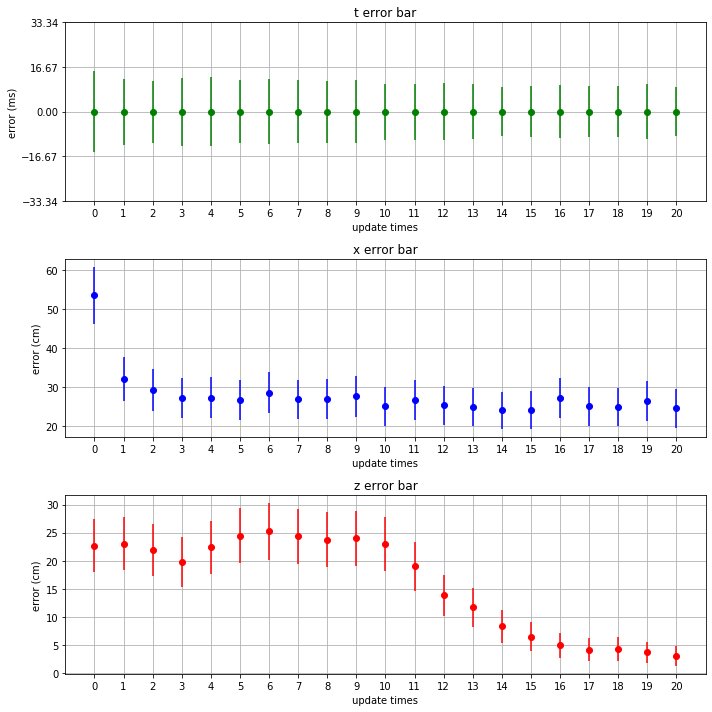

In [73]:
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.errorbar(x, arr_mse_t.reshape(n,), arr_std_t.reshape(n,), linestyle='None', marker='o', color='g', label='t error')
plt.title('t error bar')
plt.xlabel('update times')
plt.ylabel('error (ms)')
plt.xticks(np.arange(0,21))
plt.yticks(np.array([-33.34, -16.67, 0, 16.67, 33.34]))
plt.grid(True)

plt.subplot(3,1,2)
plt.errorbar(x, arr_mse_x.reshape(n,), arr_std_x.reshape(n,), linestyle='None', marker='o', color='b', label='x error')
plt.title('x error bar')
plt.xlabel('update times')
plt.ylabel('error (cm)')
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.subplot(3,1,3)
plt.errorbar(x, arr_mse_z.reshape(n,), arr_std_z.reshape(n,), linestyle='None', marker='o', color='r', label='z error')
plt.title('z error bar')
plt.xlabel('update times')
plt.ylabel('error (cm)')
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.tight_layout()
#plt.savefig('./fig/without classification/'+name+'_test_res.png')
#plt.savefig('./fig/without classification/'+name+'_test_res.svg')

#plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/'+name+'_test_res.png')
#plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/'+name+'_test_res.svg')

plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/png/'+name+'_test_res.png')
plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/svg/'+name+'_test_res.svg')

In [74]:
arr_for_err_x

array([[  2.42771389,   2.96631523,   2.39082717, ...,  -0.20946503,
         -0.62517472,   0.26041245],
       [ -2.89452199,  -3.04899258,   0.0887457 , ...,   0.49744019,
         -0.07400671,  -0.24179042],
       [-24.19421263,   1.21371112,   0.9945776 , ...,   0.47646575,
          0.24008495,  -0.21287658],
       ...,
       [  0.08930196,   0.7225967 ,   2.32160975, ...,   0.43365408,
          0.78195113,   1.06527419],
       [  0.04984485,  -1.2276577 ,   2.01855382, ...,   0.73536282,
          0.13076755,   0.1131166 ],
       [  5.45733236,   2.83093962,   1.02562854, ...,   0.5882659 ,
          0.56238607,   0.15323591]])

177 212
accuray = 83.49056603773585%


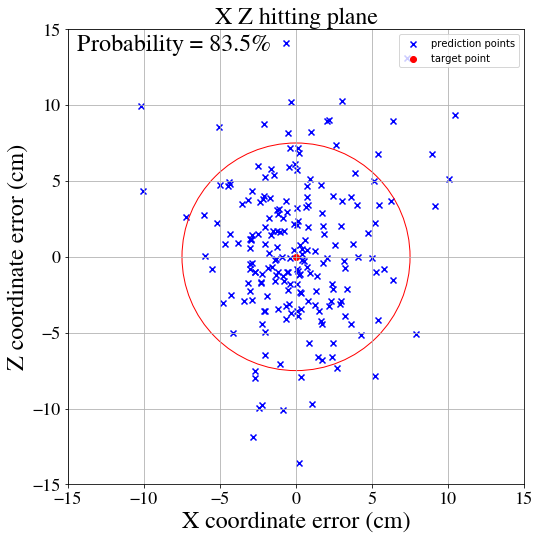

In [75]:
import math
up_times = 0

correct = 0
for i in range(arr_for_err_x.shape[0]):
    if arr_for_err_x[i,up_times] < 7.5 and arr_for_err_x[i,up_times] > -7.5 and arr_for_err_z[i,up_times] < 7.5 and arr_for_err_z[i,up_times] > -7.5:
        correct += 1
print(correct, arr_for_err_x.shape[0])
print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
text = str("Probability = {}%".format(aa))

plt.figure(figsize=(8,8))

x = y = np.arange(-7.5, 7.5, 0.005)
x, y = np.meshgrid(x,y)
#plt.contour(x, y, x**2 + y**2, [15*15])
circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')

ax = plt.gca()
ax.add_artist(circle2)
ax.set_xlim((-15, 15))
ax.set_ylim((-15, 15))

plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
plt.scatter(0,0, color='r', marker='o', label='target point')
plt.Circle((0,0), 7.5, color='r', fill=False)

plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.xticks(fontsize=18, fontname='FreeSerif')
plt.yticks(fontsize=18, fontname='FreeSerif')
plt.title('X Z hitting plane', fontsize=24, fontname='FreeSerif')
plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

plt.tight_layout(pad=2.5)
plt.grid(True)
plt.legend(loc='upper right')
#plt.savefig('./fig/with_classification/update_' + str(up_times) + '_times_with_classification.png')
#plt.savefig('./fig/with_classification/update_' + str(up_times) + '_times_with_classification.svg')
plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/png/update_'+str(up_times) + '_times_without_classification.png')
plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/svg/update_'+str(up_times) + '_times_without_classification.svg')

In [76]:
prob = np.array(aa)
prob

array(83.5)

180 212
accuray = 84.90566037735849%
179 212
accuray = 84.43396226415094%
188 212
accuray = 88.67924528301887%
185 212
accuray = 87.26415094339622%
179 212
accuray = 84.43396226415094%
175 212
accuray = 82.54716981132076%
182 212
accuray = 85.84905660377359%
183 212
accuray = 86.32075471698113%
178 212
accuray = 83.9622641509434%
183 212
accuray = 86.32075471698113%
184 212
accuray = 86.79245283018868%
190 212
accuray = 89.62264150943396%
197 212
accuray = 92.9245283018868%
201 212
accuray = 94.81132075471697%
206 212
accuray = 97.16981132075472%
203 212
accuray = 95.75471698113208%
207 212
accuray = 97.64150943396226%
206 212
accuray = 97.16981132075472%
204 212
accuray = 96.22641509433963%
207 212
accuray = 97.64150943396226%


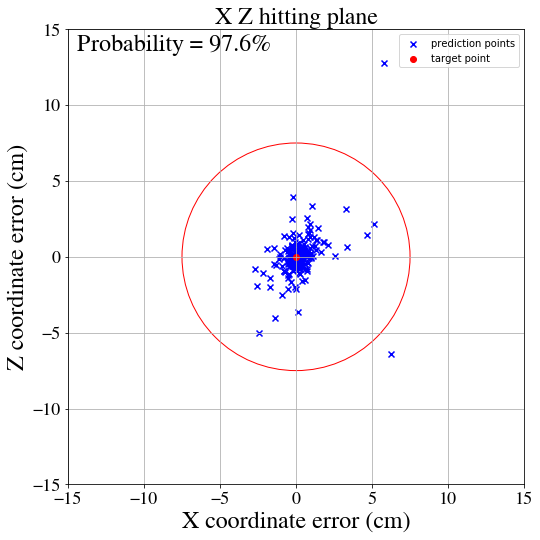

In [77]:
plt.figure(figsize=(8,8))
for up_times in range(1,n,1):
    plt.clf()
    #plt.figure(figsize=(8,8))
    '''
    ax = plt.gca()
    ax.add_artist(circle2)
    ax.set_xlim((-15, 15))
    ax.set_ylim((-15, 15))
    '''
    
    circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')
    ax = plt.gca()
    ax.add_artist(circle2)
    
    correct = 0
    for i in range(arr_for_err_x.shape[0]):
        d = math.sqrt(arr_for_err_x[i,up_times]**2+arr_for_err_z[i,up_times]**2)
        if d <= 7.5:
            correct += 1
    print(correct, arr_for_err_x.shape[0])
    print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
    aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
    text = str("Probability = {}%".format(aa))
    
    prob = np.vstack((prob, aa))
    
    plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
    plt.scatter(0,0, color='r', marker='o', label='target point')
    plt.Circle((0,0), 7.5, color='r', fill=False)

    plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
    plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
    plt.xticks(fontsize=18, fontname='FreeSerif')
    plt.yticks(fontsize=18, fontname='FreeSerif')
    plt.title('X Z hitting plane', fontsize=24, fontname='FreeSerif')
    plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

    plt.xlim(-15,15)
    plt.ylim(-15,15)
    
    plt.tight_layout(pad=2.5)
    plt.grid(True)
    plt.legend(loc='upper right')
    #plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.png')
    #plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.svg')
    
    #plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/update_'+str(up_times) + '_times_without_classification.png')
    #plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/update_'+str(up_times) + '_times_without_classification.svg')
    
    plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/png/update_'+str(up_times) + '_times_without_classification.png')
    plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/svg/update_'+str(up_times) + '_times_without_classification.svg')
    

In [78]:
prob

array([[83.5],
       [84.9],
       [84.4],
       [88.7],
       [87.3],
       [84.4],
       [82.5],
       [85.8],
       [86.3],
       [84. ],
       [86.3],
       [86.8],
       [89.6],
       [92.9],
       [94.8],
       [97.2],
       [95.8],
       [97.6],
       [97.2],
       [96.2],
       [97.6]])

In [79]:
errbar = [arr_mse_t, arr_mse_x, arr_mse_z, arr_std_t, arr_std_x, arr_std_z]
errbar = np.array(errbar)
errbar

array([[[ 0.03030813,  0.01955569,  0.01778087,  0.0194093 ,
          0.02089174,  0.01754844,  0.0177888 ,  0.01734624,
          0.01785127,  0.01816246,  0.0138532 ,  0.01339938,
          0.01326904,  0.01239999,  0.01009131,  0.01081781,
          0.01072235,  0.01083203,  0.0116728 ,  0.01248757,
          0.01058502]],

       [[53.56522184, 32.06832683, 29.37262711, 27.13937341,
         27.35698654, 26.68629489, 28.57098095, 26.86344874,
         26.98515641, 27.65220145, 25.14764134, 26.79256672,
         25.37164478, 24.92312891, 24.07070536, 24.11538231,
         27.33034115, 25.13885528, 24.99559077, 26.46007446,
         24.57770007]],

       [[22.70082027, 23.04872991, 21.95650554, 19.79599316,
         22.41275979, 24.41861839, 25.21811046, 24.34442839,
         23.74600629, 24.04052167, 22.96214737, 19.04245942,
         13.82718877, 11.6992249 ,  8.33719931,  6.52327918,
          5.00107069,  4.16082978,  4.28779091,  3.68721119,
          3.10078427]],

       [[1

In [80]:
errbar = errbar.reshape(6,21)
errbar

array([[ 0.03030813,  0.01955569,  0.01778087,  0.0194093 ,  0.02089174,
         0.01754844,  0.0177888 ,  0.01734624,  0.01785127,  0.01816246,
         0.0138532 ,  0.01339938,  0.01326904,  0.01239999,  0.01009131,
         0.01081781,  0.01072235,  0.01083203,  0.0116728 ,  0.01248757,
         0.01058502],
       [53.56522184, 32.06832683, 29.37262711, 27.13937341, 27.35698654,
        26.68629489, 28.57098095, 26.86344874, 26.98515641, 27.65220145,
        25.14764134, 26.79256672, 25.37164478, 24.92312891, 24.07070536,
        24.11538231, 27.33034115, 25.13885528, 24.99559077, 26.46007446,
        24.57770007],
       [22.70082027, 23.04872991, 21.95650554, 19.79599316, 22.41275979,
        24.41861839, 25.21811046, 24.34442839, 23.74600629, 24.04052167,
        22.96214737, 19.04245942, 13.82718877, 11.6992249 ,  8.33719931,
         6.52327918,  5.00107069,  4.16082978,  4.28779091,  3.68721119,
         3.10078427],
       [15.05102793, 12.26963307, 11.62816431, 12.745229  

In [81]:
df_prob = pd.DataFrame(data=prob)
p = '/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/prob.csv'
df_prob.to_csv(p, index=False)

In [82]:
#errbar = errbar.reshape(21,6)
df = pd.DataFrame(data=errbar)
#df.to_csv('/home/lab606a/Documents/comp/without classification/ideal.csv', index=False)

#p = '/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/without_classification.csv'
p = '/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/ideal.csv'

df.to_csv(p, index=False)

In [83]:
errbar = errbar.reshape(6,21)
errbar

array([[ 0.03030813,  0.01955569,  0.01778087,  0.0194093 ,  0.02089174,
         0.01754844,  0.0177888 ,  0.01734624,  0.01785127,  0.01816246,
         0.0138532 ,  0.01339938,  0.01326904,  0.01239999,  0.01009131,
         0.01081781,  0.01072235,  0.01083203,  0.0116728 ,  0.01248757,
         0.01058502],
       [53.56522184, 32.06832683, 29.37262711, 27.13937341, 27.35698654,
        26.68629489, 28.57098095, 26.86344874, 26.98515641, 27.65220145,
        25.14764134, 26.79256672, 25.37164478, 24.92312891, 24.07070536,
        24.11538231, 27.33034115, 25.13885528, 24.99559077, 26.46007446,
        24.57770007],
       [22.70082027, 23.04872991, 21.95650554, 19.79599316, 22.41275979,
        24.41861839, 25.21811046, 24.34442839, 23.74600629, 24.04052167,
        22.96214737, 19.04245942, 13.82718877, 11.6992249 ,  8.33719931,
         6.52327918,  5.00107069,  4.16082978,  4.28779091,  3.68721119,
         3.10078427],
       [15.05102793, 12.26963307, 11.62816431, 12.745229  